In [1]:
%matplotlib inline

# Fitting TESS data

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

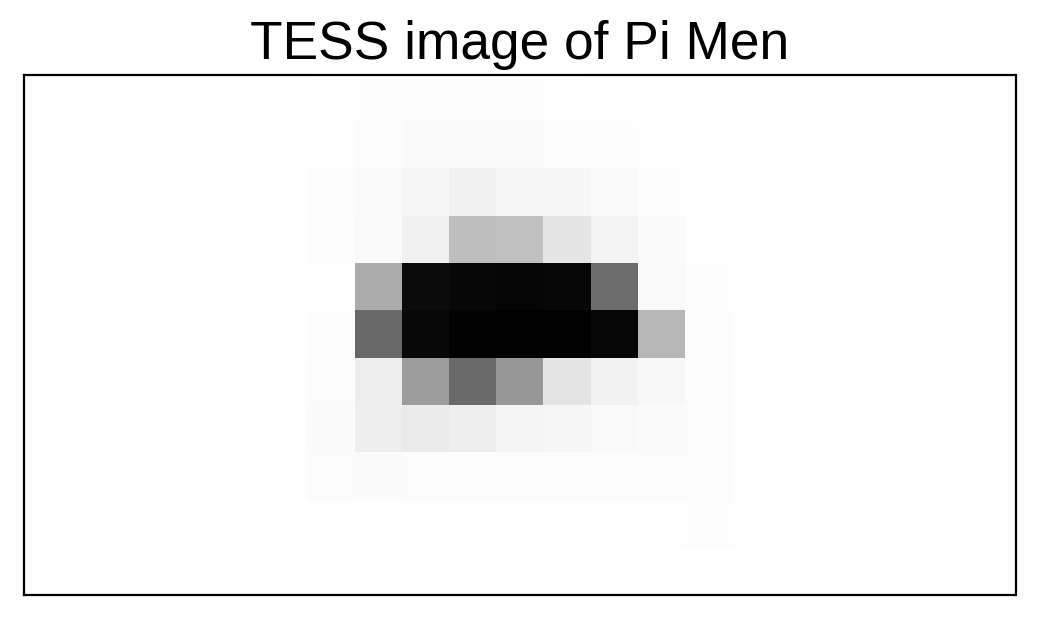

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

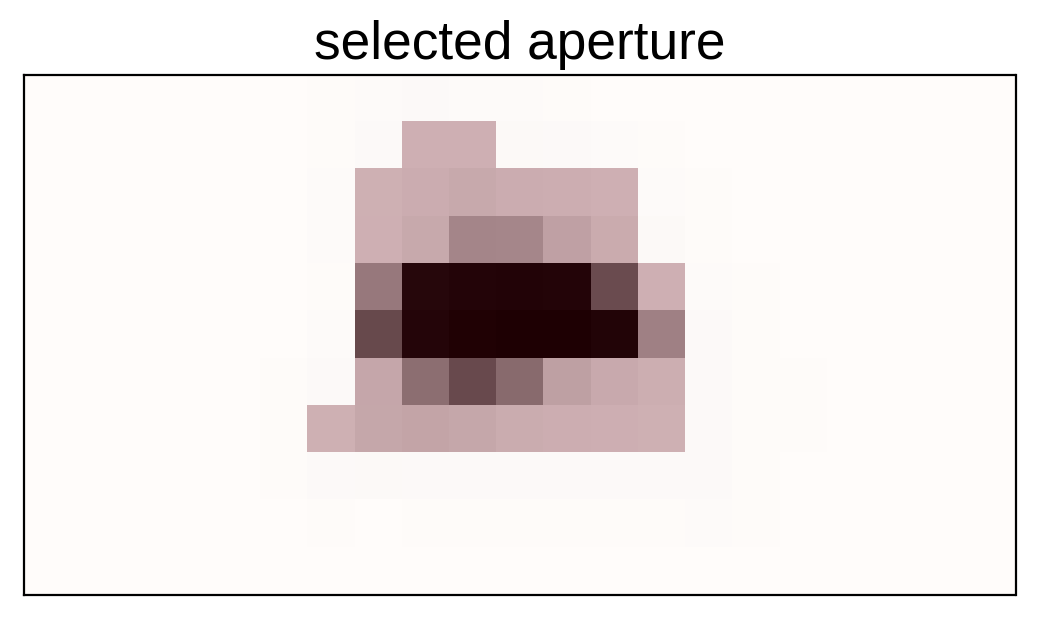

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

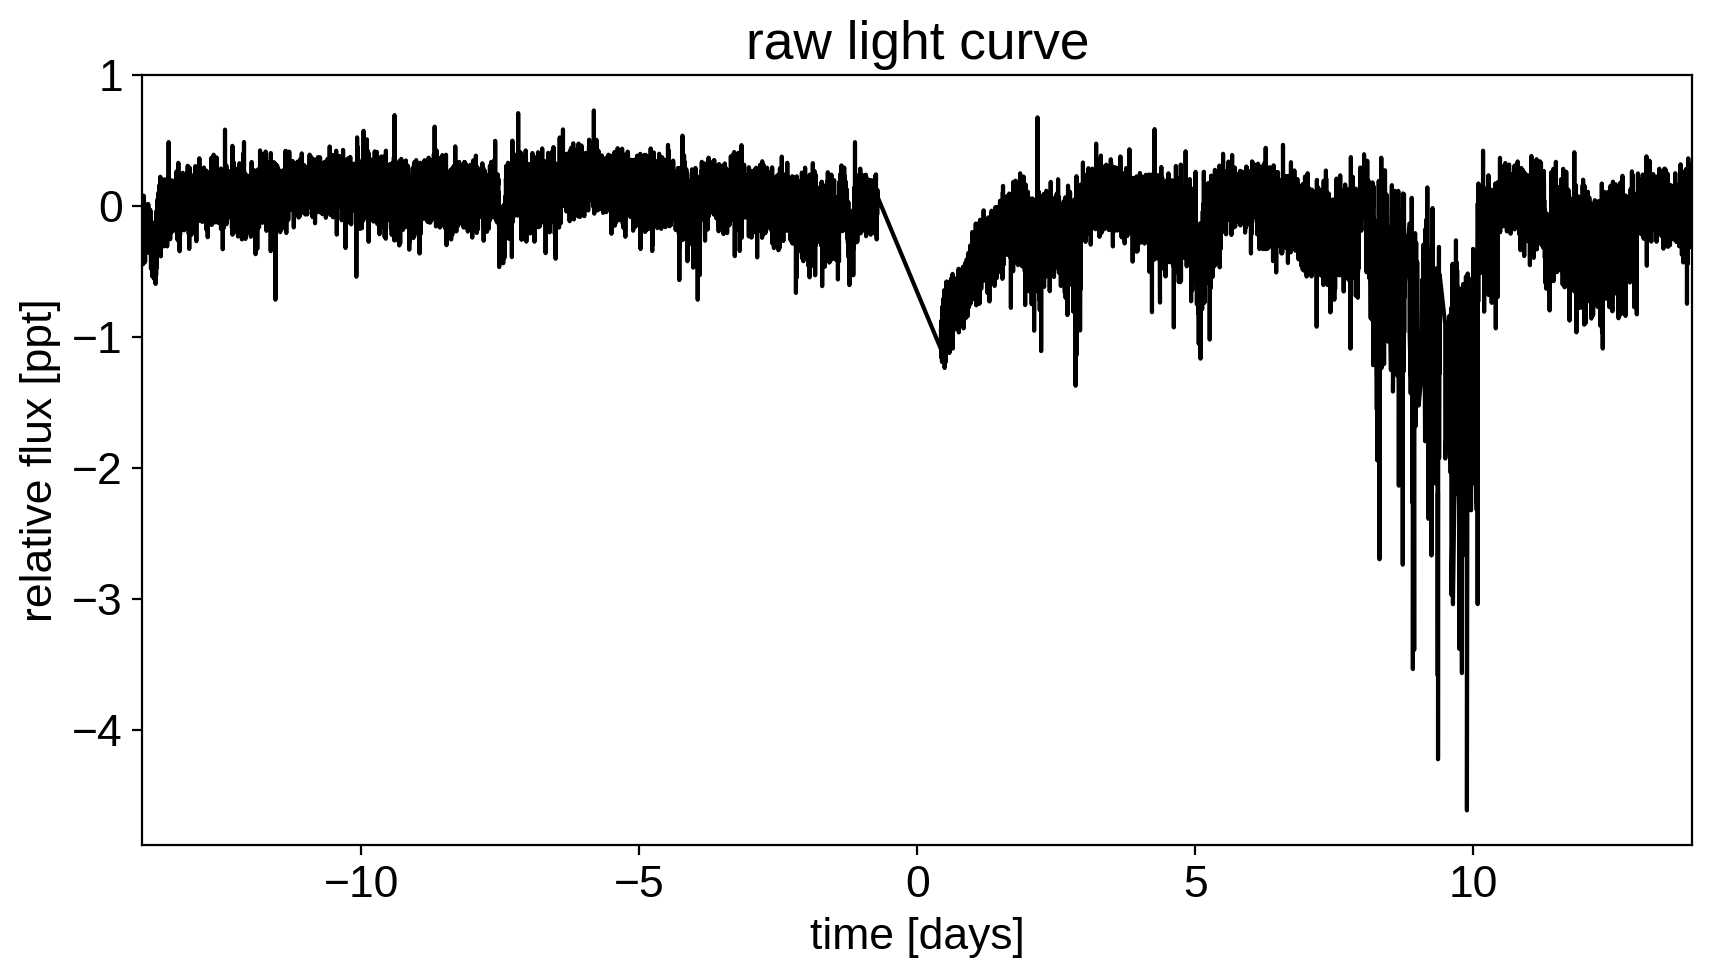

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

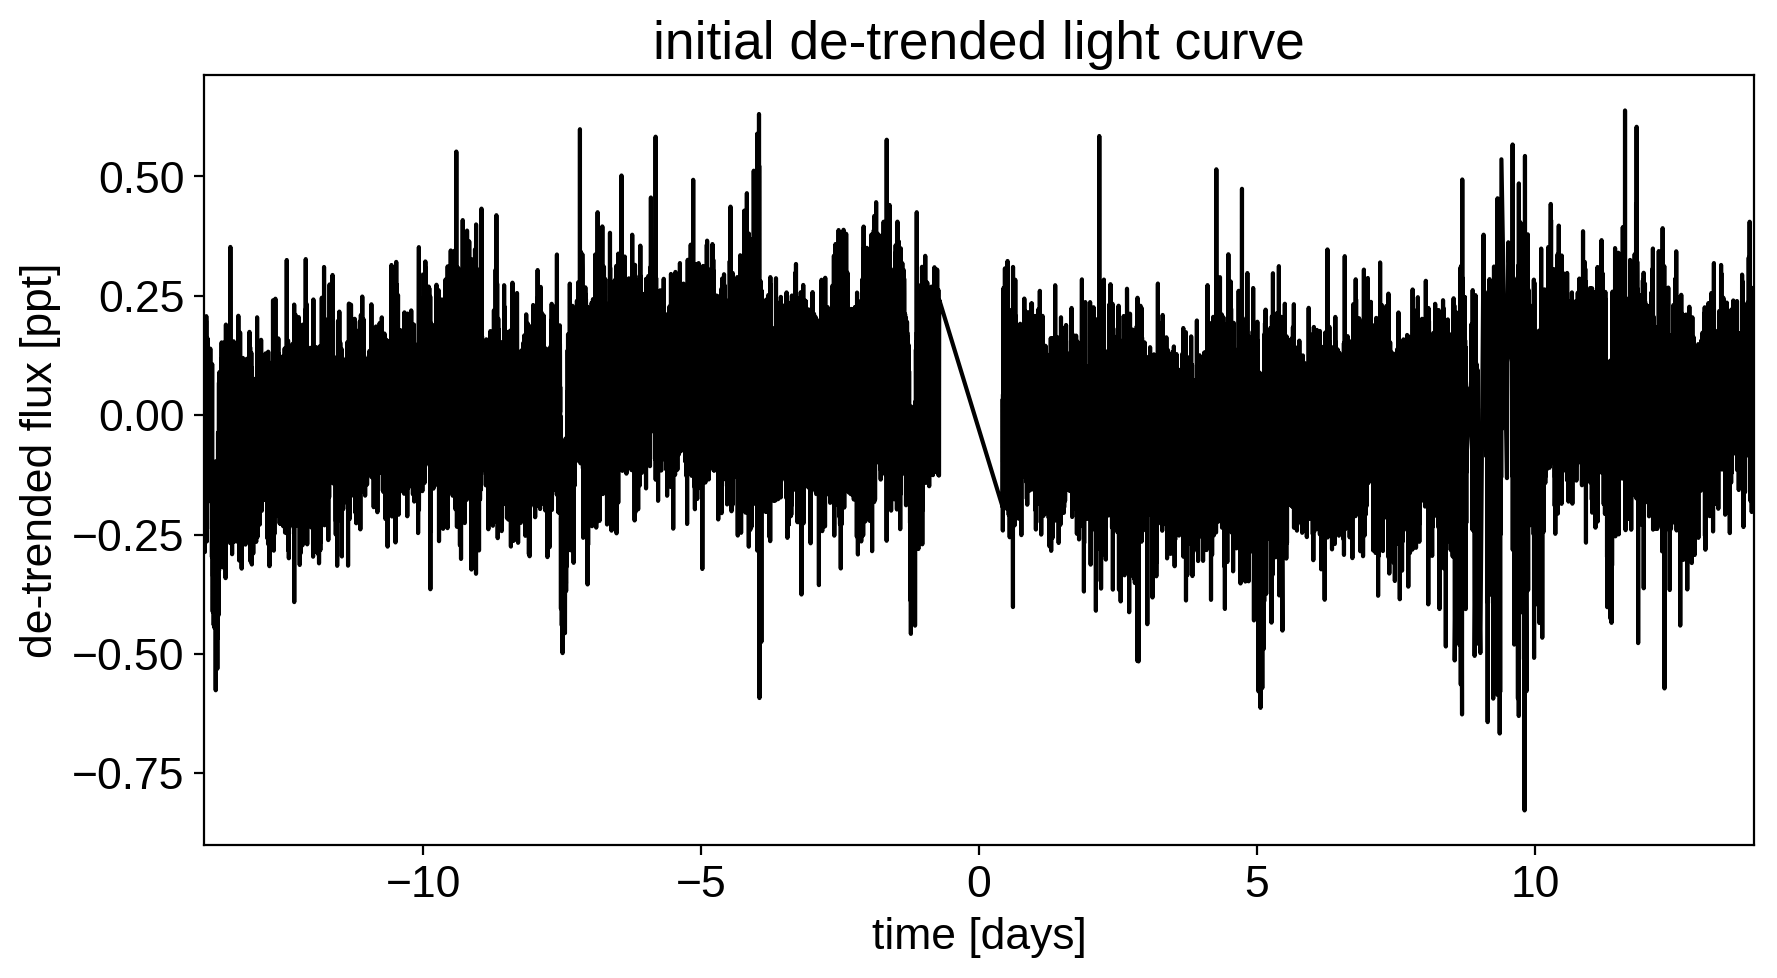

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

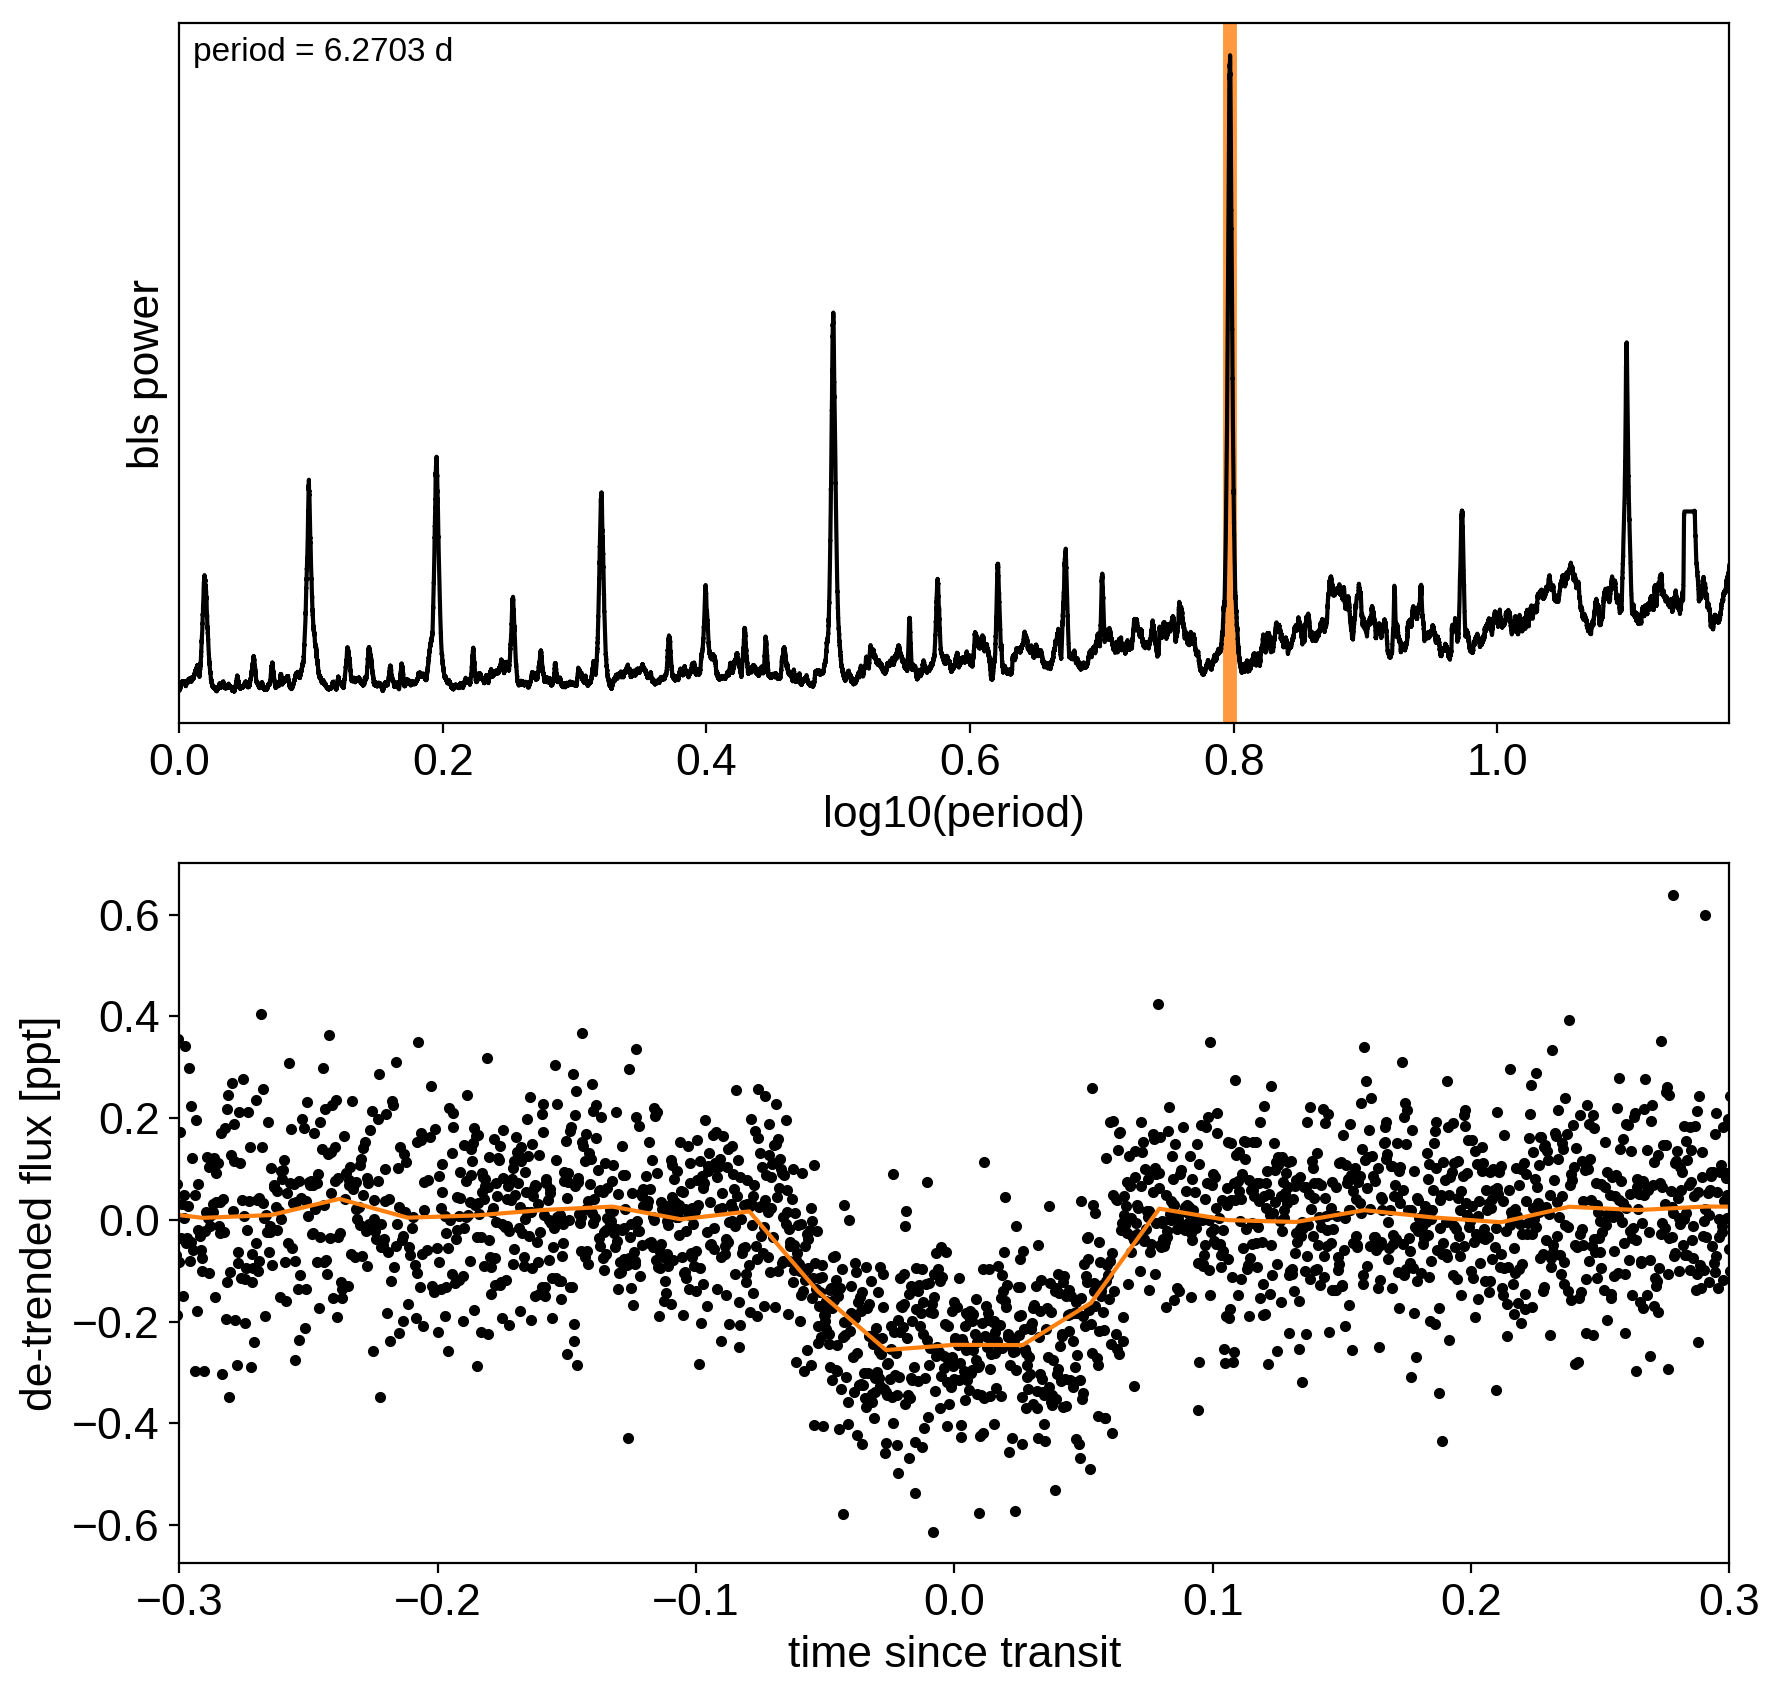

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

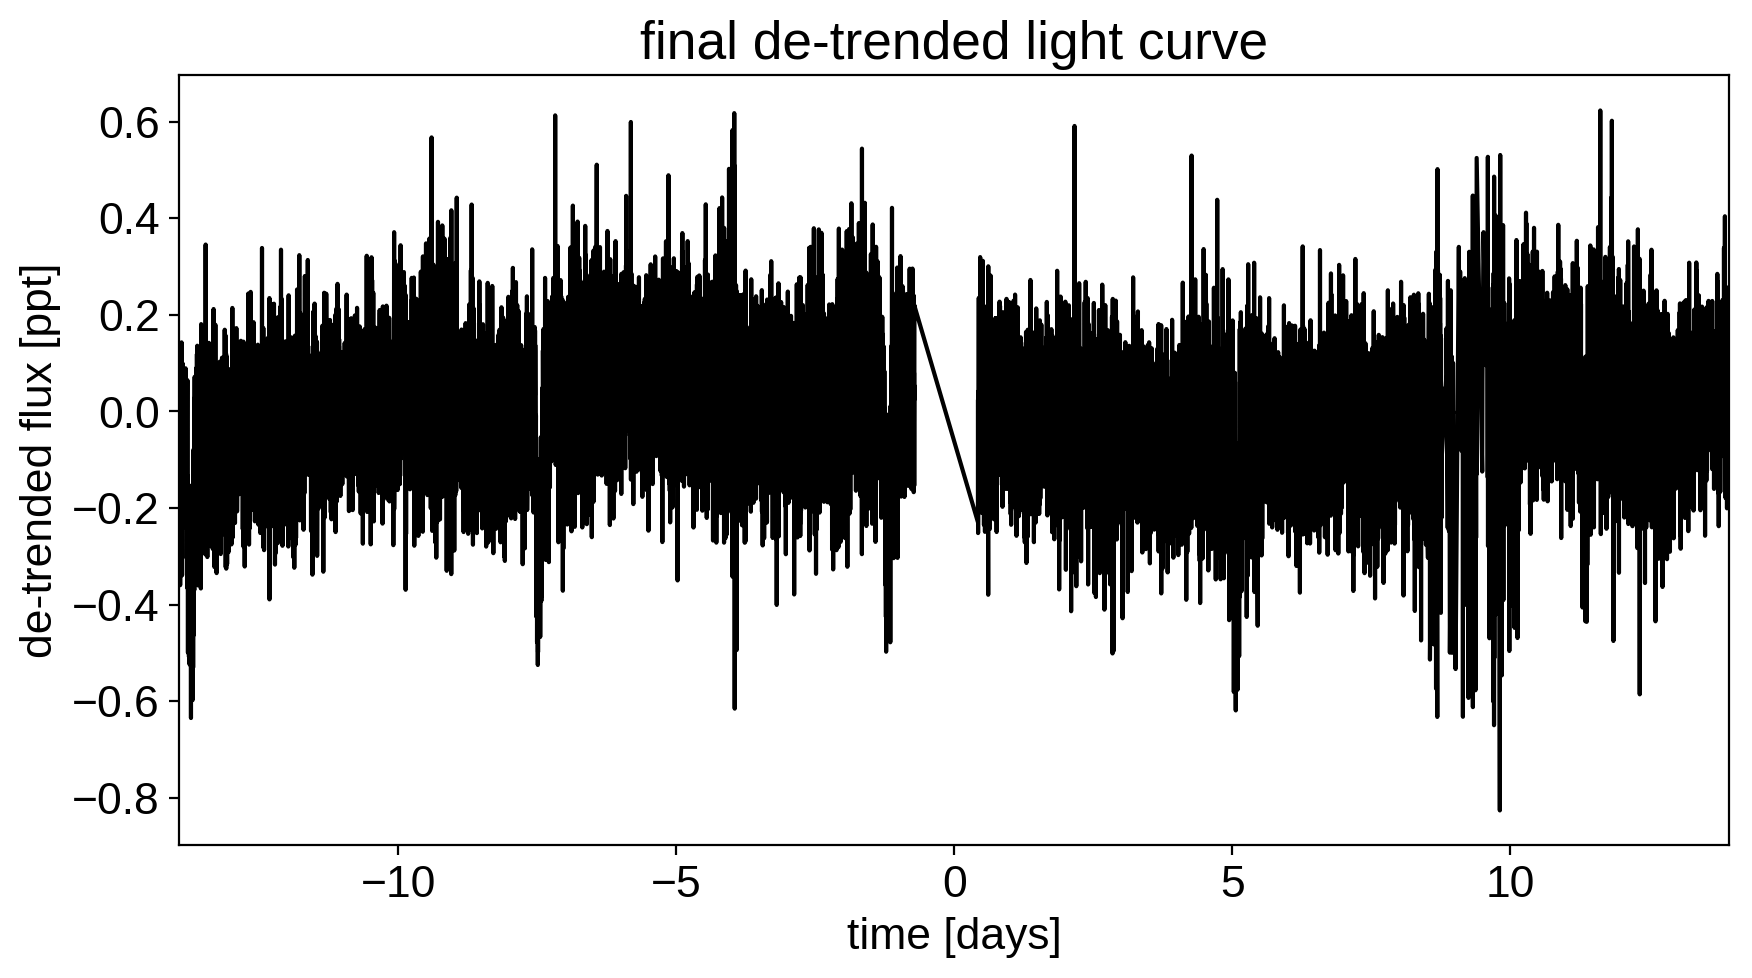

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

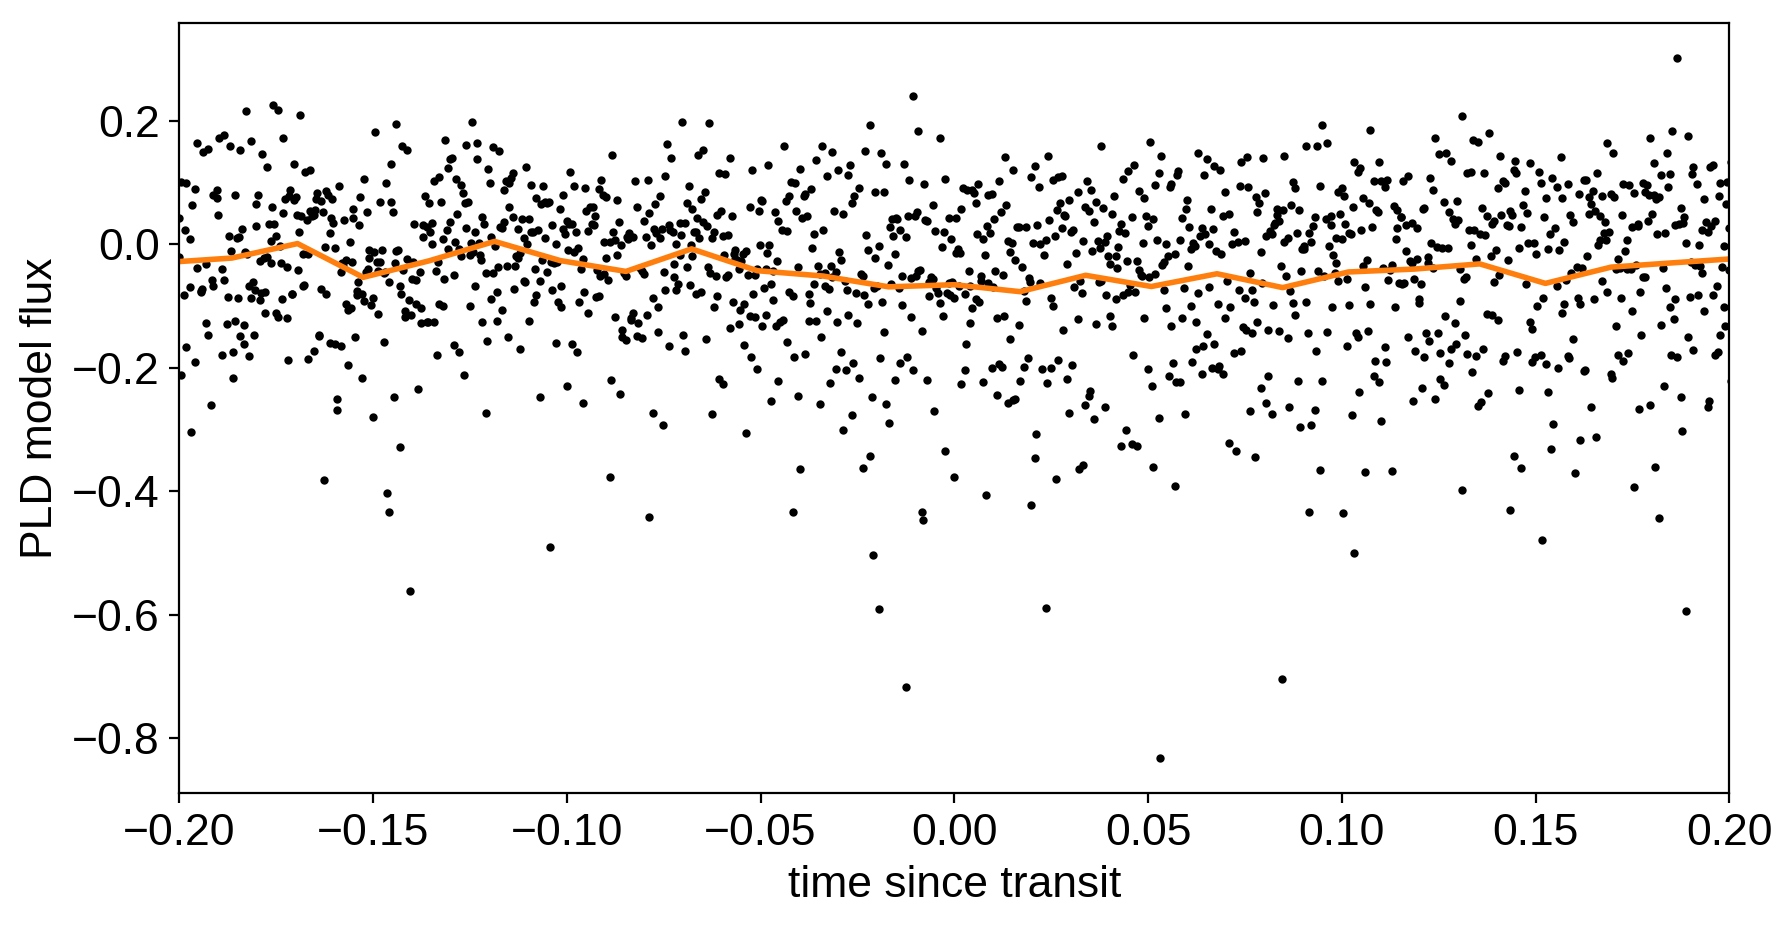

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`, but we'll use a [more informative prior on eccentricity](https://arxiv.org/abs/1306.4982).

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12376.80857098689 -> 12639.996970230417


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12639.996970230417 -> 12678.43754115093


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 12678.437541150926 -> 12766.212035562936


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 12766.212035562936 -> 12775.280265954552


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 12775.28026595456 -> 12785.944976507351


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12785.944976507351 -> 12808.533811467769


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 12808.533811467772 -> 12810.245024497444


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 12810.245024497444 -> 12830.74542946498


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 12830.745429464987 -> 12830.776889876886


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12830.776889876886 -> 12841.612045223032


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_interval__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 12841.612045223039 -> 13051.734914861176


Here's how we plot the initial light curve model:

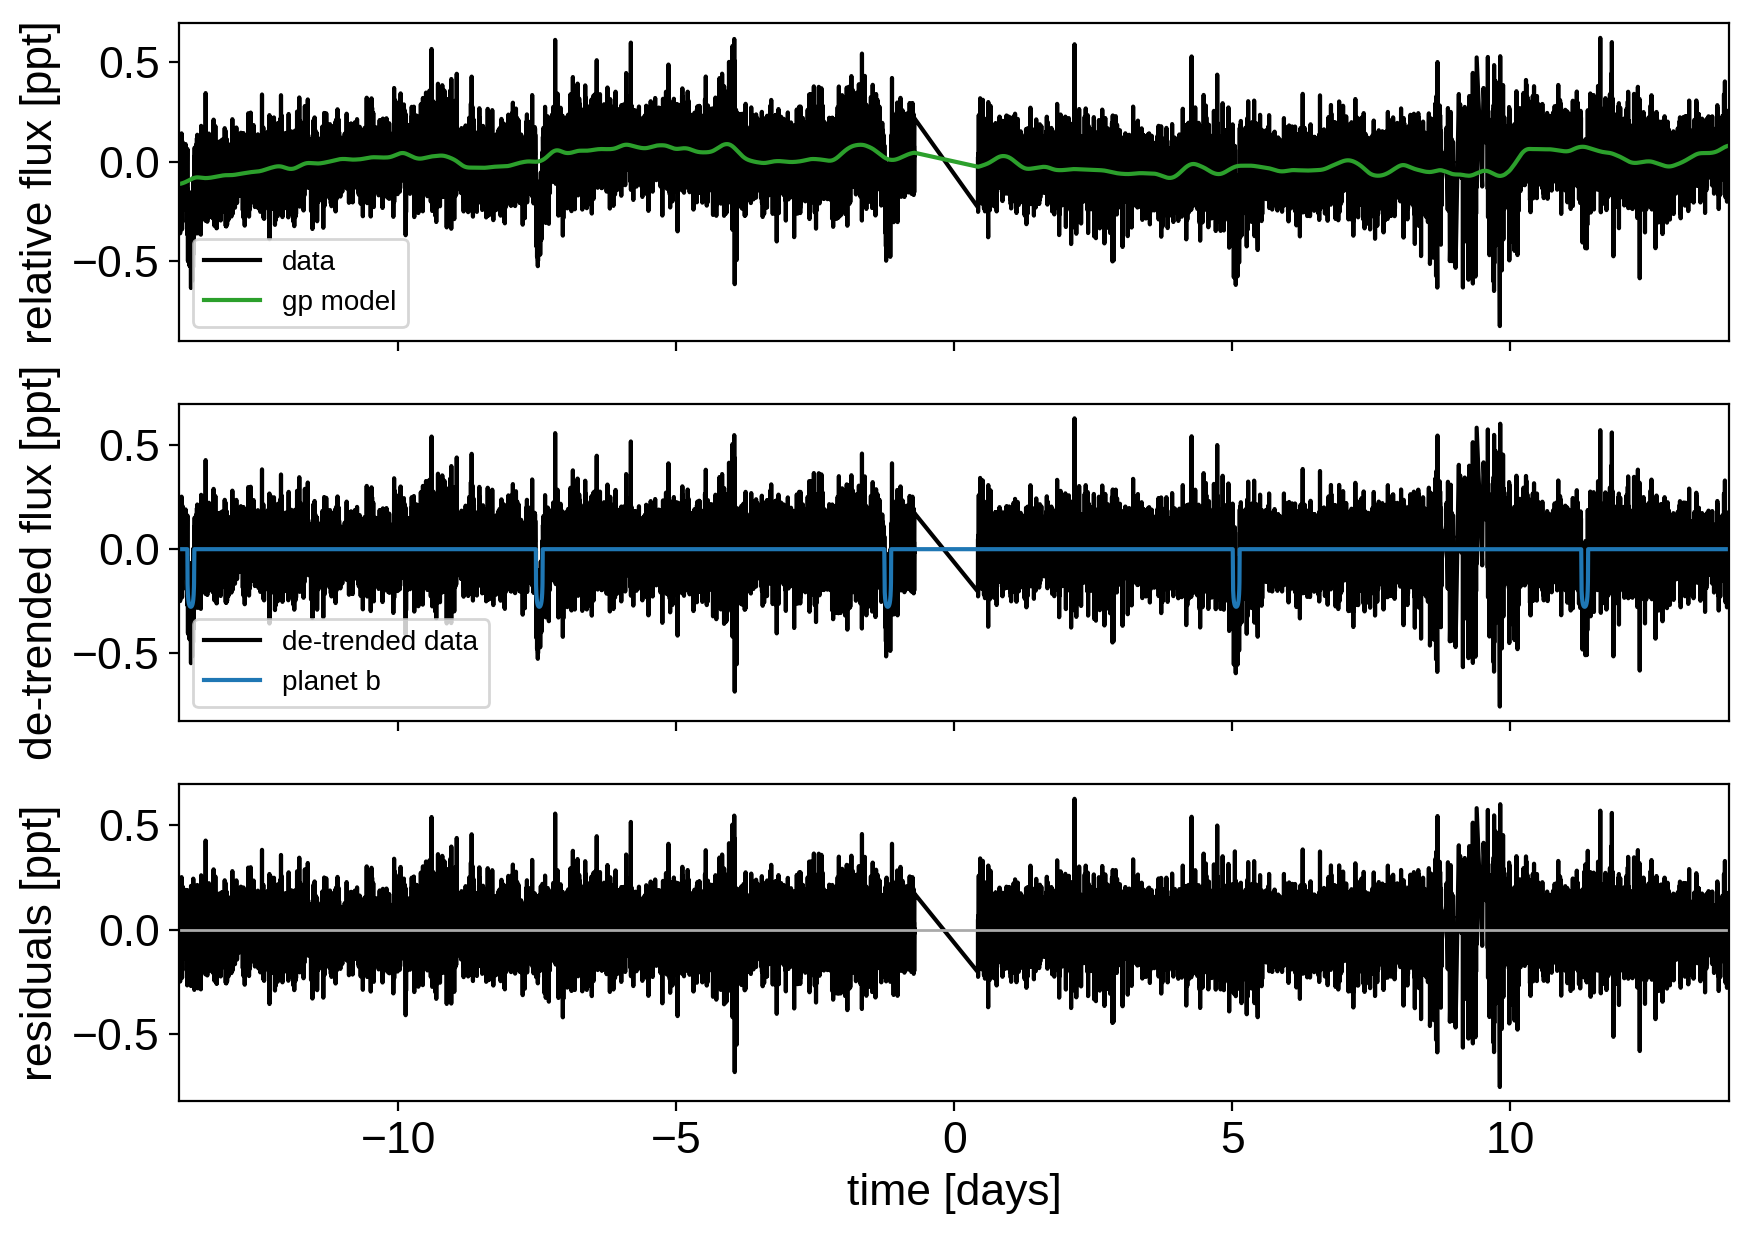

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

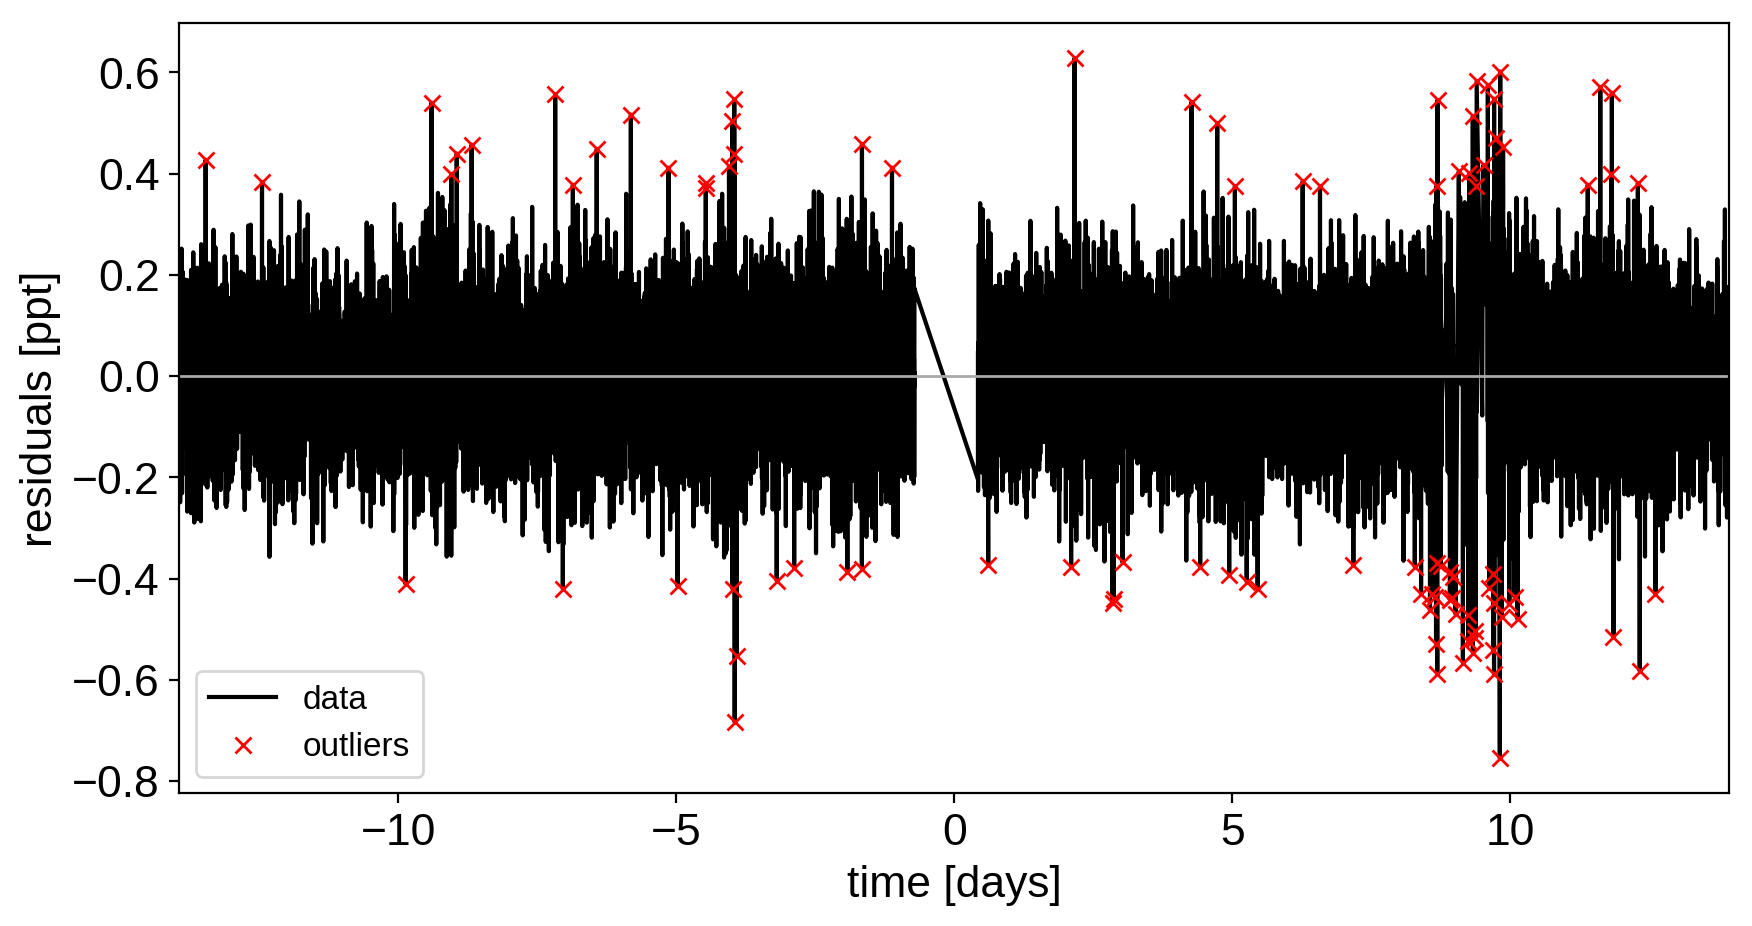

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13706.240110957619 -> 13737.199586284394


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.199586284394 -> 13737.219738050822


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13737.21973805083 -> 13737.220611067793


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.220611067793 -> 13737.229447619347


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13737.229447619347 -> 13737.253295948558


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.253295948558 -> 13737.256456034715


optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 13737.256456034722 -> 13737.265292993985


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 13737.265292993985 -> 13737.265332576995


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13737.265332576999 -> 13737.268483742777


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13737.268483742777 -> 13737.268486599893


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_interval__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.268486599889 -> 13737.280285382192


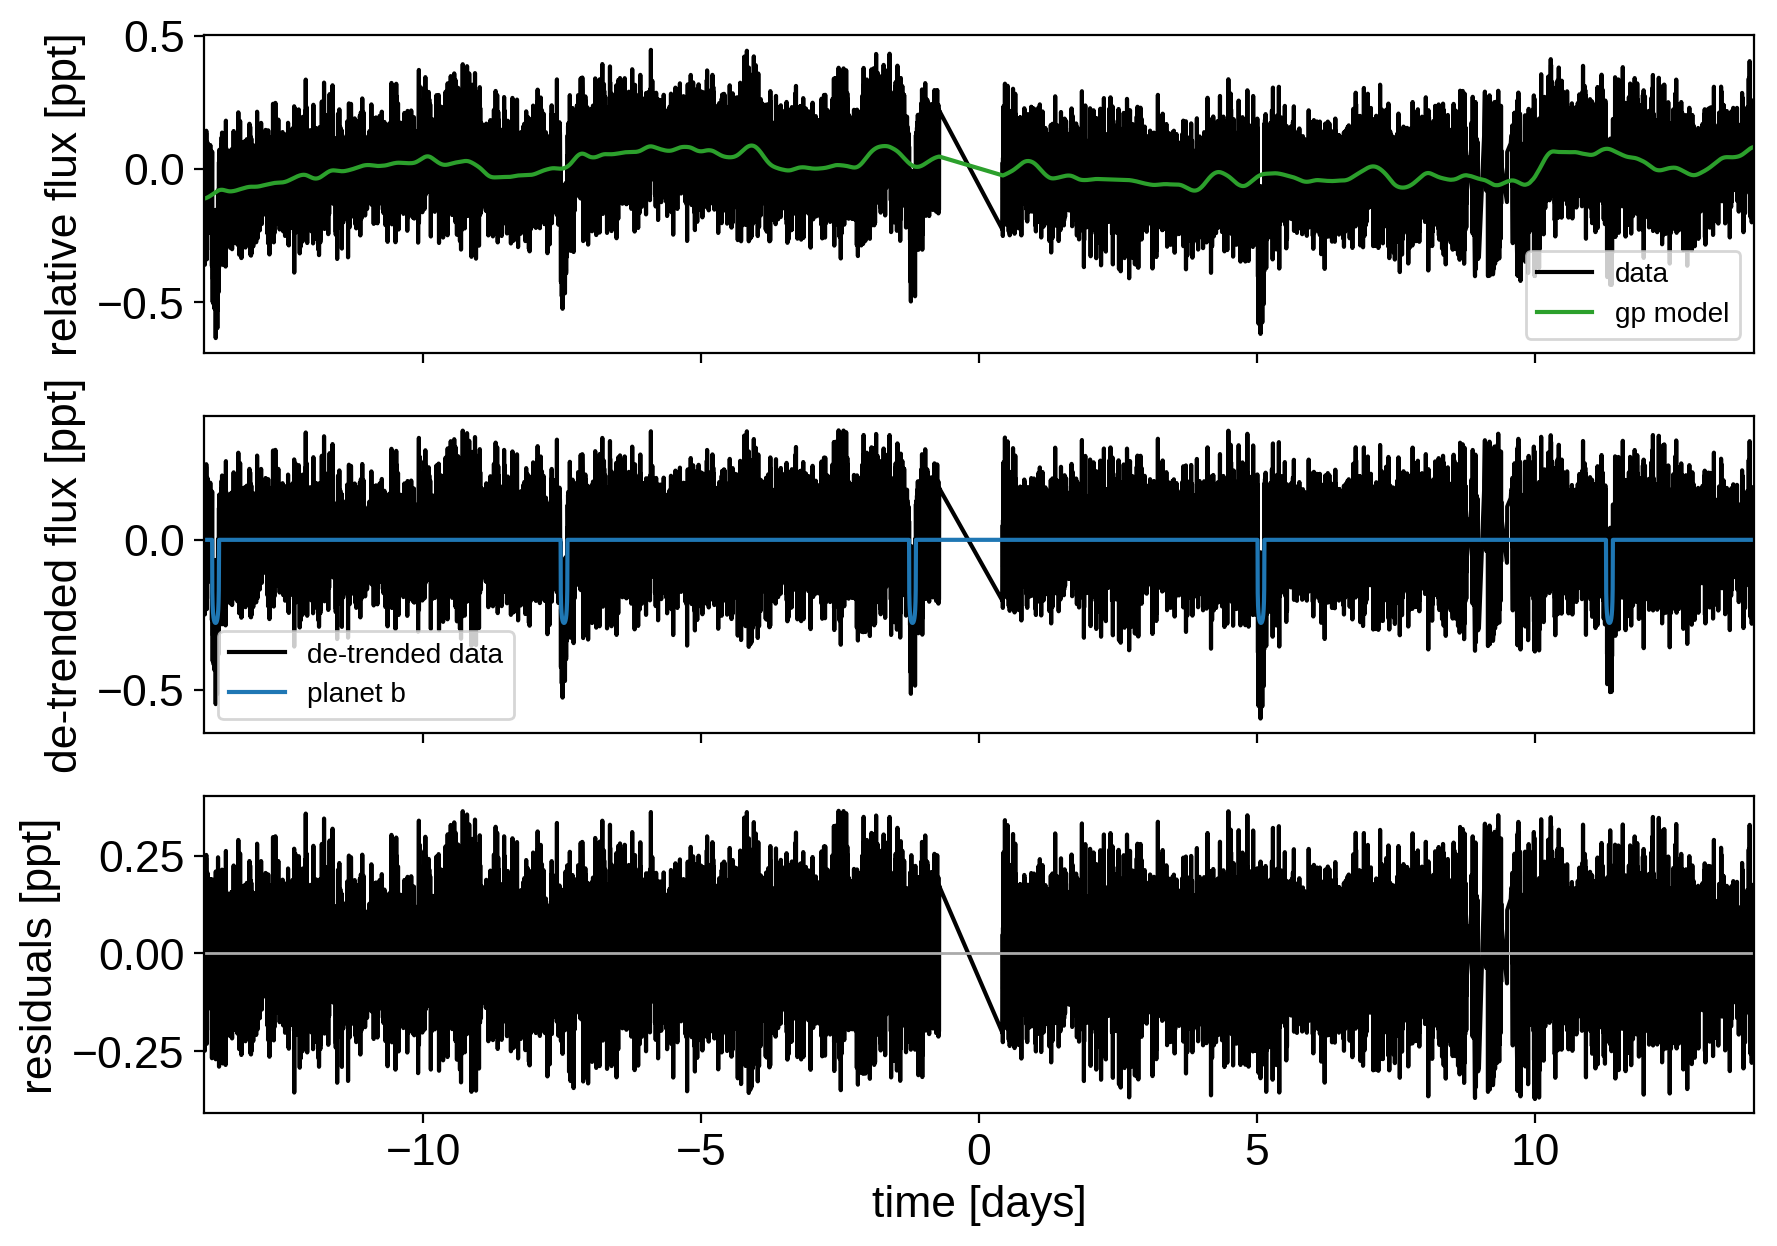

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample it using a :class:`exoplanet.PyMC3Sampler`:

In [14]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=300, chains=4)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 10/308 [00:00<00:03, 97.62draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:01<00:25, 11.40draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:03<00:57,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:05<01:19,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:07<01:33,  2.98draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:09<01:42,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 36/308 [00:09<01:13,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 38/308 [00:11<02:02,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 40/308 [00:11<01:29,  3.00draws/s]

Sampling 4 chains:  14%|█▎        | 42/308 [00:13<02:11,  2.03draws/s]

Sampling 4 chains:  14%|█▍        | 44/308 [00:13<01:37,  2.72draws/s]

Sampling 4 chains:  15%|█▍        | 46/308 [00:14<02:14,  1.95draws/s]

Sampling 4 chains:  16%|█▌        | 48/308 [00:15<01:40,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:16<03:17,  1.31draws/s]

Sampling 4 chains:  17%|█▋        | 52/308 [00:17<02:22,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:17<01:50,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:18<03:08,  1.35draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:18<02:21,  1.78draws/s]

Sampling 4 chains:  19%|█▊        | 57/308 [00:19<01:46,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:19<01:40,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 59/308 [00:20<02:34,  1.61draws/s]

Sampling 4 chains:  19%|█▉        | 60/308 [00:20<02:10,  1.91draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:21<01:45,  2.33draws/s]

Sampling 4 chains:  20%|██        | 63/308 [00:22<02:37,  1.55draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:22<02:13,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:23<01:41,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:24<02:56,  1.36draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:24<02:10,  1.81draws/s]

Sampling 4 chains:  23%|██▎       | 72/308 [00:26<03:15,  1.20draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:26<02:23,  1.62draws/s]

Sampling 4 chains:  25%|██▍       | 76/308 [00:28<03:22,  1.14draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:28<02:28,  1.54draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:30<03:24,  1.11draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:30<02:29,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 84/308 [00:31<02:48,  1.33draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:31<02:32,  1.46draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:32<01:57,  1.88draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:33<02:25,  1.51draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:33<02:16,  1.61draws/s]

Sampling 4 chains:  29%|██▉       | 90/308 [00:33<01:46,  2.05draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:34<01:25,  2.53draws/s]

Sampling 4 chains:  30%|██▉       | 92/308 [00:35<02:01,  1.78draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:35<01:59,  1.80draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:35<01:34,  2.27draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:35<01:16,  2.78draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:36<01:54,  1.86draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:37<01:52,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:37<01:30,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 99/308 [00:37<01:13,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:38<01:51,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:39<01:49,  1.90draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:39<01:28,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 103/308 [00:39<01:11,  2.86draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:40<01:49,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:41<01:46,  1.90draws/s]

Sampling 4 chains:  34%|███▍      | 106/308 [00:41<01:27,  2.32draws/s]

Sampling 4 chains:  35%|███▍      | 107/308 [00:41<01:09,  2.88draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:42<01:47,  1.86draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:42<01:44,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 110/308 [00:43<01:25,  2.31draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:43<01:03,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 113/308 [00:44<02:10,  1.49draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:44<01:44,  1.86draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:45<01:15,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:46<02:17,  1.39draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:46<01:49,  1.74draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:46<01:19,  2.38draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:48<02:18,  1.35draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:48<01:49,  1.70draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:48<01:19,  2.33draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:49<01:12,  2.52draws/s]

Sampling 4 chains:  41%|████      | 126/308 [00:50<01:54,  1.60draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:50<01:36,  1.88draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:50<01:16,  2.34draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:51<01:35,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 131/308 [00:52<01:26,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:52<01:16,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:52<01:12,  2.41draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:53<01:30,  1.92draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:53<01:22,  2.09draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:54<01:14,  2.31draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:54<01:10,  2.42draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:55<01:27,  1.94draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:55<01:20,  2.10draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [00:56<01:12,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:56<01:09,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:57<01:25,  1.94draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:57<01:18,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 144/308 [00:57<01:11,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:58<01:07,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:59<01:23,  1.95draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:59<01:16,  2.11draws/s]

Sampling 4 chains:  48%|████▊     | 148/308 [00:59<01:09,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [01:00<01:06,  2.40draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [01:00<01:20,  1.96draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [01:01<01:14,  2.12draws/s]

Sampling 4 chains:  49%|████▉     | 152/308 [01:01<01:08,  2.28draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [01:01<01:04,  2.40draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [01:02<01:18,  1.97draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [01:03<01:12,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 156/308 [01:03<01:06,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [01:03<01:03,  2.39draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [01:04<01:16,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [01:04<01:10,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 160/308 [01:05<01:05,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [01:05<01:01,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [01:06<01:14,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [01:06<01:08,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 164/308 [01:06<00:53,  2.71draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [01:07<00:47,  3.00draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [01:07<00:48,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [01:08<01:19,  1.76draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [01:08<01:01,  2.30draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [01:08<00:53,  2.62draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [01:09<00:51,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [01:10<01:20,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 172/308 [01:10<01:01,  2.22draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [01:10<00:53,  2.54draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [01:11<00:51,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [01:12<01:18,  1.69draws/s]

Sampling 4 chains:  57%|█████▋    | 176/308 [01:12<00:59,  2.20draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [01:12<00:52,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [01:13<00:50,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [01:14<01:16,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 180/308 [01:14<00:58,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [01:14<00:50,  2.51draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [01:14<00:48,  2.57draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [01:15<01:14,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 184/308 [01:16<00:56,  2.20draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [01:16<00:49,  2.51draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [01:16<00:47,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [01:17<01:11,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 188/308 [01:17<00:54,  2.21draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [01:18<00:47,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [01:18<00:45,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [01:19<01:09,  1.68draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [01:19<00:52,  2.21draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [01:20<00:46,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [01:20<00:44,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [01:21<01:06,  1.69draws/s]

Sampling 4 chains:  64%|██████▎   | 196/308 [01:21<00:50,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [01:21<00:44,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [01:22<00:43,  2.56draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [01:23<01:04,  1.69draws/s]

Sampling 4 chains:  65%|██████▍   | 200/308 [01:23<00:48,  2.22draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [01:23<00:43,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [01:24<00:41,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [01:25<01:01,  1.70draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [01:25<00:46,  2.22draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [01:25<00:41,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [01:25<00:40,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [01:26<00:54,  1.86draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [01:26<00:42,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [01:27<00:42,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [01:27<00:40,  2.44draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [01:28<00:53,  1.83draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [01:29<00:45,  2.11draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [01:29<00:41,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [01:30<00:52,  1.77draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [01:31<00:44,  2.04draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [01:31<00:40,  2.22draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [01:32<00:50,  1.76draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [01:32<00:42,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [01:33<00:38,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [01:34<00:48,  1.76draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [01:34<00:41,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [01:35<00:37,  2.20draws/s]

Sampling 4 chains:  74%|███████▎  | 227/308 [01:35<00:45,  1.76draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [01:36<00:39,  2.02draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [01:36<00:35,  2.20draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [01:37<00:43,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [01:38<00:37,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [01:38<00:33,  2.21draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [01:39<00:40,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [01:40<00:34,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [01:40<00:31,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [01:41<00:38,  1.80draws/s]

Sampling 4 chains:  78%|███████▊  | 241/308 [01:42<00:32,  2.03draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [01:42<00:29,  2.21draws/s]

Sampling 4 chains:  79%|███████▉  | 243/308 [01:43<00:35,  1.81draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [01:43<00:30,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [01:44<00:27,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [01:45<00:33,  1.82draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [01:45<00:28,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [01:46<00:26,  2.22draws/s]

Sampling 4 chains:  81%|████████▏ | 251/308 [01:46<00:31,  1.83draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [01:47<00:26,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [01:47<00:24,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [01:48<00:19,  2.68draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [01:48<00:23,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [01:49<00:26,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [01:49<00:23,  2.15draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [01:50<00:18,  2.62draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [01:50<00:22,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [01:51<00:24,  1.93draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [01:51<00:21,  2.13draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [01:51<00:17,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [01:52<00:20,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [01:53<00:22,  1.92draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [01:53<00:19,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 267/308 [01:53<00:15,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [01:54<00:18,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [01:54<00:20,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [01:55<00:17,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 271/308 [01:55<00:13,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [01:56<00:16,  2.17draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [01:56<00:18,  1.91draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [01:57<00:16,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [01:57<00:12,  2.66draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [01:57<00:14,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [01:58<00:16,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [01:59<00:14,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 279/308 [01:59<00:10,  2.68draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [01:59<00:12,  2.18draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [02:00<00:14,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [02:00<00:12,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [02:00<00:09,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [02:01<00:10,  2.19draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [02:02<00:12,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [02:02<00:10,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 287/308 [02:02<00:07,  2.71draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [02:03<00:09,  2.20draws/s]

Sampling 4 chains:  94%|█████████▍| 289/308 [02:04<00:10,  1.88draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [02:04<00:08,  2.08draws/s]

Sampling 4 chains:  94%|█████████▍| 291/308 [02:04<00:06,  2.72draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [02:05<00:07,  2.20draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [02:05<00:06,  2.22draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [02:06<00:05,  2.51draws/s]

Sampling 4 chains:  96%|█████████▌| 295/308 [02:06<00:05,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [02:07<00:05,  2.05draws/s]

Sampling 4 chains:  96%|█████████▋| 297/308 [02:07<00:05,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [02:07<00:04,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [02:08<00:03,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [02:08<00:03,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [02:09<00:03,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [02:09<00:02,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [02:10<00:03,  1.61draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [02:11<00:02,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [02:15<00:05,  1.71s/draws]

Sampling 4 chains:  99%|█████████▉| 306/308 [02:17<00:03,  1.63s/draws]

Sampling 4 chains: 100%|█████████▉| 307/308 [02:18<00:01,  1.45s/draws]

Sampling 4 chains: 100%|██████████| 308/308 [02:18<00:00,  1.19s/draws]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:  10%|█         | 11/108 [00:00<00:00, 108.79draws/s]

Sampling 4 chains:  16%|█▌        | 17/108 [00:00<00:01, 87.03draws/s] 

Sampling 4 chains:  20%|██        | 22/108 [00:02<00:10,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:03<00:22,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 28/108 [00:04<00:16,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 30/108 [00:05<00:31,  2.51draws/s]

Sampling 4 chains:  30%|██▉       | 32/108 [00:05<00:23,  3.29draws/s]

Sampling 4 chains:  31%|███▏      | 34/108 [00:07<00:34,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 36/108 [00:07<00:25,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 38/108 [00:09<00:34,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 40/108 [00:09<00:25,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:11<00:50,  1.32draws/s]

Sampling 4 chains:  41%|████      | 44/108 [00:11<00:35,  1.81draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:11<00:26,  2.40draws/s]

Sampling 4 chains:  43%|████▎     | 46/108 [00:13<00:46,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 48/108 [00:13<00:33,  1.79draws/s]

Sampling 4 chains:  45%|████▌     | 49/108 [00:13<00:25,  2.35draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:15<00:43,  1.32draws/s]

Sampling 4 chains:  48%|████▊     | 52/108 [00:15<00:31,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 53/108 [00:15<00:23,  2.35draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:16<00:40,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 56/108 [00:17<00:29,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 57/108 [00:17<00:21,  2.35draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:17<00:25,  1.94draws/s]

Sampling 4 chains:  55%|█████▍    | 59/108 [00:18<00:29,  1.68draws/s]

Sampling 4 chains:  56%|█████▋    | 61/108 [00:18<00:21,  2.20draws/s]

Sampling 4 chains:  58%|█████▊    | 63/108 [00:19<00:16,  2.73draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:19<00:17,  2.45draws/s]

Sampling 4 chains:  60%|██████    | 65/108 [00:20<00:23,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 66/108 [00:20<00:17,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 68/108 [00:21<00:13,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 69/108 [00:21<00:15,  2.53draws/s]

Sampling 4 chains:  65%|██████▍   | 70/108 [00:22<00:22,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 72/108 [00:23<00:16,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 73/108 [00:23<00:16,  2.12draws/s]

Sampling 4 chains:  69%|██████▊   | 74/108 [00:24<00:21,  1.60draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:24<00:15,  2.03draws/s]

Sampling 4 chains:  71%|███████▏  | 77/108 [00:25<00:15,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 78/108 [00:25<00:15,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:26<00:14,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 80/108 [00:26<00:10,  2.70draws/s]

Sampling 4 chains:  75%|███████▌  | 81/108 [00:27<00:13,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:27<00:13,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 83/108 [00:28<00:11,  2.08draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:28<00:08,  2.70draws/s]

Sampling 4 chains:  79%|███████▊  | 85/108 [00:29<00:11,  2.03draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:29<00:11,  1.96draws/s]

Sampling 4 chains:  81%|████████  | 87/108 [00:30<00:09,  2.10draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:30<00:07,  2.69draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:30<00:09,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:31<00:07,  2.40draws/s]

Sampling 4 chains:  84%|████████▍ | 91/108 [00:31<00:06,  2.60draws/s]

Sampling 4 chains:  85%|████████▌ | 92/108 [00:31<00:06,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 93/108 [00:32<00:04,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 94/108 [00:33<00:07,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 95/108 [00:33<00:05,  2.17draws/s]

Sampling 4 chains:  89%|████████▉ | 96/108 [00:33<00:05,  2.32draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:34<00:04,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 99/108 [00:35<00:03,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:35<00:03,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:36<00:02,  2.17draws/s]

Sampling 4 chains:  95%|█████████▌| 103/108 [00:37<00:02,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:42<00:03,  1.15s/draws]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:44<00:02,  1.25s/draws]

Sampling 4 chains:  99%|█████████▉| 107/108 [00:44<00:01,  1.06s/draws]

Sampling 4 chains: 100%|██████████| 108/108 [00:44<00:00,  1.25draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/208 [00:01<06:33,  1.90s/draws]

Sampling 4 chains:   2%|▏         | 5/208 [00:02<04:34,  1.35s/draws]

Sampling 4 chains:   3%|▎         | 6/208 [00:02<03:21,  1.00draws/s]

Sampling 4 chains:   3%|▎         | 7/208 [00:02<02:35,  1.29draws/s]

Sampling 4 chains:   4%|▍         | 8/208 [00:03<02:38,  1.26draws/s]

Sampling 4 chains:   4%|▍         | 9/208 [00:04<02:25,  1.36draws/s]

Sampling 4 chains:   5%|▌         | 11/208 [00:04<01:46,  1.85draws/s]

Sampling 4 chains:   6%|▌         | 12/208 [00:05<02:20,  1.40draws/s]

Sampling 4 chains:   6%|▋         | 13/208 [00:05<02:10,  1.49draws/s]

Sampling 4 chains:   7%|▋         | 15/208 [00:06<01:35,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 16/208 [00:07<02:11,  1.45draws/s]

Sampling 4 chains:   8%|▊         | 17/208 [00:07<02:04,  1.54draws/s]

Sampling 4 chains:   9%|▉         | 19/208 [00:07<01:30,  2.08draws/s]

Sampling 4 chains:  10%|▉         | 20/208 [00:09<02:08,  1.46draws/s]

Sampling 4 chains:  10%|█         | 21/208 [00:09<02:01,  1.54draws/s]

Sampling 4 chains:  11%|█         | 23/208 [00:09<01:28,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 24/208 [00:11<02:05,  1.46draws/s]

Sampling 4 chains:  12%|█▏        | 25/208 [00:11<02:00,  1.52draws/s]

Sampling 4 chains:  13%|█▎        | 27/208 [00:11<01:27,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 28/208 [00:12<02:03,  1.46draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:13<01:33,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 30/208 [00:13<01:27,  2.04draws/s]

Sampling 4 chains:  15%|█▍        | 31/208 [00:13<01:09,  2.56draws/s]

Sampling 4 chains:  15%|█▌        | 32/208 [00:14<01:37,  1.80draws/s]

Sampling 4 chains:  16%|█▌        | 33/208 [00:14<01:27,  1.99draws/s]

Sampling 4 chains:  16%|█▋        | 34/208 [00:15<01:21,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 35/208 [00:15<01:04,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 36/208 [00:16<01:25,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:16<01:08,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 38/208 [00:16<01:06,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 39/208 [00:17<01:12,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 40/208 [00:18<01:29,  1.87draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:18<01:12,  2.31draws/s]

Sampling 4 chains:  20%|██        | 42/208 [00:18<01:09,  2.39draws/s]

Sampling 4 chains:  21%|██        | 43/208 [00:19<01:14,  2.22draws/s]

Sampling 4 chains:  21%|██        | 44/208 [00:19<01:28,  1.86draws/s]

Sampling 4 chains:  22%|██▏       | 45/208 [00:20<01:12,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 46/208 [00:20<01:09,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:21<01:12,  2.22draws/s]

Sampling 4 chains:  23%|██▎       | 48/208 [00:21<01:23,  1.91draws/s]

Sampling 4 chains:  24%|██▍       | 50/208 [00:22<01:04,  2.44draws/s]

Sampling 4 chains:  25%|██▍       | 51/208 [00:22<01:03,  2.49draws/s]

Sampling 4 chains:  25%|██▌       | 52/208 [00:23<01:40,  1.55draws/s]

Sampling 4 chains:  26%|██▌       | 54/208 [00:23<01:15,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 56/208 [00:25<01:29,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 59/208 [00:25<01:05,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 60/208 [00:26<01:26,  1.70draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:27<01:30,  1.62draws/s]

Sampling 4 chains:  30%|███       | 63/208 [00:27<01:04,  2.24draws/s]

Sampling 4 chains:  31%|███       | 64/208 [00:27<00:51,  2.80draws/s]

Sampling 4 chains:  31%|███▏      | 65/208 [00:28<01:16,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 66/208 [00:29<01:21,  1.74draws/s]

Sampling 4 chains:  32%|███▏      | 67/208 [00:29<01:03,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 68/208 [00:29<00:51,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 69/208 [00:30<01:12,  1.92draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:31<01:18,  1.76draws/s]

Sampling 4 chains:  34%|███▍      | 71/208 [00:31<01:00,  2.27draws/s]

Sampling 4 chains:  35%|███▍      | 72/208 [00:31<00:49,  2.74draws/s]

Sampling 4 chains:  35%|███▌      | 73/208 [00:32<01:10,  1.90draws/s]

Sampling 4 chains:  36%|███▌      | 74/208 [00:33<01:15,  1.78draws/s]

Sampling 4 chains:  36%|███▌      | 75/208 [00:33<00:58,  2.27draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:33<00:49,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 77/208 [00:34<01:09,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 79/208 [00:34<00:59,  2.16draws/s]

Sampling 4 chains:  38%|███▊      | 80/208 [00:35<00:47,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 81/208 [00:36<01:17,  1.63draws/s]

Sampling 4 chains:  40%|███▉      | 83/208 [00:36<01:04,  1.94draws/s]

Sampling 4 chains:  40%|████      | 84/208 [00:37<00:50,  2.44draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:38<01:16,  1.60draws/s]

Sampling 4 chains:  41%|████▏     | 86/208 [00:38<00:57,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 87/208 [00:38<00:57,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 88/208 [00:38<00:45,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:40<01:10,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 90/208 [00:40<00:54,  2.16draws/s]

Sampling 4 chains:  44%|████▍     | 91/208 [00:40<00:53,  2.17draws/s]

Sampling 4 chains:  44%|████▍     | 92/208 [00:40<00:43,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 93/208 [00:40<00:35,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 94/208 [00:42<01:02,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 95/208 [00:42<00:58,  1.93draws/s]

Sampling 4 chains:  46%|████▌     | 96/208 [00:42<00:46,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:42<00:36,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:43<01:03,  1.74draws/s]

Sampling 4 chains:  48%|████▊     | 99/208 [00:44<00:58,  1.87draws/s]

Sampling 4 chains:  48%|████▊     | 100/208 [00:44<00:45,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 102/208 [00:44<00:36,  2.87draws/s]

Sampling 4 chains:  50%|████▉     | 103/208 [00:46<01:08,  1.52draws/s]

Sampling 4 chains:  50%|█████     | 104/208 [00:46<00:52,  1.99draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:46<00:41,  2.45draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:48<01:10,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:48<00:52,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 110/208 [00:48<00:41,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 111/208 [00:50<01:08,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 112/208 [00:50<00:51,  1.88draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:50<00:40,  2.30draws/s]

Sampling 4 chains:  55%|█████▌    | 115/208 [00:51<01:05,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:52<00:48,  1.89draws/s]

Sampling 4 chains:  57%|█████▋    | 118/208 [00:52<00:39,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 119/208 [00:53<01:01,  1.45draws/s]

Sampling 4 chains:  58%|█████▊    | 120/208 [00:53<00:45,  1.91draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:54<00:37,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 123/208 [00:55<00:50,  1.70draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:55<00:42,  1.99draws/s]

Sampling 4 chains:  60%|██████    | 125/208 [00:55<00:32,  2.56draws/s]

Sampling 4 chains:  61%|██████    | 127/208 [00:57<00:39,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 128/208 [00:57<00:33,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:57<00:26,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 131/208 [00:59<00:35,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 132/208 [00:59<00:29,  2.57draws/s]

Sampling 4 chains:  64%|██████▍   | 133/208 [00:59<00:23,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 134/208 [00:59<00:18,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 135/208 [01:01<00:44,  1.65draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [01:01<00:34,  2.09draws/s]

Sampling 4 chains:  66%|██████▌   | 137/208 [01:01<00:26,  2.70draws/s]

Sampling 4 chains:  66%|██████▋   | 138/208 [01:01<00:21,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 139/208 [01:02<00:44,  1.55draws/s]

Sampling 4 chains:  67%|██████▋   | 140/208 [01:03<00:33,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 141/208 [01:03<00:25,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 142/208 [01:03<00:20,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [01:04<00:42,  1.51draws/s]

Sampling 4 chains:  69%|██████▉   | 144/208 [01:04<00:31,  2.02draws/s]

Sampling 4 chains:  70%|██████▉   | 145/208 [01:04<00:23,  2.64draws/s]

Sampling 4 chains:  70%|███████   | 146/208 [01:05<00:19,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 147/208 [01:06<00:40,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 149/208 [01:06<00:29,  2.02draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [01:07<00:23,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 151/208 [01:08<00:41,  1.36draws/s]

Sampling 4 chains:  74%|███████▎  | 153/208 [01:08<00:29,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 154/208 [01:08<00:24,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [01:10<00:40,  1.31draws/s]

Sampling 4 chains:  75%|███████▌  | 157/208 [01:10<00:28,  1.82draws/s]

Sampling 4 chains:  76%|███████▌  | 158/208 [01:10<00:23,  2.16draws/s]

Sampling 4 chains:  76%|███████▋  | 159/208 [01:11<00:32,  1.51draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [01:12<00:27,  1.74draws/s]

Sampling 4 chains:  78%|███████▊  | 162/208 [01:12<00:21,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 163/208 [01:13<00:29,  1.54draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [01:14<00:24,  1.76draws/s]

Sampling 4 chains:  80%|███████▉  | 166/208 [01:14<00:19,  2.19draws/s]

Sampling 4 chains:  80%|████████  | 167/208 [01:14<00:16,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 168/208 [01:15<00:21,  1.90draws/s]

Sampling 4 chains:  81%|████████▏ | 169/208 [01:16<00:18,  2.08draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [01:16<00:16,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [01:17<00:19,  1.82draws/s]

Sampling 4 chains:  83%|████████▎ | 173/208 [01:17<00:17,  2.01draws/s]

Sampling 4 chains:  84%|████████▎ | 174/208 [01:17<00:12,  2.62draws/s]

Sampling 4 chains:  84%|████████▍ | 175/208 [01:18<00:14,  2.27draws/s]

Sampling 4 chains:  85%|████████▍ | 176/208 [01:19<00:17,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 177/208 [01:19<00:15,  2.03draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [01:19<00:11,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 179/208 [01:20<00:12,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [01:21<00:15,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 181/208 [01:21<00:13,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 182/208 [01:21<00:10,  2.52draws/s]

Sampling 4 chains:  88%|████████▊ | 183/208 [01:22<00:11,  2.25draws/s]

Sampling 4 chains:  88%|████████▊ | 184/208 [01:23<00:12,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 185/208 [01:23<00:11,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 186/208 [01:23<00:08,  2.48draws/s]

Sampling 4 chains:  90%|████████▉ | 187/208 [01:24<00:09,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [01:24<00:08,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 189/208 [01:24<00:07,  2.51draws/s]

Sampling 4 chains:  91%|█████████▏| 190/208 [01:25<00:07,  2.54draws/s]

Sampling 4 chains:  92%|█████████▏| 191/208 [01:25<00:08,  2.12draws/s]

Sampling 4 chains:  92%|█████████▏| 192/208 [01:26<00:05,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 193/208 [01:26<00:05,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 194/208 [01:27<00:06,  2.15draws/s]

Sampling 4 chains:  94%|█████████▍| 195/208 [01:27<00:06,  1.91draws/s]

Sampling 4 chains:  94%|█████████▍| 196/208 [01:27<00:04,  2.46draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [01:28<00:04,  2.39draws/s]

Sampling 4 chains:  95%|█████████▌| 198/208 [01:28<00:04,  2.10draws/s]

Sampling 4 chains:  96%|█████████▌| 199/208 [01:29<00:05,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 200/208 [01:29<00:03,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 201/208 [01:30<00:02,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 202/208 [01:31<00:04,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 204/208 [01:32<00:02,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [01:35<00:04,  1.34s/draws]

Sampling 4 chains:  99%|█████████▉| 206/208 [01:35<00:02,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 207/208 [01:36<00:00,  1.18draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [01:39<00:00,  1.53s/draws]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/408 [00:00<01:00,  6.68draws/s]

Sampling 4 chains:   1%|          | 3/408 [00:00<00:49,  8.11draws/s]

Sampling 4 chains:   2%|▏         | 10/408 [00:00<00:36, 10.79draws/s]

Sampling 4 chains:   3%|▎         | 12/408 [00:00<00:47,  8.39draws/s]

Sampling 4 chains:   3%|▎         | 14/408 [00:02<01:54,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 16/408 [00:02<01:52,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:02<01:33,  4.18draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:03<01:35,  4.09draws/s]

Sampling 4 chains:   5%|▍         | 19/408 [00:03<01:32,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:03<01:25,  4.55draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:03<01:14,  5.18draws/s]

Sampling 4 chains:   6%|▌         | 23/408 [00:04<02:42,  2.37draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:04<02:17,  2.79draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:05<02:07,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:05<01:47,  3.55draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:05<01:53,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:06<02:28,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:06<02:19,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 31/408 [00:07<02:14,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:07<01:41,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:07<01:29,  4.16draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:07<01:35,  3.90draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:08<01:47,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:08<01:46,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:08<01:46,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:09<01:55,  3.18draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:09<01:36,  3.80draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:10<02:19,  2.62draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:10<02:37,  2.32draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:10<02:33,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:11<01:57,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:11<01:39,  3.61draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:11<01:25,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:12<01:17,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:12<01:14,  4.75draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:12<01:22,  4.30draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:12<01:16,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:13<01:42,  3.44draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:13<01:44,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:13<01:25,  4.07draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:14<01:43,  3.37draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:14<01:22,  4.17draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:15<01:48,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:15<01:53,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:15<01:29,  3.84draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:16<01:30,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:16<01:26,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:16<01:16,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:17<01:16,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:17<01:12,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:17<01:13,  4.50draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:17<01:03,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:18<01:30,  3.62draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:19<01:38,  3.31draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:19<01:31,  3.55draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:20<01:26,  3.73draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:20<01:46,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:21<01:36,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:21<01:32,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:21<01:25,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:22<01:34,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:22<01:23,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:23<02:11,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:23<01:46,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:23<01:23,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:24<01:12,  4.28draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:24<01:20,  3.84draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:24<01:09,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:24<01:03,  4.82draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:25<00:56,  5.39draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:25<00:49,  6.20draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:25<01:07,  4.52draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:25<01:00,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:26<01:04,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:27<01:37,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:27<01:40,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:27<01:46,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:28<01:58,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:28<02:19,  2.11draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:29<02:09,  2.26draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:29<02:02,  2.37draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:30<02:07,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:30<02:28,  1.95draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:31<02:12,  2.17draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:31<02:06,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:32<02:07,  2.24draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:32<02:10,  2.18draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:32<01:51,  2.56draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:32<01:35,  2.96draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:33<01:16,  3.69draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:33<01:46,  2.64draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:33<01:30,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:34<01:13,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:34<01:22,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:34<01:19,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:34<01:09,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:35<01:00,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:35<01:09,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:35<00:59,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:35<00:55,  4.92draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:35<00:51,  5.22draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:36<01:14,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:36<00:57,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:36<00:53,  5.01draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:36<00:43,  6.12draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:37<01:00,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:37<01:13,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:37<00:57,  4.55draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:38<01:04,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:38<00:52,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:38<00:57,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:38<00:45,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:38<00:43,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:39<00:36,  6.89draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:39<00:36,  6.90draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:39<00:37,  6.61draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:39<00:38,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:39<00:31,  7.74draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:40<00:46,  5.24draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:40<00:42,  5.70draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:40<00:53,  4.50draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:40<00:47,  5.05draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:41<01:07,  3.58draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:41<00:59,  4.04draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:41<00:55,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:41<00:50,  4.69draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:42<01:04,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:42<00:49,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:43<01:31,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:43<01:07,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:43<00:58,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:44<01:13,  3.11draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:44<00:59,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:45<01:37,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:45<01:11,  3.13draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:45<01:05,  3.41draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:46<01:08,  3.21draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:46<00:51,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:46<01:03,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:46<00:57,  3.77draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:47<00:46,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:47<00:46,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:47<00:58,  3.64draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:48<00:57,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:48<01:10,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:49<01:03,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:49<01:09,  2.95draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:50<00:53,  3.82draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:50<00:56,  3.59draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:50<00:49,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:50<00:52,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:51<00:52,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:51<00:39,  4.95draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:51<00:48,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:52<01:26,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:52<01:17,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:53<01:04,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:53<00:48,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:53<01:01,  3.09draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:53<00:50,  3.71draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:54<00:54,  3.43draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:54<01:05,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:54<00:52,  3.54draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:55<00:47,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:55<00:40,  4.53draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:55<00:46,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:55<00:39,  4.55draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:56<00:45,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:56<00:38,  4.60draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:56<00:45,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:57<00:50,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:57<00:37,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:57<00:33,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:57<00:41,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:58<01:16,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:58<01:13,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:59<00:54,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:59<00:53,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:59<00:44,  3.71draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [01:00<00:54,  3.05draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [01:00<00:52,  3.10draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [01:00<00:44,  3.65draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [01:00<00:44,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [01:01<00:35,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [01:01<00:39,  4.07draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [01:01<00:49,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [01:01<00:36,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [01:02<00:38,  3.97draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [01:02<00:49,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [01:02<00:37,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [01:03<00:39,  3.81draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [01:03<00:38,  3.81draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [01:04<00:45,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [01:04<00:42,  3.38draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [01:05<00:38,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [01:05<00:50,  2.81draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [01:06<00:44,  3.18draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [01:06<00:38,  3.57draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [01:06<00:31,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [01:06<00:24,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [01:06<00:26,  5.09draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [01:07<00:24,  5.53draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [01:07<00:35,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [01:07<00:37,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [01:07<00:28,  4.54draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [01:08<00:34,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [01:08<00:29,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [01:09<00:28,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [01:09<00:21,  5.51draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [01:09<00:26,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [01:09<00:20,  5.83draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [01:10<00:23,  5.01draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [01:10<00:26,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [01:10<00:20,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [01:11<00:20,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [01:11<00:17,  6.16draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [01:11<00:19,  5.49draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [01:11<00:19,  5.49draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [01:12<00:21,  4.87draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [01:12<00:22,  4.66draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [01:12<00:21,  4.71draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [01:13<00:20,  4.91draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [01:13<00:17,  5.68draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [01:13<00:19,  5.05draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [01:13<00:20,  4.79draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [01:13<00:20,  4.64draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [01:14<00:17,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [01:14<00:15,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [01:14<00:13,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [01:14<00:12,  7.12draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [01:14<00:11,  7.55draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [01:15<00:09,  8.72draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [01:15<00:09,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [01:15<00:11,  7.11draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [01:15<00:19,  4.21draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [01:15<00:15,  5.19draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [01:16<00:25,  3.18draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [01:16<00:21,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [01:16<00:19,  4.05draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [01:17<00:16,  4.79draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [01:17<00:22,  3.45draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [01:17<00:18,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [01:17<00:15,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [01:18<00:13,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [01:18<00:11,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [01:18<00:15,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [01:18<00:13,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [01:18<00:10,  6.65draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [01:18<00:09,  7.24draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [01:19<00:10,  6.06draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [01:19<00:08,  7.16draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [01:19<00:10,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [01:19<00:09,  6.57draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [01:20<00:10,  5.73draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [01:20<00:11,  5.21draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [01:20<00:19,  2.89draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [01:21<00:15,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [01:21<00:20,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [01:21<00:17,  3.04draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [01:22<00:15,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [01:22<00:14,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [01:22<00:13,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [01:23<00:16,  2.94draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [01:23<00:14,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [01:23<00:13,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [01:24<00:16,  2.82draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [01:24<00:17,  2.60draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [01:24<00:18,  2.42draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [01:25<00:14,  2.94draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [01:25<00:14,  2.97draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [01:25<00:15,  2.74draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [01:26<00:13,  3.07draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [01:26<00:14,  2.72draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [01:27<00:11,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [01:27<00:10,  3.65draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [01:27<00:08,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [01:27<00:11,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [01:28<00:08,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [01:28<00:08,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [01:28<00:07,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [01:29<00:05,  4.71draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [01:29<00:04,  5.45draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [01:29<00:03,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [01:30<00:07,  3.09draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [01:31<00:06,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [01:31<00:05,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [01:32<00:05,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [01:32<00:04,  3.86draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [01:32<00:04,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [01:32<00:03,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [01:33<00:05,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [01:33<00:04,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [01:34<00:03,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [01:34<00:02,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [01:34<00:02,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [01:34<00:02,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [01:35<00:02,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [01:35<00:01,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [01:35<00:01,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [01:36<00:01,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [01:36<00:00,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [01:36<00:00,  2.79draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [01:38<00:00,  1.66draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [01:39<00:00,  1.43draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:56,  6.91draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:38,  8.18draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<01:33,  8.59draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:01<01:59,  6.67draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:01<02:25,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:02<02:44,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:02<02:44,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:03<03:59,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:04<04:30,  2.93draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:04<03:58,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:05<06:27,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:05<04:57,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:05<05:07,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:06<04:22,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:07<06:41,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:07<05:13,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:07<05:13,  2.49draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:08<04:28,  2.90draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:08<03:37,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:09<05:38,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:09<04:31,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:09<04:34,  2.82draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:10<04:19,  2.98draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:10<04:20,  2.96draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:10<03:16,  3.90draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:11<03:25,  3.74draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:11<04:20,  2.95draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:11<03:18,  3.85draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:12<05:18,  2.40draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:12<04:32,  2.79draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:13<05:02,  2.52draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:13<03:52,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:13<03:41,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:14<03:12,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:14<02:53,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:14<02:20,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:15<03:23,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:15<02:57,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:15<02:35,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:16<02:51,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:16<03:44,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:17<04:37,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:17<03:55,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:17<03:14,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:18<04:31,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:18<03:55,  3.14draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:18<03:29,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:19<03:24,  3.61draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:19<03:14,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:19<02:40,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:20<04:53,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:20<03:50,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:21<04:12,  2.90draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:21<03:07,  3.90draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:21<03:53,  3.12draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:22<04:05,  2.96draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:22<03:07,  3.87draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:22<03:41,  3.27draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:23<03:53,  3.09draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:23<03:35,  3.35draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:24<04:11,  2.86draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:24<03:24,  3.52draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:24<03:36,  3.31draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:24<02:54,  4.12draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:25<03:17,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:25<03:09,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:26<04:16,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:26<04:42,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:26<04:31,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:27<04:48,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:27<03:50,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:27<03:54,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:28<03:31,  3.33draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:28<02:58,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:28<03:32,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:29<03:47,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:29<02:54,  4.02draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:29<02:38,  4.43draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:29<02:29,  4.67draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:30<03:13,  3.60draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:30<02:47,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:30<03:02,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:31<02:56,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:31<02:34,  4.48draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:31<02:17,  5.02draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:31<01:54,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:31<01:44,  6.57draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:32<03:19,  3.44draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:32<02:44,  4.16draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:33<04:17,  2.66draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:33<03:25,  3.33draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:33<02:49,  4.02draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:33<02:41,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:34<04:23,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:35<05:19,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:35<04:12,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:35<03:24,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:35<03:08,  3.59draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:36<03:38,  3.09draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:36<03:32,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:36<04:15,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:36<03:19,  3.38draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:37<02:50,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:37<03:17,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:37<03:35,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:38<05:25,  2.06draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:39<04:11,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:39<04:15,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:39<04:08,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:40<05:50,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:40<04:30,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:41<04:26,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:42<07:07,  1.54draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:42<05:26,  2.01draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:43<05:04,  2.16draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:43<04:37,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:43<03:58,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:44<04:50,  2.25draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:44<03:52,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:44<03:30,  3.09draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:45<02:58,  3.64draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:45<02:55,  3.69draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:46<03:24,  3.16draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:46<02:42,  3.96draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:46<03:40,  2.92draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:47<03:18,  3.24draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:47<04:36,  2.32draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:47<03:50,  2.78draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:48<03:16,  3.26draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:48<04:05,  2.61draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:48<03:33,  2.99draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:49<04:45,  2.23draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:49<03:59,  2.66draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:49<03:20,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:50<04:05,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:50<03:31,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:50<02:44,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:51<03:38,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:51<03:12,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:52<04:31,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:52<03:52,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:52<03:15,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:53<03:56,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:53<03:26,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:54<05:22,  1.93draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:54<04:20,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:55<04:34,  2.26draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:55<03:55,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:55<03:24,  3.03draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:56<04:40,  2.21draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:57<05:19,  1.93draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:57<04:30,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:57<03:50,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:58<04:02,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:58<03:42,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:58<03:15,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:58<03:33,  2.86draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:59<03:22,  3.01draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:59<04:18,  2.35draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:00<03:58,  2.54draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [01:00<03:14,  3.13draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [01:01<03:26,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:01<02:45,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:01<02:41,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [01:02<03:42,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:02<03:05,  3.23draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:03<03:31,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:03<05:16,  1.89draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:04<04:07,  2.41draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:04<03:21,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:05<04:09,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:05<03:51,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:05<04:05,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:05<03:18,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:06<02:45,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:06<03:47,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:07<03:32,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:07<03:50,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:07<02:55,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:08<02:28,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:08<03:05,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:08<02:25,  3.98draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:09<02:30,  3.84draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:09<03:05,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:09<02:26,  3.93draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:10<02:47,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:11<04:32,  2.09draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:11<03:27,  2.74draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:12<03:29,  2.71draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:13<05:02,  1.87draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:13<03:47,  2.47draws/s]

Sampling 4 chains:  30%|███       | 246/808 [01:14<03:41,  2.54draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:14<02:50,  3.28draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:14<02:44,  3.40draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:15<03:13,  2.89draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:15<02:31,  3.67draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:15<02:08,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:15<02:02,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:16<02:10,  4.21draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:16<01:47,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [01:16<01:53,  4.83draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:17<01:57,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [01:18<02:24,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:18<02:08,  4.22draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:18<02:10,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:18<01:52,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [01:19<01:45,  5.12draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:19<02:27,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [01:20<02:19,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [01:20<02:51,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [01:20<02:07,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [01:20<02:03,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [01:20<01:49,  4.86draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [01:21<01:53,  4.66draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [01:21<02:10,  4.05draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [01:22<02:45,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [01:22<02:18,  3.79draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:22<01:56,  4.50draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [01:22<02:27,  3.56draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:23<02:21,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [01:23<02:00,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [01:23<01:46,  4.90draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [01:24<02:56,  2.95draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [01:24<02:25,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [01:24<02:03,  4.19draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [01:24<01:54,  4.51draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:24<01:52,  4.58draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [01:25<01:58,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [01:25<01:44,  4.91draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [01:25<01:35,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:25<02:06,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [01:26<02:52,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [01:26<02:59,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [01:26<02:45,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [01:27<02:16,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [01:27<01:59,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [01:27<02:20,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:28<04:00,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [01:28<03:26,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [01:28<02:44,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [01:29<02:23,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:29<02:35,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [01:29<02:24,  3.45draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:30<02:31,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [01:30<02:39,  3.11draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [01:30<02:26,  3.40draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [01:30<02:01,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:30<01:56,  4.24draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [01:31<02:15,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [01:31<01:50,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [01:31<01:35,  5.17draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [01:31<01:57,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [01:32<02:15,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [01:32<01:50,  4.40draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [01:32<01:35,  5.12draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [01:32<01:23,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [01:32<01:31,  5.28draws/s]

Sampling 4 chains:  40%|████      | 324/808 [01:33<01:54,  4.21draws/s]

Sampling 4 chains:  40%|████      | 325/808 [01:33<01:54,  4.23draws/s]

Sampling 4 chains:  40%|████      | 326/808 [01:33<01:36,  4.98draws/s]

Sampling 4 chains:  40%|████      | 327/808 [01:33<01:24,  5.71draws/s]

Sampling 4 chains:  41%|████      | 328/808 [01:33<01:17,  6.21draws/s]

Sampling 4 chains:  41%|████      | 329/808 [01:33<01:09,  6.90draws/s]

Sampling 4 chains:  41%|████      | 330/808 [01:34<01:55,  4.14draws/s]

Sampling 4 chains:  41%|████      | 332/808 [01:34<01:29,  5.31draws/s]

Sampling 4 chains:  41%|████      | 333/808 [01:34<01:37,  4.89draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [01:35<01:41,  4.67draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [01:35<02:29,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [01:36<02:51,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [01:36<02:18,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [01:37<03:19,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [01:37<02:48,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [01:37<02:41,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [01:38<03:02,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [01:38<02:24,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:38<02:25,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:39<02:41,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [01:39<02:18,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:39<02:22,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [01:40<02:45,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:40<02:12,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [01:40<02:19,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [01:40<02:36,  2.92draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [01:41<01:56,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:41<02:08,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [01:41<01:46,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [01:41<01:56,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [01:42<01:54,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [01:42<02:19,  3.21draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [01:43<01:59,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [01:43<01:39,  4.47draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [01:43<01:55,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [01:44<02:23,  3.08draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [01:44<02:37,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:45<02:15,  3.23draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [01:45<02:21,  3.08draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [01:46<02:38,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:47<02:11,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:47<02:00,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [01:47<01:43,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [01:48<01:42,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:48<02:10,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:49<01:50,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:49<01:46,  3.93draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:50<01:33,  4.45draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:50<01:24,  4.89draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:51<01:27,  4.70draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [01:51<01:19,  5.11draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:52<01:52,  3.61draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [01:53<01:46,  3.78draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:54<03:07,  2.14draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:54<02:38,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:55<02:45,  2.39draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:56<02:21,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:57<01:45,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:57<02:08,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:57<01:52,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:58<01:28,  4.32draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:58<01:24,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:58<01:57,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:58<01:47,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:59<01:36,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:59<02:06,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:59<01:40,  3.74draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [02:00<01:30,  4.13draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [02:00<01:55,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [02:00<01:36,  3.87draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [02:01<01:28,  4.21draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [02:01<01:27,  4.23draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [02:01<01:09,  5.29draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [02:01<01:01,  5.98draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [02:01<01:03,  5.73draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [02:02<01:40,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [02:02<01:35,  3.80draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [02:02<01:26,  4.20draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [02:03<01:55,  3.11draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [02:03<01:36,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [02:03<01:18,  4.58draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [02:03<01:12,  4.95draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [02:04<01:46,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [02:04<01:31,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [02:04<01:16,  4.62draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [02:05<01:26,  4.07draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [02:05<01:23,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [02:05<01:15,  4.64draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [02:05<01:17,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [02:05<01:27,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [02:06<01:42,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [02:06<01:34,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [02:07<01:34,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [02:07<01:23,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [02:07<01:29,  3.84draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [02:08<02:07,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [02:08<01:49,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [02:08<01:27,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [02:09<01:47,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [02:09<01:23,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [02:09<01:28,  3.81draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [02:09<01:47,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [02:10<01:32,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [02:10<02:01,  2.73draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [02:11<01:33,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [02:11<01:32,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [02:11<01:50,  2.97draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [02:12<01:36,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [02:12<01:24,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [02:12<01:13,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [02:12<01:17,  4.19draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [02:13<01:25,  3.75draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [02:13<01:26,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [02:14<01:34,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [02:14<01:16,  4.14draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [02:14<01:11,  4.43draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [02:14<01:16,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [02:14<01:09,  4.53draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [02:15<01:00,  5.16draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [02:15<00:58,  5.31draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [02:15<01:08,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [02:15<01:02,  4.93draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [02:16<00:57,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [02:16<00:55,  5.49draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [02:16<01:06,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [02:16<01:00,  5.06draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [02:17<01:11,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [02:17<01:17,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [02:17<01:20,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [02:17<01:12,  4.14draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [02:18<01:38,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [02:18<01:27,  3.41draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [02:18<01:18,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [02:19<01:08,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [02:19<01:21,  3.60draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [02:19<01:13,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [02:19<01:10,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [02:20<01:51,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [02:20<01:51,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [02:21<01:30,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [02:21<01:23,  3.44draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [02:21<01:11,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [02:22<01:05,  4.32draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [02:22<00:59,  4.79draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [02:22<01:02,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [02:22<00:56,  4.99draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [02:23<00:52,  5.29draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [02:23<00:42,  6.50draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [02:23<00:56,  4.85draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [02:23<00:56,  4.85draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [02:24<01:06,  4.14draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [02:24<00:51,  5.24draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [02:24<00:57,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [02:25<01:23,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [02:25<01:03,  4.20draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [02:25<01:04,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [02:25<01:29,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [02:26<01:07,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [02:26<01:06,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [02:26<01:08,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [02:27<00:52,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [02:27<00:55,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [02:27<00:47,  5.42draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [02:27<00:59,  4.32draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [02:28<00:55,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [02:28<00:51,  4.90draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [02:28<00:47,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [02:29<01:18,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [02:29<01:08,  3.65draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [02:29<00:58,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [02:30<01:40,  2.45draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [02:30<01:19,  3.10draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [02:31<01:29,  2.74draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [02:31<01:16,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [02:31<00:58,  4.11draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [02:31<00:49,  4.87draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [02:32<01:22,  2.88draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [02:32<01:08,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [02:32<00:55,  4.27draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [02:32<01:12,  3.27draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [02:33<01:05,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [02:33<00:50,  4.65draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [02:33<01:07,  3.44draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [02:33<00:55,  4.16draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [02:34<00:52,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [02:34<00:57,  3.96draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [02:34<00:48,  4.68draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [02:35<00:47,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [02:35<00:41,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [02:35<00:52,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [02:35<00:44,  5.00draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [02:35<00:44,  4.98draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [02:36<00:35,  6.15draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [02:36<00:46,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [02:36<00:41,  5.26draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [02:36<00:36,  5.96draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [02:37<00:47,  4.50draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [02:37<00:54,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [02:37<00:42,  5.02draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [02:37<00:36,  5.71draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [02:37<00:39,  5.33draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [02:38<00:56,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [02:38<00:43,  4.72draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [02:38<00:37,  5.53draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [02:38<00:48,  4.26draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [02:39<00:53,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [02:39<00:45,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [02:39<00:38,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [02:39<00:48,  4.14draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [02:40<00:53,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [02:40<00:41,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [02:40<00:34,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [02:40<00:45,  4.30draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [02:41<00:50,  3.88draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [02:41<00:39,  4.93draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [02:41<00:33,  5.66draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [02:41<00:43,  4.35draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [02:42<00:47,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [02:42<01:09,  2.71draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [02:42<01:04,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [02:43<00:53,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [02:43<00:48,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [02:43<00:41,  4.39draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [02:43<00:44,  4.14draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [02:44<00:44,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [02:44<00:39,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [02:44<00:41,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [02:45<00:37,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [02:45<00:36,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [02:45<00:47,  3.67draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [02:46<00:45,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [02:46<00:36,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [02:46<00:54,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [02:47<00:46,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [02:47<00:43,  3.81draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [02:47<00:37,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [02:48<00:44,  3.70draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [02:48<00:46,  3.54draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [02:48<00:44,  3.64draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [02:49<00:41,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [02:49<00:36,  4.40draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [02:49<00:31,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [02:50<00:33,  4.61draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [02:50<00:30,  5.01draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [02:50<00:26,  5.89draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [02:50<00:25,  5.89draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [02:50<00:29,  5.09draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [02:51<00:27,  5.48draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [02:51<00:23,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [02:51<00:23,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [02:51<00:27,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [02:52<00:25,  5.71draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [02:52<00:22,  6.35draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [02:52<00:22,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [02:52<00:23,  5.92draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [02:52<00:21,  6.48draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [02:52<00:23,  5.89draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [02:52<00:22,  6.21draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [02:53<00:20,  6.66draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [02:53<00:20,  6.66draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [02:53<00:20,  6.54draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [02:53<00:27,  4.79draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [02:54<00:32,  4.08draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [02:54<00:33,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [02:54<00:36,  3.60draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [02:55<00:35,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [02:55<00:31,  4.10draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [02:55<00:33,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [02:56<00:33,  3.74draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [02:56<00:29,  4.17draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [02:56<00:32,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [02:56<00:32,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [02:57<00:28,  4.21draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [02:57<00:31,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [02:57<00:31,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [02:58<00:27,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [02:58<00:30,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [02:58<00:30,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [02:59<00:32,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [02:59<00:33,  3.30draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [02:59<00:32,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [03:00<00:27,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [03:00<00:23,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [03:00<00:22,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [03:00<00:26,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [03:01<00:26,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [03:01<00:22,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [03:01<00:22,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [03:01<00:25,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [03:02<00:25,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [03:02<00:21,  4.76draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [03:02<00:21,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [03:02<00:24,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [03:02<00:24,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [03:03<00:19,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [03:03<00:21,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [03:03<00:23,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [03:03<00:23,  4.00draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [03:04<00:18,  4.79draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [03:04<00:32,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [03:05<00:25,  3.50draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [03:05<00:21,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [03:05<00:28,  2.98draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [03:05<00:22,  3.69draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [03:06<00:21,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [03:06<00:20,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [03:06<00:21,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [03:06<00:19,  4.16draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [03:07<00:17,  4.55draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [03:07<00:13,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [03:07<00:13,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [03:07<00:13,  5.49draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [03:07<00:15,  4.74draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [03:08<00:16,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [03:08<00:19,  3.62draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [03:08<00:16,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [03:08<00:15,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [03:09<00:19,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [03:09<00:16,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [03:10<00:23,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [03:10<00:19,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [03:10<00:16,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [03:11<00:19,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [03:11<00:15,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [03:12<00:21,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [03:12<00:17,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [03:12<00:15,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [03:13<00:17,  3.12draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [03:13<00:13,  3.72draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [03:14<00:19,  2.62draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [03:14<00:15,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [03:14<00:14,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [03:14<00:12,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [03:15<00:11,  4.08draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [03:15<00:10,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [03:16<00:13,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [03:16<00:14,  2.84draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [03:16<00:11,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [03:16<00:09,  4.07draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [03:16<00:08,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [03:17<00:08,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [03:17<00:08,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [03:18<00:12,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [03:18<00:10,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [03:18<00:08,  4.02draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [03:18<00:07,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [03:19<00:07,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [03:19<00:06,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [03:20<00:07,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [03:20<00:07,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [03:20<00:07,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [03:20<00:06,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [03:21<00:05,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [03:21<00:05,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [03:21<00:04,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [03:22<00:04,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [03:22<00:04,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [03:22<00:04,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [03:23<00:04,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [03:23<00:04,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [03:23<00:04,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [03:23<00:03,  3.83draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [03:24<00:03,  3.26draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [03:24<00:04,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [03:25<00:03,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [03:25<00:03,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [03:26<00:03,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [03:26<00:03,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [03:26<00:02,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [03:27<00:02,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [03:27<00:01,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [03:28<00:01,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [03:30<00:01,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [03:31<00:00,  1.06draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [03:32<00:00,  1.06draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/1608 [00:00<01:25, 18.86draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:00<01:16, 20.90draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:01<03:56,  6.76draws/s]

Sampling 4 chains:   1%|          | 10/1608 [00:01<03:38,  7.31draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:01<03:01,  8.80draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:03<09:14,  2.88draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:03<07:01,  3.78draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:04<11:54,  2.23draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:05<08:50,  2.99draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:06<18:59,  1.39draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:06<14:25,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:06<10:37,  2.48draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:08<20:01,  1.32draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:08<15:21,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:08<11:18,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:10<20:14,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:10<15:38,  1.68draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:10<11:31,  2.28draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:11<14:21,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:11<11:14,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:12<12:34,  2.09draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:12<10:22,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:12<07:51,  3.33draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:13<10:09,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:13<08:39,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:13<06:42,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:13<07:05,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:14<07:08,  3.65draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:14<07:17,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:15<10:09,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:15<09:31,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:15<08:03,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:15<06:34,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:16<05:48,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:16<06:33,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:16<05:48,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:16<05:27,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:16<04:52,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:17<04:37,  5.59draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:17<06:20,  4.07draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:17<06:26,  4.01draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:17<05:34,  4.63draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:18<07:34,  3.40draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:18<10:01,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:19<10:19,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:19<08:52,  2.90draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:20<11:13,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:20<12:24,  2.07draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:21<12:11,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:21<09:58,  2.58draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:22<12:02,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:22<09:16,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:22<10:08,  2.53draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:23<10:47,  2.37draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:23<08:42,  2.94draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:23<08:33,  2.99draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:24<08:42,  2.93draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:24<07:01,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:24<05:55,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:24<06:39,  3.83draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:24<06:00,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:25<05:11,  4.90draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:25<04:34,  5.56draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:25<05:47,  4.39draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:25<06:41,  3.80draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:26<05:40,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:26<04:25,  5.74draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:26<06:38,  3.82draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:26<06:24,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:26<05:28,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:27<04:39,  5.44draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:27<09:32,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:28<07:09,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:28<10:16,  2.45draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:29<09:04,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:29<12:26,  2.03draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:29<09:12,  2.73draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:30<11:48,  2.13draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:30<09:12,  2.73draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:31<12:38,  1.99draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:31<09:39,  2.60draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:32<12:15,  2.04draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:32<09:30,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:33<08:42,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:33<08:23,  2.98draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:34<12:50,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:34<09:25,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:35<10:26,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:35<09:34,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:36<13:40,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:36<10:07,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:36<10:39,  2.33draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:37<09:40,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:37<11:30,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:38<10:16,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:38<07:53,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:38<08:48,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:39<08:23,  2.95draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:39<10:35,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:40<09:39,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:40<07:22,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:40<06:01,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:41<09:42,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:42<08:26,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:42<07:09,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:42<07:00,  3.50draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:43<06:34,  3.73draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:43<09:48,  2.50draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:44<08:31,  2.87draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:44<07:18,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:44<07:04,  3.45draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:45<06:36,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:45<06:28,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:45<08:00,  3.04draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:45<07:10,  3.39draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:46<06:22,  3.82draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:46<06:27,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:46<05:59,  4.05draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:47<05:34,  4.36draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:47<05:55,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:47<05:34,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:48<05:14,  4.62draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:48<05:34,  4.34draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:48<04:42,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:48<04:43,  5.11draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:49<04:26,  5.42draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:49<04:04,  5.90draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:49<04:19,  5.55draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:50<03:53,  6.16draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:50<03:53,  6.15draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:50<03:56,  6.07draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:50<04:37,  5.18draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:51<10:01,  2.39draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:52<08:24,  2.84draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:52<08:06,  2.95draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:52<06:50,  3.49draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:52<06:47,  3.51draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:53<11:32,  2.06draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:53<09:23,  2.54draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:54<08:50,  2.69draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:54<07:16,  3.27draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:54<07:10,  3.32draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:55<11:42,  2.03draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:55<09:24,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:56<09:06,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:56<07:22,  3.21draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:56<07:03,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:57<08:14,  2.87draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:57<09:03,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:57<07:39,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:57<07:20,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:58<05:51,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:58<05:06,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:58<08:24,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:59<09:11,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:59<07:50,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [01:00<08:33,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [01:00<07:00,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [01:00<06:03,  3.88draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [01:00<05:44,  4.08draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [01:00<05:51,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [01:01<06:29,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [01:01<05:30,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [01:01<05:20,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [01:01<04:34,  5.11draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [01:01<04:42,  4.96draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [01:02<03:50,  6.07draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [01:02<08:40,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [01:03<10:47,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [01:03<09:07,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [01:04<07:03,  3.29draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [01:04<10:27,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [01:05<11:57,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [01:05<10:02,  2.31draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [01:05<07:47,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [01:06<10:39,  2.17draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [01:07<11:58,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [01:07<10:14,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [01:07<08:00,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [01:08<10:27,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [01:09<08:55,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [01:09<07:28,  3.08draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [01:09<07:14,  3.18draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [01:09<05:58,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [01:10<08:44,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [01:10<07:42,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [01:11<06:35,  3.47draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [01:11<07:05,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [01:11<06:35,  3.46draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [01:12<09:30,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [01:12<09:16,  2.46draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [01:12<07:02,  3.24draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [01:13<07:38,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [01:13<07:03,  3.23draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [01:13<05:46,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [01:14<06:51,  3.31draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [01:14<05:31,  4.11draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [01:14<04:55,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [01:15<08:06,  2.79draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [01:15<07:10,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [01:15<06:44,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [01:16<08:23,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [01:16<06:58,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [01:17<10:07,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [01:17<08:11,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [01:17<07:27,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [01:18<08:42,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [01:18<07:09,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [01:18<06:52,  3.27draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [01:19<08:09,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [01:19<06:47,  3.31draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [01:19<05:44,  3.91draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [01:20<08:21,  2.68draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [01:21<11:05,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [01:21<08:48,  2.54draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [01:21<06:57,  3.21draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [01:22<08:00,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:23<07:16,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [01:23<06:21,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:24<06:31,  3.40draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:25<06:11,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [01:25<05:42,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [01:26<05:35,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [01:26<05:16,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [01:26<04:42,  4.67draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [01:27<04:11,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:27<04:55,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:27<05:50,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [01:27<04:26,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [01:28<04:13,  5.17draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:28<06:04,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:28<05:24,  4.04draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [01:28<04:44,  4.59draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [01:29<04:47,  4.55draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [01:29<06:04,  3.58draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:29<04:38,  4.68draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [01:29<04:24,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:30<04:30,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [01:30<05:54,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:31<05:47,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [01:31<06:50,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:31<05:33,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:31<05:04,  4.27draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [01:32<10:55,  1.98draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:33<10:28,  2.06draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:33<08:04,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [01:33<06:56,  3.10draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [01:33<06:00,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:34<07:49,  2.75draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [01:34<06:49,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [01:34<05:47,  3.70draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [01:35<06:54,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:35<07:02,  3.04draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:35<05:53,  3.64draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:36<07:54,  2.71draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:36<06:51,  3.12draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:36<05:45,  3.72draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:37<06:47,  3.14draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:37<05:44,  3.72draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:37<05:20,  4.00draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:37<04:39,  4.57draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:38<05:57,  3.57draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:38<05:16,  4.03draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:38<04:56,  4.31draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:38<04:25,  4.81draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:38<03:55,  5.40draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:38<04:35,  4.63draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:39<05:31,  3.84draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:39<04:51,  4.36draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:39<04:16,  4.96draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:39<04:47,  4.41draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:40<05:36,  3.77draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:40<04:56,  4.27draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:40<04:19,  4.87draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:40<04:05,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:41<05:50,  3.61draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:41<07:49,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:42<06:33,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:42<06:29,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:42<06:46,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:43<06:31,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:43<07:31,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:43<06:04,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [01:44<05:19,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:44<04:56,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:44<04:07,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:44<03:58,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [01:44<05:44,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:45<05:13,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:45<05:24,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [01:45<04:38,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:46<07:08,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:46<06:07,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [01:47<08:20,  2.49draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [01:47<06:35,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:47<05:38,  3.66draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [01:47<04:52,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:48<07:23,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [01:48<06:05,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:48<05:14,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [01:48<05:34,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [01:48<04:56,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:49<04:27,  4.61draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:49<05:00,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:50<07:28,  2.75draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [01:50<07:08,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:50<06:44,  3.04draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:50<05:44,  3.57draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [01:51<07:02,  2.91draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [01:51<07:41,  2.66draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [01:51<06:29,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:52<06:24,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [01:52<06:11,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:52<05:25,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:52<04:53,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [01:53<05:13,  3.89draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:53<06:30,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:53<05:36,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:54<05:42,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:54<04:51,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:54<05:36,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:55<05:41,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:55<07:54,  2.56draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:55<07:15,  2.79draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [01:56<05:38,  3.58draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:56<04:36,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:56<07:03,  2.86draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [01:57<05:31,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:57<04:31,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [01:57<06:55,  2.90draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [01:58<05:27,  3.67draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:58<04:27,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [01:58<06:49,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:58<05:26,  3.67draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:59<04:24,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [01:59<06:44,  2.96draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:59<06:05,  3.27draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [02:00<04:51,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [02:00<06:12,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [02:00<05:07,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [02:00<04:16,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [02:00<03:37,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [02:01<04:41,  4.22draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [02:01<03:53,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [02:01<03:29,  5.67draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [02:01<04:26,  4.45draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [02:02<05:11,  3.81draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [02:02<04:22,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [02:03<05:04,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [02:03<04:17,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [02:03<04:28,  4.39draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [02:03<04:31,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [02:04<04:20,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [02:04<04:29,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [02:04<04:36,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [02:05<04:20,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [02:05<07:24,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [02:06<06:17,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [02:06<05:47,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [02:06<04:29,  4.32draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [02:06<05:53,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [02:07<05:31,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [02:08<05:40,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [02:08<04:51,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [02:08<04:45,  4.05draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [02:09<04:53,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [02:09<04:49,  3.99draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [02:10<05:57,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [02:10<05:22,  3.57draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [02:10<04:27,  4.29draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [02:10<04:42,  4.06draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [02:11<06:00,  3.18draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [02:11<05:33,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [02:12<05:00,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [02:12<05:00,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [02:12<05:14,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [02:13<05:45,  3.30draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [02:13<07:10,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [02:14<06:06,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [02:14<04:50,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [02:14<04:24,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [02:14<04:36,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [02:15<06:01,  3.13draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [02:15<05:17,  3.57draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [02:15<05:03,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [02:16<05:44,  3.28draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [02:16<05:50,  3.22draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [02:16<05:19,  3.53draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [02:16<05:56,  3.16draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [02:17<04:52,  3.85draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [02:17<04:36,  4.06draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [02:17<04:23,  4.26draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [02:17<05:12,  3.59draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [02:18<04:24,  4.24draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [02:18<04:21,  4.29draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [02:18<04:08,  4.51draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [02:18<04:58,  3.75draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [02:18<04:18,  4.32draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [02:19<04:17,  4.33draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [02:19<03:32,  5.26draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [02:19<05:04,  3.66draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [02:20<05:08,  3.61draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [02:20<04:06,  4.51draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [02:20<04:28,  4.14draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [02:20<04:08,  4.46draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [02:21<03:41,  5.00draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [02:21<06:12,  2.97draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [02:22<05:55,  3.10draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [02:22<05:57,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:23<04:58,  3.69draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [02:23<07:16,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [02:23<06:30,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:24<06:16,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [02:24<05:16,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [02:25<04:45,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:25<07:24,  2.46draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [02:26<05:42,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [02:26<05:30,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:26<04:39,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [02:26<05:00,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:26<04:32,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [02:27<07:13,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [02:27<05:34,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:28<05:22,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [02:28<04:38,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [02:29<05:20,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [02:29<04:39,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [02:29<04:54,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [02:30<05:56,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [02:30<05:04,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [02:30<04:23,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [02:31<05:31,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [02:31<04:44,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [02:31<04:58,  3.58draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [02:31<04:44,  3.75draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [02:32<04:05,  4.35draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [02:32<03:43,  4.76draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [02:33<04:12,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [02:33<03:51,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [02:33<03:01,  5.84draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [02:34<04:47,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [02:34<05:00,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [02:34<03:50,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [02:34<04:30,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [02:35<05:40,  3.10draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [02:35<04:16,  4.10draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [02:35<04:51,  3.61draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [02:35<04:00,  4.37draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [02:36<03:42,  4.71draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [02:36<04:07,  4.22draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [02:37<04:42,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [02:37<04:47,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [02:38<04:16,  4.05draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [02:38<04:13,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [02:38<03:23,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [02:39<04:11,  4.12draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [02:39<04:01,  4.29draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [02:39<03:14,  5.30draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [02:40<04:07,  4.17draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [02:40<03:55,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [02:40<03:11,  5.37draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [02:41<06:10,  2.77draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [02:41<04:45,  3.58draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [02:41<05:20,  3.19draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [02:42<05:54,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [02:42<06:30,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [02:43<06:41,  2.54draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [02:43<05:34,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [02:43<05:38,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [02:44<05:01,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [02:44<04:49,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [02:45<04:25,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [02:45<03:35,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [02:45<04:07,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [02:46<03:57,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [02:46<03:15,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [02:46<03:52,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [02:47<03:46,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [02:47<03:07,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [02:47<03:55,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [02:48<05:43,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [02:48<05:43,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [02:48<06:01,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [02:49<04:42,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [02:49<06:59,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [02:50<05:24,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [02:50<05:18,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [02:50<05:47,  2.84draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [02:51<04:35,  3.58draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [02:51<06:43,  2.44draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [02:51<05:17,  3.10draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [02:52<05:01,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:52<05:35,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [02:52<04:31,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [02:53<04:14,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [02:53<05:39,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:53<04:46,  3.40draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [02:54<04:23,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [02:54<04:26,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:54<03:55,  4.14draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [02:55<03:54,  4.15draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [02:55<03:51,  4.20draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [02:55<04:12,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [02:55<03:43,  4.34draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [02:55<03:34,  4.52draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [02:56<02:45,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [02:56<04:57,  3.24draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [02:56<04:25,  3.63draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [02:57<03:21,  4.76draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [02:57<05:21,  2.98draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [02:57<04:39,  3.44draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [02:57<03:53,  4.10draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [02:58<04:58,  3.20draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [02:58<04:11,  3.81draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [02:58<03:47,  4.21draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [02:59<04:28,  3.56draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:59<03:56,  4.03draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [03:00<04:15,  3.72draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [03:00<04:24,  3.60draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [03:01<05:19,  2.97draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [03:01<05:05,  3.10draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [03:01<04:22,  3.61draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [03:02<05:18,  2.97draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [03:02<04:36,  3.42draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [03:02<04:29,  3.51draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [03:03<06:47,  2.31draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [03:03<05:31,  2.85draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [03:03<06:00,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [03:04<05:18,  2.95draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [03:04<04:51,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [03:04<05:32,  2.82draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [03:05<04:26,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [03:05<04:45,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [03:06<04:27,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [03:06<04:10,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [03:06<04:58,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [03:07<04:59,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [03:07<04:16,  3.63draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [03:07<06:25,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [03:08<05:23,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [03:08<05:46,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [03:08<05:29,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [03:09<04:16,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [03:09<04:58,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [03:09<04:13,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [03:10<05:47,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [03:10<04:47,  3.19draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [03:11<04:43,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [03:11<04:04,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [03:12<04:11,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [03:12<03:42,  4.08draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [03:13<03:39,  4.13draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [03:13<03:04,  4.91draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [03:13<03:46,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [03:14<03:43,  4.05draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [03:14<02:49,  5.32draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [03:14<02:28,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [03:14<02:19,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [03:15<03:45,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [03:15<03:45,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [03:15<05:44,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [03:16<04:24,  3.37draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [03:16<04:47,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [03:17<03:55,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [03:17<03:41,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [03:17<03:45,  3.94draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [03:17<03:40,  4.01draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [03:18<03:07,  4.71draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [03:18<03:35,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [03:18<04:49,  3.05draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [03:19<05:14,  2.80draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [03:19<05:53,  2.49draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [03:19<04:33,  3.22draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [03:20<06:54,  2.12draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [03:21<05:46,  2.53draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [03:21<06:15,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [03:22<06:26,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [03:23<05:25,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [03:23<06:07,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [03:24<05:10,  2.80draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [03:24<05:45,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [03:24<04:40,  3.08draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [03:25<05:35,  2.58draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [03:25<05:42,  2.52draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [03:26<05:58,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [03:27<05:37,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [03:27<05:46,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [03:28<05:50,  2.45draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [03:28<04:33,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [03:29<07:04,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [03:29<06:52,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [03:30<06:28,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [03:30<05:09,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [03:31<06:58,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [03:31<05:12,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [03:31<05:18,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [03:31<04:30,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [03:32<04:19,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [03:32<04:57,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [03:33<05:28,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [03:33<04:16,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [03:33<04:08,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [03:34<04:04,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [03:34<04:23,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [03:35<04:17,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [03:35<03:25,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [03:35<03:24,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [03:36<03:38,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [03:36<03:22,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [03:37<04:40,  2.95draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [03:37<03:52,  3.55draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [03:38<04:03,  3.38draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [03:38<03:34,  3.84draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [03:39<04:26,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [03:39<03:36,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [03:39<03:03,  4.46draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [03:39<04:23,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [03:40<03:39,  3.72draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [03:40<03:03,  4.45draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [03:40<04:23,  3.08draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [03:41<03:45,  3.60draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [03:41<04:33,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [03:41<04:23,  3.08draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [03:42<03:44,  3.61draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [03:42<03:01,  4.45draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [03:42<02:31,  5.31draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [03:42<02:30,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [03:43<04:23,  3.05draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [03:43<04:14,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [03:43<04:50,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [03:44<03:58,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [03:44<05:25,  2.46draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [03:45<04:07,  3.23draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [03:45<06:01,  2.20draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [03:46<04:48,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [03:46<03:52,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [03:46<05:21,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [03:46<04:18,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [03:47<04:20,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [03:47<04:58,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [03:48<04:27,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [03:48<03:58,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [03:48<04:42,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [03:48<03:44,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [03:49<03:31,  3.70draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [03:49<04:24,  2.97draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [03:49<03:30,  3.71draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [03:50<03:23,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [03:50<04:17,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [03:50<03:25,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [03:51<03:20,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [03:51<04:12,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [03:51<03:47,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [03:52<05:24,  2.38draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [03:53<04:41,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [03:53<05:03,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [03:53<04:28,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [03:53<04:04,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [03:54<04:33,  2.81draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [03:54<04:09,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [03:55<04:32,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [03:55<04:07,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [03:55<03:55,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [03:56<04:20,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [03:56<03:30,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [03:56<03:15,  3.88draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [03:57<04:02,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [03:58<03:42,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [03:58<03:06,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:58<02:39,  4.72draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [03:58<02:53,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [03:59<03:32,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [03:59<04:30,  2.77draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [04:00<04:39,  2.67draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [04:00<03:50,  3.24draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [04:00<03:08,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [04:00<03:11,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [04:01<03:43,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [04:01<03:07,  3.96draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [04:01<04:37,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [04:02<05:16,  2.34draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [04:02<04:04,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [04:02<03:51,  3.19draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [04:03<03:49,  3.21draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [04:03<03:39,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [04:03<03:52,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [04:04<05:16,  2.32draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [04:04<04:32,  2.69draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [04:05<04:22,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [04:05<04:05,  2.98draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [04:05<04:03,  2.99draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [04:06<04:03,  2.99draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [04:06<04:17,  2.83draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [04:06<03:44,  3.23draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [04:07<04:20,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [04:07<03:35,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [04:07<04:51,  2.48draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [04:08<03:53,  3.09draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [04:08<03:18,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [04:08<02:46,  4.34draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [04:08<03:45,  3.19draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [04:08<03:11,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [04:09<05:02,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [04:09<04:04,  2.94draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [04:10<03:25,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [04:10<02:56,  4.05draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [04:10<03:46,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [04:10<03:07,  3.81draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [04:11<03:50,  3.09draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [04:11<03:54,  3.03draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [04:11<03:49,  3.10draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [04:12<03:17,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [04:12<02:43,  4.34draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [04:12<03:07,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [04:13<04:17,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [04:13<04:13,  2.78draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [04:13<03:22,  3.47draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [04:13<03:00,  3.89draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [04:14<02:47,  4.18draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [04:14<02:43,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [04:14<02:17,  5.10draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [04:15<04:29,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [04:15<03:29,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [04:15<03:13,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [04:15<02:45,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [04:16<02:54,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [04:16<02:51,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [04:16<02:28,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [04:17<02:32,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [04:17<02:20,  4.87draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [04:17<02:05,  5.45draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [04:17<01:38,  6.97draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [04:18<01:54,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [04:18<02:15,  5.01draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [04:19<03:35,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [04:19<03:06,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [04:19<02:33,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [04:20<02:59,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [04:20<02:28,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [04:20<03:18,  3.39draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [04:20<03:30,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [04:21<03:09,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [04:21<03:25,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [04:21<02:52,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [04:21<02:44,  4.07draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [04:22<02:16,  4.90draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [04:22<03:09,  3.52draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [04:22<02:43,  4.08draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [04:22<02:35,  4.29draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [04:23<02:35,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [04:23<02:57,  3.74draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [04:23<03:14,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [04:24<03:05,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [04:24<02:54,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [04:24<02:23,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [04:24<02:13,  4.93draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [04:24<02:13,  4.93draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [04:24<02:20,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [04:25<02:42,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [04:25<03:08,  3.46draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [04:25<02:57,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [04:26<03:07,  3.47draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [04:26<02:47,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [04:26<02:37,  4.13draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [04:26<02:33,  4.21draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [04:27<02:51,  3.78draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [04:27<03:15,  3.31draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [04:27<02:37,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [04:28<02:38,  4.06draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [04:28<02:11,  4.87draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [04:28<02:41,  3.96draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [04:29<02:12,  4.81draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [04:29<03:52,  2.74draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [04:30<03:22,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [04:30<03:30,  3.01draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [04:31<02:46,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [04:31<03:25,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [04:31<03:13,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [04:32<03:12,  3.27draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [04:32<03:24,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [04:32<03:12,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [04:32<02:33,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [04:32<02:07,  4.92draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [04:33<03:46,  2.76draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [04:33<03:17,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [04:34<03:02,  3.41draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [04:34<02:54,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [04:34<02:23,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [04:35<03:26,  2.99draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [04:35<03:08,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [04:35<02:23,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [04:35<02:13,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [04:36<02:02,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [04:36<02:51,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [04:36<02:12,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [04:36<02:05,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [04:36<01:53,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [04:37<02:48,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [04:37<02:22,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [04:37<02:12,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [04:37<01:55,  5.24draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [04:38<02:22,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [04:38<02:07,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [04:38<02:48,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [04:39<03:01,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [04:39<02:32,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [04:39<02:14,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [04:39<02:05,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [04:39<01:45,  5.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [04:40<02:44,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [04:40<02:54,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [04:41<02:43,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [04:41<02:17,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [04:41<02:08,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [04:41<01:56,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [04:42<02:02,  4.78draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [04:42<01:51,  5.26draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [04:42<02:15,  4.32draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [04:42<01:47,  5.43draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [04:42<02:12,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [04:43<02:28,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [04:43<02:20,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [04:43<02:14,  4.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [04:44<01:45,  5.48draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [04:44<02:19,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [04:44<02:17,  4.18draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [04:44<01:53,  5.06draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [04:45<01:48,  5.25draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [04:45<03:05,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [04:45<02:21,  4.02draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [04:46<02:07,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [04:46<03:41,  2.55draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [04:47<04:52,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [04:47<03:47,  2.47draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [04:48<03:06,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [04:48<03:02,  3.09draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [04:48<03:03,  3.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [04:48<02:31,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [04:49<03:56,  2.36draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [04:49<03:12,  2.90draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [04:49<02:44,  3.39draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [04:50<03:38,  2.55draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [04:50<02:55,  3.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [04:50<02:33,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [04:51<03:26,  2.68draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [04:51<02:36,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [04:51<02:21,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [04:52<03:16,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [04:52<02:45,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [04:53<03:32,  2.57draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [04:53<02:41,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [04:53<02:24,  3.76draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [04:54<03:15,  2.77draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [04:54<02:29,  3.60draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [04:54<02:16,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [04:55<03:08,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [04:56<03:27,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [04:56<02:37,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [04:56<02:24,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [04:57<03:12,  2.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [04:57<02:43,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [04:58<03:23,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [04:58<02:47,  3.15draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [04:58<02:33,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [04:58<03:14,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [04:59<02:29,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [04:59<02:18,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [04:59<03:02,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [05:00<02:36,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [05:00<02:22,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [05:00<03:04,  2.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [05:01<02:23,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [05:01<02:12,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [05:01<02:29,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [05:02<02:15,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [05:02<01:55,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [05:02<02:11,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [05:02<01:53,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [05:03<01:49,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [05:03<01:57,  4.32draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [05:04<03:03,  2.76draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [05:04<02:52,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [05:04<02:12,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [05:05<02:13,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [05:05<02:03,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [05:05<02:12,  3.76draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [05:05<01:44,  4.74draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [05:06<01:52,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [05:06<01:49,  4.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [05:06<02:08,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [05:07<02:58,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [05:07<02:48,  2.92draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [05:07<02:28,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [05:08<02:17,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [05:08<02:17,  3.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [05:08<01:49,  4.43draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [05:08<01:58,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [05:09<01:50,  4.39draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [05:09<01:57,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [05:10<02:10,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [05:10<02:10,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [05:10<01:45,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [05:10<02:02,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [05:10<01:44,  4.54draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [05:11<02:20,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [05:11<02:06,  3.74draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [05:11<01:47,  4.40draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [05:11<01:34,  4.99draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [05:12<01:43,  4.55draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [05:12<01:41,  4.61draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [05:12<01:56,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [05:12<01:41,  4.60draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [05:13<02:17,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [05:13<02:02,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [05:13<01:43,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [05:13<01:34,  4.93draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [05:14<01:38,  4.70draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [05:14<01:41,  4.55draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [05:14<01:53,  4.06draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [05:14<01:41,  4.54draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [05:15<02:15,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [05:15<01:58,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [05:15<01:41,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [05:15<02:05,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [05:16<01:58,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [05:16<02:05,  3.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [05:16<02:31,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [05:17<02:08,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [05:17<01:48,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [05:17<02:34,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [05:18<02:03,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [05:18<03:02,  2.45draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [05:19<02:22,  3.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [05:19<01:54,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [05:19<02:39,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [05:19<02:23,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [05:20<03:22,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [05:20<02:44,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [05:21<02:40,  2.72draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [05:21<02:08,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [05:22<02:32,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [05:22<02:24,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [05:22<02:14,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [05:23<02:25,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [05:23<02:08,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [05:23<01:51,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [05:24<02:08,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [05:24<01:56,  3.66draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [05:25<01:57,  3.62draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [05:25<01:43,  4.10draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [05:25<01:38,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [05:25<01:52,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [05:25<01:47,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [05:26<01:35,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [05:26<01:31,  4.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [05:26<02:18,  3.02draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [05:27<02:18,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [05:27<02:22,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [05:27<02:10,  3.17draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [05:28<01:47,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [05:28<01:38,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [05:28<01:28,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [05:28<01:28,  4.67draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [05:29<02:32,  2.70draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [05:29<02:10,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [05:29<02:05,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [05:29<01:40,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [05:30<01:31,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [05:30<02:25,  2.79draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [05:31<02:14,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [05:31<02:19,  2.88draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [05:31<01:55,  3.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [05:31<01:30,  4.39draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [05:32<01:36,  4.12draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [05:32<01:34,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [05:33<01:47,  3.65draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [05:33<01:49,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [05:34<01:54,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [05:34<01:47,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [05:34<01:33,  4.17draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [05:35<02:09,  2.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [05:35<01:57,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [05:36<02:02,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [05:36<01:52,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [05:36<01:37,  3.92draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [05:37<02:10,  2.92draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [05:37<01:57,  3.23draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [05:38<02:02,  3.10draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [05:38<01:51,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [05:38<01:33,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [05:39<02:10,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [05:39<01:56,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [05:39<01:47,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [05:39<01:42,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [05:40<01:42,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [05:40<01:34,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [05:40<01:32,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [05:41<01:34,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [05:41<01:29,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [05:41<01:27,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [05:42<01:40,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [05:42<01:47,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [05:42<01:39,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [05:43<01:42,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [05:43<01:20,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [05:43<01:21,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [05:44<01:55,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [05:44<01:28,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [05:44<01:27,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [05:45<02:05,  2.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [05:45<01:44,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [05:45<01:35,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [05:45<01:42,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [05:46<01:30,  3.81draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [05:46<01:25,  4.05draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [05:46<01:36,  3.57draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [05:46<01:12,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [05:47<01:18,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [05:47<01:43,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [05:47<01:21,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [05:48<01:25,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [05:48<01:46,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [05:48<01:27,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [05:49<01:17,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [05:49<01:53,  2.93draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [05:50<01:30,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [05:50<02:01,  2.70draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [05:51<01:35,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [05:51<02:04,  2.60draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [05:51<01:37,  3.29draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [05:52<02:05,  2.56draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [05:52<01:37,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [05:53<01:20,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [05:53<01:19,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [05:53<01:25,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [05:53<01:11,  4.38draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [05:54<01:05,  4.70draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [05:54<00:56,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [05:54<01:01,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [05:55<00:58,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [05:55<00:49,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [05:55<00:51,  5.86draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [05:55<00:47,  6.37draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [05:56<00:48,  6.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [05:56<00:54,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [05:56<00:49,  6.03draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [05:57<00:49,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [05:57<00:55,  5.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [05:57<00:43,  6.66draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [05:58<00:50,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [05:58<01:05,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [05:58<00:50,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [05:59<01:09,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [05:59<00:59,  4.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [06:00<01:06,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [06:00<01:00,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [06:00<01:01,  4.45draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [06:01<00:53,  5.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [06:01<00:51,  5.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [06:01<00:59,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [06:02<00:56,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [06:02<01:24,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [06:03<01:27,  3.04draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [06:03<01:23,  3.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [06:04<01:13,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [06:04<01:34,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [06:05<01:34,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [06:05<01:27,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [06:06<01:14,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [06:06<01:10,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [06:07<01:06,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [06:07<01:03,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [06:07<00:48,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [06:07<01:00,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [06:08<00:50,  4.92draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [06:08<01:09,  3.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [06:08<01:01,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [06:09<00:59,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [06:09<00:49,  4.84draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [06:09<01:01,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [06:10<01:02,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [06:10<00:57,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [06:11<00:54,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [06:11<00:47,  4.92draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [06:11<00:59,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [06:12<00:55,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [06:12<00:42,  5.34draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [06:12<00:57,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [06:13<00:53,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [06:13<00:40,  5.43draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [06:13<01:02,  3.56draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [06:14<01:04,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [06:14<00:48,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [06:15<01:00,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [06:15<00:45,  4.69draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [06:15<00:57,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [06:16<00:43,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [06:16<00:55,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [06:17<00:42,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [06:17<00:52,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [06:17<00:41,  4.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [06:18<00:50,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [06:18<00:47,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [06:18<00:43,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [06:19<00:50,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [06:19<00:46,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [06:19<00:44,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [06:20<00:49,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [06:20<00:45,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [06:20<00:44,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [06:21<00:48,  3.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [06:21<00:44,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [06:21<00:44,  4.15draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [06:22<00:46,  3.92draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [06:22<00:43,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [06:22<00:44,  4.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [06:23<00:45,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [06:23<00:42,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [06:23<00:44,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [06:23<00:43,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [06:24<00:48,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [06:24<00:46,  3.72draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [06:25<00:37,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [06:25<00:35,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [06:25<00:32,  5.17draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [06:25<00:42,  3.97draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [06:26<00:34,  4.80draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [06:26<00:47,  3.49draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [06:26<00:45,  3.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [06:26<00:36,  4.40draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [06:27<00:33,  4.77draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [06:27<00:50,  3.18draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [06:27<00:39,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [06:28<01:01,  2.54draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [06:28<00:47,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [06:28<00:38,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [06:29<00:34,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [06:29<00:39,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [06:29<00:32,  4.64draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [06:29<00:30,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [06:30<00:25,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [06:30<00:43,  3.38draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [06:30<00:37,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [06:31<00:29,  4.83draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [06:31<00:26,  5.49draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [06:31<00:27,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [06:31<00:35,  3.95draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [06:32<00:28,  4.85draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [06:32<00:25,  5.43draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [06:32<00:26,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [06:32<00:28,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [06:32<00:25,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [06:32<00:21,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [06:33<00:20,  6.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [06:33<00:22,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [06:33<00:30,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [06:33<00:28,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [06:34<00:25,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [06:34<00:25,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [06:34<00:32,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [06:34<00:26,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [06:35<00:24,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [06:35<00:38,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [06:35<00:29,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [06:35<00:26,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [06:36<00:34,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [06:36<00:30,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [06:36<00:31,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [06:37<00:37,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [06:37<00:30,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [06:37<00:24,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [06:38<00:37,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [06:38<00:30,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [06:38<00:23,  4.51draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [06:38<00:21,  5.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [06:39<00:36,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [06:39<00:29,  3.61draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [06:39<00:24,  4.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [06:40<00:31,  3.26draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [06:40<00:26,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [06:40<00:20,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [06:41<00:32,  3.03draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [06:41<00:26,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [06:41<00:28,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [06:42<00:38,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [06:42<00:30,  3.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [06:43<00:42,  2.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [06:43<00:31,  2.90draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [06:43<00:26,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [06:44<00:34,  2.61draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [06:44<00:25,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [06:44<00:22,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [06:44<00:23,  3.72draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [06:45<00:23,  3.62draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [06:45<00:20,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [06:45<00:21,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [06:45<00:21,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [06:46<00:20,  3.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [06:46<00:18,  4.28draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [06:46<00:19,  3.92draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [06:47<00:22,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [06:47<00:17,  4.13draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [06:47<00:19,  3.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [06:48<00:21,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [06:48<00:17,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [06:48<00:18,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [06:49<00:20,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [06:49<00:16,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [06:49<00:17,  3.68draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [06:50<00:20,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [06:50<00:17,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [06:50<00:18,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [06:51<00:19,  3.07draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [06:51<00:15,  3.87draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [06:51<00:16,  3.54draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [06:52<00:18,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [06:52<00:15,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [06:52<00:16,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [06:52<00:13,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [06:52<00:13,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [06:53<00:12,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [06:53<00:12,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [06:54<00:11,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [06:54<00:13,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [06:55<00:15,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [06:55<00:15,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [06:56<00:13,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [06:56<00:15,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [06:57<00:15,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [06:57<00:14,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [06:57<00:11,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [06:58<00:12,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [06:58<00:12,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [06:58<00:09,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [06:59<00:08,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [06:59<00:11,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [07:00<00:10,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [07:00<00:10,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [07:00<00:09,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [07:01<00:08,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [07:01<00:08,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [07:01<00:08,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [07:02<00:07,  3.23draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [07:02<00:09,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [07:02<00:06,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [07:03<00:07,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [07:03<00:06,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [07:04<00:06,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [07:05<00:06,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [07:06<00:08,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [07:07<00:08,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [07:08<00:09,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [07:09<00:08,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [07:10<00:08,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [07:12<00:06,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [07:12<00:04,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [07:13<00:02,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [07:14<00:02,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [07:15<00:01,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [07:17<00:01,  1.12s/draws]

Sampling 4 chains: 100%|██████████| 1608/1608 [07:18<00:00,  1.06s/draws]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/3208 [00:00<04:03, 13.18draws/s]

Sampling 4 chains:   0%|          | 5/3208 [00:00<03:33, 15.00draws/s]

Sampling 4 chains:   0%|          | 7/3208 [00:00<05:42,  9.34draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:01<07:28,  7.13draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:01<06:18,  8.46draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:01<12:16,  4.34draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:02<24:23,  2.18draws/s]

Sampling 4 chains:   0%|          | 14/3208 [00:03<22:15,  2.39draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:04<20:40,  2.57draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:04<24:39,  2.16draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:04<22:25,  2.37draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:05<22:55,  2.32draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:06<26:45,  1.98draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:06<24:05,  2.20draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:07<23:48,  2.23draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:08<27:45,  1.91draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:08<24:46,  2.14draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:09<22:15,  2.38draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:09<19:08,  2.77draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:10<25:06,  2.11draws/s]

Sampling 4 chains:   1%|          | 32/3208 [00:10<22:19,  2.37draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:11<20:46,  2.55draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:11<17:46,  2.98draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:12<24:21,  2.17draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:12<21:08,  2.50draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:13<20:16,  2.61draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:13<17:09,  3.08draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:14<17:59,  2.93draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:14<16:06,  3.28draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:15<17:00,  3.10draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:15<14:45,  3.57draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:15<11:14,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:16<18:16,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:16<15:32,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:16<11:52,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:17<18:39,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:17<15:35,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:17<11:57,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:17<13:43,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:18<14:48,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:18<20:14,  2.59draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:18<19:19,  2.72draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:19<17:45,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:19<17:30,  2.99draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:19<17:54,  2.93draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:20<16:43,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:20<17:05,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:20<17:20,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:21<16:07,  3.25draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:21<16:11,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:21<17:27,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:22<16:05,  3.25draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:22<16:37,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:22<17:31,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:23<15:47,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:23<15:43,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:23<13:47,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:23<13:40,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:24<18:12,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:25<26:45,  1.95draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:25<21:31,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:25<19:29,  2.68draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:26<21:00,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:27<22:01,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:27<18:17,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:27<17:31,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:28<19:21,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:28<15:01,  3.46draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:29<25:28,  2.04draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:29<22:40,  2.29draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:29<22:07,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:30<17:23,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:30<23:01,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:31<18:01,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:31<17:48,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:31<18:02,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:32<14:35,  3.55draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:32<15:33,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:32<12:57,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:32<12:13,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:33<12:20,  4.19draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:33<10:32,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:33<09:24,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:33<09:44,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:34<11:38,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:34<10:10,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:34<10:03,  5.13draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:34<08:13,  6.27draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:35<18:02,  2.86draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:35<14:53,  3.46draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:36<19:56,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:36<16:33,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:36<13:59,  3.68draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:37<19:26,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:37<16:18,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:38<23:15,  2.21draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:38<18:50,  2.73draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:38<14:20,  3.58draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:39<19:46,  2.60draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:39<16:22,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:40<25:47,  1.99draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:40<19:16,  2.66draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:41<23:06,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:42<32:50,  1.56draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:42<24:23,  2.10draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:42<26:42,  1.92draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:43<20:55,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:43<28:49,  1.78draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:44<21:44,  2.35draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:44<22:32,  2.27draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:44<18:10,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:45<17:37,  2.90draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:45<19:41,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:45<16:06,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:47<20:15,  2.52draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:47<16:28,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:48<16:36,  3.07draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:49<23:03,  2.21draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:49<18:32,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:50<17:43,  2.87draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:51<18:29,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:51<15:08,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:52<15:24,  3.30draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:53<23:11,  2.19draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:53<18:22,  2.76draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:54<18:57,  2.67draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:54<15:18,  3.31draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:55<16:51,  3.00draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:55<13:54,  3.64draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:55<17:10,  2.95draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:56<16:46,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:56<13:47,  3.67draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:57<21:56,  2.30draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:57<17:17,  2.92draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:57<17:19,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:57<14:21,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:58<17:10,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:58<16:55,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:58<14:04,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:58<14:48,  3.41draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:59<12:07,  4.16draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:59<15:48,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [01:00<17:05,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [01:00<13:49,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [01:01<14:24,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [01:02<13:55,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [01:02<14:34,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [01:02<11:00,  4.56draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [01:03<20:27,  2.45draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [01:04<18:56,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [01:04<19:17,  2.60draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [01:05<17:36,  2.85draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [01:05<17:34,  2.85draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [01:06<21:13,  2.36draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [01:06<20:38,  2.42draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [01:07<21:26,  2.33draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [01:08<23:40,  2.11draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [01:08<22:05,  2.26draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [01:09<22:29,  2.22draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [01:09<20:03,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [01:10<19:16,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [01:10<16:25,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [01:11<16:39,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [01:12<16:22,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [01:12<14:57,  3.33draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [01:12<11:28,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [01:13<12:43,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [01:13<13:11,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [01:14<14:32,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [01:14<11:54,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [01:14<16:07,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [01:14<15:39,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [01:15<15:46,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [01:15<15:16,  3.25draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [01:16<12:38,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [01:16<20:39,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [01:17<19:30,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [01:17<17:25,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [01:17<14:26,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [01:18<14:51,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [01:18<13:37,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [01:18<13:18,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [01:18<10:25,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [01:19<12:06,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [01:19<15:30,  3.18draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [01:19<11:53,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [01:20<16:22,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [01:20<15:30,  3.18draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [01:20<12:48,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [01:21<16:47,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [01:21<15:26,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [01:21<11:59,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [01:22<16:21,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [01:22<14:58,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [01:22<12:52,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [01:23<20:25,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [01:23<15:28,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [01:24<18:50,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:24<16:35,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [01:24<14:01,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [01:25<21:40,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [01:25<25:14,  1.94draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:26<20:48,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [01:26<15:52,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:26<19:17,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [01:27<16:49,  2.91draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [01:28<25:05,  1.95draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:28<18:55,  2.58draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [01:28<17:52,  2.73draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [01:28<16:17,  3.00draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [01:29<16:52,  2.89draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:29<20:17,  2.41draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:29<16:31,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [01:30<18:53,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [01:30<17:31,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:31<17:36,  2.77draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:31<20:50,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [01:31<16:33,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:32<15:03,  3.23draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:32<14:13,  3.42draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [01:32<14:33,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [01:32<12:08,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [01:33<12:15,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:33<18:27,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:33<16:56,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [01:34<15:14,  3.19draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [01:34<15:07,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [01:34<12:15,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:35<15:18,  3.17draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [01:35<22:25,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [01:36<17:28,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:36<14:57,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [01:36<18:32,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [01:37<19:16,  2.51draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [01:38<16:54,  2.86draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [01:38<19:25,  2.49draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [01:38<15:08,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [01:39<22:23,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [01:39<16:35,  2.91draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [01:40<16:15,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [01:40<18:16,  2.64draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [01:40<14:48,  3.26draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [01:41<21:40,  2.23draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [01:42<18:31,  2.60draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [01:42<17:31,  2.75draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [01:42<16:31,  2.91draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:43<19:53,  2.42draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [01:43<19:55,  2.41draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [01:44<22:29,  2.14draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:44<19:45,  2.43draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:45<18:05,  2.66draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [01:45<19:01,  2.53draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:46<21:45,  2.21draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:46<18:53,  2.54draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:46<14:44,  3.26draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:47<17:26,  2.75draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:47<17:01,  2.82draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [01:47<13:38,  3.52draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:48<16:20,  2.93draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:48<13:55,  3.44draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:49<18:19,  2.61draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:49<15:12,  3.14draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:50<19:31,  2.45draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:50<15:54,  3.00draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:51<19:56,  2.40draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [01:51<16:11,  2.95draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:51<13:53,  3.44draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:52<20:28,  2.33draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:52<17:12,  2.77draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:52<15:52,  3.00draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:52<13:46,  3.46draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:53<13:11,  3.61draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:54<19:12,  2.48draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:54<16:51,  2.82draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:54<14:34,  3.26draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:55<13:54,  3.42draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:55<12:48,  3.71draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:56<15:36,  3.04draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:56<14:38,  3.24draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:56<15:49,  3.00draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:56<12:24,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:57<12:40,  3.74draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:57<18:12,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:58<21:43,  2.18draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:58<16:53,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:58<14:26,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:59<14:38,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [01:59<16:37,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:59<13:57,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [02:00<18:33,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [02:00<17:22,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [02:01<17:16,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [02:01<18:27,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [02:01<14:29,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [02:02<15:42,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [02:02<12:43,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [02:02<11:45,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [02:02<10:45,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [02:02<12:10,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [02:03<15:16,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [02:04<12:08,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [02:04<14:25,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [02:04<14:43,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [02:05<11:36,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [02:05<18:46,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [02:06<16:26,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [02:06<12:43,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [02:06<15:39,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [02:07<14:51,  3.15draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [02:07<15:04,  3.10draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [02:08<14:11,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [02:08<11:26,  4.09draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [02:09<12:59,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [02:09<10:43,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [02:09<10:43,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [02:10<15:32,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [02:10<12:47,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [02:10<11:58,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [02:10<14:50,  3.14draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [02:11<12:22,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [02:11<10:19,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [02:11<10:03,  4.63draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [02:11<13:31,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [02:12<11:46,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [02:12<09:41,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [02:12<15:53,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [02:12<13:38,  3.41draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [02:13<11:04,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [02:13<10:08,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [02:13<16:14,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [02:14<12:52,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [02:14<10:06,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [02:14<16:26,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [02:15<14:58,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [02:15<13:37,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [02:15<17:08,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [02:16<18:27,  2.51draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [02:16<13:56,  3.32draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [02:17<13:44,  3.37draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [02:17<16:33,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [02:18<18:43,  2.47draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [02:19<15:42,  2.94draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [02:19<17:19,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [02:20<26:50,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [02:21<21:26,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [02:21<20:43,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [02:22<27:22,  1.68draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [02:22<20:42,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [02:22<17:28,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [02:23<17:37,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [02:23<13:49,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [02:23<15:46,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [02:24<16:17,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [02:24<12:54,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [02:24<12:09,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [02:25<15:01,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [02:25<13:46,  3.33draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [02:26<14:26,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [02:26<11:30,  3.98draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [02:26<09:44,  4.70draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [02:26<11:59,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [02:27<16:21,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [02:27<16:33,  2.76draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [02:28<15:57,  2.87draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [02:28<15:31,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [02:28<14:59,  3.04draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [02:29<14:18,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [02:29<19:00,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [02:30<15:19,  2.98draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [02:30<15:41,  2.90draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [02:30<14:43,  3.09draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [02:31<12:27,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [02:31<17:07,  2.66draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [02:32<14:15,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [02:32<14:46,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [02:32<13:40,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [02:32<10:59,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [02:33<11:09,  4.07draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [02:33<14:17,  3.18draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [02:33<11:22,  3.99draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [02:33<09:25,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [02:34<14:36,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [02:34<12:17,  3.69draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [02:34<09:55,  4.56draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [02:35<13:19,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [02:35<10:58,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [02:35<09:45,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [02:36<11:16,  4.01draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [02:36<12:52,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [02:36<12:14,  3.69draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [02:37<11:47,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [02:37<10:14,  4.41draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [02:37<08:16,  5.44draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [02:38<17:39,  2.55draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [02:39<17:07,  2.63draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [02:39<13:52,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [02:39<10:41,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [02:39<13:13,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [02:40<15:38,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [02:40<15:34,  2.88draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [02:41<12:53,  3.48draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [02:41<10:28,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [02:42<20:00,  2.24draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [02:42<18:31,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [02:42<15:01,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [02:43<24:20,  1.84draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [02:44<21:50,  2.05draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [02:44<17:05,  2.62draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [02:45<24:33,  1.82draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [02:45<17:55,  2.49draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [02:46<22:17,  2.00draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [02:46<16:58,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [02:46<12:36,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [02:47<14:22,  3.10draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [02:47<10:45,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [02:48<13:08,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [02:49<11:41,  3.80draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [02:49<12:22,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [02:50<11:01,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [02:50<10:28,  4.23draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [02:50<10:51,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [02:51<09:24,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [02:51<10:14,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [02:52<09:43,  4.55draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [02:52<10:27,  4.23draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [02:53<09:53,  4.47draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [02:53<07:45,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [02:53<09:26,  4.67draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [02:53<08:50,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [02:54<10:50,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [02:55<14:29,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [02:55<14:14,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [02:55<12:14,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [02:56<13:35,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [02:56<16:47,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [02:57<17:54,  2.46draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [02:57<16:37,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [02:57<13:41,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [02:58<15:07,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [02:58<14:00,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [02:59<20:05,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [02:59<16:02,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [02:59<17:14,  2.54draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [03:00<15:10,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [03:01<15:45,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [03:01<20:00,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [03:02<17:19,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [03:02<13:58,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [03:02<11:53,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [03:03<23:53,  1.83draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [03:03<19:25,  2.25draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [03:04<15:54,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [03:04<15:41,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [03:04<13:45,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [03:05<14:30,  3.00draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [03:05<17:40,  2.46draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [03:05<14:46,  2.95draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [03:06<17:41,  2.46draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [03:06<19:32,  2.23draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [03:07<18:53,  2.30draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [03:07<15:54,  2.73draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [03:07<13:04,  3.32draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [03:08<16:46,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [03:08<14:35,  2.98draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [03:08<13:29,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [03:09<13:58,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [03:09<11:11,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [03:09<09:41,  4.47draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [03:10<15:43,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [03:10<12:43,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [03:11<13:17,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [03:11<11:07,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [03:11<09:00,  4.79draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [03:12<13:26,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [03:13<21:31,  2.01draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [03:13<17:44,  2.43draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [03:13<13:43,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [03:14<16:20,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [03:14<14:10,  3.04draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [03:14<11:21,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [03:14<11:47,  3.65draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [03:15<13:40,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [03:15<11:06,  3.87draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [03:15<11:22,  3.78draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [03:16<13:29,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [03:16<11:01,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [03:16<11:04,  3.87draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [03:17<13:20,  3.21draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [03:17<11:00,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [03:17<10:39,  4.02draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [03:18<13:23,  3.20draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [03:18<11:03,  3.87draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [03:18<10:15,  4.17draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [03:19<13:29,  3.17draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [03:19<11:08,  3.83draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [03:19<10:00,  4.27draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [03:20<10:09,  4.20draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [03:20<10:47,  3.95draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [03:20<09:33,  4.46draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [03:21<09:50,  4.33draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [03:21<12:32,  3.40draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [03:22<10:54,  3.90draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [03:22<11:11,  3.80draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [03:22<09:45,  4.35draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [03:22<10:07,  4.19draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [03:23<12:26,  3.41draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [03:23<12:03,  3.52draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [03:24<11:48,  3.59draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [03:24<10:00,  4.24draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [03:24<08:18,  5.09draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [03:24<10:23,  4.07draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [03:24<08:00,  5.28draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [03:25<11:38,  3.63draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [03:25<12:24,  3.41draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [03:26<10:53,  3.88draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [03:26<11:02,  3.82draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [03:26<11:43,  3.60draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [03:27<12:15,  3.44draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [03:27<12:21,  3.41draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [03:27<09:46,  4.31draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [03:27<09:17,  4.54draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [03:28<10:06,  4.17draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [03:28<10:36,  3.97draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [03:28<08:40,  4.85draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [03:29<12:06,  3.47draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [03:29<11:46,  3.57draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [03:29<09:36,  4.37draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [03:29<08:55,  4.70draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [03:30<10:02,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [03:30<09:58,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [03:30<08:25,  4.98draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [03:30<07:23,  5.67draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [03:30<07:17,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [03:30<07:24,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [03:31<06:39,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [03:31<07:26,  5.62draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [03:31<06:50,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [03:31<06:16,  6.66draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [03:31<06:33,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [03:31<06:48,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [03:32<08:57,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [03:32<08:00,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [03:32<07:08,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [03:32<07:35,  5.49draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [03:33<12:55,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [03:33<10:40,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [03:33<09:25,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [03:33<07:45,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [03:34<11:21,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [03:34<09:40,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [03:34<08:56,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [03:35<14:11,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [03:35<11:45,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [03:35<09:40,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [03:35<09:54,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [03:36<11:02,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [03:36<09:00,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [03:36<12:35,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [03:37<11:05,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [03:37<09:37,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [03:37<08:02,  5.15draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [03:38<14:04,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [03:38<11:57,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [03:38<09:39,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [03:38<12:42,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [03:38<11:06,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [03:39<10:03,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [03:39<08:19,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [03:39<08:00,  5.15draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [03:39<09:15,  4.46draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [03:39<08:34,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [03:40<08:30,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [03:40<12:54,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [03:41<11:23,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [03:41<14:54,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [03:41<12:13,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [03:41<11:24,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [03:42<10:04,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [03:42<09:41,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [03:42<10:00,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [03:42<08:38,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [03:43<14:32,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [03:43<13:23,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [03:44<15:50,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [03:44<14:29,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [03:45<20:12,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [03:45<17:40,  2.32draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [03:46<18:22,  2.23draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [03:46<16:23,  2.49draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [03:47<19:22,  2.11draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [03:47<15:50,  2.58draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [03:47<12:22,  3.30draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [03:47<10:54,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [03:48<13:07,  3.11draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [03:48<13:04,  3.12draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [03:49<16:40,  2.45draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [03:49<14:23,  2.83draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [03:49<11:25,  3.57draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [03:49<09:38,  4.22draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [03:50<11:39,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [03:50<09:42,  4.19draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [03:51<15:34,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [03:51<12:09,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [03:51<11:19,  3.59draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [03:52<12:20,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [03:52<09:51,  4.12draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [03:53<11:29,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [03:53<09:03,  4.47draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [03:53<09:07,  4.43draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [03:54<11:19,  3.57draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [03:54<08:52,  4.55draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [03:54<14:36,  2.76draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [03:55<11:30,  3.51draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [03:55<08:57,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [03:56<16:07,  2.50draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [03:56<12:47,  3.15draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [03:56<17:21,  2.32draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [03:57<13:35,  2.96draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [03:57<10:14,  3.93draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [03:58<18:37,  2.16draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [03:58<18:47,  2.14draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [03:58<15:43,  2.56draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [03:58<12:15,  3.27draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [03:59<09:32,  4.21draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [03:59<14:49,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [03:59<13:42,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [04:00<17:33,  2.28draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [04:00<13:13,  3.03draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [04:00<10:51,  3.69draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [04:01<15:28,  2.59draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [04:01<11:45,  3.40draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [04:01<09:54,  4.03draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [04:02<14:39,  2.72draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [04:02<12:12,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [04:02<10:14,  3.90draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [04:03<12:53,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [04:03<11:01,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [04:03<08:41,  4.59draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [04:04<13:27,  2.96draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [04:04<11:18,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [04:04<08:54,  4.46draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [04:05<13:36,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [04:05<11:10,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [04:05<08:57,  4.43draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [04:05<09:56,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [04:06<10:42,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [04:06<08:51,  4.48draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [04:06<08:34,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [04:06<09:44,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [04:07<10:41,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [04:07<08:19,  4.76draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [04:07<07:41,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [04:07<09:02,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [04:08<10:26,  3.79draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [04:08<08:00,  4.93draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [04:08<07:38,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [04:08<08:51,  4.46draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [04:09<10:27,  3.77draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [04:09<08:57,  4.40draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [04:09<08:31,  4.62draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [04:09<06:35,  5.97draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [04:10<12:17,  3.20draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [04:10<10:42,  3.67draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [04:10<08:06,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [04:11<10:31,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [04:11<08:00,  4.90draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [04:12<10:24,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [04:12<07:57,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [04:13<10:37,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [04:14<12:07,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [04:14<09:23,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [04:15<11:30,  3.39draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [04:15<09:23,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [04:15<08:37,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [04:15<07:45,  5.02draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [04:15<08:56,  4.35draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [04:16<08:13,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [04:16<07:28,  5.20draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [04:16<12:44,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [04:17<10:30,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [04:17<14:30,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [04:18<13:52,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [04:18<11:25,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [04:18<13:42,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [04:18<13:03,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [04:19<09:53,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [04:19<13:01,  2.97draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [04:19<12:25,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [04:20<10:05,  3.83draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [04:20<16:40,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [04:21<15:31,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [04:21<14:06,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [04:22<12:36,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [04:22<11:08,  3.46draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [04:22<10:56,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [04:22<08:16,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [04:23<12:28,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [04:23<11:40,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [04:24<13:31,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [04:24<10:20,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [04:25<13:52,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [04:25<11:59,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [04:25<09:33,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [04:26<14:15,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [04:26<11:57,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [04:26<10:34,  3.63draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [04:27<14:11,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [04:27<11:38,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [04:27<09:22,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [04:28<14:29,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [04:28<11:41,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [04:28<10:42,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [04:29<15:47,  2.42draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [04:30<15:42,  2.43draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [04:30<12:30,  3.05draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [04:30<11:20,  3.37draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [04:30<10:45,  3.54draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [04:31<11:26,  3.33draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [04:31<09:28,  4.02draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [04:31<07:55,  4.80draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [04:32<13:41,  2.78draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [04:32<12:16,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [04:32<11:11,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [04:32<11:55,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [04:33<09:32,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [04:33<08:10,  4.65draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [04:33<08:01,  4.73draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [04:33<10:59,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [04:34<09:17,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [04:34<08:37,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [04:34<10:12,  3.71draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [04:34<07:45,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [04:35<08:40,  4.36draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [04:35<08:00,  4.72draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [04:35<09:49,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [04:36<09:10,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [04:36<08:13,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [04:36<09:19,  4.04draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [04:36<07:15,  5.19draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [04:37<10:34,  3.56draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [04:37<11:08,  3.38draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [04:37<08:28,  4.44draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [04:38<11:23,  3.30draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [04:38<11:53,  3.16draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [04:38<09:31,  3.94draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [04:39<12:01,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [04:39<12:32,  2.99draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [04:40<10:53,  3.44draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [04:40<11:53,  3.15draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [04:40<10:23,  3.60draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [04:41<11:40,  3.21draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [04:42<11:40,  3.20draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [04:42<11:05,  3.36draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [04:43<12:33,  2.97draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [04:43<10:37,  3.51draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [04:44<17:53,  2.08draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [04:45<17:29,  2.13draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [04:45<14:03,  2.64draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [04:46<14:44,  2.52draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [04:46<13:05,  2.83draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:46<13:58,  2.66draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [04:47<11:40,  3.17draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [04:48<14:02,  2.64draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [04:48<19:03,  1.94draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [04:48<14:02,  2.64draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:49<19:22,  1.91draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:50<18:26,  2.00draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [04:50<13:47,  2.68draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:51<13:48,  2.67draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:51<14:58,  2.46draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [04:52<15:08,  2.43draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [04:52<11:42,  3.14draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:53<18:43,  1.97draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [04:54<20:47,  1.77draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [04:54<15:49,  2.32draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [04:54<12:30,  2.94draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:55<12:25,  2.95draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:55<10:14,  3.58draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:55<10:51,  3.38draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:56<14:21,  2.55draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [04:56<12:17,  2.98draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [04:56<09:57,  3.68draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [04:57<13:52,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [04:57<11:46,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:57<09:36,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [04:58<13:47,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:58<11:30,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [04:58<13:10,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [04:58<10:46,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:59<12:39,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [04:59<12:21,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [04:59<12:15,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [05:00<11:51,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [05:00<11:30,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [05:00<10:00,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [05:00<08:59,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [05:01<07:54,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [05:01<08:24,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [05:01<10:10,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [05:02<10:22,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [05:02<09:13,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [05:02<07:51,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [05:03<11:06,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [05:03<09:42,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [05:04<10:57,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [05:04<09:35,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [05:04<07:52,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [05:04<11:29,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [05:05<13:09,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [05:06<16:24,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [05:06<12:23,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [05:06<09:53,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [05:06<12:05,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [05:07<12:07,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [05:07<09:56,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [05:08<14:08,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [05:08<11:23,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [05:08<15:18,  2.35draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [05:09<11:53,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [05:09<09:58,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [05:09<14:05,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [05:10<10:30,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [05:10<09:04,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [05:10<14:36,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [05:11<12:03,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [05:11<13:29,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [05:11<11:20,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [05:11<08:31,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [05:12<07:57,  4.49draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [05:12<12:18,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [05:12<09:15,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [05:13<08:32,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [05:13<13:07,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [05:13<12:12,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [05:14<14:44,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [05:14<11:03,  3.22draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [05:14<10:14,  3.47draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [05:15<14:05,  2.52draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [05:15<11:30,  3.09draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [05:16<13:40,  2.60draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [05:16<14:02,  2.53draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [05:17<16:29,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [05:18<15:54,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [05:18<12:26,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [05:18<12:18,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [05:19<15:03,  2.35draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [05:20<18:51,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [05:20<14:41,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [05:20<12:08,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [05:21<14:38,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [05:21<12:09,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [05:21<12:44,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [05:22<10:43,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [05:22<09:26,  3.73draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [05:23<12:39,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [05:23<10:48,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [05:23<11:20,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [05:24<10:11,  3.44draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [05:24<09:08,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [05:24<12:18,  2.85draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [05:25<10:40,  3.28draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [05:25<10:32,  3.32draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [05:25<09:17,  3.76draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [05:26<10:24,  3.36draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [05:26<09:20,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [05:26<07:21,  4.74draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [05:27<13:23,  2.60draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [05:28<13:02,  2.67draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [05:28<11:42,  2.98draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [05:29<10:40,  3.26draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [05:29<09:39,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [05:29<10:10,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [05:29<08:25,  4.12draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [05:30<14:25,  2.41draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [05:31<14:32,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [05:31<11:59,  2.89draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [05:31<11:55,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [05:32<12:58,  2.67draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [05:32<10:38,  3.25draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [05:33<17:12,  2.01draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [05:33<15:32,  2.23draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:33<12:59,  2.66draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:33<11:57,  2.89draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [05:34<09:30,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [05:34<10:14,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:34<12:20,  2.80draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:35<10:50,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [05:35<10:09,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:35<09:57,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [05:36<11:52,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:37<10:15,  3.36draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [05:37<10:15,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:37<09:51,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:38<09:18,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [05:38<11:25,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:39<09:53,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:39<10:10,  3.37draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:39<09:49,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:39<08:44,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:40<07:16,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:40<09:52,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [05:40<08:43,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:41<07:21,  4.64draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:41<07:13,  4.73draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [05:41<07:41,  4.43draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:41<07:09,  4.76draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:42<08:27,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:42<08:27,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [05:42<07:40,  4.43draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:43<08:57,  3.79draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:43<08:39,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:43<07:47,  4.36draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:44<11:23,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [05:44<09:08,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [05:44<07:34,  4.47draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [05:45<09:19,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:45<07:48,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:45<07:06,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [05:46<10:30,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [05:46<08:33,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:46<07:26,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:46<08:37,  3.91draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [05:47<08:53,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [05:47<07:58,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [05:47<06:57,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [05:47<09:35,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [05:47<08:20,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [05:48<07:38,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [05:48<07:55,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:49<07:43,  4.35draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [05:49<08:19,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [05:50<09:28,  3.53draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [05:50<11:58,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [05:51<13:16,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:51<13:07,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:52<14:37,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [05:52<12:17,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [05:53<11:16,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [05:53<12:04,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [05:54<13:33,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [05:54<11:39,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:55<09:48,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [05:55<11:17,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:56<12:48,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [05:56<11:13,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [05:57<09:26,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [05:57<08:55,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:58<08:32,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [05:58<07:08,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [05:58<08:46,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:59<08:16,  3.99draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [05:59<10:25,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [05:59<11:53,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [06:00<09:55,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [06:00<10:42,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [06:00<11:18,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [06:01<09:46,  3.36draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [06:01<09:32,  3.45draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [06:02<13:22,  2.46draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [06:02<11:46,  2.79draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [06:02<09:19,  3.52draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [06:02<09:29,  3.46draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [06:03<10:07,  3.24draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [06:03<12:58,  2.52draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [06:04<10:53,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [06:04<09:00,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [06:04<12:29,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [06:05<10:17,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [06:05<08:40,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [06:05<09:13,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [06:05<07:42,  4.23draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [06:06<13:28,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [06:06<10:26,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [06:07<09:12,  3.54draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [06:07<12:50,  2.53draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [06:08<13:37,  2.39draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [06:08<10:44,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [06:09<10:55,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [06:10<12:15,  2.64draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:10<09:42,  3.34draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:11<10:08,  3.19draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [06:12<16:07,  2.00draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:12<12:47,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:13<14:53,  2.17draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [06:14<19:26,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [06:14<15:04,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [06:15<13:33,  2.37draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [06:15<13:16,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [06:16<14:27,  2.22draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:16<11:11,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [06:16<09:50,  3.26draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:17<12:42,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:17<13:07,  2.44draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [06:18<15:26,  2.08draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [06:18<12:23,  2.59draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:18<14:36,  2.20draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [06:19<14:46,  2.17draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:19<14:47,  2.16draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:20<12:00,  2.66draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:20<09:43,  3.29draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [06:20<12:48,  2.50draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:21<13:53,  2.30draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [06:21<13:47,  2.32draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [06:21<11:20,  2.82draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [06:22<09:08,  3.49draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [06:22<08:34,  3.71draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [06:22<09:53,  3.22draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [06:22<08:37,  3.69draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [06:23<07:07,  4.47draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [06:23<07:20,  4.34draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [06:23<08:50,  3.59draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [06:23<08:05,  3.92draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [06:24<08:11,  3.88draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [06:24<08:59,  3.53draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [06:25<07:55,  4.00draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [06:25<06:45,  4.69draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [06:25<11:19,  2.80draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [06:26<09:02,  3.50draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [06:26<07:30,  4.21draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [06:26<10:11,  3.10draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [06:27<09:53,  3.19draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [06:27<08:08,  3.88draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [06:27<12:06,  2.61draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [06:28<11:03,  2.85draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [06:28<12:16,  2.57draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [06:28<11:39,  2.70draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [06:29<09:24,  3.35draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [06:29<11:00,  2.86draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:29<09:17,  3.38draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [06:29<08:06,  3.88draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [06:30<11:22,  2.76draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:30<08:41,  3.61draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:30<09:03,  3.46draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:31<13:57,  2.25draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:31<11:02,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:32<12:12,  2.57draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [06:32<09:45,  3.21draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [06:32<10:01,  3.12draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [06:33<12:36,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [06:33<10:46,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:33<08:54,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [06:34<10:38,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [06:34<08:26,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [06:34<07:59,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [06:34<06:55,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:35<10:11,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [06:35<09:16,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:35<07:55,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [06:36<09:47,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:36<08:26,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [06:36<07:19,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [06:37<09:13,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [06:37<08:07,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:37<07:04,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:38<08:58,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:38<09:43,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:38<08:12,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [06:38<09:40,  3.20draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [06:39<08:31,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:39<07:21,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [06:39<08:55,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:40<09:54,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [06:40<08:19,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [06:40<09:31,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:41<08:30,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:41<07:26,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [06:41<08:44,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:42<08:00,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:42<07:02,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:42<08:26,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:43<08:29,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:43<09:27,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [06:44<08:31,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:44<07:18,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:44<08:39,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [06:45<11:13,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:45<11:14,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:46<13:13,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:46<12:23,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:47<14:12,  2.15draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:47<12:54,  2.36draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [06:47<13:36,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [06:48<10:40,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [06:48<10:13,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [06:48<10:07,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [06:49<15:39,  1.94draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [06:50<13:19,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [06:50<10:16,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [06:51<13:41,  2.21draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [06:51<11:42,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [06:51<11:21,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [06:52<11:10,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [06:53<12:04,  2.50draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [06:53<10:42,  2.82draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [06:53<10:28,  2.88draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [06:53<10:34,  2.85draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [06:54<08:24,  3.58draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [06:54<13:20,  2.26draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [06:55<11:43,  2.57draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [06:55<11:04,  2.72draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [06:55<10:56,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [06:55<08:47,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [06:56<07:32,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [06:56<11:07,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [06:57<10:31,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [06:57<10:00,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [06:57<10:01,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [06:57<08:13,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [06:58<07:27,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [06:58<07:43,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [06:58<08:20,  3.59draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [06:58<09:00,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [06:59<11:33,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [06:59<09:28,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [06:59<08:33,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [07:00<08:16,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [07:00<08:33,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [07:00<07:26,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [07:00<07:15,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [07:02<15:38,  1.90draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [07:02<13:37,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [07:02<10:53,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [07:02<10:04,  2.95draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [07:03<08:56,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [07:03<10:15,  2.90draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [07:03<11:32,  2.57draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [07:04<10:39,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [07:04<08:46,  3.38draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [07:04<08:49,  3.36draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [07:04<07:56,  3.73draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [07:05<09:21,  3.16draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [07:06<13:41,  2.16draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [07:06<10:46,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [07:06<10:15,  2.88draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [07:06<09:04,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [07:07<10:03,  2.93draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [07:07<10:32,  2.79draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [07:08<09:14,  3.19draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [07:08<08:41,  3.38draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [07:09<11:31,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [07:09<11:31,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [07:10<09:24,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [07:10<08:02,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [07:10<10:59,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [07:11<11:05,  2.64draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [07:11<09:17,  3.15draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [07:12<07:54,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [07:12<09:16,  3.15draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [07:12<08:12,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [07:13<07:06,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [07:13<10:32,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [07:14<08:40,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [07:14<09:36,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [07:14<08:45,  3.32draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [07:15<07:25,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:15<08:36,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [07:15<08:10,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [07:15<07:02,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:16<08:12,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:16<07:05,  4.09draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [07:16<05:54,  4.90draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:16<06:46,  4.26draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [07:17<07:48,  3.70draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [07:17<06:56,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:17<05:51,  4.92draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [07:17<06:44,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [07:18<06:10,  4.67draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [07:18<05:45,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:18<05:37,  5.12draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:18<06:18,  4.56draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [07:18<05:39,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:18<05:24,  5.31draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [07:19<09:04,  3.17draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [07:19<07:43,  3.71draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [07:19<06:50,  4.20draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [07:20<07:53,  3.64draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [07:20<07:36,  3.77draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [07:20<06:50,  4.19draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [07:20<06:03,  4.72draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:21<09:24,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:21<08:12,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [07:21<06:55,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [07:22<08:14,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [07:22<07:26,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:22<08:06,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:23<12:49,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [07:24<11:11,  2.54draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [07:24<09:11,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [07:24<08:46,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [07:25<08:23,  3.38draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [07:25<09:28,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [07:25<10:56,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [07:26<08:09,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [07:26<12:36,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [07:26<09:17,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [07:27<09:31,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [07:27<08:50,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [07:28<07:56,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [07:28<07:49,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [07:29<07:09,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [07:29<07:17,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [07:30<06:44,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [07:30<06:41,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [07:30<05:06,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [07:31<07:21,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [07:31<08:20,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [07:31<06:17,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [07:32<08:16,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [07:32<08:47,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [07:32<06:38,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [07:32<07:33,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [07:33<05:50,  4.77draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [07:33<06:55,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [07:33<08:45,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [07:34<06:43,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [07:34<07:42,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [07:34<07:12,  3.84draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [07:34<05:42,  4.85draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [07:35<07:37,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [07:35<08:13,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [07:36<08:12,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [07:36<08:33,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [07:36<06:48,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [07:37<08:06,  3.40draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [07:37<08:18,  3.32draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [07:38<07:43,  3.56draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [07:38<06:41,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [07:38<09:25,  2.92draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [07:39<08:08,  3.37draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [07:39<07:13,  3.80draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [07:39<07:19,  3.74draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [07:39<07:01,  3.90draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [07:40<06:43,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [07:40<09:29,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [07:40<07:41,  3.55draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [07:41<07:22,  3.70draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [07:41<07:19,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [07:41<07:46,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [07:42<06:57,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [07:42<10:15,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [07:43<11:16,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [07:43<10:58,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [07:43<09:08,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [07:44<07:44,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [07:45<13:02,  2.08draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [07:45<10:54,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [07:45<10:28,  2.59draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [07:46<08:33,  3.16draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [07:46<12:26,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [07:46<10:02,  2.69draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [07:47<10:34,  2.56draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [07:47<10:09,  2.66draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [07:47<08:13,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [07:48<09:36,  2.81draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [07:48<09:23,  2.87draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [07:48<08:00,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [07:49<09:12,  2.92draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [07:49<09:00,  2.99draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [07:49<07:21,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [07:50<09:15,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [07:50<08:55,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [07:50<07:42,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [07:51<11:33,  2.32draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [07:51<09:06,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [07:52<10:39,  2.51draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [07:52<09:46,  2.74draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [07:52<08:09,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [07:52<08:14,  3.25draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [07:53<10:25,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [07:53<08:46,  3.04draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [07:54<07:40,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [07:54<11:27,  2.33draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [07:55<12:26,  2.14draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [07:55<10:17,  2.58draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [07:56<08:45,  3.04draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [07:56<08:50,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [07:56<09:33,  2.78draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [07:57<10:37,  2.50draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [07:57<08:20,  3.17draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [07:57<07:35,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [07:57<06:53,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [07:58<07:09,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [07:58<08:35,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [07:58<07:40,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [07:59<07:31,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [07:59<09:00,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [08:00<09:57,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [08:00<10:52,  2.42draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [08:00<09:19,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [08:01<08:15,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [08:01<07:13,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [08:01<10:56,  2.40draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [08:02<11:47,  2.23draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [08:02<10:08,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [08:02<08:24,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [08:03<10:07,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [08:03<10:12,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [08:04<11:27,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [08:04<10:03,  2.60draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [08:04<08:03,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [08:04<06:46,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [08:05<07:15,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [08:05<06:29,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [08:05<05:21,  4.87draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [08:06<10:26,  2.49draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [08:06<08:05,  3.21draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [08:07<09:26,  2.75draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [08:07<09:05,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [08:08<10:00,  2.59draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [08:08<10:26,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [08:08<07:50,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [08:08<08:11,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [08:09<07:16,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [08:09<07:09,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [08:10<08:39,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [08:11<07:51,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [08:11<07:34,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [08:12<12:13,  2.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [08:12<10:26,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [08:13<08:53,  2.89draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [08:13<11:54,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [08:14<10:17,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [08:14<09:49,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [08:15<08:21,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [08:16<13:14,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [08:16<12:04,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [08:16<09:49,  2.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [08:17<14:00,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [08:18<12:45,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [08:18<10:16,  2.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [08:19<14:09,  1.80draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [08:19<10:18,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [08:20<12:26,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [08:20<10:01,  2.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [08:21<12:51,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [08:21<09:49,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [08:21<08:13,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [08:22<10:55,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [08:22<08:15,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [08:22<06:44,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [08:23<10:13,  2.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [08:24<14:11,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [08:24<10:24,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [08:24<08:32,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [08:25<10:50,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [08:25<10:06,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [08:26<11:42,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [08:26<08:45,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [08:26<07:34,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [08:27<09:51,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [08:27<08:13,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [08:28<10:28,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [08:28<08:10,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [08:28<07:19,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [08:29<09:22,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [08:29<07:10,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [08:29<06:43,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [08:30<08:40,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [08:30<06:45,  3.68draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [08:30<06:31,  3.81draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [08:30<05:38,  4.40draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [08:31<08:08,  3.05draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [08:31<07:33,  3.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [08:31<06:20,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [08:31<06:55,  3.58draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [08:32<06:28,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [08:32<06:27,  3.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [08:32<05:34,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [08:32<06:08,  4.03draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [08:33<06:03,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [08:33<07:18,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [08:33<06:07,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [08:34<09:13,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [08:34<07:23,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [08:34<06:44,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [08:35<07:18,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [08:35<06:23,  3.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [08:35<05:50,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [08:35<05:47,  4.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [08:36<06:44,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [08:36<05:50,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [08:36<05:26,  4.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [08:36<05:33,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [08:37<06:41,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [08:37<05:41,  4.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [08:37<05:13,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [08:37<05:27,  4.46draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [08:38<06:44,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [08:38<05:38,  4.31draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [08:38<05:03,  4.81draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [08:38<05:28,  4.44draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [08:39<06:49,  3.56draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [08:39<05:33,  4.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [08:39<04:56,  4.91draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [08:39<05:32,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [08:40<06:52,  3.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [08:40<05:20,  4.53draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [08:40<06:09,  3.92draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [08:40<07:11,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [08:41<08:29,  2.84draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [08:42<06:32,  3.68draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [08:42<07:07,  3.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [08:42<08:06,  2.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [08:43<07:27,  3.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [08:43<08:28,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [08:43<06:18,  3.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [08:44<07:04,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [08:44<07:30,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [08:44<06:35,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [08:45<07:21,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [08:45<07:53,  3.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [08:45<06:39,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [08:46<05:48,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [08:46<06:12,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [08:47<06:50,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [08:47<06:35,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [08:47<05:46,  4.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [08:48<06:03,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [08:48<07:40,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [08:48<07:02,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [08:49<08:11,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [08:49<06:29,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [08:49<06:16,  3.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [08:50<06:18,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [08:50<05:35,  4.21draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [08:50<05:51,  4.01draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [08:51<07:35,  3.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [08:51<06:36,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [08:51<05:58,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [08:52<05:57,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [08:52<06:03,  3.87draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [08:53<07:09,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [08:53<05:44,  4.07draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [08:54<06:28,  3.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [08:54<06:10,  3.77draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [08:55<06:48,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [08:55<05:32,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [08:55<04:39,  4.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [08:56<05:47,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [08:56<05:26,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [08:57<06:26,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [08:57<05:04,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [08:58<09:03,  2.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [08:58<08:15,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [08:59<10:28,  2.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [08:59<07:43,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [09:00<11:10,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [09:00<08:10,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [09:00<06:56,  3.31draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [09:00<06:28,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [09:01<07:28,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [09:01<05:55,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [09:01<06:58,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [09:02<07:48,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [09:02<06:30,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [09:02<06:00,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [09:02<05:38,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [09:03<07:28,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [09:03<06:41,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [09:04<06:48,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [09:04<06:07,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [09:04<05:45,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [09:05<07:24,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [09:05<06:42,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [09:06<06:45,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [09:06<09:03,  2.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [09:07<08:22,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [09:07<07:05,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [09:07<06:30,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [09:08<06:33,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [09:08<05:47,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [09:08<07:13,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [09:08<07:03,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [09:09<06:02,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [09:09<05:50,  3.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [09:09<06:05,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [09:10<05:17,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [09:10<07:02,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [09:10<06:56,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [09:10<05:47,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [09:11<05:45,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [09:11<06:01,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [09:11<05:03,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [09:12<06:39,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [09:12<05:48,  3.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [09:12<05:12,  4.27draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [09:13<05:14,  4.23draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [09:13<05:34,  3.97draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [09:13<05:00,  4.42draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [09:14<06:10,  3.58draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [09:14<05:00,  4.42draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [09:14<05:19,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [09:15<07:22,  2.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [09:15<06:00,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [09:15<06:01,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [09:15<05:00,  4.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [09:16<06:10,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [09:16<07:07,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [09:17<09:24,  2.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [09:17<08:27,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [09:17<07:28,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [09:18<06:25,  3.41draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [09:18<06:26,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [09:18<05:58,  3.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [09:19<05:27,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [09:19<05:47,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [09:19<05:28,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [09:20<05:11,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [09:20<05:32,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [09:20<05:17,  4.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [09:21<05:11,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [09:21<05:24,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [09:21<06:38,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [09:21<05:25,  3.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [09:22<05:25,  3.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [09:22<06:45,  3.20draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [09:22<05:30,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [09:23<08:21,  2.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [09:23<06:41,  3.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [09:24<05:55,  3.63draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [09:24<07:13,  2.97draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [09:24<05:58,  3.59draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [09:24<05:15,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [09:25<06:42,  3.19draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [09:25<06:42,  3.19draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [09:25<05:38,  3.79draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [09:26<06:58,  3.07draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [09:26<05:41,  3.75draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [09:26<05:18,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [09:26<04:28,  4.76draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [09:27<08:23,  2.54draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [09:27<06:32,  3.25draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [09:28<07:38,  2.78draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [09:28<06:26,  3.30draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [09:28<06:17,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [09:29<06:47,  3.12draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [09:29<06:38,  3.19draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [09:29<06:16,  3.38draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [09:30<07:33,  2.80draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [09:30<08:04,  2.62draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [09:30<08:10,  2.58draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [09:31<07:41,  2.75draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [09:31<06:47,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [09:32<08:01,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [09:32<08:16,  2.55draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [09:32<08:26,  2.49draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [09:33<07:48,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [09:33<06:49,  3.08draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [09:33<08:02,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [09:34<06:55,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [09:34<06:10,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [09:34<07:04,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [09:35<08:06,  2.58draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [09:35<08:29,  2.47draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [09:36<06:50,  3.05draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [09:36<06:03,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [09:36<07:04,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [09:37<06:27,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [09:37<09:09,  2.27draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [09:38<10:33,  1.97draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [09:39<08:47,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [09:39<09:16,  2.23draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [09:39<08:05,  2.56draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [09:39<06:46,  3.06draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [09:40<07:46,  2.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [09:40<06:50,  3.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [09:41<07:53,  2.61draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [09:41<07:07,  2.89draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [09:41<06:05,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [09:42<07:15,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [09:42<06:28,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [09:43<07:29,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [09:43<07:02,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [09:44<08:53,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [09:44<07:07,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [09:44<05:55,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [09:45<07:11,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [09:45<07:37,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [09:46<08:30,  2.40draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [09:46<06:50,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [09:46<05:26,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [09:47<07:06,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [09:47<06:46,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [09:47<06:41,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [09:48<05:36,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [09:48<05:50,  3.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [09:49<05:01,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [09:49<05:23,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [09:50<04:45,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [09:50<05:08,  3.90draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [09:51<04:36,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [09:51<05:11,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [09:52<05:22,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [09:52<05:14,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [09:53<04:59,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [09:53<06:21,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [09:53<04:57,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [09:53<05:12,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [09:54<06:22,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [09:54<05:04,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [09:54<04:41,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [09:55<05:56,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [09:55<04:48,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [09:55<04:29,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [09:56<05:42,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [09:56<04:38,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [09:57<07:28,  2.63draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [09:57<05:34,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [09:57<04:35,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [09:58<07:18,  2.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [09:58<05:28,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [09:58<04:35,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [09:59<07:12,  2.71draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [10:00<07:47,  2.50draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [10:00<05:49,  3.34draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [10:00<04:54,  3.96draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [10:00<07:15,  2.67draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [10:01<06:38,  2.92draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [10:01<06:56,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [10:02<05:45,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [10:02<04:57,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [10:02<04:51,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [10:02<05:33,  3.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [10:03<07:16,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [10:03<07:02,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [10:03<06:02,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [10:04<05:15,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [10:04<05:06,  3.77draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [10:04<05:20,  3.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [10:05<09:04,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [10:05<07:35,  2.53draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [10:06<06:26,  2.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [10:06<06:02,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [10:06<05:38,  3.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [10:06<06:37,  2.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [10:07<07:16,  2.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [10:07<06:26,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [10:07<05:42,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [10:08<05:21,  3.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [10:08<05:12,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [10:09<07:31,  2.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [10:09<06:45,  2.81draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [10:09<06:02,  3.14draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [10:10<05:29,  3.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [10:10<05:20,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [10:11<07:32,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [10:11<06:46,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [10:11<06:14,  3.02draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [10:12<05:31,  3.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [10:12<05:19,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [10:13<09:00,  2.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [10:13<07:52,  2.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [10:13<06:32,  2.87draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [10:14<06:11,  3.03draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [10:14<06:11,  3.03draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [10:14<06:04,  3.07draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [10:15<05:52,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [10:15<05:50,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [10:15<05:02,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [10:16<05:05,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [10:16<05:38,  3.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [10:16<05:30,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [10:16<04:39,  3.98draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [10:17<04:02,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [10:17<04:59,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [10:17<04:52,  3.79draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [10:17<05:01,  3.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [10:18<05:47,  3.19draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [10:18<05:17,  3.49draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [10:18<04:39,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [10:18<04:00,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [10:19<05:06,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [10:19<04:40,  3.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [10:19<04:47,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [10:20<05:08,  3.57draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [10:20<04:43,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [10:20<03:42,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [10:21<05:42,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [10:21<05:47,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [10:22<05:40,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [10:22<05:19,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [10:22<04:17,  4.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [10:23<05:34,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [10:23<04:28,  4.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [10:23<04:33,  3.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [10:23<03:45,  4.83draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [10:24<04:10,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [10:24<04:56,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [10:25<04:58,  3.63draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [10:25<04:55,  3.67draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [10:25<04:05,  4.40draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [10:26<04:21,  4.13draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [10:26<05:10,  3.48draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [10:27<05:04,  3.53draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [10:27<05:00,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [10:27<04:13,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [10:27<05:46,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [10:28<06:13,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [10:28<05:45,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [10:29<05:38,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [10:29<04:40,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [10:29<05:49,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [10:30<05:14,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [10:30<06:22,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [10:31<05:20,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [10:31<05:38,  3.14draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [10:31<05:22,  3.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [10:32<05:56,  2.97draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [10:32<05:27,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [10:32<05:22,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [10:32<05:28,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [10:33<05:27,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [10:33<05:30,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [10:33<05:49,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [10:34<05:17,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [10:34<05:32,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [10:34<05:28,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [10:35<04:32,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [10:35<05:07,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [10:36<06:29,  2.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [10:36<06:35,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [10:36<06:09,  2.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [10:37<04:55,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [10:37<05:38,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [10:37<05:24,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [10:37<04:56,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [10:38<05:44,  3.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [10:38<05:23,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [10:38<04:20,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [10:39<05:22,  3.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [10:39<05:05,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [10:40<07:07,  2.41draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [10:40<06:13,  2.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [10:40<04:53,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [10:41<05:57,  2.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [10:41<05:20,  3.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [10:41<04:46,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [10:42<05:11,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [10:42<04:16,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [10:43<06:26,  2.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [10:43<05:01,  3.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [10:44<05:23,  3.14draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [10:44<04:26,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [10:45<06:32,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [10:45<05:27,  3.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [10:45<04:20,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [10:46<06:24,  2.63draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [10:46<05:11,  3.24draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [10:47<06:58,  2.41draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [10:47<05:13,  3.21draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [10:47<04:21,  3.84draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [10:48<06:25,  2.61draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [10:48<05:50,  2.86draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [10:48<07:28,  2.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [10:49<05:28,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [10:49<04:40,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [10:49<06:35,  2.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [10:50<05:17,  3.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [10:50<06:01,  2.75draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [10:50<05:12,  3.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [10:51<04:52,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [10:51<04:19,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [10:52<03:30,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [10:52<05:35,  2.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [10:53<04:24,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [10:53<04:23,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [10:53<04:47,  3.42draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [10:53<03:37,  4.50draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [10:54<04:55,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [10:54<05:03,  3.22draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [10:54<03:52,  4.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [10:55<06:36,  2.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [10:56<06:07,  2.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [10:56<05:51,  2.76draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [10:56<04:30,  3.59draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [10:57<05:18,  3.04draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [10:57<05:18,  3.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [10:58<05:59,  2.68draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [10:58<04:39,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [10:58<04:34,  3.50draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [10:58<03:55,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [10:59<04:25,  3.61draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [10:59<03:55,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [10:59<04:02,  3.95draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [10:59<03:36,  4.42draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [11:00<04:58,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [11:00<04:45,  3.35draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [11:00<04:09,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [11:01<04:24,  3.61draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [11:01<03:58,  3.99draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [11:01<04:03,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [11:01<03:44,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [11:02<04:54,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [11:02<04:43,  3.35draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [11:02<04:15,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [11:03<04:14,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [11:03<03:54,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [11:03<04:01,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [11:03<03:50,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [11:04<04:47,  3.27draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [11:04<04:37,  3.39draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [11:04<04:21,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [11:04<04:07,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [11:05<03:54,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [11:05<03:54,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [11:06<06:01,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [11:06<05:18,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [11:06<05:00,  3.11draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [11:06<04:22,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [11:07<03:37,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [11:07<03:33,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [11:07<04:39,  3.33draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [11:08<04:28,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [11:08<05:18,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [11:08<04:09,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [11:09<03:58,  3.86draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [11:09<04:03,  3.79draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [11:09<03:49,  4.01draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [11:09<03:51,  3.97draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [11:10<03:34,  4.28draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [11:10<03:47,  4.04draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [11:10<03:07,  4.89draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [11:11<03:28,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [11:11<03:42,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [11:11<03:23,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [11:11<03:26,  4.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [11:12<03:44,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [11:12<03:12,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [11:12<03:00,  5.01draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [11:13<03:27,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [11:13<03:01,  4.99draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [11:13<03:14,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [11:14<03:39,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [11:14<03:06,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [11:14<03:20,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [11:15<03:41,  4.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [11:15<03:06,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [11:15<03:20,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [11:16<03:44,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [11:16<04:01,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [11:17<04:14,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [11:17<03:13,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [11:17<05:58,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [11:18<05:28,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [11:18<05:29,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [11:19<05:04,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [11:19<05:12,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [11:20<05:39,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [11:20<04:13,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [11:21<04:57,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [11:21<05:14,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [11:22<05:36,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [11:22<04:12,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [11:23<04:54,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [11:23<05:17,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [11:24<05:32,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [11:24<04:19,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [11:25<05:14,  2.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [11:25<05:34,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [11:26<04:58,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [11:26<04:45,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [11:26<04:00,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [11:27<03:51,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [11:27<03:55,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [11:27<03:29,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [11:27<03:28,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [11:28<03:36,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [11:28<03:18,  4.30draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [11:28<03:20,  4.24draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [11:29<03:28,  4.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [11:29<03:16,  4.32draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [11:29<03:17,  4.28draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [11:30<04:18,  3.27draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [11:30<03:59,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [11:31<03:49,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [11:31<03:47,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [11:31<04:26,  3.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [11:32<04:06,  3.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [11:32<03:50,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [11:32<03:09,  4.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [11:33<03:28,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [11:33<04:08,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [11:33<03:19,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [11:34<03:30,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [11:34<03:22,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [11:34<02:45,  4.99draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [11:35<03:11,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [11:35<04:02,  3.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [11:35<03:11,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [11:36<05:23,  2.54draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [11:36<04:04,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [11:36<04:17,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [11:37<04:48,  2.83draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [11:37<03:37,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [11:37<04:03,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [11:38<04:35,  2.95draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [11:38<03:27,  3.91draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [11:39<05:44,  2.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [11:39<04:13,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [11:39<03:53,  3.45draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [11:40<04:11,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [11:40<04:02,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [11:41<04:22,  3.05draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [11:41<05:12,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [11:42<04:27,  2.98draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [11:42<04:08,  3.21draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [11:43<03:43,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [11:43<03:32,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [11:44<03:13,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [11:44<03:42,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [11:44<02:47,  4.69draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [11:45<03:49,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [11:45<04:04,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [11:45<03:05,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [11:46<03:57,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [11:46<04:08,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [11:46<03:07,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [11:46<03:37,  3.57draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [11:47<04:17,  3.02draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [11:47<03:13,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [11:47<02:56,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [11:48<03:50,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [11:48<02:55,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [11:48<02:41,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [11:49<03:41,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [11:49<02:50,  4.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [11:49<02:36,  4.87draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [11:49<02:43,  4.66draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [11:50<02:50,  4.45draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [11:50<02:30,  5.05draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [11:51<02:46,  4.55draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [11:51<02:27,  5.13draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [11:52<03:14,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [11:52<02:48,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [11:52<02:36,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [11:52<02:52,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [11:53<02:33,  4.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [11:53<02:46,  4.48draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [11:54<02:29,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [11:54<02:21,  5.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [11:54<02:41,  4.59draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [11:55<02:24,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [11:55<02:39,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [11:55<02:49,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [11:55<02:31,  4.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [11:56<02:43,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [11:56<02:50,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [11:56<02:33,  4.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [11:57<02:46,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [11:57<02:50,  4.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [11:57<02:34,  4.71draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [11:58<02:46,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [11:58<02:49,  4.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [11:58<02:27,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [11:59<02:45,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [11:59<02:46,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [11:59<02:19,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [12:00<02:26,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [12:00<02:12,  5.38draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [12:00<02:25,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [12:01<02:56,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [12:01<02:55,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [12:01<02:20,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [12:02<03:30,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [12:02<03:20,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [12:02<02:37,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [12:03<03:42,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [12:03<03:27,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [12:03<02:43,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [12:04<03:43,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [12:04<03:34,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [12:04<03:03,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [12:05<03:55,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [12:05<03:35,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [12:05<02:50,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [12:06<04:35,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [12:06<04:26,  2.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [12:07<03:52,  2.96draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [12:07<03:05,  3.72draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [12:08<04:37,  2.47draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [12:08<03:37,  3.14draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [12:08<04:14,  2.69draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [12:09<03:41,  3.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [12:09<02:59,  3.79draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [12:09<03:46,  3.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [12:09<03:20,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [12:10<03:11,  3.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [12:10<03:52,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [12:10<03:20,  3.37draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [12:11<02:48,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [12:11<03:33,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [12:11<03:05,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [12:12<02:39,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [12:12<03:23,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [12:12<03:04,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [12:13<03:06,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [12:13<04:12,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [12:14<04:14,  2.61draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [12:14<03:27,  3.19draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [12:15<03:01,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [12:15<03:30,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [12:15<03:11,  3.44draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [12:15<03:14,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [12:16<03:37,  3.03draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [12:16<02:57,  3.69draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [12:16<02:44,  3.96draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [12:17<03:12,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [12:17<02:36,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [12:18<04:11,  2.58draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [12:18<03:09,  3.42draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [12:19<04:52,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [12:19<03:44,  2.87draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [12:20<05:03,  2.12draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [12:20<03:42,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [12:21<05:00,  2.13draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [12:21<04:05,  2.61draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [12:22<05:17,  2.01draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [12:22<03:51,  2.74draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [12:23<04:00,  2.63draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [12:23<03:19,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [12:23<04:46,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [12:24<03:32,  2.97draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [12:24<03:00,  3.48draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [12:24<03:30,  2.98draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [12:25<02:42,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [12:25<02:24,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [12:25<02:58,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [12:25<02:40,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [12:26<02:56,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [12:26<03:53,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [12:27<02:54,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [12:27<03:50,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [12:27<03:21,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [12:27<02:47,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [12:28<03:39,  2.79draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [12:28<03:16,  3.11draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [12:28<02:32,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [12:29<03:21,  3.02draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [12:29<03:04,  3.29draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [12:29<02:43,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [12:30<03:26,  2.94draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [12:30<03:08,  3.22draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [12:30<02:29,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [12:31<02:32,  3.94draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [12:31<02:27,  4.06draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [12:31<03:03,  3.27draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [12:32<02:55,  3.42draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [12:32<02:42,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [12:32<02:55,  3.40draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [12:32<02:22,  4.18draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [12:32<02:26,  4.06draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [12:33<02:19,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [12:33<02:09,  4.56draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [12:33<02:35,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [12:34<02:27,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [12:34<02:46,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [12:35<02:38,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [12:35<02:52,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [12:35<03:03,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [12:36<02:41,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [12:36<02:58,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [12:37<02:49,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [12:37<02:56,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [12:37<02:28,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [12:37<02:17,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [12:37<02:06,  4.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [12:38<03:08,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [12:38<02:43,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [12:39<03:40,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [12:39<03:01,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [12:39<02:34,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [12:39<02:17,  4.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [12:40<02:54,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [12:40<02:29,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [12:40<02:11,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [12:41<03:19,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [12:41<02:47,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [12:41<02:20,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [12:41<02:06,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [12:42<02:47,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [12:42<02:28,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [12:42<02:04,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [12:42<01:52,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [12:43<02:38,  3.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [12:43<02:24,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [12:43<02:00,  4.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [12:43<03:08,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [12:44<03:04,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [12:44<02:29,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [12:44<03:07,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [12:45<02:47,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [12:45<02:14,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [12:45<02:57,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [12:46<02:41,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [12:46<02:09,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [12:46<02:53,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [12:47<02:38,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [12:47<02:07,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [12:47<02:18,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [12:47<02:14,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [12:48<01:51,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [12:48<02:06,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [12:48<02:05,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [12:49<01:42,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [12:49<02:34,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [12:49<02:40,  3.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [12:50<02:41,  3.29draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [12:50<02:29,  3.54draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [12:50<01:59,  4.42draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [12:51<02:47,  3.14draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [12:51<02:46,  3.16draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [12:52<03:37,  2.41draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [12:52<03:03,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [12:52<02:23,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [12:53<03:07,  2.78draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [12:53<02:40,  3.22draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [12:53<02:07,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [12:54<02:55,  2.94draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [12:54<02:32,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [12:55<02:44,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [12:55<02:37,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [12:55<02:05,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [12:56<02:56,  2.89draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [12:56<02:30,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [12:56<01:59,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [12:57<02:52,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [12:57<02:26,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [12:57<01:56,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [12:57<02:12,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [12:58<02:11,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [12:58<02:03,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [12:58<01:45,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [12:58<02:03,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [12:59<01:46,  4.69draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [12:59<01:36,  5.14draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [12:59<01:33,  5.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [12:59<01:49,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [13:00<01:42,  4.80draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [13:00<01:35,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [13:00<02:34,  3.18draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [13:01<02:16,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [13:01<01:55,  4.23draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [13:01<02:04,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [13:02<01:58,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [13:02<01:38,  4.90draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [13:02<01:18,  6.13draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [13:02<02:37,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [13:03<02:05,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [13:03<02:04,  3.84draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [13:03<01:56,  4.10draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [13:03<02:00,  3.97draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [13:04<01:34,  5.00draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [13:04<01:28,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [13:04<02:09,  3.64draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [13:05<01:41,  4.63draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [13:05<01:33,  5.02draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [13:05<02:17,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [13:05<01:43,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [13:06<01:56,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [13:06<02:31,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [13:06<01:54,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [13:07<02:02,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [13:07<02:33,  2.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [13:07<02:06,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [13:08<02:10,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [13:08<02:37,  2.90draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [13:08<02:04,  3.64draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [13:09<01:50,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [13:09<02:21,  3.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [13:09<01:49,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [13:10<01:59,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [13:10<02:26,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [13:10<01:57,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [13:11<01:46,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [13:11<02:16,  3.24draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [13:11<01:55,  3.84draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [13:11<02:03,  3.57draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [13:12<02:40,  2.74draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [13:12<02:17,  3.18draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [13:13<02:35,  2.81draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [13:13<02:08,  3.40draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [13:13<02:16,  3.20draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [13:14<02:31,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [13:14<01:56,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [13:14<02:07,  3.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [13:15<02:23,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [13:15<02:02,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [13:15<02:11,  3.25draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [13:16<02:24,  2.96draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [13:16<01:52,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [13:17<02:06,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [13:17<01:52,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [13:18<02:04,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [13:18<01:39,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [13:19<01:55,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [13:19<01:33,  4.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [13:19<01:49,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [13:20<01:29,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [13:20<01:45,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [13:21<01:28,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [13:21<01:43,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [13:22<01:43,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [13:22<01:51,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [13:23<01:34,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [13:23<01:44,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [13:23<01:49,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [13:24<01:47,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [13:24<01:30,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [13:24<01:38,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [13:25<01:42,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [13:25<01:33,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [13:26<01:34,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [13:26<01:12,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [13:26<01:26,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [13:27<01:30,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [13:28<01:38,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [13:28<01:23,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [13:29<01:58,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [13:30<01:58,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [13:30<01:43,  3.56draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [13:31<02:09,  2.84draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [13:31<01:53,  3.22draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [13:32<02:15,  2.70draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [13:32<02:07,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [13:33<01:34,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [13:33<01:43,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [13:33<02:03,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [13:34<01:32,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [13:34<01:41,  3.50draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [13:34<02:00,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [13:34<01:29,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [13:35<01:41,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [13:35<01:58,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [13:35<01:28,  3.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [13:36<01:42,  3.39draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [13:36<01:55,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [13:36<01:32,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [13:37<01:25,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [13:37<01:40,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [13:37<01:22,  4.13draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [13:38<01:19,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [13:38<01:14,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [13:38<01:05,  5.14draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [13:39<01:36,  3.46draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [13:39<01:51,  3.00draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [13:40<01:59,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [13:40<01:41,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [13:41<02:08,  2.57draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [13:41<01:55,  2.85draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [13:41<02:01,  2.70draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [13:42<01:56,  2.80draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [13:42<01:39,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [13:42<01:50,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [13:43<01:41,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [13:43<01:53,  2.82draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [13:44<01:47,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [13:44<01:33,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [13:44<01:50,  2.89draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [13:45<01:38,  3.22draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [13:45<01:55,  2.73draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [13:45<01:31,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [13:46<01:22,  3.78draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [13:46<01:44,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [13:47<01:33,  3.32draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [13:47<01:58,  2.60draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [13:47<01:36,  3.19draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [13:48<01:26,  3.52draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [13:48<01:43,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [13:48<01:17,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [13:49<02:08,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [13:49<01:40,  3.00draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [13:49<01:20,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [13:50<01:58,  2.53draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [13:50<01:28,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [13:51<02:21,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [13:51<01:43,  2.83draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [13:52<02:13,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [13:52<01:43,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [13:52<01:17,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [13:53<01:29,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [13:53<01:11,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [13:54<01:49,  2.61draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [13:54<01:28,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [13:55<01:23,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [13:55<01:11,  3.94draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [13:56<01:11,  3.91draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [13:56<01:03,  4.34draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [13:56<00:52,  5.25draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [13:57<01:30,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [13:57<01:09,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [13:58<01:42,  2.63draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [13:58<01:15,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [13:58<01:58,  2.25draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [13:59<01:27,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [13:59<01:12,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [13:59<01:42,  2.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [14:00<01:16,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [14:00<01:03,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [14:00<01:35,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [14:01<01:12,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [14:01<01:50,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [14:01<01:23,  3.04draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [14:02<01:26,  2.90draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [14:02<01:07,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [14:03<00:57,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [14:03<01:20,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [14:03<01:04,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [14:04<00:54,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [14:04<01:19,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [14:04<01:02,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [14:05<01:02,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [14:05<01:25,  2.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [14:05<01:03,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [14:06<01:00,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [14:06<01:30,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [14:06<01:11,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [14:07<01:06,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [14:07<01:14,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [14:07<01:01,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [14:08<00:58,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [14:08<01:09,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [14:08<00:57,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [14:09<00:55,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [14:09<01:08,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [14:09<01:05,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [14:09<01:00,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [14:10<01:12,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [14:10<00:58,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [14:10<00:56,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [14:11<01:24,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [14:11<01:15,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [14:12<01:22,  2.58draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [14:12<01:03,  3.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [14:12<01:01,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [14:13<01:23,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [14:13<01:17,  2.71draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [14:14<01:24,  2.45draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [14:14<01:02,  3.28draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [14:14<01:03,  3.24draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [14:15<01:15,  2.71draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [14:15<00:58,  3.46draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [14:15<01:01,  3.30draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [14:16<01:12,  2.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [14:17<01:19,  2.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [14:17<01:07,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [14:18<01:16,  2.57draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [14:19<01:21,  2.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [14:19<01:07,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [14:19<01:17,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [14:20<01:04,  2.91draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [14:20<01:16,  2.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [14:21<01:03,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [14:21<01:14,  2.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [14:22<01:02,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [14:22<00:58,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [14:23<00:50,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [14:24<01:00,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [14:24<00:56,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [14:25<00:49,  3.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [14:25<00:49,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [14:26<00:51,  3.31draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [14:26<00:49,  3.38draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [14:26<00:54,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [14:27<00:58,  2.86draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [14:27<00:49,  3.33draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [14:27<00:50,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [14:28<00:56,  2.91draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [14:28<00:47,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [14:29<00:51,  3.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [14:29<00:44,  3.57draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [14:29<00:45,  3.47draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [14:30<00:52,  2.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [14:30<00:45,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [14:30<00:45,  3.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [14:31<00:52,  2.95draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [14:31<00:45,  3.35draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [14:31<00:44,  3.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [14:32<00:51,  2.95draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [14:32<00:45,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [14:32<00:47,  3.14draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [14:33<00:43,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [14:33<00:41,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [14:33<00:47,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [14:34<00:44,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [14:34<00:35,  3.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [14:35<00:55,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [14:35<00:51,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [14:36<00:48,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [14:36<00:38,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [14:37<00:56,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [14:37<00:47,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [14:37<00:48,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [14:38<00:48,  2.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [14:38<00:44,  2.91draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [14:39<00:46,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [14:39<00:38,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [14:39<00:41,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [14:39<00:44,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [14:40<00:40,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [14:40<00:43,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [14:41<00:35,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [14:41<00:38,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [14:41<00:30,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [14:41<00:32,  3.70draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [14:42<00:33,  3.49draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [14:43<00:33,  3.44draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [14:43<00:33,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [14:44<00:33,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [14:45<00:29,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [14:45<00:30,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [14:46<00:30,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [14:47<00:30,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [14:47<00:29,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [14:48<00:29,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [14:48<00:26,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [14:49<00:23,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [14:49<00:27,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [14:50<00:44,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [14:50<00:40,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [14:50<00:31,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [14:51<00:28,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [14:51<00:28,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [14:51<00:23,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [14:52<00:41,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [14:53<00:34,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [14:53<00:32,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [14:53<00:27,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [14:54<00:37,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [14:54<00:30,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [14:55<00:25,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [14:55<00:29,  2.60draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [14:56<00:30,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [14:57<00:32,  2.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [14:57<00:31,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [14:59<00:36,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [14:59<00:33,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [15:00<00:32,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [15:01<00:27,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [15:01<00:25,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [15:02<00:23,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [15:02<00:22,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [15:03<00:23,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [15:03<00:21,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [15:04<00:19,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [15:05<00:20,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [15:05<00:16,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [15:05<00:19,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [15:06<00:17,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [15:06<00:14,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [15:06<00:17,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [15:07<00:15,  3.10draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [15:07<00:17,  2.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [15:07<00:14,  3.10draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [15:08<00:18,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [15:08<00:14,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [15:08<00:11,  3.56draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [15:09<00:16,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [15:09<00:13,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [15:09<00:10,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [15:10<00:14,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [15:10<00:12,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [15:11<00:18,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [15:12<00:19,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [15:12<00:15,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [15:13<00:15,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [15:13<00:19,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [15:14<00:15,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [15:14<00:17,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [15:15<00:19,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [15:16<00:14,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [15:16<00:16,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [15:17<00:18,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [15:17<00:13,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [15:18<00:14,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [15:19<00:16,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [15:20<00:13,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [15:21<00:14,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [15:22<00:11,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [15:23<00:12,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [15:24<00:09,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [15:25<00:10,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [15:26<00:10,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [15:27<00:09,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [15:28<00:09,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [15:28<00:08,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [15:29<00:06,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [15:30<00:06,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [15:31<00:05,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [15:32<00:05,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [15:33<00:04,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [15:33<00:03,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [15:34<00:02,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [15:35<00:01,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [15:36<00:00,  1.09draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [15:37<00:00,  1.09draws/s]

Sampling 4 chains:   0%|          | 0/7408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/7408 [00:00<07:24, 16.65draws/s]

Sampling 4 chains:   0%|          | 9/7408 [00:01<10:09, 12.13draws/s]

Sampling 4 chains:   0%|          | 11/7408 [00:02<26:43,  4.61draws/s]

Sampling 4 chains:   0%|          | 13/7408 [00:02<34:21,  3.59draws/s]

Sampling 4 chains:   0%|          | 15/7408 [00:03<25:58,  4.75draws/s]

Sampling 4 chains:   0%|          | 16/7408 [00:04<54:08,  2.28draws/s]

Sampling 4 chains:   0%|          | 17/7408 [00:04<1:09:05,  1.78draws/s]

Sampling 4 chains:   0%|          | 20/7408 [00:05<1:01:37,  2.00draws/s]

Sampling 4 chains:   0%|          | 21/7408 [00:06<1:13:54,  1.67draws/s]

Sampling 4 chains:   0%|          | 24/7408 [00:07<1:04:54,  1.90draws/s]

Sampling 4 chains:   0%|          | 25/7408 [00:08<1:16:25,  1.61draws/s]

Sampling 4 chains:   0%|          | 28/7408 [00:09<1:05:10,  1.89draws/s]

Sampling 4 chains:   0%|          | 30/7408 [00:09<47:42,  2.58draws/s]  

Sampling 4 chains:   0%|          | 31/7408 [00:10<1:06:44,  1.84draws/s]

Sampling 4 chains:   0%|          | 32/7408 [00:11<1:19:30,  1.55draws/s]

Sampling 4 chains:   0%|          | 36/7408 [00:12<1:04:21,  1.91draws/s]

Sampling 4 chains:   0%|          | 37/7408 [00:12<48:52,  2.51draws/s]  

Sampling 4 chains:   1%|          | 38/7408 [00:13<1:05:06,  1.89draws/s]

Sampling 4 chains:   1%|          | 41/7408 [00:13<46:49,  2.62draws/s]  

Sampling 4 chains:   1%|          | 43/7408 [00:14<50:14,  2.44draws/s]

Sampling 4 chains:   1%|          | 44/7408 [00:15<1:06:10,  1.85draws/s]

Sampling 4 chains:   1%|          | 47/7408 [00:16<57:59,  2.12draws/s]  

Sampling 4 chains:   1%|          | 48/7408 [00:16<44:21,  2.77draws/s]

Sampling 4 chains:   1%|          | 49/7408 [00:17<1:02:10,  1.97draws/s]

Sampling 4 chains:   1%|          | 52/7408 [00:18<55:09,  2.22draws/s]  

Sampling 4 chains:   1%|          | 53/7408 [00:18<42:23,  2.89draws/s]

Sampling 4 chains:   1%|          | 54/7408 [00:19<1:00:52,  2.01draws/s]

Sampling 4 chains:   1%|          | 57/7408 [00:20<54:22,  2.25draws/s]  

Sampling 4 chains:   1%|          | 59/7408 [00:20<46:43,  2.62draws/s]

Sampling 4 chains:   1%|          | 60/7408 [00:21<49:49,  2.46draws/s]

Sampling 4 chains:   1%|          | 63/7408 [00:22<46:32,  2.63draws/s]

Sampling 4 chains:   1%|          | 65/7408 [00:22<40:44,  3.00draws/s]

Sampling 4 chains:   1%|          | 66/7408 [00:22<47:02,  2.60draws/s]

Sampling 4 chains:   1%|          | 68/7408 [00:23<41:36,  2.94draws/s]

Sampling 4 chains:   1%|          | 69/7408 [00:23<46:16,  2.64draws/s]

Sampling 4 chains:   1%|          | 71/7408 [00:24<34:28,  3.55draws/s]

Sampling 4 chains:   1%|          | 72/7408 [00:24<36:01,  3.39draws/s]

Sampling 4 chains:   1%|          | 74/7408 [00:24<34:21,  3.56draws/s]

Sampling 4 chains:   1%|          | 76/7408 [00:24<26:29,  4.61draws/s]

Sampling 4 chains:   1%|          | 77/7408 [00:25<30:46,  3.97draws/s]

Sampling 4 chains:   1%|          | 78/7408 [00:25<25:15,  4.84draws/s]

Sampling 4 chains:   1%|          | 79/7408 [00:25<31:23,  3.89draws/s]

Sampling 4 chains:   1%|          | 80/7408 [00:25<27:27,  4.45draws/s]

Sampling 4 chains:   1%|          | 81/7408 [00:26<30:21,  4.02draws/s]

Sampling 4 chains:   1%|          | 82/7408 [00:26<26:02,  4.69draws/s]

Sampling 4 chains:   1%|          | 83/7408 [00:26<31:36,  3.86draws/s]

Sampling 4 chains:   1%|          | 84/7408 [00:26<28:17,  4.32draws/s]

Sampling 4 chains:   1%|          | 85/7408 [00:27<30:21,  4.02draws/s]

Sampling 4 chains:   1%|          | 86/7408 [00:27<25:47,  4.73draws/s]

Sampling 4 chains:   1%|          | 87/7408 [00:27<31:05,  3.92draws/s]

Sampling 4 chains:   1%|          | 88/7408 [00:27<28:43,  4.25draws/s]

Sampling 4 chains:   1%|          | 89/7408 [00:28<30:14,  4.03draws/s]

Sampling 4 chains:   1%|          | 90/7408 [00:28<38:17,  3.18draws/s]

Sampling 4 chains:   1%|          | 91/7408 [00:28<34:39,  3.52draws/s]

Sampling 4 chains:   1%|          | 92/7408 [00:29<33:34,  3.63draws/s]

Sampling 4 chains:   1%|▏         | 94/7408 [00:29<26:05,  4.67draws/s]

Sampling 4 chains:   1%|▏         | 95/7408 [00:29<30:20,  4.02draws/s]

Sampling 4 chains:   1%|▏         | 97/7408 [00:30<30:01,  4.06draws/s]

Sampling 4 chains:   1%|▏         | 98/7408 [00:30<37:52,  3.22draws/s]

Sampling 4 chains:   1%|▏         | 100/7408 [00:30<30:40,  3.97draws/s]

Sampling 4 chains:   1%|▏         | 101/7408 [00:30<30:17,  4.02draws/s]

Sampling 4 chains:   1%|▏         | 102/7408 [00:31<26:52,  4.53draws/s]

Sampling 4 chains:   1%|▏         | 103/7408 [00:31<30:29,  3.99draws/s]

Sampling 4 chains:   1%|▏         | 105/7408 [00:32<38:29,  3.16draws/s]

Sampling 4 chains:   1%|▏         | 107/7408 [00:32<31:25,  3.87draws/s]

Sampling 4 chains:   1%|▏         | 108/7408 [00:33<36:36,  3.32draws/s]

Sampling 4 chains:   1%|▏         | 109/7408 [00:33<36:08,  3.37draws/s]

Sampling 4 chains:   1%|▏         | 110/7408 [00:33<42:15,  2.88draws/s]

Sampling 4 chains:   1%|▏         | 111/7408 [00:34<46:44,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 113/7408 [00:34<37:26,  3.25draws/s]

Sampling 4 chains:   2%|▏         | 114/7408 [00:34<41:08,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 115/7408 [00:35<38:36,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 116/7408 [00:35<36:44,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 117/7408 [00:35<40:29,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 118/7408 [00:36<38:08,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 120/7408 [00:36<31:32,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 121/7408 [00:37<47:25,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 122/7408 [00:37<42:13,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 123/7408 [00:37<44:53,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 125/7408 [00:37<35:49,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 127/7408 [00:38<42:41,  2.84draws/s]

Sampling 4 chains:   2%|▏         | 128/7408 [00:39<54:16,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 130/7408 [00:39<42:09,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 132/7408 [00:40<44:09,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 133/7408 [00:40<35:56,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 135/7408 [00:41<38:18,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 137/7408 [00:41<30:41,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 139/7408 [00:42<29:58,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 141/7408 [00:42<27:25,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 142/7408 [00:42<23:24,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 144/7408 [00:43<29:49,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 146/7408 [00:43<24:30,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 148/7408 [00:44<32:10,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 149/7408 [00:44<26:45,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 150/7408 [00:45<46:05,  2.62draws/s]

Sampling 4 chains:   2%|▏         | 152/7408 [00:45<35:36,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 154/7408 [00:46<40:15,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 156/7408 [00:46<31:39,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 157/7408 [00:47<46:21,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 159/7408 [00:47<35:40,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 160/7408 [00:47<28:40,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 161/7408 [00:47<37:18,  3.24draws/s]

Sampling 4 chains:   2%|▏         | 162/7408 [00:48<39:21,  3.07draws/s]

Sampling 4 chains:   2%|▏         | 163/7408 [00:48<31:28,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 164/7408 [00:49<45:51,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 165/7408 [00:49<35:58,  3.36draws/s]

Sampling 4 chains:   2%|▏         | 166/7408 [00:49<31:54,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 167/7408 [00:50<50:23,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 169/7408 [00:50<38:34,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 170/7408 [00:50<49:43,  2.43draws/s]

Sampling 4 chains:   2%|▏         | 171/7408 [00:51<41:57,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 172/7408 [00:51<33:55,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 173/7408 [00:52<51:55,  2.32draws/s]

Sampling 4 chains:   2%|▏         | 174/7408 [00:52<42:21,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 175/7408 [00:52<51:44,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 176/7408 [00:53<42:42,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 178/7408 [00:53<32:35,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 179/7408 [00:53<44:43,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 180/7408 [00:54<43:34,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 181/7408 [00:54<47:27,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 182/7408 [00:54<45:51,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 184/7408 [00:55<34:20,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 185/7408 [00:55<45:28,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 186/7408 [00:55<40:49,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 187/7408 [00:56<1:02:26,  1.93draws/s]

Sampling 4 chains:   3%|▎         | 189/7408 [00:56<45:31,  2.64draws/s]  

Sampling 4 chains:   3%|▎         | 190/7408 [00:57<53:33,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 191/7408 [00:57<47:12,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 192/7408 [00:58<57:32,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 193/7408 [00:58<48:34,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 195/7408 [00:58<35:57,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 196/7408 [00:59<46:55,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 197/7408 [00:59<42:51,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 199/7408 [01:00<41:59,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 200/7408 [01:00<37:53,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 201/7408 [01:01<1:02:44,  1.91draws/s]

Sampling 4 chains:   3%|▎         | 203/7408 [01:02<55:35,  2.16draws/s]  

Sampling 4 chains:   3%|▎         | 204/7408 [01:02<47:25,  2.53draws/s]

Sampling 4 chains:   3%|▎         | 205/7408 [01:03<1:10:04,  1.71draws/s]

Sampling 4 chains:   3%|▎         | 207/7408 [01:04<1:00:29,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 208/7408 [01:04<51:04,  2.35draws/s]  

Sampling 4 chains:   3%|▎         | 211/7408 [01:05<47:46,  2.51draws/s]

Sampling 4 chains:   3%|▎         | 212/7408 [01:06<56:39,  2.12draws/s]

Sampling 4 chains:   3%|▎         | 213/7408 [01:06<48:04,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 216/7408 [01:07<44:50,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 218/7408 [01:07<33:31,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 219/7408 [01:07<45:12,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 220/7408 [01:08<42:03,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 222/7408 [01:09<44:47,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 224/7408 [01:09<34:08,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 225/7408 [01:09<44:53,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 226/7408 [01:10<41:27,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 228/7408 [01:10<37:32,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 229/7408 [01:10<39:37,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 230/7408 [01:11<34:25,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 231/7408 [01:11<38:15,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 233/7408 [01:11<30:18,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 234/7408 [01:12<48:19,  2.47draws/s]

Sampling 4 chains:   3%|▎         | 235/7408 [01:12<40:45,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 236/7408 [01:12<33:26,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 237/7408 [01:13<35:30,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 238/7408 [01:13<34:46,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 240/7408 [01:14<36:14,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 241/7408 [01:14<35:08,  3.40draws/s]

Sampling 4 chains:   3%|▎         | 242/7408 [01:14<36:02,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 243/7408 [01:15<35:39,  3.35draws/s]

Sampling 4 chains:   3%|▎         | 244/7408 [01:15<36:45,  3.25draws/s]

Sampling 4 chains:   3%|▎         | 245/7408 [01:15<30:21,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 246/7408 [01:16<50:04,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 247/7408 [01:16<46:22,  2.57draws/s]

Sampling 4 chains:   3%|▎         | 248/7408 [01:16<43:05,  2.77draws/s]

Sampling 4 chains:   3%|▎         | 249/7408 [01:17<41:43,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 250/7408 [01:17<34:33,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 251/7408 [01:17<35:47,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 252/7408 [01:18<52:52,  2.26draws/s]

Sampling 4 chains:   3%|▎         | 253/7408 [01:18<47:55,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 254/7408 [01:19<51:18,  2.32draws/s]

Sampling 4 chains:   3%|▎         | 255/7408 [01:19<46:21,  2.57draws/s]

Sampling 4 chains:   3%|▎         | 256/7408 [01:20<1:00:29,  1.97draws/s]

Sampling 4 chains:   3%|▎         | 257/7408 [01:20<48:02,  2.48draws/s]  

Sampling 4 chains:   3%|▎         | 258/7408 [01:20<38:31,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 259/7408 [01:21<46:08,  2.58draws/s]

Sampling 4 chains:   4%|▎         | 260/7408 [01:21<42:03,  2.83draws/s]

Sampling 4 chains:   4%|▎         | 261/7408 [01:22<53:58,  2.21draws/s]

Sampling 4 chains:   4%|▎         | 262/7408 [01:22<41:29,  2.87draws/s]

Sampling 4 chains:   4%|▎         | 263/7408 [01:22<34:52,  3.41draws/s]

Sampling 4 chains:   4%|▎         | 264/7408 [01:22<29:11,  4.08draws/s]

Sampling 4 chains:   4%|▎         | 265/7408 [01:23<40:24,  2.95draws/s]

Sampling 4 chains:   4%|▎         | 267/7408 [01:23<32:51,  3.62draws/s]

Sampling 4 chains:   4%|▎         | 268/7408 [01:24<48:00,  2.48draws/s]

Sampling 4 chains:   4%|▎         | 269/7408 [01:24<42:25,  2.80draws/s]

Sampling 4 chains:   4%|▎         | 270/7408 [01:24<33:56,  3.51draws/s]

Sampling 4 chains:   4%|▎         | 271/7408 [01:25<46:38,  2.55draws/s]

Sampling 4 chains:   4%|▎         | 272/7408 [01:25<39:22,  3.02draws/s]

Sampling 4 chains:   4%|▎         | 273/7408 [01:25<31:52,  3.73draws/s]

Sampling 4 chains:   4%|▎         | 274/7408 [01:25<44:06,  2.70draws/s]

Sampling 4 chains:   4%|▎         | 275/7408 [01:26<38:22,  3.10draws/s]

Sampling 4 chains:   4%|▎         | 276/7408 [01:26<53:12,  2.23draws/s]

Sampling 4 chains:   4%|▎         | 277/7408 [01:27<44:21,  2.68draws/s]

Sampling 4 chains:   4%|▍         | 278/7408 [01:27<35:45,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 279/7408 [01:27<46:33,  2.55draws/s]

Sampling 4 chains:   4%|▍         | 281/7408 [01:28<36:16,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 282/7408 [01:28<29:57,  3.96draws/s]

Sampling 4 chains:   4%|▍         | 283/7408 [01:28<42:33,  2.79draws/s]

Sampling 4 chains:   4%|▍         | 284/7408 [01:29<41:54,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 285/7408 [01:29<53:30,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 286/7408 [01:29<41:49,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 287/7408 [01:30<34:20,  3.46draws/s]

Sampling 4 chains:   4%|▍         | 288/7408 [01:30<45:49,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 289/7408 [01:31<43:55,  2.70draws/s]

Sampling 4 chains:   4%|▍         | 290/7408 [01:31<52:39,  2.25draws/s]

Sampling 4 chains:   4%|▍         | 292/7408 [01:31<39:58,  2.97draws/s]

Sampling 4 chains:   4%|▍         | 293/7408 [01:32<1:07:00,  1.77draws/s]

Sampling 4 chains:   4%|▍         | 294/7408 [01:33<1:08:58,  1.72draws/s]

Sampling 4 chains:   4%|▍         | 296/7408 [01:33<51:12,  2.31draws/s]  

Sampling 4 chains:   4%|▍         | 297/7408 [01:34<1:03:28,  1.87draws/s]

Sampling 4 chains:   4%|▍         | 299/7408 [01:34<50:13,  2.36draws/s]  

Sampling 4 chains:   4%|▍         | 300/7408 [01:35<56:59,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 302/7408 [01:35<42:36,  2.78draws/s]

Sampling 4 chains:   4%|▍         | 303/7408 [01:35<36:11,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 304/7408 [01:36<47:02,  2.52draws/s]

Sampling 4 chains:   4%|▍         | 306/7408 [01:36<38:53,  3.04draws/s]

Sampling 4 chains:   4%|▍         | 307/7408 [01:37<48:33,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 309/7408 [01:37<36:23,  3.25draws/s]

Sampling 4 chains:   4%|▍         | 310/7408 [01:37<40:37,  2.91draws/s]

Sampling 4 chains:   4%|▍         | 311/7408 [01:38<44:12,  2.68draws/s]

Sampling 4 chains:   4%|▍         | 312/7408 [01:38<41:11,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 313/7408 [01:38<36:20,  3.25draws/s]

Sampling 4 chains:   4%|▍         | 314/7408 [01:39<41:01,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 316/7408 [01:39<34:00,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 317/7408 [01:39<29:44,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 319/7408 [01:40<30:13,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 320/7408 [01:40<30:08,  3.92draws/s]

Sampling 4 chains:   4%|▍         | 321/7408 [01:40<26:51,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 323/7408 [01:40<24:25,  4.84draws/s]

Sampling 4 chains:   4%|▍         | 324/7408 [01:41<24:03,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 326/7408 [01:41<24:14,  4.87draws/s]

Sampling 4 chains:   4%|▍         | 327/7408 [01:42<35:43,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 329/7408 [01:42<32:49,  3.60draws/s]

Sampling 4 chains:   4%|▍         | 331/7408 [01:42<28:27,  4.15draws/s]

Sampling 4 chains:   4%|▍         | 332/7408 [01:43<26:50,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 334/7408 [01:43<27:40,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 335/7408 [01:44<35:29,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 337/7408 [01:44<32:38,  3.61draws/s]

Sampling 4 chains:   5%|▍         | 339/7408 [01:44<27:47,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 340/7408 [01:44<27:31,  4.28draws/s]

Sampling 4 chains:   5%|▍         | 342/7408 [01:45<36:05,  3.26draws/s]

Sampling 4 chains:   5%|▍         | 343/7408 [01:46<39:37,  2.97draws/s]

Sampling 4 chains:   5%|▍         | 345/7408 [01:46<32:57,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 346/7408 [01:46<31:41,  3.71draws/s]

Sampling 4 chains:   5%|▍         | 347/7408 [01:47<39:08,  3.01draws/s]

Sampling 4 chains:   5%|▍         | 348/7408 [01:47<35:20,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 349/7408 [01:48<48:43,  2.41draws/s]

Sampling 4 chains:   5%|▍         | 350/7408 [01:48<43:51,  2.68draws/s]

Sampling 4 chains:   5%|▍         | 351/7408 [01:48<38:59,  3.02draws/s]

Sampling 4 chains:   5%|▍         | 352/7408 [01:49<44:54,  2.62draws/s]

Sampling 4 chains:   5%|▍         | 353/7408 [01:49<36:52,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 354/7408 [01:49<36:10,  3.25draws/s]

Sampling 4 chains:   5%|▍         | 355/7408 [01:50<41:52,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 357/7408 [01:50<37:29,  3.13draws/s]

Sampling 4 chains:   5%|▍         | 358/7408 [01:51<44:33,  2.64draws/s]

Sampling 4 chains:   5%|▍         | 359/7408 [01:51<36:37,  3.21draws/s]

Sampling 4 chains:   5%|▍         | 360/7408 [01:51<34:58,  3.36draws/s]

Sampling 4 chains:   5%|▍         | 361/7408 [01:52<41:49,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 363/7408 [01:52<37:11,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 364/7408 [01:53<44:50,  2.62draws/s]

Sampling 4 chains:   5%|▍         | 365/7408 [01:53<36:38,  3.20draws/s]

Sampling 4 chains:   5%|▍         | 366/7408 [01:53<35:10,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 367/7408 [01:53<41:23,  2.83draws/s]

Sampling 4 chains:   5%|▍         | 370/7408 [01:54<40:05,  2.93draws/s]

Sampling 4 chains:   5%|▌         | 373/7408 [01:55<30:31,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 374/7408 [01:55<47:35,  2.46draws/s]

Sampling 4 chains:   5%|▌         | 377/7408 [01:56<35:45,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 378/7408 [01:56<36:41,  3.19draws/s]

Sampling 4 chains:   5%|▌         | 379/7408 [01:56<40:19,  2.91draws/s]

Sampling 4 chains:   5%|▌         | 381/7408 [01:57<31:42,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 382/7408 [01:57<33:29,  3.50draws/s]

Sampling 4 chains:   5%|▌         | 383/7408 [01:57<38:28,  3.04draws/s]

Sampling 4 chains:   5%|▌         | 386/7408 [01:57<29:07,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 387/7408 [01:58<33:07,  3.53draws/s]

Sampling 4 chains:   5%|▌         | 388/7408 [01:58<39:18,  2.98draws/s]

Sampling 4 chains:   5%|▌         | 389/7408 [01:59<44:34,  2.62draws/s]

Sampling 4 chains:   5%|▌         | 390/7408 [01:59<45:25,  2.57draws/s]

Sampling 4 chains:   5%|▌         | 392/7408 [01:59<34:38,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 393/7408 [02:00<37:34,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 394/7408 [02:00<42:21,  2.76draws/s]

Sampling 4 chains:   5%|▌         | 396/7408 [02:01<37:55,  3.08draws/s]

Sampling 4 chains:   5%|▌         | 398/7408 [02:01<33:46,  3.46draws/s]

Sampling 4 chains:   5%|▌         | 399/7408 [02:01<28:15,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 400/7408 [02:02<33:41,  3.47draws/s]

Sampling 4 chains:   5%|▌         | 402/7408 [02:02<30:40,  3.81draws/s]

Sampling 4 chains:   5%|▌         | 404/7408 [02:02<23:44,  4.92draws/s]

Sampling 4 chains:   5%|▌         | 405/7408 [02:03<31:24,  3.72draws/s]

Sampling 4 chains:   5%|▌         | 406/7408 [02:03<40:11,  2.90draws/s]

Sampling 4 chains:   5%|▌         | 407/7408 [02:04<43:05,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 409/7408 [02:04<36:41,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 411/7408 [02:04<35:50,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 413/7408 [02:05<31:23,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 414/7408 [02:05<42:49,  2.72draws/s]

Sampling 4 chains:   6%|▌         | 415/7408 [02:06<42:00,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 417/7408 [02:06<31:52,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 418/7408 [02:06<38:45,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 419/7408 [02:07<38:30,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 420/7408 [02:07<48:52,  2.38draws/s]

Sampling 4 chains:   6%|▌         | 421/7408 [02:08<45:00,  2.59draws/s]

Sampling 4 chains:   6%|▌         | 422/7408 [02:08<35:04,  3.32draws/s]

Sampling 4 chains:   6%|▌         | 424/7408 [02:08<33:53,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 425/7408 [02:09<34:23,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 426/7408 [02:09<29:12,  3.98draws/s]

Sampling 4 chains:   6%|▌         | 427/7408 [02:09<37:38,  3.09draws/s]

Sampling 4 chains:   6%|▌         | 428/7408 [02:10<40:27,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 430/7408 [02:10<37:42,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 431/7408 [02:10<36:33,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 432/7408 [02:11<31:24,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 433/7408 [02:11<38:51,  2.99draws/s]

Sampling 4 chains:   6%|▌         | 434/7408 [02:12<41:45,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 435/7408 [02:12<47:33,  2.44draws/s]

Sampling 4 chains:   6%|▌         | 436/7408 [02:12<43:06,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 437/7408 [02:12<35:13,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 439/7408 [02:13<33:40,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 440/7408 [02:13<38:11,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 442/7408 [02:14<40:38,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 443/7408 [02:14<33:08,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 445/7408 [02:15<39:28,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 448/7408 [02:16<36:54,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 449/7408 [02:16<30:42,  3.78draws/s]

Sampling 4 chains:   6%|▌         | 452/7408 [02:17<32:18,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 454/7408 [02:18<36:31,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 455/7408 [02:18<30:35,  3.79draws/s]

Sampling 4 chains:   6%|▌         | 456/7408 [02:18<25:07,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 457/7408 [02:19<46:24,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 459/7408 [02:20<46:20,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 460/7408 [02:20<37:17,  3.11draws/s]

Sampling 4 chains:   6%|▌         | 462/7408 [02:20<28:26,  4.07draws/s]

Sampling 4 chains:   6%|▋         | 463/7408 [02:21<47:47,  2.42draws/s]

Sampling 4 chains:   6%|▋         | 465/7408 [02:21<36:04,  3.21draws/s]

Sampling 4 chains:   6%|▋         | 466/7408 [02:21<36:21,  3.18draws/s]

Sampling 4 chains:   6%|▋         | 467/7408 [02:22<36:56,  3.13draws/s]

Sampling 4 chains:   6%|▋         | 468/7408 [02:22<30:40,  3.77draws/s]

Sampling 4 chains:   6%|▋         | 470/7408 [02:22<24:09,  4.79draws/s]

Sampling 4 chains:   6%|▋         | 471/7408 [02:22<27:51,  4.15draws/s]

Sampling 4 chains:   6%|▋         | 472/7408 [02:23<30:45,  3.76draws/s]

Sampling 4 chains:   6%|▋         | 473/7408 [02:23<28:41,  4.03draws/s]

Sampling 4 chains:   6%|▋         | 475/7408 [02:24<32:48,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 476/7408 [02:24<30:04,  3.84draws/s]

Sampling 4 chains:   6%|▋         | 477/7408 [02:24<25:00,  4.62draws/s]

Sampling 4 chains:   6%|▋         | 478/7408 [02:24<28:08,  4.10draws/s]

Sampling 4 chains:   6%|▋         | 479/7408 [02:25<30:36,  3.77draws/s]

Sampling 4 chains:   6%|▋         | 480/7408 [02:25<32:49,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 481/7408 [02:25<33:28,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 482/7408 [02:25<29:49,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 483/7408 [02:25<25:19,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 484/7408 [02:26<23:51,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 485/7408 [02:26<22:40,  5.09draws/s]

Sampling 4 chains:   7%|▋         | 486/7408 [02:26<25:44,  4.48draws/s]

Sampling 4 chains:   7%|▋         | 487/7408 [02:26<28:32,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 488/7408 [02:27<32:34,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 489/7408 [02:27<32:27,  3.55draws/s]

Sampling 4 chains:   7%|▋         | 490/7408 [02:27<32:57,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 491/7408 [02:28<28:32,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 492/7408 [02:28<36:54,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 493/7408 [02:28<36:00,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 494/7408 [02:29<38:30,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 495/7408 [02:29<36:13,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 496/7408 [02:29<35:08,  3.28draws/s]

Sampling 4 chains:   7%|▋         | 497/7408 [02:29<29:35,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 498/7408 [02:30<31:55,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 499/7408 [02:30<29:01,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 500/7408 [02:31<44:08,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 502/7408 [02:31<35:18,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 503/7408 [02:31<38:46,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 504/7408 [02:32<45:33,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 505/7408 [02:32<56:10,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 507/7408 [02:33<43:27,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 508/7408 [02:33<44:09,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 509/7408 [02:34<49:49,  2.31draws/s]

Sampling 4 chains:   7%|▋         | 510/7408 [02:34<48:07,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 512/7408 [02:34<39:30,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 514/7408 [02:35<37:52,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 515/7408 [02:35<30:07,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 516/7408 [02:36<49:29,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 517/7408 [02:36<38:40,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 518/7408 [02:36<36:04,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 520/7408 [02:37<28:46,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 521/7408 [02:37<32:29,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 522/7408 [02:37<42:51,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 523/7408 [02:38<42:07,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 524/7408 [02:38<43:21,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 527/7408 [02:38<32:23,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 528/7408 [02:39<49:18,  2.33draws/s]

Sampling 4 chains:   7%|▋         | 530/7408 [02:39<37:16,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 531/7408 [02:40<53:02,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 533/7408 [02:40<39:49,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 534/7408 [02:41<55:01,  2.08draws/s]

Sampling 4 chains:   7%|▋         | 536/7408 [02:41<41:19,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 537/7408 [02:42<55:51,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 540/7408 [02:42<40:56,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 541/7408 [02:42<39:38,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 542/7408 [02:43<43:33,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 544/7408 [02:43<33:21,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 545/7408 [02:44<49:42,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 548/7408 [02:45<45:33,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 550/7408 [02:45<34:55,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 551/7408 [02:46<50:57,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 553/7408 [02:46<43:47,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 554/7408 [02:47<48:09,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 555/7408 [02:47<38:19,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 556/7408 [02:47<37:08,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 557/7408 [02:48<42:29,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 559/7408 [02:48<37:49,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 560/7408 [02:49<44:05,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 561/7408 [02:49<35:22,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 562/7408 [02:49<35:16,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 563/7408 [02:50<40:31,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 565/7408 [02:50<36:44,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 566/7408 [02:51<41:12,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 568/7408 [02:51<31:57,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 569/7408 [02:51<33:11,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 570/7408 [02:51<38:15,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 572/7408 [02:52<30:03,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 573/7408 [02:52<46:36,  2.44draws/s]

Sampling 4 chains:   8%|▊         | 575/7408 [02:53<36:03,  3.16draws/s]

Sampling 4 chains:   8%|▊         | 576/7408 [02:53<35:25,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 577/7408 [02:53<39:58,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 579/7408 [02:54<31:29,  3.61draws/s]

Sampling 4 chains:   8%|▊         | 580/7408 [02:54<32:07,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 581/7408 [02:54<37:28,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 583/7408 [02:54<29:50,  3.81draws/s]

Sampling 4 chains:   8%|▊         | 584/7408 [02:55<30:42,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 585/7408 [02:55<36:15,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 586/7408 [02:55<33:07,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 587/7408 [02:56<33:00,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 588/7408 [02:56<37:30,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 589/7408 [02:56<30:36,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 590/7408 [02:56<25:04,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 591/7408 [02:57<27:32,  4.13draws/s]

Sampling 4 chains:   8%|▊         | 592/7408 [02:57<25:22,  4.48draws/s]

Sampling 4 chains:   8%|▊         | 593/7408 [02:57<25:27,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 595/7408 [02:57<20:19,  5.58draws/s]

Sampling 4 chains:   8%|▊         | 597/7408 [02:58<27:45,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 599/7408 [02:58<22:08,  5.13draws/s]

Sampling 4 chains:   8%|▊         | 601/7408 [02:59<29:42,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 602/7408 [02:59<27:39,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 603/7408 [03:00<42:43,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 605/7408 [03:00<32:57,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 607/7408 [03:01<35:56,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 608/7408 [03:01<34:19,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 609/7408 [03:02<46:34,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 611/7408 [03:02<36:13,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 613/7408 [03:03<37:39,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 614/7408 [03:03<36:01,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 615/7408 [03:04<47:35,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 616/7408 [03:04<36:42,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 617/7408 [03:04<30:34,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 618/7408 [03:05<45:07,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 620/7408 [03:05<36:29,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 621/7408 [03:06<47:45,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 622/7408 [03:06<41:36,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 624/7408 [03:06<41:06,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 626/7408 [03:07<33:47,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 627/7408 [03:07<45:33,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 628/7408 [03:08<40:20,  2.80draws/s]

Sampling 4 chains:   9%|▊         | 630/7408 [03:08<39:57,  2.83draws/s]

Sampling 4 chains:   9%|▊         | 632/7408 [03:09<33:13,  3.40draws/s]

Sampling 4 chains:   9%|▊         | 633/7408 [03:09<44:39,  2.53draws/s]

Sampling 4 chains:   9%|▊         | 634/7408 [03:10<40:02,  2.82draws/s]

Sampling 4 chains:   9%|▊         | 636/7408 [03:10<39:33,  2.85draws/s]

Sampling 4 chains:   9%|▊         | 638/7408 [03:11<32:03,  3.52draws/s]

Sampling 4 chains:   9%|▊         | 640/7408 [03:11<34:06,  3.31draws/s]

Sampling 4 chains:   9%|▊         | 642/7408 [03:11<28:16,  3.99draws/s]

Sampling 4 chains:   9%|▊         | 644/7408 [03:12<31:23,  3.59draws/s]

Sampling 4 chains:   9%|▊         | 646/7408 [03:12<26:24,  4.27draws/s]

Sampling 4 chains:   9%|▊         | 648/7408 [03:13<30:00,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 650/7408 [03:13<25:37,  4.40draws/s]

Sampling 4 chains:   9%|▉         | 652/7408 [03:14<26:01,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 653/7408 [03:14<24:14,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 655/7408 [03:15<32:47,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 657/7408 [03:15<28:06,  4.00draws/s]

Sampling 4 chains:   9%|▉         | 658/7408 [03:16<36:07,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 659/7408 [03:16<30:26,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 661/7408 [03:16<26:19,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 662/7408 [03:16<24:22,  4.61draws/s]

Sampling 4 chains:   9%|▉         | 663/7408 [03:17<35:51,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 664/7408 [03:17<38:11,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 665/7408 [03:18<37:37,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 666/7408 [03:18<34:06,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 667/7408 [03:18<29:57,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 668/7408 [03:18<28:00,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 669/7408 [03:19<35:32,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 671/7408 [03:19<32:50,  3.42draws/s]

Sampling 4 chains:   9%|▉         | 672/7408 [03:20<33:49,  3.32draws/s]

Sampling 4 chains:   9%|▉         | 673/7408 [03:20<28:44,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 674/7408 [03:20<28:34,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 675/7408 [03:20<27:22,  4.10draws/s]

Sampling 4 chains:   9%|▉         | 676/7408 [03:20<30:10,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 677/7408 [03:21<29:22,  3.82draws/s]

Sampling 4 chains:   9%|▉         | 678/7408 [03:21<25:09,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 679/7408 [03:21<25:03,  4.48draws/s]

Sampling 4 chains:   9%|▉         | 680/7408 [03:21<29:11,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 681/7408 [03:22<28:37,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 682/7408 [03:22<24:11,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 683/7408 [03:22<24:22,  4.60draws/s]

Sampling 4 chains:   9%|▉         | 684/7408 [03:22<29:10,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 685/7408 [03:23<32:16,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 686/7408 [03:23<42:47,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 687/7408 [03:24<37:50,  2.96draws/s]

Sampling 4 chains:   9%|▉         | 689/7408 [03:24<32:04,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 690/7408 [03:24<35:11,  3.18draws/s]

Sampling 4 chains:   9%|▉         | 691/7408 [03:25<35:27,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 692/7408 [03:25<33:07,  3.38draws/s]

Sampling 4 chains:   9%|▉         | 693/7408 [03:25<35:48,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 694/7408 [03:25<32:33,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 696/7408 [03:26<27:11,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 698/7408 [03:26<32:00,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 699/7408 [03:27<31:17,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 700/7408 [03:27<41:15,  2.71draws/s]

Sampling 4 chains:   9%|▉         | 702/7408 [03:28<33:31,  3.33draws/s]

Sampling 4 chains:  10%|▉         | 704/7408 [03:28<34:33,  3.23draws/s]

Sampling 4 chains:  10%|▉         | 706/7408 [03:29<30:29,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 707/7408 [03:29<40:09,  2.78draws/s]

Sampling 4 chains:  10%|▉         | 709/7408 [03:30<33:12,  3.36draws/s]

Sampling 4 chains:  10%|▉         | 711/7408 [03:30<32:27,  3.44draws/s]

Sampling 4 chains:  10%|▉         | 712/7408 [03:30<28:41,  3.89draws/s]

Sampling 4 chains:  10%|▉         | 713/7408 [03:31<35:56,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 714/7408 [03:31<37:19,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 715/7408 [03:31<37:07,  3.00draws/s]

Sampling 4 chains:  10%|▉         | 716/7408 [03:32<34:18,  3.25draws/s]

Sampling 4 chains:  10%|▉         | 717/7408 [03:32<33:56,  3.29draws/s]

Sampling 4 chains:  10%|▉         | 719/7408 [03:33<34:35,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 720/7408 [03:33<35:58,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 721/7408 [03:33<37:16,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 722/7408 [03:34<33:50,  3.29draws/s]

Sampling 4 chains:  10%|▉         | 723/7408 [03:34<33:29,  3.33draws/s]

Sampling 4 chains:  10%|▉         | 725/7408 [03:34<26:24,  4.22draws/s]

Sampling 4 chains:  10%|▉         | 726/7408 [03:34<30:46,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 728/7408 [03:35<29:26,  3.78draws/s]

Sampling 4 chains:  10%|▉         | 730/7408 [03:35<26:32,  4.19draws/s]

Sampling 4 chains:  10%|▉         | 731/7408 [03:35<25:38,  4.34draws/s]

Sampling 4 chains:  10%|▉         | 732/7408 [03:36<21:48,  5.10draws/s]

Sampling 4 chains:  10%|▉         | 733/7408 [03:36<21:28,  5.18draws/s]

Sampling 4 chains:  10%|▉         | 734/7408 [03:36<40:31,  2.75draws/s]

Sampling 4 chains:  10%|▉         | 735/7408 [03:37<33:56,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 736/7408 [03:37<34:01,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 737/7408 [03:37<28:18,  3.93draws/s]

Sampling 4 chains:  10%|▉         | 738/7408 [03:37<27:01,  4.11draws/s]

Sampling 4 chains:  10%|▉         | 739/7408 [03:38<38:57,  2.85draws/s]

Sampling 4 chains:  10%|▉         | 740/7408 [03:38<31:48,  3.49draws/s]

Sampling 4 chains:  10%|█         | 741/7408 [03:39<37:45,  2.94draws/s]

Sampling 4 chains:  10%|█         | 742/7408 [03:39<38:11,  2.91draws/s]

Sampling 4 chains:  10%|█         | 743/7408 [03:39<31:37,  3.51draws/s]

Sampling 4 chains:  10%|█         | 744/7408 [03:39<28:32,  3.89draws/s]

Sampling 4 chains:  10%|█         | 745/7408 [03:40<40:17,  2.76draws/s]

Sampling 4 chains:  10%|█         | 746/7408 [03:40<33:17,  3.34draws/s]

Sampling 4 chains:  10%|█         | 747/7408 [03:40<36:53,  3.01draws/s]

Sampling 4 chains:  10%|█         | 748/7408 [03:41<38:35,  2.88draws/s]

Sampling 4 chains:  10%|█         | 749/7408 [03:41<32:23,  3.43draws/s]

Sampling 4 chains:  10%|█         | 750/7408 [03:41<28:13,  3.93draws/s]

Sampling 4 chains:  10%|█         | 751/7408 [03:41<27:13,  4.07draws/s]

Sampling 4 chains:  10%|█         | 752/7408 [03:42<37:19,  2.97draws/s]

Sampling 4 chains:  10%|█         | 753/7408 [03:42<38:59,  2.84draws/s]

Sampling 4 chains:  10%|█         | 754/7408 [03:43<40:43,  2.72draws/s]

Sampling 4 chains:  10%|█         | 755/7408 [03:43<33:43,  3.29draws/s]

Sampling 4 chains:  10%|█         | 756/7408 [03:43<28:46,  3.85draws/s]

Sampling 4 chains:  10%|█         | 757/7408 [03:43<27:47,  3.99draws/s]

Sampling 4 chains:  10%|█         | 758/7408 [03:44<32:56,  3.36draws/s]

Sampling 4 chains:  10%|█         | 759/7408 [03:44<28:10,  3.93draws/s]

Sampling 4 chains:  10%|█         | 760/7408 [03:44<24:19,  4.56draws/s]

Sampling 4 chains:  10%|█         | 761/7408 [03:45<38:35,  2.87draws/s]

Sampling 4 chains:  10%|█         | 762/7408 [03:45<32:13,  3.44draws/s]

Sampling 4 chains:  10%|█         | 763/7408 [03:45<26:40,  4.15draws/s]

Sampling 4 chains:  10%|█         | 764/7408 [03:45<27:28,  4.03draws/s]

Sampling 4 chains:  10%|█         | 765/7408 [03:46<32:26,  3.41draws/s]

Sampling 4 chains:  10%|█         | 766/7408 [03:46<27:51,  3.97draws/s]

Sampling 4 chains:  10%|█         | 767/7408 [03:46<23:14,  4.76draws/s]

Sampling 4 chains:  10%|█         | 768/7408 [03:47<43:42,  2.53draws/s]

Sampling 4 chains:  10%|█         | 769/7408 [03:47<34:12,  3.23draws/s]

Sampling 4 chains:  10%|█         | 770/7408 [03:47<33:20,  3.32draws/s]

Sampling 4 chains:  10%|█         | 771/7408 [03:47<36:24,  3.04draws/s]

Sampling 4 chains:  10%|█         | 772/7408 [03:48<30:36,  3.61draws/s]

Sampling 4 chains:  10%|█         | 773/7408 [03:48<24:47,  4.46draws/s]

Sampling 4 chains:  10%|█         | 774/7408 [03:48<27:07,  4.08draws/s]

Sampling 4 chains:  10%|█         | 775/7408 [03:48<32:03,  3.45draws/s]

Sampling 4 chains:  10%|█         | 776/7408 [03:49<30:49,  3.59draws/s]

Sampling 4 chains:  10%|█         | 777/7408 [03:49<31:38,  3.49draws/s]

Sampling 4 chains:  11%|█         | 778/7408 [03:49<34:46,  3.18draws/s]

Sampling 4 chains:  11%|█         | 779/7408 [03:49<29:39,  3.72draws/s]

Sampling 4 chains:  11%|█         | 780/7408 [03:50<34:12,  3.23draws/s]

Sampling 4 chains:  11%|█         | 781/7408 [03:50<36:15,  3.05draws/s]

Sampling 4 chains:  11%|█         | 782/7408 [03:50<33:42,  3.28draws/s]

Sampling 4 chains:  11%|█         | 783/7408 [03:51<33:59,  3.25draws/s]

Sampling 4 chains:  11%|█         | 784/7408 [03:51<36:11,  3.05draws/s]

Sampling 4 chains:  11%|█         | 785/7408 [03:51<31:12,  3.54draws/s]

Sampling 4 chains:  11%|█         | 786/7408 [03:52<34:27,  3.20draws/s]

Sampling 4 chains:  11%|█         | 787/7408 [03:52<36:46,  3.00draws/s]

Sampling 4 chains:  11%|█         | 788/7408 [03:52<33:42,  3.27draws/s]

Sampling 4 chains:  11%|█         | 789/7408 [03:53<34:07,  3.23draws/s]

Sampling 4 chains:  11%|█         | 790/7408 [03:53<36:19,  3.04draws/s]

Sampling 4 chains:  11%|█         | 791/7408 [03:53<31:38,  3.49draws/s]

Sampling 4 chains:  11%|█         | 793/7408 [03:54<28:28,  3.87draws/s]

Sampling 4 chains:  11%|█         | 794/7408 [03:54<40:44,  2.71draws/s]

Sampling 4 chains:  11%|█         | 795/7408 [03:55<39:02,  2.82draws/s]

Sampling 4 chains:  11%|█         | 796/7408 [03:55<38:43,  2.85draws/s]

Sampling 4 chains:  11%|█         | 797/7408 [03:55<33:48,  3.26draws/s]

Sampling 4 chains:  11%|█         | 799/7408 [03:56<35:44,  3.08draws/s]

Sampling 4 chains:  11%|█         | 800/7408 [03:56<34:27,  3.20draws/s]

Sampling 4 chains:  11%|█         | 801/7408 [03:56<35:16,  3.12draws/s]

Sampling 4 chains:  11%|█         | 802/7408 [03:57<35:14,  3.12draws/s]

Sampling 4 chains:  11%|█         | 803/7408 [03:57<31:27,  3.50draws/s]

Sampling 4 chains:  11%|█         | 805/7408 [03:58<34:09,  3.22draws/s]

Sampling 4 chains:  11%|█         | 806/7408 [03:58<30:44,  3.58draws/s]

Sampling 4 chains:  11%|█         | 808/7408 [03:58<28:41,  3.83draws/s]

Sampling 4 chains:  11%|█         | 809/7408 [03:59<30:11,  3.64draws/s]

Sampling 4 chains:  11%|█         | 810/7408 [03:59<28:05,  3.92draws/s]

Sampling 4 chains:  11%|█         | 812/7408 [03:59<23:58,  4.59draws/s]

Sampling 4 chains:  11%|█         | 813/7408 [04:00<39:35,  2.78draws/s]

Sampling 4 chains:  11%|█         | 815/7408 [04:00<34:40,  3.17draws/s]

Sampling 4 chains:  11%|█         | 816/7408 [04:00<27:54,  3.94draws/s]

Sampling 4 chains:  11%|█         | 817/7408 [04:01<41:31,  2.65draws/s]

Sampling 4 chains:  11%|█         | 818/7408 [04:01<38:13,  2.87draws/s]

Sampling 4 chains:  11%|█         | 819/7408 [04:02<41:04,  2.67draws/s]

Sampling 4 chains:  11%|█         | 820/7408 [04:02<41:05,  2.67draws/s]

Sampling 4 chains:  11%|█         | 821/7408 [04:02<33:14,  3.30draws/s]

Sampling 4 chains:  11%|█         | 822/7408 [04:03<44:52,  2.45draws/s]

Sampling 4 chains:  11%|█         | 823/7408 [04:03<36:05,  3.04draws/s]

Sampling 4 chains:  11%|█         | 824/7408 [04:04<45:11,  2.43draws/s]

Sampling 4 chains:  11%|█         | 825/7408 [04:05<1:09:46,  1.57draws/s]

Sampling 4 chains:  11%|█         | 826/7408 [04:05<52:42,  2.08draws/s]  

Sampling 4 chains:  11%|█         | 827/7408 [04:06<57:15,  1.92draws/s]

Sampling 4 chains:  11%|█         | 828/7408 [04:06<50:19,  2.18draws/s]

Sampling 4 chains:  11%|█         | 829/7408 [04:06<40:42,  2.69draws/s]

Sampling 4 chains:  11%|█         | 830/7408 [04:07<51:06,  2.15draws/s]

Sampling 4 chains:  11%|█         | 832/7408 [04:07<48:06,  2.28draws/s]

Sampling 4 chains:  11%|█         | 833/7408 [04:08<42:12,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 834/7408 [04:09<58:45,  1.86draws/s]

Sampling 4 chains:  11%|█▏        | 836/7408 [04:09<53:25,  2.05draws/s]

Sampling 4 chains:  11%|█▏        | 837/7408 [04:10<43:57,  2.49draws/s]

Sampling 4 chains:  11%|█▏        | 839/7408 [04:10<34:54,  3.14draws/s]

Sampling 4 chains:  11%|█▏        | 840/7408 [04:11<47:53,  2.29draws/s]

Sampling 4 chains:  11%|█▏        | 841/7408 [04:11<56:51,  1.93draws/s]

Sampling 4 chains:  11%|█▏        | 842/7408 [04:11<46:28,  2.35draws/s]

Sampling 4 chains:  11%|█▏        | 844/7408 [04:12<47:48,  2.29draws/s]

Sampling 4 chains:  11%|█▏        | 846/7408 [04:13<45:51,  2.39draws/s]

Sampling 4 chains:  11%|█▏        | 847/7408 [04:13<37:54,  2.88draws/s]

Sampling 4 chains:  11%|█▏        | 849/7408 [04:14<31:28,  3.47draws/s]

Sampling 4 chains:  11%|█▏        | 850/7408 [04:14<37:20,  2.93draws/s]

Sampling 4 chains:  11%|█▏        | 851/7408 [04:14<31:30,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 853/7408 [04:15<34:51,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 854/7408 [04:15<29:32,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 856/7408 [04:15<25:56,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 857/7408 [04:16<33:25,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 858/7408 [04:16<28:26,  3.84draws/s]

Sampling 4 chains:  12%|█▏        | 860/7408 [04:17<32:51,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 861/7408 [04:17<27:39,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 863/7408 [04:18<32:19,  3.37draws/s]

Sampling 4 chains:  12%|█▏        | 864/7408 [04:18<27:11,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 866/7408 [04:18<26:46,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 868/7408 [04:19<27:40,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 870/7408 [04:19<24:00,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 871/7408 [04:19<20:51,  5.22draws/s]

Sampling 4 chains:  12%|█▏        | 872/7408 [04:20<32:15,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 874/7408 [04:20<29:14,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 875/7408 [04:21<38:04,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 877/7408 [04:21<31:08,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 878/7408 [04:21<26:12,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 879/7408 [04:22<35:54,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 881/7408 [04:22<31:50,  3.42draws/s]

Sampling 4 chains:  12%|█▏        | 882/7408 [04:23<39:45,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 883/7408 [04:23<36:02,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 884/7408 [04:23<30:21,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 885/7408 [04:24<38:14,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 887/7408 [04:24<33:42,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 888/7408 [04:25<41:19,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 889/7408 [04:25<36:29,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 890/7408 [04:25<31:08,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 891/7408 [04:26<38:22,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 893/7408 [04:26<31:10,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 894/7408 [04:26<27:27,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 895/7408 [04:27<34:41,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 896/7408 [04:27<54:54,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 899/7408 [04:28<41:41,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 900/7408 [04:29<59:54,  1.81draws/s]

Sampling 4 chains:  12%|█▏        | 901/7408 [04:29<1:02:20,  1.74draws/s]

Sampling 4 chains:  12%|█▏        | 903/7408 [04:29<45:20,  2.39draws/s]  

Sampling 4 chains:  12%|█▏        | 904/7408 [04:30<38:40,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 905/7408 [04:31<57:55,  1.87draws/s]

Sampling 4 chains:  12%|█▏        | 906/7408 [04:31<1:00:23,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 908/7408 [04:32<47:44,  2.27draws/s]  

Sampling 4 chains:  12%|█▏        | 909/7408 [04:32<55:32,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 910/7408 [04:33<1:06:56,  1.62draws/s]

Sampling 4 chains:  12%|█▏        | 912/7408 [04:33<49:30,  2.19draws/s]  

Sampling 4 chains:  12%|█▏        | 913/7408 [04:33<40:38,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 914/7408 [04:34<47:43,  2.27draws/s]

Sampling 4 chains:  12%|█▏        | 916/7408 [04:35<50:27,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 917/7408 [04:35<43:24,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 918/7408 [04:36<49:28,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 919/7408 [04:36<38:05,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 920/7408 [04:37<53:55,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 921/7408 [04:37<41:08,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 923/7408 [04:37<32:46,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 924/7408 [04:38<42:24,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 925/7408 [04:38<33:01,  3.27draws/s]

Sampling 4 chains:  12%|█▎        | 926/7408 [04:38<31:00,  3.48draws/s]

Sampling 4 chains:  13%|█▎        | 927/7408 [04:39<37:05,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 928/7408 [04:39<30:00,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 929/7408 [04:39<24:37,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 931/7408 [04:40<28:35,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 932/7408 [04:40<24:08,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 933/7408 [04:40<20:59,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 934/7408 [04:41<36:34,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 935/7408 [04:41<30:21,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 936/7408 [04:41<25:22,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 938/7408 [04:41<23:22,  4.61draws/s]

Sampling 4 chains:  13%|█▎        | 939/7408 [04:41<26:37,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 940/7408 [04:42<23:41,  4.55draws/s]

Sampling 4 chains:  13%|█▎        | 941/7408 [04:42<20:52,  5.16draws/s]

Sampling 4 chains:  13%|█▎        | 942/7408 [04:42<35:22,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 943/7408 [04:43<30:09,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 944/7408 [04:43<25:46,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 946/7408 [04:43<23:23,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 947/7408 [04:43<26:07,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 948/7408 [04:44<39:14,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 949/7408 [04:44<37:02,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 950/7408 [04:45<36:20,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 952/7408 [04:45<35:25,  3.04draws/s]

Sampling 4 chains:  13%|█▎        | 953/7408 [04:46<35:29,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 954/7408 [04:46<29:06,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 955/7408 [04:46<26:58,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 956/7408 [04:46<38:23,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 958/7408 [04:47<28:49,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 959/7408 [04:47<35:11,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 960/7408 [04:47<36:17,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 961/7408 [04:48<28:52,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 962/7408 [04:48<27:33,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 963/7408 [04:48<39:13,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 966/7408 [04:49<37:36,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 969/7408 [04:50<29:47,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 970/7408 [04:50<40:44,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 973/7408 [04:51<32:05,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 974/7408 [04:51<42:11,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 977/7408 [04:52<33:08,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 978/7408 [04:52<42:34,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 980/7408 [04:53<44:48,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 982/7408 [04:53<37:07,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 983/7408 [04:54<44:27,  2.41draws/s]

Sampling 4 chains:  13%|█▎        | 986/7408 [04:54<35:05,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 987/7408 [04:55<42:31,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 989/7408 [04:56<44:46,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 991/7408 [04:56<32:57,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 992/7408 [04:56<32:39,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 994/7408 [04:57<32:57,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 995/7408 [04:57<33:09,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 997/7408 [04:58<31:59,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 1000/7408 [04:58<26:29,  4.03draws/s]

Sampling 4 chains:  14%|█▎        | 1002/7408 [04:59<28:45,  3.71draws/s]

Sampling 4 chains:  14%|█▎        | 1003/7408 [04:59<29:40,  3.60draws/s]

Sampling 4 chains:  14%|█▎        | 1004/7408 [05:00<42:10,  2.53draws/s]

Sampling 4 chains:  14%|█▎        | 1005/7408 [05:00<38:17,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 1006/7408 [05:00<30:08,  3.54draws/s]

Sampling 4 chains:  14%|█▎        | 1007/7408 [05:01<38:13,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 1008/7408 [05:01<36:29,  2.92draws/s]

Sampling 4 chains:  14%|█▎        | 1009/7408 [05:01<29:03,  3.67draws/s]

Sampling 4 chains:  14%|█▎        | 1010/7408 [05:02<37:23,  2.85draws/s]

Sampling 4 chains:  14%|█▎        | 1012/7408 [05:02<32:42,  3.26draws/s]

Sampling 4 chains:  14%|█▎        | 1013/7408 [05:03<49:15,  2.16draws/s]

Sampling 4 chains:  14%|█▎        | 1014/7408 [05:03<38:24,  2.78draws/s]

Sampling 4 chains:  14%|█▎        | 1015/7408 [05:04<44:11,  2.41draws/s]

Sampling 4 chains:  14%|█▎        | 1017/7408 [05:04<37:27,  2.84draws/s]

Sampling 4 chains:  14%|█▎        | 1018/7408 [05:05<52:17,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1019/7408 [05:05<41:03,  2.59draws/s]

Sampling 4 chains:  14%|█▍        | 1020/7408 [05:05<45:31,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1022/7408 [05:06<38:29,  2.77draws/s]

Sampling 4 chains:  14%|█▍        | 1023/7408 [05:06<44:02,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 1024/7408 [05:07<39:39,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 1025/7408 [05:07<31:54,  3.33draws/s]

Sampling 4 chains:  14%|█▍        | 1026/7408 [05:07<39:27,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 1028/7408 [05:08<32:02,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 1029/7408 [05:08<26:30,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 1030/7408 [05:08<35:40,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 1031/7408 [05:09<37:58,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 1032/7408 [05:09<43:44,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 1033/7408 [05:09<34:18,  3.10draws/s]

Sampling 4 chains:  14%|█▍        | 1034/7408 [05:10<32:59,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 1035/7408 [05:10<38:03,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 1037/7408 [05:11<41:34,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 1039/7408 [05:11<32:32,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1040/7408 [05:11<27:00,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1041/7408 [05:12<37:44,  2.81draws/s]

Sampling 4 chains:  14%|█▍        | 1042/7408 [05:12<29:44,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 1043/7408 [05:13<47:41,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 1044/7408 [05:13<36:40,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1045/7408 [05:14<52:27,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 1046/7408 [05:14<39:58,  2.65draws/s]

Sampling 4 chains:  14%|█▍        | 1047/7408 [05:15<58:03,  1.83draws/s]

Sampling 4 chains:  14%|█▍        | 1048/7408 [05:15<45:13,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1050/7408 [05:16<42:45,  2.48draws/s]

Sampling 4 chains:  14%|█▍        | 1052/7408 [05:17<46:14,  2.29draws/s]

Sampling 4 chains:  14%|█▍        | 1053/7408 [05:17<38:03,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 1054/7408 [05:18<48:22,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 1056/7408 [05:19<49:51,  2.12draws/s]

Sampling 4 chains:  14%|█▍        | 1057/7408 [05:19<41:32,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 1059/7408 [05:20<39:47,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 1061/7408 [05:21<43:38,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 1062/7408 [05:21<36:43,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 1064/7408 [05:21<30:01,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 1065/7408 [05:21<34:13,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 1066/7408 [05:22<40:41,  2.60draws/s]

Sampling 4 chains:  14%|█▍        | 1067/7408 [05:23<49:14,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1069/7408 [05:23<38:52,  2.72draws/s]

Sampling 4 chains:  14%|█▍        | 1070/7408 [05:24<57:11,  1.85draws/s]

Sampling 4 chains:  14%|█▍        | 1071/7408 [05:24<1:00:37,  1.74draws/s]

Sampling 4 chains:  14%|█▍        | 1073/7408 [05:25<47:09,  2.24draws/s]  

Sampling 4 chains:  14%|█▍        | 1074/7408 [05:25<44:40,  2.36draws/s]

Sampling 4 chains:  15%|█▍        | 1075/7408 [05:26<1:09:44,  1.51draws/s]

Sampling 4 chains:  15%|█▍        | 1076/7408 [05:27<58:35,  1.80draws/s]  

Sampling 4 chains:  15%|█▍        | 1077/7408 [05:28<1:10:59,  1.49draws/s]

Sampling 4 chains:  15%|█▍        | 1078/7408 [05:28<1:10:07,  1.50draws/s]

Sampling 4 chains:  15%|█▍        | 1080/7408 [05:29<53:53,  1.96draws/s]  

Sampling 4 chains:  15%|█▍        | 1081/7408 [05:29<48:12,  2.19draws/s]

Sampling 4 chains:  15%|█▍        | 1082/7408 [05:29<46:22,  2.27draws/s]

Sampling 4 chains:  15%|█▍        | 1083/7408 [05:30<39:14,  2.69draws/s]

Sampling 4 chains:  15%|█▍        | 1084/7408 [05:30<50:34,  2.08draws/s]

Sampling 4 chains:  15%|█▍        | 1085/7408 [05:31<52:10,  2.02draws/s]

Sampling 4 chains:  15%|█▍        | 1086/7408 [05:31<49:43,  2.12draws/s]

Sampling 4 chains:  15%|█▍        | 1087/7408 [05:31<41:45,  2.52draws/s]

Sampling 4 chains:  15%|█▍        | 1088/7408 [05:32<49:25,  2.13draws/s]

Sampling 4 chains:  15%|█▍        | 1090/7408 [05:33<43:55,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 1091/7408 [05:33<44:36,  2.36draws/s]

Sampling 4 chains:  15%|█▍        | 1092/7408 [05:33<38:12,  2.76draws/s]

Sampling 4 chains:  15%|█▍        | 1093/7408 [05:34<49:52,  2.11draws/s]

Sampling 4 chains:  15%|█▍        | 1094/7408 [05:35<50:03,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 1095/7408 [05:35<50:05,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 1096/7408 [05:35<41:30,  2.53draws/s]

Sampling 4 chains:  15%|█▍        | 1097/7408 [05:35<37:29,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 1098/7408 [05:36<37:49,  2.78draws/s]

Sampling 4 chains:  15%|█▍        | 1099/7408 [05:36<44:12,  2.38draws/s]

Sampling 4 chains:  15%|█▍        | 1101/7408 [05:37<41:43,  2.52draws/s]

Sampling 4 chains:  15%|█▍        | 1102/7408 [05:37<37:41,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 1103/7408 [05:38<55:56,  1.88draws/s]

Sampling 4 chains:  15%|█▍        | 1105/7408 [05:39<46:37,  2.25draws/s]

Sampling 4 chains:  15%|█▍        | 1106/7408 [05:39<39:22,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 1107/7408 [05:40<47:12,  2.22draws/s]

Sampling 4 chains:  15%|█▍        | 1108/7408 [05:40<36:46,  2.86draws/s]

Sampling 4 chains:  15%|█▍        | 1109/7408 [05:40<39:29,  2.66draws/s]

Sampling 4 chains:  15%|█▍        | 1110/7408 [05:41<43:56,  2.39draws/s]

Sampling 4 chains:  15%|█▍        | 1111/7408 [05:41<37:01,  2.83draws/s]

Sampling 4 chains:  15%|█▌        | 1112/7408 [05:41<32:39,  3.21draws/s]

Sampling 4 chains:  15%|█▌        | 1113/7408 [05:42<39:42,  2.64draws/s]

Sampling 4 chains:  15%|█▌        | 1114/7408 [05:42<34:18,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 1115/7408 [05:42<29:58,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 1116/7408 [05:43<38:16,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 1117/7408 [05:43<33:26,  3.14draws/s]

Sampling 4 chains:  15%|█▌        | 1118/7408 [05:43<29:00,  3.61draws/s]

Sampling 4 chains:  15%|█▌        | 1119/7408 [05:43<33:47,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 1120/7408 [05:44<27:48,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1121/7408 [05:44<31:38,  3.31draws/s]

Sampling 4 chains:  15%|█▌        | 1122/7408 [05:45<46:06,  2.27draws/s]

Sampling 4 chains:  15%|█▌        | 1123/7408 [05:45<38:02,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1124/7408 [05:45<44:26,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 1125/7408 [05:46<37:16,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 1126/7408 [05:46<31:55,  3.28draws/s]

Sampling 4 chains:  15%|█▌        | 1127/7408 [05:47<46:20,  2.26draws/s]

Sampling 4 chains:  15%|█▌        | 1128/7408 [05:47<50:26,  2.08draws/s]

Sampling 4 chains:  15%|█▌        | 1129/7408 [05:47<41:13,  2.54draws/s]

Sampling 4 chains:  15%|█▌        | 1130/7408 [05:48<40:11,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 1131/7408 [05:48<46:46,  2.24draws/s]

Sampling 4 chains:  15%|█▌        | 1132/7408 [05:48<38:05,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1133/7408 [05:49<43:56,  2.38draws/s]

Sampling 4 chains:  15%|█▌        | 1134/7408 [05:49<38:04,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1135/7408 [05:49<31:58,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 1136/7408 [05:50<27:56,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 1137/7408 [05:50<38:31,  2.71draws/s]

Sampling 4 chains:  15%|█▌        | 1138/7408 [05:50<31:53,  3.28draws/s]

Sampling 4 chains:  15%|█▌        | 1139/7408 [05:51<38:46,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 1140/7408 [05:51<35:09,  2.97draws/s]

Sampling 4 chains:  15%|█▌        | 1141/7408 [05:51<29:46,  3.51draws/s]

Sampling 4 chains:  15%|█▌        | 1142/7408 [05:51<26:37,  3.92draws/s]

Sampling 4 chains:  15%|█▌        | 1143/7408 [05:52<37:04,  2.82draws/s]

Sampling 4 chains:  15%|█▌        | 1144/7408 [05:52<31:20,  3.33draws/s]

Sampling 4 chains:  15%|█▌        | 1145/7408 [05:53<38:09,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 1146/7408 [05:53<34:26,  3.03draws/s]

Sampling 4 chains:  15%|█▌        | 1147/7408 [05:53<29:49,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 1148/7408 [05:53<26:15,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1149/7408 [05:54<37:05,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 1150/7408 [05:54<31:20,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 1151/7408 [05:55<37:47,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1152/7408 [05:55<34:58,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 1153/7408 [05:55<29:19,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 1154/7408 [05:55<25:44,  4.05draws/s]

Sampling 4 chains:  16%|█▌        | 1155/7408 [05:56<37:41,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 1156/7408 [05:56<30:42,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 1157/7408 [05:56<27:07,  3.84draws/s]

Sampling 4 chains:  16%|█▌        | 1159/7408 [05:57<24:19,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1160/7408 [05:57<30:07,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 1161/7408 [05:57<29:21,  3.55draws/s]

Sampling 4 chains:  16%|█▌        | 1162/7408 [05:58<47:21,  2.20draws/s]

Sampling 4 chains:  16%|█▌        | 1164/7408 [05:58<38:29,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 1165/7408 [05:59<39:46,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1166/7408 [05:59<33:45,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 1167/7408 [05:59<26:46,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 1168/7408 [05:59<26:01,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1169/7408 [06:00<25:31,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 1170/7408 [06:00<23:39,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 1171/7408 [06:00<22:13,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1172/7408 [06:00<26:06,  3.98draws/s]

Sampling 4 chains:  16%|█▌        | 1173/7408 [06:01<37:04,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 1174/7408 [06:01<36:35,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 1175/7408 [06:01<32:40,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 1176/7408 [06:02<28:39,  3.63draws/s]

Sampling 4 chains:  16%|█▌        | 1177/7408 [06:02<25:50,  4.02draws/s]

Sampling 4 chains:  16%|█▌        | 1178/7408 [06:02<28:52,  3.60draws/s]

Sampling 4 chains:  16%|█▌        | 1179/7408 [06:02<28:41,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1180/7408 [06:03<24:27,  4.24draws/s]

Sampling 4 chains:  16%|█▌        | 1181/7408 [06:03<27:29,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 1182/7408 [06:03<32:09,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 1183/7408 [06:04<39:01,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 1184/7408 [06:04<32:53,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 1185/7408 [06:04<30:06,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1186/7408 [06:04<27:18,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 1187/7408 [06:05<29:43,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 1188/7408 [06:05<33:32,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 1189/7408 [06:06<39:48,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 1190/7408 [06:06<33:17,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 1191/7408 [06:06<32:29,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 1192/7408 [06:06<27:03,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 1193/7408 [06:07<42:01,  2.46draws/s]

Sampling 4 chains:  16%|█▌        | 1195/7408 [06:08<40:18,  2.57draws/s]

Sampling 4 chains:  16%|█▌        | 1196/7408 [06:08<37:49,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1197/7408 [06:08<30:43,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 1198/7408 [06:09<44:02,  2.35draws/s]

Sampling 4 chains:  16%|█▌        | 1200/7408 [06:09<34:12,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 1201/7408 [06:10<39:32,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1202/7408 [06:10<34:24,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1203/7408 [06:10<30:59,  3.34draws/s]

Sampling 4 chains:  16%|█▋        | 1204/7408 [06:11<43:55,  2.35draws/s]

Sampling 4 chains:  16%|█▋        | 1205/7408 [06:11<34:05,  3.03draws/s]

Sampling 4 chains:  16%|█▋        | 1206/7408 [06:11<27:32,  3.75draws/s]

Sampling 4 chains:  16%|█▋        | 1207/7408 [06:12<35:08,  2.94draws/s]

Sampling 4 chains:  16%|█▋        | 1208/7408 [06:12<30:52,  3.35draws/s]

Sampling 4 chains:  16%|█▋        | 1209/7408 [06:12<43:26,  2.38draws/s]

Sampling 4 chains:  16%|█▋        | 1211/7408 [06:13<34:04,  3.03draws/s]

Sampling 4 chains:  16%|█▋        | 1212/7408 [06:13<27:40,  3.73draws/s]

Sampling 4 chains:  16%|█▋        | 1213/7408 [06:13<36:56,  2.79draws/s]

Sampling 4 chains:  16%|█▋        | 1214/7408 [06:14<33:41,  3.06draws/s]

Sampling 4 chains:  16%|█▋        | 1215/7408 [06:14<27:28,  3.76draws/s]

Sampling 4 chains:  16%|█▋        | 1216/7408 [06:14<36:29,  2.83draws/s]

Sampling 4 chains:  16%|█▋        | 1218/7408 [06:15<29:43,  3.47draws/s]

Sampling 4 chains:  16%|█▋        | 1219/7408 [06:15<41:35,  2.48draws/s]

Sampling 4 chains:  16%|█▋        | 1221/7408 [06:16<33:29,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 1223/7408 [06:16<33:39,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 1225/7408 [06:17<28:05,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 1226/7408 [06:17<41:03,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1227/7408 [06:17<36:52,  2.79draws/s]

Sampling 4 chains:  17%|█▋        | 1229/7408 [06:18<35:31,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 1231/7408 [06:18<29:45,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 1233/7408 [06:19<23:57,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 1234/7408 [06:19<24:53,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 1235/7408 [06:19<22:14,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 1236/7408 [06:19<25:18,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 1237/7408 [06:20<24:12,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 1238/7408 [06:20<29:50,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1239/7408 [06:20<30:43,  3.35draws/s]

Sampling 4 chains:  17%|█▋        | 1241/7408 [06:21<30:57,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 1242/7408 [06:21<31:49,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 1244/7408 [06:21<25:24,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 1245/7408 [06:22<30:08,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1246/7408 [06:22<31:28,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 1247/7408 [06:22<28:23,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 1248/7408 [06:23<31:42,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 1249/7408 [06:23<33:10,  3.09draws/s]

Sampling 4 chains:  17%|█▋        | 1250/7408 [06:23<26:27,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 1251/7408 [06:23<21:40,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 1252/7408 [06:24<26:35,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 1253/7408 [06:24<36:21,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1254/7408 [06:25<36:26,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1255/7408 [06:25<37:25,  2.74draws/s]

Sampling 4 chains:  17%|█▋        | 1257/7408 [06:25<29:14,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 1258/7408 [06:26<31:18,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1259/7408 [06:26<33:46,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 1260/7408 [06:26<30:09,  3.40draws/s]

Sampling 4 chains:  17%|█▋        | 1261/7408 [06:26<28:56,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 1263/7408 [06:27<27:26,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 1264/7408 [06:27<22:44,  4.50draws/s]

Sampling 4 chains:  17%|█▋        | 1265/7408 [06:27<19:28,  5.26draws/s]

Sampling 4 chains:  17%|█▋        | 1266/7408 [06:28<35:40,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 1267/7408 [06:28<32:06,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1268/7408 [06:28<32:45,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 1269/7408 [06:29<34:42,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 1270/7408 [06:29<27:24,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 1271/7408 [06:29<23:09,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 1272/7408 [06:29<26:25,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 1273/7408 [06:30<30:14,  3.38draws/s]

Sampling 4 chains:  17%|█▋        | 1274/7408 [06:30<28:08,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1275/7408 [06:30<29:59,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1276/7408 [06:31<32:51,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 1278/7408 [06:31<26:16,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 1279/7408 [06:31<28:52,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 1280/7408 [06:32<32:08,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 1282/7408 [06:32<25:36,  3.99draws/s]

Sampling 4 chains:  17%|█▋        | 1283/7408 [06:32<28:38,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 1284/7408 [06:33<32:13,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 1285/7408 [06:33<28:23,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 1286/7408 [06:33<30:39,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1287/7408 [06:34<34:07,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 1289/7408 [06:34<31:57,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1290/7408 [06:35<35:26,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 1292/7408 [06:35<27:17,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 1293/7408 [06:35<29:55,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1294/7408 [06:35<34:40,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 1296/7408 [06:36<38:54,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 1297/7408 [06:37<30:35,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 1298/7408 [06:37<32:45,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 1299/7408 [06:37<36:33,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 1301/7408 [06:37<27:23,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 1302/7408 [06:38<44:03,  2.31draws/s]

Sampling 4 chains:  18%|█▊        | 1303/7408 [06:38<34:45,  2.93draws/s]

Sampling 4 chains:  18%|█▊        | 1304/7408 [06:39<35:28,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 1305/7408 [06:39<38:07,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 1307/7408 [06:39<28:50,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 1308/7408 [06:40<31:03,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 1309/7408 [06:40<35:04,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1310/7408 [06:40<29:04,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 1311/7408 [06:41<30:57,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 1312/7408 [06:41<34:59,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1314/7408 [06:42<31:35,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 1316/7408 [06:42<31:37,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 1317/7408 [06:43<31:32,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 1319/7408 [06:43<30:44,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 1321/7408 [06:43<27:02,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 1323/7408 [06:44<28:32,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 1324/7408 [06:44<29:06,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 1325/7408 [06:45<38:52,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 1327/7408 [06:45<32:08,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 1329/7408 [06:46<32:13,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 1330/7408 [06:46<31:29,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 1332/7408 [06:47<31:49,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 1333/7408 [06:47<31:00,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 1335/7408 [06:48<31:37,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1337/7408 [06:48<26:23,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 1339/7408 [06:49<28:47,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 1340/7408 [06:49<28:04,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 1342/7408 [06:50<26:45,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 1343/7408 [06:50<24:28,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 1344/7408 [06:50<26:41,  3.79draws/s]

Sampling 4 chains:  18%|█▊        | 1345/7408 [06:50<31:44,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 1346/7408 [06:51<29:12,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 1347/7408 [06:51<28:46,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 1348/7408 [06:51<33:24,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 1349/7408 [06:52<28:55,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 1351/7408 [06:52<25:01,  4.03draws/s]

Sampling 4 chains:  18%|█▊        | 1352/7408 [06:52<30:41,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 1353/7408 [06:53<29:20,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 1354/7408 [06:53<27:55,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 1355/7408 [06:53<32:36,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 1356/7408 [06:53<28:37,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 1358/7408 [06:54<24:38,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 1359/7408 [06:54<24:55,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 1360/7408 [06:54<22:58,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 1361/7408 [06:55<30:17,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 1363/7408 [06:55<25:43,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 1364/7408 [06:55<29:31,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 1365/7408 [06:56<28:28,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 1367/7408 [06:56<24:41,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 1368/7408 [06:56<21:58,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 1370/7408 [06:57<27:24,  3.67draws/s]

Sampling 4 chains:  19%|█▊        | 1371/7408 [06:57<23:41,  4.25draws/s]

Sampling 4 chains:  19%|█▊        | 1373/7408 [06:57<19:43,  5.10draws/s]

Sampling 4 chains:  19%|█▊        | 1374/7408 [06:57<17:35,  5.71draws/s]

Sampling 4 chains:  19%|█▊        | 1375/7408 [06:58<30:52,  3.26draws/s]

Sampling 4 chains:  19%|█▊        | 1377/7408 [06:58<26:37,  3.78draws/s]

Sampling 4 chains:  19%|█▊        | 1378/7408 [06:58<22:53,  4.39draws/s]

Sampling 4 chains:  19%|█▊        | 1379/7408 [06:59<36:39,  2.74draws/s]

Sampling 4 chains:  19%|█▊        | 1380/7408 [06:59<29:10,  3.44draws/s]

Sampling 4 chains:  19%|█▊        | 1381/7408 [06:59<24:33,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 1382/7408 [07:00<27:14,  3.69draws/s]

Sampling 4 chains:  19%|█▊        | 1383/7408 [07:00<23:03,  4.36draws/s]

Sampling 4 chains:  19%|█▊        | 1385/7408 [07:01<28:21,  3.54draws/s]

Sampling 4 chains:  19%|█▊        | 1386/7408 [07:01<23:49,  4.21draws/s]

Sampling 4 chains:  19%|█▊        | 1388/7408 [07:01<20:03,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 1389/7408 [07:01<21:32,  4.66draws/s]

Sampling 4 chains:  19%|█▉        | 1390/7408 [07:02<25:22,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 1391/7408 [07:02<28:26,  3.53draws/s]

Sampling 4 chains:  19%|█▉        | 1392/7408 [07:03<37:36,  2.67draws/s]

Sampling 4 chains:  19%|█▉        | 1393/7408 [07:03<30:58,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 1394/7408 [07:03<27:30,  3.64draws/s]

Sampling 4 chains:  19%|█▉        | 1395/7408 [07:03<26:49,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 1396/7408 [07:04<28:56,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 1397/7408 [07:04<30:34,  3.28draws/s]

Sampling 4 chains:  19%|█▉        | 1398/7408 [07:04<39:18,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 1399/7408 [07:05<32:09,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 1400/7408 [07:05<28:19,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 1401/7408 [07:05<27:54,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 1402/7408 [07:05<29:31,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 1403/7408 [07:06<30:55,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 1404/7408 [07:06<29:48,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 1405/7408 [07:06<30:40,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 1406/7408 [07:06<26:08,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 1407/7408 [07:07<23:44,  4.21draws/s]

Sampling 4 chains:  19%|█▉        | 1408/7408 [07:07<25:07,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 1409/7408 [07:07<27:11,  3.68draws/s]

Sampling 4 chains:  19%|█▉        | 1410/7408 [07:08<28:57,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 1411/7408 [07:08<24:29,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 1412/7408 [07:08<21:45,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 1413/7408 [07:08<24:47,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 1414/7408 [07:08<21:48,  4.58draws/s]

Sampling 4 chains:  19%|█▉        | 1415/7408 [07:09<25:05,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 1416/7408 [07:09<22:03,  4.53draws/s]

Sampling 4 chains:  19%|█▉        | 1417/7408 [07:09<25:10,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 1418/7408 [07:09<26:44,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 1419/7408 [07:10<28:12,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 1420/7408 [07:10<29:35,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 1421/7408 [07:10<24:40,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 1422/7408 [07:10<22:02,  4.53draws/s]

Sampling 4 chains:  19%|█▉        | 1423/7408 [07:11<25:02,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 1424/7408 [07:11<21:52,  4.56draws/s]

Sampling 4 chains:  19%|█▉        | 1425/7408 [07:11<21:10,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 1426/7408 [07:12<32:25,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 1427/7408 [07:12<27:31,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 1428/7408 [07:12<25:23,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 1429/7408 [07:12<21:08,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 1430/7408 [07:13<28:26,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 1431/7408 [07:13<25:04,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 1432/7408 [07:13<23:37,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 1433/7408 [07:13<19:56,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 1434/7408 [07:13<18:38,  5.34draws/s]

Sampling 4 chains:  19%|█▉        | 1435/7408 [07:14<32:54,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 1436/7408 [07:14<26:43,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 1437/7408 [07:14<23:16,  4.28draws/s]

Sampling 4 chains:  19%|█▉        | 1438/7408 [07:14<24:40,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 1439/7408 [07:15<28:40,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 1440/7408 [07:15<23:40,  4.20draws/s]

Sampling 4 chains:  19%|█▉        | 1441/7408 [07:15<21:07,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 1442/7408 [07:15<23:03,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 1444/7408 [07:16<22:04,  4.50draws/s]

Sampling 4 chains:  20%|█▉        | 1445/7408 [07:16<23:08,  4.30draws/s]

Sampling 4 chains:  20%|█▉        | 1446/7408 [07:16<24:18,  4.09draws/s]

Sampling 4 chains:  20%|█▉        | 1448/7408 [07:17<23:07,  4.30draws/s]

Sampling 4 chains:  20%|█▉        | 1449/7408 [07:17<24:03,  4.13draws/s]

Sampling 4 chains:  20%|█▉        | 1450/7408 [07:17<26:05,  3.81draws/s]

Sampling 4 chains:  20%|█▉        | 1451/7408 [07:18<29:06,  3.41draws/s]

Sampling 4 chains:  20%|█▉        | 1452/7408 [07:18<28:27,  3.49draws/s]

Sampling 4 chains:  20%|█▉        | 1453/7408 [07:18<27:05,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 1455/7408 [07:19<25:27,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 1456/7408 [07:19<25:54,  3.83draws/s]

Sampling 4 chains:  20%|█▉        | 1457/7408 [07:19<27:08,  3.65draws/s]

Sampling 4 chains:  20%|█▉        | 1458/7408 [07:20<38:10,  2.60draws/s]

Sampling 4 chains:  20%|█▉        | 1459/7408 [07:20<33:20,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 1461/7408 [07:21<29:51,  3.32draws/s]

Sampling 4 chains:  20%|█▉        | 1462/7408 [07:21<29:13,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 1463/7408 [07:21<26:43,  3.71draws/s]

Sampling 4 chains:  20%|█▉        | 1464/7408 [07:22<40:27,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 1465/7408 [07:22<34:31,  2.87draws/s]

Sampling 4 chains:  20%|█▉        | 1466/7408 [07:22<27:14,  3.64draws/s]

Sampling 4 chains:  20%|█▉        | 1467/7408 [07:22<29:04,  3.41draws/s]

Sampling 4 chains:  20%|█▉        | 1468/7408 [07:23<29:06,  3.40draws/s]

Sampling 4 chains:  20%|█▉        | 1469/7408 [07:23<26:41,  3.71draws/s]

Sampling 4 chains:  20%|█▉        | 1470/7408 [07:24<40:23,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 1471/7408 [07:24<34:39,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 1472/7408 [07:24<27:19,  3.62draws/s]

Sampling 4 chains:  20%|█▉        | 1473/7408 [07:24<28:49,  3.43draws/s]

Sampling 4 chains:  20%|█▉        | 1474/7408 [07:25<29:18,  3.37draws/s]

Sampling 4 chains:  20%|█▉        | 1475/7408 [07:25<27:01,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 1477/7408 [07:25<22:39,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 1478/7408 [07:26<39:11,  2.52draws/s]

Sampling 4 chains:  20%|█▉        | 1479/7408 [07:26<32:39,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 1480/7408 [07:26<27:43,  3.56draws/s]

Sampling 4 chains:  20%|█▉        | 1481/7408 [07:26<28:55,  3.42draws/s]

Sampling 4 chains:  20%|██        | 1482/7408 [07:27<26:31,  3.72draws/s]

Sampling 4 chains:  20%|██        | 1484/7408 [07:27<22:37,  4.36draws/s]

Sampling 4 chains:  20%|██        | 1485/7408 [07:27<20:48,  4.74draws/s]

Sampling 4 chains:  20%|██        | 1487/7408 [07:28<26:35,  3.71draws/s]

Sampling 4 chains:  20%|██        | 1488/7408 [07:28<23:34,  4.19draws/s]

Sampling 4 chains:  20%|██        | 1490/7408 [07:29<23:36,  4.18draws/s]

Sampling 4 chains:  20%|██        | 1491/7408 [07:29<25:44,  3.83draws/s]

Sampling 4 chains:  20%|██        | 1492/7408 [07:29<23:05,  4.27draws/s]

Sampling 4 chains:  20%|██        | 1494/7408 [07:30<27:39,  3.56draws/s]

Sampling 4 chains:  20%|██        | 1495/7408 [07:30<24:36,  4.01draws/s]

Sampling 4 chains:  20%|██        | 1497/7408 [07:30<23:50,  4.13draws/s]

Sampling 4 chains:  20%|██        | 1498/7408 [07:31<26:24,  3.73draws/s]

Sampling 4 chains:  20%|██        | 1499/7408 [07:31<23:45,  4.15draws/s]

Sampling 4 chains:  20%|██        | 1501/7408 [07:32<30:40,  3.21draws/s]

Sampling 4 chains:  20%|██        | 1503/7408 [07:32<27:59,  3.52draws/s]

Sampling 4 chains:  20%|██        | 1504/7408 [07:33<29:12,  3.37draws/s]

Sampling 4 chains:  20%|██        | 1505/7408 [07:33<25:42,  3.83draws/s]

Sampling 4 chains:  20%|██        | 1507/7408 [07:34<29:15,  3.36draws/s]

Sampling 4 chains:  20%|██        | 1508/7408 [07:34<25:39,  3.83draws/s]

Sampling 4 chains:  20%|██        | 1510/7408 [07:34<24:41,  3.98draws/s]

Sampling 4 chains:  20%|██        | 1511/7408 [07:35<26:11,  3.75draws/s]

Sampling 4 chains:  20%|██        | 1512/7408 [07:35<23:46,  4.13draws/s]

Sampling 4 chains:  20%|██        | 1514/7408 [07:35<23:44,  4.14draws/s]

Sampling 4 chains:  20%|██        | 1515/7408 [07:36<24:49,  3.96draws/s]

Sampling 4 chains:  20%|██        | 1516/7408 [07:36<24:22,  4.03draws/s]

Sampling 4 chains:  20%|██        | 1517/7408 [07:36<29:03,  3.38draws/s]

Sampling 4 chains:  21%|██        | 1519/7408 [07:36<24:37,  3.99draws/s]

Sampling 4 chains:  21%|██        | 1520/7408 [07:37<24:35,  3.99draws/s]

Sampling 4 chains:  21%|██        | 1521/7408 [07:37<30:00,  3.27draws/s]

Sampling 4 chains:  21%|██        | 1522/7408 [07:37<28:46,  3.41draws/s]

Sampling 4 chains:  21%|██        | 1523/7408 [07:38<27:31,  3.56draws/s]

Sampling 4 chains:  21%|██        | 1524/7408 [07:38<30:35,  3.21draws/s]

Sampling 4 chains:  21%|██        | 1526/7408 [07:39<29:40,  3.30draws/s]

Sampling 4 chains:  21%|██        | 1527/7408 [07:39<31:49,  3.08draws/s]

Sampling 4 chains:  21%|██        | 1529/7408 [07:39<26:43,  3.67draws/s]

Sampling 4 chains:  21%|██        | 1530/7408 [07:40<26:23,  3.71draws/s]

Sampling 4 chains:  21%|██        | 1531/7408 [07:40<29:29,  3.32draws/s]

Sampling 4 chains:  21%|██        | 1533/7408 [07:41<34:23,  2.85draws/s]

Sampling 4 chains:  21%|██        | 1535/7408 [07:41<25:34,  3.83draws/s]

Sampling 4 chains:  21%|██        | 1536/7408 [07:41<23:54,  4.09draws/s]

Sampling 4 chains:  21%|██        | 1537/7408 [07:42<35:09,  2.78draws/s]

Sampling 4 chains:  21%|██        | 1538/7408 [07:42<27:49,  3.52draws/s]

Sampling 4 chains:  21%|██        | 1539/7408 [07:42<25:32,  3.83draws/s]

Sampling 4 chains:  21%|██        | 1540/7408 [07:43<36:15,  2.70draws/s]

Sampling 4 chains:  21%|██        | 1542/7408 [07:43<27:01,  3.62draws/s]

Sampling 4 chains:  21%|██        | 1543/7408 [07:43<25:01,  3.90draws/s]

Sampling 4 chains:  21%|██        | 1544/7408 [07:44<35:27,  2.76draws/s]

Sampling 4 chains:  21%|██        | 1545/7408 [07:44<28:00,  3.49draws/s]

Sampling 4 chains:  21%|██        | 1547/7408 [07:44<22:52,  4.27draws/s]

Sampling 4 chains:  21%|██        | 1548/7408 [07:45<33:40,  2.90draws/s]

Sampling 4 chains:  21%|██        | 1549/7408 [07:45<26:49,  3.64draws/s]

Sampling 4 chains:  21%|██        | 1551/7408 [07:45<22:08,  4.41draws/s]

Sampling 4 chains:  21%|██        | 1552/7408 [07:46<32:54,  2.97draws/s]

Sampling 4 chains:  21%|██        | 1553/7408 [07:46<26:16,  3.71draws/s]

Sampling 4 chains:  21%|██        | 1554/7408 [07:47<42:32,  2.29draws/s]

Sampling 4 chains:  21%|██        | 1555/7408 [07:47<33:09,  2.94draws/s]

Sampling 4 chains:  21%|██        | 1557/7408 [07:47<26:53,  3.63draws/s]

Sampling 4 chains:  21%|██        | 1558/7408 [07:47<25:16,  3.86draws/s]

Sampling 4 chains:  21%|██        | 1559/7408 [07:48<31:40,  3.08draws/s]

Sampling 4 chains:  21%|██        | 1560/7408 [07:48<35:37,  2.74draws/s]

Sampling 4 chains:  21%|██        | 1561/7408 [07:48<35:15,  2.76draws/s]

Sampling 4 chains:  21%|██        | 1562/7408 [07:49<28:21,  3.44draws/s]

Sampling 4 chains:  21%|██        | 1563/7408 [07:49<33:13,  2.93draws/s]

Sampling 4 chains:  21%|██        | 1564/7408 [07:49<37:18,  2.61draws/s]

Sampling 4 chains:  21%|██        | 1565/7408 [07:50<39:29,  2.47draws/s]

Sampling 4 chains:  21%|██        | 1566/7408 [07:50<38:41,  2.52draws/s]

Sampling 4 chains:  21%|██        | 1567/7408 [07:50<30:19,  3.21draws/s]

Sampling 4 chains:  21%|██        | 1568/7408 [07:51<28:40,  3.39draws/s]

Sampling 4 chains:  21%|██        | 1569/7408 [07:51<37:01,  2.63draws/s]

Sampling 4 chains:  21%|██        | 1570/7408 [07:52<42:10,  2.31draws/s]

Sampling 4 chains:  21%|██        | 1571/7408 [07:52<40:57,  2.38draws/s]

Sampling 4 chains:  21%|██        | 1573/7408 [07:53<33:46,  2.88draws/s]

Sampling 4 chains:  21%|██        | 1574/7408 [07:53<41:07,  2.36draws/s]

Sampling 4 chains:  21%|██▏       | 1576/7408 [07:54<36:43,  2.65draws/s]

Sampling 4 chains:  21%|██▏       | 1577/7408 [07:54<37:29,  2.59draws/s]

Sampling 4 chains:  21%|██▏       | 1578/7408 [07:54<36:20,  2.67draws/s]

Sampling 4 chains:  21%|██▏       | 1579/7408 [07:55<43:03,  2.26draws/s]

Sampling 4 chains:  21%|██▏       | 1581/7408 [07:56<37:48,  2.57draws/s]

Sampling 4 chains:  21%|██▏       | 1582/7408 [07:56<38:45,  2.51draws/s]

Sampling 4 chains:  21%|██▏       | 1584/7408 [07:56<32:05,  3.03draws/s]

Sampling 4 chains:  21%|██▏       | 1585/7408 [07:57<27:52,  3.48draws/s]

Sampling 4 chains:  21%|██▏       | 1586/7408 [07:57<31:51,  3.05draws/s]

Sampling 4 chains:  21%|██▏       | 1588/7408 [07:57<27:13,  3.56draws/s]

Sampling 4 chains:  21%|██▏       | 1589/7408 [07:58<37:02,  2.62draws/s]

Sampling 4 chains:  21%|██▏       | 1590/7408 [07:58<35:43,  2.71draws/s]

Sampling 4 chains:  21%|██▏       | 1591/7408 [07:58<30:22,  3.19draws/s]

Sampling 4 chains:  21%|██▏       | 1592/7408 [07:59<33:43,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 1594/7408 [07:59<28:25,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 1595/7408 [07:59<25:29,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 1596/7408 [08:00<29:57,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 1597/7408 [08:00<30:43,  3.15draws/s]

Sampling 4 chains:  22%|██▏       | 1598/7408 [08:00<27:15,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 1599/7408 [08:01<30:36,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 1601/7408 [08:01<26:30,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 1602/7408 [08:01<24:23,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 1603/7408 [08:02<28:07,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 1605/7408 [08:02<24:52,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 1606/7408 [08:02<23:24,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 1607/7408 [08:03<27:10,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 1609/7408 [08:03<20:31,  4.71draws/s]

Sampling 4 chains:  22%|██▏       | 1610/7408 [08:04<38:40,  2.50draws/s]

Sampling 4 chains:  22%|██▏       | 1612/7408 [08:04<28:42,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 1613/7408 [08:04<27:14,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 1614/7408 [08:04<35:56,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 1616/7408 [08:05<26:45,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 1617/7408 [08:05<42:52,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 1619/7408 [08:06<31:37,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 1621/7408 [08:06<34:13,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 1623/7408 [08:06<25:33,  3.77draws/s]

Sampling 4 chains:  22%|██▏       | 1625/7408 [08:07<31:00,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 1627/7408 [08:08<25:09,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 1628/7408 [08:08<37:42,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 1630/7408 [08:09<29:47,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 1631/7408 [08:09<38:48,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1633/7408 [08:09<28:41,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 1634/7408 [08:09<26:01,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 1635/7408 [08:10<38:50,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1637/7408 [08:10<30:20,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 1638/7408 [08:11<39:08,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 1639/7408 [08:11<30:57,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 1640/7408 [08:12<47:50,  2.01draws/s]

Sampling 4 chains:  22%|██▏       | 1642/7408 [08:12<36:46,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 1643/7408 [08:13<47:12,  2.04draws/s]

Sampling 4 chains:  22%|██▏       | 1644/7408 [08:13<38:47,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1645/7408 [08:14<47:30,  2.02draws/s]

Sampling 4 chains:  22%|██▏       | 1646/7408 [08:14<40:01,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 1647/7408 [08:15<45:29,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1649/7408 [08:15<33:40,  2.85draws/s]

Sampling 4 chains:  22%|██▏       | 1650/7408 [08:15<29:15,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 1651/7408 [08:16<40:41,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 1653/7408 [08:16<31:58,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 1654/7408 [08:17<42:18,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 1656/7408 [08:17<33:16,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 1657/7408 [08:18<41:13,  2.33draws/s]

Sampling 4 chains:  22%|██▏       | 1658/7408 [08:18<32:00,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 1659/7408 [08:18<28:28,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 1660/7408 [08:19<39:12,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 1662/7408 [08:19<31:24,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 1663/7408 [08:20<39:54,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 1664/7408 [08:20<31:20,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 1665/7408 [08:21<46:35,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1667/7408 [08:21<45:48,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1669/7408 [08:22<33:48,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 1670/7408 [08:22<28:52,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 1671/7408 [08:22<38:32,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 1672/7408 [08:22<30:45,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 1673/7408 [08:23<26:24,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 1674/7408 [08:23<36:58,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 1675/7408 [08:24<52:27,  1.82draws/s]

Sampling 4 chains:  23%|██▎       | 1676/7408 [08:24<40:57,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 1677/7408 [08:25<33:21,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 1678/7408 [08:25<41:24,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 1680/7408 [08:25<33:23,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 1681/7408 [08:26<41:13,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 1682/7408 [08:26<33:43,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 1683/7408 [08:26<27:49,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 1684/7408 [08:27<37:20,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 1686/7408 [08:27<30:44,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 1687/7408 [08:28<39:17,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 1688/7408 [08:28<32:39,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 1689/7408 [08:28<27:09,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 1690/7408 [08:29<36:20,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 1692/7408 [08:29<30:19,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 1693/7408 [08:29<24:49,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 1694/7408 [08:30<30:50,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 1696/7408 [08:30<24:23,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 1697/7408 [08:30<21:31,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 1698/7408 [08:31<31:57,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 1700/7408 [08:31<27:29,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 1701/7408 [08:32<36:02,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 1703/7408 [08:32<28:02,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 1704/7408 [08:32<24:10,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 1705/7408 [08:33<33:40,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 1707/7408 [08:33<28:41,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 1708/7408 [08:34<36:43,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1709/7408 [08:34<30:55,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 1710/7408 [08:34<26:46,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 1711/7408 [08:35<35:21,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 1713/7408 [08:35<27:16,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 1714/7408 [08:35<24:18,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 1715/7408 [08:36<33:54,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 1717/7408 [08:37<37:25,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 1718/7408 [08:37<30:32,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 1719/7408 [08:37<26:17,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 1720/7408 [08:37<35:39,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 1722/7408 [08:38<27:19,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 1723/7408 [08:38<41:41,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 1724/7408 [08:39<33:47,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 1725/7408 [08:39<28:10,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 1726/7408 [08:39<37:09,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 1728/7408 [08:40<28:24,  3.33draws/s]

Sampling 4 chains:  23%|██▎       | 1729/7408 [08:40<41:45,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 1731/7408 [08:40<31:39,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 1732/7408 [08:41<26:48,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 1733/7408 [08:41<35:52,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 1735/7408 [08:41<27:33,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 1736/7408 [08:42<24:08,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 1737/7408 [08:42<33:48,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 1739/7408 [08:42<26:14,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 1740/7408 [08:43<23:12,  4.07draws/s]

Sampling 4 chains:  24%|██▎       | 1741/7408 [08:43<33:00,  2.86draws/s]

Sampling 4 chains:  24%|██▎       | 1743/7408 [08:43<25:44,  3.67draws/s]

Sampling 4 chains:  24%|██▎       | 1744/7408 [08:44<39:08,  2.41draws/s]

Sampling 4 chains:  24%|██▎       | 1746/7408 [08:44<30:07,  3.13draws/s]

Sampling 4 chains:  24%|██▎       | 1747/7408 [08:44<25:48,  3.66draws/s]

Sampling 4 chains:  24%|██▎       | 1748/7408 [08:45<34:43,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 1749/7408 [08:45<29:49,  3.16draws/s]

Sampling 4 chains:  24%|██▎       | 1750/7408 [08:45<25:33,  3.69draws/s]

Sampling 4 chains:  24%|██▎       | 1751/7408 [08:46<34:09,  2.76draws/s]

Sampling 4 chains:  24%|██▎       | 1753/7408 [08:46<26:49,  3.51draws/s]

Sampling 4 chains:  24%|██▎       | 1754/7408 [08:46<23:20,  4.04draws/s]

Sampling 4 chains:  24%|██▎       | 1755/7408 [08:47<32:14,  2.92draws/s]

Sampling 4 chains:  24%|██▎       | 1756/7408 [08:47<28:33,  3.30draws/s]

Sampling 4 chains:  24%|██▎       | 1757/7408 [08:47<24:44,  3.81draws/s]

Sampling 4 chains:  24%|██▎       | 1758/7408 [08:48<32:59,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 1760/7408 [08:48<25:16,  3.72draws/s]

Sampling 4 chains:  24%|██▍       | 1762/7408 [08:49<28:50,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 1763/7408 [08:49<24:21,  3.86draws/s]

Sampling 4 chains:  24%|██▍       | 1765/7408 [08:49<21:40,  4.34draws/s]

Sampling 4 chains:  24%|██▍       | 1766/7408 [08:50<28:33,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 1768/7408 [08:50<21:58,  4.28draws/s]

Sampling 4 chains:  24%|██▍       | 1770/7408 [08:51<26:44,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 1771/7408 [08:51<22:33,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 1773/7408 [08:52<27:01,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 1775/7408 [08:52<20:56,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 1777/7408 [08:53<25:39,  3.66draws/s]

Sampling 4 chains:  24%|██▍       | 1779/7408 [08:53<21:07,  4.44draws/s]

Sampling 4 chains:  24%|██▍       | 1780/7408 [08:53<34:44,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 1782/7408 [08:54<26:32,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 1784/7408 [08:54<29:37,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 1786/7408 [08:55<24:06,  3.89draws/s]

Sampling 4 chains:  24%|██▍       | 1787/7408 [08:55<36:23,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 1789/7408 [08:55<27:38,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 1790/7408 [08:56<41:06,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 1792/7408 [08:57<32:31,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 1793/7408 [08:57<43:00,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 1795/7408 [08:58<36:44,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 1796/7408 [08:58<37:21,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 1798/7408 [08:58<30:21,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 1799/7408 [08:59<27:33,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 1800/7408 [08:59<32:33,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 1802/7408 [09:00<35:20,  2.64draws/s]

Sampling 4 chains:  24%|██▍       | 1804/7408 [09:00<26:21,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 1805/7408 [09:00<23:23,  3.99draws/s]

Sampling 4 chains:  24%|██▍       | 1806/7408 [09:01<35:52,  2.60draws/s]

Sampling 4 chains:  24%|██▍       | 1808/7408 [09:02<37:45,  2.47draws/s]

Sampling 4 chains:  24%|██▍       | 1809/7408 [09:02<29:37,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 1810/7408 [09:02<25:56,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 1811/7408 [09:03<36:37,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 1812/7408 [09:03<28:27,  3.28draws/s]

Sampling 4 chains:  24%|██▍       | 1813/7408 [09:03<25:21,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 1814/7408 [09:04<35:08,  2.65draws/s]

Sampling 4 chains:  25%|██▍       | 1815/7408 [09:04<28:14,  3.30draws/s]

Sampling 4 chains:  25%|██▍       | 1816/7408 [09:04<25:27,  3.66draws/s]

Sampling 4 chains:  25%|██▍       | 1817/7408 [09:05<34:57,  2.67draws/s]

Sampling 4 chains:  25%|██▍       | 1818/7408 [09:05<28:07,  3.31draws/s]

Sampling 4 chains:  25%|██▍       | 1819/7408 [09:05<25:29,  3.65draws/s]

Sampling 4 chains:  25%|██▍       | 1820/7408 [09:06<34:43,  2.68draws/s]

Sampling 4 chains:  25%|██▍       | 1821/7408 [09:06<28:08,  3.31draws/s]

Sampling 4 chains:  25%|██▍       | 1822/7408 [09:06<25:49,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 1823/7408 [09:07<33:49,  2.75draws/s]

Sampling 4 chains:  25%|██▍       | 1824/7408 [09:07<28:28,  3.27draws/s]

Sampling 4 chains:  25%|██▍       | 1825/7408 [09:07<25:48,  3.61draws/s]

Sampling 4 chains:  25%|██▍       | 1826/7408 [09:08<33:33,  2.77draws/s]

Sampling 4 chains:  25%|██▍       | 1828/7408 [09:08<26:02,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 1829/7408 [09:08<23:59,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 1830/7408 [09:08<32:19,  2.88draws/s]

Sampling 4 chains:  25%|██▍       | 1831/7408 [09:09<27:37,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 1832/7408 [09:09<40:38,  2.29draws/s]

Sampling 4 chains:  25%|██▍       | 1834/7408 [09:10<30:53,  3.01draws/s]

Sampling 4 chains:  25%|██▍       | 1835/7408 [09:10<27:16,  3.41draws/s]

Sampling 4 chains:  25%|██▍       | 1836/7408 [09:10<34:46,  2.67draws/s]

Sampling 4 chains:  25%|██▍       | 1837/7408 [09:11<28:59,  3.20draws/s]

Sampling 4 chains:  25%|██▍       | 1838/7408 [09:11<41:44,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 1840/7408 [09:11<31:28,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 1841/7408 [09:12<28:08,  3.30draws/s]

Sampling 4 chains:  25%|██▍       | 1842/7408 [09:12<35:13,  2.63draws/s]

Sampling 4 chains:  25%|██▍       | 1844/7408 [09:12<26:57,  3.44draws/s]

Sampling 4 chains:  25%|██▍       | 1845/7408 [09:13<40:20,  2.30draws/s]

Sampling 4 chains:  25%|██▍       | 1847/7408 [09:13<30:39,  3.02draws/s]

Sampling 4 chains:  25%|██▍       | 1848/7408 [09:14<27:23,  3.38draws/s]

Sampling 4 chains:  25%|██▍       | 1849/7408 [09:14<26:26,  3.50draws/s]

Sampling 4 chains:  25%|██▍       | 1850/7408 [09:14<26:29,  3.50draws/s]

Sampling 4 chains:  25%|██▌       | 1852/7408 [09:15<31:30,  2.94draws/s]

Sampling 4 chains:  25%|██▌       | 1853/7408 [09:15<33:00,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 1854/7408 [09:16<30:46,  3.01draws/s]

Sampling 4 chains:  25%|██▌       | 1855/7408 [09:16<28:54,  3.20draws/s]

Sampling 4 chains:  25%|██▌       | 1857/7408 [09:16<25:52,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 1858/7408 [09:17<32:50,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 1860/7408 [09:17<28:48,  3.21draws/s]

Sampling 4 chains:  25%|██▌       | 1861/7408 [09:18<27:30,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 1862/7408 [09:18<26:14,  3.52draws/s]

Sampling 4 chains:  25%|██▌       | 1864/7408 [09:18<25:23,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 1865/7408 [09:19<29:40,  3.11draws/s]

Sampling 4 chains:  25%|██▌       | 1866/7408 [09:19<33:08,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 1868/7408 [09:20<26:35,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 1869/7408 [09:20<25:18,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 1870/7408 [09:20<30:36,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 1873/7408 [09:20<23:32,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 1874/7408 [09:21<36:01,  2.56draws/s]

Sampling 4 chains:  25%|██▌       | 1877/7408 [09:21<27:21,  3.37draws/s]

Sampling 4 chains:  25%|██▌       | 1878/7408 [09:22<38:32,  2.39draws/s]

Sampling 4 chains:  25%|██▌       | 1880/7408 [09:23<34:34,  2.66draws/s]

Sampling 4 chains:  25%|██▌       | 1881/7408 [09:23<34:46,  2.65draws/s]

Sampling 4 chains:  25%|██▌       | 1883/7408 [09:23<27:42,  3.32draws/s]

Sampling 4 chains:  25%|██▌       | 1884/7408 [09:24<28:17,  3.25draws/s]

Sampling 4 chains:  25%|██▌       | 1885/7408 [09:24<30:04,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 1887/7408 [09:24<24:22,  3.78draws/s]

Sampling 4 chains:  25%|██▌       | 1888/7408 [09:24<23:27,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 1889/7408 [09:25<29:30,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 1891/7408 [09:25<23:56,  3.84draws/s]

Sampling 4 chains:  26%|██▌       | 1892/7408 [09:25<26:02,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 1893/7408 [09:26<28:22,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 1895/7408 [09:26<23:15,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 1896/7408 [09:27<36:56,  2.49draws/s]

Sampling 4 chains:  26%|██▌       | 1897/7408 [09:27<40:21,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 1898/7408 [09:28<38:03,  2.41draws/s]

Sampling 4 chains:  26%|██▌       | 1900/7408 [09:28<30:16,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 1901/7408 [09:29<40:03,  2.29draws/s]

Sampling 4 chains:  26%|██▌       | 1903/7408 [09:29<31:41,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 1904/7408 [09:29<30:46,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 1905/7408 [09:30<31:43,  2.89draws/s]

Sampling 4 chains:  26%|██▌       | 1907/7408 [09:31<35:05,  2.61draws/s]

Sampling 4 chains:  26%|██▌       | 1909/7408 [09:31<28:11,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 1910/7408 [09:31<28:09,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 1911/7408 [09:31<29:41,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 1912/7408 [09:32<36:29,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 1913/7408 [09:32<35:34,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 1915/7408 [09:33<28:41,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 1916/7408 [09:33<28:15,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 1917/7408 [09:33<29:40,  3.08draws/s]

Sampling 4 chains:  26%|██▌       | 1918/7408 [09:33<23:41,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 1919/7408 [09:34<21:30,  4.25draws/s]

Sampling 4 chains:  26%|██▌       | 1920/7408 [09:34<23:16,  3.93draws/s]

Sampling 4 chains:  26%|██▌       | 1921/7408 [09:34<26:02,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 1922/7408 [09:34<21:28,  4.26draws/s]

Sampling 4 chains:  26%|██▌       | 1923/7408 [09:35<19:38,  4.66draws/s]

Sampling 4 chains:  26%|██▌       | 1924/7408 [09:35<35:09,  2.60draws/s]

Sampling 4 chains:  26%|██▌       | 1925/7408 [09:36<29:03,  3.15draws/s]

Sampling 4 chains:  26%|██▌       | 1926/7408 [09:36<28:48,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 1927/7408 [09:36<29:45,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 1928/7408 [09:36<24:17,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 1929/7408 [09:36<21:15,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 1930/7408 [09:37<23:34,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 1931/7408 [09:37<29:19,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 1932/7408 [09:37<24:47,  3.68draws/s]

Sampling 4 chains:  26%|██▌       | 1933/7408 [09:38<26:00,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 1934/7408 [09:38<27:54,  3.27draws/s]

Sampling 4 chains:  26%|██▌       | 1935/7408 [09:38<26:55,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 1936/7408 [09:39<27:28,  3.32draws/s]

Sampling 4 chains:  26%|██▌       | 1938/7408 [09:39<27:45,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 1939/7408 [09:40<28:01,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 1941/7408 [09:40<24:34,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 1942/7408 [09:40<20:06,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 1943/7408 [09:40<18:20,  4.96draws/s]

Sampling 4 chains:  26%|██▌       | 1944/7408 [09:41<21:30,  4.23draws/s]

Sampling 4 chains:  26%|██▋       | 1946/7408 [09:41<23:37,  3.85draws/s]

Sampling 4 chains:  26%|██▋       | 1947/7408 [09:41<24:57,  3.65draws/s]

Sampling 4 chains:  26%|██▋       | 1948/7408 [09:42<27:45,  3.28draws/s]

Sampling 4 chains:  26%|██▋       | 1949/7408 [09:42<26:35,  3.42draws/s]

Sampling 4 chains:  26%|██▋       | 1950/7408 [09:42<26:50,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 1952/7408 [09:43<27:35,  3.30draws/s]

Sampling 4 chains:  26%|██▋       | 1953/7408 [09:43<27:24,  3.32draws/s]

Sampling 4 chains:  26%|██▋       | 1955/7408 [09:44<24:29,  3.71draws/s]

Sampling 4 chains:  26%|██▋       | 1956/7408 [09:44<24:12,  3.75draws/s]

Sampling 4 chains:  26%|██▋       | 1957/7408 [09:44<24:50,  3.66draws/s]

Sampling 4 chains:  26%|██▋       | 1958/7408 [09:45<35:13,  2.58draws/s]

Sampling 4 chains:  26%|██▋       | 1959/7408 [09:45<32:28,  2.80draws/s]

Sampling 4 chains:  26%|██▋       | 1961/7408 [09:46<27:58,  3.24draws/s]

Sampling 4 chains:  26%|██▋       | 1962/7408 [09:46<26:43,  3.40draws/s]

Sampling 4 chains:  26%|██▋       | 1963/7408 [09:46<26:41,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 1965/7408 [09:47<27:26,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 1966/7408 [09:47<27:17,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 1967/7408 [09:48<29:46,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 1968/7408 [09:48<27:36,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 1969/7408 [09:48<27:30,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 1971/7408 [09:49<27:57,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 1972/7408 [09:49<27:50,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 1974/7408 [09:50<28:14,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 1975/7408 [09:50<28:01,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 1977/7408 [09:51<32:31,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 1979/7408 [09:51<27:51,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 1980/7408 [09:52<26:51,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 1981/7408 [09:52<27:00,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 1983/7408 [09:53<31:41,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 1984/7408 [09:53<31:38,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 1985/7408 [09:53<30:00,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 1986/7408 [09:54<29:11,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 1988/7408 [09:54<29:04,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 1989/7408 [09:55<28:31,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 1991/7408 [09:55<24:31,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 1992/7408 [09:55<25:31,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 1993/7408 [09:56<26:02,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 1994/7408 [09:56<35:43,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 1995/7408 [09:57<33:04,  2.73draws/s]

Sampling 4 chains:  27%|██▋       | 1997/7408 [09:57<27:26,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 1998/7408 [09:57<28:12,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 1999/7408 [09:58<27:35,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 2001/7408 [09:58<23:35,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 2002/7408 [09:58<25:47,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 2003/7408 [09:58<25:53,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 2005/7408 [09:59<27:01,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2006/7408 [09:59<27:02,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2007/7408 [10:00<26:32,  3.39draws/s]

Sampling 4 chains:  27%|██▋       | 2008/7408 [10:00<28:19,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2009/7408 [10:00<28:18,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2011/7408 [10:01<28:11,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 2012/7408 [10:01<28:42,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 2013/7408 [10:01<23:44,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 2015/7408 [10:02<27:37,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 2016/7408 [10:02<22:29,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 2017/7408 [10:03<38:18,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 2019/7408 [10:03<29:28,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 2020/7408 [10:04<30:33,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 2021/7408 [10:04<30:30,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 2023/7408 [10:05<29:22,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 2024/7408 [10:05<31:00,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2025/7408 [10:05<26:24,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 2026/7408 [10:06<28:32,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2027/7408 [10:06<28:56,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 2029/7408 [10:07<33:38,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 2030/7408 [10:07<28:07,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 2031/7408 [10:08<29:34,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2032/7408 [10:08<29:31,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 2034/7408 [10:09<34:09,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 2035/7408 [10:09<28:42,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 2036/7408 [10:09<29:34,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2037/7408 [10:10<29:32,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 2039/7408 [10:10<28:45,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 2040/7408 [10:11<31:19,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 2041/7408 [10:11<26:30,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 2042/7408 [10:12<36:49,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2044/7408 [10:12<33:50,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 2045/7408 [10:13<35:05,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 2046/7408 [10:13<29:27,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 2047/7408 [10:13<28:19,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 2048/7408 [10:14<30:33,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 2050/7408 [10:14<29:20,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 2051/7408 [10:15<31:52,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 2052/7408 [10:15<26:53,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 2053/7408 [10:15<37:42,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 2055/7408 [10:16<29:32,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 2056/7408 [10:16<29:47,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 2057/7408 [10:16<30:46,  2.90draws/s]

Sampling 4 chains:  28%|██▊       | 2059/7408 [10:17<24:35,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 2060/7408 [10:17<25:11,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 2061/7408 [10:18<42:56,  2.08draws/s]

Sampling 4 chains:  28%|██▊       | 2063/7408 [10:18<35:39,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 2065/7408 [10:18<27:40,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 2066/7408 [10:19<39:14,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 2067/7408 [10:19<32:33,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 2068/7408 [10:20<32:58,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2069/7408 [10:20<34:36,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 2070/7408 [10:20<27:35,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 2071/7408 [10:21<39:24,  2.26draws/s]

Sampling 4 chains:  28%|██▊       | 2072/7408 [10:22<43:01,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 2073/7408 [10:22<39:53,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 2075/7408 [10:22<30:23,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 2076/7408 [10:23<31:53,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2077/7408 [10:23<32:06,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 2079/7408 [10:23<24:49,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 2080/7408 [10:24<37:56,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 2081/7408 [10:25<41:40,  2.13draws/s]

Sampling 4 chains:  28%|██▊       | 2082/7408 [10:25<39:18,  2.26draws/s]

Sampling 4 chains:  28%|██▊       | 2084/7408 [10:25<29:40,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 2085/7408 [10:25<31:39,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 2086/7408 [10:26<32:08,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 2087/7408 [10:26<26:27,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 2088/7408 [10:27<39:33,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2090/7408 [10:27<35:17,  2.51draws/s]

Sampling 4 chains:  28%|██▊       | 2091/7408 [10:28<34:33,  2.56draws/s]

Sampling 4 chains:  28%|██▊       | 2092/7408 [10:28<27:43,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 2093/7408 [10:28<30:50,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 2094/7408 [10:29<31:41,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2095/7408 [10:29<24:53,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2097/7408 [10:29<23:28,  3.77draws/s]

Sampling 4 chains:  28%|██▊       | 2098/7408 [10:30<30:04,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 2099/7408 [10:31<43:00,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 2100/7408 [10:31<33:15,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 2102/7408 [10:31<28:44,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 2103/7408 [10:32<31:06,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 2104/7408 [10:32<24:54,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 2105/7408 [10:32<28:10,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 2106/7408 [10:32<30:57,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 2107/7408 [10:33<24:49,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2109/7408 [10:33<22:49,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 2110/7408 [10:33<27:01,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 2111/7408 [10:34<22:03,  4.00draws/s]

Sampling 4 chains:  29%|██▊       | 2112/7408 [10:34<37:24,  2.36draws/s]

Sampling 4 chains:  29%|██▊       | 2113/7408 [10:34<29:17,  3.01draws/s]

Sampling 4 chains:  29%|██▊       | 2115/7408 [10:35<25:57,  3.40draws/s]

Sampling 4 chains:  29%|██▊       | 2116/7408 [10:35<29:14,  3.02draws/s]

Sampling 4 chains:  29%|██▊       | 2117/7408 [10:35<23:30,  3.75draws/s]

Sampling 4 chains:  29%|██▊       | 2118/7408 [10:36<41:17,  2.14draws/s]

Sampling 4 chains:  29%|██▊       | 2120/7408 [10:37<34:47,  2.53draws/s]

Sampling 4 chains:  29%|██▊       | 2121/7408 [10:37<34:42,  2.54draws/s]

Sampling 4 chains:  29%|██▊       | 2122/7408 [10:37<27:03,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 2123/7408 [10:38<43:50,  2.01draws/s]

Sampling 4 chains:  29%|██▊       | 2125/7408 [10:39<37:00,  2.38draws/s]

Sampling 4 chains:  29%|██▊       | 2126/7408 [10:39<35:13,  2.50draws/s]

Sampling 4 chains:  29%|██▊       | 2127/7408 [10:39<27:19,  3.22draws/s]

Sampling 4 chains:  29%|██▊       | 2128/7408 [10:40<41:05,  2.14draws/s]

Sampling 4 chains:  29%|██▊       | 2129/7408 [10:40<31:27,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 2130/7408 [10:40<24:55,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 2131/7408 [10:41<28:24,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 2132/7408 [10:41<27:56,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 2133/7408 [10:41<22:15,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 2134/7408 [10:41<18:45,  4.69draws/s]

Sampling 4 chains:  29%|██▉       | 2135/7408 [10:42<31:56,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 2136/7408 [10:42<25:09,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 2137/7408 [10:42<20:55,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 2138/7408 [10:43<26:15,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 2139/7408 [10:43<25:08,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 2140/7408 [10:43<20:42,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 2141/7408 [10:43<18:00,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 2142/7408 [10:44<30:51,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 2143/7408 [10:44<24:40,  3.56draws/s]

Sampling 4 chains:  29%|██▉       | 2144/7408 [10:45<38:57,  2.25draws/s]

Sampling 4 chains:  29%|██▉       | 2145/7408 [10:45<30:31,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 2146/7408 [10:45<25:17,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 2147/7408 [10:46<35:25,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 2148/7408 [10:46<27:54,  3.14draws/s]

Sampling 4 chains:  29%|██▉       | 2149/7408 [10:47<41:18,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 2150/7408 [10:47<32:03,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 2151/7408 [10:47<26:45,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 2152/7408 [10:48<36:06,  2.43draws/s]

Sampling 4 chains:  29%|██▉       | 2153/7408 [10:48<28:04,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 2154/7408 [10:48<31:52,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 2155/7408 [10:48<26:36,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 2156/7408 [10:48<24:10,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 2158/7408 [10:49<20:44,  4.22draws/s]

Sampling 4 chains:  29%|██▉       | 2159/7408 [10:49<31:43,  2.76draws/s]

Sampling 4 chains:  29%|██▉       | 2161/7408 [10:50<32:05,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 2162/7408 [10:50<27:30,  3.18draws/s]

Sampling 4 chains:  29%|██▉       | 2164/7408 [10:51<23:10,  3.77draws/s]

Sampling 4 chains:  29%|██▉       | 2165/7408 [10:51<33:26,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 2167/7408 [10:52<27:12,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 2168/7408 [10:52<31:39,  2.76draws/s]

Sampling 4 chains:  29%|██▉       | 2169/7408 [10:52<26:36,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 2171/7408 [10:53<30:54,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 2172/7408 [10:54<29:39,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 2173/7408 [10:54<33:25,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 2174/7408 [10:54<27:12,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 2175/7408 [10:54<21:50,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 2176/7408 [10:54<20:53,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 2177/7408 [10:55<30:40,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 2178/7408 [10:55<30:05,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 2179/7408 [10:56<36:51,  2.36draws/s]

Sampling 4 chains:  29%|██▉       | 2180/7408 [10:56<28:50,  3.02draws/s]

Sampling 4 chains:  29%|██▉       | 2181/7408 [10:56<26:13,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 2182/7408 [10:57<33:43,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 2183/7408 [10:57<32:53,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 2184/7408 [10:58<36:13,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 2186/7408 [10:58<27:42,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 2187/7408 [10:58<25:57,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 2188/7408 [10:58<21:06,  4.12draws/s]

Sampling 4 chains:  30%|██▉       | 2189/7408 [10:59<26:59,  3.22draws/s]

Sampling 4 chains:  30%|██▉       | 2190/7408 [10:59<21:34,  4.03draws/s]

Sampling 4 chains:  30%|██▉       | 2191/7408 [10:59<21:58,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 2192/7408 [10:59<18:11,  4.78draws/s]

Sampling 4 chains:  30%|██▉       | 2193/7408 [11:00<23:49,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 2194/7408 [11:00<20:37,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 2195/7408 [11:00<21:27,  4.05draws/s]

Sampling 4 chains:  30%|██▉       | 2197/7408 [11:01<27:23,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 2199/7408 [11:02<25:58,  3.34draws/s]

Sampling 4 chains:  30%|██▉       | 2200/7408 [11:02<21:56,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 2201/7408 [11:02<22:36,  3.84draws/s]

Sampling 4 chains:  30%|██▉       | 2203/7408 [11:03<24:29,  3.54draws/s]

Sampling 4 chains:  30%|██▉       | 2204/7408 [11:03<24:17,  3.57draws/s]

Sampling 4 chains:  30%|██▉       | 2206/7408 [11:04<23:43,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 2207/7408 [11:04<20:41,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 2208/7408 [11:04<21:13,  4.08draws/s]

Sampling 4 chains:  30%|██▉       | 2210/7408 [11:05<23:47,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 2211/7408 [11:05<23:19,  3.71draws/s]

Sampling 4 chains:  30%|██▉       | 2213/7408 [11:05<22:56,  3.77draws/s]

Sampling 4 chains:  30%|██▉       | 2214/7408 [11:06<20:34,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 2215/7408 [11:06<21:07,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 2217/7408 [11:06<23:35,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 2218/7408 [11:07<23:15,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 2219/7408 [11:07<18:53,  4.58draws/s]

Sampling 4 chains:  30%|██▉       | 2220/7408 [11:07<23:43,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 2221/7408 [11:07<21:09,  4.09draws/s]

Sampling 4 chains:  30%|██▉       | 2222/7408 [11:08<21:49,  3.96draws/s]

Sampling 4 chains:  30%|███       | 2224/7408 [11:08<23:55,  3.61draws/s]

Sampling 4 chains:  30%|███       | 2225/7408 [11:09<23:57,  3.61draws/s]

Sampling 4 chains:  30%|███       | 2226/7408 [11:09<29:18,  2.95draws/s]

Sampling 4 chains:  30%|███       | 2227/7408 [11:10<32:18,  2.67draws/s]

Sampling 4 chains:  30%|███       | 2228/7408 [11:10<25:17,  3.41draws/s]

Sampling 4 chains:  30%|███       | 2229/7408 [11:10<31:42,  2.72draws/s]

Sampling 4 chains:  30%|███       | 2230/7408 [11:11<29:47,  2.90draws/s]

Sampling 4 chains:  30%|███       | 2231/7408 [11:11<23:47,  3.63draws/s]

Sampling 4 chains:  30%|███       | 2232/7408 [11:11<26:14,  3.29draws/s]

Sampling 4 chains:  30%|███       | 2233/7408 [11:11<22:21,  3.86draws/s]

Sampling 4 chains:  30%|███       | 2234/7408 [11:11<23:23,  3.69draws/s]

Sampling 4 chains:  30%|███       | 2235/7408 [11:12<40:43,  2.12draws/s]

Sampling 4 chains:  30%|███       | 2236/7408 [11:13<31:32,  2.73draws/s]

Sampling 4 chains:  30%|███       | 2237/7408 [11:13<31:27,  2.74draws/s]

Sampling 4 chains:  30%|███       | 2238/7408 [11:13<26:02,  3.31draws/s]

Sampling 4 chains:  30%|███       | 2239/7408 [11:13<26:10,  3.29draws/s]

Sampling 4 chains:  30%|███       | 2240/7408 [11:13<21:07,  4.08draws/s]

Sampling 4 chains:  30%|███       | 2241/7408 [11:14<36:09,  2.38draws/s]

Sampling 4 chains:  30%|███       | 2242/7408 [11:14<28:31,  3.02draws/s]

Sampling 4 chains:  30%|███       | 2243/7408 [11:15<28:57,  2.97draws/s]

Sampling 4 chains:  30%|███       | 2244/7408 [11:15<23:58,  3.59draws/s]

Sampling 4 chains:  30%|███       | 2245/7408 [11:15<24:54,  3.45draws/s]

Sampling 4 chains:  30%|███       | 2246/7408 [11:15<21:00,  4.10draws/s]

Sampling 4 chains:  30%|███       | 2247/7408 [11:16<23:24,  3.68draws/s]

Sampling 4 chains:  30%|███       | 2248/7408 [11:16<20:12,  4.25draws/s]

Sampling 4 chains:  30%|███       | 2249/7408 [11:16<22:12,  3.87draws/s]

Sampling 4 chains:  30%|███       | 2250/7408 [11:16<19:22,  4.44draws/s]

Sampling 4 chains:  30%|███       | 2251/7408 [11:17<22:00,  3.91draws/s]

Sampling 4 chains:  30%|███       | 2252/7408 [11:17<19:23,  4.43draws/s]

Sampling 4 chains:  30%|███       | 2253/7408 [11:17<21:37,  3.97draws/s]

Sampling 4 chains:  30%|███       | 2254/7408 [11:17<19:10,  4.48draws/s]

Sampling 4 chains:  30%|███       | 2255/7408 [11:18<21:29,  4.00draws/s]

Sampling 4 chains:  30%|███       | 2256/7408 [11:18<19:08,  4.49draws/s]

Sampling 4 chains:  30%|███       | 2257/7408 [11:18<21:43,  3.95draws/s]

Sampling 4 chains:  30%|███       | 2258/7408 [11:18<26:51,  3.20draws/s]

Sampling 4 chains:  30%|███       | 2259/7408 [11:19<23:03,  3.72draws/s]

Sampling 4 chains:  31%|███       | 2260/7408 [11:19<24:35,  3.49draws/s]

Sampling 4 chains:  31%|███       | 2261/7408 [11:19<28:31,  3.01draws/s]

Sampling 4 chains:  31%|███       | 2262/7408 [11:20<24:34,  3.49draws/s]

Sampling 4 chains:  31%|███       | 2263/7408 [11:20<25:23,  3.38draws/s]

Sampling 4 chains:  31%|███       | 2264/7408 [11:20<22:03,  3.89draws/s]

Sampling 4 chains:  31%|███       | 2265/7408 [11:20<22:43,  3.77draws/s]

Sampling 4 chains:  31%|███       | 2266/7408 [11:21<20:02,  4.28draws/s]

Sampling 4 chains:  31%|███       | 2267/7408 [11:21<22:24,  3.82draws/s]

Sampling 4 chains:  31%|███       | 2268/7408 [11:21<20:25,  4.19draws/s]

Sampling 4 chains:  31%|███       | 2269/7408 [11:21<21:19,  4.01draws/s]

Sampling 4 chains:  31%|███       | 2270/7408 [11:21<18:45,  4.57draws/s]

Sampling 4 chains:  31%|███       | 2271/7408 [11:22<21:51,  3.92draws/s]

Sampling 4 chains:  31%|███       | 2272/7408 [11:22<27:13,  3.14draws/s]

Sampling 4 chains:  31%|███       | 2274/7408 [11:22<20:45,  4.12draws/s]

Sampling 4 chains:  31%|███       | 2275/7408 [11:23<28:42,  2.98draws/s]

Sampling 4 chains:  31%|███       | 2276/7408 [11:23<26:53,  3.18draws/s]

Sampling 4 chains:  31%|███       | 2278/7408 [11:23<20:25,  4.18draws/s]

Sampling 4 chains:  31%|███       | 2279/7408 [11:24<23:16,  3.67draws/s]

Sampling 4 chains:  31%|███       | 2280/7408 [11:24<28:36,  2.99draws/s]

Sampling 4 chains:  31%|███       | 2281/7408 [11:24<23:03,  3.71draws/s]

Sampling 4 chains:  31%|███       | 2282/7408 [11:25<25:13,  3.39draws/s]

Sampling 4 chains:  31%|███       | 2283/7408 [11:25<23:00,  3.71draws/s]

Sampling 4 chains:  31%|███       | 2284/7408 [11:25<22:54,  3.73draws/s]

Sampling 4 chains:  31%|███       | 2285/7408 [11:25<19:05,  4.47draws/s]

Sampling 4 chains:  31%|███       | 2286/7408 [11:26<22:21,  3.82draws/s]

Sampling 4 chains:  31%|███       | 2287/7408 [11:26<27:39,  3.09draws/s]

Sampling 4 chains:  31%|███       | 2289/7408 [11:26<20:59,  4.07draws/s]

Sampling 4 chains:  31%|███       | 2290/7408 [11:27<29:15,  2.92draws/s]

Sampling 4 chains:  31%|███       | 2291/7408 [11:27<27:02,  3.15draws/s]

Sampling 4 chains:  31%|███       | 2292/7408 [11:27<21:54,  3.89draws/s]

Sampling 4 chains:  31%|███       | 2293/7408 [11:28<30:07,  2.83draws/s]

Sampling 4 chains:  31%|███       | 2294/7408 [11:28<26:54,  3.17draws/s]

Sampling 4 chains:  31%|███       | 2296/7408 [11:28<20:39,  4.13draws/s]

Sampling 4 chains:  31%|███       | 2297/7408 [11:29<29:11,  2.92draws/s]

Sampling 4 chains:  31%|███       | 2298/7408 [11:29<26:08,  3.26draws/s]

Sampling 4 chains:  31%|███       | 2300/7408 [11:29<20:10,  4.22draws/s]

Sampling 4 chains:  31%|███       | 2301/7408 [11:30<34:59,  2.43draws/s]

Sampling 4 chains:  31%|███       | 2302/7408 [11:30<27:45,  3.07draws/s]

Sampling 4 chains:  31%|███       | 2303/7408 [11:31<34:11,  2.49draws/s]

Sampling 4 chains:  31%|███       | 2304/7408 [11:31<29:24,  2.89draws/s]

Sampling 4 chains:  31%|███       | 2306/7408 [11:31<22:26,  3.79draws/s]

Sampling 4 chains:  31%|███       | 2307/7408 [11:32<30:44,  2.77draws/s]

Sampling 4 chains:  31%|███       | 2308/7408 [11:32<27:14,  3.12draws/s]

Sampling 4 chains:  31%|███       | 2309/7408 [11:32<22:34,  3.77draws/s]

Sampling 4 chains:  31%|███       | 2310/7408 [11:32<30:45,  2.76draws/s]

Sampling 4 chains:  31%|███       | 2311/7408 [11:33<26:17,  3.23draws/s]

Sampling 4 chains:  31%|███       | 2313/7408 [11:33<20:38,  4.11draws/s]

Sampling 4 chains:  31%|███       | 2314/7408 [11:33<22:28,  3.78draws/s]

Sampling 4 chains:  31%|███▏      | 2315/7408 [11:33<22:22,  3.80draws/s]

Sampling 4 chains:  31%|███▏      | 2316/7408 [11:34<25:11,  3.37draws/s]

Sampling 4 chains:  31%|███▏      | 2317/7408 [11:34<25:19,  3.35draws/s]

Sampling 4 chains:  31%|███▏      | 2318/7408 [11:34<24:11,  3.51draws/s]

Sampling 4 chains:  31%|███▏      | 2319/7408 [11:35<21:56,  3.87draws/s]

Sampling 4 chains:  31%|███▏      | 2320/7408 [11:35<34:20,  2.47draws/s]

Sampling 4 chains:  31%|███▏      | 2321/7408 [11:36<34:01,  2.49draws/s]

Sampling 4 chains:  31%|███▏      | 2322/7408 [11:36<31:11,  2.72draws/s]

Sampling 4 chains:  31%|███▏      | 2323/7408 [11:36<28:28,  2.98draws/s]

Sampling 4 chains:  31%|███▏      | 2324/7408 [11:36<24:26,  3.47draws/s]

Sampling 4 chains:  31%|███▏      | 2325/7408 [11:37<29:53,  2.83draws/s]

Sampling 4 chains:  31%|███▏      | 2326/7408 [11:37<31:56,  2.65draws/s]

Sampling 4 chains:  31%|███▏      | 2327/7408 [11:38<27:47,  3.05draws/s]

Sampling 4 chains:  31%|███▏      | 2328/7408 [11:38<33:36,  2.52draws/s]

Sampling 4 chains:  31%|███▏      | 2330/7408 [11:38<25:36,  3.30draws/s]

Sampling 4 chains:  31%|███▏      | 2331/7408 [11:39<39:12,  2.16draws/s]

Sampling 4 chains:  31%|███▏      | 2333/7408 [11:39<31:36,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 2334/7408 [11:40<35:33,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 2336/7408 [11:40<27:06,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 2337/7408 [11:41<40:49,  2.07draws/s]

Sampling 4 chains:  32%|███▏      | 2339/7408 [11:41<32:33,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 2340/7408 [11:42<35:40,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 2341/7408 [11:42<28:05,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 2343/7408 [11:42<23:29,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 2344/7408 [11:43<29:13,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 2345/7408 [11:43<24:01,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 2347/7408 [11:43<20:30,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 2348/7408 [11:44<26:59,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 2349/7408 [11:44<23:02,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 2350/7408 [11:45<35:49,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 2351/7408 [11:45<31:18,  2.69draws/s]

Sampling 4 chains:  32%|███▏      | 2352/7408 [11:45<26:53,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 2353/7408 [11:46<31:15,  2.69draws/s]

Sampling 4 chains:  32%|███▏      | 2354/7408 [11:46<26:15,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 2355/7408 [11:46<25:23,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 2356/7408 [11:47<29:58,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 2357/7408 [11:47<27:53,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 2358/7408 [11:47<24:18,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 2359/7408 [11:47<29:01,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 2360/7408 [11:48<25:00,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 2361/7408 [11:48<36:27,  2.31draws/s]

Sampling 4 chains:  32%|███▏      | 2362/7408 [11:49<32:45,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 2363/7408 [11:49<27:30,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 2364/7408 [11:49<31:07,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2365/7408 [11:50<26:55,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 2367/7408 [11:50<30:49,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 2368/7408 [11:51<28:03,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 2369/7408 [11:51<31:31,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 2370/7408 [11:51<27:37,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 2372/7408 [11:52<28:36,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 2373/7408 [11:52<27:16,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 2374/7408 [11:53<23:39,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 2375/7408 [11:53<28:27,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 2376/7408 [11:53<25:43,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 2378/7408 [11:54<26:54,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 2379/7408 [11:54<26:01,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 2380/7408 [11:55<22:55,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 2381/7408 [11:55<27:29,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 2382/7408 [11:55<25:59,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 2384/7408 [11:55<20:39,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 2386/7408 [11:56<20:21,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 2387/7408 [11:56<21:25,  3.91draws/s]

Sampling 4 chains:  32%|███▏      | 2389/7408 [11:56<17:41,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 2390/7408 [11:57<23:24,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 2391/7408 [11:57<23:27,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 2393/7408 [11:57<19:08,  4.37draws/s]

Sampling 4 chains:  32%|███▏      | 2394/7408 [11:58<19:39,  4.25draws/s]

Sampling 4 chains:  32%|███▏      | 2395/7408 [11:58<18:39,  4.48draws/s]

Sampling 4 chains:  32%|███▏      | 2396/7408 [11:58<20:34,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 2397/7408 [11:58<19:25,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 2398/7408 [11:59<19:32,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 2399/7408 [11:59<18:50,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 2400/7408 [11:59<20:54,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 2401/7408 [11:59<19:32,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 2402/7408 [11:59<19:21,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 2403/7408 [12:00<18:57,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 2404/7408 [12:00<25:59,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 2405/7408 [12:00<23:38,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 2406/7408 [12:01<21:50,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 2407/7408 [12:01<23:31,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 2408/7408 [12:01<21:12,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 2409/7408 [12:01<20:01,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 2410/7408 [12:02<19:19,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 2411/7408 [12:02<22:08,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 2412/7408 [12:02<20:06,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 2413/7408 [12:02<18:56,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 2414/7408 [12:03<18:38,  4.47draws/s]

Sampling 4 chains:  33%|███▎      | 2415/7408 [12:03<26:29,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 2416/7408 [12:03<23:05,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 2417/7408 [12:03<21:46,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 2418/7408 [12:04<24:04,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 2419/7408 [12:04<19:47,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 2421/7408 [12:04<16:48,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 2422/7408 [12:05<29:13,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 2423/7408 [12:05<26:35,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 2424/7408 [12:06<30:22,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 2425/7408 [12:06<24:21,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 2427/7408 [12:06<19:19,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 2428/7408 [12:07<29:16,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 2429/7408 [12:07<23:52,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 2430/7408 [12:08<42:22,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 2432/7408 [12:08<38:43,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2433/7408 [12:09<30:50,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 2434/7408 [12:09<25:17,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 2435/7408 [12:10<39:04,  2.12draws/s]

Sampling 4 chains:  33%|███▎      | 2437/7408 [12:10<36:27,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 2438/7408 [12:10<29:19,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 2439/7408 [12:11<44:05,  1.88draws/s]

Sampling 4 chains:  33%|███▎      | 2441/7408 [12:12<32:14,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 2442/7408 [12:12<39:27,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 2443/7408 [12:13<55:04,  1.50draws/s]

Sampling 4 chains:  33%|███▎      | 2446/7408 [12:14<45:01,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 2447/7408 [12:14<36:51,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 2449/7408 [12:15<36:55,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 2451/7408 [12:16<35:32,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 2452/7408 [12:16<28:56,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 2455/7408 [12:17<28:04,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 2457/7408 [12:18<29:16,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 2458/7408 [12:18<24:40,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 2461/7408 [12:19<25:05,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 2463/7408 [12:20<27:00,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 2464/7408 [12:20<23:27,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 2467/7408 [12:20<20:19,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 2468/7408 [12:21<26:22,  3.12draws/s]

Sampling 4 chains:  33%|███▎      | 2469/7408 [12:21<29:45,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 2470/7408 [12:22<27:18,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 2471/7408 [12:22<24:34,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 2473/7408 [12:22<22:58,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 2474/7408 [12:23<27:52,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 2476/7408 [12:23<25:17,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 2477/7408 [12:24<23:44,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 2478/7408 [12:24<21:57,  3.74draws/s]

Sampling 4 chains:  33%|███▎      | 2480/7408 [12:24<21:19,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 2481/7408 [12:24<20:48,  3.95draws/s]

Sampling 4 chains:  34%|███▎      | 2482/7408 [12:25<19:49,  4.14draws/s]

Sampling 4 chains:  34%|███▎      | 2484/7408 [12:25<20:02,  4.10draws/s]

Sampling 4 chains:  34%|███▎      | 2485/7408 [12:26<24:57,  3.29draws/s]

Sampling 4 chains:  34%|███▎      | 2487/7408 [12:26<23:46,  3.45draws/s]

Sampling 4 chains:  34%|███▎      | 2488/7408 [12:26<21:45,  3.77draws/s]

Sampling 4 chains:  34%|███▎      | 2489/7408 [12:27<20:42,  3.96draws/s]

Sampling 4 chains:  34%|███▎      | 2491/7408 [12:27<23:12,  3.53draws/s]

Sampling 4 chains:  34%|███▎      | 2492/7408 [12:28<21:54,  3.74draws/s]

Sampling 4 chains:  34%|███▎      | 2494/7408 [12:28<21:48,  3.75draws/s]

Sampling 4 chains:  34%|███▎      | 2495/7408 [12:28<19:34,  4.18draws/s]

Sampling 4 chains:  34%|███▎      | 2496/7408 [12:28<19:16,  4.25draws/s]

Sampling 4 chains:  34%|███▎      | 2497/7408 [12:29<15:58,  5.13draws/s]

Sampling 4 chains:  34%|███▎      | 2498/7408 [12:29<21:52,  3.74draws/s]

Sampling 4 chains:  34%|███▎      | 2499/7408 [12:29<19:29,  4.20draws/s]

Sampling 4 chains:  34%|███▎      | 2500/7408 [12:29<19:11,  4.26draws/s]

Sampling 4 chains:  34%|███▍      | 2501/7408 [12:29<16:16,  5.02draws/s]

Sampling 4 chains:  34%|███▍      | 2502/7408 [12:30<22:09,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 2503/7408 [12:30<19:27,  4.20draws/s]

Sampling 4 chains:  34%|███▍      | 2504/7408 [12:30<22:10,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 2505/7408 [12:31<26:18,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 2507/7408 [12:31<20:17,  4.03draws/s]

Sampling 4 chains:  34%|███▍      | 2508/7408 [12:31<19:35,  4.17draws/s]

Sampling 4 chains:  34%|███▍      | 2509/7408 [12:32<27:53,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 2511/7408 [12:32<21:16,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 2512/7408 [12:33<34:30,  2.36draws/s]

Sampling 4 chains:  34%|███▍      | 2514/7408 [12:33<25:48,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 2515/7408 [12:33<23:43,  3.44draws/s]

Sampling 4 chains:  34%|███▍      | 2516/7408 [12:33<19:06,  4.27draws/s]

Sampling 4 chains:  34%|███▍      | 2517/7408 [12:34<25:29,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 2518/7408 [12:34<20:23,  4.00draws/s]

Sampling 4 chains:  34%|███▍      | 2519/7408 [12:34<20:10,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 2521/7408 [12:35<22:41,  3.59draws/s]

Sampling 4 chains:  34%|███▍      | 2522/7408 [12:35<21:43,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 2524/7408 [12:36<22:28,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 2525/7408 [12:36<24:18,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 2527/7408 [12:37<24:12,  3.36draws/s]

Sampling 4 chains:  34%|███▍      | 2529/7408 [12:37<21:16,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 2530/7408 [12:38<29:19,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 2531/7408 [12:38<29:03,  2.80draws/s]

Sampling 4 chains:  34%|███▍      | 2533/7408 [12:38<27:35,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 2535/7408 [12:39<23:27,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 2536/7408 [12:39<30:58,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 2538/7408 [12:40<25:49,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 2539/7408 [12:40<20:50,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 2540/7408 [12:40<26:29,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 2541/7408 [12:41<26:58,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 2542/7408 [12:41<21:37,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 2543/7408 [12:41<26:48,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 2545/7408 [12:42<23:03,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 2546/7408 [12:42<18:52,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 2547/7408 [12:42<24:36,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 2549/7408 [12:43<21:38,  3.74draws/s]

Sampling 4 chains:  34%|███▍      | 2550/7408 [12:43<17:42,  4.57draws/s]

Sampling 4 chains:  34%|███▍      | 2551/7408 [12:43<21:23,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 2552/7408 [12:43<17:30,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 2553/7408 [12:44<23:45,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 2554/7408 [12:44<25:22,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 2555/7408 [12:44<20:13,  4.00draws/s]

Sampling 4 chains:  35%|███▍      | 2557/7408 [12:44<18:36,  4.35draws/s]

Sampling 4 chains:  35%|███▍      | 2558/7408 [12:45<16:03,  5.03draws/s]

Sampling 4 chains:  35%|███▍      | 2559/7408 [12:45<19:33,  4.13draws/s]

Sampling 4 chains:  35%|███▍      | 2560/7408 [12:45<16:21,  4.94draws/s]

Sampling 4 chains:  35%|███▍      | 2561/7408 [12:46<23:32,  3.43draws/s]

Sampling 4 chains:  35%|███▍      | 2562/7408 [12:46<24:25,  3.31draws/s]

Sampling 4 chains:  35%|███▍      | 2563/7408 [12:46<19:56,  4.05draws/s]

Sampling 4 chains:  35%|███▍      | 2565/7408 [12:46<20:03,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 2566/7408 [12:47<21:46,  3.71draws/s]

Sampling 4 chains:  35%|███▍      | 2567/7408 [12:47<18:08,  4.45draws/s]

Sampling 4 chains:  35%|███▍      | 2568/7408 [12:47<25:03,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 2569/7408 [12:48<25:11,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 2570/7408 [12:48<20:17,  3.97draws/s]

Sampling 4 chains:  35%|███▍      | 2571/7408 [12:48<16:39,  4.84draws/s]

Sampling 4 chains:  35%|███▍      | 2572/7408 [12:48<21:52,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 2573/7408 [12:49<22:55,  3.52draws/s]

Sampling 4 chains:  35%|███▍      | 2575/7408 [12:49<23:37,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 2576/7408 [12:50<24:02,  3.35draws/s]

Sampling 4 chains:  35%|███▍      | 2578/7408 [12:50<19:21,  4.16draws/s]

Sampling 4 chains:  35%|███▍      | 2579/7408 [12:50<19:54,  4.04draws/s]

Sampling 4 chains:  35%|███▍      | 2580/7408 [12:50<17:38,  4.56draws/s]

Sampling 4 chains:  35%|███▍      | 2581/7408 [12:51<21:59,  3.66draws/s]

Sampling 4 chains:  35%|███▍      | 2582/7408 [12:51<24:51,  3.24draws/s]

Sampling 4 chains:  35%|███▍      | 2583/7408 [12:51<21:00,  3.83draws/s]

Sampling 4 chains:  35%|███▍      | 2584/7408 [12:52<24:27,  3.29draws/s]

Sampling 4 chains:  35%|███▍      | 2585/7408 [12:52<19:32,  4.11draws/s]

Sampling 4 chains:  35%|███▍      | 2586/7408 [12:52<20:42,  3.88draws/s]

Sampling 4 chains:  35%|███▍      | 2587/7408 [12:52<18:04,  4.45draws/s]

Sampling 4 chains:  35%|███▍      | 2588/7408 [12:52<20:28,  3.92draws/s]

Sampling 4 chains:  35%|███▍      | 2590/7408 [12:53<21:59,  3.65draws/s]

Sampling 4 chains:  35%|███▍      | 2591/7408 [12:53<22:51,  3.51draws/s]

Sampling 4 chains:  35%|███▌      | 2593/7408 [12:54<18:05,  4.44draws/s]

Sampling 4 chains:  35%|███▌      | 2594/7408 [12:54<23:52,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 2595/7408 [12:54<23:49,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 2597/7408 [12:55<18:50,  4.26draws/s]

Sampling 4 chains:  35%|███▌      | 2598/7408 [12:55<24:39,  3.25draws/s]

Sampling 4 chains:  35%|███▌      | 2599/7408 [12:55<23:54,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 2601/7408 [12:55<18:55,  4.24draws/s]

Sampling 4 chains:  35%|███▌      | 2602/7408 [12:56<25:05,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 2603/7408 [12:56<23:45,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 2604/7408 [12:56<21:54,  3.66draws/s]

Sampling 4 chains:  35%|███▌      | 2605/7408 [12:57<32:30,  2.46draws/s]

Sampling 4 chains:  35%|███▌      | 2607/7408 [12:57<25:16,  3.17draws/s]

Sampling 4 chains:  35%|███▌      | 2609/7408 [12:58<23:37,  3.39draws/s]

Sampling 4 chains:  35%|███▌      | 2610/7408 [12:58<21:59,  3.64draws/s]

Sampling 4 chains:  35%|███▌      | 2611/7408 [12:58<21:13,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 2612/7408 [12:59<31:46,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 2614/7408 [12:59<24:52,  3.21draws/s]

Sampling 4 chains:  35%|███▌      | 2616/7408 [13:00<21:01,  3.80draws/s]

Sampling 4 chains:  35%|███▌      | 2617/7408 [13:00<24:50,  3.22draws/s]

Sampling 4 chains:  35%|███▌      | 2618/7408 [13:00<23:01,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 2619/7408 [13:01<22:46,  3.51draws/s]

Sampling 4 chains:  35%|███▌      | 2620/7408 [13:01<26:28,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 2621/7408 [13:01<23:36,  3.38draws/s]

Sampling 4 chains:  35%|███▌      | 2623/7408 [13:01<19:56,  4.00draws/s]

Sampling 4 chains:  35%|███▌      | 2624/7408 [13:02<24:41,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 2625/7408 [13:02<22:14,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 2626/7408 [13:02<22:00,  3.62draws/s]

Sampling 4 chains:  35%|███▌      | 2628/7408 [13:03<23:15,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 2630/7408 [13:03<19:40,  4.05draws/s]

Sampling 4 chains:  36%|███▌      | 2632/7408 [13:04<21:34,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 2634/7408 [13:04<18:28,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 2636/7408 [13:05<20:52,  3.81draws/s]

Sampling 4 chains:  36%|███▌      | 2637/7408 [13:05<21:08,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 2639/7408 [13:06<22:38,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 2641/7408 [13:06<19:11,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 2643/7408 [13:07<21:16,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 2645/7408 [13:07<18:13,  4.35draws/s]

Sampling 4 chains:  36%|███▌      | 2647/7408 [13:07<15:03,  5.27draws/s]

Sampling 4 chains:  36%|███▌      | 2648/7408 [13:08<21:42,  3.65draws/s]

Sampling 4 chains:  36%|███▌      | 2649/7408 [13:08<21:53,  3.62draws/s]

Sampling 4 chains:  36%|███▌      | 2651/7408 [13:08<17:40,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 2652/7408 [13:09<23:14,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 2653/7408 [13:09<23:07,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 2655/7408 [13:09<18:31,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 2656/7408 [13:10<23:42,  3.34draws/s]

Sampling 4 chains:  36%|███▌      | 2657/7408 [13:10<23:20,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 2659/7408 [13:10<18:42,  4.23draws/s]

Sampling 4 chains:  36%|███▌      | 2660/7408 [13:11<23:50,  3.32draws/s]

Sampling 4 chains:  36%|███▌      | 2661/7408 [13:11<23:14,  3.40draws/s]

Sampling 4 chains:  36%|███▌      | 2663/7408 [13:11<18:44,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 2664/7408 [13:11<20:48,  3.80draws/s]

Sampling 4 chains:  36%|███▌      | 2665/7408 [13:12<24:07,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 2666/7408 [13:12<22:04,  3.58draws/s]

Sampling 4 chains:  36%|███▌      | 2667/7408 [13:12<22:53,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 2668/7408 [13:12<19:19,  4.09draws/s]

Sampling 4 chains:  36%|███▌      | 2670/7408 [13:13<16:38,  4.74draws/s]

Sampling 4 chains:  36%|███▌      | 2671/7408 [13:13<24:15,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 2672/7408 [13:13<20:31,  3.85draws/s]

Sampling 4 chains:  36%|███▌      | 2674/7408 [13:14<17:26,  4.52draws/s]

Sampling 4 chains:  36%|███▌      | 2675/7408 [13:14<24:38,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 2676/7408 [13:14<20:51,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 2678/7408 [13:15<17:48,  4.42draws/s]

Sampling 4 chains:  36%|███▌      | 2679/7408 [13:15<24:46,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 2680/7408 [13:15<20:55,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 2682/7408 [13:16<17:56,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 2683/7408 [13:16<17:15,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 2684/7408 [13:16<19:16,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 2685/7408 [13:16<17:21,  4.53draws/s]

Sampling 4 chains:  36%|███▋      | 2686/7408 [13:16<18:46,  4.19draws/s]

Sampling 4 chains:  36%|███▋      | 2687/7408 [13:17<17:55,  4.39draws/s]

Sampling 4 chains:  36%|███▋      | 2688/7408 [13:17<19:11,  4.10draws/s]

Sampling 4 chains:  36%|███▋      | 2689/7408 [13:17<17:30,  4.49draws/s]

Sampling 4 chains:  36%|███▋      | 2690/7408 [13:17<19:04,  4.12draws/s]

Sampling 4 chains:  36%|███▋      | 2691/7408 [13:18<24:30,  3.21draws/s]

Sampling 4 chains:  36%|███▋      | 2692/7408 [13:18<21:31,  3.65draws/s]

Sampling 4 chains:  36%|███▋      | 2693/7408 [13:18<21:26,  3.66draws/s]

Sampling 4 chains:  36%|███▋      | 2694/7408 [13:19<20:29,  3.83draws/s]

Sampling 4 chains:  36%|███▋      | 2695/7408 [13:19<20:02,  3.92draws/s]

Sampling 4 chains:  36%|███▋      | 2696/7408 [13:19<18:50,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 2697/7408 [13:19<19:14,  4.08draws/s]

Sampling 4 chains:  36%|███▋      | 2698/7408 [13:20<19:19,  4.06draws/s]

Sampling 4 chains:  36%|███▋      | 2699/7408 [13:20<18:49,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 2700/7408 [13:20<18:16,  4.29draws/s]

Sampling 4 chains:  36%|███▋      | 2701/7408 [13:20<18:29,  4.24draws/s]

Sampling 4 chains:  36%|███▋      | 2702/7408 [13:20<19:17,  4.07draws/s]

Sampling 4 chains:  36%|███▋      | 2703/7408 [13:21<18:18,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 2704/7408 [13:21<18:07,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 2705/7408 [13:21<24:48,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 2706/7408 [13:22<21:53,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 2707/7408 [13:22<20:37,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 2708/7408 [13:22<19:47,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 2709/7408 [13:22<20:41,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 2710/7408 [13:23<19:06,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 2711/7408 [13:23<18:35,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 2712/7408 [13:23<18:15,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 2713/7408 [13:23<19:57,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 2714/7408 [13:24<18:15,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 2715/7408 [13:24<18:07,  4.31draws/s]

Sampling 4 chains:  37%|███▋      | 2716/7408 [13:24<17:46,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 2717/7408 [13:24<18:18,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 2719/7408 [13:24<15:35,  5.01draws/s]

Sampling 4 chains:  37%|███▋      | 2720/7408 [13:25<21:22,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 2721/7408 [13:25<20:46,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 2723/7408 [13:25<17:16,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 2724/7408 [13:26<28:33,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 2726/7408 [13:26<22:42,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 2727/7408 [13:27<26:22,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 2728/7408 [13:27<24:37,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 2729/7408 [13:27<22:32,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 2730/7408 [13:28<26:09,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 2731/7408 [13:28<24:44,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 2733/7408 [13:29<24:59,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 2734/7408 [13:29<24:08,  3.23draws/s]

Sampling 4 chains:  37%|███▋      | 2735/7408 [13:29<19:15,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 2736/7408 [13:29<16:26,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 2737/7408 [13:30<21:20,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 2738/7408 [13:30<21:47,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 2739/7408 [13:30<17:43,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 2740/7408 [13:30<15:23,  5.06draws/s]

Sampling 4 chains:  37%|███▋      | 2741/7408 [13:30<16:14,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 2742/7408 [13:30<15:26,  5.04draws/s]

Sampling 4 chains:  37%|███▋      | 2743/7408 [13:31<20:18,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 2744/7408 [13:31<16:59,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 2745/7408 [13:31<17:27,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 2746/7408 [13:31<16:08,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 2747/7408 [13:32<23:36,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 2748/7408 [13:32<22:05,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 2749/7408 [13:32<19:17,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 2750/7408 [13:33<23:28,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 2751/7408 [13:33<18:55,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 2752/7408 [13:33<18:45,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 2753/7408 [13:33<16:50,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 2754/7408 [13:34<24:22,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 2755/7408 [13:34<22:48,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 2756/7408 [13:34<19:29,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 2757/7408 [13:35<24:10,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 2759/7408 [13:35<20:51,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 2760/7408 [13:35<18:04,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 2761/7408 [13:36<24:47,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 2762/7408 [13:36<23:44,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 2763/7408 [13:36<19:53,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2764/7408 [13:37<24:33,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 2766/7408 [13:37<21:12,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 2767/7408 [13:37<17:48,  4.34draws/s]

Sampling 4 chains:  37%|███▋      | 2768/7408 [13:38<23:17,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 2770/7408 [13:38<20:16,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 2771/7408 [13:38<17:03,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 2772/7408 [13:39<24:46,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 2773/7408 [13:39<23:40,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 2774/7408 [13:39<19:09,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 2775/7408 [13:39<24:53,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 2777/7408 [13:40<21:20,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 2779/7408 [13:40<21:27,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 2781/7408 [13:40<16:11,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 2782/7408 [13:41<17:54,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 2783/7408 [13:41<23:31,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 2785/7408 [13:41<17:51,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 2787/7408 [13:42<21:57,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 2789/7408 [13:42<17:27,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 2790/7408 [13:43<23:10,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 2791/7408 [13:43<22:48,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 2793/7408 [13:43<17:24,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 2794/7408 [13:44<24:32,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 2795/7408 [13:44<23:33,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 2796/7408 [13:44<18:49,  4.08draws/s]

Sampling 4 chains:  38%|███▊      | 2797/7408 [13:45<26:26,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 2798/7408 [13:45<26:58,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 2800/7408 [13:46<24:19,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 2802/7408 [13:46<21:04,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 2803/7408 [13:46<17:28,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 2804/7408 [13:47<25:06,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 2805/7408 [13:47<23:32,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 2806/7408 [13:47<19:04,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 2808/7408 [13:47<19:50,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 2809/7408 [13:48<19:51,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 2810/7408 [13:48<16:25,  4.67draws/s]

Sampling 4 chains:  38%|███▊      | 2811/7408 [13:48<19:41,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 2812/7408 [13:48<18:38,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 2813/7408 [13:49<21:26,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 2815/7408 [13:49<19:07,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 2816/7408 [13:49<18:23,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 2817/7408 [13:50<21:09,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 2819/7408 [13:50<18:54,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 2820/7408 [13:51<26:40,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 2822/7408 [13:51<22:36,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 2823/7408 [13:51<21:13,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 2824/7408 [13:52<23:12,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 2825/7408 [13:52<24:04,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 2826/7408 [13:53<30:15,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 2827/7408 [13:53<29:34,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 2828/7408 [13:53<26:12,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 2829/7408 [13:53<26:30,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 2830/7408 [13:54<26:38,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 2831/7408 [13:54<31:55,  2.39draws/s]

Sampling 4 chains:  38%|███▊      | 2832/7408 [13:55<30:50,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 2833/7408 [13:55<26:55,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 2834/7408 [13:55<26:47,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 2836/7408 [13:56<29:38,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 2838/7408 [13:57<24:51,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 2839/7408 [13:57<20:00,  3.81draws/s]

Sampling 4 chains:  38%|███▊      | 2840/7408 [13:57<16:45,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 2841/7408 [13:58<28:01,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 2842/7408 [13:58<22:11,  3.43draws/s]

Sampling 4 chains:  38%|███▊      | 2843/7408 [13:58<26:20,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 2844/7408 [13:59<26:33,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 2845/7408 [13:59<21:25,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 2846/7408 [13:59<17:43,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 2847/7408 [13:59<20:24,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 2848/7408 [14:00<21:57,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 2849/7408 [14:00<29:11,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 2850/7408 [14:00<27:55,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 2851/7408 [14:01<23:15,  3.27draws/s]

Sampling 4 chains:  38%|███▊      | 2852/7408 [14:01<19:12,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 2853/7408 [14:01<20:54,  3.63draws/s]

Sampling 4 chains:  39%|███▊      | 2854/7408 [14:01<21:55,  3.46draws/s]

Sampling 4 chains:  39%|███▊      | 2855/7408 [14:02<29:23,  2.58draws/s]

Sampling 4 chains:  39%|███▊      | 2856/7408 [14:02<27:45,  2.73draws/s]

Sampling 4 chains:  39%|███▊      | 2857/7408 [14:03<24:11,  3.14draws/s]

Sampling 4 chains:  39%|███▊      | 2858/7408 [14:03<19:40,  3.85draws/s]

Sampling 4 chains:  39%|███▊      | 2859/7408 [14:03<20:29,  3.70draws/s]

Sampling 4 chains:  39%|███▊      | 2860/7408 [14:03<21:25,  3.54draws/s]

Sampling 4 chains:  39%|███▊      | 2861/7408 [14:03<20:08,  3.76draws/s]

Sampling 4 chains:  39%|███▊      | 2862/7408 [14:04<23:09,  3.27draws/s]

Sampling 4 chains:  39%|███▊      | 2863/7408 [14:04<23:19,  3.25draws/s]

Sampling 4 chains:  39%|███▊      | 2864/7408 [14:04<21:47,  3.47draws/s]

Sampling 4 chains:  39%|███▊      | 2865/7408 [14:05<17:59,  4.21draws/s]

Sampling 4 chains:  39%|███▊      | 2866/7408 [14:05<18:32,  4.08draws/s]

Sampling 4 chains:  39%|███▊      | 2867/7408 [14:05<20:04,  3.77draws/s]

Sampling 4 chains:  39%|███▊      | 2868/7408 [14:05<19:52,  3.81draws/s]

Sampling 4 chains:  39%|███▊      | 2869/7408 [14:06<22:18,  3.39draws/s]

Sampling 4 chains:  39%|███▊      | 2870/7408 [14:06<22:33,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 2871/7408 [14:06<21:56,  3.45draws/s]

Sampling 4 chains:  39%|███▉      | 2872/7408 [14:06<18:09,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 2874/7408 [14:07<15:23,  4.91draws/s]

Sampling 4 chains:  39%|███▉      | 2875/7408 [14:07<24:06,  3.13draws/s]

Sampling 4 chains:  39%|███▉      | 2876/7408 [14:07<21:13,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 2877/7408 [14:08<25:27,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 2878/7408 [14:08<24:23,  3.10draws/s]

Sampling 4 chains:  39%|███▉      | 2879/7408 [14:08<20:04,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 2880/7408 [14:09<18:47,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 2881/7408 [14:09<20:10,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 2882/7408 [14:09<20:58,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 2883/7408 [14:09<18:27,  4.09draws/s]

Sampling 4 chains:  39%|███▉      | 2884/7408 [14:10<16:30,  4.57draws/s]

Sampling 4 chains:  39%|███▉      | 2885/7408 [14:10<25:39,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 2886/7408 [14:10<20:50,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 2888/7408 [14:11<23:50,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 2889/7408 [14:11<19:54,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 2890/7408 [14:11<17:42,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 2891/7408 [14:12<26:53,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 2892/7408 [14:12<21:47,  3.45draws/s]

Sampling 4 chains:  39%|███▉      | 2894/7408 [14:12<17:08,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 2895/7408 [14:13<15:55,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 2896/7408 [14:13<21:53,  3.43draws/s]

Sampling 4 chains:  39%|███▉      | 2897/7408 [14:13<18:05,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 2898/7408 [14:13<20:38,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 2899/7408 [14:14<27:44,  2.71draws/s]

Sampling 4 chains:  39%|███▉      | 2901/7408 [14:14<21:25,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 2902/7408 [14:14<19:06,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 2903/7408 [14:15<15:57,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 2904/7408 [14:15<19:20,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 2905/7408 [14:15<16:04,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 2907/7408 [14:15<16:35,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 2908/7408 [14:16<19:47,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 2909/7408 [14:16<16:31,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 2910/7408 [14:16<15:13,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 2911/7408 [14:16<17:26,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 2912/7408 [14:17<23:01,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 2913/7408 [14:17<19:46,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 2914/7408 [14:17<20:28,  3.66draws/s]

Sampling 4 chains:  39%|███▉      | 2915/7408 [14:18<22:42,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 2916/7408 [14:18<18:28,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 2917/7408 [14:18<23:07,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 2918/7408 [14:19<30:50,  2.43draws/s]

Sampling 4 chains:  39%|███▉      | 2919/7408 [14:19<27:54,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 2920/7408 [14:20<28:30,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 2922/7408 [14:20<25:57,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 2923/7408 [14:21<27:28,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 2925/7408 [14:21<22:01,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 2926/7408 [14:21<21:29,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 2927/7408 [14:22<24:37,  3.03draws/s]

Sampling 4 chains:  40%|███▉      | 2930/7408 [14:22<19:05,  3.91draws/s]

Sampling 4 chains:  40%|███▉      | 2931/7408 [14:23<29:48,  2.50draws/s]

Sampling 4 chains:  40%|███▉      | 2933/7408 [14:23<23:08,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 2934/7408 [14:23<31:52,  2.34draws/s]

Sampling 4 chains:  40%|███▉      | 2937/7408 [14:24<24:05,  3.09draws/s]

Sampling 4 chains:  40%|███▉      | 2938/7408 [14:24<32:31,  2.29draws/s]

Sampling 4 chains:  40%|███▉      | 2941/7408 [14:25<29:45,  2.50draws/s]

Sampling 4 chains:  40%|███▉      | 2944/7408 [14:26<22:30,  3.31draws/s]

Sampling 4 chains:  40%|███▉      | 2945/7408 [14:26<31:32,  2.36draws/s]

Sampling 4 chains:  40%|███▉      | 2948/7408 [14:27<29:01,  2.56draws/s]

Sampling 4 chains:  40%|███▉      | 2951/7408 [14:27<22:01,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 2952/7408 [14:28<31:16,  2.38draws/s]

Sampling 4 chains:  40%|███▉      | 2955/7408 [14:29<29:11,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 2957/7408 [14:29<22:30,  3.30draws/s]

Sampling 4 chains:  40%|███▉      | 2958/7408 [14:30<31:41,  2.34draws/s]

Sampling 4 chains:  40%|███▉      | 2961/7408 [14:31<29:33,  2.51draws/s]

Sampling 4 chains:  40%|███▉      | 2963/7408 [14:31<22:43,  3.26draws/s]

Sampling 4 chains:  40%|████      | 2964/7408 [14:32<31:56,  2.32draws/s]

Sampling 4 chains:  40%|████      | 2966/7408 [14:33<33:23,  2.22draws/s]

Sampling 4 chains:  40%|████      | 2968/7408 [14:33<25:22,  2.92draws/s]

Sampling 4 chains:  40%|████      | 2969/7408 [14:34<33:37,  2.20draws/s]

Sampling 4 chains:  40%|████      | 2972/7408 [14:35<30:28,  2.43draws/s]

Sampling 4 chains:  40%|████      | 2975/7408 [14:35<23:00,  3.21draws/s]

Sampling 4 chains:  40%|████      | 2976/7408 [14:36<32:50,  2.25draws/s]

Sampling 4 chains:  40%|████      | 2978/7408 [14:36<25:06,  2.94draws/s]

Sampling 4 chains:  40%|████      | 2979/7408 [14:37<33:33,  2.20draws/s]

Sampling 4 chains:  40%|████      | 2982/7408 [14:38<30:25,  2.42draws/s]

Sampling 4 chains:  40%|████      | 2985/7408 [14:38<22:59,  3.21draws/s]

Sampling 4 chains:  40%|████      | 2986/7408 [14:39<32:06,  2.30draws/s]

Sampling 4 chains:  40%|████      | 2989/7408 [14:39<24:08,  3.05draws/s]

Sampling 4 chains:  40%|████      | 2990/7408 [14:40<32:46,  2.25draws/s]

Sampling 4 chains:  40%|████      | 2993/7408 [14:40<24:34,  2.99draws/s]

Sampling 4 chains:  40%|████      | 2994/7408 [14:40<24:11,  3.04draws/s]

Sampling 4 chains:  40%|████      | 2995/7408 [14:40<25:50,  2.85draws/s]

Sampling 4 chains:  40%|████      | 2997/7408 [14:41<20:30,  3.58draws/s]

Sampling 4 chains:  40%|████      | 2998/7408 [14:41<21:29,  3.42draws/s]

Sampling 4 chains:  40%|████      | 2999/7408 [14:41<23:52,  3.08draws/s]

Sampling 4 chains:  41%|████      | 3001/7408 [14:42<19:00,  3.87draws/s]

Sampling 4 chains:  41%|████      | 3002/7408 [14:42<18:59,  3.87draws/s]

Sampling 4 chains:  41%|████      | 3003/7408 [14:42<23:56,  3.07draws/s]

Sampling 4 chains:  41%|████      | 3005/7408 [14:43<18:57,  3.87draws/s]

Sampling 4 chains:  41%|████      | 3006/7408 [14:43<18:49,  3.90draws/s]

Sampling 4 chains:  41%|████      | 3007/7408 [14:43<24:10,  3.03draws/s]

Sampling 4 chains:  41%|████      | 3009/7408 [14:43<19:04,  3.84draws/s]

Sampling 4 chains:  41%|████      | 3010/7408 [14:44<18:33,  3.95draws/s]

Sampling 4 chains:  41%|████      | 3011/7408 [14:44<23:22,  3.13draws/s]

Sampling 4 chains:  41%|████      | 3012/7408 [14:44<18:38,  3.93draws/s]

Sampling 4 chains:  41%|████      | 3013/7408 [14:44<15:51,  4.62draws/s]

Sampling 4 chains:  41%|████      | 3014/7408 [14:45<16:26,  4.45draws/s]

Sampling 4 chains:  41%|████      | 3015/7408 [14:45<23:07,  3.17draws/s]

Sampling 4 chains:  41%|████      | 3017/7408 [14:45<18:02,  4.05draws/s]

Sampling 4 chains:  41%|████      | 3018/7408 [14:46<18:12,  4.02draws/s]

Sampling 4 chains:  41%|████      | 3019/7408 [14:46<24:22,  3.00draws/s]

Sampling 4 chains:  41%|████      | 3021/7408 [14:46<18:50,  3.88draws/s]

Sampling 4 chains:  41%|████      | 3022/7408 [14:47<31:20,  2.33draws/s]

Sampling 4 chains:  41%|████      | 3023/7408 [14:47<24:32,  2.98draws/s]

Sampling 4 chains:  41%|████      | 3024/7408 [14:48<22:34,  3.24draws/s]

Sampling 4 chains:  41%|████      | 3025/7408 [14:48<27:47,  2.63draws/s]

Sampling 4 chains:  41%|████      | 3027/7408 [14:48<21:08,  3.45draws/s]

Sampling 4 chains:  41%|████      | 3028/7408 [14:48<20:11,  3.62draws/s]

Sampling 4 chains:  41%|████      | 3029/7408 [14:49<26:56,  2.71draws/s]

Sampling 4 chains:  41%|████      | 3030/7408 [14:49<21:27,  3.40draws/s]

Sampling 4 chains:  41%|████      | 3031/7408 [14:49<20:00,  3.65draws/s]

Sampling 4 chains:  41%|████      | 3032/7408 [14:50<26:22,  2.76draws/s]

Sampling 4 chains:  41%|████      | 3034/7408 [14:50<20:11,  3.61draws/s]

Sampling 4 chains:  41%|████      | 3035/7408 [14:51<31:28,  2.32draws/s]

Sampling 4 chains:  41%|████      | 3037/7408 [14:51<23:45,  3.07draws/s]

Sampling 4 chains:  41%|████      | 3038/7408 [14:51<20:57,  3.48draws/s]

Sampling 4 chains:  41%|████      | 3039/7408 [14:52<28:28,  2.56draws/s]

Sampling 4 chains:  41%|████      | 3040/7408 [14:52<22:22,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3041/7408 [14:52<20:03,  3.63draws/s]

Sampling 4 chains:  41%|████      | 3042/7408 [14:53<27:04,  2.69draws/s]

Sampling 4 chains:  41%|████      | 3044/7408 [14:53<20:31,  3.54draws/s]

Sampling 4 chains:  41%|████      | 3045/7408 [14:53<19:05,  3.81draws/s]

Sampling 4 chains:  41%|████      | 3046/7408 [14:54<27:02,  2.69draws/s]

Sampling 4 chains:  41%|████      | 3047/7408 [14:54<21:17,  3.41draws/s]

Sampling 4 chains:  41%|████      | 3048/7408 [14:55<32:34,  2.23draws/s]

Sampling 4 chains:  41%|████      | 3050/7408 [14:55<24:13,  3.00draws/s]

Sampling 4 chains:  41%|████      | 3051/7408 [14:55<21:49,  3.33draws/s]

Sampling 4 chains:  41%|████      | 3052/7408 [14:55<20:36,  3.52draws/s]

Sampling 4 chains:  41%|████      | 3053/7408 [14:56<34:42,  2.09draws/s]

Sampling 4 chains:  41%|████      | 3054/7408 [14:57<31:51,  2.28draws/s]

Sampling 4 chains:  41%|████▏     | 3056/7408 [14:57<26:07,  2.78draws/s]

Sampling 4 chains:  41%|████▏     | 3057/7408 [14:57<23:25,  3.10draws/s]

Sampling 4 chains:  41%|████▏     | 3058/7408 [14:58<23:56,  3.03draws/s]

Sampling 4 chains:  41%|████▏     | 3059/7408 [14:58<29:33,  2.45draws/s]

Sampling 4 chains:  41%|████▏     | 3060/7408 [14:58<28:22,  2.55draws/s]

Sampling 4 chains:  41%|████▏     | 3062/7408 [14:59<23:37,  3.07draws/s]

Sampling 4 chains:  41%|████▏     | 3063/7408 [14:59<21:43,  3.33draws/s]

Sampling 4 chains:  41%|████▏     | 3064/7408 [14:59<23:03,  3.14draws/s]

Sampling 4 chains:  41%|████▏     | 3065/7408 [15:00<28:42,  2.52draws/s]

Sampling 4 chains:  41%|████▏     | 3066/7408 [15:00<28:23,  2.55draws/s]

Sampling 4 chains:  41%|████▏     | 3067/7408 [15:01<26:52,  2.69draws/s]

Sampling 4 chains:  41%|████▏     | 3068/7408 [15:01<23:57,  3.02draws/s]

Sampling 4 chains:  41%|████▏     | 3069/7408 [15:01<24:28,  2.95draws/s]

Sampling 4 chains:  41%|████▏     | 3071/7408 [15:02<23:33,  3.07draws/s]

Sampling 4 chains:  41%|████▏     | 3072/7408 [15:03<31:59,  2.26draws/s]

Sampling 4 chains:  41%|████▏     | 3073/7408 [15:03<34:51,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3075/7408 [15:04<28:29,  2.53draws/s]

Sampling 4 chains:  42%|████▏     | 3076/7408 [15:04<24:39,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 3077/7408 [15:04<24:31,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 3078/7408 [15:05<37:57,  1.90draws/s]

Sampling 4 chains:  42%|████▏     | 3079/7408 [15:05<35:02,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 3080/7408 [15:06<28:55,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 3081/7408 [15:06<27:07,  2.66draws/s]

Sampling 4 chains:  42%|████▏     | 3083/7408 [15:07<29:05,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 3085/7408 [15:07<25:12,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 3086/7408 [15:08<21:53,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 3087/7408 [15:08<21:33,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 3089/7408 [15:09<22:13,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 3090/7408 [15:09<21:38,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 3092/7408 [15:09<20:13,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 3093/7408 [15:09<18:12,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 3094/7408 [15:10<18:43,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 3096/7408 [15:10<20:12,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 3097/7408 [15:11<20:16,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 3099/7408 [15:11<19:18,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 3100/7408 [15:11<17:11,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 3102/7408 [15:12<15:50,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 3103/7408 [15:12<23:36,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 3105/7408 [15:13<20:23,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 3106/7408 [15:13<23:16,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 3107/7408 [15:13<19:47,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 3109/7408 [15:14<17:40,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 3110/7408 [15:14<25:07,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 3112/7408 [15:15<27:46,  2.58draws/s]

Sampling 4 chains:  42%|████▏     | 3114/7408 [15:15<23:09,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 3115/7408 [15:16<29:08,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 3117/7408 [15:16<24:02,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 3118/7408 [15:17<25:51,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 3119/7408 [15:17<22:06,  3.23draws/s]

Sampling 4 chains:  42%|████▏     | 3121/7408 [15:17<19:10,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 3122/7408 [15:18<26:15,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 3124/7408 [15:18<22:11,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 3125/7408 [15:19<19:30,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 3126/7408 [15:19<18:14,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 3127/7408 [15:19<16:30,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 3128/7408 [15:19<19:42,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 3129/7408 [15:19<17:25,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 3130/7408 [15:20<20:29,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 3131/7408 [15:20<22:47,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3132/7408 [15:20<19:10,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 3133/7408 [15:21<18:09,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 3134/7408 [15:21<16:13,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 3135/7408 [15:21<20:13,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 3136/7408 [15:21<17:19,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 3137/7408 [15:22<20:05,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 3138/7408 [15:22<26:21,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 3139/7408 [15:22<22:51,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 3140/7408 [15:23<19:36,  3.63draws/s]

Sampling 4 chains:  42%|████▏     | 3141/7408 [15:23<22:43,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3142/7408 [15:23<20:13,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 3143/7408 [15:24<20:58,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 3144/7408 [15:24<28:22,  2.50draws/s]

Sampling 4 chains:  42%|████▏     | 3145/7408 [15:24<23:03,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 3146/7408 [15:25<28:42,  2.47draws/s]

Sampling 4 chains:  42%|████▏     | 3147/7408 [15:25<24:42,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 3148/7408 [15:25<20:18,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 3149/7408 [15:25<17:24,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 3150/7408 [15:26<21:26,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 3151/7408 [15:26<19:48,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 3152/7408 [15:26<19:58,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 3153/7408 [15:27<28:10,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 3154/7408 [15:27<21:58,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 3155/7408 [15:27<19:04,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 3156/7408 [15:28<22:36,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 3157/7408 [15:28<20:44,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 3158/7408 [15:29<24:36,  2.88draws/s]

Sampling 4 chains:  43%|████▎     | 3159/7408 [15:29<22:26,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 3160/7408 [15:29<22:42,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 3161/7408 [15:29<19:38,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 3162/7408 [15:29<18:04,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 3163/7408 [15:30<33:03,  2.14draws/s]

Sampling 4 chains:  43%|████▎     | 3164/7408 [15:31<27:39,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 3165/7408 [15:31<26:20,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 3166/7408 [15:31<22:01,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 3167/7408 [15:31<20:37,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 3168/7408 [15:32<18:44,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 3169/7408 [15:32<28:58,  2.44draws/s]

Sampling 4 chains:  43%|████▎     | 3170/7408 [15:33<31:16,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 3171/7408 [15:33<25:25,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 3172/7408 [15:33<23:20,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 3173/7408 [15:33<19:57,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 3174/7408 [15:34<21:11,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 3175/7408 [15:34<24:04,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 3176/7408 [15:34<20:18,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 3177/7408 [15:35<21:27,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 3178/7408 [15:35<18:13,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 3179/7408 [15:36<38:58,  1.81draws/s]

Sampling 4 chains:  43%|████▎     | 3180/7408 [15:36<30:24,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 3181/7408 [15:37<28:41,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 3182/7408 [15:37<22:42,  3.10draws/s]

Sampling 4 chains:  43%|████▎     | 3183/7408 [15:37<25:47,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 3184/7408 [15:38<35:14,  2.00draws/s]

Sampling 4 chains:  43%|████▎     | 3185/7408 [15:38<27:18,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 3186/7408 [15:39<26:23,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 3187/7408 [15:39<21:05,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 3188/7408 [15:39<24:58,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 3189/7408 [15:40<34:46,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 3190/7408 [15:40<26:58,  2.61draws/s]

Sampling 4 chains:  43%|████▎     | 3191/7408 [15:40<25:34,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 3192/7408 [15:41<20:29,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 3193/7408 [15:41<22:20,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 3194/7408 [15:41<18:12,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 3195/7408 [15:41<19:19,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 3196/7408 [15:42<26:45,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 3197/7408 [15:42<25:12,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 3198/7408 [15:42<20:30,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 3199/7408 [15:43<22:46,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 3201/7408 [15:43<20:04,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 3202/7408 [15:44<27:30,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 3203/7408 [15:44<29:01,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 3204/7408 [15:45<29:01,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 3206/7408 [15:45<24:02,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 3207/7408 [15:45<20:33,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 3208/7408 [15:46<23:22,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 3210/7408 [15:46<19:53,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 3211/7408 [15:46<17:48,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 3212/7408 [15:47<22:55,  3.05draws/s]

Sampling 4 chains:  43%|████▎     | 3213/7408 [15:47<21:19,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 3214/7408 [15:47<19:06,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 3215/7408 [15:48<22:44,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 3217/7408 [15:48<18:57,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3218/7408 [15:48<17:44,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 3219/7408 [15:49<22:50,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 3220/7408 [15:49<25:25,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 3221/7408 [15:50<27:21,  2.55draws/s]

Sampling 4 chains:  44%|████▎     | 3223/7408 [15:50<21:57,  3.18draws/s]

Sampling 4 chains:  44%|████▎     | 3224/7408 [15:50<20:01,  3.48draws/s]

Sampling 4 chains:  44%|████▎     | 3225/7408 [15:50<23:45,  2.93draws/s]

Sampling 4 chains:  44%|████▎     | 3227/7408 [15:51<19:17,  3.61draws/s]

Sampling 4 chains:  44%|████▎     | 3228/7408 [15:51<18:30,  3.76draws/s]

Sampling 4 chains:  44%|████▎     | 3229/7408 [15:52<27:30,  2.53draws/s]

Sampling 4 chains:  44%|████▎     | 3230/7408 [15:52<24:11,  2.88draws/s]

Sampling 4 chains:  44%|████▎     | 3231/7408 [15:52<26:39,  2.61draws/s]

Sampling 4 chains:  44%|████▎     | 3232/7408 [15:53<23:26,  2.97draws/s]

Sampling 4 chains:  44%|████▎     | 3233/7408 [15:53<21:46,  3.20draws/s]

Sampling 4 chains:  44%|████▎     | 3234/7408 [15:54<29:32,  2.35draws/s]

Sampling 4 chains:  44%|████▎     | 3235/7408 [15:54<25:47,  2.70draws/s]

Sampling 4 chains:  44%|████▎     | 3237/7408 [15:54<23:05,  3.01draws/s]

Sampling 4 chains:  44%|████▎     | 3238/7408 [15:54<20:36,  3.37draws/s]

Sampling 4 chains:  44%|████▎     | 3239/7408 [15:55<19:36,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 3241/7408 [15:55<20:50,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 3242/7408 [15:56<20:03,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 3243/7408 [15:56<24:17,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 3244/7408 [15:57<26:15,  2.64draws/s]

Sampling 4 chains:  44%|████▍     | 3246/7408 [15:57<25:23,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 3247/7408 [15:58<23:35,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 3248/7408 [15:58<26:49,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 3249/7408 [15:58<27:54,  2.48draws/s]

Sampling 4 chains:  44%|████▍     | 3251/7408 [15:59<26:23,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 3252/7408 [15:59<24:04,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 3253/7408 [16:00<27:57,  2.48draws/s]

Sampling 4 chains:  44%|████▍     | 3254/7408 [16:00<28:02,  2.47draws/s]

Sampling 4 chains:  44%|████▍     | 3256/7408 [16:01<25:12,  2.74draws/s]

Sampling 4 chains:  44%|████▍     | 3257/7408 [16:01<20:26,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 3258/7408 [16:01<19:54,  3.48draws/s]

Sampling 4 chains:  44%|████▍     | 3261/7408 [16:02<18:36,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 3262/7408 [16:02<18:33,  3.72draws/s]

Sampling 4 chains:  44%|████▍     | 3265/7408 [16:03<17:41,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 3266/7408 [16:03<17:47,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 3269/7408 [16:04<17:11,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 3270/7408 [16:04<17:30,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 3272/7408 [16:05<19:18,  3.57draws/s]

Sampling 4 chains:  44%|████▍     | 3273/7408 [16:05<18:27,  3.73draws/s]

Sampling 4 chains:  44%|████▍     | 3275/7408 [16:06<20:12,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 3276/7408 [16:06<20:51,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 3277/7408 [16:07<27:11,  2.53draws/s]

Sampling 4 chains:  44%|████▍     | 3278/7408 [16:07<23:57,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 3279/7408 [16:07<18:50,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 3280/7408 [16:08<25:27,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 3281/7408 [16:08<22:53,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 3283/7408 [16:08<17:10,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 3284/7408 [16:09<24:06,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 3285/7408 [16:09<21:53,  3.14draws/s]

Sampling 4 chains:  44%|████▍     | 3287/7408 [16:09<16:38,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 3288/7408 [16:10<23:27,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 3289/7408 [16:10<21:35,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 3290/7408 [16:10<17:47,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 3291/7408 [16:10<24:09,  2.84draws/s]

Sampling 4 chains:  44%|████▍     | 3292/7408 [16:11<22:03,  3.11draws/s]

Sampling 4 chains:  44%|████▍     | 3294/7408 [16:11<16:46,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 3295/7408 [16:11<23:25,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 3296/7408 [16:12<21:44,  3.15draws/s]

Sampling 4 chains:  45%|████▍     | 3298/7408 [16:12<16:31,  4.15draws/s]

Sampling 4 chains:  45%|████▍     | 3299/7408 [16:12<22:56,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 3300/7408 [16:13<24:19,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 3301/7408 [16:13<28:18,  2.42draws/s]

Sampling 4 chains:  45%|████▍     | 3302/7408 [16:14<25:17,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 3304/7408 [16:14<24:41,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 3305/7408 [16:15<22:46,  3.00draws/s]

Sampling 4 chains:  45%|████▍     | 3306/7408 [16:15<18:52,  3.62draws/s]

Sampling 4 chains:  45%|████▍     | 3307/7408 [16:15<24:17,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 3308/7408 [16:15<22:24,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 3310/7408 [16:16<22:46,  3.00draws/s]

Sampling 4 chains:  45%|████▍     | 3311/7408 [16:16<20:51,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 3312/7408 [16:17<18:18,  3.73draws/s]

Sampling 4 chains:  45%|████▍     | 3313/7408 [16:17<28:17,  2.41draws/s]

Sampling 4 chains:  45%|████▍     | 3315/7408 [16:18<27:12,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 3316/7408 [16:18<23:18,  2.93draws/s]

Sampling 4 chains:  45%|████▍     | 3317/7408 [16:19<20:56,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 3318/7408 [16:19<29:06,  2.34draws/s]

Sampling 4 chains:  45%|████▍     | 3320/7408 [16:20<28:08,  2.42draws/s]

Sampling 4 chains:  45%|████▍     | 3321/7408 [16:20<23:14,  2.93draws/s]

Sampling 4 chains:  45%|████▍     | 3322/7408 [16:20<21:37,  3.15draws/s]

Sampling 4 chains:  45%|████▍     | 3323/7408 [16:21<28:47,  2.36draws/s]

Sampling 4 chains:  45%|████▍     | 3325/7408 [16:22<28:13,  2.41draws/s]

Sampling 4 chains:  45%|████▍     | 3326/7408 [16:22<22:40,  3.00draws/s]

Sampling 4 chains:  45%|████▍     | 3328/7408 [16:22<18:48,  3.61draws/s]

Sampling 4 chains:  45%|████▍     | 3329/7408 [16:23<26:23,  2.58draws/s]

Sampling 4 chains:  45%|████▍     | 3330/7408 [16:23<28:03,  2.42draws/s]

Sampling 4 chains:  45%|████▍     | 3331/7408 [16:24<26:53,  2.53draws/s]

Sampling 4 chains:  45%|████▍     | 3332/7408 [16:24<22:11,  3.06draws/s]

Sampling 4 chains:  45%|████▍     | 3333/7408 [16:24<21:01,  3.23draws/s]

Sampling 4 chains:  45%|████▌     | 3334/7408 [16:24<17:46,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 3335/7408 [16:25<29:00,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 3336/7408 [16:25<22:48,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 3337/7408 [16:26<23:42,  2.86draws/s]

Sampling 4 chains:  45%|████▌     | 3338/7408 [16:26<19:27,  3.49draws/s]

Sampling 4 chains:  45%|████▌     | 3339/7408 [16:26<22:10,  3.06draws/s]

Sampling 4 chains:  45%|████▌     | 3340/7408 [16:27<23:26,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 3341/7408 [16:27<19:04,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 3342/7408 [16:27<20:00,  3.39draws/s]

Sampling 4 chains:  45%|████▌     | 3344/7408 [16:28<20:17,  3.34draws/s]

Sampling 4 chains:  45%|████▌     | 3345/7408 [16:28<22:50,  2.97draws/s]

Sampling 4 chains:  45%|████▌     | 3346/7408 [16:29<24:23,  2.78draws/s]

Sampling 4 chains:  45%|████▌     | 3347/7408 [16:29<26:24,  2.56draws/s]

Sampling 4 chains:  45%|████▌     | 3349/7408 [16:30<24:28,  2.76draws/s]

Sampling 4 chains:  45%|████▌     | 3350/7408 [16:30<24:37,  2.75draws/s]

Sampling 4 chains:  45%|████▌     | 3352/7408 [16:30<22:13,  3.04draws/s]

Sampling 4 chains:  45%|████▌     | 3353/7408 [16:31<25:44,  2.63draws/s]

Sampling 4 chains:  45%|████▌     | 3354/7408 [16:32<28:50,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 3355/7408 [16:32<28:13,  2.39draws/s]

Sampling 4 chains:  45%|████▌     | 3357/7408 [16:32<24:20,  2.77draws/s]

Sampling 4 chains:  45%|████▌     | 3358/7408 [16:33<38:17,  1.76draws/s]

Sampling 4 chains:  45%|████▌     | 3359/7408 [16:34<34:55,  1.93draws/s]

Sampling 4 chains:  45%|████▌     | 3361/7408 [16:34<28:52,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 3362/7408 [16:35<41:38,  1.62draws/s]

Sampling 4 chains:  45%|████▌     | 3363/7408 [16:36<37:54,  1.78draws/s]

Sampling 4 chains:  45%|████▌     | 3364/7408 [16:36<34:33,  1.95draws/s]

Sampling 4 chains:  45%|████▌     | 3365/7408 [16:36<26:28,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 3366/7408 [16:37<26:08,  2.58draws/s]

Sampling 4 chains:  45%|████▌     | 3368/7408 [16:38<27:42,  2.43draws/s]

Sampling 4 chains:  45%|████▌     | 3369/7408 [16:38<29:02,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 3370/7408 [16:38<22:31,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 3371/7408 [16:38<22:41,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 3372/7408 [16:39<18:34,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 3373/7408 [16:39<22:38,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 3374/7408 [16:39<22:22,  3.00draws/s]

Sampling 4 chains:  46%|████▌     | 3375/7408 [16:40<25:38,  2.62draws/s]

Sampling 4 chains:  46%|████▌     | 3376/7408 [16:41<30:33,  2.20draws/s]

Sampling 4 chains:  46%|████▌     | 3377/7408 [16:41<36:28,  1.84draws/s]

Sampling 4 chains:  46%|████▌     | 3378/7408 [16:42<35:15,  1.90draws/s]

Sampling 4 chains:  46%|████▌     | 3379/7408 [16:42<33:51,  1.98draws/s]

Sampling 4 chains:  46%|████▌     | 3380/7408 [16:42<28:17,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 3381/7408 [16:43<29:05,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 3382/7408 [16:43<25:20,  2.65draws/s]

Sampling 4 chains:  46%|████▌     | 3383/7408 [16:44<27:20,  2.45draws/s]

Sampling 4 chains:  46%|████▌     | 3384/7408 [16:44<28:23,  2.36draws/s]

Sampling 4 chains:  46%|████▌     | 3385/7408 [16:44<25:19,  2.65draws/s]

Sampling 4 chains:  46%|████▌     | 3386/7408 [16:45<26:41,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 3387/7408 [16:45<23:02,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 3388/7408 [16:46<25:46,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 3389/7408 [16:46<33:22,  2.01draws/s]

Sampling 4 chains:  46%|████▌     | 3390/7408 [16:47<31:53,  2.10draws/s]

Sampling 4 chains:  46%|████▌     | 3391/7408 [16:47<26:51,  2.49draws/s]

Sampling 4 chains:  46%|████▌     | 3392/7408 [16:47<24:48,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 3393/7408 [16:47<20:53,  3.20draws/s]

Sampling 4 chains:  46%|████▌     | 3394/7408 [16:49<38:15,  1.75draws/s]

Sampling 4 chains:  46%|████▌     | 3395/7408 [16:49<31:39,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3396/7408 [16:49<28:31,  2.34draws/s]

Sampling 4 chains:  46%|████▌     | 3397/7408 [16:49<22:49,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 3398/7408 [16:50<39:45,  1.68draws/s]

Sampling 4 chains:  46%|████▌     | 3399/7408 [16:51<32:52,  2.03draws/s]

Sampling 4 chains:  46%|████▌     | 3400/7408 [16:51<29:46,  2.24draws/s]

Sampling 4 chains:  46%|████▌     | 3401/7408 [16:51<23:15,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 3402/7408 [16:52<40:10,  1.66draws/s]

Sampling 4 chains:  46%|████▌     | 3403/7408 [16:53<32:59,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 3404/7408 [16:53<30:25,  2.19draws/s]

Sampling 4 chains:  46%|████▌     | 3406/7408 [16:54<34:14,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 3407/7408 [16:55<28:17,  2.36draws/s]

Sampling 4 chains:  46%|████▌     | 3408/7408 [16:55<28:07,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 3410/7408 [16:56<32:22,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 3411/7408 [16:56<26:24,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3412/7408 [16:57<24:16,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3413/7408 [16:57<20:25,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 3415/7408 [16:58<23:51,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 3416/7408 [16:58<25:33,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 3417/7408 [16:59<24:28,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 3418/7408 [16:59<20:18,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 3420/7408 [17:00<23:59,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 3421/7408 [17:00<24:45,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 3422/7408 [17:00<24:38,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 3423/7408 [17:01<19:41,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 3424/7408 [17:01<22:41,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 3425/7408 [17:01<23:29,  2.83draws/s]

Sampling 4 chains:  46%|████▌     | 3426/7408 [17:02<20:14,  3.28draws/s]

Sampling 4 chains:  46%|████▋     | 3427/7408 [17:02<29:23,  2.26draws/s]

Sampling 4 chains:  46%|████▋     | 3429/7408 [17:03<25:56,  2.56draws/s]

Sampling 4 chains:  46%|████▋     | 3430/7408 [17:04<30:18,  2.19draws/s]

Sampling 4 chains:  46%|████▋     | 3431/7408 [17:04<36:22,  1.82draws/s]

Sampling 4 chains:  46%|████▋     | 3433/7408 [17:05<27:23,  2.42draws/s]

Sampling 4 chains:  46%|████▋     | 3434/7408 [17:05<25:29,  2.60draws/s]

Sampling 4 chains:  46%|████▋     | 3435/7408 [17:05<27:32,  2.40draws/s]

Sampling 4 chains:  46%|████▋     | 3436/7408 [17:05<22:13,  2.98draws/s]

Sampling 4 chains:  46%|████▋     | 3437/7408 [17:06<21:44,  3.04draws/s]

Sampling 4 chains:  46%|████▋     | 3438/7408 [17:06<23:50,  2.77draws/s]

Sampling 4 chains:  46%|████▋     | 3440/7408 [17:07<21:46,  3.04draws/s]

Sampling 4 chains:  46%|████▋     | 3441/7408 [17:07<24:39,  2.68draws/s]

Sampling 4 chains:  46%|████▋     | 3442/7408 [17:07<20:43,  3.19draws/s]

Sampling 4 chains:  46%|████▋     | 3443/7408 [17:08<20:20,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 3444/7408 [17:08<23:06,  2.86draws/s]

Sampling 4 chains:  47%|████▋     | 3445/7408 [17:09<26:02,  2.54draws/s]

Sampling 4 chains:  47%|████▋     | 3446/7408 [17:09<27:03,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 3448/7408 [17:09<21:12,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 3449/7408 [17:10<20:19,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 3450/7408 [17:10<23:04,  2.86draws/s]

Sampling 4 chains:  47%|████▋     | 3452/7408 [17:11<21:09,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 3453/7408 [17:11<23:41,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 3454/7408 [17:11<21:18,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 3455/7408 [17:11<20:02,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 3456/7408 [17:12<22:35,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 3458/7408 [17:12<20:54,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 3459/7408 [17:13<23:35,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 3460/7408 [17:13<21:31,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 3461/7408 [17:13<19:48,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 3462/7408 [17:14<22:06,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 3464/7408 [17:14<20:34,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 3466/7408 [17:15<21:40,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 3467/7408 [17:15<19:21,  3.39draws/s]

Sampling 4 chains:  47%|████▋     | 3469/7408 [17:16<17:54,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 3470/7408 [17:16<22:26,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 3472/7408 [17:17<23:09,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 3473/7408 [17:17<19:51,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 3475/7408 [17:18<18:25,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 3476/7408 [17:18<19:05,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 3477/7408 [17:18<16:34,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 3479/7408 [17:19<19:26,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 3480/7408 [17:19<16:12,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 3482/7408 [17:20<16:08,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 3483/7408 [17:20<20:02,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 3485/7408 [17:21<22:23,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 3487/7408 [17:21<16:58,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 3488/7408 [17:21<21:04,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 3489/7408 [17:22<21:46,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 3491/7408 [17:22<16:22,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 3492/7408 [17:23<27:51,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 3494/7408 [17:23<20:33,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 3495/7408 [17:23<23:28,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 3496/7408 [17:24<23:39,  2.76draws/s]

Sampling 4 chains:  47%|████▋     | 3498/7408 [17:24<17:36,  3.70draws/s]

Sampling 4 chains:  47%|████▋     | 3499/7408 [17:25<28:35,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 3501/7408 [17:25<21:02,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 3503/7408 [17:25<19:18,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 3504/7408 [17:26<22:42,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 3505/7408 [17:26<24:09,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 3507/7408 [17:27<21:09,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 3508/7408 [17:27<24:32,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 3511/7408 [17:27<20:01,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 3512/7408 [17:28<23:42,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 3514/7408 [17:28<21:02,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 3515/7408 [17:29<24:05,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 3518/7408 [17:30<22:56,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 3520/7408 [17:30<20:47,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 3521/7408 [17:31<23:14,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 3523/7408 [17:32<26:16,  2.46draws/s]

Sampling 4 chains:  48%|████▊     | 3524/7408 [17:32<26:41,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 3525/7408 [17:33<26:47,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 3528/7408 [17:34<25:18,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 3530/7408 [17:34<22:14,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 3531/7408 [17:34<22:55,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 3532/7408 [17:35<18:19,  3.53draws/s]

Sampling 4 chains:  48%|████▊     | 3533/7408 [17:36<30:54,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 3535/7408 [17:36<26:07,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 3536/7408 [17:36<24:59,  2.58draws/s]

Sampling 4 chains:  48%|████▊     | 3537/7408 [17:37<20:13,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3538/7408 [17:37<29:28,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 3539/7408 [17:37<23:19,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 3541/7408 [17:38<20:50,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 3542/7408 [17:38<20:58,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 3543/7408 [17:38<17:36,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 3544/7408 [17:39<27:43,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 3545/7408 [17:39<21:50,  2.95draws/s]

Sampling 4 chains:  48%|████▊     | 3547/7408 [17:40<20:04,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 3548/7408 [17:40<20:16,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 3549/7408 [17:40<16:26,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 3551/7408 [17:41<19:22,  3.32draws/s]

Sampling 4 chains:  48%|████▊     | 3552/7408 [17:41<16:31,  3.89draws/s]

Sampling 4 chains:  48%|████▊     | 3553/7408 [17:42<21:26,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 3554/7408 [17:42<20:10,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 3555/7408 [17:42<16:22,  3.92draws/s]

Sampling 4 chains:  48%|████▊     | 3557/7408 [17:42<14:51,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 3558/7408 [17:43<14:39,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 3559/7408 [17:43<15:05,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 3560/7408 [17:43<13:39,  4.70draws/s]

Sampling 4 chains:  48%|████▊     | 3561/7408 [17:44<24:30,  2.62draws/s]

Sampling 4 chains:  48%|████▊     | 3562/7408 [17:44<19:16,  3.32draws/s]

Sampling 4 chains:  48%|████▊     | 3564/7408 [17:45<19:20,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 3565/7408 [17:45<17:55,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 3566/7408 [17:45<15:32,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 3567/7408 [17:45<19:53,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 3568/7408 [17:46<20:09,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 3570/7408 [17:46<19:59,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 3572/7408 [17:47<17:12,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 3573/7408 [17:47<23:37,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 3574/7408 [17:48<23:02,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 3576/7408 [17:48<20:36,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 3577/7408 [17:48<16:55,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 3579/7408 [17:49<19:27,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 3580/7408 [17:49<16:17,  3.92draws/s]

Sampling 4 chains:  48%|████▊     | 3581/7408 [17:49<13:27,  4.74draws/s]

Sampling 4 chains:  48%|████▊     | 3582/7408 [17:50<13:36,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 3584/7408 [17:50<15:21,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 3585/7408 [17:50<17:11,  3.71draws/s]

Sampling 4 chains:  48%|████▊     | 3587/7408 [17:51<17:44,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 3588/7408 [17:51<14:41,  4.33draws/s]

Sampling 4 chains:  48%|████▊     | 3589/7408 [17:51<14:40,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 3591/7408 [17:52<15:52,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 3592/7408 [17:52<17:59,  3.54draws/s]

Sampling 4 chains:  49%|████▊     | 3594/7408 [17:53<18:10,  3.50draws/s]

Sampling 4 chains:  49%|████▊     | 3595/7408 [17:53<15:18,  4.15draws/s]

Sampling 4 chains:  49%|████▊     | 3596/7408 [17:53<14:57,  4.25draws/s]

Sampling 4 chains:  49%|████▊     | 3598/7408 [17:54<16:08,  3.93draws/s]

Sampling 4 chains:  49%|████▊     | 3599/7408 [17:54<17:53,  3.55draws/s]

Sampling 4 chains:  49%|████▊     | 3600/7408 [17:55<17:13,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 3601/7408 [17:55<16:20,  3.88draws/s]

Sampling 4 chains:  49%|████▊     | 3602/7408 [17:55<16:48,  3.77draws/s]

Sampling 4 chains:  49%|████▊     | 3603/7408 [17:55<15:36,  4.06draws/s]

Sampling 4 chains:  49%|████▊     | 3604/7408 [17:55<15:31,  4.08draws/s]

Sampling 4 chains:  49%|████▊     | 3605/7408 [17:56<15:03,  4.21draws/s]

Sampling 4 chains:  49%|████▊     | 3606/7408 [17:56<24:14,  2.61draws/s]

Sampling 4 chains:  49%|████▊     | 3607/7408 [17:57<21:13,  2.99draws/s]

Sampling 4 chains:  49%|████▊     | 3608/7408 [17:57<20:46,  3.05draws/s]

Sampling 4 chains:  49%|████▊     | 3609/7408 [17:57<17:43,  3.57draws/s]

Sampling 4 chains:  49%|████▊     | 3610/7408 [17:57<16:59,  3.73draws/s]

Sampling 4 chains:  49%|████▊     | 3611/7408 [17:58<16:10,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 3612/7408 [17:58<24:58,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 3613/7408 [17:59<21:44,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 3614/7408 [17:59<21:24,  2.95draws/s]

Sampling 4 chains:  49%|████▉     | 3615/7408 [17:59<17:30,  3.61draws/s]

Sampling 4 chains:  49%|████▉     | 3617/7408 [17:59<14:48,  4.27draws/s]

Sampling 4 chains:  49%|████▉     | 3618/7408 [18:00<20:51,  3.03draws/s]

Sampling 4 chains:  49%|████▉     | 3619/7408 [18:00<16:46,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 3621/7408 [18:00<14:25,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 3622/7408 [18:01<22:56,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 3623/7408 [18:01<21:07,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 3624/7408 [18:02<25:42,  2.45draws/s]

Sampling 4 chains:  49%|████▉     | 3627/7408 [18:02<20:15,  3.11draws/s]

Sampling 4 chains:  49%|████▉     | 3628/7408 [18:03<26:49,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 3630/7408 [18:03<21:26,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 3631/7408 [18:04<26:36,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 3634/7408 [18:04<20:38,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 3635/7408 [18:05<27:03,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 3637/7408 [18:05<21:26,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 3638/7408 [18:05<19:09,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 3639/7408 [18:06<21:49,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 3641/7408 [18:06<17:50,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 3642/7408 [18:06<16:46,  3.74draws/s]

Sampling 4 chains:  49%|████▉     | 3643/7408 [18:07<25:15,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3644/7408 [18:07<21:59,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 3645/7408 [18:07<23:49,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 3647/7408 [18:08<19:05,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 3648/7408 [18:08<17:51,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 3649/7408 [18:08<21:49,  2.87draws/s]

Sampling 4 chains:  49%|████▉     | 3650/7408 [18:09<23:46,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 3651/7408 [18:09<24:59,  2.50draws/s]

Sampling 4 chains:  49%|████▉     | 3654/7408 [18:10<19:10,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 3655/7408 [18:10<26:43,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 3656/7408 [18:11<23:27,  2.67draws/s]

Sampling 4 chains:  49%|████▉     | 3657/7408 [18:11<28:17,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 3659/7408 [18:11<20:51,  3.00draws/s]

Sampling 4 chains:  49%|████▉     | 3660/7408 [18:12<18:25,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 3661/7408 [18:12<24:31,  2.55draws/s]

Sampling 4 chains:  49%|████▉     | 3663/7408 [18:12<18:22,  3.40draws/s]

Sampling 4 chains:  49%|████▉     | 3664/7408 [18:13<25:37,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 3665/7408 [18:13<20:29,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 3667/7408 [18:14<22:02,  2.83draws/s]

Sampling 4 chains:  50%|████▉     | 3668/7408 [18:14<17:47,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 3670/7408 [18:14<13:51,  4.50draws/s]

Sampling 4 chains:  50%|████▉     | 3671/7408 [18:15<24:25,  2.55draws/s]

Sampling 4 chains:  50%|████▉     | 3673/7408 [18:15<18:37,  3.34draws/s]

Sampling 4 chains:  50%|████▉     | 3674/7408 [18:16<25:51,  2.41draws/s]

Sampling 4 chains:  50%|████▉     | 3676/7408 [18:16<19:37,  3.17draws/s]

Sampling 4 chains:  50%|████▉     | 3677/7408 [18:16<15:43,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 3678/7408 [18:17<25:05,  2.48draws/s]

Sampling 4 chains:  50%|████▉     | 3680/7408 [18:18<25:51,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 3682/7408 [18:18<19:16,  3.22draws/s]

Sampling 4 chains:  50%|████▉     | 3683/7408 [18:18<16:16,  3.81draws/s]

Sampling 4 chains:  50%|████▉     | 3684/7408 [18:19<24:04,  2.58draws/s]

Sampling 4 chains:  50%|████▉     | 3686/7408 [18:19<17:49,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 3687/7408 [18:19<15:34,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 3688/7408 [18:20<23:49,  2.60draws/s]

Sampling 4 chains:  50%|████▉     | 3690/7408 [18:20<19:07,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 3691/7408 [18:21<25:55,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 3694/7408 [18:21<19:52,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 3695/7408 [18:22<26:14,  2.36draws/s]

Sampling 4 chains:  50%|████▉     | 3697/7408 [18:22<20:59,  2.95draws/s]

Sampling 4 chains:  50%|████▉     | 3698/7408 [18:23<26:47,  2.31draws/s]

Sampling 4 chains:  50%|████▉     | 3700/7408 [18:23<21:28,  2.88draws/s]

Sampling 4 chains:  50%|████▉     | 3701/7408 [18:23<26:53,  2.30draws/s]

Sampling 4 chains:  50%|████▉     | 3703/7408 [18:24<21:47,  2.83draws/s]

Sampling 4 chains:  50%|█████     | 3704/7408 [18:24<26:47,  2.30draws/s]

Sampling 4 chains:  50%|█████     | 3706/7408 [18:24<19:41,  3.13draws/s]

Sampling 4 chains:  50%|█████     | 3707/7408 [18:25<18:03,  3.42draws/s]

Sampling 4 chains:  50%|█████     | 3708/7408 [18:25<23:44,  2.60draws/s]

Sampling 4 chains:  50%|█████     | 3709/7408 [18:25<18:51,  3.27draws/s]

Sampling 4 chains:  50%|█████     | 3710/7408 [18:26<17:34,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 3711/7408 [18:26<23:01,  2.68draws/s]

Sampling 4 chains:  50%|█████     | 3712/7408 [18:26<18:27,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 3713/7408 [18:27<17:27,  3.53draws/s]

Sampling 4 chains:  50%|█████     | 3714/7408 [18:27<22:47,  2.70draws/s]

Sampling 4 chains:  50%|█████     | 3715/7408 [18:27<18:12,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 3716/7408 [18:28<17:23,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 3717/7408 [18:28<22:38,  2.72draws/s]

Sampling 4 chains:  50%|█████     | 3719/7408 [18:28<16:57,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 3720/7408 [18:29<16:51,  3.65draws/s]

Sampling 4 chains:  50%|█████     | 3722/7408 [18:29<17:59,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 3723/7408 [18:30<17:47,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 3725/7408 [18:30<17:51,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 3727/7408 [18:30<15:49,  3.88draws/s]

Sampling 4 chains:  50%|█████     | 3729/7408 [18:31<17:07,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 3730/7408 [18:31<17:26,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 3732/7408 [18:32<17:30,  3.50draws/s]

Sampling 4 chains:  50%|█████     | 3734/7408 [18:32<15:45,  3.89draws/s]

Sampling 4 chains:  50%|█████     | 3736/7408 [18:33<16:55,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 3737/7408 [18:33<17:44,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 3739/7408 [18:34<17:40,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 3741/7408 [18:34<15:41,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 3743/7408 [18:35<16:51,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 3744/7408 [18:35<17:49,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 3745/7408 [18:36<22:43,  2.69draws/s]

Sampling 4 chains:  51%|█████     | 3747/7408 [18:36<19:00,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 3749/7408 [18:37<19:26,  3.14draws/s]

Sampling 4 chains:  51%|█████     | 3750/7408 [18:37<18:25,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 3752/7408 [18:38<17:10,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 3753/7408 [18:38<14:37,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 3754/7408 [18:38<17:18,  3.52draws/s]

Sampling 4 chains:  51%|█████     | 3755/7408 [18:39<22:17,  2.73draws/s]

Sampling 4 chains:  51%|█████     | 3757/7408 [18:39<19:11,  3.17draws/s]

Sampling 4 chains:  51%|█████     | 3758/7408 [18:39<20:46,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 3759/7408 [18:40<24:26,  2.49draws/s]

Sampling 4 chains:  51%|█████     | 3760/7408 [18:41<27:17,  2.23draws/s]

Sampling 4 chains:  51%|█████     | 3762/7408 [18:41<26:06,  2.33draws/s]

Sampling 4 chains:  51%|█████     | 3763/7408 [18:42<28:50,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 3764/7408 [18:42<26:35,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 3765/7408 [18:42<22:24,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 3767/7408 [18:43<19:13,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 3768/7408 [18:44<30:46,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 3769/7408 [18:44<27:25,  2.21draws/s]

Sampling 4 chains:  51%|█████     | 3770/7408 [18:44<23:36,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 3771/7408 [18:45<23:36,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 3772/7408 [18:45<22:02,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 3773/7408 [18:46<27:17,  2.22draws/s]

Sampling 4 chains:  51%|█████     | 3774/7408 [18:46<24:20,  2.49draws/s]

Sampling 4 chains:  51%|█████     | 3775/7408 [18:46<21:48,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 3777/7408 [18:47<18:54,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 3778/7408 [18:47<18:18,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 3779/7408 [18:47<17:41,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 3780/7408 [18:48<19:43,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 3781/7408 [18:48<18:36,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 3782/7408 [18:48<19:29,  3.10draws/s]

Sampling 4 chains:  51%|█████     | 3783/7408 [18:49<19:37,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 3784/7408 [18:49<18:23,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 3785/7408 [18:49<17:59,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 3786/7408 [18:50<20:10,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 3787/7408 [18:50<18:24,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 3788/7408 [18:50<18:11,  3.32draws/s]

Sampling 4 chains:  51%|█████     | 3789/7408 [18:50<20:22,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 3790/7408 [18:51<18:16,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 3791/7408 [18:51<26:04,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 3792/7408 [18:52<21:49,  2.76draws/s]

Sampling 4 chains:  51%|█████     | 3793/7408 [18:52<21:10,  2.85draws/s]

Sampling 4 chains:  51%|█████     | 3794/7408 [18:52<16:38,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 3796/7408 [18:52<14:39,  4.11draws/s]

Sampling 4 chains:  51%|█████▏    | 3797/7408 [18:53<19:39,  3.06draws/s]

Sampling 4 chains:  51%|█████▏    | 3798/7408 [18:53<16:05,  3.74draws/s]

Sampling 4 chains:  51%|█████▏    | 3799/7408 [18:53<16:41,  3.60draws/s]

Sampling 4 chains:  51%|█████▏    | 3800/7408 [18:54<21:04,  2.85draws/s]

Sampling 4 chains:  51%|█████▏    | 3801/7408 [18:54<17:05,  3.52draws/s]

Sampling 4 chains:  51%|█████▏    | 3802/7408 [18:54<17:26,  3.44draws/s]

Sampling 4 chains:  51%|█████▏    | 3803/7408 [18:55<21:35,  2.78draws/s]

Sampling 4 chains:  51%|█████▏    | 3804/7408 [18:55<17:26,  3.44draws/s]

Sampling 4 chains:  51%|█████▏    | 3805/7408 [18:55<17:42,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 3806/7408 [18:56<21:44,  2.76draws/s]

Sampling 4 chains:  51%|█████▏    | 3807/7408 [18:56<17:29,  3.43draws/s]

Sampling 4 chains:  51%|█████▏    | 3808/7408 [18:56<17:51,  3.36draws/s]

Sampling 4 chains:  51%|█████▏    | 3809/7408 [18:57<21:34,  2.78draws/s]

Sampling 4 chains:  51%|█████▏    | 3810/7408 [18:57<23:15,  2.58draws/s]

Sampling 4 chains:  51%|█████▏    | 3811/7408 [18:58<25:12,  2.38draws/s]

Sampling 4 chains:  51%|█████▏    | 3812/7408 [18:58<19:47,  3.03draws/s]

Sampling 4 chains:  51%|█████▏    | 3814/7408 [18:58<16:56,  3.54draws/s]

Sampling 4 chains:  51%|█████▏    | 3815/7408 [18:59<20:27,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3816/7408 [18:59<16:36,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3817/7408 [18:59<17:55,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 3818/7408 [19:00<20:47,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3819/7408 [19:00<17:01,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 3821/7408 [19:00<15:06,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3822/7408 [19:00<18:35,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3823/7408 [19:01<15:34,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 3825/7408 [19:01<14:11,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3826/7408 [19:01<17:32,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3827/7408 [19:02<21:46,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3828/7408 [19:02<22:33,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3829/7408 [19:03<18:38,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3831/7408 [19:03<16:32,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3832/7408 [19:03<18:40,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3833/7408 [19:04<29:49,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 3834/7408 [19:04<23:45,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 3835/7408 [19:04<18:27,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3836/7408 [19:05<18:35,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3837/7408 [19:05<19:22,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 3838/7408 [19:06<24:18,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3839/7408 [19:06<23:01,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 3840/7408 [19:06<19:10,  3.10draws/s]

Sampling 4 chains:  52%|█████▏    | 3841/7408 [19:07<27:24,  2.17draws/s]

Sampling 4 chains:  52%|█████▏    | 3842/7408 [19:08<30:15,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3843/7408 [19:08<26:56,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3844/7408 [19:08<21:23,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3845/7408 [19:08<17:18,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 3846/7408 [19:09<18:31,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3847/7408 [19:09<18:41,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 3848/7408 [19:09<17:51,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 3849/7408 [19:10<19:02,  3.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3850/7408 [19:10<19:02,  3.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3851/7408 [19:10<15:17,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3852/7408 [19:10<13:18,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3853/7408 [19:11<16:02,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 3854/7408 [19:11<17:04,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 3856/7408 [19:11<14:07,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3857/7408 [19:12<16:49,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 3858/7408 [19:12<17:23,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3860/7408 [19:12<17:46,  3.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3861/7408 [19:13<17:53,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 3862/7408 [19:13<16:58,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3863/7408 [19:13<15:47,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3864/7408 [19:13<14:04,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3865/7408 [19:14<15:10,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3867/7408 [19:14<16:26,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 3868/7408 [19:15<16:29,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 3869/7408 [19:15<16:03,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3870/7408 [19:15<18:42,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 3871/7408 [19:16<17:45,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 3873/7408 [19:16<16:35,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3874/7408 [19:16<15:34,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3875/7408 [19:17<15:17,  3.85draws/s]

Sampling 4 chains:  52%|█████▏    | 3877/7408 [19:17<12:55,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3878/7408 [19:17<17:02,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3879/7408 [19:17<16:10,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 3881/7408 [19:18<15:28,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3882/7408 [19:18<15:09,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3883/7408 [19:19<16:02,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 3884/7408 [19:19<13:52,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3885/7408 [19:19<13:57,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3886/7408 [19:19<14:10,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3887/7408 [19:20<22:07,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3888/7408 [19:20<19:57,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 3889/7408 [19:20<17:51,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 3891/7408 [19:21<14:26,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 3892/7408 [19:21<18:53,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3893/7408 [19:21<17:13,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 3895/7408 [19:21<13:54,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 3896/7408 [19:22<18:32,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 3897/7408 [19:22<16:57,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 3899/7408 [19:22<13:43,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 3900/7408 [19:23<18:26,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 3901/7408 [19:23<16:51,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3903/7408 [19:23<13:59,  4.18draws/s]

Sampling 4 chains:  53%|█████▎    | 3904/7408 [19:24<22:07,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3906/7408 [19:24<17:16,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 3908/7408 [19:25<18:37,  3.13draws/s]

Sampling 4 chains:  53%|█████▎    | 3910/7408 [19:25<14:45,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3912/7408 [19:26<16:50,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3914/7408 [19:26<13:36,  4.28draws/s]

Sampling 4 chains:  53%|█████▎    | 3916/7408 [19:27<15:53,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3918/7408 [19:27<13:24,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3919/7408 [19:28<21:08,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 3921/7408 [19:28<16:45,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3923/7408 [19:29<17:55,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3925/7408 [19:29<15:00,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3926/7408 [19:30<21:57,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3928/7408 [19:30<17:21,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3930/7408 [19:31<16:50,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3931/7408 [19:31<15:38,  3.70draws/s]

Sampling 4 chains:  53%|█████▎    | 3932/7408 [19:31<23:35,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3933/7408 [19:32<19:07,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 3935/7408 [19:32<15:19,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3936/7408 [19:32<20:42,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 3937/7408 [19:33<18:20,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 3938/7408 [19:33<25:34,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 3939/7408 [19:34<19:52,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 3940/7408 [19:34<15:49,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 3941/7408 [19:34<13:01,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3942/7408 [19:34<19:48,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3943/7408 [19:35<17:44,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 3944/7408 [19:35<14:09,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 3945/7408 [19:35<12:33,  4.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3946/7408 [19:35<18:33,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 3947/7408 [19:36<15:20,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 3949/7408 [19:36<12:54,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3950/7408 [19:36<18:46,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 3951/7408 [19:36<15:36,  3.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3953/7408 [19:37<13:01,  4.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3954/7408 [19:37<21:25,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 3956/7408 [19:38<17:05,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 3957/7408 [19:38<21:07,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3958/7408 [19:38<17:43,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3960/7408 [19:39<14:38,  3.93draws/s]

Sampling 4 chains:  53%|█████▎    | 3961/7408 [19:39<22:01,  2.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3963/7408 [19:40<17:48,  3.23draws/s]

Sampling 4 chains:  54%|█████▎    | 3964/7408 [19:40<20:41,  2.78draws/s]

Sampling 4 chains:  54%|█████▎    | 3965/7408 [19:40<17:39,  3.25draws/s]

Sampling 4 chains:  54%|█████▎    | 3967/7408 [19:41<14:57,  3.83draws/s]

Sampling 4 chains:  54%|█████▎    | 3968/7408 [19:41<18:11,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 3969/7408 [19:41<16:10,  3.54draws/s]

Sampling 4 chains:  54%|█████▎    | 3971/7408 [19:42<17:37,  3.25draws/s]

Sampling 4 chains:  54%|█████▎    | 3972/7408 [19:42<16:02,  3.57draws/s]

Sampling 4 chains:  54%|█████▎    | 3974/7408 [19:42<13:59,  4.09draws/s]

Sampling 4 chains:  54%|█████▎    | 3975/7408 [19:43<16:34,  3.45draws/s]

Sampling 4 chains:  54%|█████▎    | 3976/7408 [19:43<15:34,  3.67draws/s]

Sampling 4 chains:  54%|█████▎    | 3977/7408 [19:43<16:35,  3.45draws/s]

Sampling 4 chains:  54%|█████▎    | 3978/7408 [19:44<17:56,  3.19draws/s]

Sampling 4 chains:  54%|█████▎    | 3979/7408 [19:44<16:56,  3.37draws/s]

Sampling 4 chains:  54%|█████▎    | 3981/7408 [19:44<14:43,  3.88draws/s]

Sampling 4 chains:  54%|█████▍    | 3982/7408 [19:45<16:14,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3983/7408 [19:45<16:04,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 3984/7408 [19:45<17:00,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 3985/7408 [19:46<17:26,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 3986/7408 [19:46<17:16,  3.30draws/s]

Sampling 4 chains:  54%|█████▍    | 3988/7408 [19:46<14:57,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 3989/7408 [19:46<12:53,  4.42draws/s]

Sampling 4 chains:  54%|█████▍    | 3990/7408 [19:47<11:46,  4.84draws/s]

Sampling 4 chains:  54%|█████▍    | 3991/7408 [19:47<19:15,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 3992/7408 [19:47<16:01,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 3993/7408 [19:48<13:55,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 3994/7408 [19:48<14:40,  3.88draws/s]

Sampling 4 chains:  54%|█████▍    | 3995/7408 [19:48<16:21,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3996/7408 [19:48<13:58,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 3997/7408 [19:49<12:21,  4.60draws/s]

Sampling 4 chains:  54%|█████▍    | 3998/7408 [19:49<19:54,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 3999/7408 [19:49<16:22,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4000/7408 [19:49<13:56,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4001/7408 [19:50<14:14,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 4002/7408 [19:50<15:13,  3.73draws/s]

Sampling 4 chains:  54%|█████▍    | 4004/7408 [19:50<13:51,  4.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4005/7408 [19:51<19:36,  2.89draws/s]

Sampling 4 chains:  54%|█████▍    | 4007/7408 [19:52<18:53,  3.00draws/s]

Sampling 4 chains:  54%|█████▍    | 4008/7408 [19:52<19:10,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4010/7408 [19:52<16:24,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4011/7408 [19:53<29:54,  1.89draws/s]

Sampling 4 chains:  54%|█████▍    | 4012/7408 [19:54<22:38,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4013/7408 [19:54<23:24,  2.42draws/s]

Sampling 4 chains:  54%|█████▍    | 4014/7408 [19:54<20:35,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4015/7408 [19:54<17:17,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 4016/7408 [19:55<21:08,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4017/7408 [19:55<18:52,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 4018/7408 [19:55<17:23,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 4019/7408 [19:56<19:56,  2.83draws/s]

Sampling 4 chains:  54%|█████▍    | 4020/7408 [19:56<17:52,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4021/7408 [19:56<16:09,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4022/7408 [19:57<19:48,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4023/7408 [19:57<21:58,  2.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4024/7408 [19:58<23:15,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4025/7408 [19:58<19:51,  2.84draws/s]

Sampling 4 chains:  54%|█████▍    | 4026/7408 [19:58<18:18,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4027/7408 [19:59<20:46,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 4028/7408 [19:59<17:57,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4029/7408 [19:59<17:06,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4030/7408 [20:00<19:56,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 4031/7408 [20:00<17:21,  3.24draws/s]

Sampling 4 chains:  54%|█████▍    | 4032/7408 [20:00<16:37,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 4033/7408 [20:01<19:40,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 4034/7408 [20:01<17:16,  3.26draws/s]

Sampling 4 chains:  54%|█████▍    | 4035/7408 [20:02<24:31,  2.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4036/7408 [20:02<24:57,  2.25draws/s]

Sampling 4 chains:  55%|█████▍    | 4039/7408 [20:03<21:21,  2.63draws/s]

Sampling 4 chains:  55%|█████▍    | 4040/7408 [20:03<19:09,  2.93draws/s]

Sampling 4 chains:  55%|█████▍    | 4043/7408 [20:04<17:16,  3.25draws/s]

Sampling 4 chains:  55%|█████▍    | 4044/7408 [20:04<17:13,  3.26draws/s]

Sampling 4 chains:  55%|█████▍    | 4045/7408 [20:05<22:48,  2.46draws/s]

Sampling 4 chains:  55%|█████▍    | 4046/7408 [20:05<20:20,  2.76draws/s]

Sampling 4 chains:  55%|█████▍    | 4048/7408 [20:06<19:57,  2.81draws/s]

Sampling 4 chains:  55%|█████▍    | 4049/7408 [20:06<18:22,  3.05draws/s]

Sampling 4 chains:  55%|█████▍    | 4051/7408 [20:06<18:36,  3.01draws/s]

Sampling 4 chains:  55%|█████▍    | 4052/7408 [20:07<17:21,  3.22draws/s]

Sampling 4 chains:  55%|█████▍    | 4053/7408 [20:07<14:39,  3.82draws/s]

Sampling 4 chains:  55%|█████▍    | 4054/7408 [20:07<19:15,  2.90draws/s]

Sampling 4 chains:  55%|█████▍    | 4055/7408 [20:08<17:44,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 4057/7408 [20:08<18:13,  3.07draws/s]

Sampling 4 chains:  55%|█████▍    | 4058/7408 [20:09<16:50,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 4059/7408 [20:09<13:31,  4.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4061/7408 [20:09<14:24,  3.87draws/s]

Sampling 4 chains:  55%|█████▍    | 4062/7408 [20:10<14:11,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 4063/7408 [20:10<11:54,  4.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4064/7408 [20:10<17:58,  3.10draws/s]

Sampling 4 chains:  55%|█████▍    | 4065/7408 [20:10<16:39,  3.35draws/s]

Sampling 4 chains:  55%|█████▍    | 4066/7408 [20:11<13:49,  4.03draws/s]

Sampling 4 chains:  55%|█████▍    | 4067/7408 [20:11<19:03,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 4068/7408 [20:11<17:41,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 4069/7408 [20:12<14:39,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 4070/7408 [20:12<19:17,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 4071/7408 [20:12<18:02,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 4072/7408 [20:13<14:56,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 4073/7408 [20:13<12:40,  4.38draws/s]

Sampling 4 chains:  55%|█████▍    | 4074/7408 [20:13<15:27,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4075/7408 [20:13<15:30,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 4076/7408 [20:13<13:16,  4.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4077/7408 [20:14<17:49,  3.12draws/s]

Sampling 4 chains:  55%|█████▌    | 4078/7408 [20:14<19:52,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 4079/7408 [20:15<27:01,  2.05draws/s]

Sampling 4 chains:  55%|█████▌    | 4080/7408 [20:15<21:42,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4081/7408 [20:16<23:15,  2.38draws/s]

Sampling 4 chains:  55%|█████▌    | 4082/7408 [20:16<21:03,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4083/7408 [20:16<17:53,  3.10draws/s]

Sampling 4 chains:  55%|█████▌    | 4084/7408 [20:16<15:08,  3.66draws/s]

Sampling 4 chains:  55%|█████▌    | 4085/7408 [20:17<15:34,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4086/7408 [20:17<19:17,  2.87draws/s]

Sampling 4 chains:  55%|█████▌    | 4087/7408 [20:18<20:40,  2.68draws/s]

Sampling 4 chains:  55%|█████▌    | 4088/7408 [20:18<19:16,  2.87draws/s]

Sampling 4 chains:  55%|█████▌    | 4089/7408 [20:18<17:27,  3.17draws/s]

Sampling 4 chains:  55%|█████▌    | 4090/7408 [20:19<18:52,  2.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4091/7408 [20:19<22:22,  2.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4092/7408 [20:20<22:04,  2.50draws/s]

Sampling 4 chains:  55%|█████▌    | 4093/7408 [20:20<20:43,  2.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4094/7408 [20:20<18:35,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 4095/7408 [20:20<15:30,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4096/7408 [20:21<14:39,  3.77draws/s]

Sampling 4 chains:  55%|█████▌    | 4097/7408 [20:21<19:43,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 4098/7408 [20:21<20:01,  2.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4099/7408 [20:22<19:24,  2.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4100/7408 [20:22<17:44,  3.11draws/s]

Sampling 4 chains:  55%|█████▌    | 4101/7408 [20:22<15:00,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4102/7408 [20:22<14:01,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4103/7408 [20:23<19:24,  2.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4104/7408 [20:24<24:59,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 4105/7408 [20:24<21:47,  2.53draws/s]

Sampling 4 chains:  55%|█████▌    | 4106/7408 [20:24<17:56,  3.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4107/7408 [20:24<15:34,  3.53draws/s]

Sampling 4 chains:  55%|█████▌    | 4108/7408 [20:25<21:07,  2.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4109/7408 [20:25<20:24,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 4110/7408 [20:26<19:41,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 4111/7408 [20:26<18:31,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 4112/7408 [20:26<15:31,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4113/7408 [20:26<13:48,  3.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4114/7408 [20:27<19:59,  2.75draws/s]

Sampling 4 chains:  56%|█████▌    | 4115/7408 [20:27<16:31,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 4116/7408 [20:27<14:20,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 4117/7408 [20:28<15:19,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4118/7408 [20:28<15:56,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 4119/7408 [20:28<16:04,  3.41draws/s]

Sampling 4 chains:  56%|█████▌    | 4120/7408 [20:28<16:42,  3.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4121/7408 [20:29<16:59,  3.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4122/7408 [20:29<14:13,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4123/7408 [20:29<12:24,  4.41draws/s]

Sampling 4 chains:  56%|█████▌    | 4124/7408 [20:30<19:30,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 4125/7408 [20:30<18:23,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4126/7408 [20:30<18:19,  2.99draws/s]

Sampling 4 chains:  56%|█████▌    | 4127/7408 [20:31<18:23,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 4128/7408 [20:31<15:08,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4129/7408 [20:31<12:51,  4.25draws/s]

Sampling 4 chains:  56%|█████▌    | 4130/7408 [20:32<20:11,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4131/7408 [20:32<18:29,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4132/7408 [20:32<18:05,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4133/7408 [20:32<15:19,  3.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4134/7408 [20:33<14:14,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 4135/7408 [20:33<12:02,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 4136/7408 [20:33<15:40,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4137/7408 [20:33<13:32,  4.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4138/7408 [20:34<13:07,  4.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4139/7408 [20:34<11:17,  4.83draws/s]

Sampling 4 chains:  56%|█████▌    | 4140/7408 [20:34<14:59,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4141/7408 [20:34<13:11,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4142/7408 [20:35<12:53,  4.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4143/7408 [20:35<20:50,  2.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4144/7408 [20:35<18:25,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4146/7408 [20:36<13:56,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4147/7408 [20:36<15:29,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4149/7408 [20:36<12:44,  4.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4150/7408 [20:37<14:54,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4151/7408 [20:37<16:11,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 4153/7408 [20:38<19:05,  2.84draws/s]

Sampling 4 chains:  56%|█████▌    | 4155/7408 [20:38<15:07,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4156/7408 [20:38<16:36,  3.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4157/7408 [20:39<17:27,  3.10draws/s]

Sampling 4 chains:  56%|█████▌    | 4159/7408 [20:39<17:01,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 4160/7408 [20:40<17:43,  3.06draws/s]

Sampling 4 chains:  56%|█████▌    | 4162/7408 [20:40<14:04,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4163/7408 [20:40<16:11,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 4164/7408 [20:41<17:18,  3.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4165/7408 [20:41<21:33,  2.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4166/7408 [20:42<20:53,  2.59draws/s]

Sampling 4 chains:  56%|█████▋    | 4168/7408 [20:42<15:38,  3.45draws/s]

Sampling 4 chains:  56%|█████▋    | 4170/7408 [20:43<17:38,  3.06draws/s]

Sampling 4 chains:  56%|█████▋    | 4172/7408 [20:43<13:21,  4.04draws/s]

Sampling 4 chains:  56%|█████▋    | 4173/7408 [20:44<22:35,  2.39draws/s]

Sampling 4 chains:  56%|█████▋    | 4175/7408 [20:44<17:10,  3.14draws/s]

Sampling 4 chains:  56%|█████▋    | 4176/7408 [20:44<24:23,  2.21draws/s]

Sampling 4 chains:  56%|█████▋    | 4178/7408 [20:45<18:07,  2.97draws/s]

Sampling 4 chains:  56%|█████▋    | 4179/7408 [20:45<25:45,  2.09draws/s]

Sampling 4 chains:  56%|█████▋    | 4181/7408 [20:46<19:19,  2.78draws/s]

Sampling 4 chains:  56%|█████▋    | 4182/7408 [20:46<26:11,  2.05draws/s]

Sampling 4 chains:  56%|█████▋    | 4184/7408 [20:47<19:17,  2.78draws/s]

Sampling 4 chains:  56%|█████▋    | 4185/7408 [20:47<26:50,  2.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4187/7408 [20:47<19:55,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4188/7408 [20:48<28:44,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4189/7408 [20:49<33:15,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4191/7408 [20:49<24:14,  2.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4193/7408 [20:50<24:28,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4195/7408 [20:51<24:27,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4197/7408 [20:52<23:54,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4198/7408 [20:52<18:40,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4199/7408 [20:53<26:13,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4200/7408 [20:53<20:06,  2.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4203/7408 [20:54<18:31,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4204/7408 [20:54<15:11,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4205/7408 [20:55<25:02,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4208/7408 [20:56<21:56,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4209/7408 [20:56<17:00,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4211/7408 [20:57<19:19,  2.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4214/7408 [20:58<17:58,  2.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4215/7408 [20:58<14:14,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 4217/7408 [20:59<17:28,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4219/7408 [20:59<13:12,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4220/7408 [21:00<20:30,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4221/7408 [21:00<16:15,  3.27draws/s]

Sampling 4 chains:  57%|█████▋    | 4223/7408 [21:00<17:53,  2.97draws/s]

Sampling 4 chains:  57%|█████▋    | 4224/7408 [21:01<14:35,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4226/7408 [21:01<11:13,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 4227/7408 [21:01<18:32,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4228/7408 [21:02<16:48,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4229/7408 [21:02<22:44,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4230/7408 [21:02<18:34,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4232/7408 [21:03<14:01,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4233/7408 [21:03<16:43,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4234/7408 [21:03<14:51,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 4235/7408 [21:04<15:23,  3.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4236/7408 [21:04<15:30,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4237/7408 [21:04<13:00,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4238/7408 [21:04<12:04,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4239/7408 [21:04<11:37,  4.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4240/7408 [21:05<16:59,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4241/7408 [21:05<14:41,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4242/7408 [21:06<22:30,  2.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4243/7408 [21:06<18:32,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4244/7408 [21:06<16:22,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4245/7408 [21:07<20:18,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4246/7408 [21:07<16:58,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4247/7408 [21:08<22:28,  2.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4248/7408 [21:08<17:22,  3.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4249/7408 [21:08<14:49,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 4250/7408 [21:08<13:49,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4251/7408 [21:09<18:33,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 4252/7408 [21:09<15:26,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4253/7408 [21:10<21:50,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4255/7408 [21:10<17:05,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4256/7408 [21:10<15:58,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4257/7408 [21:11<19:58,  2.63draws/s]

Sampling 4 chains:  57%|█████▋    | 4258/7408 [21:11<15:59,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4259/7408 [21:11<22:30,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 4260/7408 [21:12<17:29,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4261/7408 [21:12<14:05,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4262/7408 [21:12<14:11,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4263/7408 [21:13<18:53,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4264/7408 [21:13<26:17,  1.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4265/7408 [21:14<20:23,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 4267/7408 [21:14<17:12,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4268/7408 [21:14<21:13,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4270/7408 [21:15<17:43,  2.95draws/s]

Sampling 4 chains:  58%|█████▊    | 4271/7408 [21:15<19:24,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4272/7408 [21:16<16:49,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 4273/7408 [21:16<16:24,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 4274/7408 [21:16<21:04,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4276/7408 [21:17<17:34,  2.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4277/7408 [21:17<18:46,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4279/7408 [21:17<14:44,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4280/7408 [21:18<22:35,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4281/7408 [21:18<18:21,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4282/7408 [21:19<18:26,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4283/7408 [21:19<18:48,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4284/7408 [21:19<16:19,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4285/7408 [21:20<26:03,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4286/7408 [21:21<24:35,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4287/7408 [21:21<22:48,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4288/7408 [21:21<18:37,  2.79draws/s]

Sampling 4 chains:  58%|█████▊    | 4289/7408 [21:22<25:42,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4290/7408 [21:22<19:59,  2.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4291/7408 [21:23<20:58,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4292/7408 [21:23<20:07,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4293/7408 [21:24<29:12,  1.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4294/7408 [21:24<22:24,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4295/7408 [21:24<23:00,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4296/7408 [21:25<21:10,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4297/7408 [21:25<17:06,  3.03draws/s]

Sampling 4 chains:  58%|█████▊    | 4298/7408 [21:26<26:42,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4299/7408 [21:26<26:30,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4300/7408 [21:27<22:57,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4301/7408 [21:28<31:10,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4302/7408 [21:28<23:44,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 4303/7408 [21:28<25:01,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4304/7408 [21:29<21:08,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4305/7408 [21:29<17:21,  2.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4306/7408 [21:30<35:41,  1.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4307/7408 [21:30<28:13,  1.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4308/7408 [21:31<22:04,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4309/7408 [21:31<24:42,  2.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4310/7408 [21:31<20:44,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4311/7408 [21:32<28:43,  1.80draws/s]

Sampling 4 chains:  58%|█████▊    | 4312/7408 [21:32<22:26,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 4313/7408 [21:33<25:17,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4314/7408 [21:33<20:20,  2.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4316/7408 [21:34<22:45,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4317/7408 [21:35<25:41,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4318/7408 [21:35<20:38,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4319/7408 [21:36<26:32,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4320/7408 [21:36<21:12,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4321/7408 [21:36<16:47,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4322/7408 [21:37<23:57,  2.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4324/7408 [21:38<23:07,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 4325/7408 [21:38<18:49,  2.73draws/s]

Sampling 4 chains:  58%|█████▊    | 4327/7408 [21:39<19:08,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4328/7408 [21:39<16:08,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 4330/7408 [21:40<17:13,  2.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4331/7408 [21:40<14:55,  3.44draws/s]

Sampling 4 chains:  58%|█████▊    | 4333/7408 [21:41<16:17,  3.15draws/s]

Sampling 4 chains:  59%|█████▊    | 4335/7408 [21:41<13:21,  3.83draws/s]

Sampling 4 chains:  59%|█████▊    | 4336/7408 [21:42<19:52,  2.58draws/s]

Sampling 4 chains:  59%|█████▊    | 4337/7408 [21:42<16:54,  3.03draws/s]

Sampling 4 chains:  59%|█████▊    | 4339/7408 [21:43<17:35,  2.91draws/s]

Sampling 4 chains:  59%|█████▊    | 4341/7408 [21:43<14:09,  3.61draws/s]

Sampling 4 chains:  59%|█████▊    | 4342/7408 [21:44<20:39,  2.47draws/s]

Sampling 4 chains:  59%|█████▊    | 4343/7408 [21:44<17:47,  2.87draws/s]

Sampling 4 chains:  59%|█████▊    | 4345/7408 [21:45<18:04,  2.83draws/s]

Sampling 4 chains:  59%|█████▊    | 4347/7408 [21:45<19:55,  2.56draws/s]

Sampling 4 chains:  59%|█████▊    | 4348/7408 [21:46<17:00,  3.00draws/s]

Sampling 4 chains:  59%|█████▊    | 4350/7408 [21:46<17:28,  2.92draws/s]

Sampling 4 chains:  59%|█████▊    | 4352/7408 [21:47<13:48,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4353/7408 [21:47<21:25,  2.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4354/7408 [21:48<18:25,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4355/7408 [21:48<23:17,  2.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4357/7408 [21:48<17:50,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4358/7408 [21:49<24:45,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4359/7408 [21:49<20:39,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4360/7408 [21:50<24:17,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4362/7408 [21:50<18:30,  2.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4363/7408 [21:51<25:56,  1.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4364/7408 [21:51<21:16,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4365/7408 [21:52<24:12,  2.10draws/s]

Sampling 4 chains:  59%|█████▉    | 4366/7408 [21:52<19:02,  2.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4368/7408 [21:53<20:35,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4370/7408 [21:53<15:52,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4371/7408 [21:54<19:53,  2.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4372/7408 [21:54<16:48,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4374/7408 [21:54<13:00,  3.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4375/7408 [21:55<20:49,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 4377/7408 [21:56<20:18,  2.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4378/7408 [21:56<16:49,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4380/7408 [21:56<13:14,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4381/7408 [21:57<20:20,  2.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4382/7408 [21:58<26:11,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4383/7408 [21:58<20:29,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4384/7408 [21:58<16:08,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 4385/7408 [21:58<13:09,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4386/7408 [21:59<23:25,  2.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4387/7408 [22:00<24:52,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 4388/7408 [22:00<19:25,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 4389/7408 [22:00<15:58,  3.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4391/7408 [22:01<17:05,  2.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4392/7408 [22:01<15:33,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 4393/7408 [22:01<19:17,  2.60draws/s]

Sampling 4 chains:  59%|█████▉    | 4394/7408 [22:02<15:43,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4395/7408 [22:02<13:40,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 4397/7408 [22:03<16:40,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4399/7408 [22:03<16:13,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4400/7408 [22:03<13:47,  3.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4401/7408 [22:04<12:21,  4.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4403/7408 [22:04<13:10,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4404/7408 [22:04<11:38,  4.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4405/7408 [22:05<10:59,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4407/7408 [22:05<13:22,  3.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4408/7408 [22:06<12:18,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4410/7408 [22:06<13:00,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4411/7408 [22:06<11:35,  4.31draws/s]

Sampling 4 chains:  60%|█████▉    | 4412/7408 [22:06<11:07,  4.49draws/s]

Sampling 4 chains:  60%|█████▉    | 4414/7408 [22:07<14:48,  3.37draws/s]

Sampling 4 chains:  60%|█████▉    | 4416/7408 [22:08<14:40,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4417/7408 [22:08<12:55,  3.86draws/s]

Sampling 4 chains:  60%|█████▉    | 4418/7408 [22:08<11:49,  4.21draws/s]

Sampling 4 chains:  60%|█████▉    | 4420/7408 [22:09<15:18,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4422/7408 [22:10<14:53,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4423/7408 [22:10<13:31,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 4424/7408 [22:10<12:10,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4426/7408 [22:11<15:35,  3.19draws/s]

Sampling 4 chains:  60%|█████▉    | 4428/7408 [22:12<14:53,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4429/7408 [22:12<13:50,  3.59draws/s]

Sampling 4 chains:  60%|█████▉    | 4430/7408 [22:12<12:32,  3.96draws/s]

Sampling 4 chains:  60%|█████▉    | 4432/7408 [22:13<15:52,  3.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4434/7408 [22:14<14:49,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4435/7408 [22:14<13:54,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4436/7408 [22:14<12:59,  3.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4438/7408 [22:15<16:11,  3.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4439/7408 [22:15<18:02,  2.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4440/7408 [22:16<16:13,  3.05draws/s]

Sampling 4 chains:  60%|█████▉    | 4441/7408 [22:16<15:12,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4443/7408 [22:16<13:53,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4444/7408 [22:17<17:19,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 4446/7408 [22:17<15:16,  3.23draws/s]

Sampling 4 chains:  60%|██████    | 4447/7408 [22:18<13:59,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 4448/7408 [22:18<14:07,  3.49draws/s]

Sampling 4 chains:  60%|██████    | 4450/7408 [22:19<16:53,  2.92draws/s]

Sampling 4 chains:  60%|██████    | 4451/7408 [22:19<13:20,  3.69draws/s]

Sampling 4 chains:  60%|██████    | 4452/7408 [22:19<14:00,  3.52draws/s]

Sampling 4 chains:  60%|██████    | 4453/7408 [22:19<12:47,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 4454/7408 [22:20<13:50,  3.56draws/s]

Sampling 4 chains:  60%|██████    | 4455/7408 [22:20<11:14,  4.38draws/s]

Sampling 4 chains:  60%|██████    | 4456/7408 [22:20<12:19,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 4457/7408 [22:20<11:30,  4.27draws/s]

Sampling 4 chains:  60%|██████    | 4458/7408 [22:21<13:09,  3.74draws/s]

Sampling 4 chains:  60%|██████    | 4459/7408 [22:21<10:54,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 4460/7408 [22:21<11:50,  4.15draws/s]

Sampling 4 chains:  60%|██████    | 4461/7408 [22:21<10:59,  4.47draws/s]

Sampling 4 chains:  60%|██████    | 4462/7408 [22:22<12:57,  3.79draws/s]

Sampling 4 chains:  60%|██████    | 4463/7408 [22:22<10:49,  4.54draws/s]

Sampling 4 chains:  60%|██████    | 4464/7408 [22:22<11:48,  4.15draws/s]

Sampling 4 chains:  60%|██████    | 4465/7408 [22:22<10:50,  4.53draws/s]

Sampling 4 chains:  60%|██████    | 4466/7408 [22:23<12:58,  3.78draws/s]

Sampling 4 chains:  60%|██████    | 4467/7408 [22:23<10:49,  4.53draws/s]

Sampling 4 chains:  60%|██████    | 4468/7408 [22:23<12:50,  3.82draws/s]

Sampling 4 chains:  60%|██████    | 4470/7408 [22:24<13:21,  3.67draws/s]

Sampling 4 chains:  60%|██████    | 4471/7408 [22:24<13:15,  3.69draws/s]

Sampling 4 chains:  60%|██████    | 4473/7408 [22:24<10:35,  4.62draws/s]

Sampling 4 chains:  60%|██████    | 4474/7408 [22:25<14:50,  3.29draws/s]

Sampling 4 chains:  60%|██████    | 4475/7408 [22:25<15:56,  3.07draws/s]

Sampling 4 chains:  60%|██████    | 4477/7408 [22:26<15:25,  3.17draws/s]

Sampling 4 chains:  60%|██████    | 4478/7408 [22:26<14:36,  3.34draws/s]

Sampling 4 chains:  60%|██████    | 4479/7408 [22:26<12:07,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 4481/7408 [22:27<12:48,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 4482/7408 [22:27<14:43,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 4483/7408 [22:27<17:25,  2.80draws/s]

Sampling 4 chains:  61%|██████    | 4485/7408 [22:28<14:34,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 4486/7408 [22:28<12:26,  3.92draws/s]

Sampling 4 chains:  61%|██████    | 4487/7408 [22:28<15:48,  3.08draws/s]

Sampling 4 chains:  61%|██████    | 4489/7408 [22:29<13:27,  3.62draws/s]

Sampling 4 chains:  61%|██████    | 4490/7408 [22:29<18:18,  2.66draws/s]

Sampling 4 chains:  61%|██████    | 4491/7408 [22:29<14:22,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 4492/7408 [22:30<15:50,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 4493/7408 [22:30<17:21,  2.80draws/s]

Sampling 4 chains:  61%|██████    | 4494/7408 [22:30<14:06,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 4495/7408 [22:31<13:09,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 4496/7408 [22:31<17:39,  2.75draws/s]

Sampling 4 chains:  61%|██████    | 4497/7408 [22:31<14:31,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 4498/7408 [22:32<13:24,  3.62draws/s]

Sampling 4 chains:  61%|██████    | 4499/7408 [22:32<12:10,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4500/7408 [22:32<14:02,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 4501/7408 [22:32<12:09,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4502/7408 [22:33<19:55,  2.43draws/s]

Sampling 4 chains:  61%|██████    | 4503/7408 [22:33<16:23,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 4504/7408 [22:34<14:21,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 4505/7408 [22:34<13:10,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 4506/7408 [22:34<14:24,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 4507/7408 [22:34<12:48,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 4508/7408 [22:34<11:30,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 4509/7408 [22:35<11:28,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 4510/7408 [22:35<12:53,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 4511/7408 [22:35<12:06,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 4512/7408 [22:36<14:30,  3.33draws/s]

Sampling 4 chains:  61%|██████    | 4513/7408 [22:36<14:33,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 4514/7408 [22:36<13:30,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 4515/7408 [22:36<11:34,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 4516/7408 [22:37<12:04,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 4517/7408 [22:37<12:32,  3.84draws/s]

Sampling 4 chains:  61%|██████    | 4518/7408 [22:37<12:29,  3.86draws/s]

Sampling 4 chains:  61%|██████    | 4519/7408 [22:38<14:43,  3.27draws/s]

Sampling 4 chains:  61%|██████    | 4520/7408 [22:38<14:07,  3.41draws/s]

Sampling 4 chains:  61%|██████    | 4521/7408 [22:38<14:01,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 4522/7408 [22:38<11:21,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 4523/7408 [22:39<12:05,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4524/7408 [22:39<12:10,  3.95draws/s]

Sampling 4 chains:  61%|██████    | 4525/7408 [22:39<14:22,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 4526/7408 [22:39<13:58,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 4527/7408 [22:40<18:18,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 4529/7408 [22:40<15:19,  3.13draws/s]

Sampling 4 chains:  61%|██████    | 4530/7408 [22:41<14:32,  3.30draws/s]

Sampling 4 chains:  61%|██████    | 4531/7408 [22:41<16:12,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 4532/7408 [22:41<15:03,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 4533/7408 [22:42<19:31,  2.45draws/s]

Sampling 4 chains:  61%|██████    | 4535/7408 [22:42<15:57,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 4536/7408 [22:43<14:58,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 4537/7408 [22:43<16:32,  2.89draws/s]

Sampling 4 chains:  61%|██████▏   | 4538/7408 [22:43<15:24,  3.10draws/s]

Sampling 4 chains:  61%|██████▏   | 4539/7408 [22:44<20:16,  2.36draws/s]

Sampling 4 chains:  61%|██████▏   | 4541/7408 [22:44<16:17,  2.93draws/s]

Sampling 4 chains:  61%|██████▏   | 4542/7408 [22:44<14:56,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 4543/7408 [22:45<16:22,  2.92draws/s]

Sampling 4 chains:  61%|██████▏   | 4544/7408 [22:45<15:40,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4545/7408 [22:46<20:07,  2.37draws/s]

Sampling 4 chains:  61%|██████▏   | 4547/7408 [22:46<17:55,  2.66draws/s]

Sampling 4 chains:  61%|██████▏   | 4548/7408 [22:47<18:12,  2.62draws/s]

Sampling 4 chains:  61%|██████▏   | 4550/7408 [22:47<15:01,  3.17draws/s]

Sampling 4 chains:  61%|██████▏   | 4551/7408 [22:48<19:18,  2.47draws/s]

Sampling 4 chains:  61%|██████▏   | 4553/7408 [22:48<17:20,  2.74draws/s]

Sampling 4 chains:  61%|██████▏   | 4554/7408 [22:49<17:54,  2.66draws/s]

Sampling 4 chains:  62%|██████▏   | 4556/7408 [22:49<14:58,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4557/7408 [22:49<13:07,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4558/7408 [22:50<14:55,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4559/7408 [22:50<12:10,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4560/7408 [22:50<14:19,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4561/7408 [22:50<15:49,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4562/7408 [22:51<13:05,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4563/7408 [22:51<12:38,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4564/7408 [22:51<16:36,  2.85draws/s]

Sampling 4 chains:  62%|██████▏   | 4565/7408 [22:52<14:02,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4566/7408 [22:52<14:52,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4567/7408 [22:52<16:11,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4568/7408 [22:53<14:07,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4569/7408 [22:53<13:15,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4570/7408 [22:53<12:44,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4571/7408 [22:53<12:34,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4572/7408 [22:54<15:24,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4574/7408 [22:54<12:26,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4575/7408 [22:55<18:31,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4578/7408 [22:55<14:13,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4579/7408 [22:56<19:34,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4581/7408 [22:56<15:41,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4582/7408 [22:57<20:15,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4585/7408 [22:57<15:36,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4586/7408 [22:57<19:47,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4588/7408 [22:58<16:12,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4589/7408 [22:58<19:45,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4592/7408 [22:59<15:31,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4593/7408 [22:59<19:00,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4595/7408 [23:00<15:57,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4596/7408 [23:00<19:05,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4598/7408 [23:00<14:08,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4599/7408 [23:01<13:54,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4600/7408 [23:01<17:26,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4602/7408 [23:02<15:01,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 4603/7408 [23:02<18:10,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4605/7408 [23:02<13:37,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4606/7408 [23:03<13:21,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4608/7408 [23:03<13:07,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4609/7408 [23:04<14:55,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4610/7408 [23:04<17:58,  2.60draws/s]

Sampling 4 chains:  62%|██████▏   | 4611/7408 [23:04<14:47,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4612/7408 [23:04<13:46,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4614/7408 [23:05<14:41,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4615/7408 [23:06<20:55,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4616/7408 [23:06<20:22,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 4618/7408 [23:07<19:28,  2.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4619/7408 [23:08<23:44,  1.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4620/7408 [23:08<22:27,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4621/7408 [23:08<17:10,  2.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4622/7408 [23:09<17:49,  2.61draws/s]

Sampling 4 chains:  62%|██████▏   | 4624/7408 [23:09<14:15,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4625/7408 [23:09<12:28,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4626/7408 [23:10<15:39,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4627/7408 [23:11<25:13,  1.84draws/s]

Sampling 4 chains:  62%|██████▏   | 4628/7408 [23:11<20:41,  2.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4629/7408 [23:11<16:50,  2.75draws/s]

Sampling 4 chains:  62%|██████▎   | 4630/7408 [23:12<17:59,  2.57draws/s]

Sampling 4 chains:  63%|██████▎   | 4631/7408 [23:12<14:08,  3.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4632/7408 [23:12<13:06,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4633/7408 [23:12<11:34,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4634/7408 [23:13<15:40,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 4635/7408 [23:13<22:11,  2.08draws/s]

Sampling 4 chains:  63%|██████▎   | 4636/7408 [23:14<17:28,  2.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4637/7408 [23:14<15:50,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 4638/7408 [23:14<13:26,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4639/7408 [23:14<14:23,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4640/7408 [23:15<12:14,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4641/7408 [23:15<14:41,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 4642/7408 [23:15<14:51,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4643/7408 [23:15<12:48,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 4644/7408 [23:16<12:33,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 4645/7408 [23:16<11:28,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 4646/7408 [23:16<12:12,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4647/7408 [23:16<11:11,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4648/7408 [23:17<14:14,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 4649/7408 [23:17<16:37,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4650/7408 [23:18<15:27,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 4651/7408 [23:18<13:30,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4652/7408 [23:18<13:10,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4653/7408 [23:18<12:06,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 4654/7408 [23:19<18:30,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 4655/7408 [23:19<15:58,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4656/7408 [23:20<15:11,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 4657/7408 [23:20<13:21,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 4658/7408 [23:20<12:28,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 4659/7408 [23:21<15:59,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4660/7408 [23:21<13:56,  3.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4661/7408 [23:21<12:34,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4662/7408 [23:21<12:12,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 4663/7408 [23:22<15:23,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 4664/7408 [23:22<21:08,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4665/7408 [23:23<17:25,  2.62draws/s]

Sampling 4 chains:  63%|██████▎   | 4666/7408 [23:23<14:37,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 4667/7408 [23:23<13:56,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4668/7408 [23:24<16:36,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 4669/7408 [23:24<13:54,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4670/7408 [23:24<17:55,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4671/7408 [23:25<15:08,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 4672/7408 [23:25<12:39,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 4673/7408 [23:25<12:32,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4674/7408 [23:25<13:27,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 4675/7408 [23:26<12:07,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4676/7408 [23:26<10:28,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 4677/7408 [23:26<15:39,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4678/7408 [23:26<13:39,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 4679/7408 [23:27<11:25,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4680/7408 [23:27<11:24,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4681/7408 [23:27<13:01,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4682/7408 [23:27<11:40,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4683/7408 [23:28<10:01,  4.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4684/7408 [23:28<15:40,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 4685/7408 [23:28<13:32,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 4686/7408 [23:28<11:04,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4687/7408 [23:29<11:00,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 4688/7408 [23:29<13:12,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 4689/7408 [23:29<11:45,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4690/7408 [23:30<12:53,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 4691/7408 [23:30<14:42,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 4692/7408 [23:30<12:48,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4694/7408 [23:31<14:08,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4695/7408 [23:31<12:22,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4697/7408 [23:32<10:54,  4.14draws/s]

Sampling 4 chains:  63%|██████▎   | 4698/7408 [23:32<13:36,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4699/7408 [23:32<11:54,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 4701/7408 [23:33<15:14,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 4702/7408 [23:33<14:12,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4703/7408 [23:34<15:52,  2.84draws/s]

Sampling 4 chains:  63%|██████▎   | 4704/7408 [23:34<13:26,  3.35draws/s]

Sampling 4 chains:  64%|██████▎   | 4706/7408 [23:34<11:41,  3.85draws/s]

Sampling 4 chains:  64%|██████▎   | 4707/7408 [23:35<17:04,  2.64draws/s]

Sampling 4 chains:  64%|██████▎   | 4708/7408 [23:35<15:57,  2.82draws/s]

Sampling 4 chains:  64%|██████▎   | 4709/7408 [23:36<13:28,  3.34draws/s]

Sampling 4 chains:  64%|██████▎   | 4710/7408 [23:36<13:09,  3.42draws/s]

Sampling 4 chains:  64%|██████▎   | 4711/7408 [23:36<11:32,  3.90draws/s]

Sampling 4 chains:  64%|██████▎   | 4712/7408 [23:36<14:32,  3.09draws/s]

Sampling 4 chains:  64%|██████▎   | 4713/7408 [23:37<16:29,  2.72draws/s]

Sampling 4 chains:  64%|██████▎   | 4715/7408 [23:37<13:41,  3.28draws/s]

Sampling 4 chains:  64%|██████▎   | 4716/7408 [23:37<11:46,  3.81draws/s]

Sampling 4 chains:  64%|██████▎   | 4717/7408 [23:38<12:18,  3.64draws/s]

Sampling 4 chains:  64%|██████▎   | 4718/7408 [23:38<10:39,  4.21draws/s]

Sampling 4 chains:  64%|██████▎   | 4719/7408 [23:38<14:15,  3.14draws/s]

Sampling 4 chains:  64%|██████▎   | 4720/7408 [23:39<13:58,  3.21draws/s]

Sampling 4 chains:  64%|██████▎   | 4721/7408 [23:39<11:44,  3.81draws/s]

Sampling 4 chains:  64%|██████▎   | 4722/7408 [23:39<12:38,  3.54draws/s]

Sampling 4 chains:  64%|██████▍   | 4723/7408 [23:39<10:46,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 4725/7408 [23:40<13:52,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4727/7408 [23:41<12:00,  3.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4728/7408 [23:41<10:12,  4.37draws/s]

Sampling 4 chains:  64%|██████▍   | 4729/7408 [23:41<11:27,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4730/7408 [23:41<10:53,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 4731/7408 [23:42<11:22,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 4732/7408 [23:42<09:39,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 4733/7408 [23:42<13:05,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4735/7408 [23:43<12:18,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 4736/7408 [23:43<13:01,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4737/7408 [23:43<12:02,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 4738/7408 [23:43<12:14,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 4739/7408 [23:44<10:03,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4741/7408 [23:44<09:15,  4.80draws/s]

Sampling 4 chains:  64%|██████▍   | 4742/7408 [23:44<14:39,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 4743/7408 [23:45<21:20,  2.08draws/s]

Sampling 4 chains:  64%|██████▍   | 4744/7408 [23:45<16:18,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4746/7408 [23:46<13:36,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 4747/7408 [23:46<17:33,  2.53draws/s]

Sampling 4 chains:  64%|██████▍   | 4749/7408 [23:47<17:56,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 4751/7408 [23:47<13:46,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4752/7408 [23:48<12:57,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4753/7408 [23:48<17:01,  2.60draws/s]

Sampling 4 chains:  64%|██████▍   | 4754/7408 [23:48<13:17,  3.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4755/7408 [23:49<12:32,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 4756/7408 [23:49<15:34,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 4758/7408 [23:49<12:14,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4759/7408 [23:50<11:33,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 4760/7408 [23:50<15:38,  2.82draws/s]

Sampling 4 chains:  64%|██████▍   | 4761/7408 [23:50<15:45,  2.80draws/s]

Sampling 4 chains:  64%|██████▍   | 4762/7408 [23:51<18:14,  2.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4764/7408 [23:51<14:06,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 4765/7408 [23:51<12:19,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 4766/7408 [23:52<15:56,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 4768/7408 [23:52<12:31,  3.51draws/s]

Sampling 4 chains:  64%|██████▍   | 4769/7408 [23:53<18:30,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 4770/7408 [23:53<15:38,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 4771/7408 [23:53<13:08,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 4772/7408 [23:54<16:34,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 4774/7408 [23:54<13:03,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 4775/7408 [23:55<18:35,  2.36draws/s]

Sampling 4 chains:  64%|██████▍   | 4777/7408 [23:55<14:33,  3.01draws/s]

Sampling 4 chains:  64%|██████▍   | 4778/7408 [23:55<12:12,  3.59draws/s]

Sampling 4 chains:  65%|██████▍   | 4779/7408 [23:56<15:52,  2.76draws/s]

Sampling 4 chains:  65%|██████▍   | 4780/7408 [23:56<14:18,  3.06draws/s]

Sampling 4 chains:  65%|██████▍   | 4781/7408 [23:57<19:09,  2.29draws/s]

Sampling 4 chains:  65%|██████▍   | 4783/7408 [23:57<15:53,  2.75draws/s]

Sampling 4 chains:  65%|██████▍   | 4784/7408 [23:58<18:29,  2.37draws/s]

Sampling 4 chains:  65%|██████▍   | 4786/7408 [23:58<14:42,  2.97draws/s]

Sampling 4 chains:  65%|██████▍   | 4787/7408 [23:59<19:13,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 4789/7408 [23:59<15:52,  2.75draws/s]

Sampling 4 chains:  65%|██████▍   | 4790/7408 [23:59<12:34,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4791/7408 [24:00<18:24,  2.37draws/s]

Sampling 4 chains:  65%|██████▍   | 4792/7408 [24:00<15:33,  2.80draws/s]

Sampling 4 chains:  65%|██████▍   | 4793/7408 [24:00<17:04,  2.55draws/s]

Sampling 4 chains:  65%|██████▍   | 4794/7408 [24:01<15:30,  2.81draws/s]

Sampling 4 chains:  65%|██████▍   | 4796/7408 [24:01<15:15,  2.85draws/s]

Sampling 4 chains:  65%|██████▍   | 4797/7408 [24:02<14:18,  3.04draws/s]

Sampling 4 chains:  65%|██████▍   | 4798/7408 [24:02<12:27,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 4799/7408 [24:03<18:43,  2.32draws/s]

Sampling 4 chains:  65%|██████▍   | 4801/7408 [24:03<17:28,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 4802/7408 [24:04<15:54,  2.73draws/s]

Sampling 4 chains:  65%|██████▍   | 4803/7408 [24:04<13:26,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 4804/7408 [24:05<19:27,  2.23draws/s]

Sampling 4 chains:  65%|██████▍   | 4806/7408 [24:05<18:01,  2.41draws/s]

Sampling 4 chains:  65%|██████▍   | 4807/7408 [24:05<16:17,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 4808/7408 [24:06<13:28,  3.22draws/s]

Sampling 4 chains:  65%|██████▍   | 4809/7408 [24:06<16:09,  2.68draws/s]

Sampling 4 chains:  65%|██████▍   | 4810/7408 [24:06<14:37,  2.96draws/s]

Sampling 4 chains:  65%|██████▍   | 4812/7408 [24:07<11:20,  3.81draws/s]

Sampling 4 chains:  65%|██████▍   | 4813/7408 [24:07<14:45,  2.93draws/s]

Sampling 4 chains:  65%|██████▍   | 4814/7408 [24:07<13:26,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 4816/7408 [24:08<10:34,  4.08draws/s]

Sampling 4 chains:  65%|██████▌   | 4817/7408 [24:08<11:58,  3.61draws/s]

Sampling 4 chains:  65%|██████▌   | 4818/7408 [24:08<10:44,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4819/7408 [24:08<10:23,  4.15draws/s]

Sampling 4 chains:  65%|██████▌   | 4820/7408 [24:08<09:35,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 4821/7408 [24:09<11:30,  3.75draws/s]

Sampling 4 chains:  65%|██████▌   | 4822/7408 [24:09<15:22,  2.80draws/s]

Sampling 4 chains:  65%|██████▌   | 4823/7408 [24:10<15:51,  2.72draws/s]

Sampling 4 chains:  65%|██████▌   | 4824/7408 [24:10<13:03,  3.30draws/s]

Sampling 4 chains:  65%|██████▌   | 4825/7408 [24:10<11:46,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 4826/7408 [24:10<10:46,  3.99draws/s]

Sampling 4 chains:  65%|██████▌   | 4827/7408 [24:11<14:28,  2.97draws/s]

Sampling 4 chains:  65%|██████▌   | 4828/7408 [24:11<15:19,  2.81draws/s]

Sampling 4 chains:  65%|██████▌   | 4829/7408 [24:12<16:07,  2.67draws/s]

Sampling 4 chains:  65%|██████▌   | 4830/7408 [24:12<15:27,  2.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4831/7408 [24:12<13:24,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 4832/7408 [24:13<15:00,  2.86draws/s]

Sampling 4 chains:  65%|██████▌   | 4834/7408 [24:13<13:43,  3.13draws/s]

Sampling 4 chains:  65%|██████▌   | 4835/7408 [24:14<15:28,  2.77draws/s]

Sampling 4 chains:  65%|██████▌   | 4836/7408 [24:14<14:41,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 4837/7408 [24:14<12:30,  3.43draws/s]

Sampling 4 chains:  65%|██████▌   | 4838/7408 [24:15<14:42,  2.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4840/7408 [24:15<10:56,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4841/7408 [24:16<18:23,  2.33draws/s]

Sampling 4 chains:  65%|██████▌   | 4843/7408 [24:16<13:32,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 4845/7408 [24:16<14:51,  2.88draws/s]

Sampling 4 chains:  65%|██████▌   | 4847/7408 [24:17<11:04,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 4849/7408 [24:17<13:26,  3.17draws/s]

Sampling 4 chains:  65%|██████▌   | 4850/7408 [24:18<12:26,  3.43draws/s]

Sampling 4 chains:  65%|██████▌   | 4851/7408 [24:18<16:54,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 4853/7408 [24:18<12:41,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 4854/7408 [24:19<19:10,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 4856/7408 [24:19<14:17,  2.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4857/7408 [24:20<11:49,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 4858/7408 [24:20<10:41,  3.98draws/s]

Sampling 4 chains:  66%|██████▌   | 4859/7408 [24:20<14:34,  2.91draws/s]

Sampling 4 chains:  66%|██████▌   | 4860/7408 [24:20<12:03,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 4861/7408 [24:21<18:34,  2.29draws/s]

Sampling 4 chains:  66%|██████▌   | 4863/7408 [24:21<13:54,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 4865/7408 [24:22<14:48,  2.86draws/s]

Sampling 4 chains:  66%|██████▌   | 4866/7408 [24:23<22:23,  1.89draws/s]

Sampling 4 chains:  66%|██████▌   | 4868/7408 [24:23<16:31,  2.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4870/7408 [24:24<16:41,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4871/7408 [24:25<23:40,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 4872/7408 [24:25<17:53,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 4875/7408 [24:26<16:04,  2.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4876/7408 [24:26<12:40,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 4877/7408 [24:27<19:25,  2.17draws/s]

Sampling 4 chains:  66%|██████▌   | 4879/7408 [24:27<14:14,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 4880/7408 [24:28<20:40,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 4883/7408 [24:29<18:26,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 4885/7408 [24:29<13:44,  3.06draws/s]

Sampling 4 chains:  66%|██████▌   | 4886/7408 [24:30<19:47,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4889/7408 [24:31<17:48,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 4892/7408 [24:31<13:05,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 4893/7408 [24:32<19:04,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 4896/7408 [24:33<17:19,  2.42draws/s]

Sampling 4 chains:  66%|██████▌   | 4899/7408 [24:33<12:49,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4900/7408 [24:34<18:45,  2.23draws/s]

Sampling 4 chains:  66%|██████▌   | 4902/7408 [24:35<19:02,  2.19draws/s]

Sampling 4 chains:  66%|██████▌   | 4905/7408 [24:35<14:03,  2.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4906/7408 [24:35<19:23,  2.15draws/s]

Sampling 4 chains:  66%|██████▋   | 4909/7408 [24:36<14:21,  2.90draws/s]

Sampling 4 chains:  66%|██████▋   | 4910/7408 [24:36<19:25,  2.14draws/s]

Sampling 4 chains:  66%|██████▋   | 4912/7408 [24:37<19:24,  2.14draws/s]

Sampling 4 chains:  66%|██████▋   | 4915/7408 [24:38<14:31,  2.86draws/s]

Sampling 4 chains:  66%|██████▋   | 4916/7408 [24:38<18:56,  2.19draws/s]

Sampling 4 chains:  66%|██████▋   | 4919/7408 [24:39<17:07,  2.42draws/s]

Sampling 4 chains:  66%|██████▋   | 4922/7408 [24:39<13:02,  3.18draws/s]

Sampling 4 chains:  66%|██████▋   | 4923/7408 [24:40<17:34,  2.36draws/s]

Sampling 4 chains:  66%|██████▋   | 4926/7408 [24:40<13:22,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 4927/7408 [24:41<17:49,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4930/7408 [24:41<13:31,  3.05draws/s]

Sampling 4 chains:  67%|██████▋   | 4931/7408 [24:42<17:53,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4932/7408 [24:42<13:48,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 4933/7408 [24:43<21:02,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 4935/7408 [24:43<15:47,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 4936/7408 [24:44<19:26,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4937/7408 [24:44<15:07,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4938/7408 [24:44<12:25,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4939/7408 [24:45<18:00,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4940/7408 [24:45<14:54,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 4941/7408 [24:46<18:39,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4943/7408 [24:46<13:59,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 4944/7408 [24:46<11:16,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 4945/7408 [24:47<16:55,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 4947/7408 [24:47<13:05,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4948/7408 [24:48<17:23,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 4950/7408 [24:48<13:14,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 4952/7408 [24:49<14:01,  2.92draws/s]

Sampling 4 chains:  67%|██████▋   | 4954/7408 [24:49<10:56,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 4956/7408 [24:50<12:20,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4957/7408 [24:50<10:59,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4959/7408 [24:50<12:14,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 4961/7408 [24:51<09:52,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4963/7408 [24:51<11:25,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4965/7408 [24:52<09:20,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 4966/7408 [24:52<15:23,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 4968/7408 [24:53<12:12,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 4970/7408 [24:53<12:52,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4972/7408 [24:54<10:28,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4973/7408 [24:54<13:05,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 4974/7408 [24:54<11:59,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 4976/7408 [24:55<10:02,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 4977/7408 [24:55<12:21,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 4978/7408 [24:55<11:27,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 4979/7408 [24:55<11:21,  3.56draws/s]

Sampling 4 chains:  67%|██████▋   | 4980/7408 [24:56<13:15,  3.05draws/s]

Sampling 4 chains:  67%|██████▋   | 4981/7408 [24:56<12:04,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 4983/7408 [24:56<10:08,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 4984/7408 [24:57<12:20,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4985/7408 [24:57<11:22,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 4986/7408 [24:57<11:30,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4987/7408 [24:58<13:18,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 4988/7408 [24:58<11:51,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4990/7408 [24:58<10:07,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 4991/7408 [24:59<12:19,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4992/7408 [24:59<11:00,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4993/7408 [24:59<11:31,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4994/7408 [25:00<13:19,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 4995/7408 [25:00<11:35,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 4997/7408 [25:00<10:01,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4998/7408 [25:01<12:25,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4999/7408 [25:01<10:48,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 5000/7408 [25:01<11:14,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5002/7408 [25:02<10:45,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 5003/7408 [25:02<09:16,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 5005/7408 [25:02<08:30,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5006/7408 [25:02<07:32,  5.30draws/s]

Sampling 4 chains:  68%|██████▊   | 5007/7408 [25:03<09:24,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5008/7408 [25:03<12:19,  3.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5010/7408 [25:03<09:16,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5011/7408 [25:04<13:01,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 5012/7408 [25:04<12:43,  3.14draws/s]

Sampling 4 chains:  68%|██████▊   | 5015/7408 [25:05<10:47,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5017/7408 [25:05<10:23,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5019/7408 [25:05<10:09,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5021/7408 [25:06<08:00,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5022/7408 [25:06<09:25,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5023/7408 [25:06<12:24,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 5025/7408 [25:07<11:29,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 5026/7408 [25:07<13:53,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5028/7408 [25:08<10:29,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5029/7408 [25:08<11:18,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 5031/7408 [25:08<10:59,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5033/7408 [25:09<10:18,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5035/7408 [25:09<10:47,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5036/7408 [25:10<11:44,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5038/7408 [25:10<11:04,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5039/7408 [25:10<09:03,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5040/7408 [25:11<10:32,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5042/7408 [25:11<10:15,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5043/7408 [25:11<08:26,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5044/7408 [25:12<10:03,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5046/7408 [25:12<09:56,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5047/7408 [25:12<08:11,  4.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5048/7408 [25:13<09:50,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 5050/7408 [25:13<09:48,  4.01draws/s]

Sampling 4 chains:  68%|██████▊   | 5051/7408 [25:13<08:05,  4.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5052/7408 [25:14<09:46,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5054/7408 [25:14<09:43,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5055/7408 [25:14<08:09,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 5056/7408 [25:15<10:13,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5057/7408 [25:15<12:23,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5058/7408 [25:15<10:04,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 5059/7408 [25:15<11:03,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5061/7408 [25:16<10:32,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5062/7408 [25:16<08:49,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 5063/7408 [25:16<10:57,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5064/7408 [25:17<12:24,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 5066/7408 [25:17<11:34,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5067/7408 [25:18<13:17,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5069/7408 [25:18<10:08,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5070/7408 [25:19<16:34,  2.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5071/7408 [25:19<17:37,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5072/7408 [25:20<17:24,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5073/7408 [25:20<13:24,  2.90draws/s]

Sampling 4 chains:  69%|██████▊   | 5075/7408 [25:21<14:18,  2.72draws/s]

Sampling 4 chains:  69%|██████▊   | 5076/7408 [25:21<11:16,  3.45draws/s]

Sampling 4 chains:  69%|██████▊   | 5078/7408 [25:21<10:19,  3.76draws/s]

Sampling 4 chains:  69%|██████▊   | 5079/7408 [25:22<12:06,  3.20draws/s]

Sampling 4 chains:  69%|██████▊   | 5080/7408 [25:22<09:48,  3.95draws/s]

Sampling 4 chains:  69%|██████▊   | 5082/7408 [25:23<11:41,  3.32draws/s]

Sampling 4 chains:  69%|██████▊   | 5083/7408 [25:23<09:42,  3.99draws/s]

Sampling 4 chains:  69%|██████▊   | 5085/7408 [25:23<09:12,  4.20draws/s]

Sampling 4 chains:  69%|██████▊   | 5086/7408 [25:24<11:01,  3.51draws/s]

Sampling 4 chains:  69%|██████▊   | 5087/7408 [25:24<09:24,  4.11draws/s]

Sampling 4 chains:  69%|██████▊   | 5089/7408 [25:24<11:11,  3.45draws/s]

Sampling 4 chains:  69%|██████▊   | 5090/7408 [25:25<09:46,  3.95draws/s]

Sampling 4 chains:  69%|██████▊   | 5091/7408 [25:25<11:33,  3.34draws/s]

Sampling 4 chains:  69%|██████▊   | 5092/7408 [25:25<12:19,  3.13draws/s]

Sampling 4 chains:  69%|██████▉   | 5093/7408 [25:26<10:24,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 5095/7408 [25:26<11:53,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5096/7408 [25:26<10:02,  3.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5098/7408 [25:27<09:36,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5099/7408 [25:27<10:46,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 5100/7408 [25:27<09:56,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 5101/7408 [25:28<15:27,  2.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5102/7408 [25:28<12:32,  3.06draws/s]

Sampling 4 chains:  69%|██████▉   | 5104/7408 [25:29<11:23,  3.37draws/s]

Sampling 4 chains:  69%|██████▉   | 5105/7408 [25:29<11:46,  3.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5106/7408 [25:29<10:56,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 5107/7408 [25:30<15:38,  2.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5108/7408 [25:30<13:02,  2.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5110/7408 [25:31<11:38,  3.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5111/7408 [25:31<11:44,  3.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5112/7408 [25:31<11:25,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 5113/7408 [25:32<15:32,  2.46draws/s]

Sampling 4 chains:  69%|██████▉   | 5114/7408 [25:32<13:18,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 5115/7408 [25:33<14:12,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5116/7408 [25:33<13:26,  2.84draws/s]

Sampling 4 chains:  69%|██████▉   | 5117/7408 [25:33<12:48,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 5118/7408 [25:34<16:24,  2.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5119/7408 [25:34<14:01,  2.72draws/s]

Sampling 4 chains:  69%|██████▉   | 5121/7408 [25:34<12:10,  3.13draws/s]

Sampling 4 chains:  69%|██████▉   | 5122/7408 [25:35<12:04,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5123/7408 [25:35<10:58,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 5125/7408 [25:36<11:49,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5126/7408 [25:36<10:48,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 5128/7408 [25:36<09:52,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 5129/7408 [25:37<10:36,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 5130/7408 [25:37<09:57,  3.81draws/s]

Sampling 4 chains:  69%|██████▉   | 5132/7408 [25:37<09:12,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 5133/7408 [25:38<12:38,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 5134/7408 [25:38<10:02,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5135/7408 [25:39<14:06,  2.68draws/s]

Sampling 4 chains:  69%|██████▉   | 5136/7408 [25:39<12:13,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5137/7408 [25:39<10:02,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5138/7408 [25:39<10:06,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 5139/7408 [25:40<10:29,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 5141/7408 [25:40<08:41,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5142/7408 [25:40<10:34,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 5143/7408 [25:40<10:59,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5145/7408 [25:41<09:00,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5146/7408 [25:41<10:44,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 5147/7408 [25:41<11:31,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 5148/7408 [25:42<10:18,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 5149/7408 [25:42<11:36,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 5150/7408 [25:42<12:03,  3.12draws/s]

Sampling 4 chains:  70%|██████▉   | 5152/7408 [25:43<11:45,  3.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5153/7408 [25:43<12:17,  3.06draws/s]

Sampling 4 chains:  70%|██████▉   | 5155/7408 [25:44<09:44,  3.85draws/s]

Sampling 4 chains:  70%|██████▉   | 5156/7408 [25:44<11:10,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5157/7408 [25:44<11:38,  3.22draws/s]

Sampling 4 chains:  70%|██████▉   | 5159/7408 [25:44<09:22,  4.00draws/s]

Sampling 4 chains:  70%|██████▉   | 5160/7408 [25:45<10:53,  3.44draws/s]

Sampling 4 chains:  70%|██████▉   | 5161/7408 [25:45<11:21,  3.30draws/s]

Sampling 4 chains:  70%|██████▉   | 5163/7408 [25:45<09:13,  4.06draws/s]

Sampling 4 chains:  70%|██████▉   | 5164/7408 [25:46<10:42,  3.49draws/s]

Sampling 4 chains:  70%|██████▉   | 5165/7408 [25:46<11:17,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 5167/7408 [25:46<08:39,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 5169/7408 [25:47<08:29,  4.40draws/s]

Sampling 4 chains:  70%|██████▉   | 5170/7408 [25:47<10:09,  3.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5171/7408 [25:47<08:31,  4.37draws/s]

Sampling 4 chains:  70%|██████▉   | 5172/7408 [25:47<07:07,  5.23draws/s]

Sampling 4 chains:  70%|██████▉   | 5173/7408 [25:48<08:56,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5174/7408 [25:48<10:12,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 5175/7408 [25:48<08:37,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 5176/7408 [25:48<07:12,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5177/7408 [25:49<09:11,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 5178/7408 [25:49<07:33,  4.91draws/s]

Sampling 4 chains:  70%|██████▉   | 5179/7408 [25:49<07:57,  4.66draws/s]

Sampling 4 chains:  70%|██████▉   | 5180/7408 [25:49<06:59,  5.31draws/s]

Sampling 4 chains:  70%|██████▉   | 5181/7408 [25:50<10:22,  3.58draws/s]

Sampling 4 chains:  70%|██████▉   | 5183/7408 [25:50<09:02,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 5184/7408 [25:50<07:51,  4.72draws/s]

Sampling 4 chains:  70%|██████▉   | 5185/7408 [25:51<11:02,  3.36draws/s]

Sampling 4 chains:  70%|███████   | 5187/7408 [25:51<09:26,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 5188/7408 [25:51<08:10,  4.52draws/s]

Sampling 4 chains:  70%|███████   | 5190/7408 [25:52<08:29,  4.35draws/s]

Sampling 4 chains:  70%|███████   | 5192/7408 [25:52<07:38,  4.83draws/s]

Sampling 4 chains:  70%|███████   | 5193/7408 [25:52<06:57,  5.31draws/s]

Sampling 4 chains:  70%|███████   | 5195/7408 [25:52<07:36,  4.84draws/s]

Sampling 4 chains:  70%|███████   | 5196/7408 [25:53<08:40,  4.25draws/s]

Sampling 4 chains:  70%|███████   | 5197/7408 [25:53<07:44,  4.76draws/s]

Sampling 4 chains:  70%|███████   | 5199/7408 [25:53<08:07,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 5200/7408 [25:54<10:46,  3.41draws/s]

Sampling 4 chains:  70%|███████   | 5202/7408 [25:54<09:16,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 5203/7408 [25:55<13:31,  2.72draws/s]

Sampling 4 chains:  70%|███████   | 5205/7408 [25:55<11:08,  3.29draws/s]

Sampling 4 chains:  70%|███████   | 5206/7408 [25:55<09:54,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 5207/7408 [25:56<11:57,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 5209/7408 [25:56<10:00,  3.66draws/s]

Sampling 4 chains:  70%|███████   | 5210/7408 [25:57<14:14,  2.57draws/s]

Sampling 4 chains:  70%|███████   | 5212/7408 [25:57<11:35,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 5213/7408 [25:57<10:25,  3.51draws/s]

Sampling 4 chains:  70%|███████   | 5214/7408 [25:58<12:21,  2.96draws/s]

Sampling 4 chains:  70%|███████   | 5215/7408 [25:58<11:40,  3.13draws/s]

Sampling 4 chains:  70%|███████   | 5216/7408 [25:58<10:34,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 5217/7408 [25:59<12:09,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 5219/7408 [25:59<10:08,  3.60draws/s]

Sampling 4 chains:  70%|███████   | 5220/7408 [25:59<09:38,  3.78draws/s]

Sampling 4 chains:  70%|███████   | 5221/7408 [26:00<11:27,  3.18draws/s]

Sampling 4 chains:  71%|███████   | 5223/7408 [26:00<09:33,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 5224/7408 [26:01<13:56,  2.61draws/s]

Sampling 4 chains:  71%|███████   | 5226/7408 [26:01<12:42,  2.86draws/s]

Sampling 4 chains:  71%|███████   | 5227/7408 [26:01<13:15,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 5229/7408 [26:02<10:47,  3.37draws/s]

Sampling 4 chains:  71%|███████   | 5230/7408 [26:02<10:36,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 5231/7408 [26:02<11:34,  3.14draws/s]

Sampling 4 chains:  71%|███████   | 5232/7408 [26:03<11:07,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 5233/7408 [26:03<10:58,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 5234/7408 [26:03<11:42,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 5236/7408 [26:04<09:40,  3.74draws/s]

Sampling 4 chains:  71%|███████   | 5237/7408 [26:04<10:05,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 5238/7408 [26:04<11:01,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 5240/7408 [26:05<09:06,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 5241/7408 [26:05<09:56,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 5242/7408 [26:05<10:43,  3.37draws/s]

Sampling 4 chains:  71%|███████   | 5243/7408 [26:06<10:25,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 5244/7408 [26:06<10:52,  3.32draws/s]

Sampling 4 chains:  71%|███████   | 5245/7408 [26:06<11:14,  3.21draws/s]

Sampling 4 chains:  71%|███████   | 5247/7408 [26:06<09:23,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 5248/7408 [26:07<10:10,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 5249/7408 [26:07<10:37,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 5250/7408 [26:07<10:34,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 5251/7408 [26:08<14:23,  2.50draws/s]

Sampling 4 chains:  71%|███████   | 5253/7408 [26:08<11:41,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 5254/7408 [26:09<11:44,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 5255/7408 [26:09<11:28,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 5257/7408 [26:09<09:43,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 5258/7408 [26:09<08:26,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 5259/7408 [26:10<10:55,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 5260/7408 [26:10<11:12,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 5261/7408 [26:10<09:17,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 5262/7408 [26:11<08:30,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 5263/7408 [26:11<09:36,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 5264/7408 [26:11<09:46,  3.66draws/s]

Sampling 4 chains:  71%|███████   | 5265/7408 [26:11<08:16,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 5266/7408 [26:12<10:52,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 5268/7408 [26:12<09:25,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 5269/7408 [26:12<10:00,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 5270/7408 [26:13<10:03,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 5272/7408 [26:13<08:48,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 5273/7408 [26:13<07:40,  4.64draws/s]

Sampling 4 chains:  71%|███████   | 5274/7408 [26:13<07:21,  4.83draws/s]

Sampling 4 chains:  71%|███████   | 5275/7408 [26:14<08:37,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 5276/7408 [26:14<09:10,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 5277/7408 [26:14<07:59,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 5278/7408 [26:15<14:02,  2.53draws/s]

Sampling 4 chains:  71%|███████▏  | 5279/7408 [26:15<11:28,  3.09draws/s]

Sampling 4 chains:  71%|███████▏  | 5280/7408 [26:15<09:55,  3.57draws/s]

Sampling 4 chains:  71%|███████▏  | 5281/7408 [26:16<10:00,  3.54draws/s]

Sampling 4 chains:  71%|███████▏  | 5283/7408 [26:16<08:41,  4.08draws/s]

Sampling 4 chains:  71%|███████▏  | 5284/7408 [26:16<09:43,  3.64draws/s]

Sampling 4 chains:  71%|███████▏  | 5285/7408 [26:17<10:18,  3.43draws/s]

Sampling 4 chains:  71%|███████▏  | 5286/7408 [26:17<10:03,  3.51draws/s]

Sampling 4 chains:  71%|███████▏  | 5287/7408 [26:17<13:39,  2.59draws/s]

Sampling 4 chains:  71%|███████▏  | 5289/7408 [26:18<11:13,  3.15draws/s]

Sampling 4 chains:  71%|███████▏  | 5290/7408 [26:18<11:41,  3.02draws/s]

Sampling 4 chains:  71%|███████▏  | 5292/7408 [26:18<09:46,  3.61draws/s]

Sampling 4 chains:  71%|███████▏  | 5293/7408 [26:19<09:50,  3.58draws/s]

Sampling 4 chains:  71%|███████▏  | 5294/7408 [26:19<10:56,  3.22draws/s]

Sampling 4 chains:  71%|███████▏  | 5296/7408 [26:19<09:06,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 5297/7408 [26:20<09:27,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5298/7408 [26:20<10:34,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 5299/7408 [26:20<10:20,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5300/7408 [26:21<10:19,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5301/7408 [26:21<09:09,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5302/7408 [26:21<08:22,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5304/7408 [26:22<08:51,  3.96draws/s]

Sampling 4 chains:  72%|███████▏  | 5305/7408 [26:22<08:10,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5306/7408 [26:22<07:38,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5308/7408 [26:23<08:21,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5309/7408 [26:23<07:44,  4.51draws/s]

Sampling 4 chains:  72%|███████▏  | 5310/7408 [26:23<07:18,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5312/7408 [26:23<08:09,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5313/7408 [26:24<07:34,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5314/7408 [26:24<07:10,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 5316/7408 [26:24<08:02,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 5317/7408 [26:25<07:33,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5318/7408 [26:25<07:09,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 5320/7408 [26:25<08:01,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5321/7408 [26:26<07:35,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5322/7408 [26:26<07:05,  4.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5323/7408 [26:26<06:01,  5.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5325/7408 [26:26<06:45,  5.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5326/7408 [26:27<09:38,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5327/7408 [26:27<11:45,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5328/7408 [26:27<10:11,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5329/7408 [26:28<08:36,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5330/7408 [26:28<07:30,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5331/7408 [26:28<12:11,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 5332/7408 [26:29<09:49,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5333/7408 [26:29<08:36,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5334/7408 [26:29<12:55,  2.67draws/s]

Sampling 4 chains:  72%|███████▏  | 5335/7408 [26:29<10:10,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5336/7408 [26:30<09:00,  3.84draws/s]

Sampling 4 chains:  72%|███████▏  | 5337/7408 [26:30<10:55,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 5338/7408 [26:30<09:47,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5339/7408 [26:30<07:59,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5340/7408 [26:31<07:30,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5341/7408 [26:31<09:49,  3.50draws/s]

Sampling 4 chains:  72%|███████▏  | 5343/7408 [26:31<08:00,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 5345/7408 [26:32<08:29,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5346/7408 [26:32<07:36,  4.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5348/7408 [26:32<06:32,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5349/7408 [26:33<10:05,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5350/7408 [26:33<08:45,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5352/7408 [26:34<10:04,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5353/7408 [26:34<08:46,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5355/7408 [26:34<07:29,  4.57draws/s]

Sampling 4 chains:  72%|███████▏  | 5356/7408 [26:35<10:26,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5357/7408 [26:35<09:03,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5359/7408 [26:35<07:44,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 5360/7408 [26:36<10:22,  3.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5361/7408 [26:36<09:07,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 5362/7408 [26:36<09:11,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5363/7408 [26:37<11:20,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 5364/7408 [26:37<09:55,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5365/7408 [26:37<08:06,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5366/7408 [26:37<07:19,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 5367/7408 [26:37<10:00,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5368/7408 [26:38<08:56,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 5369/7408 [26:38<07:23,  4.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5370/7408 [26:38<06:51,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 5371/7408 [26:39<11:36,  2.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5372/7408 [26:39<09:12,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5373/7408 [26:39<08:10,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5374/7408 [26:39<10:33,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5375/7408 [26:40<09:20,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 5376/7408 [26:40<09:18,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 5377/7408 [26:40<11:16,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5378/7408 [26:40<09:56,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 5379/7408 [26:41<08:17,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 5380/7408 [26:41<07:12,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5381/7408 [26:41<09:48,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 5382/7408 [26:41<08:58,  3.76draws/s]

Sampling 4 chains:  73%|███████▎  | 5383/7408 [26:42<07:41,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5384/7408 [26:42<06:44,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 5385/7408 [26:42<09:26,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5386/7408 [26:42<08:45,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 5387/7408 [26:43<08:52,  3.79draws/s]

Sampling 4 chains:  73%|███████▎  | 5388/7408 [26:43<10:55,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5389/7408 [26:43<09:44,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5390/7408 [26:43<08:09,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5391/7408 [26:44<07:08,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5392/7408 [26:44<09:36,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5393/7408 [26:44<08:49,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5394/7408 [26:45<09:02,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5395/7408 [26:45<10:51,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 5396/7408 [26:45<09:33,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5397/7408 [26:45<08:24,  3.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5398/7408 [26:45<07:08,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5399/7408 [26:46<09:31,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5400/7408 [26:46<08:35,  3.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5401/7408 [26:46<09:02,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5402/7408 [26:47<10:52,  3.07draws/s]

Sampling 4 chains:  73%|███████▎  | 5403/7408 [26:47<09:31,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5404/7408 [26:47<08:31,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 5405/7408 [26:48<11:38,  2.87draws/s]

Sampling 4 chains:  73%|███████▎  | 5406/7408 [26:48<10:06,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5407/7408 [26:48<08:58,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 5409/7408 [26:48<06:50,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 5410/7408 [26:49<11:12,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5411/7408 [26:49<10:32,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 5413/7408 [26:50<09:43,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 5414/7408 [26:50<08:55,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 5415/7408 [26:50<08:15,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5417/7408 [26:51<08:25,  3.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5418/7408 [26:51<07:55,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5419/7408 [26:51<08:14,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5420/7408 [26:52<12:22,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5421/7408 [26:52<10:58,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5424/7408 [26:53<09:59,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5425/7408 [26:53<09:55,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5427/7408 [26:54<10:07,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5428/7408 [26:54<09:40,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 5430/7408 [26:55<10:05,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5431/7408 [26:55<10:04,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5433/7408 [26:56<10:09,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 5434/7408 [26:56<10:04,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5436/7408 [26:56<10:10,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 5437/7408 [26:57<10:18,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 5439/7408 [26:57<10:13,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5440/7408 [26:58<10:27,  3.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5442/7408 [26:58<10:16,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 5443/7408 [26:59<10:34,  3.10draws/s]

Sampling 4 chains:  74%|███████▎  | 5446/7408 [26:59<09:19,  3.51draws/s]

Sampling 4 chains:  74%|███████▎  | 5447/7408 [27:00<10:00,  3.27draws/s]

Sampling 4 chains:  74%|███████▎  | 5448/7408 [27:00<08:02,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 5449/7408 [27:00<10:19,  3.16draws/s]

Sampling 4 chains:  74%|███████▎  | 5450/7408 [27:01<10:43,  3.04draws/s]

Sampling 4 chains:  74%|███████▎  | 5452/7408 [27:01<10:21,  3.15draws/s]

Sampling 4 chains:  74%|███████▎  | 5453/7408 [27:02<10:44,  3.03draws/s]

Sampling 4 chains:  74%|███████▎  | 5454/7408 [27:02<08:37,  3.78draws/s]

Sampling 4 chains:  74%|███████▎  | 5455/7408 [27:02<10:33,  3.08draws/s]

Sampling 4 chains:  74%|███████▎  | 5456/7408 [27:02<11:00,  2.95draws/s]

Sampling 4 chains:  74%|███████▎  | 5458/7408 [27:03<08:12,  3.96draws/s]

Sampling 4 chains:  74%|███████▎  | 5459/7408 [27:03<10:11,  3.19draws/s]

Sampling 4 chains:  74%|███████▎  | 5460/7408 [27:03<10:50,  2.99draws/s]

Sampling 4 chains:  74%|███████▎  | 5463/7408 [27:04<09:21,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5464/7408 [27:04<10:20,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5466/7408 [27:05<09:54,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5467/7408 [27:05<10:46,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5470/7408 [27:06<09:17,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5471/7408 [27:06<10:19,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5474/7408 [27:07<08:59,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5475/7408 [27:07<10:02,  3.21draws/s]

Sampling 4 chains:  74%|███████▍  | 5478/7408 [27:08<08:49,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5479/7408 [27:08<09:52,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5482/7408 [27:09<08:40,  3.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5483/7408 [27:09<09:46,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5484/7408 [27:09<07:49,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5485/7408 [27:10<09:48,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5486/7408 [27:10<10:30,  3.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5488/7408 [27:10<07:54,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5489/7408 [27:11<12:25,  2.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5491/7408 [27:11<11:22,  2.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5492/7408 [27:12<09:01,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5493/7408 [27:12<09:02,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5494/7408 [27:12<08:08,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5495/7408 [27:12<09:04,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 5496/7408 [27:13<10:19,  3.09draws/s]

Sampling 4 chains:  74%|███████▍  | 5497/7408 [27:13<08:52,  3.59draws/s]

Sampling 4 chains:  74%|███████▍  | 5498/7408 [27:13<09:32,  3.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5499/7408 [27:13<07:50,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 5500/7408 [27:14<08:30,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5501/7408 [27:14<07:23,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5502/7408 [27:14<08:27,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5503/7408 [27:15<11:40,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5504/7408 [27:15<11:24,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5505/7408 [27:15<08:56,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5506/7408 [27:16<09:47,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5507/7408 [27:16<08:05,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5508/7408 [27:16<08:52,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5510/7408 [27:17<08:29,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 5511/7408 [27:17<07:06,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5512/7408 [27:17<08:14,  3.83draws/s]

Sampling 4 chains:  74%|███████▍  | 5513/7408 [27:18<10:18,  3.06draws/s]

Sampling 4 chains:  74%|███████▍  | 5514/7408 [27:18<08:19,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5515/7408 [27:18<09:08,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5517/7408 [27:18<08:38,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5518/7408 [27:19<07:12,  4.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5519/7408 [27:19<08:15,  3.81draws/s]

Sampling 4 chains:  75%|███████▍  | 5521/7408 [27:19<08:02,  3.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5522/7408 [27:20<06:53,  4.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5523/7408 [27:20<07:52,  3.99draws/s]

Sampling 4 chains:  75%|███████▍  | 5525/7408 [27:20<07:47,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 5526/7408 [27:21<06:47,  4.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5527/7408 [27:21<07:38,  4.11draws/s]

Sampling 4 chains:  75%|███████▍  | 5529/7408 [27:21<07:42,  4.06draws/s]

Sampling 4 chains:  75%|███████▍  | 5530/7408 [27:21<06:43,  4.66draws/s]

Sampling 4 chains:  75%|███████▍  | 5531/7408 [27:22<07:24,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5533/7408 [27:22<06:04,  5.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5534/7408 [27:22<07:24,  4.21draws/s]

Sampling 4 chains:  75%|███████▍  | 5535/7408 [27:23<09:48,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5536/7408 [27:23<08:01,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 5537/7408 [27:23<08:48,  3.54draws/s]

Sampling 4 chains:  75%|███████▍  | 5538/7408 [27:23<07:27,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5539/7408 [27:24<07:35,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 5541/7408 [27:24<07:57,  3.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5542/7408 [27:24<06:49,  4.56draws/s]

Sampling 4 chains:  75%|███████▍  | 5543/7408 [27:25<07:03,  4.40draws/s]

Sampling 4 chains:  75%|███████▍  | 5545/7408 [27:25<08:14,  3.77draws/s]

Sampling 4 chains:  75%|███████▍  | 5546/7408 [27:26<08:26,  3.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5547/7408 [27:26<10:55,  2.84draws/s]

Sampling 4 chains:  75%|███████▍  | 5548/7408 [27:26<08:50,  3.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5549/7408 [27:26<08:13,  3.77draws/s]

Sampling 4 chains:  75%|███████▍  | 5551/7408 [27:27<09:11,  3.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5552/7408 [27:27<08:53,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5553/7408 [27:28<11:22,  2.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5554/7408 [27:28<09:11,  3.36draws/s]

Sampling 4 chains:  75%|███████▍  | 5555/7408 [27:28<08:16,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5556/7408 [27:29<11:34,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5557/7408 [27:29<09:19,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 5558/7408 [27:29<08:15,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5560/7408 [27:30<08:44,  3.52draws/s]

Sampling 4 chains:  75%|███████▌  | 5561/7408 [27:30<07:21,  4.19draws/s]

Sampling 4 chains:  75%|███████▌  | 5562/7408 [27:30<06:45,  4.55draws/s]

Sampling 4 chains:  75%|███████▌  | 5564/7408 [27:31<07:42,  3.99draws/s]

Sampling 4 chains:  75%|███████▌  | 5565/7408 [27:31<08:08,  3.78draws/s]

Sampling 4 chains:  75%|███████▌  | 5567/7408 [27:32<08:42,  3.52draws/s]

Sampling 4 chains:  75%|███████▌  | 5568/7408 [27:32<07:13,  4.25draws/s]

Sampling 4 chains:  75%|███████▌  | 5569/7408 [27:32<06:39,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 5570/7408 [27:33<10:42,  2.86draws/s]

Sampling 4 chains:  75%|███████▌  | 5571/7408 [27:33<08:36,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 5572/7408 [27:34<13:36,  2.25draws/s]

Sampling 4 chains:  75%|███████▌  | 5573/7408 [27:34<11:55,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 5575/7408 [27:35<11:28,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 5576/7408 [27:35<09:20,  3.27draws/s]

Sampling 4 chains:  75%|███████▌  | 5577/7408 [27:35<07:40,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 5578/7408 [27:36<11:34,  2.63draws/s]

Sampling 4 chains:  75%|███████▌  | 5579/7408 [27:36<10:16,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 5581/7408 [27:37<10:25,  2.92draws/s]

Sampling 4 chains:  75%|███████▌  | 5582/7408 [27:37<09:27,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 5584/7408 [27:38<09:52,  3.08draws/s]

Sampling 4 chains:  75%|███████▌  | 5585/7408 [27:38<09:03,  3.35draws/s]

Sampling 4 chains:  75%|███████▌  | 5587/7408 [27:38<08:34,  3.54draws/s]

Sampling 4 chains:  75%|███████▌  | 5588/7408 [27:39<08:01,  3.78draws/s]

Sampling 4 chains:  75%|███████▌  | 5589/7408 [27:39<07:09,  4.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5591/7408 [27:39<06:24,  4.73draws/s]

Sampling 4 chains:  75%|███████▌  | 5592/7408 [27:39<06:44,  4.49draws/s]

Sampling 4 chains:  75%|███████▌  | 5593/7408 [27:40<08:21,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 5595/7408 [27:40<07:13,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5596/7408 [27:40<07:12,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5597/7408 [27:41<09:04,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 5598/7408 [27:41<10:51,  2.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5599/7408 [27:42<11:36,  2.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5602/7408 [27:42<08:56,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 5603/7408 [27:43<12:23,  2.43draws/s]

Sampling 4 chains:  76%|███████▌  | 5605/7408 [27:43<12:56,  2.32draws/s]

Sampling 4 chains:  76%|███████▌  | 5608/7408 [27:44<09:51,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 5609/7408 [27:44<08:42,  3.45draws/s]

Sampling 4 chains:  76%|███████▌  | 5610/7408 [27:44<10:22,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 5611/7408 [27:45<11:30,  2.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5613/7408 [27:45<10:10,  2.94draws/s]

Sampling 4 chains:  76%|███████▌  | 5616/7408 [27:46<07:55,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 5617/7408 [27:46<11:33,  2.58draws/s]

Sampling 4 chains:  76%|███████▌  | 5619/7408 [27:47<12:22,  2.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5621/7408 [27:48<09:51,  3.02draws/s]

Sampling 4 chains:  76%|███████▌  | 5622/7408 [27:48<12:43,  2.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5624/7408 [27:49<13:12,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 5626/7408 [27:49<10:30,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 5627/7408 [27:50<13:00,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 5629/7408 [27:50<10:31,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 5630/7408 [27:51<12:57,  2.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5632/7408 [27:52<13:11,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 5634/7408 [27:52<10:43,  2.76draws/s]

Sampling 4 chains:  76%|███████▌  | 5635/7408 [27:53<12:53,  2.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5638/7408 [27:54<11:47,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 5640/7408 [27:54<09:51,  2.99draws/s]

Sampling 4 chains:  76%|███████▌  | 5641/7408 [27:55<11:54,  2.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5644/7408 [27:55<09:26,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 5645/7408 [27:56<11:27,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 5647/7408 [27:56<09:46,  3.00draws/s]

Sampling 4 chains:  76%|███████▌  | 5648/7408 [27:57<11:31,  2.54draws/s]

Sampling 4 chains:  76%|███████▋  | 5650/7408 [27:57<08:32,  3.43draws/s]

Sampling 4 chains:  76%|███████▋  | 5651/7408 [27:57<08:43,  3.35draws/s]

Sampling 4 chains:  76%|███████▋  | 5652/7408 [27:58<10:39,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 5654/7408 [27:58<07:56,  3.68draws/s]

Sampling 4 chains:  76%|███████▋  | 5655/7408 [27:58<08:21,  3.50draws/s]

Sampling 4 chains:  76%|███████▋  | 5656/7408 [27:59<10:21,  2.82draws/s]

Sampling 4 chains:  76%|███████▋  | 5658/7408 [27:59<09:07,  3.20draws/s]

Sampling 4 chains:  76%|███████▋  | 5659/7408 [27:59<10:53,  2.67draws/s]

Sampling 4 chains:  76%|███████▋  | 5661/7408 [28:00<08:04,  3.61draws/s]

Sampling 4 chains:  76%|███████▋  | 5662/7408 [28:00<08:32,  3.41draws/s]

Sampling 4 chains:  76%|███████▋  | 5663/7408 [28:00<10:29,  2.77draws/s]

Sampling 4 chains:  76%|███████▋  | 5665/7408 [28:01<07:47,  3.72draws/s]

Sampling 4 chains:  76%|███████▋  | 5666/7408 [28:01<08:18,  3.49draws/s]

Sampling 4 chains:  76%|███████▋  | 5667/7408 [28:01<10:18,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 5669/7408 [28:01<07:41,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 5670/7408 [28:02<08:12,  3.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5671/7408 [28:02<10:10,  2.84draws/s]

Sampling 4 chains:  77%|███████▋  | 5673/7408 [28:02<07:37,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5674/7408 [28:03<08:06,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 5675/7408 [28:03<09:48,  2.94draws/s]

Sampling 4 chains:  77%|███████▋  | 5678/7408 [28:03<07:16,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5680/7408 [28:04<08:43,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 5681/7408 [28:04<07:02,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5682/7408 [28:05<09:01,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 5683/7408 [28:05<09:15,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5686/7408 [28:06<07:51,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5687/7408 [28:06<06:36,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 5688/7408 [28:06<07:25,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 5690/7408 [28:07<07:13,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5692/7408 [28:07<05:42,  5.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5693/7408 [28:07<07:00,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5694/7408 [28:08<08:43,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 5696/7408 [28:08<10:09,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 5698/7408 [28:09<07:44,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5699/7408 [28:09<08:17,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5700/7408 [28:09<09:45,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 5702/7408 [28:10<08:48,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 5703/7408 [28:10<10:53,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 5705/7408 [28:11<11:21,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 5707/7408 [28:11<08:34,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 5708/7408 [28:12<08:34,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 5709/7408 [28:12<10:56,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5710/7408 [28:13<10:46,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5711/7408 [28:13<11:52,  2.38draws/s]

Sampling 4 chains:  77%|███████▋  | 5713/7408 [28:13<08:48,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 5714/7408 [28:14<08:51,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 5715/7408 [28:14<10:31,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5717/7408 [28:14<07:50,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5718/7408 [28:15<08:12,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 5719/7408 [28:15<10:04,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5721/7408 [28:15<07:34,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 5722/7408 [28:16<07:49,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5723/7408 [28:16<09:26,  2.97draws/s]

Sampling 4 chains:  77%|███████▋  | 5725/7408 [28:16<07:12,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 5727/7408 [28:17<08:20,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5728/7408 [28:17<07:13,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 5729/7408 [28:18<11:29,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 5731/7408 [28:18<08:48,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5733/7408 [28:19<09:18,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5735/7408 [28:19<07:20,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5737/7408 [28:20<08:14,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 5738/7408 [28:20<07:31,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5740/7408 [28:21<08:15,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 5742/7408 [28:21<06:43,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5744/7408 [28:22<07:39,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5745/7408 [28:22<06:12,  4.46draws/s]

Sampling 4 chains:  78%|███████▊  | 5746/7408 [28:22<05:32,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5748/7408 [28:23<06:46,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 5749/7408 [28:23<05:36,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 5750/7408 [28:23<05:10,  5.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5752/7408 [28:24<06:29,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 5753/7408 [28:24<05:23,  5.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5754/7408 [28:24<05:02,  5.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5755/7408 [28:24<09:12,  2.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5756/7408 [28:25<07:19,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 5757/7408 [28:25<06:20,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5759/7408 [28:25<07:13,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 5760/7408 [28:26<07:25,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5761/7408 [28:26<10:29,  2.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5762/7408 [28:26<08:26,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5763/7408 [28:27<07:04,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5765/7408 [28:27<07:39,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5766/7408 [28:27<06:38,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5767/7408 [28:28<05:59,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5768/7408 [28:28<09:21,  2.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5769/7408 [28:28<07:49,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5770/7408 [28:28<06:25,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5772/7408 [28:29<06:29,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5773/7408 [28:29<07:22,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5774/7408 [28:29<06:03,  4.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5775/7408 [28:30<09:48,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 5776/7408 [28:30<08:08,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5777/7408 [28:30<06:35,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5778/7408 [28:31<08:35,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 5779/7408 [28:31<07:28,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 5780/7408 [28:31<06:37,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 5781/7408 [28:31<05:28,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5782/7408 [28:32<07:51,  3.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5783/7408 [28:32<06:56,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 5784/7408 [28:32<06:13,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5785/7408 [28:32<05:13,  5.18draws/s]

Sampling 4 chains:  78%|███████▊  | 5786/7408 [28:33<07:42,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5787/7408 [28:33<06:44,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 5788/7408 [28:33<06:09,  4.39draws/s]

Sampling 4 chains:  78%|███████▊  | 5789/7408 [28:33<05:11,  5.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5790/7408 [28:34<08:55,  3.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5791/7408 [28:34<07:39,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 5792/7408 [28:34<06:19,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5793/7408 [28:35<08:22,  3.21draws/s]

Sampling 4 chains:  78%|███████▊  | 5794/7408 [28:35<07:10,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 5795/7408 [28:35<06:23,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5796/7408 [28:35<05:28,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 5797/7408 [28:36<09:02,  2.97draws/s]

Sampling 4 chains:  78%|███████▊  | 5798/7408 [28:36<07:44,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 5799/7408 [28:36<06:23,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5800/7408 [28:37<08:21,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5801/7408 [28:37<07:10,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 5802/7408 [28:37<06:37,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 5804/7408 [28:38<08:25,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5805/7408 [28:38<06:54,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 5806/7408 [28:38<08:43,  3.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5807/7408 [28:39<07:18,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 5808/7408 [28:39<06:40,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5809/7408 [28:39<05:56,  4.49draws/s]

Sampling 4 chains:  78%|███████▊  | 5810/7408 [28:39<07:52,  3.38draws/s]

Sampling 4 chains:  78%|███████▊  | 5811/7408 [28:40<08:14,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 5812/7408 [28:40<06:55,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 5813/7408 [28:40<08:40,  3.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5814/7408 [28:41<07:03,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 5815/7408 [28:41<07:54,  3.36draws/s]

Sampling 4 chains:  79%|███████▊  | 5816/7408 [28:42<11:37,  2.28draws/s]

Sampling 4 chains:  79%|███████▊  | 5817/7408 [28:42<09:48,  2.70draws/s]

Sampling 4 chains:  79%|███████▊  | 5818/7408 [28:42<10:35,  2.50draws/s]

Sampling 4 chains:  79%|███████▊  | 5820/7408 [28:43<08:27,  3.13draws/s]

Sampling 4 chains:  79%|███████▊  | 5821/7408 [28:43<11:26,  2.31draws/s]

Sampling 4 chains:  79%|███████▊  | 5822/7408 [28:44<11:55,  2.22draws/s]

Sampling 4 chains:  79%|███████▊  | 5823/7408 [28:44<11:59,  2.20draws/s]

Sampling 4 chains:  79%|███████▊  | 5825/7408 [28:45<09:18,  2.84draws/s]

Sampling 4 chains:  79%|███████▊  | 5826/7408 [28:45<08:40,  3.04draws/s]

Sampling 4 chains:  79%|███████▊  | 5827/7408 [28:45<11:22,  2.32draws/s]

Sampling 4 chains:  79%|███████▊  | 5828/7408 [28:46<10:15,  2.57draws/s]

Sampling 4 chains:  79%|███████▊  | 5829/7408 [28:46<10:40,  2.47draws/s]

Sampling 4 chains:  79%|███████▊  | 5831/7408 [28:46<08:17,  3.17draws/s]

Sampling 4 chains:  79%|███████▊  | 5832/7408 [28:47<08:12,  3.20draws/s]

Sampling 4 chains:  79%|███████▊  | 5833/7408 [28:47<09:09,  2.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5835/7408 [28:48<08:26,  3.11draws/s]

Sampling 4 chains:  79%|███████▉  | 5836/7408 [28:48<09:19,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 5838/7408 [28:48<07:12,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5839/7408 [28:49<07:48,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 5840/7408 [28:49<08:47,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5842/7408 [28:49<06:44,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 5843/7408 [28:50<07:43,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 5844/7408 [28:50<08:37,  3.02draws/s]

Sampling 4 chains:  79%|███████▉  | 5845/7408 [28:50<07:08,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 5846/7408 [28:51<08:10,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 5847/7408 [28:51<08:53,  2.93draws/s]

Sampling 4 chains:  79%|███████▉  | 5849/7408 [28:52<08:22,  3.10draws/s]

Sampling 4 chains:  79%|███████▉  | 5850/7408 [28:52<08:57,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 5852/7408 [28:52<06:40,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 5853/7408 [28:52<08:12,  3.16draws/s]

Sampling 4 chains:  79%|███████▉  | 5854/7408 [28:53<08:43,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5856/7408 [28:53<08:20,  3.10draws/s]

Sampling 4 chains:  79%|███████▉  | 5857/7408 [28:54<09:03,  2.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5859/7408 [28:54<08:30,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 5860/7408 [28:55<08:38,  2.98draws/s]

Sampling 4 chains:  79%|███████▉  | 5861/7408 [28:55<10:48,  2.38draws/s]

Sampling 4 chains:  79%|███████▉  | 5862/7408 [28:56<10:21,  2.49draws/s]

Sampling 4 chains:  79%|███████▉  | 5865/7408 [28:56<08:45,  2.94draws/s]

Sampling 4 chains:  79%|███████▉  | 5866/7408 [28:57<09:02,  2.84draws/s]

Sampling 4 chains:  79%|███████▉  | 5868/7408 [28:57<08:29,  3.02draws/s]

Sampling 4 chains:  79%|███████▉  | 5869/7408 [28:58<09:02,  2.84draws/s]

Sampling 4 chains:  79%|███████▉  | 5871/7408 [28:58<06:51,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5872/7408 [28:58<07:54,  3.24draws/s]

Sampling 4 chains:  79%|███████▉  | 5873/7408 [28:59<08:41,  2.94draws/s]

Sampling 4 chains:  79%|███████▉  | 5875/7408 [29:00<09:43,  2.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5876/7408 [29:00<07:48,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 5877/7408 [29:01<11:36,  2.20draws/s]

Sampling 4 chains:  79%|███████▉  | 5879/7408 [29:01<08:46,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5880/7408 [29:01<09:14,  2.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5881/7408 [29:01<09:17,  2.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5883/7408 [29:02<08:46,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 5884/7408 [29:02<08:41,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 5886/7408 [29:03<07:02,  3.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5887/7408 [29:03<07:55,  3.20draws/s]

Sampling 4 chains:  79%|███████▉  | 5888/7408 [29:03<07:43,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 5889/7408 [29:04<07:36,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 5890/7408 [29:04<09:00,  2.81draws/s]

Sampling 4 chains:  80%|███████▉  | 5891/7408 [29:04<07:37,  3.32draws/s]

Sampling 4 chains:  80%|███████▉  | 5893/7408 [29:05<07:06,  3.56draws/s]

Sampling 4 chains:  80%|███████▉  | 5894/7408 [29:05<07:21,  3.43draws/s]

Sampling 4 chains:  80%|███████▉  | 5895/7408 [29:06<08:34,  2.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5896/7408 [29:06<07:14,  3.48draws/s]

Sampling 4 chains:  80%|███████▉  | 5897/7408 [29:06<07:34,  3.32draws/s]

Sampling 4 chains:  80%|███████▉  | 5898/7408 [29:06<07:23,  3.40draws/s]

Sampling 4 chains:  80%|███████▉  | 5899/7408 [29:07<10:16,  2.45draws/s]

Sampling 4 chains:  80%|███████▉  | 5900/7408 [29:07<10:42,  2.35draws/s]

Sampling 4 chains:  80%|███████▉  | 5901/7408 [29:08<08:19,  3.01draws/s]

Sampling 4 chains:  80%|███████▉  | 5902/7408 [29:08<08:38,  2.90draws/s]

Sampling 4 chains:  80%|███████▉  | 5903/7408 [29:08<08:02,  3.12draws/s]

Sampling 4 chains:  80%|███████▉  | 5904/7408 [29:09<10:45,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 5905/7408 [29:09<09:30,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 5906/7408 [29:09<08:11,  3.05draws/s]

Sampling 4 chains:  80%|███████▉  | 5908/7408 [29:10<07:33,  3.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5909/7408 [29:10<07:10,  3.48draws/s]

Sampling 4 chains:  80%|███████▉  | 5910/7408 [29:11<10:17,  2.42draws/s]

Sampling 4 chains:  80%|███████▉  | 5911/7408 [29:11<08:59,  2.78draws/s]

Sampling 4 chains:  80%|███████▉  | 5912/7408 [29:11<07:58,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 5914/7408 [29:12<07:25,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 5915/7408 [29:12<08:40,  2.87draws/s]

Sampling 4 chains:  80%|███████▉  | 5916/7408 [29:13<09:44,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5917/7408 [29:13<08:20,  2.98draws/s]

Sampling 4 chains:  80%|███████▉  | 5918/7408 [29:13<07:36,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 5920/7408 [29:14<07:14,  3.42draws/s]

Sampling 4 chains:  80%|███████▉  | 5921/7408 [29:14<08:08,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 5922/7408 [29:15<09:08,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 5924/7408 [29:15<07:16,  3.40draws/s]

Sampling 4 chains:  80%|███████▉  | 5925/7408 [29:15<07:06,  3.48draws/s]

Sampling 4 chains:  80%|███████▉  | 5926/7408 [29:16<08:52,  2.78draws/s]

Sampling 4 chains:  80%|████████  | 5927/7408 [29:16<12:21,  2.00draws/s]

Sampling 4 chains:  80%|████████  | 5928/7408 [29:17<09:33,  2.58draws/s]

Sampling 4 chains:  80%|████████  | 5929/7408 [29:17<07:36,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 5930/7408 [29:17<07:31,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 5931/7408 [29:17<08:05,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 5932/7408 [29:17<06:43,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 5933/7408 [29:18<05:30,  4.46draws/s]

Sampling 4 chains:  80%|████████  | 5934/7408 [29:18<10:06,  2.43draws/s]

Sampling 4 chains:  80%|████████  | 5936/7408 [29:19<08:34,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 5937/7408 [29:19<08:31,  2.87draws/s]

Sampling 4 chains:  80%|████████  | 5938/7408 [29:19<07:25,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 5939/7408 [29:20<12:13,  2.00draws/s]

Sampling 4 chains:  80%|████████  | 5941/7408 [29:21<10:02,  2.43draws/s]

Sampling 4 chains:  80%|████████  | 5942/7408 [29:21<09:12,  2.66draws/s]

Sampling 4 chains:  80%|████████  | 5943/7408 [29:21<08:19,  2.93draws/s]

Sampling 4 chains:  80%|████████  | 5944/7408 [29:22<12:59,  1.88draws/s]

Sampling 4 chains:  80%|████████  | 5945/7408 [29:23<11:48,  2.07draws/s]

Sampling 4 chains:  80%|████████  | 5946/7408 [29:23<10:04,  2.42draws/s]

Sampling 4 chains:  80%|████████  | 5947/7408 [29:23<09:20,  2.60draws/s]

Sampling 4 chains:  80%|████████  | 5948/7408 [29:24<13:29,  1.80draws/s]

Sampling 4 chains:  80%|████████  | 5949/7408 [29:25<12:17,  1.98draws/s]

Sampling 4 chains:  80%|████████  | 5950/7408 [29:25<10:12,  2.38draws/s]

Sampling 4 chains:  80%|████████  | 5951/7408 [29:25<09:44,  2.49draws/s]

Sampling 4 chains:  80%|████████  | 5952/7408 [29:26<13:30,  1.80draws/s]

Sampling 4 chains:  80%|████████  | 5953/7408 [29:26<12:27,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 5954/7408 [29:27<10:00,  2.42draws/s]

Sampling 4 chains:  80%|████████  | 5955/7408 [29:27<09:34,  2.53draws/s]

Sampling 4 chains:  80%|████████  | 5957/7408 [29:28<10:07,  2.39draws/s]

Sampling 4 chains:  80%|████████  | 5959/7408 [29:28<08:38,  2.80draws/s]

Sampling 4 chains:  80%|████████  | 5960/7408 [29:29<06:59,  3.45draws/s]

Sampling 4 chains:  80%|████████  | 5961/7408 [29:29<07:40,  3.14draws/s]

Sampling 4 chains:  80%|████████  | 5963/7408 [29:30<10:24,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 5965/7408 [29:31<09:01,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 5967/7408 [29:32<09:43,  2.47draws/s]

Sampling 4 chains:  81%|████████  | 5969/7408 [29:32<08:31,  2.81draws/s]

Sampling 4 chains:  81%|████████  | 5971/7408 [29:33<07:38,  3.14draws/s]

Sampling 4 chains:  81%|████████  | 5973/7408 [29:34<09:04,  2.63draws/s]

Sampling 4 chains:  81%|████████  | 5974/7408 [29:34<09:00,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 5976/7408 [29:35<07:56,  3.00draws/s]

Sampling 4 chains:  81%|████████  | 5977/7408 [29:35<12:19,  1.94draws/s]

Sampling 4 chains:  81%|████████  | 5978/7408 [29:36<09:28,  2.52draws/s]

Sampling 4 chains:  81%|████████  | 5979/7408 [29:36<09:05,  2.62draws/s]

Sampling 4 chains:  81%|████████  | 5981/7408 [29:37<08:32,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 5982/7408 [29:37<08:14,  2.89draws/s]

Sampling 4 chains:  81%|████████  | 5984/7408 [29:37<07:27,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 5985/7408 [29:38<11:53,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 5986/7408 [29:38<09:41,  2.45draws/s]

Sampling 4 chains:  81%|████████  | 5987/7408 [29:39<08:33,  2.77draws/s]

Sampling 4 chains:  81%|████████  | 5989/7408 [29:39<07:43,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 5990/7408 [29:39<06:57,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 5991/7408 [29:40<09:59,  2.37draws/s]

Sampling 4 chains:  81%|████████  | 5992/7408 [29:40<08:40,  2.72draws/s]

Sampling 4 chains:  81%|████████  | 5993/7408 [29:41<07:27,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 5995/7408 [29:41<07:00,  3.36draws/s]

Sampling 4 chains:  81%|████████  | 5996/7408 [29:41<06:42,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 5997/7408 [29:42<05:57,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 5998/7408 [29:42<07:41,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 5999/7408 [29:42<07:22,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 6000/7408 [29:42<06:17,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 6002/7408 [29:43<06:07,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 6003/7408 [29:43<06:27,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 6004/7408 [29:44<08:58,  2.61draws/s]

Sampling 4 chains:  81%|████████  | 6005/7408 [29:44<08:32,  2.74draws/s]

Sampling 4 chains:  81%|████████  | 6006/7408 [29:44<06:46,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 6007/7408 [29:44<05:30,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 6008/7408 [29:45<06:38,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 6009/7408 [29:45<07:00,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 6010/7408 [29:46<08:16,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 6011/7408 [29:46<06:40,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 6012/7408 [29:46<07:41,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 6014/7408 [29:47<06:48,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 6015/7408 [29:47<05:28,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 6016/7408 [29:47<06:49,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 6017/7408 [29:48<07:43,  3.00draws/s]

Sampling 4 chains:  81%|████████▏ | 6019/7408 [29:48<07:11,  3.22draws/s]

Sampling 4 chains:  81%|████████▏ | 6021/7408 [29:49<06:32,  3.54draws/s]

Sampling 4 chains:  81%|████████▏ | 6023/7408 [29:49<06:19,  3.65draws/s]

Sampling 4 chains:  81%|████████▏ | 6024/7408 [29:50<07:47,  2.96draws/s]

Sampling 4 chains:  81%|████████▏ | 6025/7408 [29:50<08:36,  2.68draws/s]

Sampling 4 chains:  81%|████████▏ | 6027/7408 [29:50<07:33,  3.04draws/s]

Sampling 4 chains:  81%|████████▏ | 6029/7408 [29:51<06:58,  3.30draws/s]

Sampling 4 chains:  81%|████████▏ | 6032/7408 [29:51<05:55,  3.87draws/s]

Sampling 4 chains:  81%|████████▏ | 6034/7408 [29:52<05:44,  3.99draws/s]

Sampling 4 chains:  81%|████████▏ | 6036/7408 [29:52<04:22,  5.22draws/s]

Sampling 4 chains:  81%|████████▏ | 6037/7408 [29:52<05:31,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6039/7408 [29:53<05:34,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6040/7408 [29:53<06:50,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6042/7408 [29:54<06:30,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6044/7408 [29:54<06:00,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6046/7408 [29:55<05:47,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6048/7408 [29:55<04:33,  4.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6049/7408 [29:55<05:37,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6051/7408 [29:56<05:24,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6053/7408 [29:56<05:37,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6054/7408 [29:57<06:37,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6056/7408 [29:57<05:08,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6057/7408 [29:57<06:18,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6058/7408 [29:58<07:03,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6060/7408 [29:58<05:27,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6061/7408 [29:58<06:29,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 6062/7408 [29:58<07:08,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6064/7408 [29:59<05:33,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6065/7408 [29:59<06:02,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6067/7408 [29:59<05:45,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6069/7408 [30:00<05:55,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6070/7408 [30:00<06:36,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6072/7408 [30:01<05:11,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 6073/7408 [30:01<06:29,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 6074/7408 [30:01<06:46,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 6076/7408 [30:01<05:22,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6077/7408 [30:02<06:38,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6078/7408 [30:02<06:40,  3.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6080/7408 [30:02<05:22,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6081/7408 [30:03<06:42,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 6082/7408 [30:03<06:28,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6084/7408 [30:03<05:16,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6085/7408 [30:04<05:17,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6086/7408 [30:04<07:02,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6087/7408 [30:04<06:08,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6088/7408 [30:05<05:53,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 6089/7408 [30:05<05:40,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6090/7408 [30:05<05:45,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6091/7408 [30:05<05:18,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6092/7408 [30:05<05:13,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 6093/7408 [30:06<05:22,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6094/7408 [30:06<05:22,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6095/7408 [30:06<05:09,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 6096/7408 [30:06<05:01,  4.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6097/7408 [30:07<06:48,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 6098/7408 [30:07<06:15,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6099/7408 [30:07<05:45,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6100/7408 [30:08<05:59,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6101/7408 [30:08<05:26,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 6102/7408 [30:08<05:25,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6103/7408 [30:08<05:05,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 6105/7408 [30:09<04:37,  4.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6106/7408 [30:09<07:26,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6107/7408 [30:10<07:11,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6108/7408 [30:10<07:47,  2.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6109/7408 [30:10<06:36,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 6111/7408 [30:11<05:44,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 6112/7408 [30:11<06:47,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6113/7408 [30:11<05:49,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 6115/7408 [30:11<05:14,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6116/7408 [30:12<06:19,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 6117/7408 [30:12<05:30,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6118/7408 [30:12<06:15,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6119/7408 [30:13<06:56,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6121/7408 [30:13<05:29,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6122/7408 [30:14<08:40,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 6124/7408 [30:14<06:35,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 6125/7408 [30:15<09:37,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 6126/7408 [30:15<07:22,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 6128/7408 [30:16<07:51,  2.71draws/s]

Sampling 4 chains:  83%|████████▎ | 6129/7408 [30:16<06:14,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6132/7408 [30:17<06:09,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 6133/7408 [30:17<05:05,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6136/7408 [30:18<05:34,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6138/7408 [30:19<06:32,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 6140/7408 [30:19<04:53,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6142/7408 [30:20<06:21,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6144/7408 [30:20<07:11,  2.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6147/7408 [30:21<05:15,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6149/7408 [30:21<06:27,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 6151/7408 [30:22<05:58,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6152/7408 [30:22<06:55,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6153/7408 [30:22<05:30,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6154/7408 [30:23<06:19,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6155/7408 [30:23<07:09,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6157/7408 [30:23<05:22,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6158/7408 [30:24<06:11,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6159/7408 [30:24<07:16,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6161/7408 [30:25<08:01,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6163/7408 [30:25<05:57,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6164/7408 [30:26<09:05,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 6167/7408 [30:26<06:40,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6168/7408 [30:27<09:30,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 6170/7408 [30:27<07:09,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6171/7408 [30:28<09:49,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6174/7408 [30:28<07:12,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6176/7408 [30:29<06:30,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 6177/7408 [30:29<09:23,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6178/7408 [30:30<07:36,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6179/7408 [30:30<07:04,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6181/7408 [30:30<06:25,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 6182/7408 [30:31<05:40,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6183/7408 [30:31<05:35,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6184/7408 [30:31<06:49,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6185/7408 [30:31<06:05,  3.35draws/s]

Sampling 4 chains:  84%|████████▎ | 6186/7408 [30:32<05:46,  3.53draws/s]

Sampling 4 chains:  84%|████████▎ | 6187/7408 [30:32<04:46,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 6188/7408 [30:32<05:30,  3.69draws/s]

Sampling 4 chains:  84%|████████▎ | 6189/7408 [30:32<05:17,  3.84draws/s]

Sampling 4 chains:  84%|████████▎ | 6190/7408 [30:33<05:05,  3.99draws/s]

Sampling 4 chains:  84%|████████▎ | 6191/7408 [30:33<06:27,  3.14draws/s]

Sampling 4 chains:  84%|████████▎ | 6192/7408 [30:33<06:03,  3.35draws/s]

Sampling 4 chains:  84%|████████▎ | 6193/7408 [30:34<05:28,  3.70draws/s]

Sampling 4 chains:  84%|████████▎ | 6194/7408 [30:34<04:40,  4.32draws/s]

Sampling 4 chains:  84%|████████▎ | 6195/7408 [30:34<04:06,  4.93draws/s]

Sampling 4 chains:  84%|████████▎ | 6196/7408 [30:34<04:06,  4.91draws/s]

Sampling 4 chains:  84%|████████▎ | 6197/7408 [30:35<05:43,  3.53draws/s]

Sampling 4 chains:  84%|████████▎ | 6198/7408 [30:35<05:42,  3.53draws/s]

Sampling 4 chains:  84%|████████▎ | 6199/7408 [30:35<07:51,  2.56draws/s]

Sampling 4 chains:  84%|████████▎ | 6201/7408 [30:36<06:01,  3.34draws/s]

Sampling 4 chains:  84%|████████▎ | 6202/7408 [30:36<05:01,  4.00draws/s]

Sampling 4 chains:  84%|████████▎ | 6203/7408 [30:36<04:32,  4.43draws/s]

Sampling 4 chains:  84%|████████▎ | 6204/7408 [30:36<05:53,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6206/7408 [30:37<05:04,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 6207/7408 [30:37<07:15,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6209/7408 [30:38<05:42,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6210/7408 [30:38<04:39,  4.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6211/7408 [30:38<06:51,  2.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6213/7408 [30:39<05:51,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 6214/7408 [30:39<07:32,  2.64draws/s]

Sampling 4 chains:  84%|████████▍ | 6216/7408 [30:39<06:00,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6217/7408 [30:40<04:54,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 6218/7408 [30:40<06:47,  2.92draws/s]

Sampling 4 chains:  84%|████████▍ | 6220/7408 [30:41<05:52,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 6221/7408 [30:41<07:32,  2.62draws/s]

Sampling 4 chains:  84%|████████▍ | 6222/7408 [30:41<06:41,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 6223/7408 [30:41<05:26,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 6224/7408 [30:42<06:59,  2.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6226/7408 [30:42<06:05,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 6227/7408 [30:43<09:00,  2.18draws/s]

Sampling 4 chains:  84%|████████▍ | 6228/7408 [30:43<07:08,  2.75draws/s]

Sampling 4 chains:  84%|████████▍ | 6229/7408 [30:44<08:03,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 6231/7408 [30:44<06:53,  2.85draws/s]

Sampling 4 chains:  84%|████████▍ | 6232/7408 [30:45<09:28,  2.07draws/s]

Sampling 4 chains:  84%|████████▍ | 6233/7408 [30:45<07:32,  2.60draws/s]

Sampling 4 chains:  84%|████████▍ | 6234/7408 [30:45<06:40,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 6235/7408 [30:46<06:11,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6237/7408 [30:46<06:20,  3.07draws/s]

Sampling 4 chains:  84%|████████▍ | 6238/7408 [30:47<05:54,  3.30draws/s]

Sampling 4 chains:  84%|████████▍ | 6240/7408 [30:47<04:57,  3.92draws/s]

Sampling 4 chains:  84%|████████▍ | 6241/7408 [30:47<05:50,  3.33draws/s]

Sampling 4 chains:  84%|████████▍ | 6242/7408 [30:48<05:31,  3.52draws/s]

Sampling 4 chains:  84%|████████▍ | 6243/7408 [30:48<05:32,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6244/7408 [30:48<06:16,  3.09draws/s]

Sampling 4 chains:  84%|████████▍ | 6245/7408 [30:49<05:46,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 6247/7408 [30:49<06:06,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6248/7408 [30:50<07:15,  2.66draws/s]

Sampling 4 chains:  84%|████████▍ | 6249/7408 [30:50<07:35,  2.54draws/s]

Sampling 4 chains:  84%|████████▍ | 6250/7408 [30:50<06:32,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 6252/7408 [30:51<06:41,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6253/7408 [30:52<07:27,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6254/7408 [30:52<07:55,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 6255/7408 [30:52<06:36,  2.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6257/7408 [30:53<06:49,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 6258/7408 [30:54<07:27,  2.57draws/s]

Sampling 4 chains:  84%|████████▍ | 6259/7408 [30:54<07:59,  2.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6260/7408 [30:54<06:25,  2.98draws/s]

Sampling 4 chains:  85%|████████▍ | 6262/7408 [30:55<05:24,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 6263/7408 [30:55<06:32,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 6264/7408 [30:55<05:18,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 6265/7408 [30:55<05:36,  3.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6266/7408 [30:56<06:43,  2.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6267/7408 [30:56<05:42,  3.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6268/7408 [30:56<05:35,  3.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6269/7408 [30:57<06:46,  2.80draws/s]

Sampling 4 chains:  85%|████████▍ | 6271/7408 [30:57<05:59,  3.16draws/s]

Sampling 4 chains:  85%|████████▍ | 6272/7408 [30:58<07:08,  2.65draws/s]

Sampling 4 chains:  85%|████████▍ | 6273/7408 [30:58<05:45,  3.28draws/s]

Sampling 4 chains:  85%|████████▍ | 6274/7408 [30:58<05:44,  3.30draws/s]

Sampling 4 chains:  85%|████████▍ | 6275/7408 [30:59<06:58,  2.71draws/s]

Sampling 4 chains:  85%|████████▍ | 6277/7408 [30:59<06:04,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 6278/7408 [31:00<07:13,  2.61draws/s]

Sampling 4 chains:  85%|████████▍ | 6280/7408 [31:00<05:22,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 6281/7408 [31:01<08:29,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 6282/7408 [31:01<08:11,  2.29draws/s]

Sampling 4 chains:  85%|████████▍ | 6283/7408 [31:02<08:38,  2.17draws/s]

Sampling 4 chains:  85%|████████▍ | 6285/7408 [31:02<06:24,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 6286/7408 [31:02<06:07,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6287/7408 [31:03<07:24,  2.52draws/s]

Sampling 4 chains:  85%|████████▍ | 6288/7408 [31:04<10:07,  1.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6290/7408 [31:04<07:31,  2.48draws/s]

Sampling 4 chains:  85%|████████▍ | 6291/7408 [31:04<06:48,  2.73draws/s]

Sampling 4 chains:  85%|████████▍ | 6292/7408 [31:04<07:30,  2.48draws/s]

Sampling 4 chains:  85%|████████▍ | 6294/7408 [31:05<07:49,  2.37draws/s]

Sampling 4 chains:  85%|████████▍ | 6295/7408 [31:05<06:12,  2.99draws/s]

Sampling 4 chains:  85%|████████▌ | 6297/7408 [31:06<05:14,  3.53draws/s]

Sampling 4 chains:  85%|████████▌ | 6298/7408 [31:06<06:16,  2.95draws/s]

Sampling 4 chains:  85%|████████▌ | 6299/7408 [31:06<05:17,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 6301/7408 [31:07<04:32,  4.06draws/s]

Sampling 4 chains:  85%|████████▌ | 6302/7408 [31:07<05:42,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 6303/7408 [31:07<05:05,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 6305/7408 [31:08<05:33,  3.31draws/s]

Sampling 4 chains:  85%|████████▌ | 6306/7408 [31:08<05:00,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 6308/7408 [31:09<04:17,  4.26draws/s]

Sampling 4 chains:  85%|████████▌ | 6309/7408 [31:09<05:25,  3.37draws/s]

Sampling 4 chains:  85%|████████▌ | 6310/7408 [31:09<04:57,  3.70draws/s]

Sampling 4 chains:  85%|████████▌ | 6312/7408 [31:10<05:28,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 6313/7408 [31:10<04:56,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 6315/7408 [31:11<04:16,  4.27draws/s]

Sampling 4 chains:  85%|████████▌ | 6316/7408 [31:11<05:23,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 6317/7408 [31:11<04:49,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 6319/7408 [31:12<05:24,  3.35draws/s]

Sampling 4 chains:  85%|████████▌ | 6320/7408 [31:12<04:48,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6322/7408 [31:12<04:12,  4.30draws/s]

Sampling 4 chains:  85%|████████▌ | 6323/7408 [31:13<06:20,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 6325/7408 [31:13<05:17,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 6326/7408 [31:14<06:03,  2.98draws/s]

Sampling 4 chains:  85%|████████▌ | 6327/7408 [31:14<05:14,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 6328/7408 [31:14<04:17,  4.19draws/s]

Sampling 4 chains:  85%|████████▌ | 6329/7408 [31:15<05:36,  3.21draws/s]

Sampling 4 chains:  85%|████████▌ | 6330/7408 [31:15<05:46,  3.11draws/s]

Sampling 4 chains:  85%|████████▌ | 6331/7408 [31:15<04:46,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 6332/7408 [31:15<04:21,  4.11draws/s]

Sampling 4 chains:  85%|████████▌ | 6333/7408 [31:16<04:37,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 6334/7408 [31:16<03:58,  4.50draws/s]

Sampling 4 chains:  86%|████████▌ | 6335/7408 [31:16<03:44,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6336/7408 [31:16<03:29,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 6337/7408 [31:17<06:38,  2.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6338/7408 [31:17<05:36,  3.18draws/s]

Sampling 4 chains:  86%|████████▌ | 6339/7408 [31:17<04:43,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6340/7408 [31:17<05:03,  3.51draws/s]

Sampling 4 chains:  86%|████████▌ | 6341/7408 [31:18<04:06,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 6342/7408 [31:18<03:48,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6343/7408 [31:19<07:41,  2.31draws/s]

Sampling 4 chains:  86%|████████▌ | 6344/7408 [31:19<07:09,  2.48draws/s]

Sampling 4 chains:  86%|████████▌ | 6345/7408 [31:19<06:54,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 6347/7408 [31:20<07:20,  2.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6349/7408 [31:21<05:48,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6350/7408 [31:21<05:47,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6351/7408 [31:21<06:20,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6352/7408 [31:22<05:25,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6353/7408 [31:22<05:28,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 6354/7408 [31:22<05:47,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 6356/7408 [31:22<04:42,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 6357/7408 [31:23<04:54,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 6358/7408 [31:23<05:32,  3.16draws/s]

Sampling 4 chains:  86%|████████▌ | 6360/7408 [31:23<04:29,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 6361/7408 [31:24<04:42,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 6362/7408 [31:24<05:29,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6364/7408 [31:24<04:26,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 6365/7408 [31:25<04:39,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 6366/7408 [31:25<05:37,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 6367/7408 [31:25<04:55,  3.52draws/s]

Sampling 4 chains:  86%|████████▌ | 6368/7408 [31:26<04:58,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 6369/7408 [31:26<05:49,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 6371/7408 [31:26<04:35,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 6372/7408 [31:27<04:42,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6373/7408 [31:27<05:39,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6374/7408 [31:27<04:59,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 6375/7408 [31:28<07:20,  2.35draws/s]

Sampling 4 chains:  86%|████████▌ | 6377/7408 [31:28<06:21,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 6378/7408 [31:29<06:50,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 6379/7408 [31:29<05:49,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6380/7408 [31:29<05:29,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 6381/7408 [31:30<06:14,  2.74draws/s]

Sampling 4 chains:  86%|████████▌ | 6383/7408 [31:30<04:51,  3.52draws/s]

Sampling 4 chains:  86%|████████▌ | 6384/7408 [31:30<04:50,  3.52draws/s]

Sampling 4 chains:  86%|████████▌ | 6385/7408 [31:31<05:46,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6387/7408 [31:31<04:29,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6388/7408 [31:31<04:38,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6389/7408 [31:32<05:37,  3.02draws/s]

Sampling 4 chains:  86%|████████▋ | 6390/7408 [31:32<04:51,  3.49draws/s]

Sampling 4 chains:  86%|████████▋ | 6391/7408 [31:32<04:55,  3.45draws/s]

Sampling 4 chains:  86%|████████▋ | 6392/7408 [31:33<05:47,  2.92draws/s]

Sampling 4 chains:  86%|████████▋ | 6394/7408 [31:33<04:30,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 6395/7408 [31:33<04:44,  3.56draws/s]

Sampling 4 chains:  86%|████████▋ | 6396/7408 [31:34<05:34,  3.03draws/s]

Sampling 4 chains:  86%|████████▋ | 6398/7408 [31:34<04:21,  3.86draws/s]

Sampling 4 chains:  86%|████████▋ | 6399/7408 [31:35<06:52,  2.44draws/s]

Sampling 4 chains:  86%|████████▋ | 6400/7408 [31:35<05:44,  2.93draws/s]

Sampling 4 chains:  86%|████████▋ | 6401/7408 [31:35<05:41,  2.94draws/s]

Sampling 4 chains:  86%|████████▋ | 6402/7408 [31:35<06:06,  2.74draws/s]

Sampling 4 chains:  86%|████████▋ | 6404/7408 [31:36<04:43,  3.54draws/s]

Sampling 4 chains:  86%|████████▋ | 6405/7408 [31:36<05:37,  2.97draws/s]

Sampling 4 chains:  86%|████████▋ | 6406/7408 [31:36<05:26,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6408/7408 [31:37<05:08,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6410/7408 [31:37<04:36,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 6412/7408 [31:38<04:47,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 6413/7408 [31:38<04:52,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 6415/7408 [31:39<04:48,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6417/7408 [31:39<04:16,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 6418/7408 [31:39<03:32,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 6419/7408 [31:40<05:04,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6420/7408 [31:40<05:01,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6421/7408 [31:40<04:07,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6423/7408 [31:41<04:06,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6424/7408 [31:41<04:24,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 6425/7408 [31:41<03:45,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6426/7408 [31:42<05:08,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6427/7408 [31:42<05:00,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6428/7408 [31:42<04:13,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 6430/7408 [31:43<04:54,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6431/7408 [31:43<04:20,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 6432/7408 [31:44<05:28,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 6433/7408 [31:44<05:06,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6434/7408 [31:44<04:20,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6436/7408 [31:45<04:56,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6437/7408 [31:45<04:17,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 6439/7408 [31:45<03:43,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 6440/7408 [31:46<03:46,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6441/7408 [31:46<04:39,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 6442/7408 [31:46<04:37,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 6443/7408 [31:47<06:27,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 6445/7408 [31:47<05:10,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 6446/7408 [31:48<04:57,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6447/7408 [31:48<05:20,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6449/7408 [31:48<04:22,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 6450/7408 [31:49<06:18,  2.53draws/s]

Sampling 4 chains:  87%|████████▋ | 6452/7408 [31:49<05:00,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6453/7408 [31:49<05:03,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 6454/7408 [31:50<04:12,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 6455/7408 [31:50<04:00,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 6457/7408 [31:51<04:28,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6458/7408 [31:51<04:14,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 6460/7408 [31:51<03:30,  4.50draws/s]

Sampling 4 chains:  87%|████████▋ | 6461/7408 [31:51<04:12,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6462/7408 [31:52<04:33,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 6464/7408 [31:52<03:43,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 6465/7408 [31:53<05:58,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6467/7408 [31:53<04:41,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 6468/7408 [31:53<04:27,  3.51draws/s]

Sampling 4 chains:  87%|████████▋ | 6469/7408 [31:53<03:50,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6470/7408 [31:54<04:32,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6471/7408 [31:54<03:47,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6472/7408 [31:54<03:52,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6473/7408 [31:55<05:20,  2.92draws/s]

Sampling 4 chains:  87%|████████▋ | 6474/7408 [31:55<04:12,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6475/7408 [31:55<04:12,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 6476/7408 [31:55<03:48,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6477/7408 [31:56<04:29,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 6479/7408 [31:56<03:58,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 6480/7408 [31:56<03:19,  4.64draws/s]

Sampling 4 chains:  87%|████████▋ | 6481/7408 [31:57<04:31,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6483/7408 [31:57<03:55,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 6484/7408 [31:57<03:50,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 6485/7408 [31:57<04:25,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 6487/7408 [31:58<03:50,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6488/7408 [31:58<05:34,  2.75draws/s]

Sampling 4 chains:  88%|████████▊ | 6490/7408 [31:59<04:37,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 6491/7408 [31:59<04:24,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 6492/7408 [31:59<04:51,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 6494/7408 [32:00<04:04,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 6495/7408 [32:00<05:49,  2.61draws/s]

Sampling 4 chains:  88%|████████▊ | 6496/7408 [32:01<05:23,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 6497/7408 [32:01<05:00,  3.03draws/s]

Sampling 4 chains:  88%|████████▊ | 6498/7408 [32:01<05:11,  2.92draws/s]

Sampling 4 chains:  88%|████████▊ | 6500/7408 [32:02<04:18,  3.51draws/s]

Sampling 4 chains:  88%|████████▊ | 6501/7408 [32:02<05:54,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 6503/7408 [32:03<04:49,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 6504/7408 [32:03<04:39,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 6505/7408 [32:03<04:47,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 6507/7408 [32:03<04:02,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 6508/7408 [32:04<05:37,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 6509/7408 [32:04<05:17,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 6510/7408 [32:05<05:10,  2.89draws/s]

Sampling 4 chains:  88%|████████▊ | 6511/7408 [32:05<04:59,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6512/7408 [32:05<03:59,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 6513/7408 [32:05<03:37,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 6514/7408 [32:06<04:05,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 6515/7408 [32:06<04:08,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 6516/7408 [32:06<04:12,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 6517/7408 [32:07<05:47,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 6518/7408 [32:07<04:47,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 6519/7408 [32:07<03:54,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 6520/7408 [32:08<04:26,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6521/7408 [32:08<04:13,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6522/7408 [32:08<04:14,  3.48draws/s]

Sampling 4 chains:  88%|████████▊ | 6523/7408 [32:09<05:47,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 6524/7408 [32:09<05:03,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 6526/7408 [32:09<04:34,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 6527/7408 [32:10<04:12,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 6528/7408 [32:10<04:04,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 6530/7408 [32:11<04:18,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 6531/7408 [32:11<04:22,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 6532/7408 [32:11<04:52,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6533/7408 [32:12<04:18,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 6534/7408 [32:12<04:22,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6535/7408 [32:12<04:53,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 6536/7408 [32:12<04:17,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 6537/7408 [32:13<04:23,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 6538/7408 [32:13<03:43,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 6539/7408 [32:13<03:47,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 6540/7408 [32:14<04:51,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 6542/7408 [32:14<03:44,  3.85draws/s]

Sampling 4 chains:  88%|████████▊ | 6543/7408 [32:15<05:56,  2.43draws/s]

Sampling 4 chains:  88%|████████▊ | 6544/7408 [32:15<04:54,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 6545/7408 [32:15<04:39,  3.09draws/s]

Sampling 4 chains:  88%|████████▊ | 6546/7408 [32:16<05:17,  2.71draws/s]

Sampling 4 chains:  88%|████████▊ | 6548/7408 [32:16<04:06,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 6549/7408 [32:16<04:06,  3.48draws/s]

Sampling 4 chains:  88%|████████▊ | 6550/7408 [32:17<04:49,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 6551/7408 [32:17<04:15,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 6552/7408 [32:17<04:13,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 6553/7408 [32:17<03:43,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 6554/7408 [32:18<04:05,  3.48draws/s]

Sampling 4 chains:  88%|████████▊ | 6555/7408 [32:18<04:39,  3.05draws/s]

Sampling 4 chains:  88%|████████▊ | 6556/7408 [32:18<03:59,  3.56draws/s]

Sampling 4 chains:  89%|████████▊ | 6557/7408 [32:18<03:53,  3.64draws/s]

Sampling 4 chains:  89%|████████▊ | 6559/7408 [32:19<04:09,  3.40draws/s]

Sampling 4 chains:  89%|████████▊ | 6560/7408 [32:19<04:01,  3.51draws/s]

Sampling 4 chains:  89%|████████▊ | 6562/7408 [32:20<03:54,  3.61draws/s]

Sampling 4 chains:  89%|████████▊ | 6563/7408 [32:20<03:20,  4.21draws/s]

Sampling 4 chains:  89%|████████▊ | 6564/7408 [32:20<03:31,  4.00draws/s]

Sampling 4 chains:  89%|████████▊ | 6565/7408 [32:20<02:54,  4.83draws/s]

Sampling 4 chains:  89%|████████▊ | 6566/7408 [32:21<03:48,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 6567/7408 [32:21<03:09,  4.43draws/s]

Sampling 4 chains:  89%|████████▊ | 6568/7408 [32:21<03:26,  4.08draws/s]

Sampling 4 chains:  89%|████████▊ | 6569/7408 [32:22<04:40,  2.99draws/s]

Sampling 4 chains:  89%|████████▊ | 6571/7408 [32:23<05:15,  2.65draws/s]

Sampling 4 chains:  89%|████████▊ | 6573/7408 [32:23<04:27,  3.12draws/s]

Sampling 4 chains:  89%|████████▊ | 6574/7408 [32:23<03:44,  3.72draws/s]

Sampling 4 chains:  89%|████████▉ | 6575/7408 [32:24<04:24,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 6577/7408 [32:24<03:50,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6578/7408 [32:25<05:07,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 6580/7408 [32:25<04:19,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 6581/7408 [32:25<03:42,  3.72draws/s]

Sampling 4 chains:  89%|████████▉ | 6582/7408 [32:26<04:21,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 6584/7408 [32:27<05:02,  2.73draws/s]

Sampling 4 chains:  89%|████████▉ | 6585/7408 [32:27<04:51,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 6586/7408 [32:27<03:59,  3.44draws/s]

Sampling 4 chains:  89%|████████▉ | 6588/7408 [32:27<03:43,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 6589/7408 [32:28<04:00,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6590/7408 [32:28<03:22,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 6591/7408 [32:29<05:39,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6592/7408 [32:29<04:27,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 6594/7408 [32:29<04:04,  3.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6596/7408 [32:30<03:33,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 6597/7408 [32:30<04:52,  2.78draws/s]

Sampling 4 chains:  89%|████████▉ | 6598/7408 [32:31<04:49,  2.80draws/s]

Sampling 4 chains:  89%|████████▉ | 6599/7408 [32:31<03:50,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6600/7408 [32:31<03:06,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6601/7408 [32:31<03:38,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 6602/7408 [32:32<03:57,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6603/7408 [32:32<03:14,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 6604/7408 [32:32<02:46,  4.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6605/7408 [32:33<04:43,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6606/7408 [32:33<03:47,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 6607/7408 [32:33<03:14,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 6608/7408 [32:33<03:32,  3.76draws/s]

Sampling 4 chains:  89%|████████▉ | 6609/7408 [32:33<03:53,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 6610/7408 [32:34<03:10,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 6611/7408 [32:34<02:52,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6612/7408 [32:34<04:39,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 6613/7408 [32:34<03:40,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6614/7408 [32:35<03:17,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 6615/7408 [32:35<03:02,  4.36draws/s]

Sampling 4 chains:  89%|████████▉ | 6616/7408 [32:35<02:35,  5.10draws/s]

Sampling 4 chains:  89%|████████▉ | 6617/7408 [32:35<03:36,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 6618/7408 [32:36<03:16,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 6619/7408 [32:36<02:58,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 6620/7408 [32:36<02:30,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 6621/7408 [32:37<04:21,  3.01draws/s]

Sampling 4 chains:  89%|████████▉ | 6622/7408 [32:37<03:43,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 6623/7408 [32:37<03:01,  4.32draws/s]

Sampling 4 chains:  89%|████████▉ | 6625/7408 [32:38<03:25,  3.81draws/s]

Sampling 4 chains:  89%|████████▉ | 6626/7408 [32:38<03:03,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 6627/7408 [32:38<02:32,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 6629/7408 [32:38<03:05,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 6630/7408 [32:39<02:47,  4.66draws/s]

Sampling 4 chains:  90%|████████▉ | 6632/7408 [32:39<03:29,  3.70draws/s]

Sampling 4 chains:  90%|████████▉ | 6633/7408 [32:40<03:00,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 6635/7408 [32:40<02:20,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 6636/7408 [32:40<04:16,  3.01draws/s]

Sampling 4 chains:  90%|████████▉ | 6637/7408 [32:41<03:27,  3.71draws/s]

Sampling 4 chains:  90%|████████▉ | 6639/7408 [32:41<03:59,  3.21draws/s]

Sampling 4 chains:  90%|████████▉ | 6640/7408 [32:41<03:13,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 6642/7408 [32:42<02:32,  5.04draws/s]

Sampling 4 chains:  90%|████████▉ | 6643/7408 [32:42<04:23,  2.91draws/s]

Sampling 4 chains:  90%|████████▉ | 6644/7408 [32:42<03:30,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 6646/7408 [32:43<04:01,  3.15draws/s]

Sampling 4 chains:  90%|████████▉ | 6647/7408 [32:43<03:15,  3.90draws/s]

Sampling 4 chains:  90%|████████▉ | 6649/7408 [32:43<02:32,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 6650/7408 [32:44<04:23,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 6651/7408 [32:44<03:30,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 6653/7408 [32:45<04:01,  3.12draws/s]

Sampling 4 chains:  90%|████████▉ | 6654/7408 [32:45<03:25,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 6656/7408 [32:46<03:53,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6658/7408 [32:46<02:59,  4.19draws/s]

Sampling 4 chains:  90%|████████▉ | 6659/7408 [32:47<03:51,  3.24draws/s]

Sampling 4 chains:  90%|████████▉ | 6660/7408 [32:47<03:58,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 6662/7408 [32:47<03:00,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 6663/7408 [32:47<02:34,  4.83draws/s]

Sampling 4 chains:  90%|████████▉ | 6664/7408 [32:48<04:24,  2.81draws/s]

Sampling 4 chains:  90%|████████▉ | 6666/7408 [32:48<03:17,  3.76draws/s]

Sampling 4 chains:  90%|████████▉ | 6667/7408 [32:49<05:24,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 6669/7408 [32:49<03:57,  3.11draws/s]

Sampling 4 chains:  90%|█████████ | 6671/7408 [32:50<03:37,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 6672/7408 [32:50<03:55,  3.13draws/s]

Sampling 4 chains:  90%|█████████ | 6675/7408 [32:50<03:25,  3.57draws/s]

Sampling 4 chains:  90%|█████████ | 6676/7408 [32:51<03:47,  3.21draws/s]

Sampling 4 chains:  90%|█████████ | 6679/7408 [32:51<02:59,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 6680/7408 [32:52<04:26,  2.73draws/s]

Sampling 4 chains:  90%|█████████ | 6683/7408 [32:52<03:39,  3.30draws/s]

Sampling 4 chains:  90%|█████████ | 6685/7408 [32:53<03:33,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 6686/7408 [32:53<03:50,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 6688/7408 [32:54<03:31,  3.41draws/s]

Sampling 4 chains:  90%|█████████ | 6691/7408 [32:55<03:34,  3.34draws/s]

Sampling 4 chains:  90%|█████████ | 6694/7408 [32:55<02:56,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 6695/7408 [32:56<04:04,  2.91draws/s]

Sampling 4 chains:  90%|█████████ | 6698/7408 [32:56<03:57,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 6701/7408 [32:57<03:56,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 6703/7408 [32:58<03:34,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 6704/7408 [32:58<03:59,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 6706/7408 [32:59<03:25,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 6707/7408 [32:59<02:53,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 6708/7408 [32:59<03:53,  2.99draws/s]

Sampling 4 chains:  91%|█████████ | 6709/7408 [33:00<04:07,  2.83draws/s]

Sampling 4 chains:  91%|█████████ | 6710/7408 [33:00<04:25,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 6711/7408 [33:00<03:29,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 6712/7408 [33:01<03:23,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 6713/7408 [33:01<02:44,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 6715/7408 [33:01<02:53,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 6716/7408 [33:02<03:18,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 6717/7408 [33:02<03:51,  2.98draws/s]

Sampling 4 chains:  91%|█████████ | 6718/7408 [33:02<03:10,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 6719/7408 [33:03<03:09,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 6721/7408 [33:03<03:22,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 6722/7408 [33:04<03:33,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 6723/7408 [33:04<04:00,  2.85draws/s]

Sampling 4 chains:  91%|█████████ | 6724/7408 [33:04<03:20,  3.41draws/s]

Sampling 4 chains:  91%|█████████ | 6725/7408 [33:04<03:15,  3.49draws/s]

Sampling 4 chains:  91%|█████████ | 6727/7408 [33:05<03:26,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 6728/7408 [33:05<03:29,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 6729/7408 [33:06<03:55,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 6730/7408 [33:06<03:25,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 6731/7408 [33:06<03:17,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 6733/7408 [33:07<03:28,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 6734/7408 [33:08<04:52,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 6735/7408 [33:08<04:11,  2.67draws/s]

Sampling 4 chains:  91%|█████████ | 6736/7408 [33:08<03:46,  2.96draws/s]

Sampling 4 chains:  91%|█████████ | 6738/7408 [33:09<03:49,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 6739/7408 [33:10<04:57,  2.25draws/s]

Sampling 4 chains:  91%|█████████ | 6740/7408 [33:10<04:23,  2.53draws/s]

Sampling 4 chains:  91%|█████████ | 6741/7408 [33:10<03:46,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 6743/7408 [33:11<03:51,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 6744/7408 [33:11<03:22,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 6745/7408 [33:12<03:50,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 6746/7408 [33:12<03:39,  3.01draws/s]

Sampling 4 chains:  91%|█████████ | 6747/7408 [33:12<03:12,  3.43draws/s]

Sampling 4 chains:  91%|█████████ | 6749/7408 [33:13<03:28,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 6750/7408 [33:13<03:04,  3.56draws/s]

Sampling 4 chains:  91%|█████████ | 6751/7408 [33:13<03:37,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 6752/7408 [33:14<03:29,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 6753/7408 [33:14<03:05,  3.53draws/s]

Sampling 4 chains:  91%|█████████ | 6755/7408 [33:15<03:22,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 6756/7408 [33:15<03:00,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 6757/7408 [33:15<03:33,  3.05draws/s]

Sampling 4 chains:  91%|█████████ | 6758/7408 [33:16<03:26,  3.15draws/s]

Sampling 4 chains:  91%|█████████ | 6759/7408 [33:16<03:03,  3.53draws/s]

Sampling 4 chains:  91%|█████████▏| 6760/7408 [33:17<04:32,  2.38draws/s]

Sampling 4 chains:  91%|█████████▏| 6761/7408 [33:17<03:49,  2.82draws/s]

Sampling 4 chains:  91%|█████████▏| 6762/7408 [33:17<04:07,  2.61draws/s]

Sampling 4 chains:  91%|█████████▏| 6763/7408 [33:17<03:51,  2.79draws/s]

Sampling 4 chains:  91%|█████████▏| 6764/7408 [33:18<03:18,  3.24draws/s]

Sampling 4 chains:  91%|█████████▏| 6766/7408 [33:18<03:32,  3.02draws/s]

Sampling 4 chains:  91%|█████████▏| 6767/7408 [33:19<03:01,  3.53draws/s]

Sampling 4 chains:  91%|█████████▏| 6768/7408 [33:19<03:32,  3.01draws/s]

Sampling 4 chains:  91%|█████████▏| 6769/7408 [33:19<03:32,  3.01draws/s]

Sampling 4 chains:  91%|█████████▏| 6770/7408 [33:20<02:58,  3.58draws/s]

Sampling 4 chains:  91%|█████████▏| 6771/7408 [33:20<03:31,  3.01draws/s]

Sampling 4 chains:  91%|█████████▏| 6772/7408 [33:20<03:32,  2.99draws/s]

Sampling 4 chains:  91%|█████████▏| 6773/7408 [33:20<02:55,  3.63draws/s]

Sampling 4 chains:  91%|█████████▏| 6774/7408 [33:21<04:37,  2.28draws/s]

Sampling 4 chains:  91%|█████████▏| 6775/7408 [33:21<03:35,  2.93draws/s]

Sampling 4 chains:  91%|█████████▏| 6777/7408 [33:22<03:04,  3.41draws/s]

Sampling 4 chains:  91%|█████████▏| 6778/7408 [33:22<02:31,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6779/7408 [33:22<03:14,  3.24draws/s]

Sampling 4 chains:  92%|█████████▏| 6780/7408 [33:23<03:24,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6782/7408 [33:23<03:16,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 6784/7408 [33:24<02:52,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6786/7408 [33:24<02:44,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6788/7408 [33:25<03:23,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6790/7408 [33:25<02:33,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6791/7408 [33:26<03:02,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 6792/7408 [33:26<03:25,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 6794/7408 [33:27<03:10,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6795/7408 [33:27<03:35,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 6797/7408 [33:27<02:40,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 6798/7408 [33:27<02:59,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 6799/7408 [33:28<03:33,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6801/7408 [33:28<03:09,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6802/7408 [33:29<03:45,  2.69draws/s]

Sampling 4 chains:  92%|█████████▏| 6804/7408 [33:29<03:15,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 6805/7408 [33:30<03:50,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6807/7408 [33:30<03:17,  3.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6808/7408 [33:31<04:11,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 6809/7408 [33:31<03:50,  2.59draws/s]

Sampling 4 chains:  92%|█████████▏| 6810/7408 [33:32<04:19,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6812/7408 [33:32<03:36,  2.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6813/7408 [33:33<04:08,  2.40draws/s]

Sampling 4 chains:  92%|█████████▏| 6815/7408 [33:33<03:02,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6816/7408 [33:33<02:59,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 6817/7408 [33:34<03:38,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 6819/7408 [33:35<03:54,  2.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6820/7408 [33:35<03:09,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 6821/7408 [33:35<04:31,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6822/7408 [33:36<03:32,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 6824/7408 [33:36<03:38,  2.67draws/s]

Sampling 4 chains:  92%|█████████▏| 6825/7408 [33:37<02:59,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 6826/7408 [33:37<02:52,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6827/7408 [33:37<03:29,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6828/7408 [33:38<02:59,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 6829/7408 [33:38<02:52,  3.36draws/s]

Sampling 4 chains:  92%|█████████▏| 6830/7408 [33:38<03:56,  2.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6831/7408 [33:39<03:26,  2.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6833/7408 [33:39<03:25,  2.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6834/7408 [33:40<03:01,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6836/7408 [33:40<03:11,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 6837/7408 [33:41<02:44,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 6839/7408 [33:41<02:58,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6840/7408 [33:42<02:38,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 6841/7408 [33:42<04:06,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 6842/7408 [33:42<03:13,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 6844/7408 [33:43<03:20,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 6845/7408 [33:43<02:50,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6846/7408 [33:44<03:18,  2.83draws/s]

Sampling 4 chains:  92%|█████████▏| 6847/7408 [33:44<03:22,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6850/7408 [33:45<03:09,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 6852/7408 [33:45<02:24,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6853/7408 [33:46<04:15,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 6855/7408 [33:47<04:06,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 6856/7408 [33:47<03:09,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 6858/7408 [33:48<03:22,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6860/7408 [33:48<02:30,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 6862/7408 [33:49<03:00,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 6863/7408 [33:50<04:22,  2.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6864/7408 [33:50<03:21,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 6867/7408 [33:51<03:11,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6869/7408 [33:52<03:19,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 6870/7408 [33:52<02:39,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6873/7408 [33:53<02:34,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 6874/7408 [33:53<02:10,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 6876/7408 [33:54<02:45,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 6878/7408 [33:54<02:05,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 6879/7408 [33:55<03:21,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 6880/7408 [33:55<02:37,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 6881/7408 [33:55<02:14,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 6882/7408 [33:56<03:23,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 6885/7408 [33:56<02:35,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 6886/7408 [33:56<02:34,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 6887/7408 [33:56<02:17,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6888/7408 [33:57<03:31,  2.45draws/s]

Sampling 4 chains:  93%|█████████▎| 6889/7408 [33:57<03:03,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6890/7408 [33:57<02:37,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 6892/7408 [33:58<02:30,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6893/7408 [33:58<02:27,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 6894/7408 [33:59<03:25,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6895/7408 [33:59<03:09,  2.71draws/s]

Sampling 4 chains:  93%|█████████▎| 6896/7408 [33:59<02:37,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 6899/7408 [34:00<02:31,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 6900/7408 [34:00<02:04,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6902/7408 [34:01<02:31,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6904/7408 [34:01<01:54,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6906/7408 [34:02<02:22,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 6908/7408 [34:02<01:46,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6910/7408 [34:03<02:22,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 6912/7408 [34:04<02:46,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 6916/7408 [34:05<02:31,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 6918/7408 [34:06<02:55,  2.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6922/7408 [34:07<02:35,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 6926/7408 [34:07<02:05,  3.84draws/s]

Sampling 4 chains:  94%|█████████▎| 6927/7408 [34:08<02:32,  3.14draws/s]

Sampling 4 chains:  94%|█████████▎| 6929/7408 [34:08<02:21,  3.37draws/s]

Sampling 4 chains:  94%|█████████▎| 6930/7408 [34:09<02:42,  2.94draws/s]

Sampling 4 chains:  94%|█████████▎| 6933/7408 [34:09<02:16,  3.47draws/s]

Sampling 4 chains:  94%|█████████▎| 6934/7408 [34:10<02:39,  2.98draws/s]

Sampling 4 chains:  94%|█████████▎| 6936/7408 [34:10<02:25,  3.24draws/s]

Sampling 4 chains:  94%|█████████▎| 6937/7408 [34:11<02:42,  2.89draws/s]

Sampling 4 chains:  94%|█████████▎| 6940/7408 [34:11<02:16,  3.42draws/s]

Sampling 4 chains:  94%|█████████▎| 6941/7408 [34:12<02:36,  2.98draws/s]

Sampling 4 chains:  94%|█████████▎| 6943/7408 [34:12<02:23,  3.23draws/s]

Sampling 4 chains:  94%|█████████▎| 6944/7408 [34:13<02:41,  2.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6946/7408 [34:13<02:01,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 6947/7408 [34:13<02:15,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 6948/7408 [34:13<02:34,  2.98draws/s]

Sampling 4 chains:  94%|█████████▍| 6950/7408 [34:14<02:22,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6951/7408 [34:14<02:37,  2.91draws/s]

Sampling 4 chains:  94%|█████████▍| 6953/7408 [34:15<02:02,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 6954/7408 [34:15<02:10,  3.48draws/s]

Sampling 4 chains:  94%|█████████▍| 6956/7408 [34:15<01:58,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6958/7408 [34:16<01:37,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6959/7408 [34:16<01:49,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 6960/7408 [34:16<02:10,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 6962/7408 [34:17<02:06,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 6964/7408 [34:17<01:54,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 6965/7408 [34:17<01:55,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 6966/7408 [34:18<01:55,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 6968/7408 [34:18<01:46,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6969/7408 [34:18<01:27,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 6970/7408 [34:18<01:27,  4.99draws/s]

Sampling 4 chains:  94%|█████████▍| 6971/7408 [34:19<01:32,  4.74draws/s]

Sampling 4 chains:  94%|█████████▍| 6973/7408 [34:19<01:30,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 6974/7408 [34:19<01:17,  5.59draws/s]

Sampling 4 chains:  94%|█████████▍| 6975/7408 [34:19<01:20,  5.36draws/s]

Sampling 4 chains:  94%|█████████▍| 6976/7408 [34:20<01:23,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 6977/7408 [34:20<01:52,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 6978/7408 [34:20<01:33,  4.59draws/s]

Sampling 4 chains:  94%|█████████▍| 6979/7408 [34:20<01:32,  4.62draws/s]

Sampling 4 chains:  94%|█████████▍| 6980/7408 [34:21<01:29,  4.78draws/s]

Sampling 4 chains:  94%|█████████▍| 6981/7408 [34:21<01:56,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6983/7408 [34:21<01:28,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 6984/7408 [34:22<02:46,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 6986/7408 [34:22<02:03,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 6987/7408 [34:22<01:55,  3.64draws/s]

Sampling 4 chains:  94%|█████████▍| 6988/7408 [34:23<02:35,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 6990/7408 [34:23<01:55,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 6991/7408 [34:24<03:03,  2.27draws/s]

Sampling 4 chains:  94%|█████████▍| 6993/7408 [34:24<02:15,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 6994/7408 [34:24<02:05,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 6995/7408 [34:25<02:38,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6997/7408 [34:25<01:57,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 6998/7408 [34:26<03:04,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 7000/7408 [34:26<02:15,  3.02draws/s]

Sampling 4 chains:  95%|█████████▍| 7002/7408 [34:27<02:24,  2.80draws/s]

Sampling 4 chains:  95%|█████████▍| 7004/7408 [34:27<01:47,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 7006/7408 [34:28<02:07,  3.15draws/s]

Sampling 4 chains:  95%|█████████▍| 7008/7408 [34:28<01:50,  3.62draws/s]

Sampling 4 chains:  95%|█████████▍| 7009/7408 [34:28<02:21,  2.83draws/s]

Sampling 4 chains:  95%|█████████▍| 7011/7408 [34:29<01:46,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 7012/7408 [34:29<02:49,  2.33draws/s]

Sampling 4 chains:  95%|█████████▍| 7014/7408 [34:30<02:06,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 7015/7408 [34:30<02:02,  3.22draws/s]

Sampling 4 chains:  95%|█████████▍| 7016/7408 [34:30<02:32,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 7018/7408 [34:31<02:37,  2.48draws/s]

Sampling 4 chains:  95%|█████████▍| 7020/7408 [34:31<01:59,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 7021/7408 [34:32<01:58,  3.28draws/s]

Sampling 4 chains:  95%|█████████▍| 7022/7408 [34:32<02:15,  2.84draws/s]

Sampling 4 chains:  95%|█████████▍| 7024/7408 [34:32<01:45,  3.64draws/s]

Sampling 4 chains:  95%|█████████▍| 7025/7408 [34:33<02:38,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 7027/7408 [34:33<01:56,  3.28draws/s]

Sampling 4 chains:  95%|█████████▍| 7028/7408 [34:33<01:33,  4.04draws/s]

Sampling 4 chains:  95%|█████████▍| 7029/7408 [34:34<02:26,  2.58draws/s]

Sampling 4 chains:  95%|█████████▍| 7030/7408 [34:34<01:54,  3.29draws/s]

Sampling 4 chains:  95%|█████████▍| 7031/7408 [34:34<01:33,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 7032/7408 [34:35<01:31,  4.09draws/s]

Sampling 4 chains:  95%|█████████▍| 7033/7408 [34:35<01:31,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 7034/7408 [34:35<01:41,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 7036/7408 [34:35<01:30,  4.13draws/s]

Sampling 4 chains:  95%|█████████▍| 7037/7408 [34:36<01:32,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7038/7408 [34:36<01:39,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 7039/7408 [34:36<01:48,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 7040/7408 [34:37<01:46,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 7041/7408 [34:37<01:47,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 7043/7408 [34:37<01:35,  3.84draws/s]

Sampling 4 chains:  95%|█████████▌| 7044/7408 [34:38<01:36,  3.79draws/s]

Sampling 4 chains:  95%|█████████▌| 7045/7408 [34:38<01:39,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 7046/7408 [34:38<01:48,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 7047/7408 [34:39<01:45,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 7048/7408 [34:39<01:46,  3.39draws/s]

Sampling 4 chains:  95%|█████████▌| 7050/7408 [34:39<01:32,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 7051/7408 [34:39<01:35,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 7052/7408 [34:40<01:39,  3.58draws/s]

Sampling 4 chains:  95%|█████████▌| 7053/7408 [34:40<01:45,  3.37draws/s]

Sampling 4 chains:  95%|█████████▌| 7054/7408 [34:40<01:45,  3.37draws/s]

Sampling 4 chains:  95%|█████████▌| 7055/7408 [34:41<01:46,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7057/7408 [34:41<01:31,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 7058/7408 [34:41<01:37,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 7059/7408 [34:42<01:40,  3.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7060/7408 [34:42<01:42,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 7061/7408 [34:42<01:46,  3.27draws/s]

Sampling 4 chains:  95%|█████████▌| 7062/7408 [34:43<01:44,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 7064/7408 [34:43<01:28,  3.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7065/7408 [34:43<01:37,  3.51draws/s]

Sampling 4 chains:  95%|█████████▌| 7066/7408 [34:44<02:08,  2.66draws/s]

Sampling 4 chains:  95%|█████████▌| 7067/7408 [34:45<02:35,  2.20draws/s]

Sampling 4 chains:  95%|█████████▌| 7068/7408 [34:45<02:02,  2.78draws/s]

Sampling 4 chains:  95%|█████████▌| 7069/7408 [34:45<01:42,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7070/7408 [34:45<01:48,  3.11draws/s]

Sampling 4 chains:  95%|█████████▌| 7071/7408 [34:46<01:59,  2.83draws/s]

Sampling 4 chains:  95%|█████████▌| 7072/7408 [34:46<01:36,  3.47draws/s]

Sampling 4 chains:  95%|█████████▌| 7073/7408 [34:46<02:12,  2.52draws/s]

Sampling 4 chains:  95%|█████████▌| 7074/7408 [34:47<01:50,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 7075/7408 [34:47<01:27,  3.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7076/7408 [34:47<01:40,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 7077/7408 [34:48<01:55,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 7079/7408 [34:48<01:45,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7080/7408 [34:48<01:37,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 7081/7408 [34:48<01:27,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 7083/7408 [34:49<01:25,  3.79draws/s]

Sampling 4 chains:  96%|█████████▌| 7084/7408 [34:49<01:43,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7086/7408 [34:50<01:47,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7087/7408 [34:50<01:36,  3.32draws/s]

Sampling 4 chains:  96%|█████████▌| 7089/7408 [34:51<01:31,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7090/7408 [34:52<02:52,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7091/7408 [34:52<02:23,  2.20draws/s]

Sampling 4 chains:  96%|█████████▌| 7093/7408 [34:53<02:04,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 7094/7408 [34:53<01:43,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7095/7408 [34:54<03:03,  1.71draws/s]

Sampling 4 chains:  96%|█████████▌| 7097/7408 [34:55<02:32,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7098/7408 [34:55<02:00,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 7099/7408 [34:55<01:46,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 7100/7408 [34:56<02:39,  1.93draws/s]

Sampling 4 chains:  96%|█████████▌| 7102/7408 [34:57<02:22,  2.14draws/s]

Sampling 4 chains:  96%|█████████▌| 7103/7408 [34:58<03:27,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 7104/7408 [34:58<02:34,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7105/7408 [34:58<02:33,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 7107/7408 [34:59<02:01,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 7108/7408 [35:00<02:49,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7109/7408 [35:00<02:09,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 7110/7408 [35:00<02:21,  2.11draws/s]

Sampling 4 chains:  96%|█████████▌| 7111/7408 [35:01<02:00,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 7112/7408 [35:02<02:46,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7113/7408 [35:02<02:09,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 7114/7408 [35:02<02:14,  2.18draws/s]

Sampling 4 chains:  96%|█████████▌| 7116/7408 [35:03<01:46,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 7117/7408 [35:03<02:14,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 7118/7408 [35:03<01:55,  2.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7119/7408 [35:04<01:36,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7121/7408 [35:04<01:27,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 7122/7408 [35:04<01:26,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 7123/7408 [35:05<02:21,  2.02draws/s]

Sampling 4 chains:  96%|█████████▌| 7124/7408 [35:06<01:56,  2.43draws/s]

Sampling 4 chains:  96%|█████████▌| 7126/7408 [35:06<01:38,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 7127/7408 [35:06<01:35,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7128/7408 [35:07<02:25,  1.93draws/s]

Sampling 4 chains:  96%|█████████▌| 7129/7408 [35:07<01:59,  2.33draws/s]

Sampling 4 chains:  96%|█████████▋| 7131/7408 [35:08<01:40,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 7132/7408 [35:08<01:34,  2.93draws/s]

Sampling 4 chains:  96%|█████████▋| 7133/7408 [35:09<02:41,  1.70draws/s]

Sampling 4 chains:  96%|█████████▋| 7135/7408 [35:10<02:10,  2.09draws/s]

Sampling 4 chains:  96%|█████████▋| 7136/7408 [35:10<01:52,  2.42draws/s]

Sampling 4 chains:  96%|█████████▋| 7137/7408 [35:10<01:38,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 7138/7408 [35:11<02:31,  1.78draws/s]

Sampling 4 chains:  96%|█████████▋| 7139/7408 [35:12<02:15,  1.99draws/s]

Sampling 4 chains:  96%|█████████▋| 7140/7408 [35:12<01:52,  2.37draws/s]

Sampling 4 chains:  96%|█████████▋| 7141/7408 [35:12<01:40,  2.67draws/s]

Sampling 4 chains:  96%|█████████▋| 7142/7408 [35:13<02:33,  1.73draws/s]

Sampling 4 chains:  96%|█████████▋| 7143/7408 [35:14<02:15,  1.96draws/s]

Sampling 4 chains:  96%|█████████▋| 7144/7408 [35:14<01:50,  2.38draws/s]

Sampling 4 chains:  96%|█████████▋| 7145/7408 [35:14<01:38,  2.68draws/s]

Sampling 4 chains:  96%|█████████▋| 7146/7408 [35:15<02:01,  2.16draws/s]

Sampling 4 chains:  96%|█████████▋| 7147/7408 [35:15<01:56,  2.24draws/s]

Sampling 4 chains:  96%|█████████▋| 7148/7408 [35:16<01:48,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 7149/7408 [35:16<01:29,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7150/7408 [35:16<01:24,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7151/7408 [35:17<01:49,  2.35draws/s]

Sampling 4 chains:  97%|█████████▋| 7152/7408 [35:17<01:51,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 7153/7408 [35:17<01:42,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7154/7408 [35:18<01:22,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7155/7408 [35:18<01:20,  3.15draws/s]

Sampling 4 chains:  97%|█████████▋| 7156/7408 [35:18<01:43,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 7157/7408 [35:19<01:51,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7158/7408 [35:19<01:40,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7159/7408 [35:19<01:18,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 7160/7408 [35:20<01:18,  3.15draws/s]

Sampling 4 chains:  97%|█████████▋| 7161/7408 [35:20<01:39,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7162/7408 [35:21<01:51,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7163/7408 [35:21<01:37,  2.50draws/s]

Sampling 4 chains:  97%|█████████▋| 7165/7408 [35:22<01:23,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 7166/7408 [35:22<01:41,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 7167/7408 [35:23<01:35,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 7168/7408 [35:23<01:26,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7169/7408 [35:23<01:17,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 7171/7408 [35:24<01:29,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7172/7408 [35:24<01:26,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7173/7408 [35:25<01:37,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7175/7408 [35:26<01:33,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7176/7408 [35:26<01:19,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7177/7408 [35:26<01:22,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7178/7408 [35:27<01:21,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 7179/7408 [35:27<01:11,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7181/7408 [35:27<01:02,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 7182/7408 [35:28<01:07,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 7183/7408 [35:28<01:00,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7184/7408 [35:28<01:08,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7185/7408 [35:29<01:11,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7186/7408 [35:29<01:03,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 7188/7408 [35:29<00:56,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7189/7408 [35:29<01:03,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7190/7408 [35:30<00:56,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 7192/7408 [35:30<00:51,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7194/7408 [35:30<00:48,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 7195/7408 [35:31<01:09,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7196/7408 [35:31<01:13,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 7197/7408 [35:32<01:01,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 7198/7408 [35:32<01:07,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7199/7408 [35:32<00:53,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7200/7408 [35:32<00:56,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 7201/7408 [35:33<01:12,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7202/7408 [35:33<00:56,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7203/7408 [35:33<00:58,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 7204/7408 [35:33<00:48,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7205/7408 [35:34<00:58,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7206/7408 [35:34<00:47,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7207/7408 [35:34<00:52,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7209/7408 [35:35<00:50,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7210/7408 [35:35<00:44,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7211/7408 [35:36<01:18,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 7213/7408 [35:36<00:58,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7214/7408 [35:36<01:00,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7216/7408 [35:37<00:55,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7217/7408 [35:37<00:45,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7218/7408 [35:37<00:52,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 7220/7408 [35:38<00:49,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7221/7408 [35:38<00:41,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 7222/7408 [35:38<00:48,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7224/7408 [35:39<00:46,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7225/7408 [35:39<00:39,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 7226/7408 [35:39<00:46,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7228/7408 [35:39<00:44,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 7229/7408 [35:40<00:38,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 7230/7408 [35:40<00:45,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7232/7408 [35:40<00:43,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 7233/7408 [35:41<00:37,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 7234/7408 [35:41<00:48,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 7235/7408 [35:41<00:53,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 7236/7408 [35:41<00:44,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7237/7408 [35:42<00:48,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 7238/7408 [35:42<00:39,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 7239/7408 [35:42<00:44,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 7240/7408 [35:42<00:38,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 7242/7408 [35:43<00:35,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7243/7408 [35:43<00:46,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 7244/7408 [35:43<00:39,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7246/7408 [35:44<00:35,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 7247/7408 [35:44<00:31,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7248/7408 [35:44<00:36,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 7249/7408 [35:44<00:32,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7250/7408 [35:45<00:46,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7251/7408 [35:45<00:45,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 7252/7408 [35:45<00:39,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7253/7408 [35:46<00:44,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7254/7408 [35:46<00:49,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 7255/7408 [35:46<00:42,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 7256/7408 [35:47<00:45,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7257/7408 [35:47<00:39,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7258/7408 [35:47<00:38,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7259/7408 [35:47<00:34,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 7260/7408 [35:48<00:48,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7261/7408 [35:48<00:43,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 7262/7408 [35:48<00:38,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7263/7408 [35:48<00:41,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 7264/7408 [35:49<00:37,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7265/7408 [35:49<00:34,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 7266/7408 [35:49<00:32,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 7267/7408 [35:49<00:32,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7268/7408 [35:50<00:36,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7269/7408 [35:50<00:33,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7270/7408 [35:50<00:41,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7272/7408 [35:51<00:34,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 7273/7408 [35:51<00:31,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 7274/7408 [35:51<00:39,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7276/7408 [35:51<00:33,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 7277/7408 [35:52<00:29,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 7279/7408 [35:52<00:31,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7280/7408 [35:52<00:31,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7281/7408 [35:53<00:25,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7283/7408 [35:53<00:26,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 7284/7408 [35:53<00:35,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 7285/7408 [35:54<00:42,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7286/7408 [35:54<00:46,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7287/7408 [35:55<00:49,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7288/7408 [35:55<00:50,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 7289/7408 [35:55<00:39,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7290/7408 [35:56<00:40,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 7291/7408 [35:56<00:43,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7292/7408 [35:56<00:37,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7293/7408 [35:57<00:36,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7294/7408 [35:57<00:39,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7295/7408 [35:57<00:35,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7296/7408 [35:58<00:34,  3.24draws/s]

Sampling 4 chains:  99%|█████████▊| 7297/7408 [35:58<00:36,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 7299/7408 [35:58<00:29,  3.64draws/s]

Sampling 4 chains:  99%|█████████▊| 7300/7408 [35:59<00:40,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 7301/7408 [35:59<00:33,  3.17draws/s]

Sampling 4 chains:  99%|█████████▊| 7302/7408 [36:00<00:47,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 7303/7408 [36:00<00:38,  2.71draws/s]

Sampling 4 chains:  99%|█████████▊| 7304/7408 [36:00<00:34,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 7305/7408 [36:01<00:38,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 7306/7408 [36:01<00:33,  3.05draws/s]

Sampling 4 chains:  99%|█████████▊| 7307/7408 [36:01<00:31,  3.26draws/s]

Sampling 4 chains:  99%|█████████▊| 7308/7408 [36:02<00:41,  2.43draws/s]

Sampling 4 chains:  99%|█████████▊| 7309/7408 [36:02<00:37,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 7310/7408 [36:03<00:45,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 7311/7408 [36:03<00:38,  2.50draws/s]

Sampling 4 chains:  99%|█████████▊| 7312/7408 [36:04<00:46,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 7313/7408 [36:04<00:39,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 7314/7408 [36:04<00:33,  2.83draws/s]

Sampling 4 chains:  99%|█████████▊| 7315/7408 [36:05<00:43,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 7316/7408 [36:05<00:35,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 7317/7408 [36:06<00:44,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 7318/7408 [36:06<00:36,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 7319/7408 [36:07<00:44,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7320/7408 [36:07<00:36,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 7321/7408 [36:08<00:43,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7322/7408 [36:08<00:35,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 7323/7408 [36:09<00:42,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 7324/7408 [36:09<00:35,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7325/7408 [36:10<00:41,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7326/7408 [36:10<00:34,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7327/7408 [36:11<00:40,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 7328/7408 [36:11<00:33,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7329/7408 [36:12<00:40,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 7330/7408 [36:12<00:32,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 7331/7408 [36:13<00:39,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 7332/7408 [36:13<00:32,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7333/7408 [36:13<00:38,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7334/7408 [36:14<00:31,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 7335/7408 [36:14<00:37,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 7336/7408 [36:15<00:30,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 7337/7408 [36:15<00:35,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 7338/7408 [36:16<00:29,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7339/7408 [36:16<00:34,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7340/7408 [36:16<00:28,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 7341/7408 [36:17<00:33,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7342/7408 [36:17<00:28,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 7343/7408 [36:18<00:32,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 7344/7408 [36:18<00:27,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 7345/7408 [36:19<00:31,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7346/7408 [36:19<00:30,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7347/7408 [36:20<00:35,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 7348/7408 [36:20<00:27,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 7349/7408 [36:21<00:32,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 7350/7408 [36:22<00:38,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 7351/7408 [36:22<00:29,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7352/7408 [36:23<00:33,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7353/7408 [36:23<00:25,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 7354/7408 [36:24<00:33,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7355/7408 [36:25<00:34,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 7356/7408 [36:25<00:26,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 7357/7408 [36:26<00:32,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 7358/7408 [36:27<00:33,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 7359/7408 [36:27<00:26,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7360/7408 [36:28<00:28,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 7361/7408 [36:28<00:22,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 7362/7408 [36:29<00:25,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7363/7408 [36:29<00:19,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7364/7408 [36:30<00:23,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7365/7408 [36:30<00:18,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7366/7408 [36:31<00:21,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7367/7408 [36:31<00:26,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 7368/7408 [36:32<00:20,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 7369/7408 [36:32<00:22,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 7370/7408 [36:34<00:28,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 7371/7408 [36:34<00:27,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 7372/7408 [36:35<00:28,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 7373/7408 [36:35<00:21,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 7374/7408 [36:36<00:21,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 7375/7408 [36:37<00:23,  1.38draws/s]

Sampling 4 chains: 100%|█████████▉| 7376/7408 [36:37<00:18,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 7377/7408 [36:38<00:18,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 7378/7408 [36:39<00:21,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 7379/7408 [36:39<00:16,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 7380/7408 [36:40<00:16,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 7381/7408 [36:40<00:13,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7382/7408 [36:41<00:14,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 7383/7408 [36:43<00:23,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 7384/7408 [36:43<00:22,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7385/7408 [36:44<00:21,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7386/7408 [36:45<00:20,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7387/7408 [36:46<00:19,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7388/7408 [36:48<00:24,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 7389/7408 [36:50<00:26,  1.41s/draws]

Sampling 4 chains: 100%|█████████▉| 7390/7408 [36:51<00:22,  1.26s/draws]

Sampling 4 chains: 100%|█████████▉| 7391/7408 [36:53<00:24,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 7392/7408 [36:54<00:20,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7393/7408 [36:55<00:17,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 7394/7408 [36:56<00:15,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 7395/7408 [36:56<00:13,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 7396/7408 [36:57<00:12,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 7397/7408 [36:58<00:10,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7398/7408 [36:59<00:09,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 7399/7408 [37:00<00:08,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 7400/7408 [37:01<00:07,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 7401/7408 [37:02<00:06,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7402/7408 [37:03<00:05,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7403/7408 [37:04<00:04,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7404/7408 [37:05<00:03,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7405/7408 [37:06<00:02,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7406/7408 [37:07<00:01,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 7407/7408 [37:08<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 7408/7408 [37:09<00:00,  1.21s/draws]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/1208 [00:00<01:10, 17.08draws/s]

Sampling 4 chains:   0%|          | 4/1208 [00:00<01:07, 17.74draws/s]

Sampling 4 chains:   1%|          | 9/1208 [00:01<01:49, 10.99draws/s]

Sampling 4 chains:   1%|          | 10/1208 [00:01<02:16,  8.80draws/s]

Sampling 4 chains:   1%|          | 12/1208 [00:01<01:58, 10.07draws/s]

Sampling 4 chains:   1%|          | 13/1208 [00:03<11:12,  1.78draws/s]

Sampling 4 chains:   1%|          | 14/1208 [00:03<08:57,  2.22draws/s]

Sampling 4 chains:   1%|▏         | 16/1208 [00:03<06:39,  2.99draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:04<14:10,  1.40draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:05<11:04,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 20/1208 [00:05<08:07,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:06<14:54,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:07<11:59,  1.65draws/s]

Sampling 4 chains:   2%|▏         | 24/1208 [00:07<08:40,  2.27draws/s]

Sampling 4 chains:   2%|▏         | 25/1208 [00:08<15:01,  1.31draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:09<12:19,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:09<09:51,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:10<09:03,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:10<09:44,  2.01draws/s]

Sampling 4 chains:   3%|▎         | 32/1208 [00:10<09:01,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:11<07:24,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:11<07:31,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:12<08:02,  2.43draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:13<06:39,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:14<10:07,  1.92draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:14<09:35,  2.02draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:15<07:40,  2.52draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:15<07:54,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:16<07:20,  2.63draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:17<06:57,  2.77draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:18<06:13,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:19<07:01,  2.72draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:19<05:12,  3.66draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:20<06:05,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:20<06:47,  2.81draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:20<05:14,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:21<05:22,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:21<05:46,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 69/1208 [00:22<09:34,  1.98draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:22<08:20,  2.27draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:22<07:30,  2.53draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:23<07:14,  2.61draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:24<07:47,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 75/1208 [00:24<07:13,  2.61draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:24<06:39,  2.83draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:25<06:31,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:25<06:18,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 80/1208 [00:26<08:05,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:26<07:22,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:27<06:57,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:27<06:39,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:28<06:28,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:28<06:27,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:28<06:09,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:29<06:22,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:29<09:28,  1.97draws/s]

Sampling 4 chains:   7%|▋         | 90/1208 [00:30<08:44,  2.13draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:30<07:37,  2.44draws/s]

Sampling 4 chains:   8%|▊         | 92/1208 [00:30<07:26,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:31<06:57,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 94/1208 [00:31<08:01,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:32<07:42,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:32<06:50,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:32<06:59,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:33<09:43,  1.90draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:34<08:59,  2.06draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:34<07:38,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:34<07:37,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:35<07:08,  2.58draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:35<07:56,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 104/1208 [00:35<06:08,  3.00draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:36<05:57,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 106/1208 [00:36<05:20,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:37<07:47,  2.36draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:37<08:03,  2.27draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:37<06:09,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:38<06:06,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:38<05:07,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:38<05:27,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 114/1208 [00:38<04:31,  4.04draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:39<05:47,  3.14draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:39<06:39,  2.74draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:39<06:28,  2.81draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:40<05:13,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:40<05:38,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:40<04:39,  3.89draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:41<05:44,  3.15draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:41<05:22,  3.37draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:41<05:36,  3.22draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:41<04:29,  4.02draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:42<05:09,  3.50draws/s]

Sampling 4 chains:  11%|█         | 127/1208 [00:42<04:21,  4.14draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:42<05:26,  3.31draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:43<06:00,  2.99draws/s]

Sampling 4 chains:  11%|█         | 131/1208 [00:43<04:56,  3.64draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:44<05:25,  3.30draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:44<07:09,  2.50draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:45<09:12,  1.95draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:45<07:09,  2.50draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:46<06:52,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:46<08:13,  2.17draws/s]

Sampling 4 chains:  11%|█▏        | 138/1208 [00:47<07:25,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:47<07:55,  2.25draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:48<06:40,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:48<07:59,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:48<06:26,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:49<07:32,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:49<05:54,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:50<04:56,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 150/1208 [00:50<06:03,  2.91draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:50<05:50,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:51<04:49,  3.65draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:51<05:59,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:51<04:58,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:51<04:15,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:52<04:20,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:52<04:28,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:53<06:40,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:53<06:06,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:53<05:01,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:54<06:16,  2.77draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:54<05:06,  3.40draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:54<04:22,  3.96draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:55<05:45,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:55<05:25,  3.19draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:56<07:39,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:56<06:25,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:56<05:21,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:57<06:27,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:57<05:52,  2.93draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:57<06:35,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:58<06:16,  2.74draws/s]

Sampling 4 chains:  15%|█▍        | 176/1208 [00:58<05:58,  2.88draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:58<05:48,  2.96draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:59<05:06,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:59<07:24,  2.31draws/s]

Sampling 4 chains:  15%|█▍        | 180/1208 [01:00<06:56,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [01:00<05:30,  3.11draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [01:00<04:41,  3.65draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [01:01<05:56,  2.88draws/s]

Sampling 4 chains:  15%|█▌        | 184/1208 [01:01<05:28,  3.11draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [01:01<04:43,  3.60draws/s]

Sampling 4 chains:  15%|█▌        | 186/1208 [01:01<04:48,  3.54draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [01:02<05:11,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 188/1208 [01:02<04:13,  4.02draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [01:02<06:31,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 190/1208 [01:03<05:15,  3.22draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [01:03<04:16,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 192/1208 [01:03<03:57,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [01:03<05:20,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [01:04<04:58,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [01:04<07:00,  2.41draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [01:04<05:44,  2.94draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [01:05<04:44,  3.54draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [01:05<05:48,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 200/1208 [01:06<05:16,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [01:06<06:04,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 202/1208 [01:06<05:29,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [01:06<04:43,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 204/1208 [01:07<04:43,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [01:07<03:54,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [01:07<04:53,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 208/1208 [01:08<04:55,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [01:08<04:31,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [01:09<06:43,  2.47draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [01:09<05:16,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [01:09<04:58,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [01:09<04:27,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [01:10<04:24,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 217/1208 [01:10<03:38,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [01:11<06:11,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [01:11<04:49,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 221/1208 [01:11<05:54,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [01:11<05:20,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [01:12<04:34,  3.59draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [01:12<06:59,  2.35draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [01:13<05:16,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [01:13<05:59,  2.73draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [01:13<04:57,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [01:14<04:40,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 232/1208 [01:14<03:51,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [01:14<04:21,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 234/1208 [01:15<05:27,  2.98draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [01:15<04:19,  3.74draws/s]

Sampling 4 chains:  20%|█▉        | 237/1208 [01:15<03:53,  4.16draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [01:16<05:04,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [01:16<04:02,  3.99draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [01:16<03:41,  4.37draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [01:17<04:56,  3.25draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [01:17<04:33,  3.53draws/s]

Sampling 4 chains:  20%|██        | 245/1208 [01:18<05:59,  2.68draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [01:18<05:03,  3.16draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [01:19<05:53,  2.72draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [01:19<04:32,  3.51draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [01:19<04:33,  3.49draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [01:19<04:03,  3.93draws/s]

Sampling 4 chains:  21%|██        | 253/1208 [01:20<04:14,  3.75draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [01:20<03:23,  4.69draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [01:20<03:48,  4.16draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [01:20<04:51,  3.26draws/s]

Sampling 4 chains:  21%|██▏       | 259/1208 [01:21<03:49,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [01:21<04:10,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 261/1208 [01:21<05:05,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [01:22<04:21,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [01:22<04:37,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [01:22<04:26,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [01:22<04:03,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [01:23<03:57,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [01:23<04:02,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [01:24<06:00,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [01:24<04:49,  3.24draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [01:24<04:26,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [01:25<05:15,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [01:25<04:53,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [01:26<06:39,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 277/1208 [01:26<05:13,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [01:26<04:40,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [01:27<05:30,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [01:27<04:58,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [01:27<04:27,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 283/1208 [01:28<04:20,  3.55draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [01:28<03:59,  3.85draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [01:28<03:43,  4.12draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [01:29<03:45,  4.09draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [01:30<04:49,  3.17draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [01:30<03:54,  3.92draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [01:30<03:33,  4.29draws/s]

Sampling 4 chains:  24%|██▍       | 293/1208 [01:30<04:00,  3.81draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [01:31<03:46,  4.04draws/s]

Sampling 4 chains:  24%|██▍       | 295/1208 [01:31<04:24,  3.45draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [01:31<04:42,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 297/1208 [01:31<04:15,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [01:32<03:56,  3.85draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [01:32<03:58,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [01:32<04:57,  3.05draws/s]

Sampling 4 chains:  25%|██▍       | 301/1208 [01:33<05:04,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [01:33<05:18,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [01:33<04:41,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [01:34<04:06,  3.66draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [01:34<03:35,  4.20draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [01:34<03:05,  4.86draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [01:34<03:22,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [01:34<03:16,  4.58draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [01:35<03:49,  3.92draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [01:35<04:31,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 312/1208 [01:35<04:00,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [01:36<03:27,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [01:36<04:21,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [01:36<03:48,  3.91draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [01:36<03:32,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [01:37<03:05,  4.81draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [01:37<04:10,  3.55draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [01:37<03:42,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [01:37<03:09,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [01:38<04:19,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [01:38<03:42,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [01:38<03:26,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [01:38<02:56,  5.00draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [01:39<04:12,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [01:39<04:28,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [01:40<05:48,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [01:40<04:39,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [01:40<04:37,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [01:41<04:20,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [01:41<03:38,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [01:41<03:29,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [01:42<05:03,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [01:42<05:26,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 337/1208 [01:43<06:04,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [01:43<04:49,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [01:43<04:19,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [01:44<05:38,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 341/1208 [01:44<04:31,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [01:44<04:25,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [01:45<05:21,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [01:45<04:21,  3.30draws/s]

Sampling 4 chains:  29%|██▊       | 345/1208 [01:45<03:59,  3.61draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [01:46<04:03,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [01:46<03:28,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [01:46<03:49,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [01:47<05:24,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [01:47<04:35,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [01:47<03:28,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [01:48<05:58,  2.39draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [01:48<04:25,  3.21draws/s]

Sampling 4 chains:  30%|██▉       | 357/1208 [01:49<05:54,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [01:49<04:52,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [01:50<06:43,  2.10draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [01:50<05:42,  2.47draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [01:51<05:30,  2.56draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [01:51<04:33,  3.09draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [01:51<06:28,  2.17draws/s]

Sampling 4 chains:  30%|███       | 365/1208 [01:52<05:27,  2.57draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [01:52<05:21,  2.61draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [01:53<04:19,  3.24draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [01:53<03:15,  4.28draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [01:53<05:14,  2.66draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [01:54<04:31,  3.08draws/s]

Sampling 4 chains:  31%|███       | 374/1208 [01:54<04:43,  2.95draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [01:54<03:45,  3.70draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [01:55<02:54,  4.77draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [01:55<04:59,  2.77draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [01:56<04:16,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [01:56<03:35,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 382/1208 [01:56<04:29,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [01:56<03:29,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [01:57<03:42,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [01:57<05:14,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [01:58<04:16,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [01:58<05:09,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 390/1208 [01:58<04:26,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [01:59<03:57,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [01:59<04:55,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [01:59<03:58,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [02:00<03:21,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [02:00<05:25,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [02:01<04:34,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [02:01<05:21,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [02:01<04:17,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 401/1208 [02:02<04:39,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [02:02<04:09,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [02:02<03:39,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [02:03<04:43,  2.83draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [02:03<03:47,  3.53draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [02:03<03:03,  4.37draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [02:03<02:52,  4.63draws/s]

Sampling 4 chains:  34%|███▍      | 408/1208 [02:04<04:09,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [02:04<03:49,  3.48draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [02:05<05:31,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [02:05<04:19,  3.07draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [02:05<03:31,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [02:05<03:10,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [02:06<04:17,  3.08draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [02:06<03:28,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [02:07<05:41,  2.32draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [02:07<04:28,  2.94draws/s]

Sampling 4 chains:  35%|███▍      | 418/1208 [02:07<03:43,  3.53draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [02:07<03:16,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [02:08<04:16,  3.07draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [02:08<04:45,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [02:09<04:32,  2.88draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [02:09<03:50,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [02:09<03:20,  3.91draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [02:10<03:31,  3.69draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [02:10<03:48,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 430/1208 [02:11<03:50,  3.38draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [02:11<03:22,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 432/1208 [02:11<03:00,  4.29draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [02:12<03:16,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [02:12<03:39,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [02:13<03:41,  3.48draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [02:13<03:18,  3.87draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [02:13<02:59,  4.28draws/s]

Sampling 4 chains:  36%|███▋      | 440/1208 [02:14<05:04,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [02:14<04:14,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [02:14<04:00,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 444/1208 [02:15<04:23,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [02:15<05:01,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 446/1208 [02:16<04:28,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [02:16<03:43,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [02:16<03:36,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 450/1208 [02:17<04:06,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 452/1208 [02:17<03:50,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 454/1208 [02:18<03:13,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [02:18<04:44,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [02:18<03:52,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 458/1208 [02:19<03:14,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [02:19<04:10,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [02:19<03:29,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 462/1208 [02:20<02:56,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 464/1208 [02:20<03:00,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [02:20<03:13,  3.83draws/s]

Sampling 4 chains:  39%|███▊      | 466/1208 [02:21<02:46,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [02:21<02:53,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [02:21<03:05,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [02:21<02:41,  4.56draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [02:22<02:50,  4.32draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [02:22<03:00,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 474/1208 [02:22<02:41,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [02:23<03:44,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [02:23<03:07,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [02:23<02:48,  4.34draws/s]

Sampling 4 chains:  40%|███▉      | 480/1208 [02:24<03:22,  3.59draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [02:24<02:58,  4.07draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [02:25<03:00,  4.03draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [02:25<03:05,  3.91draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [02:25<02:46,  4.35draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [02:26<04:47,  2.51draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [02:26<03:54,  3.08draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [02:27<03:33,  3.36draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [02:27<03:04,  3.89draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [02:28<05:33,  2.14draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [02:28<04:38,  2.57draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [02:28<04:12,  2.83draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [02:29<03:20,  3.56draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [02:29<02:42,  4.39draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [02:29<02:50,  4.17draws/s]

Sampling 4 chains:  41%|████      | 498/1208 [02:29<02:43,  4.34draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [02:29<02:52,  4.12draws/s]

Sampling 4 chains:  41%|████▏     | 500/1208 [02:30<02:46,  4.26draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [02:30<02:51,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [02:30<03:39,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [02:31<02:57,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [02:31<03:41,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [02:31<03:28,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [02:32<02:50,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [02:32<02:47,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 510/1208 [02:32<03:36,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 512/1208 [02:33<02:57,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [02:33<03:11,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 514/1208 [02:33<02:38,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [02:34<03:38,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 516/1208 [02:34<03:37,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [02:34<03:50,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 518/1208 [02:34<03:35,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [02:35<03:31,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 520/1208 [02:35<02:54,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 522/1208 [02:35<02:28,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [02:35<02:37,  4.36draws/s]

Sampling 4 chains:  43%|████▎     | 524/1208 [02:36<02:48,  4.05draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [02:36<04:14,  2.68draws/s]

Sampling 4 chains:  44%|████▎     | 526/1208 [02:37<03:55,  2.89draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [02:37<03:10,  3.57draws/s]

Sampling 4 chains:  44%|████▎     | 528/1208 [02:37<03:08,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [02:38<04:04,  2.78draws/s]

Sampling 4 chains:  44%|████▍     | 530/1208 [02:38<04:27,  2.53draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [02:38<03:44,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 532/1208 [02:39<03:56,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [02:39<03:45,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [02:40<04:14,  2.64draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [02:40<03:25,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 538/1208 [02:41<03:29,  3.19draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [02:41<03:37,  3.07draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [02:41<03:26,  3.22draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [02:42<03:46,  2.94draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [02:42<03:34,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 544/1208 [02:42<03:21,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 546/1208 [02:43<03:02,  3.63draws/s]

Sampling 4 chains:  45%|████▌     | 548/1208 [02:43<02:59,  3.67draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [02:44<03:41,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [02:44<03:21,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [02:44<03:02,  3.59draws/s]

Sampling 4 chains:  46%|████▌     | 552/1208 [02:45<03:36,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [02:45<03:00,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [02:45<02:42,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 556/1208 [02:46<03:36,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [02:46<03:53,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [02:47<04:20,  2.50draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [02:47<03:59,  2.71draws/s]

Sampling 4 chains:  46%|████▋     | 560/1208 [02:47<03:15,  3.31draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [02:48<04:02,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 562/1208 [02:49<05:52,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [02:49<05:01,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 564/1208 [02:49<03:51,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [02:50<04:29,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [02:50<06:15,  1.71draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [02:51<05:17,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [02:51<04:43,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [02:52<04:26,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [02:52<05:07,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [02:53<04:28,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [02:53<05:04,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [02:54<04:39,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [02:54<04:11,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [02:55<03:29,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [02:55<03:55,  2.67draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [02:55<03:06,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [02:56<03:20,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [02:56<03:45,  2.78draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [02:56<03:00,  3.47draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [02:57<03:22,  3.07draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [02:57<02:43,  3.81draws/s]

Sampling 4 chains:  49%|████▊     | 588/1208 [02:57<02:31,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [02:58<03:04,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [02:58<02:30,  4.12draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [02:58<02:04,  4.97draws/s]

Sampling 4 chains:  49%|████▉     | 592/1208 [02:58<02:13,  4.61draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [02:59<03:01,  3.40draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [02:59<02:47,  3.67draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [02:59<02:43,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [03:00<02:45,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [03:00<02:19,  4.36draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [03:00<02:22,  4.28draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [03:01<02:22,  4.27draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [03:01<02:22,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [03:01<02:38,  3.82draws/s]

Sampling 4 chains:  50%|█████     | 604/1208 [03:02<03:19,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [03:02<02:43,  3.70draws/s]

Sampling 4 chains:  50%|█████     | 606/1208 [03:02<02:53,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [03:03<03:08,  3.19draws/s]

Sampling 4 chains:  50%|█████     | 608/1208 [03:03<02:32,  3.94draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [03:03<02:27,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [03:04<02:48,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [03:04<02:18,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [03:04<01:55,  5.14draws/s]

Sampling 4 chains:  51%|█████     | 614/1208 [03:04<02:26,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [03:04<02:02,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [03:05<02:07,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [03:05<01:50,  5.35draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [03:05<01:38,  6.00draws/s]

Sampling 4 chains:  51%|█████     | 619/1208 [03:05<02:12,  4.45draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [03:05<01:52,  5.21draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [03:05<01:57,  4.98draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [03:06<01:46,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [03:06<01:36,  6.09draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [03:06<02:08,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [03:06<01:52,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [03:06<01:53,  5.14draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [03:07<01:45,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [03:07<02:35,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [03:07<02:12,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [03:07<02:04,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [03:07<01:55,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [03:08<01:43,  5.57draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [03:08<02:09,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [03:08<01:54,  4.99draws/s]

Sampling 4 chains:  53%|█████▎    | 635/1208 [03:08<01:51,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [03:08<01:46,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [03:09<02:33,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [03:09<02:14,  4.24draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [03:09<02:03,  4.61draws/s]

Sampling 4 chains:  53%|█████▎    | 641/1208 [03:10<02:44,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [03:10<02:18,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 643/1208 [03:10<02:06,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [03:10<01:59,  4.74draws/s]

Sampling 4 chains:  53%|█████▎    | 645/1208 [03:11<02:41,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [03:11<02:14,  4.17draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [03:11<02:03,  4.55draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [03:11<01:57,  4.75draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [03:12<02:41,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [03:12<02:11,  4.24draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [03:12<02:32,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [03:13<03:06,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [03:13<02:27,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [03:13<02:10,  4.24draws/s]

Sampling 4 chains:  54%|█████▍    | 655/1208 [03:13<02:05,  4.42draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [03:13<01:44,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [03:14<02:15,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [03:14<02:52,  3.19draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [03:15<03:19,  2.75draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [03:15<02:39,  3.43draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [03:15<02:28,  3.67draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [03:15<01:52,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [03:16<02:18,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [03:16<02:17,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [03:16<02:12,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [03:17<04:04,  2.21draws/s]

Sampling 4 chains:  55%|█████▌    | 670/1208 [03:17<03:01,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [03:18<03:42,  2.41draws/s]

Sampling 4 chains:  56%|█████▌    | 672/1208 [03:18<03:09,  2.83draws/s]

Sampling 4 chains:  56%|█████▌    | 674/1208 [03:19<03:10,  2.80draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [03:19<02:47,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [03:19<02:08,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 678/1208 [03:20<03:01,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [03:20<02:41,  3.28draws/s]

Sampling 4 chains:  56%|█████▋    | 680/1208 [03:21<03:48,  2.31draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [03:21<03:14,  2.71draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [03:21<02:28,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 684/1208 [03:22<03:12,  2.72draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [03:22<02:59,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 686/1208 [03:22<02:21,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [03:22<03:06,  2.79draws/s]

Sampling 4 chains:  57%|█████▋    | 688/1208 [03:23<02:45,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [03:23<02:08,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [03:23<02:55,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 692/1208 [03:24<02:38,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [03:25<02:39,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 696/1208 [03:25<02:19,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [03:26<03:34,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [03:26<03:17,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [03:27<02:49,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [03:27<03:51,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [03:28<03:29,  2.41draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [03:29<02:42,  3.09draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [03:29<03:41,  2.25draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [03:30<03:21,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [03:31<02:38,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [03:31<03:31,  2.34draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [03:31<02:48,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [03:32<04:01,  2.04draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [03:32<03:06,  2.64draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [03:32<02:30,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [03:33<03:19,  2.45draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [03:33<03:05,  2.63draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [03:34<03:40,  2.21draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [03:34<02:48,  2.88draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [03:35<03:44,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [03:35<03:26,  2.34draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [03:36<03:49,  2.10draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [03:36<02:56,  2.73draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [03:36<02:23,  3.35draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [03:36<01:56,  4.12draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [03:36<01:36,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [03:37<02:14,  3.54draws/s]

Sampling 4 chains:  61%|██████    | 732/1208 [03:37<02:26,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [03:38<03:05,  2.56draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [03:38<02:24,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [03:38<02:05,  3.78draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [03:40<03:19,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [03:40<02:37,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [03:40<02:13,  3.51draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [03:40<01:48,  4.32draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [03:41<02:30,  3.11draws/s]

Sampling 4 chains:  61%|██████▏   | 742/1208 [03:41<02:05,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [03:42<03:40,  2.11draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [03:42<02:55,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [03:42<02:19,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 746/1208 [03:42<02:47,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [03:43<02:20,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 748/1208 [03:43<01:59,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [03:43<02:47,  2.73draws/s]

Sampling 4 chains:  62%|██████▏   | 750/1208 [03:44<02:20,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [03:44<01:59,  3.82draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [03:44<01:44,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [03:45<02:39,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 754/1208 [03:45<02:12,  3.43draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [03:45<02:55,  2.59draws/s]

Sampling 4 chains:  63%|██████▎   | 756/1208 [03:45<02:26,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [03:46<02:03,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [03:46<01:52,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [03:46<02:39,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [03:47<02:11,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [03:47<02:51,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 762/1208 [03:47<02:28,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [03:48<02:02,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [03:48<01:54,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [03:48<01:53,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [03:48<01:34,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [03:48<01:36,  4.59draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [03:49<02:27,  2.98draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [03:49<01:56,  3.76draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [03:49<01:53,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [03:50<02:07,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 772/1208 [03:50<01:59,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [03:50<01:36,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [03:51<02:57,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [03:51<02:17,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [03:51<02:09,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 777/1208 [03:52<02:18,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [03:52<02:04,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [03:52<01:40,  4.26draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [03:53<02:57,  2.41draws/s]

Sampling 4 chains:  65%|██████▍   | 781/1208 [03:53<02:17,  3.10draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [03:53<02:12,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [03:53<01:56,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 785/1208 [03:54<01:44,  4.04draws/s]

Sampling 4 chains:  65%|██████▌   | 787/1208 [03:54<01:37,  4.32draws/s]

Sampling 4 chains:  65%|██████▌   | 789/1208 [03:55<01:42,  4.08draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [03:55<02:00,  3.47draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [03:56<01:45,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [03:56<02:03,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [03:57<02:34,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [03:57<03:25,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [03:57<02:43,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [03:58<02:41,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [03:58<02:27,  2.77draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [03:59<02:31,  2.68draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [03:59<02:04,  3.26draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [04:00<02:10,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [04:00<02:25,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [04:00<01:59,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [04:01<02:20,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [04:02<01:57,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [04:02<02:18,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [04:02<01:52,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [04:03<02:14,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [04:03<01:53,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [04:04<02:18,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [04:04<01:49,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [04:05<01:44,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [04:05<02:05,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [04:05<02:05,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [04:06<01:46,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [04:06<01:57,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [04:06<01:54,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [04:07<02:11,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [04:07<02:10,  2.91draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [04:07<01:48,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [04:08<02:00,  3.14draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [04:08<01:46,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [04:08<01:32,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [04:09<02:51,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [04:10<02:44,  2.27draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [04:10<02:15,  2.74draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [04:10<01:53,  3.26draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [04:11<02:05,  2.94draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [04:11<02:26,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [04:12<02:27,  2.50draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [04:12<01:56,  3.14draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [04:12<01:38,  3.70draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [04:13<01:52,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [04:13<01:39,  3.63draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [04:13<02:00,  2.98draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [04:14<01:40,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [04:14<02:01,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [04:14<01:29,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [04:15<01:47,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [04:15<01:26,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [04:16<02:28,  2.36draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [04:16<01:49,  3.17draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [04:17<01:52,  3.07draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [04:17<02:12,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [04:18<01:46,  3.22draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [04:18<02:02,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [04:18<01:31,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [04:19<01:39,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [04:19<01:57,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [04:19<01:28,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [04:20<01:36,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [04:20<01:54,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [04:20<01:32,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [04:21<01:21,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [04:21<01:43,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [04:21<01:26,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [04:21<01:32,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [04:22<01:51,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [04:22<01:31,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [04:22<01:19,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [04:23<01:40,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [04:23<01:17,  4.15draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [04:23<01:24,  3.78draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [04:24<01:44,  3.06draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [04:24<01:19,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [04:24<01:10,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [04:25<01:34,  3.32draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [04:25<01:19,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [04:26<01:32,  3.36draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [04:26<01:23,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [04:27<02:06,  2.45draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [04:27<01:35,  3.23draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [04:29<02:24,  2.11draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [04:29<01:58,  2.57draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [04:30<02:05,  2.41draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [04:30<02:00,  2.50draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [04:31<01:32,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [04:32<01:46,  2.77draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [04:32<01:37,  3.03draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [04:32<01:24,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [04:33<01:31,  3.17draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [04:33<01:41,  2.85draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [04:34<01:55,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [04:34<01:34,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [04:34<01:30,  3.19draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [04:35<01:44,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [04:35<01:26,  3.29draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [04:36<02:08,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [04:36<01:34,  2.97draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [04:36<01:14,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [04:36<01:22,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [04:37<02:16,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [04:38<02:07,  2.19draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [04:38<01:32,  2.97draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [04:38<01:22,  3.31draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [04:39<02:14,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [04:40<02:14,  2.03draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [04:40<01:51,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [04:41<01:59,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [04:41<01:58,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [04:42<02:06,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [04:42<01:43,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [04:43<01:57,  2.26draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [04:44<02:35,  1.69draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [04:44<02:18,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [04:45<02:21,  1.84draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [04:46<02:17,  1.89draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [04:46<01:59,  2.16draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [04:46<02:08,  2.00draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [04:47<02:05,  2.03draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [04:48<01:35,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [04:48<01:52,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [04:49<01:30,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [04:49<01:49,  2.27draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [04:50<01:27,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [04:50<01:11,  3.40draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [04:50<01:33,  2.62draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [04:51<01:20,  3.02draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [04:51<01:06,  3.65draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [04:51<01:26,  2.78draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [04:52<01:18,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [04:52<01:04,  3.70draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [04:52<01:08,  3.47draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [04:52<01:07,  3.51draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [04:53<01:33,  2.52draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [04:53<01:23,  2.83draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [04:54<01:11,  3.28draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [04:54<01:10,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [04:54<01:07,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [04:55<00:59,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [04:55<01:02,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [04:55<01:01,  3.69draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [04:56<01:05,  3.43draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [04:56<01:03,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [04:56<00:50,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [04:56<00:46,  4.71draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [04:57<00:52,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [04:57<00:54,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [04:58<01:08,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [04:58<00:59,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [04:58<00:52,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [04:59<00:44,  4.83draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [04:59<00:49,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [04:59<00:56,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [04:59<00:51,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [05:00<00:58,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [05:00<00:53,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [05:01<00:49,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [05:01<00:54,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [05:01<00:51,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [05:02<00:47,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [05:02<00:53,  3.74draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [05:02<00:49,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [05:03<00:46,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [05:03<00:51,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [05:03<00:48,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [05:04<00:45,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [05:04<00:40,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [05:04<00:43,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [05:05<00:50,  3.77draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [05:05<00:43,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [05:05<00:45,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [05:06<00:51,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [05:06<00:52,  3.48draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [05:06<01:11,  2.56draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [05:07<00:57,  3.12draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [05:07<00:48,  3.68draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [05:07<00:50,  3.53draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [05:07<00:44,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [05:08<00:55,  3.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [05:08<00:45,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [05:08<00:41,  4.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [05:08<00:37,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [05:08<00:31,  5.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [05:09<00:32,  5.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [05:09<00:30,  5.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [05:09<00:28,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [05:09<00:36,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [05:09<00:31,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [05:10<00:32,  5.13draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [05:10<00:29,  5.54draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [05:10<00:26,  6.14draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [05:10<00:28,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [05:11<00:43,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [05:11<00:37,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [05:11<00:55,  2.92draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [05:12<00:47,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [05:12<00:40,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [05:12<00:55,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [05:12<00:49,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [05:13<00:41,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [05:13<00:43,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [05:13<00:44,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [05:14<00:45,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [05:14<00:46,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [05:14<00:42,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [05:15<00:48,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [05:15<00:47,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [05:15<00:47,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [05:16<01:09,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [05:17<01:21,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [05:17<01:04,  2.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [05:17<00:50,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [05:17<00:48,  2.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [05:18<01:14,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [05:19<01:05,  2.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [05:19<00:52,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [05:19<00:42,  3.27draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [05:19<00:42,  3.27draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [05:20<00:43,  3.16draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [05:20<00:35,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [05:20<00:31,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [05:20<00:34,  3.89draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [05:21<00:37,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [05:21<00:30,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [05:21<00:28,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [05:21<00:31,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [05:22<00:39,  3.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [05:22<00:35,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [05:22<00:35,  3.55draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [05:23<00:41,  3.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [05:23<00:32,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [05:24<00:50,  2.46draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [05:24<00:38,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [05:24<00:36,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [05:24<00:37,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [05:24<00:29,  3.94draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [05:25<00:26,  4.37draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [05:25<00:38,  2.97draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [05:26<00:35,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [05:26<00:28,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [05:26<00:33,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [05:27<00:36,  3.00draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [05:27<00:28,  3.77draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [05:28<00:44,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [05:28<00:33,  3.15draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [05:28<00:34,  3.02draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [05:29<00:32,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [05:29<00:33,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [05:30<00:36,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [05:30<00:29,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [05:30<00:31,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [05:30<00:25,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [05:31<00:30,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [05:31<00:31,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [05:31<00:35,  2.69draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [05:32<00:25,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [05:32<00:32,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [05:32<00:30,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [05:33<00:33,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [05:34<00:31,  2.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [05:35<00:43,  1.94draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [05:36<00:35,  2.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [05:36<00:30,  2.61draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [05:37<00:28,  2.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [05:38<00:24,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [05:38<00:22,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [05:39<00:25,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [05:39<00:18,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [05:40<00:25,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [05:40<00:22,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [05:40<00:17,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [05:41<00:27,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [05:41<00:20,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [05:41<00:20,  3.06draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [05:42<00:19,  3.16draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [05:42<00:16,  3.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [05:42<00:14,  4.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [05:42<00:18,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [05:43<00:17,  3.28draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [05:43<00:15,  3.73draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [05:44<00:21,  2.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [05:44<00:17,  3.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [05:44<00:14,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [05:44<00:14,  3.59draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [05:45<00:17,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [05:45<00:12,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [05:46<00:20,  2.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [05:46<00:14,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [05:46<00:14,  3.23draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [05:47<00:16,  2.80draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [05:47<00:13,  3.25draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [05:47<00:17,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [05:48<00:15,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [05:48<00:14,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [05:48<00:15,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [05:49<00:12,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [05:49<00:17,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [05:50<00:13,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [05:50<00:17,  2.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [05:51<00:13,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [05:51<00:14,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [05:51<00:12,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [05:52<00:11,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [05:52<00:10,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [05:53<00:15,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [05:54<00:18,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [05:55<00:19,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [05:55<00:14,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [05:56<00:15,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [05:57<00:17,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [05:58<00:17,  1.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [05:59<00:18,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [05:59<00:13,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [06:01<00:20,  1.00s/draws]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [06:05<00:34,  1.83s/draws]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [06:12<01:03,  3.53s/draws]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [06:14<00:51,  3.03s/draws]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [06:16<00:42,  2.68s/draws]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [06:18<00:36,  2.44s/draws]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [06:20<00:31,  2.27s/draws]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [06:21<00:27,  2.15s/draws]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [06:23<00:24,  2.05s/draws]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [06:24<00:18,  1.71s/draws]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [06:26<00:17,  1.75s/draws]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [06:27<00:13,  1.51s/draws]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [06:28<00:11,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [06:29<00:09,  1.31s/draws]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [06:30<00:07,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [06:31<00:05,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [06:32<00:04,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [06:33<00:03,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [06:34<00:01,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [06:35<00:00,  1.04draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [06:37<00:00,  1.23s/draws]

In [15]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/8000 [00:00<1:07:11,  1.98draws/s]

Sampling 4 chains:   0%|          | 2/8000 [00:00<1:05:52,  2.02draws/s]

Sampling 4 chains:   0%|          | 5/8000 [00:01<52:32,  2.54draws/s]  

Sampling 4 chains:   0%|          | 8/8000 [00:01<43:18,  3.08draws/s]

Sampling 4 chains:   0%|          | 9/8000 [00:02<48:19,  2.76draws/s]

Sampling 4 chains:   0%|          | 11/8000 [00:02<44:16,  3.01draws/s]

Sampling 4 chains:   0%|          | 13/8000 [00:03<39:25,  3.38draws/s]

Sampling 4 chains:   0%|          | 16/8000 [00:03<34:47,  3.82draws/s]

Sampling 4 chains:   0%|          | 17/8000 [00:04<40:25,  3.29draws/s]

Sampling 4 chains:   0%|          | 19/8000 [00:04<30:25,  4.37draws/s]

Sampling 4 chains:   0%|          | 20/8000 [00:04<39:22,  3.38draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:05<43:53,  3.03draws/s]

Sampling 4 chains:   0%|          | 23/8000 [00:05<32:55,  4.04draws/s]

Sampling 4 chains:   0%|          | 24/8000 [00:05<40:19,  3.30draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:06<44:11,  3.01draws/s]

Sampling 4 chains:   0%|          | 27/8000 [00:06<33:31,  3.96draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:06<40:28,  3.28draws/s]

Sampling 4 chains:   0%|          | 29/8000 [00:07<43:59,  3.02draws/s]

Sampling 4 chains:   0%|          | 31/8000 [00:07<33:31,  3.96draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:07<40:24,  3.29draws/s]

Sampling 4 chains:   0%|          | 34/8000 [00:08<36:07,  3.68draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:08<36:25,  3.64draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:09<33:17,  3.99draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:09<31:28,  4.21draws/s]

Sampling 4 chains:   1%|          | 42/8000 [00:10<35:13,  3.77draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:10<26:29,  5.00draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:10<37:23,  3.55draws/s]

Sampling 4 chains:   1%|          | 47/8000 [00:10<39:39,  3.34draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:11<35:53,  3.69draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:11<38:23,  3.45draws/s]

Sampling 4 chains:   1%|          | 53/8000 [00:12<28:57,  4.57draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:12<40:46,  3.25draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:12<41:10,  3.22draws/s]

Sampling 4 chains:   1%|          | 57/8000 [00:12<31:07,  4.25draws/s]

Sampling 4 chains:   1%|          | 58/8000 [00:13<40:41,  3.25draws/s]

Sampling 4 chains:   1%|          | 60/8000 [00:13<35:12,  3.76draws/s]

Sampling 4 chains:   1%|          | 62/8000 [00:14<34:55,  3.79draws/s]

Sampling 4 chains:   1%|          | 64/8000 [00:14<27:17,  4.85draws/s]

Sampling 4 chains:   1%|          | 65/8000 [00:14<30:10,  4.38draws/s]

Sampling 4 chains:   1%|          | 66/8000 [00:15<42:11,  3.13draws/s]

Sampling 4 chains:   1%|          | 68/8000 [00:15<32:11,  4.11draws/s]

Sampling 4 chains:   1%|          | 69/8000 [00:15<33:17,  3.97draws/s]

Sampling 4 chains:   1%|          | 70/8000 [00:16<44:43,  2.95draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:16<34:04,  3.88draws/s]

Sampling 4 chains:   1%|          | 73/8000 [00:16<34:16,  3.85draws/s]

Sampling 4 chains:   1%|          | 74/8000 [00:17<42:34,  3.10draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:17<32:55,  4.01draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:18<38:27,  3.43draws/s]

Sampling 4 chains:   1%|          | 80/8000 [00:18<30:22,  4.35draws/s]

Sampling 4 chains:   1%|          | 82/8000 [00:18<29:02,  4.54draws/s]

Sampling 4 chains:   1%|          | 83/8000 [00:18<34:48,  3.79draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:19<28:45,  4.59draws/s]

Sampling 4 chains:   1%|          | 86/8000 [00:19<23:10,  5.69draws/s]

Sampling 4 chains:   1%|          | 87/8000 [00:19<43:00,  3.07draws/s]

Sampling 4 chains:   1%|          | 88/8000 [00:20<34:59,  3.77draws/s]

Sampling 4 chains:   1%|          | 90/8000 [00:20<27:25,  4.81draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:20<27:00,  4.88draws/s]

Sampling 4 chains:   1%|          | 92/8000 [00:20<42:51,  3.08draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:21<32:51,  4.01draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:21<30:40,  4.29draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:21<32:35,  4.04draws/s]

Sampling 4 chains:   1%|          | 97/8000 [00:21<36:09,  3.64draws/s]

Sampling 4 chains:   1%|          | 99/8000 [00:22<31:43,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 100/8000 [00:22<33:13,  3.96draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:22<30:53,  4.26draws/s]

Sampling 4 chains:   1%|▏         | 102/8000 [00:22<27:43,  4.75draws/s]

Sampling 4 chains:   1%|▏         | 104/8000 [00:23<25:43,  5.12draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:23<28:41,  4.59draws/s]

Sampling 4 chains:   1%|▏         | 106/8000 [00:23<34:16,  3.84draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:24<30:15,  4.35draws/s]

Sampling 4 chains:   1%|▏         | 109/8000 [00:24<27:24,  4.80draws/s]

Sampling 4 chains:   1%|▏         | 110/8000 [00:24<23:13,  5.66draws/s]

Sampling 4 chains:   1%|▏         | 111/8000 [00:24<30:50,  4.26draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:25<28:02,  4.69draws/s]

Sampling 4 chains:   1%|▏         | 114/8000 [00:25<29:38,  4.43draws/s]

Sampling 4 chains:   1%|▏         | 115/8000 [00:25<35:20,  3.72draws/s]

Sampling 4 chains:   1%|▏         | 117/8000 [00:26<31:06,  4.22draws/s]

Sampling 4 chains:   1%|▏         | 118/8000 [00:26<32:03,  4.10draws/s]

Sampling 4 chains:   1%|▏         | 119/8000 [00:26<36:09,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 120/8000 [00:26<29:20,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [00:26<29:46,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:27<31:26,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [00:27<35:05,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:27<29:14,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [00:27<28:56,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 126/8000 [00:28<31:26,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [00:28<34:44,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 128/8000 [00:28<29:15,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:28<28:38,  4.58draws/s]

Sampling 4 chains:   2%|▏         | 130/8000 [00:29<31:40,  4.14draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:29<34:34,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:29<29:02,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [00:29<24:37,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 135/8000 [00:30<29:11,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 136/8000 [00:30<32:12,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:30<27:14,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 138/8000 [00:30<27:30,  4.76draws/s]

Sampling 4 chains:   2%|▏         | 139/8000 [00:31<29:18,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [00:31<27:15,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 142/8000 [00:31<32:25,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 143/8000 [00:31<27:51,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:31<24:23,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:32<28:02,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 147/8000 [00:32<24:50,  5.27draws/s]

Sampling 4 chains:   2%|▏         | 148/8000 [00:32<22:34,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [00:32<20:26,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [00:33<23:11,  5.64draws/s]

Sampling 4 chains:   2%|▏         | 151/8000 [00:33<29:45,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [00:33<30:28,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 153/8000 [00:33<25:52,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [00:34<27:32,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [00:34<32:37,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 156/8000 [00:34<32:22,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 157/8000 [00:34<26:53,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 158/8000 [00:35<28:45,  4.54draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:35<38:30,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [00:35<31:33,  4.14draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:35<26:45,  4.88draws/s]

Sampling 4 chains:   2%|▏         | 163/8000 [00:36<41:54,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 164/8000 [00:36<33:55,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [00:36<28:20,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [00:36<24:42,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [00:37<35:54,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 169/8000 [00:37<29:33,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [00:37<25:19,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 172/8000 [00:38<41:26,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 173/8000 [00:38<33:10,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [00:38<28:05,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 176/8000 [00:38<24:22,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [00:39<39:52,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 179/8000 [00:39<32:45,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [00:39<27:34,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 181/8000 [00:40<42:13,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [00:40<34:10,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 184/8000 [00:40<28:35,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [00:41<43:04,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [00:41<34:51,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 188/8000 [00:41<28:46,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 189/8000 [00:42<43:13,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 191/8000 [00:42<34:50,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [00:42<29:03,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 193/8000 [00:43<38:48,  3.35draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [00:43<31:17,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [00:43<26:47,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 197/8000 [00:43<23:20,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:43<20:22,  6.38draws/s]

Sampling 4 chains:   2%|▏         | 199/8000 [00:44<35:25,  3.67draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:44<32:06,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 201/8000 [00:44<26:38,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [00:44<22:36,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [00:45<37:12,  3.49draws/s]

Sampling 4 chains:   3%|▎         | 204/8000 [00:45<33:51,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [00:45<27:36,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 207/8000 [00:46<40:28,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [00:46<36:19,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 209/8000 [00:46<32:48,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 211/8000 [00:47<37:39,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 213/8000 [00:47<29:55,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 215/8000 [00:47<27:56,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 216/8000 [00:47<26:47,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [00:48<27:11,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 219/8000 [00:48<22:37,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [00:48<26:51,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 221/8000 [00:48<29:06,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 222/8000 [00:49<28:16,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 224/8000 [00:49<23:27,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 225/8000 [00:49<27:28,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 227/8000 [00:49<24:35,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [00:50<24:51,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [00:50<24:13,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 230/8000 [00:50<30:15,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 231/8000 [00:50<30:22,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [00:50<28:32,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 234/8000 [00:51<23:16,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 235/8000 [00:51<34:53,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [00:51<29:14,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 237/8000 [00:51<27:28,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 239/8000 [00:52<31:33,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [00:52<27:19,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 241/8000 [00:52<25:46,  5.02draws/s]

Sampling 4 chains:   3%|▎         | 243/8000 [00:53<21:08,  6.11draws/s]

Sampling 4 chains:   3%|▎         | 244/8000 [00:53<38:25,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 245/8000 [00:53<33:34,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 247/8000 [00:53<26:34,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [00:54<36:50,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 249/8000 [00:54<31:14,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [00:54<28:26,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [00:55<32:08,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 253/8000 [00:55<34:27,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 255/8000 [00:56<30:06,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [00:56<33:21,  3.87draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [00:56<35:10,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 259/8000 [00:56<30:44,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [00:57<27:37,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [00:57<25:25,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 262/8000 [00:57<29:27,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 263/8000 [00:57<33:15,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 264/8000 [00:58<29:04,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 265/8000 [00:58<26:28,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [00:58<30:14,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 267/8000 [00:58<33:54,  3.80draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [00:58<29:31,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 269/8000 [00:59<26:39,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 270/8000 [00:59<30:49,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [00:59<27:53,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [01:00<30:53,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 274/8000 [01:00<34:09,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 276/8000 [01:00<30:22,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [01:01<32:07,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 278/8000 [01:01<35:00,  3.68draws/s]

Sampling 4 chains:   4%|▎         | 280/8000 [01:01<27:25,  4.69draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [01:01<26:37,  4.83draws/s]

Sampling 4 chains:   4%|▎         | 282/8000 [01:02<41:14,  3.12draws/s]

Sampling 4 chains:   4%|▎         | 284/8000 [01:02<32:20,  3.98draws/s]

Sampling 4 chains:   4%|▎         | 285/8000 [01:02<30:06,  4.27draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [01:03<32:47,  3.92draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [01:03<28:39,  4.49draws/s]

Sampling 4 chains:   4%|▎         | 289/8000 [01:03<27:26,  4.68draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [01:03<24:40,  5.21draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [01:04<29:51,  4.30draws/s]

Sampling 4 chains:   4%|▎         | 293/8000 [01:04<34:03,  3.77draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [01:04<29:15,  4.39draws/s]

Sampling 4 chains:   4%|▎         | 296/8000 [01:05<33:10,  3.87draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [01:05<36:13,  3.54draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [01:05<30:47,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 300/8000 [01:06<34:02,  3.77draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [01:06<37:01,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 303/8000 [01:06<28:21,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [01:06<25:29,  5.03draws/s]

Sampling 4 chains:   4%|▍         | 305/8000 [01:06<25:36,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [01:07<36:48,  3.48draws/s]

Sampling 4 chains:   4%|▍         | 307/8000 [01:07<29:44,  4.31draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [01:07<26:20,  4.87draws/s]

Sampling 4 chains:   4%|▍         | 309/8000 [01:07<26:39,  4.81draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [01:08<36:59,  3.46draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [01:08<27:59,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 313/8000 [01:08<24:56,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [01:09<44:18,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [01:09<33:10,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 317/8000 [01:09<28:18,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [01:09<28:27,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 319/8000 [01:09<24:27,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [01:10<30:54,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 321/8000 [01:10<26:12,  4.88draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [01:10<22:51,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [01:10<24:42,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 325/8000 [01:10<19:53,  6.43draws/s]

Sampling 4 chains:   4%|▍         | 326/8000 [01:11<32:10,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [01:11<26:44,  4.78draws/s]

Sampling 4 chains:   4%|▍         | 328/8000 [01:11<26:58,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [01:12<25:18,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 332/8000 [01:12<22:25,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [01:12<27:31,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 336/8000 [01:12<21:11,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 338/8000 [01:13<24:13,  5.27draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [01:13<25:15,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [01:13<20:09,  6.33draws/s]

Sampling 4 chains:   4%|▍         | 342/8000 [01:13<18:57,  6.73draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [01:13<21:27,  5.95draws/s]

Sampling 4 chains:   4%|▍         | 344/8000 [01:14<24:56,  5.12draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [01:14<28:17,  4.51draws/s]

Sampling 4 chains:   4%|▍         | 347/8000 [01:14<23:29,  5.43draws/s]

Sampling 4 chains:   4%|▍         | 348/8000 [01:14<24:37,  5.18draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [01:15<27:17,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 350/8000 [01:15<27:06,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [01:15<21:14,  6.00draws/s]

Sampling 4 chains:   4%|▍         | 354/8000 [01:15<19:21,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 355/8000 [01:15<22:33,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 356/8000 [01:16<20:20,  6.27draws/s]

Sampling 4 chains:   4%|▍         | 358/8000 [01:16<18:44,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [01:16<15:29,  8.22draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [01:16<13:30,  9.43draws/s]

Sampling 4 chains:   5%|▍         | 364/8000 [01:17<23:47,  5.35draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [01:17<19:47,  6.43draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [01:17<18:20,  6.94draws/s]

Sampling 4 chains:   5%|▍         | 369/8000 [01:17<16:45,  7.59draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [01:18<25:46,  4.93draws/s]

Sampling 4 chains:   5%|▍         | 372/8000 [01:18<21:10,  6.00draws/s]

Sampling 4 chains:   5%|▍         | 373/8000 [01:18<19:02,  6.68draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [01:18<18:12,  6.98draws/s]

Sampling 4 chains:   5%|▍         | 375/8000 [01:19<33:02,  3.85draws/s]

Sampling 4 chains:   5%|▍         | 377/8000 [01:19<28:37,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 378/8000 [01:19<24:44,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 379/8000 [01:20<37:17,  3.41draws/s]

Sampling 4 chains:   5%|▍         | 381/8000 [01:20<31:50,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [01:20<26:50,  4.73draws/s]

Sampling 4 chains:   5%|▍         | 383/8000 [01:20<38:31,  3.30draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [01:21<30:55,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 385/8000 [01:21<29:37,  4.28draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [01:21<25:15,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 387/8000 [01:21<31:18,  4.05draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [01:21<27:44,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [01:22<23:19,  5.44draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [01:22<28:52,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [01:22<33:58,  3.73draws/s]

Sampling 4 chains:   5%|▍         | 392/8000 [01:22<29:17,  4.33draws/s]

Sampling 4 chains:   5%|▍         | 393/8000 [01:22<24:45,  5.12draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [01:23<29:46,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [01:23<34:54,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 396/8000 [01:23<29:27,  4.30draws/s]

Sampling 4 chains:   5%|▍         | 397/8000 [01:23<25:11,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [01:24<30:01,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 399/8000 [01:24<35:14,  3.59draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [01:24<29:29,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 401/8000 [01:24<25:09,  5.03draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [01:25<26:25,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [01:25<20:51,  6.07draws/s]

Sampling 4 chains:   5%|▌         | 405/8000 [01:25<28:04,  4.51draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [01:25<28:39,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 407/8000 [01:26<29:07,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 409/8000 [01:26<22:36,  5.60draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [01:26<32:54,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [01:26<25:45,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 413/8000 [01:27<27:10,  4.65draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [01:27<23:22,  5.41draws/s]

Sampling 4 chains:   5%|▌         | 415/8000 [01:27<33:15,  3.80draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [01:27<28:44,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 417/8000 [01:27<29:23,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [01:28<24:57,  5.06draws/s]

Sampling 4 chains:   5%|▌         | 419/8000 [01:28<33:43,  3.75draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [01:28<29:32,  4.28draws/s]

Sampling 4 chains:   5%|▌         | 421/8000 [01:28<30:08,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [01:29<25:19,  4.99draws/s]

Sampling 4 chains:   5%|▌         | 423/8000 [01:29<31:33,  4.00draws/s]

Sampling 4 chains:   5%|▌         | 425/8000 [01:29<26:22,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [01:29<27:57,  4.52draws/s]

Sampling 4 chains:   5%|▌         | 427/8000 [01:29<23:32,  5.36draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [01:30<30:30,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 431/8000 [01:30<27:17,  4.62draws/s]

Sampling 4 chains:   5%|▌         | 433/8000 [01:31<29:52,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [01:31<26:09,  4.82draws/s]

Sampling 4 chains:   5%|▌         | 435/8000 [01:31<27:19,  4.61draws/s]

Sampling 4 chains:   5%|▌         | 437/8000 [01:32<29:42,  4.24draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [01:32<26:28,  4.76draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [01:32<27:43,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 441/8000 [01:33<28:23,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [01:33<24:16,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 444/8000 [01:33<27:43,  4.54draws/s]

Sampling 4 chains:   6%|▌         | 445/8000 [01:34<35:28,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 447/8000 [01:34<29:19,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 448/8000 [01:34<29:11,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 450/8000 [01:35<30:07,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 452/8000 [01:35<24:57,  5.04draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [01:35<25:39,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 454/8000 [01:36<35:43,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 457/8000 [01:36<28:13,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [01:36<29:14,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [01:36<37:11,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [01:37<29:05,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [01:37<29:41,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [01:37<38:08,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [01:38<31:13,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 467/8000 [01:38<30:34,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [01:38<30:35,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 469/8000 [01:38<29:51,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [01:39<29:55,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [01:39<28:55,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [01:39<22:20,  5.61draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [01:40<38:47,  3.23draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [01:40<34:59,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [01:40<26:58,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 480/8000 [01:40<23:41,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [01:41<34:14,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 482/8000 [01:41<31:33,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [01:41<24:56,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 485/8000 [01:42<39:30,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 486/8000 [01:42<34:55,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 488/8000 [01:42<27:40,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [01:43<41:06,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 490/8000 [01:43<35:50,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 492/8000 [01:43<28:30,  4.39draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [01:44<41:32,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 494/8000 [01:44<36:03,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [01:44<28:40,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [01:45<41:11,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 498/8000 [01:45<36:20,  3.44draws/s]

Sampling 4 chains:   6%|▋         | 500/8000 [01:45<28:40,  4.36draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [01:46<41:26,  3.02draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [01:46<36:35,  3.41draws/s]

Sampling 4 chains:   6%|▋         | 504/8000 [01:46<28:36,  4.37draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [01:47<41:45,  2.99draws/s]

Sampling 4 chains:   6%|▋         | 506/8000 [01:47<36:51,  3.39draws/s]

Sampling 4 chains:   6%|▋         | 508/8000 [01:47<28:42,  4.35draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [01:47<24:16,  5.14draws/s]

Sampling 4 chains:   6%|▋         | 510/8000 [01:48<42:22,  2.95draws/s]

Sampling 4 chains:   6%|▋         | 512/8000 [01:48<32:33,  3.83draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [01:48<27:15,  4.58draws/s]

Sampling 4 chains:   6%|▋         | 514/8000 [01:48<28:39,  4.35draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [01:49<34:59,  3.56draws/s]

Sampling 4 chains:   6%|▋         | 516/8000 [01:49<30:43,  4.06draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [01:49<25:56,  4.81draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [01:49<27:59,  4.46draws/s]

Sampling 4 chains:   6%|▋         | 519/8000 [01:50<34:29,  3.62draws/s]

Sampling 4 chains:   6%|▋         | 520/8000 [01:50<30:02,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [01:50<25:41,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [01:50<27:59,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 523/8000 [01:50<27:04,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [01:51<26:16,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [01:51<23:58,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 526/8000 [01:51<31:40,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [01:51<29:23,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 528/8000 [01:52<28:14,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [01:52<25:06,  4.96draws/s]

Sampling 4 chains:   7%|▋         | 530/8000 [01:52<22:05,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [01:52<25:49,  4.82draws/s]

Sampling 4 chains:   7%|▋         | 532/8000 [01:52<33:18,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [01:53<28:09,  4.42draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [01:53<24:09,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 535/8000 [01:53<27:31,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [01:53<34:46,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [01:54<28:43,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [01:54<24:43,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 539/8000 [01:54<28:15,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 540/8000 [01:54<34:55,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [01:54<28:53,  4.30draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [01:55<24:55,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [01:55<28:11,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 544/8000 [01:55<34:53,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [01:55<26:45,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 547/8000 [01:56<23:01,  5.40draws/s]

Sampling 4 chains:   7%|▋         | 548/8000 [01:56<42:27,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [01:56<31:59,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [01:56<26:17,  4.72draws/s]

Sampling 4 chains:   7%|▋         | 552/8000 [01:57<27:36,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 553/8000 [01:57<39:12,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 555/8000 [01:57<30:31,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [01:58<30:22,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 558/8000 [01:58<32:11,  3.85draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [01:58<26:43,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 560/8000 [01:59<27:16,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 562/8000 [01:59<21:22,  5.80draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [01:59<36:53,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 564/8000 [02:00<33:50,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [02:00<26:00,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [02:00<40:27,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 568/8000 [02:00<36:05,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [02:01<27:34,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 571/8000 [02:01<35:05,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 572/8000 [02:01<31:13,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 573/8000 [02:01<29:26,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 575/8000 [02:02<23:04,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 576/8000 [02:02<33:41,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 577/8000 [02:02<28:33,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [02:02<27:09,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 579/8000 [02:02<22:56,  5.39draws/s]

Sampling 4 chains:   7%|▋         | 580/8000 [02:03<34:55,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [02:03<29:30,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [02:03<27:33,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 583/8000 [02:03<23:07,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [02:04<19:32,  6.33draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [02:04<37:49,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 587/8000 [02:04<30:16,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 589/8000 [02:04<24:34,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 590/8000 [02:05<29:49,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 591/8000 [02:05<32:22,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [02:05<26:51,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [02:05<22:04,  5.59draws/s]

Sampling 4 chains:   7%|▋         | 595/8000 [02:06<32:41,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [02:06<26:16,  4.70draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [02:06<23:01,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 599/8000 [02:07<33:43,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [02:07<29:21,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [02:07<24:05,  5.12draws/s]

Sampling 4 chains:   8%|▊         | 603/8000 [02:08<39:17,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 604/8000 [02:08<32:53,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 606/8000 [02:08<26:30,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 607/8000 [02:08<28:57,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 608/8000 [02:09<32:11,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 610/8000 [02:09<25:40,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 611/8000 [02:09<24:15,  5.08draws/s]

Sampling 4 chains:   8%|▊         | 612/8000 [02:09<21:44,  5.66draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [02:10<33:18,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [02:10<28:46,  4.28draws/s]

Sampling 4 chains:   8%|▊         | 615/8000 [02:10<26:40,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 616/8000 [02:10<23:10,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [02:10<24:50,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 619/8000 [02:11<23:34,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [02:11<23:27,  5.24draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [02:11<37:46,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 623/8000 [02:12<29:30,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 624/8000 [02:12<27:34,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [02:12<23:23,  5.25draws/s]

Sampling 4 chains:   8%|▊         | 626/8000 [02:12<35:09,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [02:12<29:26,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [02:13<27:23,  4.49draws/s]

Sampling 4 chains:   8%|▊         | 629/8000 [02:13<23:14,  5.28draws/s]

Sampling 4 chains:   8%|▊         | 630/8000 [02:13<22:53,  5.37draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [02:13<19:20,  6.35draws/s]

Sampling 4 chains:   8%|▊         | 633/8000 [02:13<19:33,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 634/8000 [02:14<25:00,  4.91draws/s]

Sampling 4 chains:   8%|▊         | 635/8000 [02:14<28:23,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [02:14<23:07,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 638/8000 [02:14<22:19,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 639/8000 [02:14<22:04,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [02:15<31:12,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [02:15<25:08,  4.88draws/s]

Sampling 4 chains:   8%|▊         | 643/8000 [02:15<23:38,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 644/8000 [02:15<22:29,  5.45draws/s]

Sampling 4 chains:   8%|▊         | 645/8000 [02:16<31:55,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 647/8000 [02:16<25:45,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [02:16<24:04,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 649/8000 [02:16<22:15,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [02:17<31:32,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [02:17<25:50,  4.74draws/s]

Sampling 4 chains:   8%|▊         | 653/8000 [02:17<24:07,  5.08draws/s]

Sampling 4 chains:   8%|▊         | 654/8000 [02:17<22:18,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 655/8000 [02:18<30:53,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [02:18<29:48,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [02:18<26:47,  4.57draws/s]

Sampling 4 chains:   8%|▊         | 658/8000 [02:18<24:12,  5.06draws/s]

Sampling 4 chains:   8%|▊         | 659/8000 [02:19<31:39,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [02:19<30:49,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 661/8000 [02:19<27:29,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 663/8000 [02:19<21:59,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 664/8000 [02:19<21:17,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 665/8000 [02:20<38:40,  3.16draws/s]

Sampling 4 chains:   8%|▊         | 667/8000 [02:20<29:39,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [02:20<26:31,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 669/8000 [02:20<26:35,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 670/8000 [02:21<34:02,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 671/8000 [02:21<29:18,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [02:21<25:50,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [02:21<26:24,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 675/8000 [02:22<26:06,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 676/8000 [02:22<28:42,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 677/8000 [02:22<26:49,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 679/8000 [02:22<21:24,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 680/8000 [02:23<37:29,  3.25draws/s]

Sampling 4 chains:   9%|▊         | 681/8000 [02:23<32:54,  3.71draws/s]

Sampling 4 chains:   9%|▊         | 683/8000 [02:23<25:40,  4.75draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [02:24<23:20,  5.22draws/s]

Sampling 4 chains:   9%|▊         | 685/8000 [02:24<22:49,  5.34draws/s]

Sampling 4 chains:   9%|▊         | 686/8000 [02:24<36:08,  3.37draws/s]

Sampling 4 chains:   9%|▊         | 688/8000 [02:24<29:16,  4.16draws/s]

Sampling 4 chains:   9%|▊         | 689/8000 [02:25<26:44,  4.56draws/s]

Sampling 4 chains:   9%|▊         | 691/8000 [02:25<30:08,  4.04draws/s]

Sampling 4 chains:   9%|▊         | 692/8000 [02:25<26:19,  4.63draws/s]

Sampling 4 chains:   9%|▊         | 693/8000 [02:26<24:49,  4.90draws/s]

Sampling 4 chains:   9%|▊         | 695/8000 [02:26<28:42,  4.24draws/s]

Sampling 4 chains:   9%|▊         | 696/8000 [02:26<25:09,  4.84draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [02:27<24:10,  5.03draws/s]

Sampling 4 chains:   9%|▊         | 699/8000 [02:27<28:14,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [02:27<24:46,  4.91draws/s]

Sampling 4 chains:   9%|▉         | 701/8000 [02:27<24:07,  5.04draws/s]

Sampling 4 chains:   9%|▉         | 703/8000 [02:28<28:12,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 704/8000 [02:28<24:33,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [02:28<23:50,  5.10draws/s]

Sampling 4 chains:   9%|▉         | 707/8000 [02:29<21:56,  5.54draws/s]

Sampling 4 chains:   9%|▉         | 708/8000 [02:29<27:36,  4.40draws/s]

Sampling 4 chains:   9%|▉         | 709/8000 [02:29<30:52,  3.94draws/s]

Sampling 4 chains:   9%|▉         | 711/8000 [02:30<26:46,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 712/8000 [02:30<31:02,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 713/8000 [02:30<33:08,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 715/8000 [02:31<28:22,  4.28draws/s]

Sampling 4 chains:   9%|▉         | 716/8000 [02:31<32:06,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [02:31<34:13,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 719/8000 [02:32<29:06,  4.17draws/s]

Sampling 4 chains:   9%|▉         | 720/8000 [02:32<32:12,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [02:32<34:54,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 723/8000 [02:32<29:25,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 724/8000 [02:33<32:07,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 725/8000 [02:33<35:31,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 727/8000 [02:33<29:37,  4.09draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [02:34<30:32,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 730/8000 [02:34<24:57,  4.86draws/s]

Sampling 4 chains:   9%|▉         | 731/8000 [02:34<25:13,  4.80draws/s]

Sampling 4 chains:   9%|▉         | 732/8000 [02:35<34:37,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 734/8000 [02:35<26:09,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 735/8000 [02:35<23:43,  5.10draws/s]

Sampling 4 chains:   9%|▉         | 736/8000 [02:35<24:20,  4.97draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [02:35<21:10,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 738/8000 [02:35<19:56,  6.07draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [02:36<24:24,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [02:36<31:23,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 741/8000 [02:36<26:10,  4.62draws/s]

Sampling 4 chains:   9%|▉         | 742/8000 [02:36<23:27,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 743/8000 [02:36<27:12,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 744/8000 [02:37<32:58,  3.67draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [02:37<27:30,  4.40draws/s]

Sampling 4 chains:   9%|▉         | 746/8000 [02:37<24:03,  5.03draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [02:37<28:10,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 748/8000 [02:38<33:20,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 749/8000 [02:38<28:02,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [02:38<24:15,  4.98draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [02:38<24:44,  4.88draws/s]

Sampling 4 chains:   9%|▉         | 752/8000 [02:38<21:04,  5.73draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [02:39<20:20,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 754/8000 [02:39<26:54,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 755/8000 [02:39<30:54,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 756/8000 [02:39<25:44,  4.69draws/s]

Sampling 4 chains:   9%|▉         | 758/8000 [02:39<20:40,  5.84draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [02:40<31:41,  3.81draws/s]

Sampling 4 chains:  10%|▉         | 760/8000 [02:40<30:12,  3.99draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [02:40<25:05,  4.81draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [02:40<20:03,  6.01draws/s]

Sampling 4 chains:  10%|▉         | 764/8000 [02:41<39:08,  3.08draws/s]

Sampling 4 chains:  10%|▉         | 765/8000 [02:41<31:45,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 767/8000 [02:41<24:29,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 768/8000 [02:42<25:12,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 769/8000 [02:42<34:33,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 770/8000 [02:42<29:00,  4.15draws/s]

Sampling 4 chains:  10%|▉         | 772/8000 [02:42<22:29,  5.36draws/s]

Sampling 4 chains:  10%|▉         | 773/8000 [02:43<40:25,  2.98draws/s]

Sampling 4 chains:  10%|▉         | 774/8000 [02:43<33:32,  3.59draws/s]

Sampling 4 chains:  10%|▉         | 776/8000 [02:43<25:34,  4.71draws/s]

Sampling 4 chains:  10%|▉         | 778/8000 [02:44<32:51,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 780/8000 [02:44<25:09,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [02:45<26:08,  4.60draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [02:45<30:40,  3.92draws/s]

Sampling 4 chains:  10%|▉         | 785/8000 [02:45<23:49,  5.05draws/s]

Sampling 4 chains:  10%|▉         | 786/8000 [02:45<24:11,  4.97draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [02:46<23:20,  5.15draws/s]

Sampling 4 chains:  10%|▉         | 788/8000 [02:46<31:27,  3.82draws/s]

Sampling 4 chains:  10%|▉         | 789/8000 [02:46<26:57,  4.46draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [02:46<26:36,  4.52draws/s]

Sampling 4 chains:  10%|▉         | 791/8000 [02:47<24:59,  4.81draws/s]

Sampling 4 chains:  10%|▉         | 793/8000 [02:47<24:58,  4.81draws/s]

Sampling 4 chains:  10%|▉         | 794/8000 [02:47<30:04,  3.99draws/s]

Sampling 4 chains:  10%|▉         | 795/8000 [02:47<27:29,  4.37draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [02:48<24:27,  4.91draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [02:48<21:52,  5.49draws/s]

Sampling 4 chains:  10%|▉         | 799/8000 [02:48<27:27,  4.37draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [02:48<25:46,  4.66draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [02:49<33:32,  3.58draws/s]

Sampling 4 chains:  10%|█         | 802/8000 [02:49<35:07,  3.42draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [02:49<31:12,  3.84draws/s]

Sampling 4 chains:  10%|█         | 804/8000 [02:50<37:44,  3.18draws/s]

Sampling 4 chains:  10%|█         | 805/8000 [02:50<37:39,  3.18draws/s]

Sampling 4 chains:  10%|█         | 806/8000 [02:50<32:57,  3.64draws/s]

Sampling 4 chains:  10%|█         | 807/8000 [02:51<39:23,  3.04draws/s]

Sampling 4 chains:  10%|█         | 808/8000 [02:51<38:13,  3.14draws/s]

Sampling 4 chains:  10%|█         | 809/8000 [02:51<33:28,  3.58draws/s]

Sampling 4 chains:  10%|█         | 811/8000 [02:52<31:49,  3.77draws/s]

Sampling 4 chains:  10%|█         | 814/8000 [02:52<25:39,  4.67draws/s]

Sampling 4 chains:  10%|█         | 815/8000 [02:52<24:46,  4.83draws/s]

Sampling 4 chains:  10%|█         | 817/8000 [02:53<25:48,  4.64draws/s]

Sampling 4 chains:  10%|█         | 818/8000 [02:53<28:08,  4.25draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [02:53<26:46,  4.47draws/s]

Sampling 4 chains:  10%|█         | 821/8000 [02:54<26:58,  4.43draws/s]

Sampling 4 chains:  10%|█         | 823/8000 [02:54<24:03,  4.97draws/s]

Sampling 4 chains:  10%|█         | 824/8000 [02:54<23:55,  5.00draws/s]

Sampling 4 chains:  10%|█         | 825/8000 [02:54<26:36,  4.49draws/s]

Sampling 4 chains:  10%|█         | 826/8000 [02:54<24:52,  4.81draws/s]

Sampling 4 chains:  10%|█         | 828/8000 [02:55<19:15,  6.21draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [02:55<30:31,  3.92draws/s]

Sampling 4 chains:  10%|█         | 830/8000 [02:55<28:06,  4.25draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [02:55<25:33,  4.67draws/s]

Sampling 4 chains:  10%|█         | 833/8000 [02:56<28:33,  4.18draws/s]

Sampling 4 chains:  10%|█         | 834/8000 [02:56<26:21,  4.53draws/s]

Sampling 4 chains:  10%|█         | 835/8000 [02:56<24:10,  4.94draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [02:57<27:48,  4.29draws/s]

Sampling 4 chains:  10%|█         | 838/8000 [02:57<25:50,  4.62draws/s]

Sampling 4 chains:  10%|█         | 839/8000 [02:57<23:41,  5.04draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [02:58<27:26,  4.35draws/s]

Sampling 4 chains:  11%|█         | 842/8000 [02:58<25:59,  4.59draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [02:58<23:55,  4.99draws/s]

Sampling 4 chains:  11%|█         | 845/8000 [02:59<27:18,  4.37draws/s]

Sampling 4 chains:  11%|█         | 846/8000 [02:59<26:12,  4.55draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [02:59<24:04,  4.95draws/s]

Sampling 4 chains:  11%|█         | 849/8000 [03:00<27:19,  4.36draws/s]

Sampling 4 chains:  11%|█         | 850/8000 [03:00<26:34,  4.48draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [03:00<24:10,  4.93draws/s]

Sampling 4 chains:  11%|█         | 853/8000 [03:00<22:40,  5.25draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [03:01<25:04,  4.75draws/s]

Sampling 4 chains:  11%|█         | 855/8000 [03:01<30:33,  3.90draws/s]

Sampling 4 chains:  11%|█         | 857/8000 [03:01<27:18,  4.36draws/s]

Sampling 4 chains:  11%|█         | 858/8000 [03:02<27:50,  4.28draws/s]

Sampling 4 chains:  11%|█         | 859/8000 [03:02<32:25,  3.67draws/s]

Sampling 4 chains:  11%|█         | 861/8000 [03:02<28:48,  4.13draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [03:03<28:36,  4.16draws/s]

Sampling 4 chains:  11%|█         | 863/8000 [03:03<32:49,  3.62draws/s]

Sampling 4 chains:  11%|█         | 865/8000 [03:03<25:03,  4.75draws/s]

Sampling 4 chains:  11%|█         | 866/8000 [03:03<25:52,  4.59draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [03:03<22:24,  5.31draws/s]

Sampling 4 chains:  11%|█         | 868/8000 [03:04<19:53,  5.97draws/s]

Sampling 4 chains:  11%|█         | 869/8000 [03:04<30:01,  3.96draws/s]

Sampling 4 chains:  11%|█         | 871/8000 [03:04<25:29,  4.66draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [03:04<22:09,  5.36draws/s]

Sampling 4 chains:  11%|█         | 873/8000 [03:05<19:57,  5.95draws/s]

Sampling 4 chains:  11%|█         | 874/8000 [03:05<30:07,  3.94draws/s]

Sampling 4 chains:  11%|█         | 875/8000 [03:05<29:37,  4.01draws/s]

Sampling 4 chains:  11%|█         | 876/8000 [03:05<25:11,  4.71draws/s]

Sampling 4 chains:  11%|█         | 877/8000 [03:05<21:34,  5.50draws/s]

Sampling 4 chains:  11%|█         | 879/8000 [03:06<23:45,  5.00draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [03:06<24:09,  4.91draws/s]

Sampling 4 chains:  11%|█         | 881/8000 [03:06<21:26,  5.53draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [03:06<19:27,  6.10draws/s]

Sampling 4 chains:  11%|█         | 884/8000 [03:07<22:11,  5.34draws/s]

Sampling 4 chains:  11%|█         | 885/8000 [03:07<22:42,  5.22draws/s]

Sampling 4 chains:  11%|█         | 886/8000 [03:07<20:55,  5.67draws/s]

Sampling 4 chains:  11%|█         | 887/8000 [03:07<19:02,  6.23draws/s]

Sampling 4 chains:  11%|█         | 889/8000 [03:08<17:00,  6.97draws/s]

Sampling 4 chains:  11%|█         | 891/8000 [03:08<15:14,  7.77draws/s]

Sampling 4 chains:  11%|█         | 893/8000 [03:08<18:20,  6.46draws/s]

Sampling 4 chains:  11%|█         | 895/8000 [03:08<18:35,  6.37draws/s]

Sampling 4 chains:  11%|█         | 896/8000 [03:09<22:51,  5.18draws/s]

Sampling 4 chains:  11%|█         | 897/8000 [03:09<28:24,  4.17draws/s]

Sampling 4 chains:  11%|█         | 898/8000 [03:09<28:33,  4.15draws/s]

Sampling 4 chains:  11%|█▏        | 900/8000 [03:10<32:32,  3.64draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [03:10<27:08,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [03:11<23:53,  4.95draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [03:11<31:53,  3.71draws/s]

Sampling 4 chains:  11%|█▏        | 907/8000 [03:11<26:42,  4.43draws/s]

Sampling 4 chains:  11%|█▏        | 909/8000 [03:12<23:23,  5.05draws/s]

Sampling 4 chains:  11%|█▏        | 910/8000 [03:12<31:36,  3.74draws/s]

Sampling 4 chains:  11%|█▏        | 911/8000 [03:12<31:08,  3.79draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [03:12<26:23,  4.48draws/s]

Sampling 4 chains:  11%|█▏        | 914/8000 [03:13<33:55,  3.48draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [03:13<32:23,  3.65draws/s]

Sampling 4 chains:  11%|█▏        | 917/8000 [03:13<27:23,  4.31draws/s]

Sampling 4 chains:  11%|█▏        | 918/8000 [03:14<34:40,  3.40draws/s]

Sampling 4 chains:  11%|█▏        | 919/8000 [03:14<32:19,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 921/8000 [03:14<27:37,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 922/8000 [03:15<29:10,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 923/8000 [03:15<25:49,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 924/8000 [03:15<26:08,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [03:15<28:30,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 926/8000 [03:16<29:46,  3.96draws/s]

Sampling 4 chains:  12%|█▏        | 927/8000 [03:16<25:59,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 928/8000 [03:16<26:31,  4.44draws/s]

Sampling 4 chains:  12%|█▏        | 929/8000 [03:16<28:42,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 930/8000 [03:17<29:53,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 931/8000 [03:17<25:50,  4.56draws/s]

Sampling 4 chains:  12%|█▏        | 933/8000 [03:17<22:23,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 934/8000 [03:17<35:40,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [03:18<30:03,  3.92draws/s]

Sampling 4 chains:  12%|█▏        | 937/8000 [03:18<25:18,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 938/8000 [03:18<26:00,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 939/8000 [03:18<29:43,  3.96draws/s]

Sampling 4 chains:  12%|█▏        | 940/8000 [03:19<28:05,  4.19draws/s]

Sampling 4 chains:  12%|█▏        | 941/8000 [03:19<25:54,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 942/8000 [03:19<26:34,  4.43draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [03:19<30:08,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 944/8000 [03:20<28:18,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [03:20<25:52,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 946/8000 [03:20<26:42,  4.40draws/s]

Sampling 4 chains:  12%|█▏        | 947/8000 [03:20<30:21,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 948/8000 [03:21<28:12,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 949/8000 [03:21<25:49,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 950/8000 [03:21<26:51,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 951/8000 [03:21<30:21,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [03:21<28:02,  4.19draws/s]

Sampling 4 chains:  12%|█▏        | 953/8000 [03:22<25:49,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 954/8000 [03:22<26:58,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [03:22<30:13,  3.89draws/s]

Sampling 4 chains:  12%|█▏        | 956/8000 [03:22<27:57,  4.20draws/s]

Sampling 4 chains:  12%|█▏        | 957/8000 [03:23<25:47,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 958/8000 [03:23<26:59,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 959/8000 [03:23<29:58,  3.92draws/s]

Sampling 4 chains:  12%|█▏        | 960/8000 [03:23<27:41,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 961/8000 [03:24<26:03,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 962/8000 [03:24<27:06,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 963/8000 [03:24<29:58,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 964/8000 [03:24<27:30,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 965/8000 [03:24<26:04,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 966/8000 [03:25<27:04,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 968/8000 [03:25<24:34,  4.77draws/s]

Sampling 4 chains:  12%|█▏        | 969/8000 [03:25<22:59,  5.10draws/s]

Sampling 4 chains:  12%|█▏        | 970/8000 [03:25<23:34,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 972/8000 [03:26<20:54,  5.60draws/s]

Sampling 4 chains:  12%|█▏        | 973/8000 [03:26<22:28,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 974/8000 [03:26<19:20,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [03:26<18:36,  6.29draws/s]

Sampling 4 chains:  12%|█▏        | 977/8000 [03:27<22:59,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 978/8000 [03:27<20:47,  5.63draws/s]

Sampling 4 chains:  12%|█▏        | 979/8000 [03:27<22:51,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 981/8000 [03:27<17:50,  6.55draws/s]

Sampling 4 chains:  12%|█▏        | 982/8000 [03:28<41:35,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 984/8000 [03:28<31:10,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [03:29<36:08,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 988/8000 [03:29<27:33,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [03:30<33:34,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 992/8000 [03:30<25:36,  4.56draws/s]

Sampling 4 chains:  12%|█▏        | 994/8000 [03:31<32:29,  3.59draws/s]

Sampling 4 chains:  12%|█▏        | 996/8000 [03:31<24:39,  4.73draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [03:32<31:49,  3.67draws/s]

Sampling 4 chains:  12%|█▎        | 1000/8000 [03:32<24:06,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 1002/8000 [03:33<27:51,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1003/8000 [03:33<26:38,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [03:33<20:34,  5.67draws/s]

Sampling 4 chains:  13%|█▎        | 1007/8000 [03:34<28:56,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 1009/8000 [03:34<22:11,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 1011/8000 [03:34<26:10,  4.45draws/s]

Sampling 4 chains:  13%|█▎        | 1012/8000 [03:35<26:13,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [03:35<20:08,  5.78draws/s]

Sampling 4 chains:  13%|█▎        | 1016/8000 [03:36<28:35,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1018/8000 [03:36<22:05,  5.27draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [03:37<29:55,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [03:37<23:01,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [03:37<30:28,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 1026/8000 [03:38<23:28,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1028/8000 [03:38<24:16,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 1029/8000 [03:38<30:08,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 1031/8000 [03:39<23:01,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1033/8000 [03:39<30:44,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 1036/8000 [03:40<27:51,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [03:40<33:26,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 1040/8000 [03:41<29:40,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 1042/8000 [03:41<27:50,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 1044/8000 [03:42<28:59,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1046/8000 [03:42<27:13,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 1048/8000 [03:43<27:17,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1051/8000 [03:43<24:36,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [03:44<33:30,  3.46draws/s]

Sampling 4 chains:  13%|█▎        | 1055/8000 [03:44<28:58,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8000 [03:45<36:27,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 1059/8000 [03:45<30:55,  3.74draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8000 [03:46<38:15,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8000 [03:46<32:06,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 1064/8000 [03:46<39:12,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 1067/8000 [03:47<32:40,  3.54draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8000 [03:47<39:55,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8000 [03:48<33:06,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1074/8000 [03:48<29:34,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8000 [03:49<34:11,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8000 [03:49<30:16,  3.81draws/s]

Sampling 4 chains:  14%|█▎        | 1080/8000 [03:50<28:06,  4.10draws/s]

Sampling 4 chains:  14%|█▎        | 1083/8000 [03:50<25:50,  4.46draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [03:51<25:11,  4.58draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [03:51<26:42,  4.31draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [03:52<25:56,  4.44draws/s]

Sampling 4 chains:  14%|█▎        | 1091/8000 [03:52<27:11,  4.23draws/s]

Sampling 4 chains:  14%|█▎        | 1093/8000 [03:53<26:17,  4.38draws/s]

Sampling 4 chains:  14%|█▎        | 1094/8000 [03:53<22:09,  5.19draws/s]

Sampling 4 chains:  14%|█▎        | 1095/8000 [03:53<28:08,  4.09draws/s]

Sampling 4 chains:  14%|█▎        | 1098/8000 [03:54<26:27,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [03:54<24:36,  4.67draws/s]

Sampling 4 chains:  14%|█▍        | 1102/8000 [03:54<20:12,  5.69draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [03:55<28:20,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1104/8000 [03:55<32:26,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 1106/8000 [03:55<25:35,  4.49draws/s]

Sampling 4 chains:  14%|█▍        | 1107/8000 [03:56<31:56,  3.60draws/s]

Sampling 4 chains:  14%|█▍        | 1108/8000 [03:56<35:03,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [03:56<27:28,  4.18draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [03:56<33:10,  3.46draws/s]

Sampling 4 chains:  14%|█▍        | 1112/8000 [03:57<35:53,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [03:57<28:09,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1115/8000 [03:57<33:42,  3.40draws/s]

Sampling 4 chains:  14%|█▍        | 1116/8000 [03:58<36:04,  3.18draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [03:58<28:20,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1119/8000 [03:58<33:38,  3.41draws/s]

Sampling 4 chains:  14%|█▍        | 1120/8000 [03:59<35:54,  3.19draws/s]

Sampling 4 chains:  14%|█▍        | 1122/8000 [03:59<28:17,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [03:59<33:35,  3.41draws/s]

Sampling 4 chains:  14%|█▍        | 1124/8000 [04:00<35:39,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 1126/8000 [04:00<28:10,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 1127/8000 [04:00<33:45,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 1128/8000 [04:01<35:17,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [04:01<28:02,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1131/8000 [04:01<29:04,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [04:01<25:16,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1133/8000 [04:02<32:05,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [04:02<29:04,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1136/8000 [04:02<25:35,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 1137/8000 [04:03<31:59,  3.58draws/s]

Sampling 4 chains:  14%|█▍        | 1139/8000 [04:03<28:59,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1140/8000 [04:03<25:41,  4.45draws/s]

Sampling 4 chains:  14%|█▍        | 1141/8000 [04:04<31:53,  3.58draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [04:04<28:56,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1144/8000 [04:04<25:48,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 1145/8000 [04:04<31:51,  3.59draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [04:05<28:50,  3.96draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [04:05<25:50,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 1149/8000 [04:05<31:56,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 1151/8000 [04:06<28:43,  3.97draws/s]

Sampling 4 chains:  14%|█▍        | 1152/8000 [04:06<25:54,  4.40draws/s]

Sampling 4 chains:  14%|█▍        | 1153/8000 [04:06<32:05,  3.56draws/s]

Sampling 4 chains:  14%|█▍        | 1155/8000 [04:07<28:42,  3.97draws/s]

Sampling 4 chains:  14%|█▍        | 1156/8000 [04:07<25:46,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8000 [04:07<28:35,  3.99draws/s]

Sampling 4 chains:  14%|█▍        | 1158/8000 [04:07<23:55,  4.77draws/s]

Sampling 4 chains:  15%|█▍        | 1161/8000 [04:08<26:19,  4.33draws/s]

Sampling 4 chains:  15%|█▍        | 1162/8000 [04:08<21:56,  5.19draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [04:09<25:02,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [04:09<19:27,  5.85draws/s]

Sampling 4 chains:  15%|█▍        | 1169/8000 [04:10<21:04,  5.40draws/s]

Sampling 4 chains:  15%|█▍        | 1171/8000 [04:10<21:34,  5.28draws/s]

Sampling 4 chains:  15%|█▍        | 1172/8000 [04:10<19:21,  5.88draws/s]

Sampling 4 chains:  15%|█▍        | 1173/8000 [04:11<27:33,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 1176/8000 [04:11<23:56,  4.75draws/s]

Sampling 4 chains:  15%|█▍        | 1177/8000 [04:11<32:57,  3.45draws/s]

Sampling 4 chains:  15%|█▍        | 1179/8000 [04:12<25:05,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 1181/8000 [04:12<26:01,  4.37draws/s]

Sampling 4 chains:  15%|█▍        | 1182/8000 [04:12<29:26,  3.86draws/s]

Sampling 4 chains:  15%|█▍        | 1184/8000 [04:13<22:41,  5.01draws/s]

Sampling 4 chains:  15%|█▍        | 1185/8000 [04:13<32:03,  3.54draws/s]

Sampling 4 chains:  15%|█▍        | 1187/8000 [04:13<28:14,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 1189/8000 [04:14<29:59,  3.78draws/s]

Sampling 4 chains:  15%|█▍        | 1191/8000 [04:14<26:44,  4.24draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [04:15<27:47,  4.08draws/s]

Sampling 4 chains:  15%|█▍        | 1195/8000 [04:15<21:18,  5.32draws/s]

Sampling 4 chains:  15%|█▍        | 1196/8000 [04:16<41:19,  2.74draws/s]

Sampling 4 chains:  15%|█▍        | 1198/8000 [04:16<31:03,  3.65draws/s]

Sampling 4 chains:  15%|█▌        | 1200/8000 [04:17<35:37,  3.18draws/s]

Sampling 4 chains:  15%|█▌        | 1202/8000 [04:17<27:03,  4.19draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [04:17<26:58,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1206/8000 [04:18<24:40,  4.59draws/s]

Sampling 4 chains:  15%|█▌        | 1208/8000 [04:18<25:13,  4.49draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [04:18<22:24,  5.05draws/s]

Sampling 4 chains:  15%|█▌        | 1211/8000 [04:19<22:36,  5.01draws/s]

Sampling 4 chains:  15%|█▌        | 1212/8000 [04:19<24:05,  4.70draws/s]

Sampling 4 chains:  15%|█▌        | 1213/8000 [04:19<26:56,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1215/8000 [04:20<25:44,  4.39draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [04:20<26:08,  4.33draws/s]

Sampling 4 chains:  15%|█▌        | 1217/8000 [04:20<28:15,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 1219/8000 [04:21<26:52,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [04:21<21:26,  5.27draws/s]

Sampling 4 chains:  15%|█▌        | 1223/8000 [04:21<39:00,  2.90draws/s]

Sampling 4 chains:  15%|█▌        | 1226/8000 [04:22<29:55,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1227/8000 [04:22<30:19,  3.72draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [04:22<35:42,  3.16draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [04:23<28:54,  3.90draws/s]

Sampling 4 chains:  15%|█▌        | 1231/8000 [04:23<29:41,  3.80draws/s]

Sampling 4 chains:  15%|█▌        | 1232/8000 [04:23<35:08,  3.21draws/s]

Sampling 4 chains:  15%|█▌        | 1234/8000 [04:24<28:38,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 1235/8000 [04:24<29:14,  3.86draws/s]

Sampling 4 chains:  15%|█▌        | 1236/8000 [04:24<34:51,  3.23draws/s]

Sampling 4 chains:  15%|█▌        | 1237/8000 [04:24<27:51,  4.05draws/s]

Sampling 4 chains:  15%|█▌        | 1238/8000 [04:25<24:20,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [04:25<26:00,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 1240/8000 [04:25<32:28,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [04:25<24:34,  4.58draws/s]

Sampling 4 chains:  16%|█▌        | 1243/8000 [04:25<22:19,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1244/8000 [04:26<38:21,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [04:26<28:49,  3.91draws/s]

Sampling 4 chains:  16%|█▌        | 1247/8000 [04:26<25:28,  4.42draws/s]

Sampling 4 chains:  16%|█▌        | 1248/8000 [04:27<40:17,  2.79draws/s]

Sampling 4 chains:  16%|█▌        | 1250/8000 [04:27<30:15,  3.72draws/s]

Sampling 4 chains:  16%|█▌        | 1251/8000 [04:27<26:26,  4.25draws/s]

Sampling 4 chains:  16%|█▌        | 1252/8000 [04:28<40:43,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1255/8000 [04:28<29:57,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 1257/8000 [04:29<35:11,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 1260/8000 [04:30<31:02,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1261/8000 [04:30<32:49,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1264/8000 [04:31<29:56,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 1265/8000 [04:31<31:43,  3.54draws/s]

Sampling 4 chains:  16%|█▌        | 1268/8000 [04:31<23:55,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 1269/8000 [04:31<28:07,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1270/8000 [04:32<34:37,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [04:32<26:53,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1273/8000 [04:32<30:04,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 1274/8000 [04:33<36:02,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 1275/8000 [04:33<28:35,  3.92draws/s]

Sampling 4 chains:  16%|█▌        | 1277/8000 [04:33<26:37,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 1278/8000 [04:34<33:28,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 1279/8000 [04:34<26:53,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 1281/8000 [04:34<25:23,  4.41draws/s]

Sampling 4 chains:  16%|█▌        | 1283/8000 [04:35<25:18,  4.42draws/s]

Sampling 4 chains:  16%|█▌        | 1284/8000 [04:35<23:54,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1285/8000 [04:35<26:58,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 1287/8000 [04:35<21:44,  5.15draws/s]

Sampling 4 chains:  16%|█▌        | 1288/8000 [04:36<24:53,  4.49draws/s]

Sampling 4 chains:  16%|█▌        | 1290/8000 [04:36<25:32,  4.38draws/s]

Sampling 4 chains:  16%|█▌        | 1291/8000 [04:36<23:50,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 1292/8000 [04:36<26:05,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1295/8000 [04:37<25:45,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [04:37<26:43,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1299/8000 [04:38<21:07,  5.29draws/s]

Sampling 4 chains:  16%|█▋        | 1300/8000 [04:38<23:17,  4.79draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [04:38<32:21,  3.45draws/s]

Sampling 4 chains:  16%|█▋        | 1303/8000 [04:39<26:19,  4.24draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [04:39<26:41,  4.18draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [04:39<34:37,  3.22draws/s]

Sampling 4 chains:  16%|█▋        | 1307/8000 [04:40<28:03,  3.98draws/s]

Sampling 4 chains:  16%|█▋        | 1308/8000 [04:40<27:29,  4.06draws/s]

Sampling 4 chains:  16%|█▋        | 1310/8000 [04:40<27:15,  4.09draws/s]

Sampling 4 chains:  16%|█▋        | 1311/8000 [04:40<27:01,  4.12draws/s]

Sampling 4 chains:  16%|█▋        | 1312/8000 [04:41<26:36,  4.19draws/s]

Sampling 4 chains:  16%|█▋        | 1314/8000 [04:41<26:29,  4.21draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [04:41<22:39,  4.92draws/s]

Sampling 4 chains:  16%|█▋        | 1317/8000 [04:42<23:32,  4.73draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [04:42<24:07,  4.62draws/s]

Sampling 4 chains:  16%|█▋        | 1320/8000 [04:42<25:25,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 1321/8000 [04:43<24:55,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [04:43<22:43,  4.90draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [04:43<20:04,  5.54draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [04:44<23:41,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 1328/8000 [04:44<30:03,  3.70draws/s]

Sampling 4 chains:  17%|█▋        | 1330/8000 [04:44<25:08,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [04:45<27:10,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 1332/8000 [04:45<32:35,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1334/8000 [04:45<26:58,  4.12draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [04:45<28:15,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [04:46<26:14,  4.23draws/s]

Sampling 4 chains:  17%|█▋        | 1337/8000 [04:46<25:43,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [04:46<26:44,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 1340/8000 [04:47<25:36,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [04:47<25:04,  4.43draws/s]

Sampling 4 chains:  17%|█▋        | 1343/8000 [04:47<26:11,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 1344/8000 [04:48<25:34,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [04:48<24:52,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1347/8000 [04:48<25:54,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 1348/8000 [04:49<25:43,  4.31draws/s]

Sampling 4 chains:  17%|█▋        | 1349/8000 [04:49<24:50,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1352/8000 [04:49<25:18,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 1354/8000 [04:50<21:24,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 1356/8000 [04:50<26:55,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 1358/8000 [04:51<22:21,  4.95draws/s]

Sampling 4 chains:  17%|█▋        | 1360/8000 [04:51<27:50,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 1362/8000 [04:52<22:50,  4.84draws/s]

Sampling 4 chains:  17%|█▋        | 1364/8000 [04:52<28:13,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 1366/8000 [04:52<22:55,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 1368/8000 [04:53<28:17,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 1370/8000 [04:53<23:10,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 1372/8000 [04:54<28:18,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 1374/8000 [04:54<23:20,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 1376/8000 [04:55<21:33,  5.12draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [04:55<28:36,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 1378/8000 [04:55<27:17,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 1380/8000 [04:56<24:26,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 1381/8000 [04:56<22:08,  4.98draws/s]

Sampling 4 chains:  17%|█▋        | 1383/8000 [04:56<19:32,  5.65draws/s]

Sampling 4 chains:  17%|█▋        | 1384/8000 [04:57<31:49,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [04:57<26:57,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 1387/8000 [04:57<23:04,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8000 [04:57<23:08,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [04:57<24:54,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 1391/8000 [04:58<21:19,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8000 [04:58<24:47,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8000 [04:58<21:58,  5.01draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8000 [04:58<24:20,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8000 [04:59<21:00,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [04:59<24:18,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 1398/8000 [04:59<21:34,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8000 [04:59<24:15,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 1400/8000 [05:00<25:02,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 1401/8000 [05:00<26:49,  4.10draws/s]

Sampling 4 chains:  18%|█▊        | 1402/8000 [05:00<23:14,  4.73draws/s]

Sampling 4 chains:  18%|█▊        | 1403/8000 [05:00<25:45,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 1404/8000 [05:01<26:01,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 1405/8000 [05:01<27:21,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 1406/8000 [05:01<23:50,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [05:01<25:59,  4.23draws/s]

Sampling 4 chains:  18%|█▊        | 1408/8000 [05:01<26:15,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 1409/8000 [05:02<27:17,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [05:02<23:54,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 1411/8000 [05:02<26:02,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 1412/8000 [05:02<26:20,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1413/8000 [05:03<27:10,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 1414/8000 [05:03<23:35,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 1416/8000 [05:03<21:17,  5.15draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [05:04<30:12,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1419/8000 [05:04<24:09,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [05:05<29:11,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 1423/8000 [05:05<23:44,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 1425/8000 [05:05<28:51,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 1427/8000 [05:06<23:32,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 1429/8000 [05:06<28:40,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 1431/8000 [05:07<23:24,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 1433/8000 [05:07<28:36,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 1435/8000 [05:08<23:22,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 1437/8000 [05:08<28:34,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [05:09<23:19,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 1441/8000 [05:09<24:04,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 1442/8000 [05:09<25:48,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 1444/8000 [05:09<21:44,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 1445/8000 [05:10<29:46,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 1447/8000 [05:10<25:23,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 1449/8000 [05:10<21:27,  5.09draws/s]

Sampling 4 chains:  18%|█▊        | 1450/8000 [05:11<29:17,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [05:11<30:17,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 1453/8000 [05:11<24:42,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 1454/8000 [05:12<31:00,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [05:12<32:06,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 1457/8000 [05:12<25:51,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 1458/8000 [05:13<27:08,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 1460/8000 [05:13<21:17,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 1462/8000 [05:14<28:05,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 1464/8000 [05:14<21:46,  5.00draws/s]

Sampling 4 chains:  18%|█▊        | 1466/8000 [05:14<28:40,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [05:15<21:58,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 1470/8000 [05:15<29:01,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 1471/8000 [05:16<23:46,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 1473/8000 [05:16<22:42,  4.79draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [05:16<20:15,  5.37draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8000 [05:16<23:54,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 1478/8000 [05:17<23:02,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [05:17<24:40,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8000 [05:17<26:30,  4.10draws/s]

Sampling 4 chains:  19%|█▊        | 1482/8000 [05:18<25:11,  4.31draws/s]

Sampling 4 chains:  19%|█▊        | 1483/8000 [05:18<26:07,  4.16draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [05:18<26:03,  4.17draws/s]

Sampling 4 chains:  19%|█▊        | 1486/8000 [05:18<20:02,  5.42draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [05:19<25:14,  4.30draws/s]

Sampling 4 chains:  19%|█▊        | 1489/8000 [05:19<19:59,  5.43draws/s]

Sampling 4 chains:  19%|█▊        | 1490/8000 [05:19<21:45,  4.99draws/s]

Sampling 4 chains:  19%|█▊        | 1491/8000 [05:19<19:27,  5.57draws/s]

Sampling 4 chains:  19%|█▊        | 1493/8000 [05:20<20:47,  5.22draws/s]

Sampling 4 chains:  19%|█▊        | 1494/8000 [05:20<26:45,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 1495/8000 [05:20<22:40,  4.78draws/s]

Sampling 4 chains:  19%|█▊        | 1496/8000 [05:20<19:21,  5.60draws/s]

Sampling 4 chains:  19%|█▊        | 1497/8000 [05:21<24:27,  4.43draws/s]

Sampling 4 chains:  19%|█▊        | 1499/8000 [05:21<23:24,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 1500/8000 [05:21<23:43,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 1501/8000 [05:22<24:49,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [05:22<19:04,  5.68draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [05:22<25:26,  4.26draws/s]

Sampling 4 chains:  19%|█▉        | 1505/8000 [05:22<24:52,  4.35draws/s]

Sampling 4 chains:  19%|█▉        | 1506/8000 [05:23<28:18,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 1508/8000 [05:23<29:45,  3.64draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [05:24<31:35,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 1511/8000 [05:24<28:40,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 1512/8000 [05:24<27:01,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 1513/8000 [05:24<27:26,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 1516/8000 [05:25<21:30,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 1517/8000 [05:25<38:54,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 1520/8000 [05:26<29:34,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 1521/8000 [05:26<31:30,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 1522/8000 [05:26<34:59,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 1524/8000 [05:27<28:01,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 1525/8000 [05:27<30:17,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [05:27<34:09,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 1529/8000 [05:27<26:16,  4.10draws/s]

Sampling 4 chains:  19%|█▉        | 1530/8000 [05:28<41:59,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 1533/8000 [05:28<31:35,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 1534/8000 [05:29<32:44,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 1535/8000 [05:29<36:27,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 1538/8000 [05:29<27:42,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 1539/8000 [05:30<36:44,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 1540/8000 [05:30<32:26,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 1543/8000 [05:31<30:42,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 1544/8000 [05:31<28:09,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 1547/8000 [05:32<27:43,  3.88draws/s]

Sampling 4 chains:  19%|█▉        | 1548/8000 [05:32<25:52,  4.16draws/s]

Sampling 4 chains:  19%|█▉        | 1551/8000 [05:33<26:11,  4.10draws/s]

Sampling 4 chains:  19%|█▉        | 1552/8000 [05:33<24:34,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [05:33<22:37,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [05:34<23:59,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 1557/8000 [05:34<22:51,  4.70draws/s]

Sampling 4 chains:  19%|█▉        | 1559/8000 [05:34<24:05,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 1561/8000 [05:35<20:59,  5.11draws/s]

Sampling 4 chains:  20%|█▉        | 1562/8000 [05:35<20:44,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 1564/8000 [05:35<22:36,  4.75draws/s]

Sampling 4 chains:  20%|█▉        | 1566/8000 [05:36<19:57,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [05:36<19:55,  5.38draws/s]

Sampling 4 chains:  20%|█▉        | 1568/8000 [05:36<29:57,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 1570/8000 [05:37<25:13,  4.25draws/s]

Sampling 4 chains:  20%|█▉        | 1571/8000 [05:37<23:43,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 1572/8000 [05:37<32:20,  3.31draws/s]

Sampling 4 chains:  20%|█▉        | 1574/8000 [05:37<26:58,  3.97draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [05:38<24:54,  4.30draws/s]

Sampling 4 chains:  20%|█▉        | 1576/8000 [05:38<33:12,  3.22draws/s]

Sampling 4 chains:  20%|█▉        | 1578/8000 [05:38<27:34,  3.88draws/s]

Sampling 4 chains:  20%|█▉        | 1579/8000 [05:39<25:06,  4.26draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [05:39<33:36,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 1582/8000 [05:39<25:26,  4.21draws/s]

Sampling 4 chains:  20%|█▉        | 1583/8000 [05:39<22:20,  4.79draws/s]

Sampling 4 chains:  20%|█▉        | 1584/8000 [05:40<21:20,  5.01draws/s]

Sampling 4 chains:  20%|█▉        | 1585/8000 [05:40<19:58,  5.35draws/s]

Sampling 4 chains:  20%|█▉        | 1586/8000 [05:40<24:55,  4.29draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [05:40<21:41,  4.93draws/s]

Sampling 4 chains:  20%|█▉        | 1588/8000 [05:40<19:23,  5.51draws/s]

Sampling 4 chains:  20%|█▉        | 1589/8000 [05:40<19:18,  5.53draws/s]

Sampling 4 chains:  20%|█▉        | 1591/8000 [05:41<23:51,  4.48draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [05:41<20:33,  5.20draws/s]

Sampling 4 chains:  20%|█▉        | 1593/8000 [05:41<20:10,  5.29draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [05:42<24:28,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 1596/8000 [05:42<20:52,  5.11draws/s]

Sampling 4 chains:  20%|█▉        | 1597/8000 [05:42<20:15,  5.27draws/s]

Sampling 4 chains:  20%|█▉        | 1599/8000 [05:43<17:05,  6.24draws/s]

Sampling 4 chains:  20%|██        | 1600/8000 [05:43<19:35,  5.44draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [05:43<15:37,  6.82draws/s]

Sampling 4 chains:  20%|██        | 1603/8000 [05:43<18:15,  5.84draws/s]

Sampling 4 chains:  20%|██        | 1605/8000 [05:43<14:49,  7.19draws/s]

Sampling 4 chains:  20%|██        | 1607/8000 [05:44<17:59,  5.92draws/s]

Sampling 4 chains:  20%|██        | 1609/8000 [05:44<14:29,  7.35draws/s]

Sampling 4 chains:  20%|██        | 1611/8000 [05:44<16:14,  6.55draws/s]

Sampling 4 chains:  20%|██        | 1613/8000 [05:45<19:19,  5.51draws/s]

Sampling 4 chains:  20%|██        | 1614/8000 [05:45<22:30,  4.73draws/s]

Sampling 4 chains:  20%|██        | 1615/8000 [05:45<20:59,  5.07draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [05:46<23:00,  4.62draws/s]

Sampling 4 chains:  20%|██        | 1619/8000 [05:46<21:26,  4.96draws/s]

Sampling 4 chains:  20%|██        | 1622/8000 [05:47<21:03,  5.05draws/s]

Sampling 4 chains:  20%|██        | 1623/8000 [05:47<21:18,  4.99draws/s]

Sampling 4 chains:  20%|██        | 1624/8000 [05:47<20:22,  5.21draws/s]

Sampling 4 chains:  20%|██        | 1626/8000 [05:48<23:18,  4.56draws/s]

Sampling 4 chains:  20%|██        | 1627/8000 [05:48<20:07,  5.28draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [05:48<17:52,  5.94draws/s]

Sampling 4 chains:  20%|██        | 1632/8000 [05:48<13:47,  7.70draws/s]

Sampling 4 chains:  20%|██        | 1634/8000 [05:49<19:07,  5.55draws/s]

Sampling 4 chains:  20%|██        | 1636/8000 [05:49<17:26,  6.08draws/s]

Sampling 4 chains:  20%|██        | 1638/8000 [05:49<15:42,  6.75draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [05:49<14:47,  7.17draws/s]

Sampling 4 chains:  20%|██        | 1640/8000 [05:50<17:54,  5.92draws/s]

Sampling 4 chains:  21%|██        | 1642/8000 [05:50<15:14,  6.95draws/s]

Sampling 4 chains:  21%|██        | 1643/8000 [05:50<14:43,  7.19draws/s]

Sampling 4 chains:  21%|██        | 1645/8000 [05:50<12:07,  8.74draws/s]

Sampling 4 chains:  21%|██        | 1647/8000 [05:50<14:14,  7.44draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [05:51<18:27,  5.74draws/s]

Sampling 4 chains:  21%|██        | 1652/8000 [05:51<15:25,  6.86draws/s]

Sampling 4 chains:  21%|██        | 1654/8000 [05:51<14:34,  7.26draws/s]

Sampling 4 chains:  21%|██        | 1655/8000 [05:52<19:24,  5.45draws/s]

Sampling 4 chains:  21%|██        | 1656/8000 [05:52<19:24,  5.45draws/s]

Sampling 4 chains:  21%|██        | 1657/8000 [05:52<21:34,  4.90draws/s]

Sampling 4 chains:  21%|██        | 1658/8000 [05:53<31:21,  3.37draws/s]

Sampling 4 chains:  21%|██        | 1659/8000 [05:53<27:44,  3.81draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [05:53<27:30,  3.84draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [05:53<24:41,  4.28draws/s]

Sampling 4 chains:  21%|██        | 1663/8000 [05:53<19:10,  5.51draws/s]

Sampling 4 chains:  21%|██        | 1664/8000 [05:54<20:26,  5.16draws/s]

Sampling 4 chains:  21%|██        | 1665/8000 [05:54<28:08,  3.75draws/s]

Sampling 4 chains:  21%|██        | 1666/8000 [05:54<26:13,  4.03draws/s]

Sampling 4 chains:  21%|██        | 1667/8000 [05:54<27:58,  3.77draws/s]

Sampling 4 chains:  21%|██        | 1668/8000 [05:55<33:30,  3.15draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [05:55<29:27,  3.58draws/s]

Sampling 4 chains:  21%|██        | 1670/8000 [05:55<30:49,  3.42draws/s]

Sampling 4 chains:  21%|██        | 1671/8000 [05:56<35:17,  2.99draws/s]

Sampling 4 chains:  21%|██        | 1673/8000 [05:56<27:27,  3.84draws/s]

Sampling 4 chains:  21%|██        | 1674/8000 [05:57<33:54,  3.11draws/s]

Sampling 4 chains:  21%|██        | 1675/8000 [05:57<33:26,  3.15draws/s]

Sampling 4 chains:  21%|██        | 1677/8000 [05:57<26:11,  4.02draws/s]

Sampling 4 chains:  21%|██        | 1678/8000 [05:57<25:52,  4.07draws/s]

Sampling 4 chains:  21%|██        | 1679/8000 [05:57<21:52,  4.82draws/s]

Sampling 4 chains:  21%|██        | 1681/8000 [05:57<17:11,  6.13draws/s]

Sampling 4 chains:  21%|██        | 1682/8000 [05:58<15:48,  6.66draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [05:58<16:15,  6.48draws/s]

Sampling 4 chains:  21%|██        | 1686/8000 [05:58<13:00,  8.09draws/s]

Sampling 4 chains:  21%|██        | 1688/8000 [05:58<17:14,  6.10draws/s]

Sampling 4 chains:  21%|██        | 1689/8000 [05:59<15:50,  6.64draws/s]

Sampling 4 chains:  21%|██        | 1690/8000 [05:59<15:46,  6.66draws/s]

Sampling 4 chains:  21%|██        | 1692/8000 [05:59<13:29,  7.79draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [05:59<14:50,  7.08draws/s]

Sampling 4 chains:  21%|██        | 1694/8000 [05:59<16:55,  6.21draws/s]

Sampling 4 chains:  21%|██        | 1696/8000 [06:00<16:06,  6.52draws/s]

Sampling 4 chains:  21%|██        | 1697/8000 [06:00<15:01,  6.99draws/s]

Sampling 4 chains:  21%|██        | 1699/8000 [06:00<12:23,  8.47draws/s]

Sampling 4 chains:  21%|██▏       | 1701/8000 [06:00<15:30,  6.77draws/s]

Sampling 4 chains:  21%|██▏       | 1703/8000 [06:00<13:22,  7.84draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [06:00<13:06,  8.00draws/s]

Sampling 4 chains:  21%|██▏       | 1705/8000 [06:01<12:56,  8.11draws/s]

Sampling 4 chains:  21%|██▏       | 1708/8000 [06:01<10:38,  9.85draws/s]

Sampling 4 chains:  21%|██▏       | 1710/8000 [06:01<14:55,  7.03draws/s]

Sampling 4 chains:  21%|██▏       | 1711/8000 [06:02<20:49,  5.03draws/s]

Sampling 4 chains:  21%|██▏       | 1715/8000 [06:02<15:59,  6.55draws/s]

Sampling 4 chains:  21%|██▏       | 1717/8000 [06:02<16:49,  6.22draws/s]

Sampling 4 chains:  21%|██▏       | 1719/8000 [06:02<13:39,  7.67draws/s]

Sampling 4 chains:  22%|██▏       | 1721/8000 [06:02<12:25,  8.42draws/s]

Sampling 4 chains:  22%|██▏       | 1723/8000 [06:02<10:22, 10.09draws/s]

Sampling 4 chains:  22%|██▏       | 1725/8000 [06:03<13:58,  7.48draws/s]

Sampling 4 chains:  22%|██▏       | 1727/8000 [06:03<16:06,  6.49draws/s]

Sampling 4 chains:  22%|██▏       | 1728/8000 [06:03<14:38,  7.14draws/s]

Sampling 4 chains:  22%|██▏       | 1729/8000 [06:04<20:00,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 1730/8000 [06:04<17:59,  5.81draws/s]

Sampling 4 chains:  22%|██▏       | 1731/8000 [06:04<24:50,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 1733/8000 [06:04<19:00,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 1735/8000 [06:05<24:08,  4.33draws/s]

Sampling 4 chains:  22%|██▏       | 1736/8000 [06:05<21:12,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 1737/8000 [06:05<18:14,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 1738/8000 [06:06<23:25,  4.45draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [06:06<27:40,  3.77draws/s]

Sampling 4 chains:  22%|██▏       | 1740/8000 [06:06<23:07,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 1741/8000 [06:06<20:13,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [06:06<21:10,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 1743/8000 [06:07<18:31,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 1744/8000 [06:07<16:40,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 1745/8000 [06:07<22:41,  4.59draws/s]

Sampling 4 chains:  22%|██▏       | 1746/8000 [06:07<20:12,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 1747/8000 [06:08<24:47,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [06:08<31:37,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [06:08<26:21,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 1751/8000 [06:08<24:06,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [06:09<23:27,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 1753/8000 [06:09<28:12,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 1755/8000 [06:09<25:21,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [06:10<24:09,  4.31draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [06:10<28:53,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 1760/8000 [06:10<23:53,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 1761/8000 [06:11<35:23,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 1764/8000 [06:11<28:21,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 1765/8000 [06:12<38:14,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 1768/8000 [06:12<30:21,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 1769/8000 [06:13<39:27,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 1772/8000 [06:13<31:19,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 1773/8000 [06:14<36:42,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [06:14<29:10,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [06:14<25:49,  4.02draws/s]

Sampling 4 chains:  22%|██▏       | 1778/8000 [06:15<27:46,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 1779/8000 [06:15<22:51,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 1781/8000 [06:15<24:06,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 1783/8000 [06:16<21:52,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 1785/8000 [06:16<17:41,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 1786/8000 [06:16<25:02,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [06:17<21:34,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 1790/8000 [06:17<20:28,  5.06draws/s]

Sampling 4 chains:  22%|██▏       | 1791/8000 [06:17<26:01,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 1794/8000 [06:17<22:21,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 1795/8000 [06:18<32:35,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 1798/8000 [06:18<26:57,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 1799/8000 [06:19<33:26,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 1801/8000 [06:19<25:47,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 1803/8000 [06:20<25:26,  4.06draws/s]

Sampling 4 chains:  23%|██▎       | 1804/8000 [06:20<27:38,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 1806/8000 [06:20<21:38,  4.77draws/s]

Sampling 4 chains:  23%|██▎       | 1807/8000 [06:20<30:16,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 1808/8000 [06:21<30:44,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 1810/8000 [06:21<23:45,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [06:21<32:02,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 1812/8000 [06:22<31:55,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [06:22<24:27,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 1815/8000 [06:22<27:35,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 1816/8000 [06:22<24:30,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 1817/8000 [06:23<27:30,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 1819/8000 [06:23<26:08,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 1820/8000 [06:23<23:37,  4.36draws/s]

Sampling 4 chains:  23%|██▎       | 1821/8000 [06:24<26:32,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 1823/8000 [06:24<25:35,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [06:24<23:08,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [06:25<26:04,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 1827/8000 [06:25<25:19,  4.06draws/s]

Sampling 4 chains:  23%|██▎       | 1828/8000 [06:25<22:57,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 1829/8000 [06:26<25:46,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 1831/8000 [06:26<25:13,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 1833/8000 [06:26<20:14,  5.08draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [06:27<25:34,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 1835/8000 [06:27<30:19,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 1837/8000 [06:27<23:56,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [06:27<26:15,  3.91draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [06:28<25:17,  4.06draws/s]

Sampling 4 chains:  23%|██▎       | 1842/8000 [06:28<20:41,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 1843/8000 [06:28<23:48,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [06:29<23:25,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 1846/8000 [06:29<22:49,  4.49draws/s]

Sampling 4 chains:  23%|██▎       | 1847/8000 [06:29<24:48,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 1849/8000 [06:30<20:15,  5.06draws/s]

Sampling 4 chains:  23%|██▎       | 1850/8000 [06:30<21:55,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 1853/8000 [06:30<22:31,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 1854/8000 [06:31<23:07,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 1857/8000 [06:31<23:35,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 1858/8000 [06:32<23:24,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 1861/8000 [06:32<21:28,  4.77draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [06:32<22:10,  4.61draws/s]

Sampling 4 chains:  23%|██▎       | 1863/8000 [06:33<22:12,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 1866/8000 [06:33<20:37,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 1867/8000 [06:33<21:32,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 1868/8000 [06:34<21:49,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 1870/8000 [06:34<19:05,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 1871/8000 [06:34<20:45,  4.92draws/s]

Sampling 4 chains:  23%|██▎       | 1872/8000 [06:35<28:32,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [06:35<23:44,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [06:35<24:05,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 1876/8000 [06:35<23:59,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 1877/8000 [06:35<23:45,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 1879/8000 [06:36<24:04,  4.24draws/s]

Sampling 4 chains:  24%|██▎       | 1880/8000 [06:36<24:08,  4.23draws/s]

Sampling 4 chains:  24%|██▎       | 1881/8000 [06:36<23:51,  4.27draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [06:37<23:55,  4.26draws/s]

Sampling 4 chains:  24%|██▎       | 1885/8000 [06:37<20:33,  4.96draws/s]

Sampling 4 chains:  24%|██▎       | 1886/8000 [06:37<21:24,  4.76draws/s]

Sampling 4 chains:  24%|██▎       | 1887/8000 [06:38<28:44,  3.55draws/s]

Sampling 4 chains:  24%|██▎       | 1889/8000 [06:38<24:17,  4.19draws/s]

Sampling 4 chains:  24%|██▎       | 1890/8000 [06:38<24:02,  4.24draws/s]

Sampling 4 chains:  24%|██▎       | 1891/8000 [06:39<30:09,  3.38draws/s]

Sampling 4 chains:  24%|██▎       | 1893/8000 [06:39<25:25,  4.00draws/s]

Sampling 4 chains:  24%|██▎       | 1894/8000 [06:39<25:03,  4.06draws/s]

Sampling 4 chains:  24%|██▎       | 1895/8000 [06:40<30:28,  3.34draws/s]

Sampling 4 chains:  24%|██▎       | 1897/8000 [06:40<25:41,  3.96draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [06:40<25:20,  4.01draws/s]

Sampling 4 chains:  24%|██▎       | 1899/8000 [06:40<24:52,  4.09draws/s]

Sampling 4 chains:  24%|██▍       | 1900/8000 [06:41<22:39,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 1902/8000 [06:41<20:29,  4.96draws/s]

Sampling 4 chains:  24%|██▍       | 1903/8000 [06:41<20:24,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [06:42<20:51,  4.87draws/s]

Sampling 4 chains:  24%|██▍       | 1906/8000 [06:42<24:11,  4.20draws/s]

Sampling 4 chains:  24%|██▍       | 1907/8000 [06:42<22:59,  4.42draws/s]

Sampling 4 chains:  24%|██▍       | 1909/8000 [06:43<22:29,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 1911/8000 [06:43<20:44,  4.89draws/s]

Sampling 4 chains:  24%|██▍       | 1912/8000 [06:43<21:41,  4.68draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [06:43<26:30,  3.83draws/s]

Sampling 4 chains:  24%|██▍       | 1916/8000 [06:44<21:59,  4.61draws/s]

Sampling 4 chains:  24%|██▍       | 1917/8000 [06:44<19:21,  5.24draws/s]

Sampling 4 chains:  24%|██▍       | 1919/8000 [06:44<18:47,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 1920/8000 [06:44<20:00,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 1921/8000 [06:45<25:07,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 1923/8000 [06:45<22:53,  4.42draws/s]

Sampling 4 chains:  24%|██▍       | 1924/8000 [06:45<22:58,  4.41draws/s]

Sampling 4 chains:  24%|██▍       | 1925/8000 [06:46<26:53,  3.77draws/s]

Sampling 4 chains:  24%|██▍       | 1927/8000 [06:46<24:21,  4.16draws/s]

Sampling 4 chains:  24%|██▍       | 1928/8000 [06:46<22:17,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 1930/8000 [06:47<21:40,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [06:47<26:17,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 1932/8000 [06:47<23:45,  4.26draws/s]

Sampling 4 chains:  24%|██▍       | 1934/8000 [06:48<22:34,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 1936/8000 [06:48<21:23,  4.73draws/s]

Sampling 4 chains:  24%|██▍       | 1937/8000 [06:48<22:31,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 1938/8000 [06:49<25:20,  3.99draws/s]

Sampling 4 chains:  24%|██▍       | 1940/8000 [06:49<20:06,  5.02draws/s]

Sampling 4 chains:  24%|██▍       | 1941/8000 [06:49<20:41,  4.88draws/s]

Sampling 4 chains:  24%|██▍       | 1942/8000 [06:50<31:20,  3.22draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [06:50<25:05,  4.02draws/s]

Sampling 4 chains:  24%|██▍       | 1945/8000 [06:50<21:43,  4.65draws/s]

Sampling 4 chains:  24%|██▍       | 1946/8000 [06:50<21:00,  4.80draws/s]

Sampling 4 chains:  24%|██▍       | 1947/8000 [06:50<25:38,  3.93draws/s]

Sampling 4 chains:  24%|██▍       | 1948/8000 [06:51<23:05,  4.37draws/s]

Sampling 4 chains:  24%|██▍       | 1949/8000 [06:51<22:43,  4.44draws/s]

Sampling 4 chains:  24%|██▍       | 1950/8000 [06:51<21:54,  4.60draws/s]

Sampling 4 chains:  24%|██▍       | 1951/8000 [06:51<26:06,  3.86draws/s]

Sampling 4 chains:  24%|██▍       | 1952/8000 [06:52<23:12,  4.34draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [06:52<23:30,  4.29draws/s]

Sampling 4 chains:  24%|██▍       | 1954/8000 [06:52<22:12,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 1955/8000 [06:52<26:08,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 1956/8000 [06:52<22:57,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 1957/8000 [06:53<23:48,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 1958/8000 [06:53<22:22,  4.50draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [06:53<26:09,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 1960/8000 [06:53<22:48,  4.41draws/s]

Sampling 4 chains:  25%|██▍       | 1961/8000 [06:54<24:02,  4.19draws/s]

Sampling 4 chains:  25%|██▍       | 1962/8000 [06:54<22:17,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 1963/8000 [06:54<26:03,  3.86draws/s]

Sampling 4 chains:  25%|██▍       | 1964/8000 [06:54<22:08,  4.54draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [06:55<19:55,  5.05draws/s]

Sampling 4 chains:  25%|██▍       | 1967/8000 [06:55<19:26,  5.17draws/s]

Sampling 4 chains:  25%|██▍       | 1968/8000 [06:55<23:53,  4.21draws/s]

Sampling 4 chains:  25%|██▍       | 1969/8000 [06:55<21:17,  4.72draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [06:56<23:04,  4.36draws/s]

Sampling 4 chains:  25%|██▍       | 1971/8000 [06:56<21:29,  4.68draws/s]

Sampling 4 chains:  25%|██▍       | 1972/8000 [06:56<25:24,  3.95draws/s]

Sampling 4 chains:  25%|██▍       | 1973/8000 [06:56<22:03,  4.55draws/s]

Sampling 4 chains:  25%|██▍       | 1974/8000 [06:57<24:07,  4.16draws/s]

Sampling 4 chains:  25%|██▍       | 1975/8000 [06:57<21:52,  4.59draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [06:57<25:42,  3.91draws/s]

Sampling 4 chains:  25%|██▍       | 1977/8000 [06:57<21:58,  4.57draws/s]

Sampling 4 chains:  25%|██▍       | 1978/8000 [06:57<24:31,  4.09draws/s]

Sampling 4 chains:  25%|██▍       | 1979/8000 [06:58<22:14,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 1980/8000 [06:58<25:52,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 1981/8000 [06:58<21:45,  4.61draws/s]

Sampling 4 chains:  25%|██▍       | 1983/8000 [06:58<20:03,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 1984/8000 [06:59<19:12,  5.22draws/s]

Sampling 4 chains:  25%|██▍       | 1985/8000 [06:59<23:12,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [06:59<20:14,  4.95draws/s]

Sampling 4 chains:  25%|██▍       | 1988/8000 [06:59<19:02,  5.26draws/s]

Sampling 4 chains:  25%|██▍       | 1989/8000 [07:00<27:37,  3.63draws/s]

Sampling 4 chains:  25%|██▍       | 1990/8000 [07:00<23:35,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 1992/8000 [07:00<21:25,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 1993/8000 [07:01<28:58,  3.45draws/s]

Sampling 4 chains:  25%|██▍       | 1994/8000 [07:01<24:29,  4.09draws/s]

Sampling 4 chains:  25%|██▍       | 1996/8000 [07:01<22:14,  4.50draws/s]

Sampling 4 chains:  25%|██▍       | 1997/8000 [07:01<19:29,  5.13draws/s]

Sampling 4 chains:  25%|██▍       | 1999/8000 [07:02<18:33,  5.39draws/s]

Sampling 4 chains:  25%|██▌       | 2000/8000 [07:02<27:45,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [07:02<22:53,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 2003/8000 [07:03<20:58,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 2004/8000 [07:03<28:43,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [07:03<22:11,  4.50draws/s]

Sampling 4 chains:  25%|██▌       | 2008/8000 [07:04<27:29,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 2010/8000 [07:04<21:22,  4.67draws/s]

Sampling 4 chains:  25%|██▌       | 2012/8000 [07:05<26:52,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 2014/8000 [07:05<20:49,  4.79draws/s]

Sampling 4 chains:  25%|██▌       | 2016/8000 [07:06<26:31,  3.76draws/s]

Sampling 4 chains:  25%|██▌       | 2018/8000 [07:06<20:44,  4.81draws/s]

Sampling 4 chains:  25%|██▌       | 2020/8000 [07:07<22:57,  4.34draws/s]

Sampling 4 chains:  25%|██▌       | 2021/8000 [07:07<22:56,  4.35draws/s]

Sampling 4 chains:  25%|██▌       | 2023/8000 [07:07<18:17,  5.45draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [07:08<29:52,  3.33draws/s]

Sampling 4 chains:  25%|██▌       | 2025/8000 [07:08<27:25,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 2027/8000 [07:08<21:23,  4.65draws/s]

Sampling 4 chains:  25%|██▌       | 2028/8000 [07:08<29:04,  3.42draws/s]

Sampling 4 chains:  25%|██▌       | 2029/8000 [07:09<23:58,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 2030/8000 [07:09<22:45,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 2032/8000 [07:09<25:07,  3.96draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [07:10<21:37,  4.60draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [07:10<20:34,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 2036/8000 [07:10<23:37,  4.21draws/s]

Sampling 4 chains:  25%|██▌       | 2037/8000 [07:10<20:50,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 2038/8000 [07:11<19:31,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 2040/8000 [07:11<23:04,  4.31draws/s]

Sampling 4 chains:  26%|██▌       | 2041/8000 [07:11<20:16,  4.90draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [07:12<19:19,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [07:12<16:37,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 2045/8000 [07:12<21:32,  4.61draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [07:13<20:05,  4.94draws/s]

Sampling 4 chains:  26%|██▌       | 2047/8000 [07:13<17:27,  5.68draws/s]

Sampling 4 chains:  26%|██▌       | 2049/8000 [07:13<19:18,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 2051/8000 [07:13<16:08,  6.14draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [07:13<16:11,  6.12draws/s]

Sampling 4 chains:  26%|██▌       | 2053/8000 [07:14<15:22,  6.45draws/s]

Sampling 4 chains:  26%|██▌       | 2054/8000 [07:14<20:32,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 2055/8000 [07:14<19:27,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 2056/8000 [07:14<17:39,  5.61draws/s]

Sampling 4 chains:  26%|██▌       | 2057/8000 [07:15<21:46,  4.55draws/s]

Sampling 4 chains:  26%|██▌       | 2058/8000 [07:15<24:39,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 2059/8000 [07:15<21:59,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [07:15<17:33,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 2062/8000 [07:16<22:03,  4.48draws/s]

Sampling 4 chains:  26%|██▌       | 2064/8000 [07:16<19:51,  4.98draws/s]

Sampling 4 chains:  26%|██▌       | 2065/8000 [07:16<19:07,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 2066/8000 [07:16<17:18,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 2067/8000 [07:16<22:08,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 2068/8000 [07:17<24:10,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 2069/8000 [07:17<22:22,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [07:17<19:34,  5.05draws/s]

Sampling 4 chains:  26%|██▌       | 2072/8000 [07:18<23:01,  4.29draws/s]

Sampling 4 chains:  26%|██▌       | 2073/8000 [07:18<21:19,  4.63draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [07:18<19:11,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 2076/8000 [07:19<22:37,  4.36draws/s]

Sampling 4 chains:  26%|██▌       | 2077/8000 [07:19<20:49,  4.74draws/s]

Sampling 4 chains:  26%|██▌       | 2078/8000 [07:19<19:11,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [07:19<20:28,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 2081/8000 [07:20<18:21,  5.37draws/s]

Sampling 4 chains:  26%|██▌       | 2082/8000 [07:20<17:58,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 2083/8000 [07:20<19:15,  5.12draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [07:20<25:44,  3.83draws/s]

Sampling 4 chains:  26%|██▌       | 2086/8000 [07:21<19:48,  4.98draws/s]

Sampling 4 chains:  26%|██▌       | 2087/8000 [07:21<19:33,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 2088/8000 [07:21<18:05,  5.45draws/s]

Sampling 4 chains:  26%|██▌       | 2089/8000 [07:21<27:02,  3.64draws/s]

Sampling 4 chains:  26%|██▌       | 2091/8000 [07:21<20:41,  4.76draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [07:22<24:38,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 2093/8000 [07:22<31:27,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 2095/8000 [07:22<23:47,  4.14draws/s]

Sampling 4 chains:  26%|██▌       | 2096/8000 [07:23<26:43,  3.68draws/s]

Sampling 4 chains:  26%|██▌       | 2097/8000 [07:23<32:45,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 2099/8000 [07:23<24:36,  4.00draws/s]

Sampling 4 chains:  26%|██▋       | 2100/8000 [07:24<27:31,  3.57draws/s]

Sampling 4 chains:  26%|██▋       | 2101/8000 [07:24<33:07,  2.97draws/s]

Sampling 4 chains:  26%|██▋       | 2103/8000 [07:24<24:51,  3.95draws/s]

Sampling 4 chains:  26%|██▋       | 2104/8000 [07:25<27:48,  3.53draws/s]

Sampling 4 chains:  26%|██▋       | 2106/8000 [07:25<27:57,  3.51draws/s]

Sampling 4 chains:  26%|██▋       | 2108/8000 [07:26<24:54,  3.94draws/s]

Sampling 4 chains:  26%|██▋       | 2110/8000 [07:26<25:56,  3.78draws/s]

Sampling 4 chains:  26%|██▋       | 2112/8000 [07:26<23:24,  4.19draws/s]

Sampling 4 chains:  26%|██▋       | 2114/8000 [07:27<24:50,  3.95draws/s]

Sampling 4 chains:  26%|██▋       | 2116/8000 [07:27<22:41,  4.32draws/s]

Sampling 4 chains:  26%|██▋       | 2118/8000 [07:28<23:08,  4.24draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [07:28<17:44,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 2121/8000 [07:28<22:47,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 2122/8000 [07:29<29:55,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 2125/8000 [07:29<22:07,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 2127/8000 [07:30<27:47,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [07:30<21:02,  4.65draws/s]

Sampling 4 chains:  27%|██▋       | 2131/8000 [07:31<26:57,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [07:31<20:21,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 2135/8000 [07:32<26:33,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 2137/8000 [07:32<20:03,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 2139/8000 [07:33<26:27,  3.69draws/s]

Sampling 4 chains:  27%|██▋       | 2142/8000 [07:34<27:33,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 2146/8000 [07:35<26:11,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 2150/8000 [07:35<25:10,  3.87draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [07:36<24:27,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 2157/8000 [07:36<18:07,  5.37draws/s]

Sampling 4 chains:  27%|██▋       | 2159/8000 [07:37<26:07,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 2161/8000 [07:38<23:53,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 2163/8000 [07:38<24:51,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [07:39<28:33,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 2166/8000 [07:39<28:15,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 2168/8000 [07:40<25:12,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 2171/8000 [07:40<22:27,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 2172/8000 [07:40<19:19,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 2173/8000 [07:41<23:05,  4.21draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [07:41<23:20,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [07:41<20:07,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 2177/8000 [07:42<23:35,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [07:42<23:45,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 2180/8000 [07:42<20:17,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 2181/8000 [07:43<23:39,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [07:43<21:09,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 2185/8000 [07:43<19:09,  5.06draws/s]

Sampling 4 chains:  27%|██▋       | 2186/8000 [07:44<23:40,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 2188/8000 [07:44<23:04,  4.20draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [07:44<20:28,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 2190/8000 [07:44<24:38,  3.93draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [07:45<23:38,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 2195/8000 [07:45<18:02,  5.36draws/s]

Sampling 4 chains:  27%|██▋       | 2196/8000 [07:45<22:48,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 2197/8000 [07:46<28:50,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 2199/8000 [07:46<22:26,  4.31draws/s]

Sampling 4 chains:  28%|██▊       | 2200/8000 [07:46<25:37,  3.77draws/s]

Sampling 4 chains:  28%|██▊       | 2201/8000 [07:47<31:00,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 2203/8000 [07:47<23:57,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 2204/8000 [07:47<26:22,  3.66draws/s]

Sampling 4 chains:  28%|██▊       | 2205/8000 [07:48<31:38,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [07:48<24:31,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 2208/8000 [07:48<26:01,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 2211/8000 [07:49<24:28,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [07:49<20:35,  4.69draws/s]

Sampling 4 chains:  28%|██▊       | 2213/8000 [07:49<19:17,  5.00draws/s]

Sampling 4 chains:  28%|██▊       | 2216/8000 [07:50<21:03,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 2217/8000 [07:50<19:07,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [07:51<18:48,  5.12draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [07:51<24:04,  4.00draws/s]

Sampling 4 chains:  28%|██▊       | 2224/8000 [07:52<22:21,  4.31draws/s]

Sampling 4 chains:  28%|██▊       | 2225/8000 [07:52<26:12,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 2228/8000 [07:53<23:55,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [07:53<27:01,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2232/8000 [07:53<24:32,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 2233/8000 [07:54<27:38,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 2235/8000 [07:54<20:47,  4.62draws/s]

Sampling 4 chains:  28%|██▊       | 2236/8000 [07:54<28:25,  3.38draws/s]

Sampling 4 chains:  28%|██▊       | 2237/8000 [07:55<30:30,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [07:55<25:53,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [07:55<21:15,  4.52draws/s]

Sampling 4 chains:  28%|██▊       | 2242/8000 [07:56<25:37,  3.75draws/s]

Sampling 4 chains:  28%|██▊       | 2244/8000 [07:56<24:37,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 2245/8000 [07:56<20:37,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 2246/8000 [07:57<25:12,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 2248/8000 [07:57<24:22,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 2249/8000 [07:57<20:19,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [07:58<27:08,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 2251/8000 [07:58<30:01,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 2252/8000 [07:58<25:08,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 2253/8000 [07:59<26:52,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2256/8000 [07:59<25:05,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 2257/8000 [08:00<25:47,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [08:00<19:40,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 2260/8000 [08:00<29:59,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 2261/8000 [08:00<28:53,  3.31draws/s]

Sampling 4 chains:  28%|██▊       | 2262/8000 [08:01<23:12,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [08:01<24:24,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 2265/8000 [08:01<25:10,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 2266/8000 [08:02<20:35,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [08:02<22:26,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 2269/8000 [08:02<23:48,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [08:02<19:38,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 2272/8000 [08:03<21:42,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 2273/8000 [08:03<23:23,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 2274/8000 [08:03<19:31,  4.89draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [08:04<15:31,  6.15draws/s]

Sampling 4 chains:  28%|██▊       | 2278/8000 [08:04<24:18,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [08:04<20:24,  4.67draws/s]

Sampling 4 chains:  29%|██▊       | 2281/8000 [08:04<15:58,  5.97draws/s]

Sampling 4 chains:  29%|██▊       | 2284/8000 [08:04<12:18,  7.74draws/s]

Sampling 4 chains:  29%|██▊       | 2286/8000 [08:05<11:58,  7.95draws/s]

Sampling 4 chains:  29%|██▊       | 2288/8000 [08:05<10:54,  8.72draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [08:05<14:18,  6.65draws/s]

Sampling 4 chains:  29%|██▊       | 2293/8000 [08:05<11:11,  8.50draws/s]

Sampling 4 chains:  29%|██▊       | 2295/8000 [08:06<16:13,  5.86draws/s]

Sampling 4 chains:  29%|██▊       | 2297/8000 [08:06<13:12,  7.20draws/s]

Sampling 4 chains:  29%|██▊       | 2299/8000 [08:06<10:52,  8.74draws/s]

Sampling 4 chains:  29%|██▉       | 2301/8000 [08:07<14:10,  6.70draws/s]

Sampling 4 chains:  29%|██▉       | 2303/8000 [08:07<16:30,  5.75draws/s]

Sampling 4 chains:  29%|██▉       | 2307/8000 [08:08<14:15,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 2309/8000 [08:08<12:13,  7.76draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [08:08<15:14,  6.22draws/s]

Sampling 4 chains:  29%|██▉       | 2312/8000 [08:09<19:53,  4.77draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [08:09<15:59,  5.92draws/s]

Sampling 4 chains:  29%|██▉       | 2315/8000 [08:09<22:37,  4.19draws/s]

Sampling 4 chains:  29%|██▉       | 2318/8000 [08:09<17:35,  5.38draws/s]

Sampling 4 chains:  29%|██▉       | 2319/8000 [08:10<18:16,  5.18draws/s]

Sampling 4 chains:  29%|██▉       | 2320/8000 [08:10<20:15,  4.67draws/s]

Sampling 4 chains:  29%|██▉       | 2321/8000 [08:10<22:18,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 2323/8000 [08:10<18:12,  5.19draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [08:10<18:50,  5.02draws/s]

Sampling 4 chains:  29%|██▉       | 2325/8000 [08:11<20:25,  4.63draws/s]

Sampling 4 chains:  29%|██▉       | 2326/8000 [08:11<22:39,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 2328/8000 [08:11<18:23,  5.14draws/s]

Sampling 4 chains:  29%|██▉       | 2329/8000 [08:11<19:09,  4.93draws/s]

Sampling 4 chains:  29%|██▉       | 2330/8000 [08:12<28:42,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [08:12<22:43,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 2333/8000 [08:12<22:31,  4.19draws/s]

Sampling 4 chains:  29%|██▉       | 2334/8000 [08:13<29:07,  3.24draws/s]

Sampling 4 chains:  29%|██▉       | 2337/8000 [08:13<24:52,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [08:14<30:29,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 2341/8000 [08:14<25:58,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [08:15<30:44,  3.07draws/s]

Sampling 4 chains:  29%|██▉       | 2344/8000 [08:15<22:59,  4.10draws/s]

Sampling 4 chains:  29%|██▉       | 2345/8000 [08:15<27:18,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 2346/8000 [08:16<31:36,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [08:16<23:39,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 2349/8000 [08:16<26:46,  3.52draws/s]

Sampling 4 chains:  29%|██▉       | 2351/8000 [08:17<26:07,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 2353/8000 [08:17<24:15,  3.88draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [08:18<24:15,  3.88draws/s]

Sampling 4 chains:  29%|██▉       | 2357/8000 [08:18<23:06,  4.07draws/s]

Sampling 4 chains:  29%|██▉       | 2359/8000 [08:19<23:13,  4.05draws/s]

Sampling 4 chains:  30%|██▉       | 2361/8000 [08:19<22:43,  4.14draws/s]

Sampling 4 chains:  30%|██▉       | 2363/8000 [08:19<22:50,  4.11draws/s]

Sampling 4 chains:  30%|██▉       | 2365/8000 [08:20<22:25,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 2367/8000 [08:20<22:31,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 2369/8000 [08:21<22:19,  4.20draws/s]

Sampling 4 chains:  30%|██▉       | 2371/8000 [08:21<22:22,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 2373/8000 [08:22<22:00,  4.26draws/s]

Sampling 4 chains:  30%|██▉       | 2375/8000 [08:22<22:12,  4.22draws/s]

Sampling 4 chains:  30%|██▉       | 2377/8000 [08:23<21:50,  4.29draws/s]

Sampling 4 chains:  30%|██▉       | 2380/8000 [08:23<19:53,  4.71draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [08:24<20:06,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 2384/8000 [08:24<21:08,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 2385/8000 [08:24<17:38,  5.31draws/s]

Sampling 4 chains:  30%|██▉       | 2386/8000 [08:25<21:54,  4.27draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [08:25<22:26,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 2390/8000 [08:26<21:47,  4.29draws/s]

Sampling 4 chains:  30%|██▉       | 2392/8000 [08:26<17:14,  5.42draws/s]

Sampling 4 chains:  30%|██▉       | 2393/8000 [08:26<21:15,  4.40draws/s]

Sampling 4 chains:  30%|██▉       | 2395/8000 [08:27<22:05,  4.23draws/s]

Sampling 4 chains:  30%|██▉       | 2396/8000 [08:27<18:31,  5.04draws/s]

Sampling 4 chains:  30%|██▉       | 2397/8000 [08:27<21:50,  4.27draws/s]

Sampling 4 chains:  30%|██▉       | 2399/8000 [08:27<17:32,  5.32draws/s]

Sampling 4 chains:  30%|███       | 2400/8000 [08:27<20:49,  4.48draws/s]

Sampling 4 chains:  30%|███       | 2402/8000 [08:28<21:08,  4.41draws/s]

Sampling 4 chains:  30%|███       | 2404/8000 [08:28<17:18,  5.39draws/s]

Sampling 4 chains:  30%|███       | 2405/8000 [08:28<21:45,  4.29draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [08:29<26:31,  3.51draws/s]

Sampling 4 chains:  30%|███       | 2408/8000 [08:29<21:24,  4.35draws/s]

Sampling 4 chains:  30%|███       | 2409/8000 [08:29<24:22,  3.82draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [08:30<22:34,  4.13draws/s]

Sampling 4 chains:  30%|███       | 2412/8000 [08:30<21:53,  4.25draws/s]

Sampling 4 chains:  30%|███       | 2413/8000 [08:30<24:23,  3.82draws/s]

Sampling 4 chains:  30%|███       | 2415/8000 [08:31<22:40,  4.11draws/s]

Sampling 4 chains:  30%|███       | 2416/8000 [08:31<21:49,  4.26draws/s]

Sampling 4 chains:  30%|███       | 2417/8000 [08:31<24:07,  3.86draws/s]

Sampling 4 chains:  30%|███       | 2419/8000 [08:32<22:45,  4.09draws/s]

Sampling 4 chains:  30%|███       | 2421/8000 [08:32<18:55,  4.91draws/s]

Sampling 4 chains:  30%|███       | 2422/8000 [08:32<21:33,  4.31draws/s]

Sampling 4 chains:  30%|███       | 2424/8000 [08:33<21:06,  4.40draws/s]

Sampling 4 chains:  30%|███       | 2425/8000 [08:33<20:41,  4.49draws/s]

Sampling 4 chains:  30%|███       | 2426/8000 [08:33<22:36,  4.11draws/s]

Sampling 4 chains:  30%|███       | 2428/8000 [08:33<18:16,  5.08draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [08:34<19:53,  4.67draws/s]

Sampling 4 chains:  30%|███       | 2431/8000 [08:34<21:01,  4.41draws/s]

Sampling 4 chains:  30%|███       | 2432/8000 [08:34<19:37,  4.73draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [08:34<20:35,  4.50draws/s]

Sampling 4 chains:  30%|███       | 2434/8000 [08:35<17:15,  5.38draws/s]

Sampling 4 chains:  30%|███       | 2435/8000 [08:35<23:27,  3.95draws/s]

Sampling 4 chains:  30%|███       | 2437/8000 [08:35<19:07,  4.85draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [08:35<19:58,  4.64draws/s]

Sampling 4 chains:  30%|███       | 2439/8000 [08:36<27:58,  3.31draws/s]

Sampling 4 chains:  31%|███       | 2441/8000 [08:36<22:20,  4.15draws/s]

Sampling 4 chains:  31%|███       | 2442/8000 [08:36<22:23,  4.14draws/s]

Sampling 4 chains:  31%|███       | 2443/8000 [08:37<22:02,  4.20draws/s]

Sampling 4 chains:  31%|███       | 2444/8000 [08:37<22:42,  4.08draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [08:37<18:49,  4.92draws/s]

Sampling 4 chains:  31%|███       | 2447/8000 [08:37<19:56,  4.64draws/s]

Sampling 4 chains:  31%|███       | 2448/8000 [08:38<27:17,  3.39draws/s]

Sampling 4 chains:  31%|███       | 2450/8000 [08:38<22:10,  4.17draws/s]

Sampling 4 chains:  31%|███       | 2451/8000 [08:38<22:20,  4.14draws/s]

Sampling 4 chains:  31%|███       | 2452/8000 [08:38<21:53,  4.23draws/s]

Sampling 4 chains:  31%|███       | 2453/8000 [08:39<22:11,  4.17draws/s]

Sampling 4 chains:  31%|███       | 2455/8000 [08:39<22:06,  4.18draws/s]

Sampling 4 chains:  31%|███       | 2456/8000 [08:39<21:36,  4.28draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [08:40<22:00,  4.20draws/s]

Sampling 4 chains:  31%|███       | 2459/8000 [08:40<22:03,  4.19draws/s]

Sampling 4 chains:  31%|███       | 2460/8000 [08:40<21:15,  4.34draws/s]

Sampling 4 chains:  31%|███       | 2461/8000 [08:41<21:55,  4.21draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [08:41<22:04,  4.18draws/s]

Sampling 4 chains:  31%|███       | 2464/8000 [08:41<20:54,  4.41draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [08:42<21:30,  4.29draws/s]

Sampling 4 chains:  31%|███       | 2467/8000 [08:42<22:04,  4.18draws/s]

Sampling 4 chains:  31%|███       | 2468/8000 [08:42<20:31,  4.49draws/s]

Sampling 4 chains:  31%|███       | 2469/8000 [08:42<21:11,  4.35draws/s]

Sampling 4 chains:  31%|███       | 2471/8000 [08:43<21:57,  4.20draws/s]

Sampling 4 chains:  31%|███       | 2472/8000 [08:43<20:16,  4.54draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [08:43<20:52,  4.41draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [08:44<21:05,  4.37draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [08:44<18:01,  5.11draws/s]

Sampling 4 chains:  31%|███       | 2478/8000 [08:44<19:01,  4.84draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [08:45<19:52,  4.63draws/s]

Sampling 4 chains:  31%|███       | 2482/8000 [08:45<19:56,  4.61draws/s]

Sampling 4 chains:  31%|███       | 2485/8000 [08:46<20:34,  4.47draws/s]

Sampling 4 chains:  31%|███       | 2486/8000 [08:46<20:11,  4.55draws/s]

Sampling 4 chains:  31%|███       | 2488/8000 [08:46<15:35,  5.89draws/s]

Sampling 4 chains:  31%|███       | 2489/8000 [08:46<15:11,  6.04draws/s]

Sampling 4 chains:  31%|███       | 2490/8000 [08:47<29:07,  3.15draws/s]

Sampling 4 chains:  31%|███       | 2492/8000 [08:47<22:05,  4.16draws/s]

Sampling 4 chains:  31%|███       | 2493/8000 [08:47<19:42,  4.66draws/s]

Sampling 4 chains:  31%|███       | 2494/8000 [08:48<32:08,  2.86draws/s]

Sampling 4 chains:  31%|███       | 2496/8000 [08:48<24:17,  3.78draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [08:48<21:03,  4.36draws/s]

Sampling 4 chains:  31%|███       | 2498/8000 [08:49<33:25,  2.74draws/s]

Sampling 4 chains:  31%|███▏      | 2500/8000 [08:49<25:07,  3.65draws/s]

Sampling 4 chains:  31%|███▏      | 2501/8000 [08:49<21:21,  4.29draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [08:50<33:37,  2.73draws/s]

Sampling 4 chains:  31%|███▏      | 2504/8000 [08:50<25:07,  3.65draws/s]

Sampling 4 chains:  31%|███▏      | 2505/8000 [08:50<21:36,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 2506/8000 [08:51<22:37,  4.05draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [08:51<27:14,  3.36draws/s]

Sampling 4 chains:  31%|███▏      | 2508/8000 [08:51<22:07,  4.14draws/s]

Sampling 4 chains:  31%|███▏      | 2509/8000 [08:51<19:25,  4.71draws/s]

Sampling 4 chains:  31%|███▏      | 2510/8000 [08:51<20:56,  4.37draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [08:52<26:19,  3.48draws/s]

Sampling 4 chains:  31%|███▏      | 2512/8000 [08:52<21:35,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 2513/8000 [08:52<18:50,  4.86draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [08:52<20:40,  4.42draws/s]

Sampling 4 chains:  31%|███▏      | 2515/8000 [08:53<20:25,  4.48draws/s]

Sampling 4 chains:  31%|███▏      | 2516/8000 [08:53<19:59,  4.57draws/s]

Sampling 4 chains:  31%|███▏      | 2517/8000 [08:53<20:32,  4.45draws/s]

Sampling 4 chains:  31%|███▏      | 2518/8000 [08:53<22:09,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 2520/8000 [08:54<18:29,  4.94draws/s]

Sampling 4 chains:  32%|███▏      | 2521/8000 [08:54<21:06,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 2522/8000 [08:54<18:33,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 2523/8000 [08:54<21:00,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [08:55<20:45,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 2525/8000 [08:55<22:32,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 2526/8000 [08:55<19:34,  4.66draws/s]

Sampling 4 chains:  32%|███▏      | 2527/8000 [08:55<21:49,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 2529/8000 [08:55<18:16,  4.99draws/s]

Sampling 4 chains:  32%|███▏      | 2530/8000 [08:56<24:39,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 2531/8000 [08:56<25:20,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 2533/8000 [08:56<20:10,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 2535/8000 [08:57<16:34,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 2536/8000 [08:57<27:35,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 2538/8000 [08:57<22:19,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 2539/8000 [08:58<19:24,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 2540/8000 [08:58<26:35,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 2541/8000 [08:58<21:38,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 2543/8000 [08:58<18:12,  5.00draws/s]

Sampling 4 chains:  32%|███▏      | 2544/8000 [08:59<29:15,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 2545/8000 [08:59<23:29,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 2547/8000 [08:59<19:34,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 2548/8000 [08:59<17:20,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [09:00<27:53,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 2551/8000 [09:00<22:35,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [09:00<19:37,  4.63draws/s]

Sampling 4 chains:  32%|███▏      | 2553/8000 [09:00<16:45,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [09:01<25:36,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 2555/8000 [09:01<22:42,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 2556/8000 [09:01<20:04,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 2557/8000 [09:01<16:50,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [09:02<25:51,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 2559/8000 [09:02<22:30,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 2560/8000 [09:02<20:30,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [09:03<20:48,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 2563/8000 [09:03<18:00,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [09:03<17:01,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 2565/8000 [09:03<16:59,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 2567/8000 [09:04<19:57,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [09:04<18:22,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 2569/8000 [09:04<18:02,  5.02draws/s]

Sampling 4 chains:  32%|███▏      | 2571/8000 [09:05<19:56,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 2573/8000 [09:05<16:47,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 2574/8000 [09:05<17:14,  5.24draws/s]

Sampling 4 chains:  32%|███▏      | 2575/8000 [09:06<26:19,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 2577/8000 [09:06<21:14,  4.26draws/s]

Sampling 4 chains:  32%|███▏      | 2578/8000 [09:06<20:39,  4.37draws/s]

Sampling 4 chains:  32%|███▏      | 2579/8000 [09:07<28:16,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 2581/8000 [09:07<22:45,  3.97draws/s]

Sampling 4 chains:  32%|███▏      | 2582/8000 [09:07<21:53,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 2583/8000 [09:08<30:16,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 2584/8000 [09:08<25:32,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [09:08<24:19,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [09:09<24:17,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 2588/8000 [09:09<21:22,  4.22draws/s]

Sampling 4 chains:  32%|███▏      | 2589/8000 [09:09<21:42,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [09:09<22:24,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 2592/8000 [09:10<20:05,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 2593/8000 [09:10<21:03,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 2596/8000 [09:10<19:02,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 2598/8000 [09:11<16:01,  5.62draws/s]

Sampling 4 chains:  32%|███▏      | 2599/8000 [09:11<18:38,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 2601/8000 [09:11<15:38,  5.75draws/s]

Sampling 4 chains:  33%|███▎      | 2602/8000 [09:11<18:31,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 2604/8000 [09:12<19:19,  4.65draws/s]

Sampling 4 chains:  33%|███▎      | 2605/8000 [09:12<18:29,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [09:12<20:38,  4.36draws/s]

Sampling 4 chains:  33%|███▎      | 2608/8000 [09:13<20:43,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 2610/8000 [09:13<17:02,  5.27draws/s]

Sampling 4 chains:  33%|███▎      | 2611/8000 [09:13<20:43,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 2612/8000 [09:13<18:18,  4.90draws/s]

Sampling 4 chains:  33%|███▎      | 2613/8000 [09:14<20:23,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 2615/8000 [09:14<21:11,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [09:14<18:40,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 2617/8000 [09:15<20:46,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 2619/8000 [09:15<21:19,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 2620/8000 [09:15<19:07,  4.69draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [09:16<21:05,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [09:16<21:22,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 2624/8000 [09:16<19:39,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 2625/8000 [09:16<21:19,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 2627/8000 [09:17<21:22,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 2628/8000 [09:17<19:59,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 2629/8000 [09:17<21:35,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 2632/8000 [09:18<21:04,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 2633/8000 [09:18<21:54,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 2636/8000 [09:19<21:26,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [09:19<21:55,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 2640/8000 [09:20<19:34,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 2642/8000 [09:20<16:11,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 2644/8000 [09:20<15:22,  5.81draws/s]

Sampling 4 chains:  33%|███▎      | 2645/8000 [09:20<15:24,  5.79draws/s]

Sampling 4 chains:  33%|███▎      | 2647/8000 [09:21<14:39,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [09:21<19:00,  4.69draws/s]

Sampling 4 chains:  33%|███▎      | 2651/8000 [09:22<16:29,  5.40draws/s]

Sampling 4 chains:  33%|███▎      | 2654/8000 [09:22<13:36,  6.55draws/s]

Sampling 4 chains:  33%|███▎      | 2656/8000 [09:22<13:28,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [09:23<22:32,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [09:23<19:54,  4.47draws/s]

Sampling 4 chains:  33%|███▎      | 2660/8000 [09:23<17:28,  5.09draws/s]

Sampling 4 chains:  33%|███▎      | 2663/8000 [09:24<16:41,  5.33draws/s]

Sampling 4 chains:  33%|███▎      | 2664/8000 [09:24<16:19,  5.45draws/s]

Sampling 4 chains:  33%|███▎      | 2665/8000 [09:24<20:18,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 2666/8000 [09:24<19:34,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 2667/8000 [09:25<21:01,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [09:25<18:28,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [09:25<20:27,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 2670/8000 [09:25<21:03,  4.22draws/s]

Sampling 4 chains:  33%|███▎      | 2671/8000 [09:26<22:00,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [09:26<18:58,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 2673/8000 [09:26<27:26,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [09:26<26:29,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 2675/8000 [09:27<22:21,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 2676/8000 [09:27<28:21,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [09:27<24:08,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [09:28<21:51,  4.06draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [09:28<20:06,  4.41draws/s]

Sampling 4 chains:  34%|███▎      | 2681/8000 [09:28<21:01,  4.22draws/s]

Sampling 4 chains:  34%|███▎      | 2683/8000 [09:28<18:46,  4.72draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [09:29<23:16,  3.81draws/s]

Sampling 4 chains:  34%|███▎      | 2685/8000 [09:29<23:12,  3.82draws/s]

Sampling 4 chains:  34%|███▎      | 2687/8000 [09:29<20:08,  4.40draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [09:30<24:36,  3.60draws/s]

Sampling 4 chains:  34%|███▎      | 2690/8000 [09:30<20:28,  4.32draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [09:30<17:23,  5.09draws/s]

Sampling 4 chains:  34%|███▎      | 2693/8000 [09:31<26:20,  3.36draws/s]

Sampling 4 chains:  34%|███▎      | 2694/8000 [09:31<23:00,  3.84draws/s]

Sampling 4 chains:  34%|███▎      | 2696/8000 [09:31<19:14,  4.59draws/s]

Sampling 4 chains:  34%|███▎      | 2697/8000 [09:32<27:37,  3.20draws/s]

Sampling 4 chains:  34%|███▎      | 2698/8000 [09:32<23:52,  3.70draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [09:32<19:50,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [09:33<27:57,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 2702/8000 [09:33<24:10,  3.65draws/s]

Sampling 4 chains:  34%|███▍      | 2704/8000 [09:33<19:57,  4.42draws/s]

Sampling 4 chains:  34%|███▍      | 2705/8000 [09:33<28:05,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 2706/8000 [09:34<24:18,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 2708/8000 [09:34<20:01,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 2709/8000 [09:34<28:03,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [09:35<24:30,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 2712/8000 [09:35<20:04,  4.39draws/s]

Sampling 4 chains:  34%|███▍      | 2714/8000 [09:35<18:12,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 2715/8000 [09:36<23:37,  3.73draws/s]

Sampling 4 chains:  34%|███▍      | 2716/8000 [09:36<22:08,  3.98draws/s]

Sampling 4 chains:  34%|███▍      | 2718/8000 [09:36<18:58,  4.64draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [09:37<22:10,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 2722/8000 [09:37<19:08,  4.60draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [09:37<16:41,  5.27draws/s]

Sampling 4 chains:  34%|███▍      | 2725/8000 [09:38<22:32,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 2726/8000 [09:38<23:22,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [09:38<19:32,  4.50draws/s]

Sampling 4 chains:  34%|███▍      | 2729/8000 [09:38<19:49,  4.43draws/s]

Sampling 4 chains:  34%|███▍      | 2731/8000 [09:39<16:08,  5.44draws/s]

Sampling 4 chains:  34%|███▍      | 2732/8000 [09:39<19:16,  4.55draws/s]

Sampling 4 chains:  34%|███▍      | 2733/8000 [09:39<19:54,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 2734/8000 [09:39<21:51,  4.02draws/s]

Sampling 4 chains:  34%|███▍      | 2736/8000 [09:40<20:38,  4.25draws/s]

Sampling 4 chains:  34%|███▍      | 2738/8000 [09:40<17:34,  4.99draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [09:40<22:31,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 2740/8000 [09:41<24:05,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 2742/8000 [09:41<19:56,  4.40draws/s]

Sampling 4 chains:  34%|███▍      | 2743/8000 [09:41<24:06,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 2744/8000 [09:42<25:22,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [09:42<19:44,  4.44draws/s]

Sampling 4 chains:  34%|███▍      | 2748/8000 [09:43<24:13,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 2750/8000 [09:43<19:00,  4.60draws/s]

Sampling 4 chains:  34%|███▍      | 2752/8000 [09:43<18:23,  4.75draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [09:44<23:25,  3.73draws/s]

Sampling 4 chains:  34%|███▍      | 2754/8000 [09:44<20:35,  4.25draws/s]

Sampling 4 chains:  34%|███▍      | 2756/8000 [09:44<19:29,  4.48draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [09:45<18:49,  4.64draws/s]

Sampling 4 chains:  34%|███▍      | 2759/8000 [09:45<19:15,  4.53draws/s]

Sampling 4 chains:  34%|███▍      | 2760/8000 [09:45<21:46,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [09:45<20:16,  4.31draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [09:46<18:48,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 2765/8000 [09:46<18:12,  4.79draws/s]

Sampling 4 chains:  35%|███▍      | 2766/8000 [09:46<22:35,  3.86draws/s]

Sampling 4 chains:  35%|███▍      | 2768/8000 [09:47<18:09,  4.80draws/s]

Sampling 4 chains:  35%|███▍      | 2770/8000 [09:47<22:38,  3.85draws/s]

Sampling 4 chains:  35%|███▍      | 2771/8000 [09:47<18:41,  4.66draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [09:48<14:56,  5.83draws/s]

Sampling 4 chains:  35%|███▍      | 2774/8000 [09:48<20:54,  4.17draws/s]

Sampling 4 chains:  35%|███▍      | 2775/8000 [09:48<21:56,  3.97draws/s]

Sampling 4 chains:  35%|███▍      | 2776/8000 [09:48<18:32,  4.70draws/s]

Sampling 4 chains:  35%|███▍      | 2777/8000 [09:49<16:29,  5.28draws/s]

Sampling 4 chains:  35%|███▍      | 2778/8000 [09:49<22:11,  3.92draws/s]

Sampling 4 chains:  35%|███▍      | 2779/8000 [09:49<22:52,  3.80draws/s]

Sampling 4 chains:  35%|███▍      | 2780/8000 [09:49<19:00,  4.58draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [09:49<16:54,  5.15draws/s]

Sampling 4 chains:  35%|███▍      | 2782/8000 [09:50<17:38,  4.93draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [09:50<15:10,  5.73draws/s]

Sampling 4 chains:  35%|███▍      | 2785/8000 [09:50<18:32,  4.69draws/s]

Sampling 4 chains:  35%|███▍      | 2786/8000 [09:51<19:02,  4.57draws/s]

Sampling 4 chains:  35%|███▍      | 2787/8000 [09:51<15:57,  5.44draws/s]

Sampling 4 chains:  35%|███▍      | 2789/8000 [09:51<17:16,  5.03draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [09:52<21:56,  3.96draws/s]

Sampling 4 chains:  35%|███▍      | 2791/8000 [09:52<20:00,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 2792/8000 [09:52<24:07,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 2793/8000 [09:52<20:57,  4.14draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [09:53<20:38,  4.20draws/s]

Sampling 4 chains:  35%|███▍      | 2795/8000 [09:53<18:58,  4.57draws/s]

Sampling 4 chains:  35%|███▍      | 2796/8000 [09:53<21:09,  4.10draws/s]

Sampling 4 chains:  35%|███▍      | 2798/8000 [09:53<17:00,  5.10draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [09:54<15:53,  5.45draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [09:54<13:13,  6.55draws/s]

Sampling 4 chains:  35%|███▌      | 2803/8000 [09:54<29:40,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [09:55<22:43,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 2806/8000 [09:55<28:57,  2.99draws/s]

Sampling 4 chains:  35%|███▌      | 2807/8000 [09:55<26:22,  3.28draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [09:55<20:01,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 2811/8000 [09:56<18:31,  4.67draws/s]

Sampling 4 chains:  35%|███▌      | 2812/8000 [09:56<26:46,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 2814/8000 [09:56<20:37,  4.19draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [09:57<21:18,  4.06draws/s]

Sampling 4 chains:  35%|███▌      | 2816/8000 [09:57<28:54,  2.99draws/s]

Sampling 4 chains:  35%|███▌      | 2818/8000 [09:57<22:01,  3.92draws/s]

Sampling 4 chains:  35%|███▌      | 2819/8000 [09:58<22:18,  3.87draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [09:58<29:44,  2.90draws/s]

Sampling 4 chains:  35%|███▌      | 2822/8000 [09:58<22:24,  3.85draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [09:59<22:50,  3.78draws/s]

Sampling 4 chains:  35%|███▌      | 2824/8000 [09:59<22:04,  3.91draws/s]

Sampling 4 chains:  35%|███▌      | 2825/8000 [09:59<23:34,  3.66draws/s]

Sampling 4 chains:  35%|███▌      | 2827/8000 [09:59<17:58,  4.80draws/s]

Sampling 4 chains:  35%|███▌      | 2829/8000 [10:00<17:50,  4.83draws/s]

Sampling 4 chains:  35%|███▌      | 2830/8000 [10:00<15:18,  5.63draws/s]

Sampling 4 chains:  35%|███▌      | 2831/8000 [10:00<18:38,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 2833/8000 [10:00<14:33,  5.91draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [10:01<23:34,  3.65draws/s]

Sampling 4 chains:  35%|███▌      | 2835/8000 [10:01<22:35,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 2837/8000 [10:01<17:18,  4.97draws/s]

Sampling 4 chains:  35%|███▌      | 2839/8000 [10:02<22:49,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 2841/8000 [10:02<17:17,  4.97draws/s]

Sampling 4 chains:  36%|███▌      | 2843/8000 [10:02<13:48,  6.23draws/s]

Sampling 4 chains:  36%|███▌      | 2845/8000 [10:03<20:00,  4.29draws/s]

Sampling 4 chains:  36%|███▌      | 2847/8000 [10:03<15:47,  5.44draws/s]

Sampling 4 chains:  36%|███▌      | 2849/8000 [10:04<21:21,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 2851/8000 [10:04<16:50,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 2852/8000 [10:04<18:55,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 2853/8000 [10:05<26:32,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 2855/8000 [10:05<20:29,  4.19draws/s]

Sampling 4 chains:  36%|███▌      | 2856/8000 [10:05<21:39,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 2858/8000 [10:06<21:16,  4.03draws/s]

Sampling 4 chains:  36%|███▌      | 2859/8000 [10:06<18:11,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 2861/8000 [10:06<17:41,  4.84draws/s]

Sampling 4 chains:  36%|███▌      | 2862/8000 [10:07<23:28,  3.65draws/s]

Sampling 4 chains:  36%|███▌      | 2863/8000 [10:07<19:38,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [10:07<18:47,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [10:08<24:12,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 2867/8000 [10:08<19:58,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 2869/8000 [10:08<19:08,  4.47draws/s]

Sampling 4 chains:  36%|███▌      | 2871/8000 [10:09<18:49,  4.54draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [10:09<17:54,  4.77draws/s]

Sampling 4 chains:  36%|███▌      | 2873/8000 [10:09<21:13,  4.03draws/s]

Sampling 4 chains:  36%|███▌      | 2875/8000 [10:10<20:18,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 2876/8000 [10:10<18:52,  4.52draws/s]

Sampling 4 chains:  36%|███▌      | 2877/8000 [10:10<21:37,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 2879/8000 [10:11<20:35,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [10:11<19:20,  4.41draws/s]

Sampling 4 chains:  36%|███▌      | 2881/8000 [10:11<21:36,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 2883/8000 [10:11<20:42,  4.12draws/s]

Sampling 4 chains:  36%|███▌      | 2884/8000 [10:12<19:36,  4.35draws/s]

Sampling 4 chains:  36%|███▌      | 2885/8000 [10:12<21:23,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [10:12<20:42,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 2888/8000 [10:13<19:24,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 2889/8000 [10:13<21:19,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [10:13<19:15,  4.42draws/s]

Sampling 4 chains:  36%|███▌      | 2892/8000 [10:13<16:26,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 2893/8000 [10:14<23:53,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [10:14<20:59,  4.05draws/s]

Sampling 4 chains:  36%|███▌      | 2896/8000 [10:14<18:04,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 2897/8000 [10:15<21:14,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [10:15<18:27,  4.61draws/s]

Sampling 4 chains:  36%|███▋      | 2900/8000 [10:15<18:52,  4.50draws/s]

Sampling 4 chains:  36%|███▋      | 2901/8000 [10:16<21:35,  3.94draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [10:16<18:55,  4.49draws/s]

Sampling 4 chains:  36%|███▋      | 2904/8000 [10:16<17:17,  4.91draws/s]

Sampling 4 chains:  36%|███▋      | 2905/8000 [10:16<15:56,  5.33draws/s]

Sampling 4 chains:  36%|███▋      | 2906/8000 [10:17<19:15,  4.41draws/s]

Sampling 4 chains:  36%|███▋      | 2907/8000 [10:17<17:38,  4.81draws/s]

Sampling 4 chains:  36%|███▋      | 2909/8000 [10:17<18:20,  4.63draws/s]

Sampling 4 chains:  36%|███▋      | 2911/8000 [10:17<16:48,  5.05draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [10:18<15:49,  5.36draws/s]

Sampling 4 chains:  36%|███▋      | 2913/8000 [10:18<23:15,  3.65draws/s]

Sampling 4 chains:  36%|███▋      | 2915/8000 [10:18<20:13,  4.19draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [10:19<17:55,  4.73draws/s]

Sampling 4 chains:  36%|███▋      | 2917/8000 [10:19<24:56,  3.40draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [10:19<21:27,  3.95draws/s]

Sampling 4 chains:  36%|███▋      | 2920/8000 [10:20<18:27,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 2921/8000 [10:20<25:19,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 2923/8000 [10:20<21:44,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2924/8000 [10:20<18:54,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 2926/8000 [10:21<19:17,  4.38draws/s]

Sampling 4 chains:  37%|███▋      | 2928/8000 [10:21<17:37,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 2929/8000 [10:21<15:54,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 2931/8000 [10:22<17:08,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 2933/8000 [10:22<16:05,  5.25draws/s]

Sampling 4 chains:  37%|███▋      | 2934/8000 [10:22<15:24,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 2935/8000 [10:23<18:39,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [10:23<16:55,  4.99draws/s]

Sampling 4 chains:  37%|███▋      | 2938/8000 [10:23<17:52,  4.72draws/s]

Sampling 4 chains:  37%|███▋      | 2940/8000 [10:24<24:29,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 2942/8000 [10:25<21:20,  3.95draws/s]

Sampling 4 chains:  37%|███▋      | 2943/8000 [10:25<18:35,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 2944/8000 [10:25<21:23,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 2945/8000 [10:25<18:30,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [10:26<18:57,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 2948/8000 [10:26<21:32,  3.91draws/s]

Sampling 4 chains:  37%|███▋      | 2949/8000 [10:26<18:49,  4.47draws/s]

Sampling 4 chains:  37%|███▋      | 2951/8000 [10:27<19:06,  4.41draws/s]

Sampling 4 chains:  37%|███▋      | 2953/8000 [10:27<17:22,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 2954/8000 [10:27<16:15,  5.17draws/s]

Sampling 4 chains:  37%|███▋      | 2955/8000 [10:27<19:07,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 2956/8000 [10:28<17:22,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 2958/8000 [10:28<18:08,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 2959/8000 [10:28<20:16,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 2960/8000 [10:28<18:13,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 2963/8000 [10:29<16:41,  5.03draws/s]

Sampling 4 chains:  37%|███▋      | 2964/8000 [10:29<19:46,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 2965/8000 [10:29<17:39,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 2967/8000 [10:30<16:24,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 2968/8000 [10:30<15:08,  5.54draws/s]

Sampling 4 chains:  37%|███▋      | 2970/8000 [10:30<16:51,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 2971/8000 [10:31<17:00,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 2973/8000 [10:31<14:57,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [10:31<22:44,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [10:32<21:07,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 2977/8000 [10:32<17:47,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [10:32<24:45,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 2979/8000 [10:32<22:32,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 2981/8000 [10:33<18:49,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [10:33<25:00,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 2984/8000 [10:33<20:22,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 2986/8000 [10:34<20:11,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 2988/8000 [10:34<17:07,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 2990/8000 [10:35<20:52,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 2992/8000 [10:35<17:24,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [10:36<18:01,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 2995/8000 [10:36<19:04,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [10:36<16:32,  5.04draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [10:36<22:14,  3.75draws/s]

Sampling 4 chains:  38%|███▊      | 3000/8000 [10:37<18:53,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [10:37<16:17,  5.11draws/s]

Sampling 4 chains:  38%|███▊      | 3003/8000 [10:37<22:05,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 3004/8000 [10:38<22:16,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 3006/8000 [10:38<18:29,  4.50draws/s]

Sampling 4 chains:  38%|███▊      | 3007/8000 [10:38<23:54,  3.48draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [10:39<23:22,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 3010/8000 [10:39<19:19,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 3011/8000 [10:39<21:36,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 3012/8000 [10:39<17:56,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [10:40<19:13,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 3014/8000 [10:40<19:33,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [10:40<21:39,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 3016/8000 [10:40<17:56,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 3017/8000 [10:41<19:10,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [10:41<16:37,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 3020/8000 [10:41<19:10,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 3021/8000 [10:41<16:11,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [10:42<18:04,  4.59draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [10:42<19:39,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 3025/8000 [10:42<16:31,  5.02draws/s]

Sampling 4 chains:  38%|███▊      | 3027/8000 [10:43<18:37,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 3028/8000 [10:43<19:31,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 3029/8000 [10:43<16:36,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [10:44<17:29,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 3033/8000 [10:44<16:33,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 3034/8000 [10:44<15:41,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [10:44<18:29,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 3036/8000 [10:44<16:16,  5.08draws/s]

Sampling 4 chains:  38%|███▊      | 3038/8000 [10:45<17:43,  4.67draws/s]

Sampling 4 chains:  38%|███▊      | 3040/8000 [10:45<15:56,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 3041/8000 [10:45<14:57,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 3042/8000 [10:46<22:12,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [10:46<18:04,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 3046/8000 [10:46<16:47,  4.92draws/s]

Sampling 4 chains:  38%|███▊      | 3047/8000 [10:47<23:29,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 3049/8000 [10:47<17:44,  4.65draws/s]

Sampling 4 chains:  38%|███▊      | 3050/8000 [10:47<17:06,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 3051/8000 [10:48<28:09,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [10:48<20:57,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 3055/8000 [10:48<19:10,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 3056/8000 [10:49<26:19,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 3058/8000 [10:49<21:19,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [10:49<19:13,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [10:50<27:03,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 3062/8000 [10:50<21:37,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 3063/8000 [10:50<19:14,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 3065/8000 [10:50<15:17,  5.38draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [10:51<26:06,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [10:51<22:16,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 3068/8000 [10:51<19:32,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [10:51<17:14,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 3070/8000 [10:52<18:43,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 3072/8000 [10:52<15:33,  5.28draws/s]

Sampling 4 chains:  38%|███▊      | 3073/8000 [10:52<14:47,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 3075/8000 [10:52<11:49,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [10:53<17:19,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 3077/8000 [10:53<16:06,  5.09draws/s]

Sampling 4 chains:  38%|███▊      | 3078/8000 [10:53<18:17,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 3080/8000 [10:53<14:25,  5.69draws/s]

Sampling 4 chains:  39%|███▊      | 3081/8000 [10:53<18:57,  4.33draws/s]

Sampling 4 chains:  39%|███▊      | 3082/8000 [10:54<17:14,  4.76draws/s]

Sampling 4 chains:  39%|███▊      | 3083/8000 [10:54<19:03,  4.30draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [10:54<16:54,  4.85draws/s]

Sampling 4 chains:  39%|███▊      | 3085/8000 [10:54<20:25,  4.01draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [10:55<18:16,  4.48draws/s]

Sampling 4 chains:  39%|███▊      | 3087/8000 [10:55<19:42,  4.15draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [10:55<17:34,  4.66draws/s]

Sampling 4 chains:  39%|███▊      | 3089/8000 [10:55<20:42,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 3090/8000 [10:55<18:23,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 3091/8000 [10:56<19:56,  4.10draws/s]

Sampling 4 chains:  39%|███▊      | 3092/8000 [10:56<17:44,  4.61draws/s]

Sampling 4 chains:  39%|███▊      | 3093/8000 [10:56<20:45,  3.94draws/s]

Sampling 4 chains:  39%|███▊      | 3094/8000 [10:56<17:46,  4.60draws/s]

Sampling 4 chains:  39%|███▊      | 3096/8000 [10:57<16:20,  5.00draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [10:57<15:06,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 3098/8000 [10:57<18:45,  4.35draws/s]

Sampling 4 chains:  39%|███▊      | 3099/8000 [10:57<16:39,  4.91draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [10:58<19:18,  4.23draws/s]

Sampling 4 chains:  39%|███▉      | 3101/8000 [10:58<17:12,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 3103/8000 [10:58<16:05,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 3104/8000 [10:59<22:27,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 3105/8000 [10:59<19:21,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [10:59<17:33,  4.64draws/s]

Sampling 4 chains:  39%|███▉      | 3108/8000 [11:00<23:26,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [11:00<20:11,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 3111/8000 [11:00<17:59,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 3113/8000 [11:00<18:27,  4.41draws/s]

Sampling 4 chains:  39%|███▉      | 3114/8000 [11:01<16:26,  4.95draws/s]

Sampling 4 chains:  39%|███▉      | 3115/8000 [11:01<19:09,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 3116/8000 [11:01<17:15,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [11:01<16:03,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 3119/8000 [11:02<14:43,  5.52draws/s]

Sampling 4 chains:  39%|███▉      | 3120/8000 [11:02<18:07,  4.49draws/s]

Sampling 4 chains:  39%|███▉      | 3122/8000 [11:02<14:58,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 3123/8000 [11:02<17:26,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 3125/8000 [11:03<13:58,  5.81draws/s]

Sampling 4 chains:  39%|███▉      | 3126/8000 [11:03<18:02,  4.50draws/s]

Sampling 4 chains:  39%|███▉      | 3127/8000 [11:03<17:07,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [11:03<19:00,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 3130/8000 [11:03<14:48,  5.48draws/s]

Sampling 4 chains:  39%|███▉      | 3131/8000 [11:04<18:57,  4.28draws/s]

Sampling 4 chains:  39%|███▉      | 3132/8000 [11:04<17:48,  4.55draws/s]

Sampling 4 chains:  39%|███▉      | 3133/8000 [11:04<19:18,  4.20draws/s]

Sampling 4 chains:  39%|███▉      | 3134/8000 [11:04<16:14,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 3135/8000 [11:05<20:18,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [11:05<16:40,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 3138/8000 [11:05<16:07,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 3139/8000 [11:05<13:42,  5.91draws/s]

Sampling 4 chains:  39%|███▉      | 3140/8000 [11:06<18:50,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 3141/8000 [11:06<17:48,  4.55draws/s]

Sampling 4 chains:  39%|███▉      | 3143/8000 [11:06<15:38,  5.18draws/s]

Sampling 4 chains:  39%|███▉      | 3144/8000 [11:06<13:26,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 3145/8000 [11:07<23:14,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 3147/8000 [11:07<19:33,  4.14draws/s]

Sampling 4 chains:  39%|███▉      | 3149/8000 [11:08<21:42,  3.72draws/s]

Sampling 4 chains:  39%|███▉      | 3151/8000 [11:08<18:38,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 3153/8000 [11:08<16:16,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 3155/8000 [11:09<16:01,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 3156/8000 [11:09<18:09,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [11:09<17:05,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 3159/8000 [11:10<19:08,  4.22draws/s]

Sampling 4 chains:  40%|███▉      | 3160/8000 [11:10<17:42,  4.56draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [11:10<14:47,  5.45draws/s]

Sampling 4 chains:  40%|███▉      | 3163/8000 [11:11<23:58,  3.36draws/s]

Sampling 4 chains:  40%|███▉      | 3164/8000 [11:11<21:15,  3.79draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [11:11<17:17,  4.66draws/s]

Sampling 4 chains:  40%|███▉      | 3167/8000 [11:12<25:40,  3.14draws/s]

Sampling 4 chains:  40%|███▉      | 3168/8000 [11:12<22:26,  3.59draws/s]

Sampling 4 chains:  40%|███▉      | 3170/8000 [11:12<18:02,  4.46draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [11:12<16:01,  5.02draws/s]

Sampling 4 chains:  40%|███▉      | 3174/8000 [11:13<18:03,  4.46draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [11:13<14:57,  5.37draws/s]

Sampling 4 chains:  40%|███▉      | 3177/8000 [11:13<14:54,  5.39draws/s]

Sampling 4 chains:  40%|███▉      | 3178/8000 [11:13<15:02,  5.34draws/s]

Sampling 4 chains:  40%|███▉      | 3179/8000 [11:14<19:36,  4.10draws/s]

Sampling 4 chains:  40%|███▉      | 3181/8000 [11:14<16:03,  5.00draws/s]

Sampling 4 chains:  40%|███▉      | 3182/8000 [11:14<15:38,  5.14draws/s]

Sampling 4 chains:  40%|███▉      | 3183/8000 [11:15<24:31,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [11:15<19:37,  4.09draws/s]

Sampling 4 chains:  40%|███▉      | 3186/8000 [11:15<18:05,  4.43draws/s]

Sampling 4 chains:  40%|███▉      | 3187/8000 [11:16<25:55,  3.10draws/s]

Sampling 4 chains:  40%|███▉      | 3188/8000 [11:16<20:37,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 3189/8000 [11:16<17:11,  4.67draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [11:16<16:17,  4.92draws/s]

Sampling 4 chains:  40%|███▉      | 3191/8000 [11:17<24:42,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [11:17<19:45,  4.06draws/s]

Sampling 4 chains:  40%|███▉      | 3194/8000 [11:17<18:09,  4.41draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [11:17<26:15,  3.05draws/s]

Sampling 4 chains:  40%|███▉      | 3197/8000 [11:18<20:44,  3.86draws/s]

Sampling 4 chains:  40%|███▉      | 3198/8000 [11:18<18:58,  4.22draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [11:18<26:45,  2.99draws/s]

Sampling 4 chains:  40%|████      | 3201/8000 [11:19<21:07,  3.79draws/s]

Sampling 4 chains:  40%|████      | 3202/8000 [11:19<19:13,  4.16draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [11:19<26:04,  3.07draws/s]

Sampling 4 chains:  40%|████      | 3205/8000 [11:19<19:39,  4.06draws/s]

Sampling 4 chains:  40%|████      | 3206/8000 [11:20<20:50,  3.83draws/s]

Sampling 4 chains:  40%|████      | 3209/8000 [11:20<16:03,  4.97draws/s]

Sampling 4 chains:  40%|████      | 3210/8000 [11:20<19:48,  4.03draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [11:21<23:11,  3.44draws/s]

Sampling 4 chains:  40%|████      | 3212/8000 [11:21<18:48,  4.24draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [11:21<18:31,  4.30draws/s]

Sampling 4 chains:  40%|████      | 3215/8000 [11:21<15:46,  5.05draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [11:22<17:29,  4.56draws/s]

Sampling 4 chains:  40%|████      | 3218/8000 [11:22<19:00,  4.19draws/s]

Sampling 4 chains:  40%|████      | 3219/8000 [11:22<15:54,  5.01draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [11:23<17:47,  4.48draws/s]

Sampling 4 chains:  40%|████      | 3222/8000 [11:23<19:13,  4.14draws/s]

Sampling 4 chains:  40%|████      | 3223/8000 [11:23<15:52,  5.02draws/s]

Sampling 4 chains:  40%|████      | 3224/8000 [11:24<17:52,  4.45draws/s]

Sampling 4 chains:  40%|████      | 3226/8000 [11:24<19:16,  4.13draws/s]

Sampling 4 chains:  40%|████      | 3228/8000 [11:24<18:00,  4.42draws/s]

Sampling 4 chains:  40%|████      | 3230/8000 [11:25<19:25,  4.09draws/s]

Sampling 4 chains:  40%|████      | 3232/8000 [11:25<17:58,  4.42draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [11:26<19:30,  4.07draws/s]

Sampling 4 chains:  40%|████      | 3236/8000 [11:26<17:58,  4.42draws/s]

Sampling 4 chains:  40%|████      | 3238/8000 [11:27<18:30,  4.29draws/s]

Sampling 4 chains:  40%|████      | 3240/8000 [11:27<14:29,  5.47draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [11:27<17:46,  4.46draws/s]

Sampling 4 chains:  41%|████      | 3242/8000 [11:27<15:59,  4.96draws/s]

Sampling 4 chains:  41%|████      | 3243/8000 [11:28<19:14,  4.12draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [11:28<18:57,  4.18draws/s]

Sampling 4 chains:  41%|████      | 3246/8000 [11:28<16:35,  4.78draws/s]

Sampling 4 chains:  41%|████      | 3247/8000 [11:29<19:38,  4.03draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [11:29<16:20,  4.85draws/s]

Sampling 4 chains:  41%|████      | 3250/8000 [11:29<15:44,  5.03draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [11:29<14:07,  5.61draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [11:30<17:43,  4.46draws/s]

Sampling 4 chains:  41%|████      | 3254/8000 [11:30<13:53,  5.69draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [11:30<21:07,  3.74draws/s]

Sampling 4 chains:  41%|████      | 3256/8000 [11:31<22:31,  3.51draws/s]

Sampling 4 chains:  41%|████      | 3258/8000 [11:31<17:26,  4.53draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [11:31<23:23,  3.38draws/s]

Sampling 4 chains:  41%|████      | 3260/8000 [11:32<23:57,  3.30draws/s]

Sampling 4 chains:  41%|████      | 3262/8000 [11:32<18:40,  4.23draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [11:32<24:04,  3.28draws/s]

Sampling 4 chains:  41%|████      | 3264/8000 [11:32<24:11,  3.26draws/s]

Sampling 4 chains:  41%|████      | 3266/8000 [11:33<18:56,  4.17draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [11:33<21:25,  3.68draws/s]

Sampling 4 chains:  41%|████      | 3268/8000 [11:33<17:36,  4.48draws/s]

Sampling 4 chains:  41%|████      | 3269/8000 [11:33<19:37,  4.02draws/s]

Sampling 4 chains:  41%|████      | 3270/8000 [11:34<18:08,  4.35draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [11:34<20:21,  3.87draws/s]

Sampling 4 chains:  41%|████      | 3272/8000 [11:34<16:49,  4.68draws/s]

Sampling 4 chains:  41%|████      | 3273/8000 [11:34<19:14,  4.10draws/s]

Sampling 4 chains:  41%|████      | 3274/8000 [11:35<18:14,  4.32draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [11:35<20:01,  3.93draws/s]

Sampling 4 chains:  41%|████      | 3276/8000 [11:35<16:33,  4.76draws/s]

Sampling 4 chains:  41%|████      | 3278/8000 [11:35<15:19,  5.14draws/s]

Sampling 4 chains:  41%|████      | 3279/8000 [11:36<22:53,  3.44draws/s]

Sampling 4 chains:  41%|████      | 3280/8000 [11:36<18:30,  4.25draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [11:36<16:37,  4.73draws/s]

Sampling 4 chains:  41%|████      | 3283/8000 [11:36<17:11,  4.57draws/s]

Sampling 4 chains:  41%|████      | 3284/8000 [11:37<18:51,  4.17draws/s]

Sampling 4 chains:  41%|████      | 3285/8000 [11:37<15:46,  4.98draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [11:37<18:09,  4.33draws/s]

Sampling 4 chains:  41%|████      | 3287/8000 [11:37<18:29,  4.25draws/s]

Sampling 4 chains:  41%|████      | 3288/8000 [11:38<19:43,  3.98draws/s]

Sampling 4 chains:  41%|████      | 3289/8000 [11:38<16:13,  4.84draws/s]

Sampling 4 chains:  41%|████      | 3290/8000 [11:38<18:31,  4.24draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [11:38<16:48,  4.67draws/s]

Sampling 4 chains:  41%|████      | 3293/8000 [11:39<16:09,  4.85draws/s]

Sampling 4 chains:  41%|████      | 3294/8000 [11:39<20:46,  3.77draws/s]

Sampling 4 chains:  41%|████      | 3295/8000 [11:39<18:11,  4.31draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [11:39<15:18,  5.12draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [11:40<16:52,  4.65draws/s]

Sampling 4 chains:  41%|████      | 3298/8000 [11:40<21:48,  3.59draws/s]

Sampling 4 chains:  41%|████      | 3299/8000 [11:40<18:45,  4.18draws/s]

Sampling 4 chains:  41%|████▏     | 3300/8000 [11:40<15:50,  4.95draws/s]

Sampling 4 chains:  41%|████▏     | 3301/8000 [11:40<17:00,  4.60draws/s]

Sampling 4 chains:  41%|████▏     | 3302/8000 [11:41<22:05,  3.54draws/s]

Sampling 4 chains:  41%|████▏     | 3303/8000 [11:41<18:40,  4.19draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [11:41<16:02,  4.88draws/s]

Sampling 4 chains:  41%|████▏     | 3305/8000 [11:41<17:07,  4.57draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [11:42<22:04,  3.54draws/s]

Sampling 4 chains:  41%|████▏     | 3307/8000 [11:42<18:41,  4.19draws/s]

Sampling 4 chains:  41%|████▏     | 3308/8000 [11:42<16:00,  4.89draws/s]

Sampling 4 chains:  41%|████▏     | 3309/8000 [11:42<17:09,  4.56draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [11:43<21:51,  3.58draws/s]

Sampling 4 chains:  41%|████▏     | 3311/8000 [11:43<18:40,  4.18draws/s]

Sampling 4 chains:  41%|████▏     | 3312/8000 [11:43<16:01,  4.88draws/s]

Sampling 4 chains:  41%|████▏     | 3313/8000 [11:43<17:17,  4.52draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [11:44<21:32,  3.63draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [11:44<18:37,  4.19draws/s]

Sampling 4 chains:  41%|████▏     | 3316/8000 [11:44<16:11,  4.82draws/s]

Sampling 4 chains:  41%|████▏     | 3317/8000 [11:44<17:23,  4.49draws/s]

Sampling 4 chains:  41%|████▏     | 3318/8000 [11:45<21:19,  3.66draws/s]

Sampling 4 chains:  41%|████▏     | 3319/8000 [11:45<18:36,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 3320/8000 [11:45<16:19,  4.78draws/s]

Sampling 4 chains:  42%|████▏     | 3321/8000 [11:45<15:31,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 3322/8000 [11:46<25:37,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 3323/8000 [11:46<21:09,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 3324/8000 [11:46<18:59,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 3326/8000 [11:47<20:33,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 3327/8000 [11:47<17:44,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 3328/8000 [11:47<16:40,  4.67draws/s]

Sampling 4 chains:  42%|████▏     | 3330/8000 [11:48<17:12,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 3332/8000 [11:48<13:34,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 3333/8000 [11:48<13:07,  5.93draws/s]

Sampling 4 chains:  42%|████▏     | 3334/8000 [11:48<24:38,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [11:49<20:27,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 3337/8000 [11:49<18:52,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 3338/8000 [11:49<17:53,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 3340/8000 [11:49<15:40,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [11:50<13:51,  5.60draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [11:50<22:29,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 3344/8000 [11:50<20:17,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 3345/8000 [11:51<22:37,  3.43draws/s]

Sampling 4 chains:  42%|████▏     | 3346/8000 [11:51<20:16,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 3348/8000 [11:51<18:38,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [11:52<14:51,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 3351/8000 [11:52<15:25,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 3352/8000 [11:52<23:54,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 3354/8000 [11:52<18:33,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 3355/8000 [11:53<18:15,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 3356/8000 [11:53<23:45,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 3358/8000 [11:53<18:49,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 3360/8000 [11:54<21:59,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 3362/8000 [11:54<16:53,  4.58draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [11:55<21:14,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 3366/8000 [11:55<16:18,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [11:56<20:49,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 3370/8000 [11:56<16:04,  4.80draws/s]

Sampling 4 chains:  42%|████▏     | 3372/8000 [11:57<20:41,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 3374/8000 [11:57<16:01,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 3376/8000 [11:58<20:35,  3.74draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [11:58<15:58,  4.82draws/s]

Sampling 4 chains:  42%|████▏     | 3380/8000 [11:59<16:38,  4.63draws/s]

Sampling 4 chains:  42%|████▏     | 3381/8000 [11:59<19:25,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 3383/8000 [11:59<15:28,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 3384/8000 [11:59<21:07,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [12:00<22:24,  3.43draws/s]

Sampling 4 chains:  42%|████▏     | 3387/8000 [12:00<17:40,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 3388/8000 [12:00<22:29,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 3389/8000 [12:01<23:09,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 3391/8000 [12:01<18:22,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 3392/8000 [12:01<23:01,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 3393/8000 [12:02<23:11,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 3396/8000 [12:02<21:10,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [12:03<20:18,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 3399/8000 [12:03<15:39,  4.90draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [12:04<20:22,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 3403/8000 [12:04<15:41,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [12:04<20:22,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [12:05<15:39,  4.89draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [12:05<15:01,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [12:05<21:26,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 3412/8000 [12:06<16:19,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 3414/8000 [12:06<21:02,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [12:06<15:57,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 3418/8000 [12:07<15:24,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [12:07<11:59,  6.37draws/s]

Sampling 4 chains:  43%|████▎     | 3422/8000 [12:08<18:02,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 3424/8000 [12:08<13:47,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 3426/8000 [12:09<19:23,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [12:09<17:53,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 3430/8000 [12:10<21:23,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 3433/8000 [12:10<18:35,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 3436/8000 [12:11<17:04,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 3437/8000 [12:11<21:03,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 3440/8000 [12:12<19:01,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 3441/8000 [12:12<21:57,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 3444/8000 [12:13<19:30,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 3446/8000 [12:13<18:07,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 3448/8000 [12:13<17:58,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 3451/8000 [12:14<16:37,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 3452/8000 [12:14<20:37,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3455/8000 [12:14<15:14,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 3457/8000 [12:15<21:02,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 3460/8000 [12:16<21:14,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 3463/8000 [12:16<15:37,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 3465/8000 [12:17<21:24,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [12:18<21:22,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 3469/8000 [12:18<17:16,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 3472/8000 [12:19<18:27,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [12:19<15:14,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 3476/8000 [12:20<17:02,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 3477/8000 [12:20<14:14,  5.30draws/s]

Sampling 4 chains:  44%|████▎     | 3480/8000 [12:21<16:16,  4.63draws/s]

Sampling 4 chains:  44%|████▎     | 3481/8000 [12:21<13:46,  5.47draws/s]

Sampling 4 chains:  44%|████▎     | 3484/8000 [12:22<15:54,  4.73draws/s]

Sampling 4 chains:  44%|████▎     | 3485/8000 [12:22<13:48,  5.45draws/s]

Sampling 4 chains:  44%|████▎     | 3488/8000 [12:23<15:53,  4.73draws/s]

Sampling 4 chains:  44%|████▎     | 3489/8000 [12:23<13:58,  5.38draws/s]

Sampling 4 chains:  44%|████▎     | 3492/8000 [12:23<13:27,  5.58draws/s]

Sampling 4 chains:  44%|████▎     | 3493/8000 [12:24<16:51,  4.45draws/s]

Sampling 4 chains:  44%|████▎     | 3494/8000 [12:24<14:31,  5.17draws/s]

Sampling 4 chains:  44%|████▎     | 3496/8000 [12:24<15:46,  4.76draws/s]

Sampling 4 chains:  44%|████▎     | 3497/8000 [12:25<18:12,  4.12draws/s]

Sampling 4 chains:  44%|████▎     | 3498/8000 [12:25<15:26,  4.86draws/s]

Sampling 4 chains:  44%|████▍     | 3501/8000 [12:25<14:26,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [12:26<17:25,  4.30draws/s]

Sampling 4 chains:  44%|████▍     | 3503/8000 [12:26<15:05,  4.97draws/s]

Sampling 4 chains:  44%|████▍     | 3505/8000 [12:26<16:07,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 3506/8000 [12:27<18:16,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 3507/8000 [12:27<15:46,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 3509/8000 [12:27<16:19,  4.59draws/s]

Sampling 4 chains:  44%|████▍     | 3511/8000 [12:28<15:12,  4.92draws/s]

Sampling 4 chains:  44%|████▍     | 3512/8000 [12:28<14:29,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 3514/8000 [12:28<15:00,  4.98draws/s]

Sampling 4 chains:  44%|████▍     | 3515/8000 [12:28<17:49,  4.19draws/s]

Sampling 4 chains:  44%|████▍     | 3516/8000 [12:29<16:34,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 3518/8000 [12:29<16:27,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 3519/8000 [12:29<18:40,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 3520/8000 [12:30<17:24,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [12:30<16:59,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 3523/8000 [12:30<19:01,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 3524/8000 [12:31<17:40,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 3526/8000 [12:31<17:12,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 3527/8000 [12:31<19:10,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 3528/8000 [12:31<17:28,  4.27draws/s]

Sampling 4 chains:  44%|████▍     | 3530/8000 [12:32<14:37,  5.09draws/s]

Sampling 4 chains:  44%|████▍     | 3532/8000 [12:32<18:17,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 3534/8000 [12:33<15:21,  4.85draws/s]

Sampling 4 chains:  44%|████▍     | 3536/8000 [12:33<13:24,  5.55draws/s]

Sampling 4 chains:  44%|████▍     | 3537/8000 [12:33<20:45,  3.58draws/s]

Sampling 4 chains:  44%|████▍     | 3538/8000 [12:34<19:04,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 3540/8000 [12:34<15:49,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 3541/8000 [12:34<22:32,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 3542/8000 [12:35<20:32,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [12:35<16:43,  4.44draws/s]

Sampling 4 chains:  44%|████▍     | 3545/8000 [12:35<23:04,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 3546/8000 [12:35<21:01,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 3548/8000 [12:36<16:56,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 3549/8000 [12:36<17:49,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [12:36<18:00,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 3551/8000 [12:36<19:02,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 3552/8000 [12:37<16:17,  4.55draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [12:37<17:21,  4.27draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [12:37<17:41,  4.19draws/s]

Sampling 4 chains:  44%|████▍     | 3555/8000 [12:37<18:56,  3.91draws/s]

Sampling 4 chains:  44%|████▍     | 3556/8000 [12:38<16:14,  4.56draws/s]

Sampling 4 chains:  44%|████▍     | 3557/8000 [12:38<17:11,  4.31draws/s]

Sampling 4 chains:  44%|████▍     | 3558/8000 [12:38<16:43,  4.43draws/s]

Sampling 4 chains:  44%|████▍     | 3560/8000 [12:38<15:28,  4.78draws/s]

Sampling 4 chains:  45%|████▍     | 3561/8000 [12:39<19:35,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 3562/8000 [12:39<18:18,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 3564/8000 [12:39<15:49,  4.67draws/s]

Sampling 4 chains:  45%|████▍     | 3566/8000 [12:40<18:23,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 3568/8000 [12:40<16:02,  4.60draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [12:41<16:26,  4.49draws/s]

Sampling 4 chains:  45%|████▍     | 3571/8000 [12:41<15:20,  4.81draws/s]

Sampling 4 chains:  45%|████▍     | 3573/8000 [12:41<14:43,  5.01draws/s]

Sampling 4 chains:  45%|████▍     | 3574/8000 [12:42<19:22,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 3575/8000 [12:42<17:16,  4.27draws/s]

Sampling 4 chains:  45%|████▍     | 3577/8000 [12:42<16:09,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 3579/8000 [12:43<15:53,  4.64draws/s]

Sampling 4 chains:  45%|████▍     | 3580/8000 [12:43<15:54,  4.63draws/s]

Sampling 4 chains:  45%|████▍     | 3581/8000 [12:43<18:00,  4.09draws/s]

Sampling 4 chains:  45%|████▍     | 3582/8000 [12:43<14:51,  4.96draws/s]

Sampling 4 chains:  45%|████▍     | 3583/8000 [12:44<17:37,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [12:44<16:59,  4.33draws/s]

Sampling 4 chains:  45%|████▍     | 3585/8000 [12:44<18:36,  3.96draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [12:44<15:16,  4.82draws/s]

Sampling 4 chains:  45%|████▍     | 3588/8000 [12:44<14:23,  5.11draws/s]

Sampling 4 chains:  45%|████▍     | 3589/8000 [12:45<21:19,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 3591/8000 [12:45<16:46,  4.38draws/s]

Sampling 4 chains:  45%|████▍     | 3592/8000 [12:45<17:49,  4.12draws/s]

Sampling 4 chains:  45%|████▍     | 3593/8000 [12:46<23:33,  3.12draws/s]

Sampling 4 chains:  45%|████▍     | 3595/8000 [12:46<18:22,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [12:46<18:59,  3.87draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [12:47<24:16,  3.02draws/s]

Sampling 4 chains:  45%|████▍     | 3599/8000 [12:47<18:50,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 3600/8000 [12:47<19:17,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [12:48<19:02,  3.85draws/s]

Sampling 4 chains:  45%|████▌     | 3604/8000 [12:48<15:00,  4.88draws/s]

Sampling 4 chains:  45%|████▌     | 3605/8000 [12:48<16:55,  4.33draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [12:49<22:52,  3.20draws/s]

Sampling 4 chains:  45%|████▌     | 3608/8000 [12:49<17:31,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3609/8000 [12:49<18:53,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 3611/8000 [12:50<18:25,  3.97draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [12:50<14:42,  4.97draws/s]

Sampling 4 chains:  45%|████▌     | 3614/8000 [12:50<17:51,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 3615/8000 [12:51<21:56,  3.33draws/s]

Sampling 4 chains:  45%|████▌     | 3617/8000 [12:51<17:12,  4.25draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [12:51<19:45,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 3619/8000 [12:52<23:09,  3.15draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [12:52<18:03,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 3622/8000 [12:52<20:24,  3.58draws/s]

Sampling 4 chains:  45%|████▌     | 3623/8000 [12:53<23:34,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 3625/8000 [12:53<18:19,  3.98draws/s]

Sampling 4 chains:  45%|████▌     | 3626/8000 [12:53<19:36,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 3628/8000 [12:54<19:06,  3.81draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [12:54<16:33,  4.40draws/s]

Sampling 4 chains:  45%|████▌     | 3630/8000 [12:54<18:14,  3.99draws/s]

Sampling 4 chains:  45%|████▌     | 3632/8000 [12:54<18:03,  4.03draws/s]

Sampling 4 chains:  45%|████▌     | 3633/8000 [12:55<16:04,  4.53draws/s]

Sampling 4 chains:  45%|████▌     | 3634/8000 [12:55<17:43,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 3637/8000 [12:56<17:08,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 3638/8000 [12:56<18:18,  3.97draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [12:57<17:34,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 3642/8000 [12:57<18:21,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 3645/8000 [12:57<14:15,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 3646/8000 [12:57<20:18,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 3647/8000 [12:58<20:06,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 3650/8000 [12:58<17:28,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 3651/8000 [12:58<16:32,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [12:59<18:02,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 3654/8000 [12:59<17:28,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 3656/8000 [12:59<14:22,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 3657/8000 [13:00<16:34,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 3658/8000 [13:00<21:10,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 3660/8000 [13:00<17:07,  4.22draws/s]

Sampling 4 chains:  46%|████▌     | 3661/8000 [13:01<18:13,  3.97draws/s]

Sampling 4 chains:  46%|████▌     | 3662/8000 [13:01<22:26,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 3664/8000 [13:01<17:57,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [13:02<18:33,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 3666/8000 [13:02<23:05,  3.13draws/s]

Sampling 4 chains:  46%|████▌     | 3669/8000 [13:02<17:32,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 3670/8000 [13:03<21:03,  3.43draws/s]

Sampling 4 chains:  46%|████▌     | 3671/8000 [13:03<21:58,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 3673/8000 [13:03<17:36,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 3674/8000 [13:04<21:03,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 3675/8000 [13:04<21:56,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 3677/8000 [13:04<17:33,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [13:04<18:08,  3.97draws/s]

Sampling 4 chains:  46%|████▌     | 3679/8000 [13:04<15:34,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [13:05<18:18,  3.93draws/s]

Sampling 4 chains:  46%|████▌     | 3682/8000 [13:05<14:46,  4.87draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [13:05<19:19,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 3684/8000 [13:06<21:09,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 3686/8000 [13:06<16:02,  4.48draws/s]

Sampling 4 chains:  46%|████▌     | 3688/8000 [13:06<16:17,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 3689/8000 [13:07<19:15,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [13:07<15:14,  4.71draws/s]

Sampling 4 chains:  46%|████▌     | 3692/8000 [13:07<19:40,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 3693/8000 [13:07<16:31,  4.35draws/s]

Sampling 4 chains:  46%|████▌     | 3694/8000 [13:08<17:10,  4.18draws/s]

Sampling 4 chains:  46%|████▌     | 3695/8000 [13:08<14:51,  4.83draws/s]

Sampling 4 chains:  46%|████▌     | 3696/8000 [13:08<17:38,  4.07draws/s]

Sampling 4 chains:  46%|████▌     | 3698/8000 [13:08<14:42,  4.87draws/s]

Sampling 4 chains:  46%|████▌     | 3699/8000 [13:09<18:27,  3.88draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [13:09<20:09,  3.56draws/s]

Sampling 4 chains:  46%|████▋     | 3702/8000 [13:09<16:34,  4.32draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [13:10<19:35,  3.65draws/s]

Sampling 4 chains:  46%|████▋     | 3705/8000 [13:10<17:17,  4.14draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [13:10<14:15,  5.02draws/s]

Sampling 4 chains:  46%|████▋     | 3707/8000 [13:11<20:54,  3.42draws/s]

Sampling 4 chains:  46%|████▋     | 3709/8000 [13:11<18:15,  3.92draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [13:11<14:57,  4.78draws/s]

Sampling 4 chains:  46%|████▋     | 3711/8000 [13:11<12:58,  5.51draws/s]

Sampling 4 chains:  46%|████▋     | 3712/8000 [13:12<17:25,  4.10draws/s]

Sampling 4 chains:  46%|████▋     | 3713/8000 [13:12<19:29,  3.67draws/s]

Sampling 4 chains:  46%|████▋     | 3715/8000 [13:12<15:54,  4.49draws/s]

Sampling 4 chains:  46%|████▋     | 3716/8000 [13:13<19:31,  3.66draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [13:13<21:01,  3.40draws/s]

Sampling 4 chains:  46%|████▋     | 3720/8000 [13:13<16:16,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 3721/8000 [13:13<19:38,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 3722/8000 [13:14<22:54,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [13:14<17:27,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 3725/8000 [13:14<19:31,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [13:15<18:46,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 3728/8000 [13:15<15:52,  4.49draws/s]

Sampling 4 chains:  47%|████▋     | 3729/8000 [13:15<18:14,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 3731/8000 [13:16<17:46,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 3733/8000 [13:16<13:59,  5.09draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [13:17<26:40,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 3737/8000 [13:17<19:45,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 3738/8000 [13:17<21:21,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 3740/8000 [13:18<19:35,  3.62draws/s]

Sampling 4 chains:  47%|████▋     | 3741/8000 [13:18<17:04,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 3742/8000 [13:18<18:36,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 3745/8000 [13:19<17:29,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [13:19<18:47,  3.77draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [13:19<14:19,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 3750/8000 [13:20<16:26,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 3752/8000 [13:20<13:21,  5.30draws/s]

Sampling 4 chains:  47%|████▋     | 3753/8000 [13:20<17:28,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 3754/8000 [13:20<20:12,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 3756/8000 [13:21<16:04,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 3757/8000 [13:21<19:23,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 3758/8000 [13:21<21:33,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 3760/8000 [13:22<16:58,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 3761/8000 [13:22<19:58,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 3762/8000 [13:22<22:12,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 3764/8000 [13:23<17:16,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 3765/8000 [13:23<20:08,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [13:23<22:38,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [13:23<17:24,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [13:24<20:14,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 3770/8000 [13:24<23:11,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 3772/8000 [13:24<17:38,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [13:25<20:07,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 3774/8000 [13:25<23:17,  3.02draws/s]

Sampling 4 chains:  47%|████▋     | 3776/8000 [13:25<17:43,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 3777/8000 [13:26<20:11,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [13:26<23:30,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 3781/8000 [13:26<17:23,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 3783/8000 [13:27<20:43,  3.39draws/s]

Sampling 4 chains:  47%|████▋     | 3786/8000 [13:28<17:54,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [13:28<15:05,  4.65draws/s]

Sampling 4 chains:  47%|████▋     | 3788/8000 [13:28<17:45,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 3790/8000 [13:29<17:20,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 3791/8000 [13:29<14:47,  4.74draws/s]

Sampling 4 chains:  47%|████▋     | 3792/8000 [13:29<17:49,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 3794/8000 [13:29<17:18,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 3795/8000 [13:30<14:39,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 3796/8000 [13:30<17:59,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 3798/8000 [13:30<17:22,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [13:31<14:39,  4.78draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [13:31<17:43,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 3803/8000 [13:31<15:49,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [13:31<13:12,  5.30draws/s]

Sampling 4 chains:  48%|████▊     | 3805/8000 [13:32<16:38,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 3807/8000 [13:32<16:45,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 3808/8000 [13:32<13:51,  5.04draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [13:33<17:08,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 3811/8000 [13:33<17:04,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 3812/8000 [13:33<14:15,  4.89draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [13:34<17:23,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 3816/8000 [13:34<16:12,  4.30draws/s]

Sampling 4 chains:  48%|████▊     | 3817/8000 [13:35<18:51,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [13:35<17:13,  4.04draws/s]

Sampling 4 chains:  48%|████▊     | 3821/8000 [13:36<19:36,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 3824/8000 [13:36<17:47,  3.91draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [13:37<19:52,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 3827/8000 [13:37<19:03,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 3829/8000 [13:37<18:01,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [13:38<17:49,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 3833/8000 [13:38<17:05,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 3835/8000 [13:39<17:13,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 3837/8000 [13:39<14:32,  4.77draws/s]

Sampling 4 chains:  48%|████▊     | 3838/8000 [13:39<14:15,  4.86draws/s]

Sampling 4 chains:  48%|████▊     | 3840/8000 [13:40<15:48,  4.39draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [13:40<15:07,  4.58draws/s]

Sampling 4 chains:  48%|████▊     | 3842/8000 [13:40<14:34,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [13:41<15:57,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 3845/8000 [13:41<15:24,  4.49draws/s]

Sampling 4 chains:  48%|████▊     | 3846/8000 [13:41<14:29,  4.78draws/s]

Sampling 4 chains:  48%|████▊     | 3848/8000 [13:42<13:14,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 3849/8000 [13:42<13:15,  5.22draws/s]

Sampling 4 chains:  48%|████▊     | 3851/8000 [13:42<13:58,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [13:42<16:01,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 3853/8000 [13:43<15:03,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 3855/8000 [13:43<15:16,  4.52draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [13:43<17:03,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 3857/8000 [13:44<15:35,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 3859/8000 [13:44<15:38,  4.41draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [13:44<14:10,  4.86draws/s]

Sampling 4 chains:  48%|████▊     | 3862/8000 [13:45<13:21,  5.16draws/s]

Sampling 4 chains:  48%|████▊     | 3863/8000 [13:45<18:53,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 3865/8000 [13:45<16:32,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 3866/8000 [13:45<14:40,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [13:46<20:02,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [13:46<17:22,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 3870/8000 [13:46<14:58,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [13:47<20:30,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 3873/8000 [13:47<17:44,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 3874/8000 [13:47<14:48,  4.64draws/s]

Sampling 4 chains:  48%|████▊     | 3875/8000 [13:47<12:30,  5.50draws/s]

Sampling 4 chains:  48%|████▊     | 3876/8000 [13:48<16:54,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 3877/8000 [13:48<18:45,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 3878/8000 [13:48<15:12,  4.52draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [13:48<12:44,  5.39draws/s]

Sampling 4 chains:  48%|████▊     | 3880/8000 [13:49<17:12,  3.99draws/s]

Sampling 4 chains:  49%|████▊     | 3881/8000 [13:49<18:59,  3.62draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [13:49<15:22,  4.46draws/s]

Sampling 4 chains:  49%|████▊     | 3884/8000 [13:50<19:00,  3.61draws/s]

Sampling 4 chains:  49%|████▊     | 3885/8000 [13:50<20:21,  3.37draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [13:50<15:08,  4.53draws/s]

Sampling 4 chains:  49%|████▊     | 3890/8000 [13:51<19:04,  3.59draws/s]

Sampling 4 chains:  49%|████▊     | 3892/8000 [13:51<14:30,  4.72draws/s]

Sampling 4 chains:  49%|████▊     | 3894/8000 [13:52<18:43,  3.66draws/s]

Sampling 4 chains:  49%|████▊     | 3896/8000 [13:52<14:14,  4.80draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [13:52<13:41,  5.00draws/s]

Sampling 4 chains:  49%|████▉     | 3900/8000 [13:53<14:46,  4.62draws/s]

Sampling 4 chains:  49%|████▉     | 3901/8000 [13:53<14:59,  4.56draws/s]

Sampling 4 chains:  49%|████▉     | 3902/8000 [13:53<14:48,  4.61draws/s]

Sampling 4 chains:  49%|████▉     | 3904/8000 [13:54<13:05,  5.22draws/s]

Sampling 4 chains:  49%|████▉     | 3905/8000 [13:54<14:01,  4.87draws/s]

Sampling 4 chains:  49%|████▉     | 3906/8000 [13:54<18:42,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 3909/8000 [13:55<14:54,  4.57draws/s]

Sampling 4 chains:  49%|████▉     | 3910/8000 [13:55<24:13,  2.81draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [13:56<18:42,  3.64draws/s]

Sampling 4 chains:  49%|████▉     | 3914/8000 [13:56<27:06,  2.51draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [13:56<20:39,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 3918/8000 [13:57<18:55,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 3919/8000 [13:57<23:03,  2.95draws/s]

Sampling 4 chains:  49%|████▉     | 3921/8000 [13:57<18:38,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 3922/8000 [13:58<17:27,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 3924/8000 [13:58<17:05,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 3925/8000 [13:58<17:00,  3.99draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [13:59<16:07,  4.21draws/s]

Sampling 4 chains:  49%|████▉     | 3929/8000 [13:59<16:17,  4.17draws/s]

Sampling 4 chains:  49%|████▉     | 3930/8000 [13:59<15:18,  4.43draws/s]

Sampling 4 chains:  49%|████▉     | 3933/8000 [14:00<15:51,  4.27draws/s]

Sampling 4 chains:  49%|████▉     | 3934/8000 [14:00<14:34,  4.65draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [14:01<15:28,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [14:01<13:54,  4.87draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [14:02<11:52,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 3942/8000 [14:02<12:00,  5.63draws/s]

Sampling 4 chains:  49%|████▉     | 3943/8000 [14:02<17:13,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 3946/8000 [14:03<14:12,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 3947/8000 [14:03<22:34,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 3950/8000 [14:04<17:57,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 3951/8000 [14:04<25:20,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 3954/8000 [14:04<19:47,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 3955/8000 [14:05<17:22,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 3956/8000 [14:05<21:28,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 3958/8000 [14:05<18:03,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 3959/8000 [14:06<16:12,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [14:06<20:41,  3.25draws/s]

Sampling 4 chains:  50%|████▉     | 3962/8000 [14:06<17:29,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 3963/8000 [14:07<15:49,  4.25draws/s]

Sampling 4 chains:  50%|████▉     | 3964/8000 [14:07<20:31,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 3966/8000 [14:07<17:20,  3.88draws/s]

Sampling 4 chains:  50%|████▉     | 3967/8000 [14:07<15:39,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 3968/8000 [14:08<20:28,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 3970/8000 [14:08<17:20,  3.87draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [14:08<15:22,  4.37draws/s]

Sampling 4 chains:  50%|████▉     | 3972/8000 [14:09<20:29,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 3974/8000 [14:09<17:24,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 3975/8000 [14:09<15:38,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 3976/8000 [14:10<20:32,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 3978/8000 [14:10<17:29,  3.83draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [14:10<15:25,  4.34draws/s]

Sampling 4 chains:  50%|████▉     | 3980/8000 [14:11<20:52,  3.21draws/s]

Sampling 4 chains:  50%|████▉     | 3982/8000 [14:11<17:44,  3.77draws/s]

Sampling 4 chains:  50%|████▉     | 3983/8000 [14:11<15:05,  4.44draws/s]

Sampling 4 chains:  50%|████▉     | 3984/8000 [14:12<17:38,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 3986/8000 [14:12<14:04,  4.75draws/s]

Sampling 4 chains:  50%|████▉     | 3987/8000 [14:12<16:06,  4.15draws/s]

Sampling 4 chains:  50%|████▉     | 3988/8000 [14:12<13:30,  4.95draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [14:13<13:00,  5.13draws/s]

Sampling 4 chains:  50%|████▉     | 3991/8000 [14:13<11:33,  5.78draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [14:13<15:34,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 3993/8000 [14:13<14:16,  4.68draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [14:14<15:39,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 3995/8000 [14:14<13:37,  4.90draws/s]

Sampling 4 chains:  50%|████▉     | 3996/8000 [14:14<17:05,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 3997/8000 [14:14<15:12,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 3998/8000 [14:14<16:09,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 3999/8000 [14:15<14:00,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 4000/8000 [14:15<17:25,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [14:15<15:06,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 4002/8000 [14:15<16:21,  4.07draws/s]

Sampling 4 chains:  50%|█████     | 4003/8000 [14:16<14:07,  4.71draws/s]

Sampling 4 chains:  50%|█████     | 4004/8000 [14:16<16:44,  3.98draws/s]

Sampling 4 chains:  50%|█████     | 4006/8000 [14:16<13:27,  4.95draws/s]

Sampling 4 chains:  50%|█████     | 4007/8000 [14:17<18:35,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 4008/8000 [14:17<19:17,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 4010/8000 [14:17<15:07,  4.40draws/s]

Sampling 4 chains:  50%|█████     | 4011/8000 [14:17<19:52,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [14:18<20:15,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 4014/8000 [14:18<15:35,  4.26draws/s]

Sampling 4 chains:  50%|█████     | 4015/8000 [14:18<17:50,  3.72draws/s]

Sampling 4 chains:  50%|█████     | 4016/8000 [14:18<15:09,  4.38draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [14:19<16:52,  3.93draws/s]

Sampling 4 chains:  50%|█████     | 4018/8000 [14:19<14:22,  4.62draws/s]

Sampling 4 chains:  50%|█████     | 4019/8000 [14:19<17:12,  3.86draws/s]

Sampling 4 chains:  50%|█████     | 4020/8000 [14:19<14:40,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 4021/8000 [14:20<16:36,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [14:20<14:08,  4.69draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [14:20<13:27,  4.92draws/s]

Sampling 4 chains:  50%|█████     | 4025/8000 [14:21<18:33,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 4026/8000 [14:21<15:22,  4.31draws/s]

Sampling 4 chains:  50%|█████     | 4028/8000 [14:21<14:19,  4.62draws/s]

Sampling 4 chains:  50%|█████     | 4029/8000 [14:21<12:47,  5.17draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [14:22<15:13,  4.35draws/s]

Sampling 4 chains:  50%|█████     | 4031/8000 [14:22<13:11,  5.02draws/s]

Sampling 4 chains:  50%|█████     | 4033/8000 [14:22<12:50,  5.15draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [14:22<17:37,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 4035/8000 [14:23<14:58,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 4037/8000 [14:23<14:13,  4.64draws/s]

Sampling 4 chains:  50%|█████     | 4038/8000 [14:23<12:03,  5.48draws/s]

Sampling 4 chains:  50%|█████     | 4039/8000 [14:23<14:40,  4.50draws/s]

Sampling 4 chains:  50%|█████     | 4040/8000 [14:24<13:08,  5.02draws/s]

Sampling 4 chains:  51%|█████     | 4041/8000 [14:24<16:59,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 4043/8000 [14:24<15:54,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 4044/8000 [14:24<13:56,  4.73draws/s]

Sampling 4 chains:  51%|█████     | 4045/8000 [14:25<16:19,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 4047/8000 [14:25<12:46,  5.15draws/s]

Sampling 4 chains:  51%|█████     | 4049/8000 [14:26<16:59,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [14:26<13:12,  4.99draws/s]

Sampling 4 chains:  51%|█████     | 4053/8000 [14:26<14:10,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 4054/8000 [14:27<16:12,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 4056/8000 [14:27<12:41,  5.18draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [14:27<18:44,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 4058/8000 [14:28<19:29,  3.37draws/s]

Sampling 4 chains:  51%|█████     | 4060/8000 [14:28<14:48,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [14:28<18:42,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 4063/8000 [14:29<17:06,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 4064/8000 [14:29<14:09,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 4065/8000 [14:29<18:34,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [14:30<16:50,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 4069/8000 [14:30<13:27,  4.87draws/s]

Sampling 4 chains:  51%|█████     | 4070/8000 [14:30<15:29,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [14:30<12:26,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 4074/8000 [14:31<13:28,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 4075/8000 [14:31<15:12,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 4076/8000 [14:31<12:57,  5.04draws/s]

Sampling 4 chains:  51%|█████     | 4078/8000 [14:32<14:13,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 4079/8000 [14:32<15:43,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 4080/8000 [14:32<13:59,  4.67draws/s]

Sampling 4 chains:  51%|█████     | 4083/8000 [14:33<14:59,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 4084/8000 [14:33<14:16,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 4087/8000 [14:34<14:50,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [14:34<14:45,  4.42draws/s]

Sampling 4 chains:  51%|█████     | 4091/8000 [14:35<14:59,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [14:35<15:36,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 4095/8000 [14:36<15:19,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 4096/8000 [14:36<16:33,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [14:37<14:52,  4.37draws/s]

Sampling 4 chains:  51%|█████▏    | 4100/8000 [14:37<13:09,  4.94draws/s]

Sampling 4 chains:  51%|█████▏    | 4101/8000 [14:37<15:16,  4.26draws/s]

Sampling 4 chains:  51%|█████▏    | 4103/8000 [14:37<12:18,  5.28draws/s]

Sampling 4 chains:  51%|█████▏    | 4104/8000 [14:37<15:08,  4.29draws/s]

Sampling 4 chains:  51%|█████▏    | 4105/8000 [14:38<19:18,  3.36draws/s]

Sampling 4 chains:  51%|█████▏    | 4107/8000 [14:38<15:06,  4.30draws/s]

Sampling 4 chains:  51%|█████▏    | 4108/8000 [14:38<17:26,  3.72draws/s]

Sampling 4 chains:  51%|█████▏    | 4109/8000 [14:39<14:37,  4.43draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [14:39<16:07,  4.02draws/s]

Sampling 4 chains:  51%|█████▏    | 4111/8000 [14:39<13:29,  4.81draws/s]

Sampling 4 chains:  51%|█████▏    | 4112/8000 [14:39<17:02,  3.80draws/s]

Sampling 4 chains:  51%|█████▏    | 4113/8000 [14:40<14:57,  4.33draws/s]

Sampling 4 chains:  51%|█████▏    | 4114/8000 [14:40<16:14,  3.99draws/s]

Sampling 4 chains:  51%|█████▏    | 4115/8000 [14:40<13:35,  4.76draws/s]

Sampling 4 chains:  51%|█████▏    | 4116/8000 [14:40<16:47,  3.85draws/s]

Sampling 4 chains:  51%|█████▏    | 4117/8000 [14:40<14:47,  4.37draws/s]

Sampling 4 chains:  51%|█████▏    | 4118/8000 [14:41<18:21,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4120/8000 [14:41<16:31,  3.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4121/8000 [14:42<20:32,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4122/8000 [14:42<16:24,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 4124/8000 [14:42<15:03,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 4126/8000 [14:42<11:35,  5.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4128/8000 [14:43<10:58,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [14:43<18:21,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 4130/8000 [14:43<14:50,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4132/8000 [14:44<13:14,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4133/8000 [14:44<19:52,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4134/8000 [14:44<16:01,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 4136/8000 [14:44<13:58,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4137/8000 [14:45<20:23,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4138/8000 [14:45<16:22,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4140/8000 [14:45<14:15,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 4141/8000 [14:46<22:35,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4143/8000 [14:46<19:20,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4144/8000 [14:47<24:47,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 4146/8000 [14:47<20:14,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4148/8000 [14:48<18:44,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4150/8000 [14:48<14:45,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 4152/8000 [14:49<17:41,  3.62draws/s]

Sampling 4 chains:  52%|█████▏    | 4154/8000 [14:49<14:07,  4.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4156/8000 [14:49<13:19,  4.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4157/8000 [14:50<17:01,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 4158/8000 [14:50<15:36,  4.10draws/s]

Sampling 4 chains:  52%|█████▏    | 4160/8000 [14:50<14:12,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 4161/8000 [14:50<12:29,  5.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4162/8000 [14:51<13:55,  4.59draws/s]

Sampling 4 chains:  52%|█████▏    | 4163/8000 [14:51<14:03,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 4164/8000 [14:51<15:49,  4.04draws/s]

Sampling 4 chains:  52%|█████▏    | 4165/8000 [14:51<13:42,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 4166/8000 [14:52<14:36,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4167/8000 [14:52<14:48,  4.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4168/8000 [14:52<14:53,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 4170/8000 [14:52<12:24,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4171/8000 [14:53<18:17,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4172/8000 [14:53<17:14,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 4174/8000 [14:53<14:04,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 4175/8000 [14:54<19:31,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [14:54<18:05,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4178/8000 [14:54<14:50,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 4179/8000 [14:55<19:43,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4180/8000 [14:55<18:11,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 4182/8000 [14:55<15:03,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4183/8000 [14:56<19:34,  3.25draws/s]

Sampling 4 chains:  52%|█████▏    | 4184/8000 [14:56<18:09,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 4186/8000 [14:56<15:01,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4188/8000 [14:57<17:11,  3.70draws/s]

Sampling 4 chains:  52%|█████▏    | 4190/8000 [14:57<14:24,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4192/8000 [14:58<16:41,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 4194/8000 [14:58<14:03,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [14:58<14:43,  4.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4197/8000 [14:59<13:45,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4199/8000 [14:59<11:58,  5.29draws/s]

Sampling 4 chains:  53%|█████▎    | 4201/8000 [15:00<15:00,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4203/8000 [15:00<12:48,  4.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4205/8000 [15:00<11:10,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4206/8000 [15:01<17:30,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4207/8000 [15:01<16:01,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4209/8000 [15:01<13:28,  4.69draws/s]

Sampling 4 chains:  53%|█████▎    | 4210/8000 [15:02<18:56,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4211/8000 [15:02<17:00,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4213/8000 [15:02<14:15,  4.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4214/8000 [15:02<19:20,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 4215/8000 [15:03<17:21,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 4216/8000 [15:03<14:03,  4.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4217/8000 [15:03<12:36,  5.00draws/s]

Sampling 4 chains:  53%|█████▎    | 4218/8000 [15:03<18:02,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [15:04<16:46,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4221/8000 [15:04<13:58,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [15:04<18:57,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 4223/8000 [15:05<17:34,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4225/8000 [15:05<14:23,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4226/8000 [15:05<16:28,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 4227/8000 [15:05<14:29,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4228/8000 [15:06<14:30,  4.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4229/8000 [15:06<14:10,  4.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4230/8000 [15:06<16:22,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 4231/8000 [15:06<13:48,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4233/8000 [15:06<12:09,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 4234/8000 [15:07<18:49,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4235/8000 [15:07<15:25,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4237/8000 [15:07<13:23,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 4239/8000 [15:08<15:32,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4241/8000 [15:08<13:35,  4.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4243/8000 [15:09<15:40,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 4245/8000 [15:09<13:43,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4247/8000 [15:10<11:16,  5.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [15:10<17:54,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4249/8000 [15:10<16:51,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4251/8000 [15:10<13:29,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 4252/8000 [15:11<18:17,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [15:11<15:29,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4255/8000 [15:11<12:56,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 4257/8000 [15:12<14:50,  4.20draws/s]

Sampling 4 chains:  53%|█████▎    | 4258/8000 [15:12<14:12,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4259/8000 [15:12<12:25,  5.02draws/s]

Sampling 4 chains:  53%|█████▎    | 4261/8000 [15:13<14:25,  4.32draws/s]

Sampling 4 chains:  53%|█████▎    | 4262/8000 [15:13<13:41,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4263/8000 [15:13<12:20,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4265/8000 [15:14<14:18,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [15:14<13:40,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4267/8000 [15:14<12:18,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4269/8000 [15:15<13:01,  4.77draws/s]

Sampling 4 chains:  53%|█████▎    | 4270/8000 [15:15<11:22,  5.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4271/8000 [15:15<11:46,  5.28draws/s]

Sampling 4 chains:  53%|█████▎    | 4272/8000 [15:15<11:16,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4273/8000 [15:16<16:27,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 4274/8000 [15:16<13:35,  4.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [15:16<13:17,  4.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4276/8000 [15:16<12:23,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [15:17<17:25,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4279/8000 [15:17<13:08,  4.72draws/s]

Sampling 4 chains:  54%|█████▎    | 4280/8000 [15:17<12:58,  4.78draws/s]

Sampling 4 chains:  54%|█████▎    | 4281/8000 [15:17<12:08,  5.10draws/s]

Sampling 4 chains:  54%|█████▎    | 4283/8000 [15:18<12:52,  4.81draws/s]

Sampling 4 chains:  54%|█████▎    | 4285/8000 [15:18<09:57,  6.22draws/s]

Sampling 4 chains:  54%|█████▎    | 4287/8000 [15:18<10:24,  5.95draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [15:18<16:00,  3.86draws/s]

Sampling 4 chains:  54%|█████▎    | 4289/8000 [15:19<13:07,  4.71draws/s]

Sampling 4 chains:  54%|█████▎    | 4290/8000 [15:19<12:37,  4.90draws/s]

Sampling 4 chains:  54%|█████▎    | 4291/8000 [15:19<12:14,  5.05draws/s]

Sampling 4 chains:  54%|█████▎    | 4292/8000 [15:19<17:09,  3.60draws/s]

Sampling 4 chains:  54%|█████▎    | 4293/8000 [15:19<14:07,  4.37draws/s]

Sampling 4 chains:  54%|█████▎    | 4294/8000 [15:20<13:11,  4.68draws/s]

Sampling 4 chains:  54%|█████▎    | 4295/8000 [15:20<12:47,  4.83draws/s]

Sampling 4 chains:  54%|█████▎    | 4296/8000 [15:20<17:23,  3.55draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [15:20<13:14,  4.66draws/s]

Sampling 4 chains:  54%|█████▎    | 4299/8000 [15:21<12:34,  4.91draws/s]

Sampling 4 chains:  54%|█████▍    | 4300/8000 [15:21<20:45,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [15:21<15:40,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 4303/8000 [15:22<14:03,  4.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4304/8000 [15:22<21:41,  2.84draws/s]

Sampling 4 chains:  54%|█████▍    | 4306/8000 [15:22<16:25,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4307/8000 [15:22<14:25,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 4308/8000 [15:23<21:59,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 4310/8000 [15:23<16:41,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4311/8000 [15:23<14:39,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 4312/8000 [15:24<19:02,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [15:24<16:16,  3.78draws/s]

Sampling 4 chains:  54%|█████▍    | 4315/8000 [15:24<12:45,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 4316/8000 [15:25<20:43,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4317/8000 [15:25<17:03,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [15:25<13:31,  4.53draws/s]

Sampling 4 chains:  54%|█████▍    | 4320/8000 [15:26<21:13,  2.89draws/s]

Sampling 4 chains:  54%|█████▍    | 4321/8000 [15:26<17:06,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4323/8000 [15:26<13:41,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4324/8000 [15:27<21:22,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4325/8000 [15:27<16:54,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 4326/8000 [15:27<13:56,  4.39draws/s]

Sampling 4 chains:  54%|█████▍    | 4328/8000 [15:27<12:05,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [15:27<12:35,  4.86draws/s]

Sampling 4 chains:  54%|█████▍    | 4330/8000 [15:28<14:59,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [15:28<14:41,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4332/8000 [15:28<17:21,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [15:29<17:58,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4334/8000 [15:29<17:05,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4335/8000 [15:29<15:07,  4.04draws/s]

Sampling 4 chains:  54%|█████▍    | 4336/8000 [15:29<14:22,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 4337/8000 [15:30<15:40,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4338/8000 [15:30<15:44,  3.88draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [15:30<14:08,  4.32draws/s]

Sampling 4 chains:  54%|█████▍    | 4340/8000 [15:30<13:41,  4.46draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [15:31<15:01,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4342/8000 [15:31<15:30,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 4343/8000 [15:31<14:07,  4.31draws/s]

Sampling 4 chains:  54%|█████▍    | 4344/8000 [15:31<13:32,  4.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4346/8000 [15:32<12:02,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4347/8000 [15:32<11:58,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4348/8000 [15:32<13:22,  4.55draws/s]

Sampling 4 chains:  54%|█████▍    | 4349/8000 [15:32<14:44,  4.13draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [15:32<13:33,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [15:33<13:18,  4.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [15:33<11:43,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 4355/8000 [15:33<10:53,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 4356/8000 [15:33<11:58,  5.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4357/8000 [15:34<11:12,  5.42draws/s]

Sampling 4 chains:  54%|█████▍    | 4358/8000 [15:34<12:16,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [15:35<12:57,  4.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [15:35<12:58,  4.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4365/8000 [15:36<13:35,  4.46draws/s]

Sampling 4 chains:  55%|█████▍    | 4366/8000 [15:36<12:58,  4.67draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [15:36<09:59,  6.06draws/s]

Sampling 4 chains:  55%|█████▍    | 4369/8000 [15:37<19:03,  3.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [15:37<16:22,  3.69draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [15:37<12:26,  4.86draws/s]

Sampling 4 chains:  55%|█████▍    | 4374/8000 [15:37<14:50,  4.07draws/s]

Sampling 4 chains:  55%|█████▍    | 4375/8000 [15:38<14:37,  4.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4377/8000 [15:38<12:26,  4.85draws/s]

Sampling 4 chains:  55%|█████▍    | 4378/8000 [15:38<11:09,  5.41draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [15:39<18:08,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [15:39<14:51,  4.06draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [15:39<12:47,  4.71draws/s]

Sampling 4 chains:  55%|█████▍    | 4383/8000 [15:39<10:49,  5.57draws/s]

Sampling 4 chains:  55%|█████▍    | 4384/8000 [15:40<16:16,  3.70draws/s]

Sampling 4 chains:  55%|█████▍    | 4385/8000 [15:40<15:40,  3.84draws/s]

Sampling 4 chains:  55%|█████▍    | 4386/8000 [15:40<13:03,  4.61draws/s]

Sampling 4 chains:  55%|█████▍    | 4387/8000 [15:41<19:45,  3.05draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [15:41<18:21,  3.28draws/s]

Sampling 4 chains:  55%|█████▍    | 4389/8000 [15:41<14:40,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 4390/8000 [15:41<12:39,  4.75draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [15:41<17:10,  3.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [15:42<16:35,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 4394/8000 [15:42<13:37,  4.41draws/s]

Sampling 4 chains:  55%|█████▍    | 4396/8000 [15:42<13:49,  4.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4397/8000 [15:43<14:10,  4.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [15:43<11:53,  5.05draws/s]

Sampling 4 chains:  55%|█████▌    | 4400/8000 [15:43<17:00,  3.53draws/s]

Sampling 4 chains:  55%|█████▌    | 4401/8000 [15:44<16:19,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [15:44<13:23,  4.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4404/8000 [15:44<18:11,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4405/8000 [15:45<17:14,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 4407/8000 [15:45<13:54,  4.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4408/8000 [15:45<18:35,  3.22draws/s]

Sampling 4 chains:  55%|█████▌    | 4409/8000 [15:46<17:34,  3.41draws/s]

Sampling 4 chains:  55%|█████▌    | 4411/8000 [15:46<14:05,  4.24draws/s]

Sampling 4 chains:  55%|█████▌    | 4412/8000 [15:46<14:48,  4.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [15:46<14:20,  4.17draws/s]

Sampling 4 chains:  55%|█████▌    | 4414/8000 [15:47<14:37,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4416/8000 [15:47<11:58,  4.99draws/s]

Sampling 4 chains:  55%|█████▌    | 4418/8000 [15:47<10:54,  5.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4419/8000 [15:47<11:04,  5.39draws/s]

Sampling 4 chains:  55%|█████▌    | 4420/8000 [15:47<12:54,  4.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4421/8000 [15:48<17:33,  3.40draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [15:48<15:30,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4423/8000 [15:48<15:59,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 4424/8000 [15:49<23:01,  2.59draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [15:49<21:07,  2.82draws/s]

Sampling 4 chains:  55%|█████▌    | 4426/8000 [15:50<18:17,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [15:50<18:05,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4428/8000 [15:50<15:50,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4429/8000 [15:50<15:57,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [15:51<14:44,  4.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4432/8000 [15:51<12:57,  4.59draws/s]

Sampling 4 chains:  55%|█████▌    | 4433/8000 [15:51<17:08,  3.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4434/8000 [15:51<15:37,  3.81draws/s]

Sampling 4 chains:  55%|█████▌    | 4436/8000 [15:52<13:27,  4.41draws/s]

Sampling 4 chains:  55%|█████▌    | 4437/8000 [15:52<17:35,  3.38draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [15:52<15:58,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [15:53<13:33,  4.37draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [15:53<11:16,  5.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4443/8000 [15:53<16:30,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [15:54<16:06,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [15:54<13:01,  4.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4447/8000 [15:54<17:55,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 4448/8000 [15:55<16:54,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [15:55<13:36,  4.35draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [15:55<13:42,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 4454/8000 [15:56<11:59,  4.93draws/s]

Sampling 4 chains:  56%|█████▌    | 4456/8000 [15:56<10:29,  5.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4457/8000 [15:56<14:58,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 4458/8000 [15:56<15:23,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 4460/8000 [15:57<12:54,  4.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4461/8000 [15:57<16:34,  3.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [15:57<16:32,  3.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [15:58<13:17,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4466/8000 [15:58<15:56,  3.69draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [15:59<12:50,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4470/8000 [15:59<11:43,  5.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4471/8000 [15:59<15:59,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 4472/8000 [15:59<14:32,  4.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4474/8000 [16:00<12:56,  4.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4475/8000 [16:00<16:47,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 4476/8000 [16:00<16:25,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4477/8000 [16:01<15:08,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 4479/8000 [16:01<12:17,  4.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4480/8000 [16:01<18:04,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 4481/8000 [16:02<16:21,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4483/8000 [16:02<13:04,  4.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [16:02<18:38,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 4485/8000 [16:03<16:47,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 4487/8000 [16:03<13:20,  4.39draws/s]

Sampling 4 chains:  56%|█████▌    | 4489/8000 [16:04<16:00,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4491/8000 [16:04<12:41,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [16:04<15:40,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 4495/8000 [16:05<12:25,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4497/8000 [16:05<15:23,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4499/8000 [16:06<12:15,  4.76draws/s]

Sampling 4 chains:  56%|█████▋    | 4501/8000 [16:06<15:17,  3.81draws/s]

Sampling 4 chains:  56%|█████▋    | 4503/8000 [16:07<12:08,  4.80draws/s]

Sampling 4 chains:  56%|█████▋    | 4504/8000 [16:07<10:26,  5.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [16:07<10:40,  5.46draws/s]

Sampling 4 chains:  56%|█████▋    | 4506/8000 [16:07<12:24,  4.69draws/s]

Sampling 4 chains:  56%|█████▋    | 4507/8000 [16:07<11:53,  4.89draws/s]

Sampling 4 chains:  56%|█████▋    | 4509/8000 [16:07<09:47,  5.94draws/s]

Sampling 4 chains:  56%|█████▋    | 4510/8000 [16:08<12:02,  4.83draws/s]

Sampling 4 chains:  56%|█████▋    | 4511/8000 [16:08<13:36,  4.28draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [16:08<14:22,  4.05draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [16:09<11:47,  4.93draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [16:09<11:09,  5.20draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [16:09<16:02,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 4517/8000 [16:09<13:08,  4.42draws/s]

Sampling 4 chains:  56%|█████▋    | 4519/8000 [16:09<10:52,  5.34draws/s]

Sampling 4 chains:  56%|█████▋    | 4520/8000 [16:10<13:42,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4521/8000 [16:10<14:33,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 4522/8000 [16:10<12:25,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4523/8000 [16:10<11:45,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [16:11<14:25,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 4525/8000 [16:11<14:57,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [16:11<12:59,  4.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4528/8000 [16:11<10:33,  5.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4529/8000 [16:12<18:12,  3.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4530/8000 [16:12<15:39,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [16:12<12:19,  4.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4533/8000 [16:13<14:12,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [16:13<14:56,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [16:13<13:43,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4537/8000 [16:13<10:50,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4538/8000 [16:14<18:05,  3.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4539/8000 [16:14<16:07,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4541/8000 [16:14<12:25,  4.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [16:15<15:12,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 4543/8000 [16:15<14:29,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [16:15<15:54,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [16:15<17:29,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4547/8000 [16:16<14:18,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4548/8000 [16:16<15:39,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [16:16<17:35,  3.27draws/s]

Sampling 4 chains:  57%|█████▋    | 4551/8000 [16:17<14:18,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [16:17<14:28,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [16:17<11:57,  4.80draws/s]

Sampling 4 chains:  57%|█████▋    | 4555/8000 [16:17<12:37,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 4556/8000 [16:18<17:10,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4558/8000 [16:18<13:50,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4559/8000 [16:18<13:54,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4560/8000 [16:19<18:11,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4562/8000 [16:19<14:28,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4563/8000 [16:19<14:22,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [16:20<18:39,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4566/8000 [16:20<14:38,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [16:20<14:40,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4569/8000 [16:21<14:38,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4570/8000 [16:21<13:01,  4.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4571/8000 [16:21<13:49,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4573/8000 [16:22<13:58,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4574/8000 [16:22<12:23,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4575/8000 [16:22<13:39,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4577/8000 [16:22<11:35,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4578/8000 [16:23<12:34,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4579/8000 [16:23<11:24,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [16:23<13:56,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [16:23<12:52,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4582/8000 [16:24<13:31,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4583/8000 [16:24<11:59,  4.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4584/8000 [16:24<14:26,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [16:24<13:15,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4586/8000 [16:24<13:38,  4.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4587/8000 [16:25<11:55,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4588/8000 [16:25<14:32,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [16:25<13:20,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4590/8000 [16:25<13:45,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4591/8000 [16:26<11:54,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4592/8000 [16:26<14:33,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [16:26<13:19,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4594/8000 [16:26<13:48,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [16:27<11:52,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4596/8000 [16:27<14:36,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [16:27<13:22,  4.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [16:27<13:42,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4599/8000 [16:27<11:44,  4.83draws/s]

Sampling 4 chains:  57%|█████▊    | 4600/8000 [16:28<14:06,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4602/8000 [16:28<11:44,  4.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [16:28<13:02,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [16:28<10:46,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4606/8000 [16:29<11:46,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [16:29<12:07,  4.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4608/8000 [16:29<13:05,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4610/8000 [16:29<10:53,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4611/8000 [16:30<11:47,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 4612/8000 [16:30<16:34,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 4614/8000 [16:30<13:25,  4.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4615/8000 [16:31<13:24,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4616/8000 [16:31<17:41,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [16:31<14:17,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [16:32<13:53,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4622/8000 [16:32<12:43,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4623/8000 [16:32<12:06,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 4624/8000 [16:33<12:16,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4626/8000 [16:33<12:54,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4627/8000 [16:33<12:36,  4.46draws/s]

Sampling 4 chains:  58%|█████▊    | 4628/8000 [16:33<12:35,  4.46draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [16:34<10:54,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4631/8000 [16:34<11:50,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4632/8000 [16:34<15:52,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4634/8000 [16:35<13:14,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4635/8000 [16:35<13:15,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4636/8000 [16:35<17:00,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [16:36<13:18,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [16:36<20:53,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [16:37<16:06,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4644/8000 [16:37<14:53,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 4645/8000 [16:37<14:49,  3.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [16:37<13:26,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [16:38<12:14,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [16:38<13:03,  4.27draws/s]

Sampling 4 chains:  58%|█████▊    | 4651/8000 [16:38<11:40,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4653/8000 [16:39<12:37,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4654/8000 [16:39<13:25,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4655/8000 [16:39<11:36,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [16:39<11:01,  5.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [16:40<10:52,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4659/8000 [16:40<14:15,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4661/8000 [16:40<13:04,  4.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4663/8000 [16:41<10:39,  5.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4664/8000 [16:41<14:38,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 4666/8000 [16:41<13:05,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4668/8000 [16:42<10:16,  5.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4669/8000 [16:42<15:55,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [16:42<16:06,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4672/8000 [16:42<12:14,  4.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4673/8000 [16:43<17:21,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4674/8000 [16:43<17:19,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4677/8000 [16:44<15:34,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [16:44<16:25,  3.37draws/s]

Sampling 4 chains:  59%|█████▊    | 4681/8000 [16:45<14:48,  3.74draws/s]

Sampling 4 chains:  59%|█████▊    | 4682/8000 [16:45<16:17,  3.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4685/8000 [16:46<14:34,  3.79draws/s]

Sampling 4 chains:  59%|█████▊    | 4686/8000 [16:46<16:14,  3.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4689/8000 [16:46<11:55,  4.63draws/s]

Sampling 4 chains:  59%|█████▊    | 4691/8000 [16:47<12:12,  4.52draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [16:47<15:08,  3.64draws/s]

Sampling 4 chains:  59%|█████▊    | 4694/8000 [16:48<14:18,  3.85draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [16:48<14:11,  3.88draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [16:49<13:31,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 4700/8000 [16:49<13:20,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 4703/8000 [16:49<12:08,  4.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4706/8000 [16:50<10:48,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4709/8000 [16:50<10:36,  5.17draws/s]

Sampling 4 chains:  59%|█████▉    | 4710/8000 [16:51<13:39,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 4713/8000 [16:51<12:32,  4.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4715/8000 [16:52<12:05,  4.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [16:52<12:50,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4719/8000 [16:53<12:20,  4.43draws/s]

Sampling 4 chains:  59%|█████▉    | 4721/8000 [16:53<12:56,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 4723/8000 [16:54<12:26,  4.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4725/8000 [16:54<13:00,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4727/8000 [16:55<12:21,  4.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4729/8000 [16:55<09:29,  5.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4730/8000 [16:55<14:35,  3.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4731/8000 [16:56<15:48,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4733/8000 [16:56<12:06,  4.50draws/s]

Sampling 4 chains:  59%|█████▉    | 4734/8000 [16:56<16:13,  3.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [16:56<15:15,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4737/8000 [16:57<12:19,  4.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4739/8000 [16:57<14:41,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 4741/8000 [16:58<11:57,  4.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4743/8000 [16:58<14:24,  3.77draws/s]

Sampling 4 chains:  59%|█████▉    | 4745/8000 [16:58<11:46,  4.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4747/8000 [16:59<14:11,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 4749/8000 [16:59<11:44,  4.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4751/8000 [17:00<12:04,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4753/8000 [17:00<10:23,  5.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4755/8000 [17:00<09:30,  5.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4756/8000 [17:01<10:29,  5.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4758/8000 [17:01<08:56,  6.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4759/8000 [17:01<10:00,  5.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4761/8000 [17:02<11:45,  4.59draws/s]

Sampling 4 chains:  60%|█████▉    | 4762/8000 [17:02<10:18,  5.23draws/s]

Sampling 4 chains:  60%|█████▉    | 4763/8000 [17:02<10:42,  5.04draws/s]

Sampling 4 chains:  60%|█████▉    | 4765/8000 [17:02<08:31,  6.33draws/s]

Sampling 4 chains:  60%|█████▉    | 4766/8000 [17:03<15:46,  3.42draws/s]

Sampling 4 chains:  60%|█████▉    | 4767/8000 [17:03<14:22,  3.75draws/s]

Sampling 4 chains:  60%|█████▉    | 4769/8000 [17:03<11:09,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4770/8000 [17:04<17:29,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4771/8000 [17:04<15:38,  3.44draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [17:04<12:07,  4.43draws/s]

Sampling 4 chains:  60%|█████▉    | 4774/8000 [17:04<10:21,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 4775/8000 [17:05<14:55,  3.60draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [17:05<13:42,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 4778/8000 [17:05<10:54,  4.92draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [17:05<12:32,  4.28draws/s]

Sampling 4 chains:  60%|█████▉    | 4780/8000 [17:06<13:18,  4.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4781/8000 [17:06<13:09,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4782/8000 [17:06<11:07,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [17:06<12:34,  4.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4784/8000 [17:07<13:34,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [17:07<13:01,  4.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4786/8000 [17:07<11:18,  4.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4787/8000 [17:07<12:28,  4.29draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [17:07<11:44,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4789/8000 [17:08<10:14,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 4790/8000 [17:08<10:22,  5.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4791/8000 [17:08<09:41,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [17:08<11:07,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4793/8000 [17:08<13:04,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 4794/8000 [17:09<12:06,  4.42draws/s]

Sampling 4 chains:  60%|█████▉    | 4795/8000 [17:09<11:05,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4796/8000 [17:09<11:50,  4.51draws/s]

Sampling 4 chains:  60%|█████▉    | 4797/8000 [17:09<13:53,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4798/8000 [17:10<12:31,  4.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4799/8000 [17:10<11:27,  4.66draws/s]

Sampling 4 chains:  60%|██████    | 4800/8000 [17:10<10:11,  5.24draws/s]

Sampling 4 chains:  60%|██████    | 4801/8000 [17:10<08:51,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 4803/8000 [17:10<09:08,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 4804/8000 [17:11<11:48,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 4805/8000 [17:11<12:12,  4.36draws/s]

Sampling 4 chains:  60%|██████    | 4807/8000 [17:11<10:23,  5.12draws/s]

Sampling 4 chains:  60%|██████    | 4808/8000 [17:11<09:27,  5.63draws/s]

Sampling 4 chains:  60%|██████    | 4809/8000 [17:11<08:49,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 4810/8000 [17:12<11:33,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 4812/8000 [17:12<10:50,  4.90draws/s]

Sampling 4 chains:  60%|██████    | 4813/8000 [17:12<11:32,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [17:13<13:40,  3.88draws/s]

Sampling 4 chains:  60%|██████    | 4816/8000 [17:13<10:28,  5.07draws/s]

Sampling 4 chains:  60%|██████    | 4817/8000 [17:13<11:12,  4.73draws/s]

Sampling 4 chains:  60%|██████    | 4818/8000 [17:13<11:09,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 4820/8000 [17:14<10:45,  4.93draws/s]

Sampling 4 chains:  60%|██████    | 4821/8000 [17:14<09:16,  5.71draws/s]

Sampling 4 chains:  60%|██████    | 4822/8000 [17:14<10:43,  4.94draws/s]

Sampling 4 chains:  60%|██████    | 4823/8000 [17:14<10:39,  4.97draws/s]

Sampling 4 chains:  60%|██████    | 4824/8000 [17:15<13:14,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 4825/8000 [17:15<11:01,  4.80draws/s]

Sampling 4 chains:  60%|██████    | 4826/8000 [17:15<12:09,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 4827/8000 [17:15<11:29,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 4829/8000 [17:16<10:52,  4.86draws/s]

Sampling 4 chains:  60%|██████    | 4830/8000 [17:16<13:56,  3.79draws/s]

Sampling 4 chains:  60%|██████    | 4831/8000 [17:16<12:24,  4.26draws/s]

Sampling 4 chains:  60%|██████    | 4833/8000 [17:17<11:39,  4.53draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [17:17<11:19,  4.66draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [17:17<11:09,  4.72draws/s]

Sampling 4 chains:  60%|██████    | 4837/8000 [17:17<13:11,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [17:18<12:26,  4.24draws/s]

Sampling 4 chains:  61%|██████    | 4841/8000 [17:18<10:17,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 4842/8000 [17:18<13:28,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 4843/8000 [17:19<15:03,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 4845/8000 [17:19<12:00,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 4846/8000 [17:19<14:28,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [17:20<16:08,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 4849/8000 [17:20<12:39,  4.15draws/s]

Sampling 4 chains:  61%|██████    | 4850/8000 [17:20<14:47,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 4851/8000 [17:21<16:37,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 4853/8000 [17:21<13:00,  4.03draws/s]

Sampling 4 chains:  61%|██████    | 4854/8000 [17:21<14:49,  3.54draws/s]

Sampling 4 chains:  61%|██████    | 4855/8000 [17:22<16:55,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 4857/8000 [17:22<13:09,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [17:22<14:38,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [17:23<17:15,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 4861/8000 [17:23<15:50,  3.30draws/s]

Sampling 4 chains:  61%|██████    | 4862/8000 [17:24<18:17,  2.86draws/s]

Sampling 4 chains:  61%|██████    | 4864/8000 [17:24<16:28,  3.17draws/s]

Sampling 4 chains:  61%|██████    | 4866/8000 [17:25<15:27,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [17:25<13:06,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4868/8000 [17:25<13:47,  3.78draws/s]

Sampling 4 chains:  61%|██████    | 4870/8000 [17:25<13:34,  3.84draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [17:26<11:48,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 4872/8000 [17:26<12:50,  4.06draws/s]

Sampling 4 chains:  61%|██████    | 4874/8000 [17:26<12:53,  4.04draws/s]

Sampling 4 chains:  61%|██████    | 4875/8000 [17:27<11:21,  4.59draws/s]

Sampling 4 chains:  61%|██████    | 4876/8000 [17:27<12:26,  4.18draws/s]

Sampling 4 chains:  61%|██████    | 4878/8000 [17:27<12:35,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [17:28<11:11,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 4880/8000 [17:28<12:15,  4.24draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [17:28<12:13,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 4885/8000 [17:28<09:31,  5.45draws/s]

Sampling 4 chains:  61%|██████    | 4886/8000 [17:29<11:03,  4.69draws/s]

Sampling 4 chains:  61%|██████    | 4888/8000 [17:29<11:38,  4.46draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [17:29<10:32,  4.92draws/s]

Sampling 4 chains:  61%|██████    | 4890/8000 [17:30<11:43,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 4892/8000 [17:30<09:40,  5.36draws/s]

Sampling 4 chains:  61%|██████    | 4893/8000 [17:30<11:45,  4.41draws/s]

Sampling 4 chains:  61%|██████    | 4894/8000 [17:31<14:45,  3.51draws/s]

Sampling 4 chains:  61%|██████    | 4895/8000 [17:31<12:00,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [17:31<11:35,  4.46draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [17:32<11:21,  4.55draws/s]

Sampling 4 chains:  61%|██████▏   | 4900/8000 [17:32<11:16,  4.58draws/s]

Sampling 4 chains:  61%|██████▏   | 4901/8000 [17:32<12:32,  4.12draws/s]

Sampling 4 chains:  61%|██████▏   | 4903/8000 [17:32<12:04,  4.27draws/s]

Sampling 4 chains:  61%|██████▏   | 4904/8000 [17:33<11:52,  4.34draws/s]

Sampling 4 chains:  61%|██████▏   | 4905/8000 [17:33<12:54,  4.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4906/8000 [17:33<10:38,  4.85draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [17:33<09:51,  5.22draws/s]

Sampling 4 chains:  61%|██████▏   | 4909/8000 [17:34<14:03,  3.67draws/s]

Sampling 4 chains:  61%|██████▏   | 4911/8000 [17:34<11:13,  4.59draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [17:35<13:41,  3.76draws/s]

Sampling 4 chains:  61%|██████▏   | 4915/8000 [17:35<11:06,  4.63draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [17:36<13:29,  3.81draws/s]

Sampling 4 chains:  61%|██████▏   | 4919/8000 [17:36<11:04,  4.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4921/8000 [17:37<13:15,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4922/8000 [17:37<11:08,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [17:37<09:31,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4925/8000 [17:38<12:07,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4926/8000 [17:38<10:26,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [17:38<08:51,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 4929/8000 [17:39<11:40,  4.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4930/8000 [17:39<10:14,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4932/8000 [17:39<08:02,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4933/8000 [17:40<16:16,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [17:40<13:34,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4936/8000 [17:40<10:25,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4937/8000 [17:40<17:33,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4938/8000 [17:41<14:37,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4940/8000 [17:41<11:15,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 4941/8000 [17:41<17:44,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [17:42<15:05,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4944/8000 [17:42<11:36,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [17:42<17:35,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 4946/8000 [17:43<15:12,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4948/8000 [17:43<11:41,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4949/8000 [17:43<17:22,  2.93draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [17:43<15:15,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [17:44<11:45,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4953/8000 [17:44<17:08,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4954/8000 [17:44<15:13,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4956/8000 [17:45<11:48,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [17:45<09:52,  5.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4958/8000 [17:45<17:35,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [17:45<13:22,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4962/8000 [17:46<15:29,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4964/8000 [17:46<11:54,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4966/8000 [17:47<11:04,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [17:47<09:30,  5.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4968/8000 [17:47<11:41,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4970/8000 [17:47<09:41,  5.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [17:48<13:10,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 4972/8000 [17:48<14:10,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4974/8000 [17:48<11:02,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4976/8000 [17:49<13:40,  3.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [17:49<10:48,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 4980/8000 [17:50<11:23,  4.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4981/8000 [17:50<12:01,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4983/8000 [17:50<09:42,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4984/8000 [17:51<14:18,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 4985/8000 [17:51<14:07,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4986/8000 [17:51<12:32,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4987/8000 [17:52<13:42,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [17:52<11:54,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4989/8000 [17:52<12:41,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [17:52<11:31,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4991/8000 [17:52<12:59,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4992/8000 [17:53<11:07,  4.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4993/8000 [17:53<12:10,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4994/8000 [17:53<11:23,  4.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4995/8000 [17:53<12:54,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 4996/8000 [17:54<10:50,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4997/8000 [17:54<12:05,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4998/8000 [17:54<11:27,  4.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4999/8000 [17:54<12:58,  3.85draws/s]

Sampling 4 chains:  62%|██████▎   | 5000/8000 [17:54<10:40,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 5001/8000 [17:55<12:03,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 5002/8000 [17:55<11:29,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5003/8000 [17:55<12:53,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5004/8000 [17:55<10:33,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5005/8000 [17:56<12:07,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5006/8000 [17:56<11:41,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5007/8000 [17:56<12:49,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5008/8000 [17:56<10:29,  4.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5009/8000 [17:57<12:06,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [17:57<09:37,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5013/8000 [17:58<12:37,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 5015/8000 [17:58<09:59,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 5017/8000 [17:58<09:50,  5.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5018/8000 [17:59<12:55,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 5019/8000 [17:59<11:15,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [17:59<10:53,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5023/8000 [17:59<10:28,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5024/8000 [18:00<11:07,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5025/8000 [18:00<12:33,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [18:00<11:27,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 5028/8000 [18:01<11:54,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5030/8000 [18:01<11:01,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [18:01<12:38,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5032/8000 [18:02<12:38,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5034/8000 [18:02<11:30,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 5035/8000 [18:02<12:57,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5036/8000 [18:03<12:55,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 5038/8000 [18:03<11:37,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 5039/8000 [18:03<13:08,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5040/8000 [18:03<11:10,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5041/8000 [18:04<09:40,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5043/8000 [18:04<09:20,  5.28draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [18:04<11:33,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 5045/8000 [18:04<10:02,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5046/8000 [18:04<09:00,  5.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5048/8000 [18:05<07:49,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 5049/8000 [18:05<14:17,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [18:05<12:15,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 5052/8000 [18:06<09:59,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5053/8000 [18:06<15:40,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 5054/8000 [18:06<13:28,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [18:07<10:45,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5057/8000 [18:07<16:03,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5058/8000 [18:07<14:06,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 5060/8000 [18:08<11:03,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5061/8000 [18:08<16:08,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5062/8000 [18:08<14:24,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5064/8000 [18:08<11:11,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 5065/8000 [18:09<16:14,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 5066/8000 [18:09<14:37,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5068/8000 [18:09<11:17,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 5069/8000 [18:10<13:51,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 5070/8000 [18:10<12:09,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [18:10<11:57,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 5072/8000 [18:10<10:14,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5073/8000 [18:11<13:17,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5074/8000 [18:11<11:33,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5075/8000 [18:11<11:50,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5078/8000 [18:12<11:35,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5079/8000 [18:12<12:07,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [18:13<11:38,  4.18draws/s]

Sampling 4 chains:  64%|██████▎   | 5083/8000 [18:13<12:33,  3.87draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [18:14<11:23,  4.26draws/s]

Sampling 4 chains:  64%|██████▎   | 5088/8000 [18:14<10:58,  4.42draws/s]

Sampling 4 chains:  64%|██████▎   | 5090/8000 [18:15<11:22,  4.26draws/s]

Sampling 4 chains:  64%|██████▎   | 5092/8000 [18:15<08:42,  5.56draws/s]

Sampling 4 chains:  64%|██████▎   | 5093/8000 [18:15<11:07,  4.36draws/s]

Sampling 4 chains:  64%|██████▎   | 5094/8000 [18:15<14:59,  3.23draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [18:16<12:42,  3.81draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [18:16<15:53,  3.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5101/8000 [18:17<13:24,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 5103/8000 [18:17<12:47,  3.77draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [18:18<12:25,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5107/8000 [18:18<12:04,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 5109/8000 [18:19<11:56,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5111/8000 [18:19<11:39,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [18:20<11:42,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 5115/8000 [18:20<11:24,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5117/8000 [18:21<11:22,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5120/8000 [18:21<10:21,  4.63draws/s]

Sampling 4 chains:  64%|██████▍   | 5121/8000 [18:22<13:48,  3.48draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [18:22<11:26,  4.19draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [18:23<14:23,  3.33draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [18:23<12:29,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [18:23<14:44,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [18:24<12:14,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [18:24<11:32,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5136/8000 [18:24<10:48,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 5138/8000 [18:25<09:36,  4.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [18:25<10:30,  4.53draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [18:25<10:23,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5141/8000 [18:25<09:39,  4.93draws/s]

Sampling 4 chains:  64%|██████▍   | 5143/8000 [18:26<10:04,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [18:26<07:48,  6.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5146/8000 [18:26<08:32,  5.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5147/8000 [18:26<08:01,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5148/8000 [18:26<07:17,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [18:27<08:11,  5.81draws/s]

Sampling 4 chains:  64%|██████▍   | 5150/8000 [18:27<07:34,  6.28draws/s]

Sampling 4 chains:  64%|██████▍   | 5152/8000 [18:27<06:13,  7.63draws/s]

Sampling 4 chains:  64%|██████▍   | 5153/8000 [18:27<07:28,  6.35draws/s]

Sampling 4 chains:  64%|██████▍   | 5154/8000 [18:28<12:01,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [18:28<09:56,  4.77draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [18:28<08:01,  5.91draws/s]

Sampling 4 chains:  64%|██████▍   | 5158/8000 [18:29<15:31,  3.05draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [18:29<12:06,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 5162/8000 [18:29<10:35,  4.46draws/s]

Sampling 4 chains:  65%|██████▍   | 5163/8000 [18:29<14:11,  3.33draws/s]

Sampling 4 chains:  65%|██████▍   | 5165/8000 [18:30<11:07,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 5167/8000 [18:30<13:20,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 5169/8000 [18:31<10:32,  4.48draws/s]

Sampling 4 chains:  65%|██████▍   | 5171/8000 [18:31<12:51,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 5173/8000 [18:32<10:16,  4.59draws/s]

Sampling 4 chains:  65%|██████▍   | 5175/8000 [18:32<09:14,  5.09draws/s]

Sampling 4 chains:  65%|██████▍   | 5176/8000 [18:32<13:42,  3.43draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [18:33<11:40,  4.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [18:33<10:12,  4.61draws/s]

Sampling 4 chains:  65%|██████▍   | 5181/8000 [18:33<11:46,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [18:34<10:17,  4.56draws/s]

Sampling 4 chains:  65%|██████▍   | 5185/8000 [18:34<08:30,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [18:34<13:20,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 5187/8000 [18:35<12:37,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 5189/8000 [18:35<10:10,  4.61draws/s]

Sampling 4 chains:  65%|██████▍   | 5190/8000 [18:35<14:25,  3.25draws/s]

Sampling 4 chains:  65%|██████▍   | 5191/8000 [18:36<13:18,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 5193/8000 [18:36<10:41,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [18:36<14:05,  3.32draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [18:37<11:47,  3.96draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [18:37<12:58,  3.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [18:38<10:58,  4.25draws/s]

Sampling 4 chains:  65%|██████▌   | 5202/8000 [18:38<11:08,  4.18draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [18:38<10:29,  4.44draws/s]

Sampling 4 chains:  65%|██████▌   | 5205/8000 [18:38<09:06,  5.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [18:39<13:16,  3.51draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [18:39<12:16,  3.79draws/s]

Sampling 4 chains:  65%|██████▌   | 5209/8000 [18:39<10:10,  4.57draws/s]

Sampling 4 chains:  65%|██████▌   | 5210/8000 [18:40<14:09,  3.28draws/s]

Sampling 4 chains:  65%|██████▌   | 5211/8000 [18:40<12:56,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5213/8000 [18:40<10:31,  4.41draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [18:41<10:59,  4.22draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [18:41<10:38,  4.36draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [18:41<08:51,  5.24draws/s]

Sampling 4 chains:  65%|██████▌   | 5219/8000 [18:42<13:37,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 5220/8000 [18:42<12:25,  3.73draws/s]

Sampling 4 chains:  65%|██████▌   | 5222/8000 [18:42<10:01,  4.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5223/8000 [18:43<14:36,  3.17draws/s]

Sampling 4 chains:  65%|██████▌   | 5224/8000 [18:43<12:26,  3.72draws/s]

Sampling 4 chains:  65%|██████▌   | 5226/8000 [18:43<10:16,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 5227/8000 [18:44<14:55,  3.10draws/s]

Sampling 4 chains:  65%|██████▌   | 5228/8000 [18:44<12:54,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 5230/8000 [18:44<10:21,  4.46draws/s]

Sampling 4 chains:  65%|██████▌   | 5231/8000 [18:44<11:35,  3.98draws/s]

Sampling 4 chains:  65%|██████▌   | 5232/8000 [18:45<11:36,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [18:45<10:53,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [18:45<08:44,  5.27draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [18:46<14:11,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 5237/8000 [18:46<12:49,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5239/8000 [18:46<09:56,  4.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [18:47<15:09,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [18:47<13:41,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5243/8000 [18:47<10:23,  4.42draws/s]

Sampling 4 chains:  66%|██████▌   | 5244/8000 [18:47<09:00,  5.10draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [18:47<12:46,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5246/8000 [18:48<12:16,  3.74draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [18:48<09:17,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 5250/8000 [18:49<12:22,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [18:49<10:49,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 5254/8000 [18:49<10:36,  4.32draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [18:50<10:56,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5257/8000 [18:50<10:55,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 5258/8000 [18:50<10:32,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5259/8000 [18:51<10:57,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [18:51<10:56,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [18:51<09:01,  5.05draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [18:52<09:59,  4.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5265/8000 [18:52<13:37,  3.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5267/8000 [18:52<10:50,  4.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5268/8000 [18:52<11:21,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5270/8000 [18:53<11:17,  4.03draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [18:53<10:14,  4.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5272/8000 [18:53<11:07,  4.09draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [18:54<11:08,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [18:54<09:55,  4.58draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [18:54<10:46,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5278/8000 [18:55<10:41,  4.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5280/8000 [18:55<08:49,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5281/8000 [18:55<10:24,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 5282/8000 [18:55<09:29,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 5283/8000 [18:56<10:07,  4.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [18:56<10:42,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 5286/8000 [18:56<09:37,  4.70draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [18:57<10:03,  4.49draws/s]

Sampling 4 chains:  66%|██████▌   | 5288/8000 [18:57<08:26,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [18:57<10:51,  4.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5291/8000 [18:57<09:10,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5292/8000 [18:58<11:16,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [18:58<12:36,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 5295/8000 [18:58<10:23,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [18:59<12:18,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5297/8000 [18:59<09:59,  4.51draws/s]

Sampling 4 chains:  66%|██████▌   | 5298/8000 [18:59<10:11,  4.42draws/s]

Sampling 4 chains:  66%|██████▋   | 5300/8000 [19:00<11:13,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 5301/8000 [19:00<09:15,  4.86draws/s]

Sampling 4 chains:  66%|██████▋   | 5302/8000 [19:00<09:38,  4.67draws/s]

Sampling 4 chains:  66%|██████▋   | 5304/8000 [19:00<07:33,  5.94draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [19:01<11:56,  3.76draws/s]

Sampling 4 chains:  66%|██████▋   | 5306/8000 [19:01<12:47,  3.51draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [19:01<09:48,  4.57draws/s]

Sampling 4 chains:  66%|██████▋   | 5309/8000 [19:01<12:14,  3.66draws/s]

Sampling 4 chains:  66%|██████▋   | 5311/8000 [19:02<11:21,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 5312/8000 [19:02<09:46,  4.58draws/s]

Sampling 4 chains:  66%|██████▋   | 5313/8000 [19:02<12:09,  3.68draws/s]

Sampling 4 chains:  66%|██████▋   | 5314/8000 [19:03<14:00,  3.19draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [19:03<11:39,  3.84draws/s]

Sampling 4 chains:  66%|██████▋   | 5317/8000 [19:03<10:23,  4.30draws/s]

Sampling 4 chains:  66%|██████▋   | 5319/8000 [19:04<11:22,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5321/8000 [19:04<10:10,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [19:05<11:12,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [19:05<09:59,  4.46draws/s]

Sampling 4 chains:  67%|██████▋   | 5326/8000 [19:06<13:10,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 5327/8000 [19:06<11:16,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5329/8000 [19:06<10:47,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 5330/8000 [19:06<08:59,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5331/8000 [19:07<09:28,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 5332/8000 [19:07<08:44,  5.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5334/8000 [19:07<09:04,  4.89draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [19:07<10:41,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5336/8000 [19:08<09:43,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5338/8000 [19:08<09:47,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [19:08<11:00,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5340/8000 [19:09<10:02,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 5342/8000 [19:09<10:04,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5344/8000 [19:09<08:59,  4.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5345/8000 [19:10<08:42,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [19:10<09:15,  4.78draws/s]

Sampling 4 chains:  67%|██████▋   | 5349/8000 [19:10<08:17,  5.33draws/s]

Sampling 4 chains:  67%|██████▋   | 5350/8000 [19:11<09:36,  4.59draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [19:11<11:47,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5353/8000 [19:11<10:00,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 5354/8000 [19:12<10:55,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 5355/8000 [19:12<12:40,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5357/8000 [19:12<10:34,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [19:12<10:26,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5360/8000 [19:13<10:17,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 5363/8000 [19:13<09:16,  4.73draws/s]

Sampling 4 chains:  67%|██████▋   | 5365/8000 [19:13<07:15,  6.04draws/s]

Sampling 4 chains:  67%|██████▋   | 5366/8000 [19:14<09:42,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [19:14<13:03,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5369/8000 [19:14<09:59,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [19:15<11:21,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 5372/8000 [19:15<11:16,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 5373/8000 [19:15<09:27,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 5374/8000 [19:16<10:46,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 5376/8000 [19:16<10:53,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5377/8000 [19:16<09:22,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [19:17<10:26,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5380/8000 [19:17<10:22,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5382/8000 [19:17<08:30,  5.13draws/s]

Sampling 4 chains:  67%|██████▋   | 5383/8000 [19:18<09:49,  4.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5384/8000 [19:18<12:43,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 5386/8000 [19:18<10:15,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5387/8000 [19:19<11:02,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [19:19<13:20,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 5390/8000 [19:19<10:49,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [19:19<11:19,  3.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [19:20<13:15,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 5395/8000 [19:20<10:24,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5396/8000 [19:21<15:53,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 5398/8000 [19:21<11:49,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 5399/8000 [19:21<10:44,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [19:21<10:56,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5401/8000 [19:22<12:29,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5402/8000 [19:22<10:18,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 5403/8000 [19:22<09:51,  4.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5404/8000 [19:22<10:02,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5405/8000 [19:23<11:49,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5406/8000 [19:23<09:55,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5407/8000 [19:23<09:50,  4.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5408/8000 [19:23<09:39,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5409/8000 [19:24<11:31,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [19:24<09:42,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 5411/8000 [19:24<09:58,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5412/8000 [19:24<09:28,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 5413/8000 [19:25<11:22,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [19:25<09:38,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5415/8000 [19:25<10:14,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5417/8000 [19:25<08:19,  5.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5418/8000 [19:26<12:11,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 5419/8000 [19:26<12:22,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5421/8000 [19:26<09:36,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5422/8000 [19:27<13:10,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5423/8000 [19:27<13:03,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [19:27<10:01,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 5426/8000 [19:27<13:30,  3.18draws/s]

Sampling 4 chains:  68%|██████▊   | 5427/8000 [19:28<13:14,  3.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [19:28<10:10,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5430/8000 [19:28<13:41,  3.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5431/8000 [19:29<13:14,  3.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [19:29<10:09,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5434/8000 [19:29<12:01,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5435/8000 [19:29<10:07,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [19:30<10:45,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [19:30<08:24,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [19:30<10:54,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5440/8000 [19:30<09:18,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 5441/8000 [19:31<10:03,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5442/8000 [19:31<08:49,  4.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [19:31<11:24,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5444/8000 [19:31<09:30,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5445/8000 [19:32<10:04,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [19:32<08:54,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5447/8000 [19:32<11:42,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 5448/8000 [19:32<09:29,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5449/8000 [19:32<10:03,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5450/8000 [19:33<08:48,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5451/8000 [19:33<11:48,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 5453/8000 [19:33<10:32,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5454/8000 [19:34<09:07,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 5455/8000 [19:34<12:05,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [19:34<09:50,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5460/8000 [19:34<07:56,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5461/8000 [19:35<09:25,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [19:35<08:30,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 5463/8000 [19:35<10:12,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 5464/8000 [19:35<09:02,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5465/8000 [19:36<10:12,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 5467/8000 [19:36<08:10,  5.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5469/8000 [19:36<06:28,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5471/8000 [19:37<08:46,  4.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [19:37<08:07,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5473/8000 [19:37<07:02,  5.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5474/8000 [19:37<09:33,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5475/8000 [19:37<07:57,  5.29draws/s]

Sampling 4 chains:  68%|██████▊   | 5476/8000 [19:38<07:53,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5478/8000 [19:38<06:41,  6.28draws/s]

Sampling 4 chains:  68%|██████▊   | 5479/8000 [19:38<11:47,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5480/8000 [19:39<10:31,  3.99draws/s]

Sampling 4 chains:  69%|██████▊   | 5482/8000 [19:39<08:38,  4.86draws/s]

Sampling 4 chains:  69%|██████▊   | 5483/8000 [19:39<12:54,  3.25draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [19:39<11:24,  3.67draws/s]

Sampling 4 chains:  69%|██████▊   | 5485/8000 [19:40<10:46,  3.89draws/s]

Sampling 4 chains:  69%|██████▊   | 5486/8000 [19:40<14:11,  2.95draws/s]

Sampling 4 chains:  69%|██████▊   | 5487/8000 [19:40<12:16,  3.41draws/s]

Sampling 4 chains:  69%|██████▊   | 5490/8000 [19:41<11:45,  3.56draws/s]

Sampling 4 chains:  69%|██████▊   | 5491/8000 [19:41<10:25,  4.01draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [19:42<10:32,  3.96draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [19:42<09:19,  4.48draws/s]

Sampling 4 chains:  69%|██████▊   | 5498/8000 [19:43<09:47,  4.26draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [19:43<08:42,  4.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5502/8000 [19:44<08:02,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 5504/8000 [19:44<07:36,  5.47draws/s]

Sampling 4 chains:  69%|██████▉   | 5505/8000 [19:44<08:11,  5.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [19:44<08:41,  4.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5507/8000 [19:45<07:58,  5.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5509/8000 [19:45<09:01,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [19:45<09:12,  4.50draws/s]

Sampling 4 chains:  69%|██████▉   | 5511/8000 [19:46<08:17,  5.00draws/s]

Sampling 4 chains:  69%|██████▉   | 5512/8000 [19:46<07:06,  5.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [19:46<10:34,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 5514/8000 [19:46<10:26,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 5515/8000 [19:47<09:06,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 5517/8000 [19:47<07:06,  5.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5519/8000 [19:47<07:40,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [19:47<10:10,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 5522/8000 [19:48<07:56,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 5524/8000 [19:48<06:31,  6.32draws/s]

Sampling 4 chains:  69%|██████▉   | 5525/8000 [19:48<10:28,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [19:48<09:30,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5528/8000 [19:49<07:32,  5.46draws/s]

Sampling 4 chains:  69%|██████▉   | 5529/8000 [19:49<07:12,  5.72draws/s]

Sampling 4 chains:  69%|██████▉   | 5530/8000 [19:49<08:04,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5532/8000 [19:49<08:02,  5.11draws/s]

Sampling 4 chains:  69%|██████▉   | 5533/8000 [19:50<09:29,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5534/8000 [19:50<09:35,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 5536/8000 [19:50<08:09,  5.03draws/s]

Sampling 4 chains:  69%|██████▉   | 5537/8000 [19:50<07:29,  5.48draws/s]

Sampling 4 chains:  69%|██████▉   | 5538/8000 [19:51<10:57,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 5539/8000 [19:51<08:57,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 5541/8000 [19:51<07:43,  5.31draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [19:52<12:37,  3.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5543/8000 [19:52<10:23,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5545/8000 [19:52<08:41,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 5546/8000 [19:52<09:58,  4.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5547/8000 [19:53<10:05,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5548/8000 [19:53<08:49,  4.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5549/8000 [19:53<09:05,  4.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [19:53<10:15,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 5551/8000 [19:54<09:58,  4.09draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [19:54<08:56,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 5553/8000 [19:54<09:12,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5554/8000 [19:54<10:24,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 5555/8000 [19:54<09:45,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5556/8000 [19:55<08:58,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5557/8000 [19:55<09:17,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 5559/8000 [19:55<08:33,  4.76draws/s]

Sampling 4 chains:  70%|██████▉   | 5560/8000 [19:56<10:31,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 5561/8000 [19:56<10:13,  3.98draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [19:56<09:16,  4.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5564/8000 [19:57<11:01,  3.69draws/s]

Sampling 4 chains:  70%|██████▉   | 5565/8000 [19:57<10:30,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 5567/8000 [19:57<09:29,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 5568/8000 [19:57<11:07,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 5569/8000 [19:58<10:30,  3.85draws/s]

Sampling 4 chains:  70%|██████▉   | 5571/8000 [19:58<09:30,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5572/8000 [19:58<11:08,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5573/8000 [19:59<10:15,  3.95draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [19:59<09:31,  4.24draws/s]

Sampling 4 chains:  70%|██████▉   | 5577/8000 [19:59<08:52,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 5578/8000 [19:59<07:35,  5.32draws/s]

Sampling 4 chains:  70%|██████▉   | 5580/8000 [20:00<05:54,  6.82draws/s]

Sampling 4 chains:  70%|██████▉   | 5582/8000 [20:00<08:35,  4.69draws/s]

Sampling 4 chains:  70%|██████▉   | 5583/8000 [20:00<07:59,  5.05draws/s]

Sampling 4 chains:  70%|██████▉   | 5585/8000 [20:01<08:13,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 5587/8000 [20:01<07:48,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5588/8000 [20:01<07:28,  5.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5590/8000 [20:02<07:57,  5.05draws/s]

Sampling 4 chains:  70%|██████▉   | 5591/8000 [20:02<09:22,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 5592/8000 [20:02<08:42,  4.61draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [20:03<08:52,  4.52draws/s]

Sampling 4 chains:  70%|██████▉   | 5595/8000 [20:03<09:47,  4.09draws/s]

Sampling 4 chains:  70%|██████▉   | 5596/8000 [20:03<09:00,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [20:04<09:09,  4.37draws/s]

Sampling 4 chains:  70%|██████▉   | 5599/8000 [20:04<09:50,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 5600/8000 [20:04<09:01,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [20:05<09:12,  4.34draws/s]

Sampling 4 chains:  70%|███████   | 5603/8000 [20:05<09:46,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 5604/8000 [20:05<08:59,  4.44draws/s]

Sampling 4 chains:  70%|███████   | 5607/8000 [20:06<08:25,  4.73draws/s]

Sampling 4 chains:  70%|███████   | 5608/8000 [20:06<08:40,  4.60draws/s]

Sampling 4 chains:  70%|███████   | 5609/8000 [20:06<08:07,  4.91draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [20:07<07:37,  5.22draws/s]

Sampling 4 chains:  70%|███████   | 5613/8000 [20:07<08:41,  4.58draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [20:07<08:08,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 5617/8000 [20:08<08:44,  4.54draws/s]

Sampling 4 chains:  70%|███████   | 5618/8000 [20:08<08:05,  4.91draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [20:08<07:30,  5.28draws/s]

Sampling 4 chains:  70%|███████   | 5622/8000 [20:09<08:56,  4.44draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [20:09<08:33,  4.63draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [20:09<08:31,  4.64draws/s]

Sampling 4 chains:  70%|███████   | 5626/8000 [20:10<09:46,  4.05draws/s]

Sampling 4 chains:  70%|███████   | 5627/8000 [20:10<09:18,  4.25draws/s]

Sampling 4 chains:  70%|███████   | 5629/8000 [20:10<08:53,  4.44draws/s]

Sampling 4 chains:  70%|███████   | 5630/8000 [20:11<10:06,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 5631/8000 [20:11<09:40,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [20:11<09:00,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 5634/8000 [20:12<10:21,  3.81draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [20:12<09:55,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [20:12<09:07,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 5638/8000 [20:13<10:33,  3.73draws/s]

Sampling 4 chains:  70%|███████   | 5639/8000 [20:13<10:07,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 5641/8000 [20:13<09:09,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 5642/8000 [20:14<10:36,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 5643/8000 [20:14<10:14,  3.83draws/s]

Sampling 4 chains:  71%|███████   | 5645/8000 [20:14<09:13,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 5646/8000 [20:14<10:34,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [20:15<10:18,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 5649/8000 [20:15<09:12,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 5650/8000 [20:15<08:00,  4.89draws/s]

Sampling 4 chains:  71%|███████   | 5651/8000 [20:15<08:19,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 5652/8000 [20:16<08:47,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 5653/8000 [20:16<09:49,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 5654/8000 [20:16<08:45,  4.47draws/s]

Sampling 4 chains:  71%|███████   | 5655/8000 [20:16<08:39,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 5657/8000 [20:17<07:30,  5.20draws/s]

Sampling 4 chains:  71%|███████   | 5658/8000 [20:17<07:53,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [20:17<08:38,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 5660/8000 [20:17<09:20,  4.17draws/s]

Sampling 4 chains:  71%|███████   | 5661/8000 [20:18<08:30,  4.58draws/s]

Sampling 4 chains:  71%|███████   | 5662/8000 [20:18<08:31,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [20:18<07:35,  5.13draws/s]

Sampling 4 chains:  71%|███████   | 5665/8000 [20:18<10:26,  3.73draws/s]

Sampling 4 chains:  71%|███████   | 5666/8000 [20:19<09:51,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 5668/8000 [20:19<08:35,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 5669/8000 [20:19<08:04,  4.81draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [20:19<08:32,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 5671/8000 [20:20<08:32,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 5673/8000 [20:20<07:45,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 5674/8000 [20:20<10:11,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 5675/8000 [20:21<09:49,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 5677/8000 [20:21<08:41,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 5678/8000 [20:21<10:34,  3.66draws/s]

Sampling 4 chains:  71%|███████   | 5679/8000 [20:22<10:18,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 5681/8000 [20:22<09:05,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 5682/8000 [20:22<10:38,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 5683/8000 [20:22<10:24,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 5685/8000 [20:23<10:02,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 5686/8000 [20:23<09:25,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [20:23<08:05,  4.77draws/s]

Sampling 4 chains:  71%|███████   | 5688/8000 [20:23<07:23,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [20:24<09:00,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [20:24<07:51,  4.90draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [20:24<07:42,  4.99draws/s]

Sampling 4 chains:  71%|███████   | 5692/8000 [20:24<08:37,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 5693/8000 [20:25<08:12,  4.68draws/s]

Sampling 4 chains:  71%|███████   | 5694/8000 [20:25<07:36,  5.05draws/s]

Sampling 4 chains:  71%|███████   | 5695/8000 [20:25<06:40,  5.75draws/s]

Sampling 4 chains:  71%|███████   | 5696/8000 [20:25<06:50,  5.61draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [20:25<08:01,  4.79draws/s]

Sampling 4 chains:  71%|███████   | 5699/8000 [20:26<07:44,  4.95draws/s]

Sampling 4 chains:  71%|███████▏  | 5700/8000 [20:26<08:45,  4.38draws/s]

Sampling 4 chains:  71%|███████▏  | 5701/8000 [20:26<09:20,  4.10draws/s]

Sampling 4 chains:  71%|███████▏  | 5703/8000 [20:27<08:45,  4.37draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [20:27<09:21,  4.09draws/s]

Sampling 4 chains:  71%|███████▏  | 5705/8000 [20:27<09:36,  3.98draws/s]

Sampling 4 chains:  71%|███████▏  | 5707/8000 [20:28<09:04,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [20:28<09:15,  4.13draws/s]

Sampling 4 chains:  71%|███████▏  | 5712/8000 [20:29<08:11,  4.66draws/s]

Sampling 4 chains:  71%|███████▏  | 5713/8000 [20:29<11:08,  3.42draws/s]

Sampling 4 chains:  71%|███████▏  | 5717/8000 [20:30<09:07,  4.17draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [20:30<09:15,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 5721/8000 [20:30<09:00,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5723/8000 [20:31<09:05,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 5725/8000 [20:31<08:59,  4.22draws/s]

Sampling 4 chains:  72%|███████▏  | 5727/8000 [20:32<09:25,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5728/8000 [20:32<11:08,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5730/8000 [20:33<10:11,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5731/8000 [20:33<08:33,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 5732/8000 [20:33<10:29,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5734/8000 [20:34<09:40,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [20:34<08:22,  4.51draws/s]

Sampling 4 chains:  72%|███████▏  | 5736/8000 [20:34<10:15,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 5738/8000 [20:35<09:28,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 5740/8000 [20:35<07:29,  5.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [20:35<09:30,  3.96draws/s]

Sampling 4 chains:  72%|███████▏  | 5743/8000 [20:36<08:57,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5744/8000 [20:36<08:09,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5745/8000 [20:36<09:45,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5747/8000 [20:37<09:08,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 5748/8000 [20:37<08:28,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5749/8000 [20:37<09:47,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5751/8000 [20:37<09:08,  4.10draws/s]

Sampling 4 chains:  72%|███████▏  | 5752/8000 [20:38<07:57,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5754/8000 [20:38<07:47,  4.80draws/s]

Sampling 4 chains:  72%|███████▏  | 5756/8000 [20:38<07:41,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 5757/8000 [20:39<07:05,  5.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5759/8000 [20:39<07:08,  5.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [20:39<09:23,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 5761/8000 [20:40<08:23,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 5763/8000 [20:40<08:01,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 5764/8000 [20:40<09:53,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5765/8000 [20:40<08:58,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 5767/8000 [20:41<08:23,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 5768/8000 [20:41<09:59,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5769/8000 [20:41<09:15,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 5771/8000 [20:42<08:32,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [20:42<10:00,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5773/8000 [20:42<09:23,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5775/8000 [20:43<07:41,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [20:43<07:07,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5778/8000 [20:43<05:37,  6.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5779/8000 [20:43<06:47,  5.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5780/8000 [20:44<11:05,  3.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [20:44<09:07,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5782/8000 [20:44<09:06,  4.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5783/8000 [20:44<07:29,  4.93draws/s]

Sampling 4 chains:  72%|███████▏  | 5784/8000 [20:44<06:42,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [20:45<09:39,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5787/8000 [20:45<08:12,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5788/8000 [20:45<06:53,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 5789/8000 [20:45<06:24,  5.76draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [20:46<09:28,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [20:46<07:59,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5793/8000 [20:46<06:44,  5.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5794/8000 [20:46<06:07,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 5795/8000 [20:46<08:06,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5796/8000 [20:47<09:45,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5797/8000 [20:47<09:26,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5798/8000 [20:47<09:12,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 5799/8000 [20:47<07:34,  4.85draws/s]

Sampling 4 chains:  72%|███████▎  | 5800/8000 [20:48<09:22,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [20:48<09:07,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [20:48<08:15,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 5804/8000 [20:49<07:17,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5805/8000 [20:49<07:35,  4.82draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [20:49<08:04,  4.53draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [20:49<09:11,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5808/8000 [20:49<08:05,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5810/8000 [20:50<06:34,  5.55draws/s]

Sampling 4 chains:  73%|███████▎  | 5812/8000 [20:50<05:24,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 5813/8000 [20:50<07:23,  4.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [20:50<08:35,  4.24draws/s]

Sampling 4 chains:  73%|███████▎  | 5815/8000 [20:51<07:59,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 5816/8000 [20:51<06:47,  5.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5817/8000 [20:51<08:38,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [20:51<07:43,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5820/8000 [20:52<08:21,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 5821/8000 [20:52<08:04,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5822/8000 [20:52<07:18,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5824/8000 [20:52<06:22,  5.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [20:53<08:19,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 5826/8000 [20:53<07:01,  5.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [20:53<06:27,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 5829/8000 [20:54<10:29,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 5830/8000 [20:54<08:27,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5831/8000 [20:54<07:02,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5832/8000 [20:54<07:00,  5.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5833/8000 [20:54<06:46,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5834/8000 [20:54<05:54,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5835/8000 [20:55<07:02,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [20:55<07:04,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 5838/8000 [20:55<07:53,  4.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5839/8000 [20:55<08:27,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [20:56<08:06,  4.44draws/s]

Sampling 4 chains:  73%|███████▎  | 5842/8000 [20:56<08:38,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5843/8000 [20:56<08:52,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 5845/8000 [20:57<08:23,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [20:57<08:57,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 5847/8000 [20:57<08:59,  3.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5849/8000 [20:58<08:29,  4.22draws/s]

Sampling 4 chains:  73%|███████▎  | 5850/8000 [20:58<09:01,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5851/8000 [20:58<09:00,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 5853/8000 [20:59<08:31,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 5854/8000 [20:59<09:05,  3.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [20:59<08:21,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5858/8000 [20:59<06:53,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5859/8000 [21:00<11:55,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [21:00<09:23,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5863/8000 [21:01<09:00,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 5864/8000 [21:01<10:49,  3.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [21:01<08:38,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5868/8000 [21:02<12:58,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 5871/8000 [21:02<10:08,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5872/8000 [21:03<13:58,  2.54draws/s]

Sampling 4 chains:  73%|███████▎  | 5875/8000 [21:03<10:50,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [21:03<09:36,  3.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5877/8000 [21:04<09:46,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [21:04<08:32,  4.14draws/s]

Sampling 4 chains:  74%|███████▎  | 5880/8000 [21:04<08:27,  4.18draws/s]

Sampling 4 chains:  74%|███████▎  | 5882/8000 [21:05<07:37,  4.63draws/s]

Sampling 4 chains:  74%|███████▎  | 5883/8000 [21:05<06:49,  5.17draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [21:06<07:38,  4.62draws/s]

Sampling 4 chains:  74%|███████▎  | 5887/8000 [21:06<06:39,  5.29draws/s]

Sampling 4 chains:  74%|███████▎  | 5890/8000 [21:07<07:34,  4.64draws/s]

Sampling 4 chains:  74%|███████▎  | 5891/8000 [21:07<06:23,  5.49draws/s]

Sampling 4 chains:  74%|███████▎  | 5894/8000 [21:07<06:22,  5.50draws/s]

Sampling 4 chains:  74%|███████▎  | 5895/8000 [21:08<07:35,  4.62draws/s]

Sampling 4 chains:  74%|███████▎  | 5897/8000 [21:08<06:15,  5.60draws/s]

Sampling 4 chains:  74%|███████▎  | 5898/8000 [21:08<09:25,  3.72draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [21:09<09:41,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5901/8000 [21:09<07:40,  4.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5903/8000 [21:09<09:27,  3.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5905/8000 [21:10<07:30,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [21:10<09:20,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [21:11<07:23,  4.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5911/8000 [21:11<09:16,  3.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5913/8000 [21:12<07:18,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [21:12<09:15,  3.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5917/8000 [21:13<07:24,  4.69draws/s]

Sampling 4 chains:  74%|███████▍  | 5918/8000 [21:13<08:16,  4.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [21:13<10:43,  3.23draws/s]

Sampling 4 chains:  74%|███████▍  | 5920/8000 [21:13<09:19,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5921/8000 [21:14<09:36,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5922/8000 [21:14<11:27,  3.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5923/8000 [21:14<09:55,  3.49draws/s]

Sampling 4 chains:  74%|███████▍  | 5925/8000 [21:15<08:32,  4.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [21:15<07:48,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5927/8000 [21:15<08:09,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [21:15<07:44,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5929/8000 [21:16<08:40,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [21:16<07:57,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5931/8000 [21:16<08:04,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5932/8000 [21:16<07:42,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 5933/8000 [21:17<08:41,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5934/8000 [21:17<08:04,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5935/8000 [21:17<07:54,  4.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5936/8000 [21:17<07:36,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5937/8000 [21:18<08:46,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [21:18<08:11,  4.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5939/8000 [21:18<07:42,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [21:18<07:35,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5941/8000 [21:18<08:52,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5942/8000 [21:19<08:15,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5943/8000 [21:19<07:30,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [21:19<07:37,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 5945/8000 [21:19<07:43,  4.43draws/s]

Sampling 4 chains:  74%|███████▍  | 5946/8000 [21:20<08:41,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [21:20<10:00,  3.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5949/8000 [21:20<08:12,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 5950/8000 [21:20<07:09,  4.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [21:21<08:22,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5952/8000 [21:21<08:16,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5953/8000 [21:21<06:54,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 5954/8000 [21:21<07:35,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 5955/8000 [21:22<08:33,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 5956/8000 [21:22<07:35,  4.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5958/8000 [21:22<06:19,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5959/8000 [21:22<08:13,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [21:23<07:51,  4.33draws/s]

Sampling 4 chains:  75%|███████▍  | 5961/8000 [21:23<07:12,  4.71draws/s]

Sampling 4 chains:  75%|███████▍  | 5962/8000 [21:23<07:06,  4.77draws/s]

Sampling 4 chains:  75%|███████▍  | 5963/8000 [21:23<08:45,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5964/8000 [21:24<08:07,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5965/8000 [21:24<07:28,  4.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5966/8000 [21:24<07:22,  4.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5967/8000 [21:24<08:49,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [21:24<07:21,  4.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5970/8000 [21:25<06:27,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [21:25<10:14,  3.30draws/s]

Sampling 4 chains:  75%|███████▍  | 5972/8000 [21:25<08:26,  4.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5974/8000 [21:26<07:11,  4.69draws/s]

Sampling 4 chains:  75%|███████▍  | 5975/8000 [21:26<09:51,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 5977/8000 [21:26<07:58,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [21:27<09:20,  3.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5981/8000 [21:27<07:35,  4.43draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [21:28<06:39,  5.05draws/s]

Sampling 4 chains:  75%|███████▍  | 5985/8000 [21:28<08:08,  4.13draws/s]

Sampling 4 chains:  75%|███████▍  | 5987/8000 [21:28<07:01,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 5989/8000 [21:29<07:26,  4.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5990/8000 [21:29<07:07,  4.70draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [21:29<06:14,  5.36draws/s]

Sampling 4 chains:  75%|███████▍  | 5993/8000 [21:30<09:17,  3.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5994/8000 [21:30<08:33,  3.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [21:30<07:14,  4.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5997/8000 [21:31<09:47,  3.41draws/s]

Sampling 4 chains:  75%|███████▍  | 5999/8000 [21:31<07:55,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 6001/8000 [21:32<09:12,  3.62draws/s]

Sampling 4 chains:  75%|███████▌  | 6003/8000 [21:32<07:26,  4.47draws/s]

Sampling 4 chains:  75%|███████▌  | 6005/8000 [21:33<08:54,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 6007/8000 [21:33<07:10,  4.62draws/s]

Sampling 4 chains:  75%|███████▌  | 6009/8000 [21:33<07:37,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 6010/8000 [21:34<07:34,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 6012/8000 [21:34<06:14,  5.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6013/8000 [21:34<09:37,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [21:35<08:54,  3.72draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [21:35<07:09,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6017/8000 [21:35<10:22,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 6018/8000 [21:36<09:18,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 6020/8000 [21:36<07:28,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 6021/8000 [21:36<10:42,  3.08draws/s]

Sampling 4 chains:  75%|███████▌  | 6022/8000 [21:36<09:30,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 6024/8000 [21:37<07:32,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 6025/8000 [21:37<08:11,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 6026/8000 [21:37<08:22,  3.93draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [21:37<07:58,  4.12draws/s]

Sampling 4 chains:  75%|███████▌  | 6028/8000 [21:38<07:09,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 6029/8000 [21:38<07:55,  4.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6030/8000 [21:38<08:18,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 6031/8000 [21:38<07:55,  4.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [21:39<06:59,  4.70draws/s]

Sampling 4 chains:  75%|███████▌  | 6033/8000 [21:39<07:46,  4.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6034/8000 [21:39<08:23,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 6035/8000 [21:39<08:00,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [21:39<06:46,  4.84draws/s]

Sampling 4 chains:  75%|███████▌  | 6037/8000 [21:40<07:45,  4.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6038/8000 [21:40<08:28,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 6039/8000 [21:40<08:01,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6040/8000 [21:40<06:41,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 6041/8000 [21:41<07:37,  4.28draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [21:41<08:30,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6043/8000 [21:41<08:00,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6044/8000 [21:41<06:39,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [21:42<07:35,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6046/8000 [21:42<08:33,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6047/8000 [21:42<08:02,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6048/8000 [21:42<06:37,  4.91draws/s]

Sampling 4 chains:  76%|███████▌  | 6049/8000 [21:43<07:40,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [21:43<06:59,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6052/8000 [21:43<07:48,  4.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6053/8000 [21:44<08:32,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [21:44<07:35,  4.27draws/s]

Sampling 4 chains:  76%|███████▌  | 6056/8000 [21:44<08:08,  3.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6057/8000 [21:45<08:49,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [21:45<07:50,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 6060/8000 [21:45<08:09,  3.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6061/8000 [21:45<08:53,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [21:46<07:54,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 6064/8000 [21:46<08:06,  3.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6065/8000 [21:46<08:44,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [21:47<07:51,  4.10draws/s]

Sampling 4 chains:  76%|███████▌  | 6068/8000 [21:47<08:04,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6069/8000 [21:47<08:38,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [21:48<07:48,  4.11draws/s]

Sampling 4 chains:  76%|███████▌  | 6072/8000 [21:48<08:02,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6073/8000 [21:48<08:31,  3.76draws/s]

Sampling 4 chains:  76%|███████▌  | 6075/8000 [21:49<07:46,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 6076/8000 [21:49<07:56,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6077/8000 [21:49<08:26,  3.79draws/s]

Sampling 4 chains:  76%|███████▌  | 6078/8000 [21:49<06:52,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6079/8000 [21:50<07:30,  4.26draws/s]

Sampling 4 chains:  76%|███████▌  | 6080/8000 [21:50<07:04,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6082/8000 [21:50<06:41,  4.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6083/8000 [21:51<08:25,  3.79draws/s]

Sampling 4 chains:  76%|███████▌  | 6084/8000 [21:51<07:40,  4.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6086/8000 [21:51<07:08,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 6087/8000 [21:51<08:41,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6089/8000 [21:52<06:57,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 6091/8000 [21:52<08:28,  3.75draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [21:53<06:48,  4.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6095/8000 [21:53<07:01,  4.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [21:53<06:17,  5.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [21:54<07:31,  4.21draws/s]

Sampling 4 chains:  76%|███████▋  | 6100/8000 [21:54<08:03,  3.93draws/s]

Sampling 4 chains:  76%|███████▋  | 6102/8000 [21:55<07:53,  4.01draws/s]

Sampling 4 chains:  76%|███████▋  | 6103/8000 [21:55<07:11,  4.39draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [21:55<06:48,  4.64draws/s]

Sampling 4 chains:  76%|███████▋  | 6106/8000 [21:56<08:36,  3.67draws/s]

Sampling 4 chains:  76%|███████▋  | 6107/8000 [21:56<07:44,  4.07draws/s]

Sampling 4 chains:  76%|███████▋  | 6109/8000 [21:56<07:07,  4.42draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [21:57<08:54,  3.54draws/s]

Sampling 4 chains:  76%|███████▋  | 6112/8000 [21:57<06:59,  4.50draws/s]

Sampling 4 chains:  76%|███████▋  | 6114/8000 [21:57<06:22,  4.92draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [21:58<09:19,  3.37draws/s]

Sampling 4 chains:  76%|███████▋  | 6116/8000 [21:58<07:33,  4.15draws/s]

Sampling 4 chains:  76%|███████▋  | 6118/8000 [21:58<06:50,  4.59draws/s]

Sampling 4 chains:  76%|███████▋  | 6119/8000 [21:58<06:23,  4.90draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [21:59<07:38,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [21:59<06:22,  4.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6122/8000 [21:59<07:33,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 6123/8000 [21:59<06:55,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6124/8000 [22:00<07:56,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 6125/8000 [22:00<06:36,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 6126/8000 [22:00<07:44,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [22:00<07:02,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6128/8000 [22:01<08:00,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 6129/8000 [22:01<06:38,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [22:01<07:51,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 6131/8000 [22:01<07:06,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [22:01<07:59,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 6133/8000 [22:02<06:33,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6135/8000 [22:02<06:14,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6136/8000 [22:02<05:25,  5.73draws/s]

Sampling 4 chains:  77%|███████▋  | 6137/8000 [22:02<07:12,  4.31draws/s]

Sampling 4 chains:  77%|███████▋  | 6139/8000 [22:03<05:48,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [22:03<07:47,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6141/8000 [22:03<08:57,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6144/8000 [22:04<06:47,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 6145/8000 [22:04<11:51,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6148/8000 [22:05<08:51,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [22:05<08:50,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [22:05<08:21,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6154/8000 [22:05<06:09,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 6156/8000 [22:06<08:25,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [22:06<06:16,  4.89draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [22:07<08:16,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [22:08<08:36,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6167/8000 [22:08<06:23,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [22:09<08:19,  3.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6172/8000 [22:10<07:15,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6173/8000 [22:10<09:17,  3.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6175/8000 [22:10<06:58,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 6177/8000 [22:11<07:00,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 6178/8000 [22:11<08:15,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6180/8000 [22:11<07:58,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 6182/8000 [22:12<07:38,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 6184/8000 [22:12<07:33,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 6186/8000 [22:13<07:22,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6189/8000 [22:13<06:36,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6190/8000 [22:14<08:41,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6192/8000 [22:14<06:32,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6193/8000 [22:14<08:41,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6194/8000 [22:15<09:32,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6195/8000 [22:15<07:34,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [22:15<08:40,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6199/8000 [22:16<07:47,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6200/8000 [22:16<08:49,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [22:16<06:37,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 6203/8000 [22:17<08:50,  3.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6204/8000 [22:17<09:33,  3.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [22:17<07:08,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [22:18<08:13,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6209/8000 [22:18<07:54,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 6210/8000 [22:18<06:29,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6211/8000 [22:19<07:34,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 6212/8000 [22:19<06:13,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 6213/8000 [22:19<07:49,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6214/8000 [22:19<06:35,  4.51draws/s]

Sampling 4 chains:  78%|███████▊  | 6215/8000 [22:19<07:25,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [22:20<06:10,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6217/8000 [22:20<07:46,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6218/8000 [22:20<06:43,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [22:20<08:21,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 6221/8000 [22:21<07:33,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 6222/8000 [22:21<09:17,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [22:21<07:30,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6225/8000 [22:22<06:53,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [22:22<06:22,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6227/8000 [22:22<06:50,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 6229/8000 [22:22<05:23,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 6230/8000 [22:23<08:39,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6231/8000 [22:23<08:18,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [22:23<06:26,  4.58draws/s]

Sampling 4 chains:  78%|███████▊  | 6234/8000 [22:24<09:28,  3.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6235/8000 [22:24<08:45,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 6237/8000 [22:24<06:46,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [22:24<05:47,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 6239/8000 [22:25<07:57,  3.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6240/8000 [22:25<07:54,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [22:25<06:36,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 6243/8000 [22:25<05:07,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6244/8000 [22:26<07:29,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [22:26<07:28,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [22:26<06:31,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6249/8000 [22:27<06:51,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 6250/8000 [22:27<06:13,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [22:28<05:59,  4.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6254/8000 [22:28<06:07,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6255/8000 [22:28<05:42,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6257/8000 [22:29<06:25,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6258/8000 [22:29<06:29,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [22:29<05:49,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 6260/8000 [22:29<04:58,  5.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6261/8000 [22:29<05:25,  5.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6262/8000 [22:30<05:53,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 6264/8000 [22:30<05:42,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 6265/8000 [22:30<06:54,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6266/8000 [22:31<06:52,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [22:31<06:24,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [22:31<07:26,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6270/8000 [22:31<07:06,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 6272/8000 [22:32<06:39,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 6274/8000 [22:32<06:06,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [22:32<06:41,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [22:33<07:33,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6278/8000 [22:33<06:44,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [22:33<07:08,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [22:34<06:39,  4.31draws/s]

Sampling 4 chains:  79%|███████▊  | 6281/8000 [22:34<05:49,  4.92draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [22:34<06:22,  4.49draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [22:35<05:37,  5.09draws/s]

Sampling 4 chains:  79%|███████▊  | 6286/8000 [22:35<05:06,  5.59draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [22:35<04:59,  5.72draws/s]

Sampling 4 chains:  79%|███████▊  | 6289/8000 [22:35<06:08,  4.65draws/s]

Sampling 4 chains:  79%|███████▊  | 6290/8000 [22:36<06:57,  4.10draws/s]

Sampling 4 chains:  79%|███████▊  | 6292/8000 [22:36<06:13,  4.57draws/s]

Sampling 4 chains:  79%|███████▊  | 6293/8000 [22:36<07:05,  4.01draws/s]

Sampling 4 chains:  79%|███████▊  | 6294/8000 [22:37<07:37,  3.73draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [22:37<06:41,  4.25draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [22:37<07:24,  3.84draws/s]

Sampling 4 chains:  79%|███████▊  | 6298/8000 [22:38<07:48,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 6300/8000 [22:38<06:48,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [22:38<07:31,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 6302/8000 [22:39<07:46,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 6304/8000 [22:39<06:46,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6305/8000 [22:39<06:02,  4.67draws/s]

Sampling 4 chains:  79%|███████▉  | 6306/8000 [22:39<05:47,  4.87draws/s]

Sampling 4 chains:  79%|███████▉  | 6307/8000 [22:39<06:52,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6308/8000 [22:40<07:02,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 6309/8000 [22:40<06:15,  4.51draws/s]

Sampling 4 chains:  79%|███████▉  | 6310/8000 [22:40<06:03,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [22:40<06:54,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 6312/8000 [22:41<07:04,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 6313/8000 [22:41<06:19,  4.44draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [22:41<06:12,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6315/8000 [22:41<06:49,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 6316/8000 [22:42<07:03,  3.97draws/s]

Sampling 4 chains:  79%|███████▉  | 6317/8000 [22:42<06:21,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 6318/8000 [22:42<06:16,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6319/8000 [22:42<06:42,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6320/8000 [22:43<07:01,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [22:43<06:25,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 6322/8000 [22:43<06:22,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6323/8000 [22:43<06:35,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 6324/8000 [22:44<06:54,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 6325/8000 [22:44<06:27,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 6327/8000 [22:44<05:28,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 6328/8000 [22:44<08:07,  3.43draws/s]

Sampling 4 chains:  79%|███████▉  | 6329/8000 [22:45<07:15,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 6331/8000 [22:45<06:04,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 6332/8000 [22:45<08:33,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 6333/8000 [22:46<07:27,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 6335/8000 [22:46<06:17,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 6336/8000 [22:46<06:19,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [22:46<06:33,  4.23draws/s]

Sampling 4 chains:  79%|███████▉  | 6339/8000 [22:47<05:21,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6340/8000 [22:47<07:56,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 6341/8000 [22:47<07:40,  3.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6343/8000 [22:47<06:05,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [22:48<07:26,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 6347/8000 [22:48<05:54,  4.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6349/8000 [22:49<07:19,  3.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6351/8000 [22:49<05:47,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6353/8000 [22:50<07:16,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 6355/8000 [22:50<05:45,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 6357/8000 [22:51<07:14,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 6359/8000 [22:51<05:43,  4.78draws/s]

Sampling 4 chains:  80%|███████▉  | 6361/8000 [22:52<05:16,  5.18draws/s]

Sampling 4 chains:  80%|███████▉  | 6362/8000 [22:52<07:34,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 6364/8000 [22:52<05:57,  4.57draws/s]

Sampling 4 chains:  80%|███████▉  | 6366/8000 [22:53<06:16,  4.34draws/s]

Sampling 4 chains:  80%|███████▉  | 6367/8000 [22:53<06:34,  4.14draws/s]

Sampling 4 chains:  80%|███████▉  | 6369/8000 [22:53<05:15,  5.17draws/s]

Sampling 4 chains:  80%|███████▉  | 6370/8000 [22:54<07:51,  3.45draws/s]

Sampling 4 chains:  80%|███████▉  | 6371/8000 [22:54<07:42,  3.52draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [22:54<06:02,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 6374/8000 [22:55<08:21,  3.24draws/s]

Sampling 4 chains:  80%|███████▉  | 6375/8000 [22:55<08:04,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [22:55<06:18,  4.29draws/s]

Sampling 4 chains:  80%|███████▉  | 6378/8000 [22:55<06:55,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 6380/8000 [22:55<05:37,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [22:56<07:30,  3.60draws/s]

Sampling 4 chains:  80%|███████▉  | 6382/8000 [22:56<07:46,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 6384/8000 [22:56<06:14,  4.31draws/s]

Sampling 4 chains:  80%|███████▉  | 6385/8000 [22:57<07:53,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 6386/8000 [22:57<08:04,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [22:57<06:29,  4.14draws/s]

Sampling 4 chains:  80%|███████▉  | 6388/8000 [22:57<05:20,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 6389/8000 [22:58<07:14,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 6390/8000 [22:58<07:35,  3.53draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [22:58<06:16,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 6394/8000 [22:59<05:19,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 6395/8000 [22:59<08:47,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 6398/8000 [23:00<06:58,  3.83draws/s]

Sampling 4 chains:  80%|███████▉  | 6399/8000 [23:00<09:54,  2.69draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [23:00<07:23,  3.61draws/s]

Sampling 4 chains:  80%|████████  | 6402/8000 [23:01<06:49,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 6403/8000 [23:01<09:47,  2.72draws/s]

Sampling 4 chains:  80%|████████  | 6405/8000 [23:01<07:18,  3.64draws/s]

Sampling 4 chains:  80%|████████  | 6406/8000 [23:01<06:47,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 6407/8000 [23:02<06:51,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 6408/8000 [23:02<07:30,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 6410/8000 [23:02<06:36,  4.01draws/s]

Sampling 4 chains:  80%|████████  | 6411/8000 [23:03<06:20,  4.18draws/s]

Sampling 4 chains:  80%|████████  | 6413/8000 [23:03<05:55,  4.47draws/s]

Sampling 4 chains:  80%|████████  | 6414/8000 [23:03<05:18,  4.97draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [23:03<05:28,  4.82draws/s]

Sampling 4 chains:  80%|████████  | 6416/8000 [23:04<05:30,  4.80draws/s]

Sampling 4 chains:  80%|████████  | 6417/8000 [23:04<06:43,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 6418/8000 [23:04<05:52,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 6419/8000 [23:04<05:55,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 6420/8000 [23:05<05:47,  4.55draws/s]

Sampling 4 chains:  80%|████████  | 6422/8000 [23:05<05:26,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 6423/8000 [23:05<06:47,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [23:05<05:36,  4.68draws/s]

Sampling 4 chains:  80%|████████  | 6427/8000 [23:06<06:44,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [23:06<05:40,  4.62draws/s]

Sampling 4 chains:  80%|████████  | 6431/8000 [23:07<06:40,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 6433/8000 [23:07<05:39,  4.61draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [23:08<05:56,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 6436/8000 [23:08<05:36,  4.65draws/s]

Sampling 4 chains:  80%|████████  | 6438/8000 [23:08<04:55,  5.29draws/s]

Sampling 4 chains:  80%|████████  | 6439/8000 [23:09<07:25,  3.50draws/s]

Sampling 4 chains:  80%|████████  | 6440/8000 [23:09<06:35,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 6442/8000 [23:09<05:36,  4.63draws/s]

Sampling 4 chains:  81%|████████  | 6443/8000 [23:10<05:36,  4.63draws/s]

Sampling 4 chains:  81%|████████  | 6445/8000 [23:10<05:05,  5.09draws/s]

Sampling 4 chains:  81%|████████  | 6446/8000 [23:10<05:15,  4.93draws/s]

Sampling 4 chains:  81%|████████  | 6447/8000 [23:10<05:21,  4.82draws/s]

Sampling 4 chains:  81%|████████  | 6448/8000 [23:10<05:21,  4.83draws/s]

Sampling 4 chains:  81%|████████  | 6449/8000 [23:11<06:10,  4.19draws/s]

Sampling 4 chains:  81%|████████  | 6450/8000 [23:11<07:40,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 6451/8000 [23:11<06:52,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [23:12<07:17,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [23:12<08:26,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 6454/8000 [23:12<07:18,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [23:13<06:20,  4.05draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [23:13<05:39,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 6458/8000 [23:13<06:12,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 6459/8000 [23:13<05:37,  4.57draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [23:14<06:28,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 6461/8000 [23:14<05:46,  4.44draws/s]

Sampling 4 chains:  81%|████████  | 6462/8000 [23:14<06:20,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 6463/8000 [23:14<05:33,  4.60draws/s]

Sampling 4 chains:  81%|████████  | 6465/8000 [23:15<05:11,  4.93draws/s]

Sampling 4 chains:  81%|████████  | 6466/8000 [23:15<07:13,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [23:15<05:59,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [23:15<05:34,  4.58draws/s]

Sampling 4 chains:  81%|████████  | 6470/8000 [23:16<07:27,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 6471/8000 [23:16<06:04,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [23:16<05:41,  4.47draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [23:17<05:07,  4.96draws/s]

Sampling 4 chains:  81%|████████  | 6475/8000 [23:17<05:58,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 6476/8000 [23:17<04:58,  5.11draws/s]

Sampling 4 chains:  81%|████████  | 6478/8000 [23:17<04:56,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 6480/8000 [23:18<05:12,  4.87draws/s]

Sampling 4 chains:  81%|████████  | 6481/8000 [23:18<04:24,  5.75draws/s]

Sampling 4 chains:  81%|████████  | 6483/8000 [23:18<04:33,  5.55draws/s]

Sampling 4 chains:  81%|████████  | 6484/8000 [23:19<06:39,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 6486/8000 [23:19<05:08,  4.90draws/s]

Sampling 4 chains:  81%|████████  | 6487/8000 [23:19<06:19,  3.99draws/s]

Sampling 4 chains:  81%|████████  | 6488/8000 [23:20<07:55,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [23:20<05:59,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 6491/8000 [23:20<06:58,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 6492/8000 [23:21<08:25,  2.98draws/s]

Sampling 4 chains:  81%|████████  | 6494/8000 [23:21<06:16,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 6495/8000 [23:21<07:14,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 6497/8000 [23:22<06:51,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 6499/8000 [23:22<06:34,  3.80draws/s]

Sampling 4 chains:  81%|████████▏ | 6502/8000 [23:23<05:47,  4.30draws/s]

Sampling 4 chains:  81%|████████▏ | 6503/8000 [23:23<07:33,  3.30draws/s]

Sampling 4 chains:  81%|████████▏ | 6506/8000 [23:24<06:29,  3.84draws/s]

Sampling 4 chains:  81%|████████▏ | 6507/8000 [23:24<07:58,  3.12draws/s]

Sampling 4 chains:  81%|████████▏ | 6511/8000 [23:25<06:34,  3.77draws/s]

Sampling 4 chains:  81%|████████▏ | 6512/8000 [23:25<07:36,  3.26draws/s]

Sampling 4 chains:  81%|████████▏ | 6515/8000 [23:26<06:37,  3.74draws/s]

Sampling 4 chains:  81%|████████▏ | 6516/8000 [23:26<07:39,  3.23draws/s]

Sampling 4 chains:  81%|████████▏ | 6519/8000 [23:26<06:30,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6521/8000 [23:27<06:23,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6523/8000 [23:27<06:04,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 6525/8000 [23:28<06:07,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6527/8000 [23:28<05:52,  4.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6529/8000 [23:29<05:50,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6533/8000 [23:30<05:48,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 6537/8000 [23:30<04:55,  4.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6539/8000 [23:31<05:14,  4.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6541/8000 [23:31<05:18,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6544/8000 [23:32<04:53,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [23:32<06:41,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 6548/8000 [23:32<04:55,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6550/8000 [23:33<05:10,  4.67draws/s]

Sampling 4 chains:  82%|████████▏ | 6551/8000 [23:33<06:13,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6552/8000 [23:33<05:05,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6553/8000 [23:33<06:25,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [23:34<06:05,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6557/8000 [23:34<04:40,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [23:34<06:04,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6560/8000 [23:35<05:47,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [23:35<04:59,  4.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6562/8000 [23:35<06:18,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6565/8000 [23:36<05:24,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [23:36<07:32,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [23:36<05:41,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 6569/8000 [23:37<06:10,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [23:37<08:03,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6572/8000 [23:37<06:04,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6573/8000 [23:38<06:22,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 6574/8000 [23:38<08:12,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [23:38<06:13,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6577/8000 [23:39<06:21,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 6579/8000 [23:39<06:32,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6581/8000 [23:40<05:49,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6583/8000 [23:40<06:10,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [23:41<05:31,  4.26draws/s]

Sampling 4 chains:  82%|████████▏ | 6587/8000 [23:41<04:19,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [23:41<03:46,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 6589/8000 [23:41<07:40,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6591/8000 [23:42<05:48,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6592/8000 [23:42<04:49,  4.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6593/8000 [23:42<05:57,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6594/8000 [23:42<06:32,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6596/8000 [23:43<05:25,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 6597/8000 [23:43<06:20,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [23:43<06:42,  3.48draws/s]

Sampling 4 chains:  82%|████████▎ | 6600/8000 [23:44<05:38,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6601/8000 [23:44<06:24,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6602/8000 [23:44<06:37,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6603/8000 [23:44<05:29,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [23:45<05:04,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6605/8000 [23:45<04:43,  4.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [23:45<04:28,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 6607/8000 [23:45<06:11,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6608/8000 [23:46<05:35,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 6609/8000 [23:46<04:53,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [23:46<04:39,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 6611/8000 [23:46<06:24,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [23:46<05:46,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6613/8000 [23:47<04:49,  4.79draws/s]

Sampling 4 chains:  83%|████████▎ | 6614/8000 [23:47<04:39,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6615/8000 [23:47<06:29,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [23:47<05:12,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [23:48<05:33,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6620/8000 [23:48<05:12,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [23:48<04:20,  5.28draws/s]

Sampling 4 chains:  83%|████████▎ | 6623/8000 [23:49<04:54,  4.68draws/s]

Sampling 4 chains:  83%|████████▎ | 6624/8000 [23:49<05:17,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 6625/8000 [23:49<05:03,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [23:49<05:03,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [23:50<05:14,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [23:50<04:35,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [23:50<04:34,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [23:50<04:00,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 6634/8000 [23:51<05:11,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [23:51<04:29,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [23:52<05:29,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6640/8000 [23:52<04:42,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [23:53<05:39,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6644/8000 [23:53<04:49,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6646/8000 [23:54<04:59,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6648/8000 [23:54<04:12,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6650/8000 [23:54<03:50,  5.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6651/8000 [23:55<05:46,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 6652/8000 [23:55<05:30,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6654/8000 [23:55<04:48,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 6655/8000 [23:56<06:17,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [23:56<05:56,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 6658/8000 [23:56<05:08,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6659/8000 [23:56<04:50,  4.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [23:57<06:36,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [23:57<05:35,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6663/8000 [23:57<05:09,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [23:57<05:04,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [23:58<05:16,  4.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6667/8000 [23:58<04:24,  5.05draws/s]

Sampling 4 chains:  83%|████████▎ | 6669/8000 [23:59<05:30,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6671/8000 [23:59<04:33,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6673/8000 [23:59<04:05,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6674/8000 [23:59<04:12,  5.25draws/s]

Sampling 4 chains:  83%|████████▎ | 6675/8000 [24:00<04:39,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6676/8000 [24:00<05:08,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 6677/8000 [24:00<04:55,  4.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6678/8000 [24:00<04:45,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6679/8000 [24:01<05:04,  4.33draws/s]

Sampling 4 chains:  84%|████████▎ | 6680/8000 [24:01<05:23,  4.08draws/s]

Sampling 4 chains:  84%|████████▎ | 6681/8000 [24:01<05:04,  4.33draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [24:01<04:12,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [24:02<06:03,  3.62draws/s]

Sampling 4 chains:  84%|████████▎ | 6686/8000 [24:02<05:07,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 6688/8000 [24:03<05:46,  3.78draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [24:03<04:57,  4.41draws/s]

Sampling 4 chains:  84%|████████▎ | 6692/8000 [24:04<05:36,  3.89draws/s]

Sampling 4 chains:  84%|████████▎ | 6693/8000 [24:04<04:37,  4.72draws/s]

Sampling 4 chains:  84%|████████▎ | 6694/8000 [24:04<04:21,  5.00draws/s]

Sampling 4 chains:  84%|████████▎ | 6696/8000 [24:04<04:02,  5.38draws/s]

Sampling 4 chains:  84%|████████▎ | 6697/8000 [24:04<05:05,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 6698/8000 [24:05<05:22,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6700/8000 [24:05<04:48,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6701/8000 [24:05<05:30,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 6702/8000 [24:06<05:43,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 6704/8000 [24:06<05:05,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [24:06<05:34,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 6706/8000 [24:07<05:49,  3.71draws/s]

Sampling 4 chains:  84%|████████▍ | 6708/8000 [24:07<05:13,  4.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [24:07<05:30,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6710/8000 [24:08<05:47,  3.72draws/s]

Sampling 4 chains:  84%|████████▍ | 6712/8000 [24:08<04:35,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [24:08<04:29,  4.78draws/s]

Sampling 4 chains:  84%|████████▍ | 6714/8000 [24:08<03:49,  5.60draws/s]

Sampling 4 chains:  84%|████████▍ | 6715/8000 [24:08<03:42,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 6716/8000 [24:09<05:04,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 6717/8000 [24:09<05:28,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 6719/8000 [24:09<04:23,  4.86draws/s]

Sampling 4 chains:  84%|████████▍ | 6721/8000 [24:09<04:19,  4.92draws/s]

Sampling 4 chains:  84%|████████▍ | 6722/8000 [24:10<03:56,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 6723/8000 [24:10<04:14,  5.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6724/8000 [24:10<04:05,  5.19draws/s]

Sampling 4 chains:  84%|████████▍ | 6725/8000 [24:10<05:21,  3.97draws/s]

Sampling 4 chains:  84%|████████▍ | 6726/8000 [24:11<04:36,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6727/8000 [24:11<04:45,  4.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6728/8000 [24:11<04:30,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6729/8000 [24:11<05:32,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6730/8000 [24:11<04:44,  4.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [24:12<04:54,  4.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6732/8000 [24:12<04:37,  4.57draws/s]

Sampling 4 chains:  84%|████████▍ | 6733/8000 [24:12<05:49,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [24:13<05:12,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 6736/8000 [24:13<04:25,  4.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6738/8000 [24:13<04:35,  4.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6740/8000 [24:14<04:20,  4.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6741/8000 [24:14<04:04,  5.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [24:14<05:32,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 6744/8000 [24:15<05:01,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6745/8000 [24:15<04:26,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 6746/8000 [24:15<05:50,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6748/8000 [24:16<05:12,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 6749/8000 [24:16<04:34,  4.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6750/8000 [24:16<05:57,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6752/8000 [24:17<05:15,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [24:17<04:26,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 6756/8000 [24:17<03:49,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 6757/8000 [24:18<06:23,  3.24draws/s]

Sampling 4 chains:  84%|████████▍ | 6760/8000 [24:18<05:11,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 6761/8000 [24:19<07:18,  2.82draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [24:19<05:51,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 6765/8000 [24:19<07:41,  2.68draws/s]

Sampling 4 chains:  85%|████████▍ | 6768/8000 [24:20<06:07,  3.35draws/s]

Sampling 4 chains:  85%|████████▍ | 6769/8000 [24:20<07:47,  2.63draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [24:21<06:12,  3.30draws/s]

Sampling 4 chains:  85%|████████▍ | 6773/8000 [24:21<07:48,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6776/8000 [24:22<06:14,  3.27draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [24:22<06:57,  2.93draws/s]

Sampling 4 chains:  85%|████████▍ | 6778/8000 [24:22<05:38,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 6780/8000 [24:23<05:11,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 6781/8000 [24:23<06:06,  3.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6782/8000 [24:23<05:02,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [24:24<05:59,  3.39draws/s]

Sampling 4 chains:  85%|████████▍ | 6785/8000 [24:24<04:59,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [24:25<04:53,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6788/8000 [24:25<05:27,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 6790/8000 [24:25<04:15,  4.74draws/s]

Sampling 4 chains:  85%|████████▍ | 6792/8000 [24:26<04:30,  4.46draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [24:26<03:58,  5.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [24:26<03:44,  5.36draws/s]

Sampling 4 chains:  85%|████████▍ | 6796/8000 [24:27<05:44,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 6798/8000 [24:27<04:34,  4.37draws/s]

Sampling 4 chains:  85%|████████▌ | 6800/8000 [24:28<05:28,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 6802/8000 [24:28<04:21,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 6804/8000 [24:28<05:20,  3.73draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [24:29<04:14,  4.70draws/s]

Sampling 4 chains:  85%|████████▌ | 6808/8000 [24:29<05:16,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6810/8000 [24:30<04:10,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 6812/8000 [24:30<05:13,  3.79draws/s]

Sampling 4 chains:  85%|████████▌ | 6814/8000 [24:31<04:08,  4.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6816/8000 [24:31<05:11,  3.81draws/s]

Sampling 4 chains:  85%|████████▌ | 6818/8000 [24:31<04:08,  4.76draws/s]

Sampling 4 chains:  85%|████████▌ | 6820/8000 [24:32<05:10,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 6822/8000 [24:32<04:08,  4.74draws/s]

Sampling 4 chains:  85%|████████▌ | 6824/8000 [24:33<04:04,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 6825/8000 [24:33<04:56,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 6826/8000 [24:33<04:36,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 6828/8000 [24:34<04:25,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 6831/8000 [24:34<03:44,  5.21draws/s]

Sampling 4 chains:  85%|████████▌ | 6832/8000 [24:34<03:26,  5.65draws/s]

Sampling 4 chains:  85%|████████▌ | 6833/8000 [24:35<04:20,  4.47draws/s]

Sampling 4 chains:  85%|████████▌ | 6834/8000 [24:35<04:15,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 6836/8000 [24:35<03:44,  5.18draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [24:35<03:25,  5.65draws/s]

Sampling 4 chains:  85%|████████▌ | 6838/8000 [24:36<05:27,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 6840/8000 [24:36<04:38,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6841/8000 [24:36<04:01,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 6842/8000 [24:37<05:34,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 6845/8000 [24:37<04:32,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6846/8000 [24:37<05:52,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6847/8000 [24:38<04:56,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 6850/8000 [24:38<04:23,  4.37draws/s]

Sampling 4 chains:  86%|████████▌ | 6851/8000 [24:38<04:48,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 6852/8000 [24:39<04:16,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 6855/8000 [24:39<03:52,  4.92draws/s]

Sampling 4 chains:  86%|████████▌ | 6857/8000 [24:39<03:35,  5.30draws/s]

Sampling 4 chains:  86%|████████▌ | 6858/8000 [24:39<03:29,  5.46draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [24:40<04:08,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 6860/8000 [24:40<03:47,  5.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6862/8000 [24:40<04:02,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6863/8000 [24:41<04:27,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6864/8000 [24:41<03:59,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 6866/8000 [24:41<04:12,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 6867/8000 [24:42<04:31,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6868/8000 [24:42<04:01,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6870/8000 [24:42<04:15,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6871/8000 [24:43<04:34,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6872/8000 [24:43<03:58,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 6874/8000 [24:43<04:16,  4.40draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [24:44<04:34,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6876/8000 [24:44<03:55,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6878/8000 [24:44<03:42,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [24:44<03:37,  5.15draws/s]

Sampling 4 chains:  86%|████████▌ | 6881/8000 [24:45<03:40,  5.08draws/s]

Sampling 4 chains:  86%|████████▌ | 6882/8000 [24:45<04:35,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6883/8000 [24:45<04:08,  4.50draws/s]

Sampling 4 chains:  86%|████████▌ | 6885/8000 [24:46<04:02,  4.59draws/s]

Sampling 4 chains:  86%|████████▌ | 6887/8000 [24:46<03:50,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 6888/8000 [24:46<03:37,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [24:46<04:14,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 6891/8000 [24:47<03:25,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [24:47<04:33,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 6895/8000 [24:48<03:39,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 6897/8000 [24:48<04:40,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 6899/8000 [24:48<03:46,  4.86draws/s]

Sampling 4 chains:  86%|████████▋ | 6901/8000 [24:49<03:37,  5.06draws/s]

Sampling 4 chains:  86%|████████▋ | 6902/8000 [24:49<04:40,  3.92draws/s]

Sampling 4 chains:  86%|████████▋ | 6903/8000 [24:49<04:19,  4.22draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [24:50<03:58,  4.58draws/s]

Sampling 4 chains:  86%|████████▋ | 6906/8000 [24:50<04:56,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [24:50<04:33,  3.99draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [24:51<03:55,  4.64draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [24:51<04:12,  4.32draws/s]

Sampling 4 chains:  86%|████████▋ | 6912/8000 [24:51<03:39,  4.97draws/s]

Sampling 4 chains:  86%|████████▋ | 6914/8000 [24:52<03:17,  5.51draws/s]

Sampling 4 chains:  86%|████████▋ | 6915/8000 [24:52<03:39,  4.95draws/s]

Sampling 4 chains:  86%|████████▋ | 6916/8000 [24:52<04:04,  4.44draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [24:52<03:37,  4.98draws/s]

Sampling 4 chains:  86%|████████▋ | 6918/8000 [24:52<03:58,  4.54draws/s]

Sampling 4 chains:  86%|████████▋ | 6919/8000 [24:53<04:13,  4.27draws/s]

Sampling 4 chains:  86%|████████▋ | 6920/8000 [24:53<04:21,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [24:53<03:52,  4.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6922/8000 [24:53<04:06,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6923/8000 [24:54<04:23,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [24:54<04:24,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6925/8000 [24:54<03:55,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [24:54<04:05,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 6927/8000 [24:55<04:29,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 6928/8000 [24:55<04:24,  4.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6929/8000 [24:55<03:53,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [24:55<04:07,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 6931/8000 [24:56<04:31,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [24:56<04:20,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 6933/8000 [24:56<03:49,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 6934/8000 [24:56<03:15,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 6935/8000 [24:56<03:11,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 6936/8000 [24:57<03:51,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [24:57<03:36,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 6939/8000 [24:57<03:01,  5.85draws/s]

Sampling 4 chains:  87%|████████▋ | 6940/8000 [24:57<03:41,  4.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6941/8000 [24:58<04:12,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [24:58<03:58,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6943/8000 [24:58<03:33,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6944/8000 [24:58<03:54,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [24:59<03:38,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6947/8000 [24:59<03:29,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6948/8000 [24:59<04:01,  4.35draws/s]

Sampling 4 chains:  87%|████████▋ | 6949/8000 [24:59<03:26,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [25:00<03:52,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 6953/8000 [25:00<03:18,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [25:00<02:31,  6.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6958/8000 [25:01<03:58,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 6960/8000 [25:01<03:04,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [25:02<04:18,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6964/8000 [25:02<03:18,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 6966/8000 [25:03<03:32,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 6967/8000 [25:03<04:10,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [25:03<03:17,  5.21draws/s]

Sampling 4 chains:  87%|████████▋ | 6970/8000 [25:03<04:02,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [25:04<04:05,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 6973/8000 [25:04<03:29,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 6974/8000 [25:04<04:09,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 6976/8000 [25:05<04:07,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 6977/8000 [25:05<05:16,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6979/8000 [25:06<04:53,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [25:06<04:16,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 6981/8000 [25:06<04:32,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [25:07<04:22,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6984/8000 [25:07<03:55,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [25:07<04:15,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [25:08<04:05,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 6989/8000 [25:08<04:17,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [25:08<03:18,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [25:09<06:08,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6996/8000 [25:09<04:36,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6997/8000 [25:10<04:36,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [25:10<05:41,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7000/8000 [25:10<04:25,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7001/8000 [25:10<04:27,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [25:11<04:19,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 7005/8000 [25:11<03:29,  4.75draws/s]

Sampling 4 chains:  88%|████████▊ | 7006/8000 [25:11<03:45,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 7008/8000 [25:12<02:52,  5.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7010/8000 [25:12<04:05,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7012/8000 [25:12<03:06,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7014/8000 [25:13<04:14,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7016/8000 [25:13<03:13,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 7018/8000 [25:14<04:19,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 7020/8000 [25:14<03:16,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7022/8000 [25:15<03:43,  4.37draws/s]

Sampling 4 chains:  88%|████████▊ | 7023/8000 [25:15<03:45,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [25:15<03:11,  5.10draws/s]

Sampling 4 chains:  88%|████████▊ | 7025/8000 [25:15<02:50,  5.73draws/s]

Sampling 4 chains:  88%|████████▊ | 7026/8000 [25:16<03:08,  5.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7027/8000 [25:16<04:26,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 7028/8000 [25:16<03:40,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7029/8000 [25:16<03:11,  5.08draws/s]

Sampling 4 chains:  88%|████████▊ | 7030/8000 [25:17<03:18,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 7032/8000 [25:17<02:37,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7033/8000 [25:17<03:32,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [25:17<03:06,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7035/8000 [25:17<02:44,  5.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7036/8000 [25:18<02:55,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7038/8000 [25:18<03:32,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [25:18<03:01,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7040/8000 [25:18<03:00,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [25:19<02:47,  5.71draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [25:19<03:40,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 7044/8000 [25:19<03:55,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7046/8000 [25:20<03:28,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7047/8000 [25:20<04:09,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 7048/8000 [25:20<03:26,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [25:20<03:08,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7051/8000 [25:21<02:41,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7052/8000 [25:21<04:39,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7053/8000 [25:21<03:56,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 7055/8000 [25:21<03:16,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [25:22<02:49,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 7057/8000 [25:22<02:50,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7058/8000 [25:22<03:56,  3.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7059/8000 [25:22<03:51,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [25:23<03:16,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7061/8000 [25:23<03:06,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7062/8000 [25:23<03:35,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 7063/8000 [25:23<02:59,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [25:23<03:14,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 7065/8000 [25:23<02:51,  5.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [25:24<02:46,  5.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7067/8000 [25:24<03:50,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7068/8000 [25:24<03:50,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7069/8000 [25:24<03:17,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [25:25<03:00,  5.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7071/8000 [25:25<03:35,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [25:25<03:18,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7074/8000 [25:25<02:55,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 7076/8000 [25:26<02:21,  6.51draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [25:26<04:46,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7078/8000 [25:26<03:57,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 7080/8000 [25:26<03:02,  5.03draws/s]

Sampling 4 chains:  89%|████████▊ | 7081/8000 [25:27<05:17,  2.89draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [25:27<04:21,  3.51draws/s]

Sampling 4 chains:  89%|████████▊ | 7084/8000 [25:27<03:17,  4.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7086/8000 [25:28<04:14,  3.59draws/s]

Sampling 4 chains:  89%|████████▊ | 7089/8000 [25:29<03:27,  4.40draws/s]

Sampling 4 chains:  89%|████████▊ | 7090/8000 [25:29<03:05,  4.92draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [25:29<02:52,  5.25draws/s]

Sampling 4 chains:  89%|████████▊ | 7093/8000 [25:29<03:09,  4.79draws/s]

Sampling 4 chains:  89%|████████▊ | 7094/8000 [25:30<03:52,  3.90draws/s]

Sampling 4 chains:  89%|████████▊ | 7096/8000 [25:30<03:26,  4.37draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [25:30<03:33,  4.24draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [25:31<04:05,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7100/8000 [25:31<03:36,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7101/8000 [25:31<03:39,  4.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [25:31<03:31,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 7103/8000 [25:32<03:03,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 7105/8000 [25:32<03:16,  4.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [25:32<02:57,  5.03draws/s]

Sampling 4 chains:  89%|████████▉ | 7108/8000 [25:32<02:36,  5.69draws/s]

Sampling 4 chains:  89%|████████▉ | 7109/8000 [25:33<04:10,  3.56draws/s]

Sampling 4 chains:  89%|████████▉ | 7111/8000 [25:33<03:34,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [25:33<03:01,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 7113/8000 [25:34<04:28,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 7115/8000 [25:34<03:46,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [25:34<03:09,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7117/8000 [25:35<04:38,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 7119/8000 [25:35<03:50,  3.83draws/s]

Sampling 4 chains:  89%|████████▉ | 7120/8000 [25:35<03:11,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 7121/8000 [25:36<03:48,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7122/8000 [25:36<03:34,  4.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7124/8000 [25:36<03:18,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [25:37<03:55,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [25:37<03:39,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [25:37<03:19,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [25:38<04:02,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 7130/8000 [25:38<03:44,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7132/8000 [25:38<03:19,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 7133/8000 [25:38<02:58,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7134/8000 [25:39<03:13,  4.49draws/s]

Sampling 4 chains:  89%|████████▉ | 7135/8000 [25:39<03:11,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [25:39<03:33,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7137/8000 [25:39<03:12,  4.49draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [25:39<02:47,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 7140/8000 [25:40<04:09,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 7141/8000 [25:40<03:40,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 7143/8000 [25:40<03:07,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7144/8000 [25:41<04:17,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7145/8000 [25:41<03:50,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 7147/8000 [25:42<03:41,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [25:42<03:42,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7149/8000 [25:42<03:32,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [25:42<03:34,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 7151/8000 [25:43<03:20,  4.23draws/s]

Sampling 4 chains:  89%|████████▉ | 7152/8000 [25:43<03:28,  4.07draws/s]

Sampling 4 chains:  89%|████████▉ | 7153/8000 [25:43<03:23,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [25:43<03:26,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 7155/8000 [25:43<03:15,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [25:44<03:23,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 7157/8000 [25:44<03:20,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7158/8000 [25:44<03:22,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7159/8000 [25:44<03:13,  4.35draws/s]

Sampling 4 chains:  90%|████████▉ | 7161/8000 [25:45<02:48,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 7162/8000 [25:45<03:57,  3.52draws/s]

Sampling 4 chains:  90%|████████▉ | 7163/8000 [25:45<03:35,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [25:46<03:04,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7166/8000 [25:46<02:57,  4.69draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [25:46<02:40,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 7169/8000 [25:47<03:45,  3.69draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [25:47<03:26,  4.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7172/8000 [25:47<02:57,  4.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7174/8000 [25:47<02:29,  5.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7176/8000 [25:48<02:41,  5.10draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [25:48<02:25,  5.64draws/s]

Sampling 4 chains:  90%|████████▉ | 7180/8000 [25:49<03:05,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [25:49<02:35,  5.25draws/s]

Sampling 4 chains:  90%|████████▉ | 7182/8000 [25:49<02:26,  5.57draws/s]

Sampling 4 chains:  90%|████████▉ | 7184/8000 [25:50<03:06,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 7185/8000 [25:50<02:37,  5.17draws/s]

Sampling 4 chains:  90%|████████▉ | 7186/8000 [25:50<02:24,  5.63draws/s]

Sampling 4 chains:  90%|████████▉ | 7188/8000 [25:51<03:05,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 7189/8000 [25:51<02:37,  5.15draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [25:51<02:22,  5.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7192/8000 [25:51<02:20,  5.73draws/s]

Sampling 4 chains:  90%|████████▉ | 7193/8000 [25:51<03:05,  4.36draws/s]

Sampling 4 chains:  90%|████████▉ | 7194/8000 [25:52<03:08,  4.27draws/s]

Sampling 4 chains:  90%|████████▉ | 7196/8000 [25:52<02:54,  4.60draws/s]

Sampling 4 chains:  90%|████████▉ | 7197/8000 [25:52<03:25,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 7198/8000 [25:53<03:19,  4.03draws/s]

Sampling 4 chains:  90%|█████████ | 7200/8000 [25:53<03:03,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 7202/8000 [25:53<02:48,  4.73draws/s]

Sampling 4 chains:  90%|█████████ | 7203/8000 [25:54<02:52,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [25:54<02:46,  4.76draws/s]

Sampling 4 chains:  90%|█████████ | 7206/8000 [25:54<03:12,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 7207/8000 [25:54<02:52,  4.60draws/s]

Sampling 4 chains:  90%|█████████ | 7209/8000 [25:55<02:18,  5.71draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [25:55<02:13,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 7211/8000 [25:55<04:05,  3.22draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [25:56<03:09,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 7214/8000 [25:56<02:44,  4.79draws/s]

Sampling 4 chains:  90%|█████████ | 7215/8000 [25:56<02:49,  4.63draws/s]

Sampling 4 chains:  90%|█████████ | 7217/8000 [25:57<03:06,  4.19draws/s]

Sampling 4 chains:  90%|█████████ | 7218/8000 [25:57<02:39,  4.90draws/s]

Sampling 4 chains:  90%|█████████ | 7219/8000 [25:57<02:44,  4.74draws/s]

Sampling 4 chains:  90%|█████████ | 7221/8000 [25:57<02:51,  4.54draws/s]

Sampling 4 chains:  90%|█████████ | 7222/8000 [25:57<02:27,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 7223/8000 [25:58<03:00,  4.31draws/s]

Sampling 4 chains:  90%|█████████ | 7225/8000 [25:58<03:04,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 7227/8000 [25:58<02:22,  5.44draws/s]

Sampling 4 chains:  90%|█████████ | 7228/8000 [25:59<02:54,  4.43draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [25:59<03:57,  3.24draws/s]

Sampling 4 chains:  90%|█████████ | 7231/8000 [25:59<03:00,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 7232/8000 [26:00<03:16,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 7234/8000 [26:00<02:36,  4.91draws/s]

Sampling 4 chains:  90%|█████████ | 7235/8000 [26:00<03:10,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 7237/8000 [26:01<03:00,  4.23draws/s]

Sampling 4 chains:  90%|█████████ | 7238/8000 [26:01<02:45,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 7239/8000 [26:01<03:16,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 7241/8000 [26:02<03:04,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 7242/8000 [26:02<02:48,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 7243/8000 [26:02<03:30,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 7244/8000 [26:02<03:46,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 7245/8000 [26:03<03:20,  3.77draws/s]

Sampling 4 chains:  91%|█████████ | 7246/8000 [26:03<03:41,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 7248/8000 [26:03<02:48,  4.47draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [26:03<02:59,  4.17draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [26:04<02:49,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [26:04<03:18,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 7253/8000 [26:04<03:03,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [26:04<02:21,  5.27draws/s]

Sampling 4 chains:  91%|█████████ | 7257/8000 [26:05<02:25,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 7258/8000 [26:05<03:12,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [26:05<02:41,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 7261/8000 [26:06<02:31,  4.88draws/s]

Sampling 4 chains:  91%|█████████ | 7263/8000 [26:06<02:52,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [26:07<02:37,  4.66draws/s]

Sampling 4 chains:  91%|█████████ | 7267/8000 [26:07<02:59,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [26:08<02:39,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 7271/8000 [26:08<02:09,  5.63draws/s]

Sampling 4 chains:  91%|█████████ | 7272/8000 [26:08<03:18,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 7273/8000 [26:09<03:20,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 7275/8000 [26:09<02:39,  4.54draws/s]

Sampling 4 chains:  91%|█████████ | 7276/8000 [26:09<03:09,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 7277/8000 [26:09<02:39,  4.54draws/s]

Sampling 4 chains:  91%|█████████ | 7278/8000 [26:10<02:52,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 7279/8000 [26:10<02:41,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [26:10<02:53,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 7282/8000 [26:10<02:21,  5.07draws/s]

Sampling 4 chains:  91%|█████████ | 7283/8000 [26:11<02:52,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 7284/8000 [26:11<02:32,  4.70draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [26:11<02:43,  4.37draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [26:11<02:34,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 7287/8000 [26:12<03:01,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 7288/8000 [26:12<02:39,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 7289/8000 [26:12<02:46,  4.26draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [26:12<02:37,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 7291/8000 [26:12<03:02,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 7292/8000 [26:13<02:42,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [26:13<02:45,  4.26draws/s]

Sampling 4 chains:  91%|█████████ | 7294/8000 [26:13<02:36,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 7295/8000 [26:13<02:48,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 7297/8000 [26:14<02:22,  4.94draws/s]

Sampling 4 chains:  91%|█████████ | 7298/8000 [26:14<03:09,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 7299/8000 [26:14<03:11,  3.66draws/s]

Sampling 4 chains:  91%|█████████▏| 7301/8000 [26:15<02:39,  4.38draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [26:15<03:17,  3.54draws/s]

Sampling 4 chains:  91%|█████████▏| 7303/8000 [26:15<03:17,  3.54draws/s]

Sampling 4 chains:  91%|█████████▏| 7305/8000 [26:15<02:43,  4.24draws/s]

Sampling 4 chains:  91%|█████████▏| 7306/8000 [26:16<03:18,  3.50draws/s]

Sampling 4 chains:  91%|█████████▏| 7307/8000 [26:16<03:16,  3.53draws/s]

Sampling 4 chains:  91%|█████████▏| 7309/8000 [26:16<02:44,  4.20draws/s]

Sampling 4 chains:  91%|█████████▏| 7310/8000 [26:17<02:51,  4.01draws/s]

Sampling 4 chains:  91%|█████████▏| 7311/8000 [26:17<02:25,  4.75draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [26:17<02:36,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 7313/8000 [26:17<02:30,  4.56draws/s]

Sampling 4 chains:  91%|█████████▏| 7315/8000 [26:18<02:12,  5.18draws/s]

Sampling 4 chains:  91%|█████████▏| 7317/8000 [26:18<01:53,  6.03draws/s]

Sampling 4 chains:  91%|█████████▏| 7318/8000 [26:18<02:12,  5.13draws/s]

Sampling 4 chains:  91%|█████████▏| 7319/8000 [26:18<02:38,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7320/8000 [26:18<02:20,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 7322/8000 [26:19<02:00,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [26:19<03:00,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 7324/8000 [26:19<02:30,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7325/8000 [26:19<02:08,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [26:20<02:41,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 7328/8000 [26:20<02:19,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7330/8000 [26:20<01:56,  5.77draws/s]

Sampling 4 chains:  92%|█████████▏| 7331/8000 [26:21<01:51,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7332/8000 [26:21<02:02,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [26:21<02:05,  5.31draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [26:22<02:32,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7336/8000 [26:22<02:29,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7338/8000 [26:22<02:25,  4.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7339/8000 [26:22<02:45,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 7340/8000 [26:23<02:36,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [26:23<02:31,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7343/8000 [26:23<02:46,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 7344/8000 [26:24<02:37,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7346/8000 [26:24<02:33,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7347/8000 [26:24<02:44,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7348/8000 [26:25<02:37,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 7350/8000 [26:25<02:33,  4.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7351/8000 [26:25<02:41,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 7352/8000 [26:26<02:35,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7354/8000 [26:26<02:32,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 7355/8000 [26:26<02:39,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7356/8000 [26:26<02:30,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7359/8000 [26:27<02:16,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 7360/8000 [26:27<02:23,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 7361/8000 [26:27<02:21,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7363/8000 [26:28<02:03,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [26:28<02:07,  4.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7365/8000 [26:28<02:59,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 7367/8000 [26:29<02:28,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 7368/8000 [26:29<02:26,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7369/8000 [26:29<03:14,  3.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7371/8000 [26:30<02:37,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 7372/8000 [26:30<02:31,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [26:30<03:22,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7375/8000 [26:30<02:40,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7376/8000 [26:31<02:34,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [26:31<02:31,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [26:31<02:08,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7381/8000 [26:32<02:29,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7382/8000 [26:32<02:53,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7384/8000 [26:32<02:24,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7385/8000 [26:33<02:20,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [26:33<01:58,  5.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7387/8000 [26:33<01:49,  5.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7388/8000 [26:33<02:13,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [26:33<02:02,  4.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7390/8000 [26:34<02:03,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7391/8000 [26:34<01:50,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 7392/8000 [26:34<02:40,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7393/8000 [26:34<02:20,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [26:34<02:14,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7395/8000 [26:35<01:58,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [26:35<02:45,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 7397/8000 [26:35<02:23,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7398/8000 [26:35<02:16,  4.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7399/8000 [26:36<02:00,  4.98draws/s]

Sampling 4 chains:  92%|█████████▎| 7400/8000 [26:36<02:47,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [26:36<02:21,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7402/8000 [26:36<02:14,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7403/8000 [26:36<01:59,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 7405/8000 [26:37<02:16,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 7406/8000 [26:37<02:09,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7407/8000 [26:37<02:00,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 7409/8000 [26:38<02:17,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 7410/8000 [26:38<02:03,  4.78draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [26:38<01:59,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7413/8000 [26:39<01:34,  6.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7414/8000 [26:39<02:53,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 7415/8000 [26:39<02:37,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7417/8000 [26:39<02:01,  4.81draws/s]

Sampling 4 chains:  93%|█████████▎| 7418/8000 [26:40<01:47,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [26:40<03:13,  3.00draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [26:40<02:27,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7422/8000 [26:41<02:01,  4.74draws/s]

Sampling 4 chains:  93%|█████████▎| 7423/8000 [26:41<03:24,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [26:41<02:36,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 7427/8000 [26:42<02:18,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7428/8000 [26:42<02:53,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7429/8000 [26:42<02:29,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7431/8000 [26:43<02:13,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 7432/8000 [26:43<02:48,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7433/8000 [26:43<02:26,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [26:44<02:10,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [26:44<02:49,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 7437/8000 [26:44<02:24,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7439/8000 [26:45<02:07,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7441/8000 [26:45<01:42,  5.46draws/s]

Sampling 4 chains:  93%|█████████▎| 7442/8000 [26:45<02:31,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 7444/8000 [26:46<02:11,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 7446/8000 [26:46<02:25,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7448/8000 [26:46<02:06,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 7450/8000 [26:47<02:21,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7452/8000 [26:47<02:03,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7454/8000 [26:48<01:41,  5.37draws/s]

Sampling 4 chains:  93%|█████████▎| 7455/8000 [26:48<02:25,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 7456/8000 [26:48<02:29,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7458/8000 [26:49<02:00,  4.51draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [26:49<02:16,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7460/8000 [26:49<01:56,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 7462/8000 [26:49<01:45,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7464/8000 [26:49<01:27,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [26:50<01:38,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 7468/8000 [26:50<01:32,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 7470/8000 [26:50<01:19,  6.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7471/8000 [26:51<01:52,  4.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [26:51<01:37,  5.43draws/s]

Sampling 4 chains:  93%|█████████▎| 7474/8000 [26:51<01:32,  5.69draws/s]

Sampling 4 chains:  93%|█████████▎| 7475/8000 [26:51<01:35,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7476/8000 [26:52<02:19,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 7478/8000 [26:52<01:48,  4.81draws/s]

Sampling 4 chains:  93%|█████████▎| 7479/8000 [26:52<01:38,  5.30draws/s]

Sampling 4 chains:  94%|█████████▎| 7480/8000 [26:53<02:22,  3.65draws/s]

Sampling 4 chains:  94%|█████████▎| 7481/8000 [26:53<02:08,  4.04draws/s]

Sampling 4 chains:  94%|█████████▎| 7483/8000 [26:53<01:41,  5.09draws/s]

Sampling 4 chains:  94%|█████████▎| 7484/8000 [26:53<01:30,  5.68draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [26:53<01:33,  5.54draws/s]

Sampling 4 chains:  94%|█████████▎| 7486/8000 [26:54<02:16,  3.77draws/s]

Sampling 4 chains:  94%|█████████▎| 7488/8000 [26:54<01:48,  4.74draws/s]

Sampling 4 chains:  94%|█████████▎| 7489/8000 [26:54<01:34,  5.41draws/s]

Sampling 4 chains:  94%|█████████▎| 7490/8000 [26:54<01:58,  4.30draws/s]

Sampling 4 chains:  94%|█████████▎| 7491/8000 [26:55<02:08,  3.95draws/s]

Sampling 4 chains:  94%|█████████▎| 7493/8000 [26:55<01:53,  4.48draws/s]

Sampling 4 chains:  94%|█████████▎| 7494/8000 [26:55<02:10,  3.88draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [26:56<02:16,  3.71draws/s]

Sampling 4 chains:  94%|█████████▎| 7497/8000 [26:56<01:58,  4.25draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [26:56<02:14,  3.72draws/s]

Sampling 4 chains:  94%|█████████▎| 7499/8000 [26:57<02:17,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7501/8000 [26:57<01:59,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7502/8000 [26:57<02:15,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7503/8000 [26:57<02:15,  3.66draws/s]

Sampling 4 chains:  94%|█████████▍| 7505/8000 [26:58<01:58,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 7506/8000 [26:58<01:43,  4.77draws/s]

Sampling 4 chains:  94%|█████████▍| 7507/8000 [26:58<01:45,  4.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7508/8000 [26:58<01:30,  5.45draws/s]

Sampling 4 chains:  94%|█████████▍| 7509/8000 [26:58<01:23,  5.85draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [26:59<02:05,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 7511/8000 [26:59<02:02,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 7512/8000 [26:59<01:42,  4.78draws/s]

Sampling 4 chains:  94%|█████████▍| 7513/8000 [26:59<01:31,  5.30draws/s]

Sampling 4 chains:  94%|█████████▍| 7514/8000 [27:00<01:52,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 7515/8000 [27:00<01:34,  5.11draws/s]

Sampling 4 chains:  94%|█████████▍| 7516/8000 [27:00<01:44,  4.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7517/8000 [27:00<01:46,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7518/8000 [27:01<02:02,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 7519/8000 [27:01<01:42,  4.71draws/s]

Sampling 4 chains:  94%|█████████▍| 7520/8000 [27:01<01:51,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7521/8000 [27:01<01:45,  4.55draws/s]

Sampling 4 chains:  94%|█████████▍| 7523/8000 [27:02<01:39,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 7524/8000 [27:02<02:07,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 7525/8000 [27:02<01:53,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7527/8000 [27:03<01:44,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 7528/8000 [27:03<02:12,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7529/8000 [27:03<01:55,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7531/8000 [27:03<01:45,  4.44draws/s]

Sampling 4 chains:  94%|█████████▍| 7532/8000 [27:04<02:13,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 7534/8000 [27:04<01:44,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 7536/8000 [27:05<01:45,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7537/8000 [27:05<01:58,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 7539/8000 [27:05<01:36,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [27:05<02:04,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 7541/8000 [27:06<02:13,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 7543/8000 [27:06<01:45,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7544/8000 [27:06<01:52,  4.04draws/s]

Sampling 4 chains:  94%|█████████▍| 7545/8000 [27:06<01:34,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7546/8000 [27:07<01:54,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 7548/8000 [27:07<01:32,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [27:07<01:57,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 7550/8000 [27:08<02:10,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 7552/8000 [27:08<01:43,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7553/8000 [27:08<01:50,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 7554/8000 [27:08<01:31,  4.90draws/s]

Sampling 4 chains:  94%|█████████▍| 7556/8000 [27:09<01:30,  4.92draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [27:09<02:00,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 7559/8000 [27:09<01:35,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [27:10<01:52,  3.91draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [27:10<02:12,  3.31draws/s]

Sampling 4 chains:  95%|█████████▍| 7563/8000 [27:10<01:44,  4.17draws/s]

Sampling 4 chains:  95%|█████████▍| 7564/8000 [27:11<01:59,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 7565/8000 [27:11<02:14,  3.22draws/s]

Sampling 4 chains:  95%|█████████▍| 7568/8000 [27:11<01:42,  4.20draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [27:12<02:46,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [27:12<02:02,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [27:12<01:39,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 7573/8000 [27:12<01:43,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 7574/8000 [27:13<02:20,  3.03draws/s]

Sampling 4 chains:  95%|█████████▍| 7576/8000 [27:13<01:46,  3.97draws/s]

Sampling 4 chains:  95%|█████████▍| 7577/8000 [27:13<01:49,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 7578/8000 [27:14<02:22,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 7580/8000 [27:14<01:48,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 7581/8000 [27:14<01:51,  3.77draws/s]

Sampling 4 chains:  95%|█████████▍| 7582/8000 [27:15<02:22,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7584/8000 [27:15<01:47,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 7585/8000 [27:15<01:52,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [27:16<01:53,  3.63draws/s]

Sampling 4 chains:  95%|█████████▍| 7589/8000 [27:16<01:42,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 7591/8000 [27:17<01:46,  3.84draws/s]

Sampling 4 chains:  95%|█████████▍| 7593/8000 [27:17<01:36,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 7595/8000 [27:18<01:42,  3.96draws/s]

Sampling 4 chains:  95%|█████████▍| 7597/8000 [27:18<01:33,  4.33draws/s]

Sampling 4 chains:  95%|█████████▍| 7599/8000 [27:19<01:36,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 7601/8000 [27:19<01:14,  5.37draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [27:19<01:26,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 7603/8000 [27:19<01:21,  4.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7604/8000 [27:20<01:38,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [27:20<01:16,  5.17draws/s]

Sampling 4 chains:  95%|█████████▌| 7607/8000 [27:20<01:26,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 7609/8000 [27:21<01:35,  4.11draws/s]

Sampling 4 chains:  95%|█████████▌| 7611/8000 [27:21<01:26,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7613/8000 [27:21<01:07,  5.73draws/s]

Sampling 4 chains:  95%|█████████▌| 7614/8000 [27:21<01:33,  4.14draws/s]

Sampling 4 chains:  95%|█████████▌| 7615/8000 [27:22<01:21,  4.71draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [27:22<01:29,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [27:22<01:16,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7619/8000 [27:22<01:15,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7620/8000 [27:23<01:13,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 7621/8000 [27:23<01:33,  4.07draws/s]

Sampling 4 chains:  95%|█████████▌| 7623/8000 [27:23<01:13,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 7624/8000 [27:23<01:38,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [27:24<01:50,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [27:24<01:25,  4.38draws/s]

Sampling 4 chains:  95%|█████████▌| 7628/8000 [27:24<01:44,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 7630/8000 [27:25<01:35,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 7632/8000 [27:25<01:13,  5.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7633/8000 [27:25<01:29,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [27:26<01:31,  3.99draws/s]

Sampling 4 chains:  95%|█████████▌| 7638/8000 [27:26<01:19,  4.58draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [27:27<01:47,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 7643/8000 [27:27<01:26,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 7644/8000 [27:28<01:52,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 7647/8000 [27:28<01:34,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 7649/8000 [27:29<01:31,  3.82draws/s]

Sampling 4 chains:  96%|█████████▌| 7652/8000 [27:29<01:19,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 7653/8000 [27:30<01:46,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [27:30<01:22,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7657/8000 [27:30<01:20,  4.28draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [27:31<01:47,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 7660/8000 [27:31<01:25,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7661/8000 [27:31<01:23,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7662/8000 [27:31<01:45,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7665/8000 [27:32<01:29,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [27:32<01:48,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [27:33<01:27,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 7672/8000 [27:33<01:22,  3.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7674/8000 [27:34<01:20,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7677/8000 [27:34<01:05,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 7678/8000 [27:35<01:47,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7681/8000 [27:35<01:24,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7682/8000 [27:36<01:58,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [27:36<01:32,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 7686/8000 [27:37<01:49,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [27:37<01:28,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 7690/8000 [27:37<01:26,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 7691/8000 [27:38<01:10,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 7694/8000 [27:38<01:05,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [27:38<01:13,  4.15draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [27:39<00:58,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 7698/8000 [27:39<01:08,  4.43draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [27:39<01:01,  4.86draws/s]

Sampling 4 chains:  96%|█████████▋| 7701/8000 [27:39<01:01,  4.86draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [27:40<01:16,  3.90draws/s]

Sampling 4 chains:  96%|█████████▋| 7703/8000 [27:40<01:06,  4.44draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [27:40<01:04,  4.56draws/s]

Sampling 4 chains:  96%|█████████▋| 7706/8000 [27:41<01:18,  3.74draws/s]

Sampling 4 chains:  96%|█████████▋| 7707/8000 [27:41<01:07,  4.33draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [27:41<01:04,  4.48draws/s]

Sampling 4 chains:  96%|█████████▋| 7711/8000 [27:42<01:01,  4.67draws/s]

Sampling 4 chains:  96%|█████████▋| 7712/8000 [27:42<00:58,  4.89draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [27:42<01:12,  3.94draws/s]

Sampling 4 chains:  96%|█████████▋| 7715/8000 [27:43<01:07,  4.22draws/s]

Sampling 4 chains:  96%|█████████▋| 7717/8000 [27:43<00:54,  5.18draws/s]

Sampling 4 chains:  96%|█████████▋| 7718/8000 [27:43<01:14,  3.78draws/s]

Sampling 4 chains:  96%|█████████▋| 7719/8000 [27:44<01:20,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [27:44<01:03,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 7722/8000 [27:44<01:14,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7724/8000 [27:45<01:08,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [27:45<01:02,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 7726/8000 [27:45<01:13,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7728/8000 [27:45<01:07,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 7729/8000 [27:46<01:01,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7730/8000 [27:46<01:11,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 7732/8000 [27:46<00:54,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7733/8000 [27:46<01:01,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 7734/8000 [27:47<00:52,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7735/8000 [27:47<01:04,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7737/8000 [27:47<00:52,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [27:47<01:08,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7739/8000 [27:48<01:17,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [27:48<00:57,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [27:49<01:41,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 7746/8000 [27:49<01:13,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 7748/8000 [27:50<01:21,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [27:50<01:11,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 7752/8000 [27:51<01:14,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 7755/8000 [27:51<00:54,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 7757/8000 [27:52<01:08,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 7759/8000 [27:52<00:51,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 7761/8000 [27:53<01:04,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 7764/8000 [27:53<00:56,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [27:53<00:47,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 7766/8000 [27:54<00:55,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7767/8000 [27:54<00:45,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7768/8000 [27:54<01:00,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [27:54<00:49,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7770/8000 [27:54<00:56,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [27:55<00:46,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 7772/8000 [27:55<01:01,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [27:55<00:55,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7776/8000 [27:56<00:57,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [27:56<00:52,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 7780/8000 [27:57<00:43,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7781/8000 [27:57<00:55,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 7782/8000 [27:57<00:46,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 7783/8000 [27:57<00:50,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7785/8000 [27:57<00:40,  5.33draws/s]

Sampling 4 chains:  97%|█████████▋| 7787/8000 [27:58<00:52,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [27:58<00:42,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 7791/8000 [27:59<00:44,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7792/8000 [27:59<00:48,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 7793/8000 [27:59<00:40,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7795/8000 [28:00<00:44,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7796/8000 [28:00<00:48,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7797/8000 [28:00<00:41,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [28:01<00:35,  5.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [28:01<01:00,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7804/8000 [28:02<00:48,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 7805/8000 [28:02<01:09,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7808/8000 [28:03<00:54,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7809/8000 [28:03<00:48,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [28:03<00:57,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [28:03<00:49,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [28:04<00:44,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7814/8000 [28:04<00:55,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7817/8000 [28:04<00:43,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7818/8000 [28:05<01:04,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [28:05<00:50,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 7822/8000 [28:05<00:42,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7823/8000 [28:06<00:57,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 7825/8000 [28:06<00:46,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7826/8000 [28:06<00:40,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 7828/8000 [28:07<00:41,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [28:07<00:41,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 7830/8000 [28:07<00:37,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [28:08<00:38,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [28:08<00:32,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7837/8000 [28:09<00:31,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 7838/8000 [28:09<00:30,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [28:09<00:26,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7842/8000 [28:09<00:24,  6.43draws/s]

Sampling 4 chains:  98%|█████████▊| 7843/8000 [28:10<00:37,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7844/8000 [28:10<00:40,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [28:10<00:37,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7846/8000 [28:11<00:45,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7848/8000 [28:11<00:37,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [28:12<00:41,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [28:12<00:33,  4.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [28:13<00:38,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7856/8000 [28:13<00:32,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [28:13<00:36,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [28:14<00:30,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7862/8000 [28:14<00:31,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [28:14<00:29,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 7865/8000 [28:15<00:27,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7866/8000 [28:15<00:23,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [28:15<00:27,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 7868/8000 [28:15<00:30,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [28:16<00:28,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 7871/8000 [28:16<00:23,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [28:16<00:30,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 7873/8000 [28:16<00:28,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [28:17<00:27,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [28:17<00:22,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7877/8000 [28:17<00:36,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 7878/8000 [28:17<00:29,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [28:18<00:23,  5.15draws/s]

Sampling 4 chains:  99%|█████████▊| 7881/8000 [28:18<00:39,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [28:18<00:30,  3.82draws/s]

Sampling 4 chains:  99%|█████████▊| 7884/8000 [28:19<00:25,  4.62draws/s]

Sampling 4 chains:  99%|█████████▊| 7885/8000 [28:19<00:39,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 7887/8000 [28:19<00:30,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 7888/8000 [28:20<00:25,  4.45draws/s]

Sampling 4 chains:  99%|█████████▊| 7889/8000 [28:20<00:39,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [28:20<00:29,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 7892/8000 [28:20<00:25,  4.32draws/s]

Sampling 4 chains:  99%|█████████▊| 7893/8000 [28:21<00:28,  3.82draws/s]

Sampling 4 chains:  99%|█████████▊| 7894/8000 [28:21<00:29,  3.62draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [28:21<00:24,  4.16draws/s]

Sampling 4 chains:  99%|█████████▊| 7897/8000 [28:22<00:22,  4.60draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [28:22<00:20,  5.06draws/s]

Sampling 4 chains:  99%|█████████▊| 7899/8000 [28:22<00:23,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [28:22<00:20,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 7902/8000 [28:23<00:23,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [28:23<00:25,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7905/8000 [28:23<00:22,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [28:24<00:22,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [28:24<00:20,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [28:24<00:17,  5.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [28:24<00:17,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7911/8000 [28:25<00:19,  4.62draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [28:25<00:22,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7914/8000 [28:25<00:21,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7916/8000 [28:26<00:23,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [28:26<00:23,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [28:27<00:24,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7920/8000 [28:27<00:22,  3.50draws/s]

Sampling 4 chains:  99%|█████████▉| 7922/8000 [28:28<00:23,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [28:28<00:21,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [28:28<00:17,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [28:29<00:25,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7926/8000 [28:29<00:22,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 7927/8000 [28:29<00:18,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [28:30<00:25,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7929/8000 [28:30<00:21,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [28:30<00:18,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [28:31<00:22,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [28:31<00:20,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [28:31<00:19,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7934/8000 [28:32<00:22,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [28:32<00:19,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [28:32<00:19,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [28:33<00:21,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [28:33<00:18,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [28:33<00:19,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 7940/8000 [28:34<00:20,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [28:34<00:17,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [28:34<00:18,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [28:35<00:19,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [28:35<00:16,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [28:35<00:15,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [28:35<00:12,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 7947/8000 [28:36<00:13,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [28:36<00:16,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [28:36<00:12,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [28:36<00:12,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [28:37<00:16,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [28:37<00:13,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [28:37<00:12,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 7955/8000 [28:38<00:16,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [28:38<00:13,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [28:38<00:11,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 7958/8000 [28:39<00:15,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [28:39<00:13,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [28:39<00:10,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 7962/8000 [28:40<00:09,  3.87draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [28:40<00:14,  2.58draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [28:41<00:12,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 7965/8000 [28:41<00:15,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [28:42<00:13,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [28:42<00:13,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [28:42<00:11,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [28:43<00:14,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [28:43<00:11,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 7971/8000 [28:44<00:13,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [28:44<00:11,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [28:45<00:13,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [28:45<00:10,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [28:45<00:10,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [28:46<00:08,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [28:46<00:10,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [28:47<00:08,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [28:47<00:10,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [28:48<00:08,  2.45draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [28:48<00:09,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [28:48<00:07,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [28:49<00:08,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [28:49<00:06,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [28:50<00:05,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [28:50<00:06,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [28:51<00:05,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [28:51<00:05,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7989/8000 [28:51<00:04,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [28:52<00:04,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [28:52<00:03,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [28:53<00:03,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [28:53<00:02,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [28:54<00:03,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [28:54<00:02,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [28:55<00:02,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [28:55<00:01,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [28:56<00:01,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [28:57<00:00,  1.57draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [28:58<00:00,  1.38draws/s]

The acceptance probability does not match the target. It is 0.7615173833164907, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.7876437843112521, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.7628271333856057, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.7622389159916172, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logpower", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.176134  0.137112  0.001970  0.896558  1.435492  4631.950629   
logpower  -2.102627  0.316892  0.004393 -2.693568 -1.468067  5050.024390   
logs2     -4.382898  0.010475  0.000167 -4.403441 -4.362675  4786.122808   
omega      0.615747  1.783773  0.051072 -2.854333  3.134983  1266.422000   
ecc        0.190264  0.140440  0.004543  0.000001  0.489116   973.482019   
r_pl       0.017245  0.000608  0.000014  0.016054  0.018415  1777.150059   
b          0.413235  0.204439  0.005157  0.000145  0.691530  1533.678549   
t0        -1.197393  0.000598  0.000014 -1.198674 -1.196256  1831.503495   
logP       1.835414  0.000070  0.000001  1.835272  1.835543  2806.260979   
r_star     1.098807  0.022708  0.000341  1.051962  1.140127  4571.383093   
m_star     1.096344  0.039105  0.000634  1.017717  1.171020  4379.748833   
u_star__0  0.204303  0.168357  0.003226  0.000114  0.537472  2809.450657   
u_star__1  0.444250  0.273441  0.006280 -0.109989  0.917305  2020.548296   
mean      -0.001295  0.009260  0.000135 -0.019932  0.016487  4453.547012   

               Rhat  
logw0      1.000563  
logpower   1.000348  
logs2      0.999970  
omega      1.000222  
ecc        1.000979  
r_pl       1.000264  
b          0.999823  
t0         1.000507  
logP       1.000485  
r_star     0.999908  
m_star     1.000131  
u_star__0  1.001194  
u_star__1  1.000703  
mean       1.000236

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

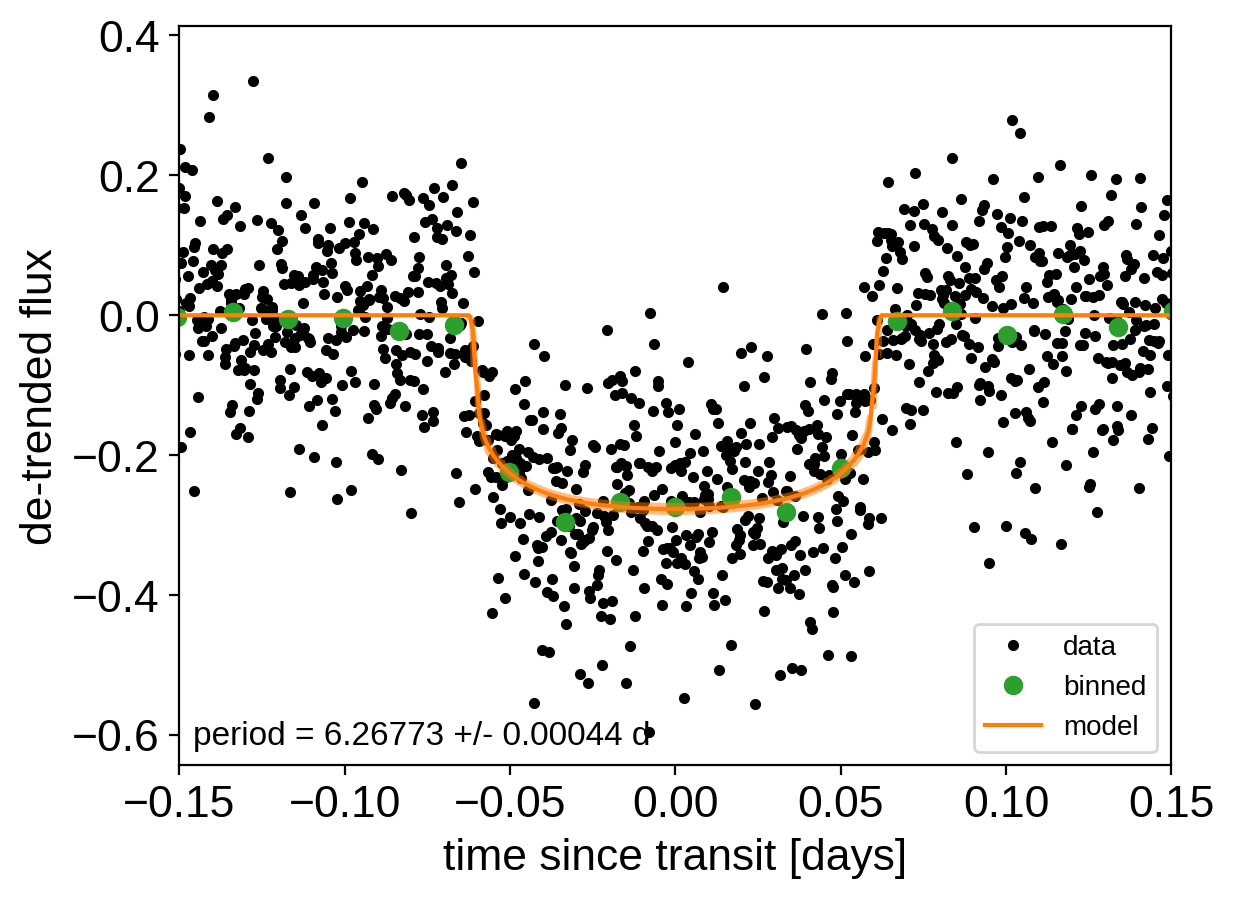

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

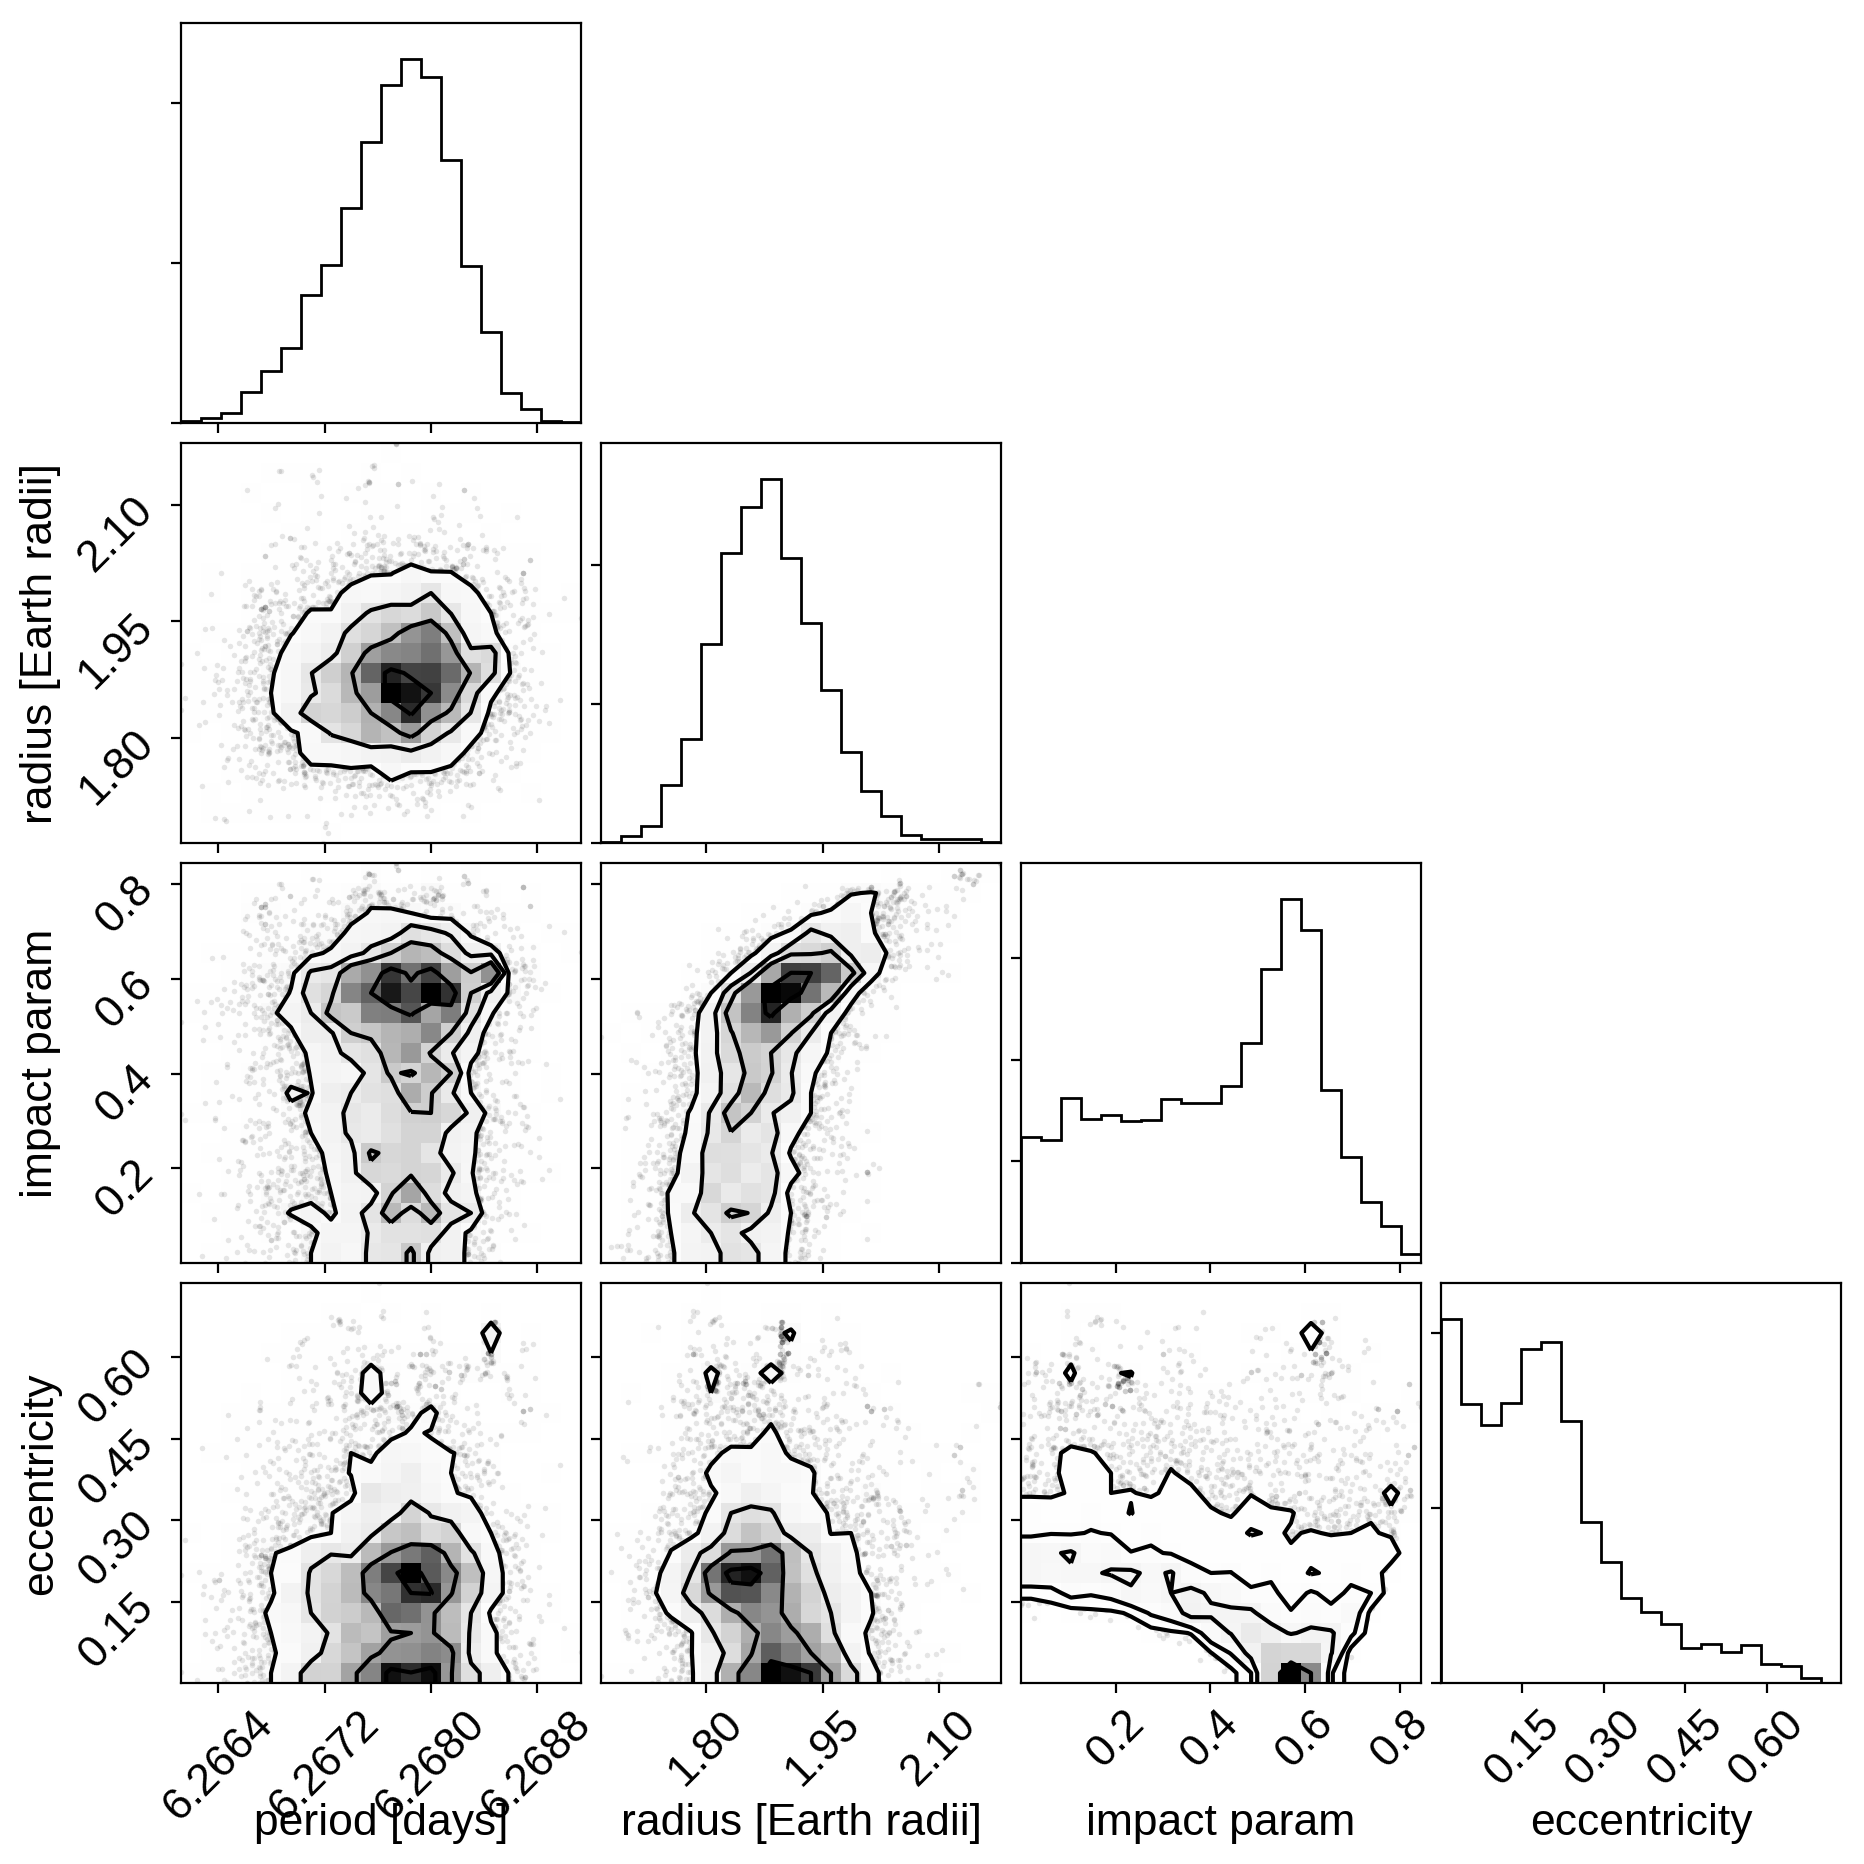

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [19]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [20]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
